## 介绍 \ Introduction

这一节介绍的是如何用FLGo实现在聚合阶段做出修改的算法。这里使用的例子是FedMGDA+，该算法由Hu等人于2020年提出（[论文链接](https://arxiv.org/abs/2006.11489)），并发表于 IEEE Transactions on Network Science and Engineering 2022。它受多目标优化中的mgda算法所启发，将该参数更新应用于联邦学习的聚合阶段，从而避免聚合出来的模型更新损害任何一方的利益（全局更新量与任何一个用户的更新量内积为负）。由于关于该论文的讲解知乎上已经有不少帖子，这里仅讲解如何使用FLGo实现该算法。

FedMGDA+在聚合阶段相较于fedavg，它仅在聚合阶段有所不同。fedavg为直接加权(或者不加权)平均所有用户的本地模型，

而FedMGDA+的聚合步骤为：
1. 先用用户的本地模型计算出它们各自的梯度更新$\Delta\theta_i = \theta^t-\theta^{t+1}_i$，并将梯度归一化得到$d_i=\frac{\Delta\theta_i}{\|\Delta\theta_i\|}$；
2. 随后，FedMGDA+在原始聚合权重的邻域范围内，找到一组聚合权重dynamic_lambdas，使得该权重能够最小化所聚合出来的模型更新量的二范数；

$$\mathbf{\lambda}^*=\min_{\mathbf{\lambda}}||\sum_{i\in \mathbb{S}_t}\lambda_i d_i||_2\\s.t. \|\mathbf{\lambda}-\mathbf{\lambda_0}\|_{\infty}\le \epsilon, \mathbf{1}^\top\mathbf{\lambda}=1$$

3. FedMGDA+使用第二步计算出的权重$\mathbf{\lambda}$加权平均所有模型更新量，使用全局步长$\eta$更新模型

$$\theta^{t+1}=\theta^t-\eta\sum \lambda_i d_i$$

下面讲解FLGo中如何实现该算法

## 在FLGo中实现FedMGDA+ 

首先注意到FedMGDA+算法有两个超参数：$\eta$和$\epsilon$，因此在初始化方法initialize中添加算法超参数；对于聚合部分，aggregate函数默认接收参数为models，因此实现aggregate的步骤严格按照上述三步进行。注意到优化权重的部分被留给self.optim_lambda方法来实现，它接收当前梯度集合、原始权重，以及使用超参数self.eta来寻找最优权重（可以暂时略过阅读optim_lambda和quadprog的方法的实现，它们与FLGo的主要流程是无关的）。这里使用cvxopt库（通过pip install cvxopt即可安装）来进行求解步骤2中的最小范数问题。若没有安装cvxopt库，则运行下面命令进行安装：

In [ ]:
!pip install cvxopt

完整的Server类代码实现如下：

In [1]:
from flgo.utils import fmodule
from flgo.algorithm.fedbase import BasicServer
from flgo.algorithm.fedavg import Client
import flgo
import os
import numpy as np
import copy
import cvxopt

class Server(BasicServer):
    def initialize(self, *args, **kwargs):
        self.init_algo_para({'eta':1.0, 'epsilon':0.1})
        
    def aggregate(self, models: list, *args, **kwargs):
        # 1. 计算归一化后的模型梯度\calculate normalized gradients
        grads = [self.model - w for w in models]
        for gi in grads: gi.normalize()
            
        # 2. 计算原始权重λ0邻域的最优权重
        # calculate λ0
        nks = [len(self.clients[cid].train_data) for cid in self.received_clients]
        nt = sum(nks)
        lambda0 = [1.0 * nk / nt for nk in nks]
        # optimize lambdas to minimize ||λ'g||² s.t. λ∈Δ, ||λ - λ0||∞ <= ε
        op_lambda = self.optim_lambda(grads, lambda0)
        op_lambda = [ele[0] for ele in op_lambda]
        
        # 3. 使用最有权重计算全局模型更新量，并更新模型\aggregate grads
        dt = fmodule._model_average(grads, op_lambda)
        return self.model - dt * self.eta
    
    def optim_lambda(self, grads, lambda0):
        # create H_m*m = 2J'J where J=[grad_i]_n*m
        n = len(grads)
        Jt = []
        for gi in grads:
            Jt.append((copy.deepcopy(fmodule._modeldict_to_tensor1D(gi.state_dict())).cpu()).numpy())
        Jt = np.array(Jt)
        # target function
        P = 2 * np.dot(Jt, Jt.T)

        q = np.array([[0] for i in range(n)])
        # equality constraint λ∈Δ
        A = np.ones(n).T
        b = np.array([1])
        # boundary
        lb = np.array([max(0, lambda0[i] - self.epsilon) for i in range(n)])
        ub = np.array([min(1, lambda0[i] + self.epsilon) for i in range(n)])
        G = np.zeros((2*n,n))
        for i in range(n):
            G[i][i]=-1
            G[n+i][i]=1
        h = np.zeros((2*n,1))
        for i in range(n):
            h[i] = -lb[i]
            h[n+i] = ub[i]
        res=self.quadprog(P, q, G, h, A, b)
        return res

    def quadprog(self, P, q, G, h, A, b):
        """
        Input: Numpy arrays, the format follows MATLAB quadprog function: https://www.mathworks.com/help/optim/ug/quadprog.html
        Output: Numpy array of the solution
        """
        P = cvxopt.matrix(P.tolist())
        q = cvxopt.matrix(q.tolist(), tc='d')
        G = cvxopt.matrix(G.tolist())
        h = cvxopt.matrix(h.tolist())
        A = cvxopt.matrix(A.tolist())
        b = cvxopt.matrix(b.tolist(), tc='d')
        sol = cvxopt.solvers.qp(P, q.T, G.T, h.T, A.T, b)
        return np.array(sol['x'])

然后实现算法fedmgda+如下：

In [2]:
class fedmgda:
    Server = Server
    Client = Client

## FedMGDA+性能测试

接下来测试所实现的fedmgda+算法的性能。

Files already downloaded and verified
Files already downloaded and verified
Task B-cifar10_classification_P-div0.2_N-100 has been successfully generated.


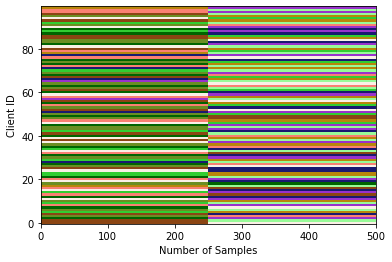

<Figure size 432x288 with 0 Axes>

In [3]:
import flgo.algorithm.fedavg as fedavg
task = './test_cifar10'
config = {'benchmark':{'name':'flgo.benchmark.cifar10_classification'},'partitioner':{'name': 'DiversityPartitioner','para':{'num_clients':100, 'diversity':0.2}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)

In [4]:
option = {'learning_rate':0.01, 'num_steps':5, 'num_rounds':200,'gpu':0}

fedavg_runner = flgo.init(task, fedavg, option=option)
fedmgda_runner_eta1epsilon01 = flgo.init(task, fedmgda, option=option)
fedmgda_runner_eta05epsilon01 = flgo.init(task, fedmgda, option={'learning_rate':0.01, 'num_steps':5, 'num_rounds':200,'gpu':0, 'algo_para':[0.5, 0.1]})
fedmgda_runner_eta01epsilon01 = flgo.init(task, fedmgda, option={'learning_rate':0.01, 'num_steps':5, 'num_rounds':200,'gpu':0, 'algo_para':[0.1, 0.1]})

fedavg_runner.run()
fedmgda_runner_eta1epsilon01.run()
fedmgda_runner_eta05epsilon01.run()
fedmgda_runner_eta01epsilon01.run()

2023-03-14 15:17:32,688 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.


Files already downloaded and verified
Files already downloaded and verified


2023-03-14 15:17:36,045 fflow.py init [line:389] INFO Use `<class 'flgo.simulator.default_simulator.Simulator'>` as the system simulator
2023-03-14 15:17:36,046 fflow.py init [line:397] INFO Ready to start.
2023-03-14 15:17:36,048 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.


Files already downloaded and verified
Files already downloaded and verified


2023-03-14 15:17:37,047 fflow.py init [line:389] INFO Use `<class 'flgo.simulator.default_simulator.Simulator'>` as the system simulator
2023-03-14 15:17:37,048 fflow.py init [line:397] INFO Ready to start.
2023-03-14 15:17:37,049 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.


Files already downloaded and verified
Files already downloaded and verified


2023-03-14 15:17:38,053 fflow.py init [line:389] INFO Use `<class 'flgo.simulator.default_simulator.Simulator'>` as the system simulator
2023-03-14 15:17:38,054 fflow.py init [line:397] INFO Ready to start.
2023-03-14 15:17:38,055 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.


Files already downloaded and verified
Files already downloaded and verified


2023-03-14 15:17:39,050 fflow.py init [line:389] INFO Use `<class 'flgo.simulator.default_simulator.Simulator'>` as the system simulator
2023-03-14 15:17:39,051 fflow.py init [line:397] INFO Ready to start.
2023-03-14 15:17:39,052 fedbase.py run [line:104] INFO --------------Initial Evaluation--------------
2023-03-14 15:17:39,052 simple_logger.py log_once [line:13] INFO Current_time:0
2023-03-14 15:17:42,941 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1027
2023-03-14 15:17:42,941 simple_logger.py log_once [line:27] INFO test_loss                     2.3032
2023-03-14 15:17:42,942 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1020
2023-03-14 15:17:42,942 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1020
2023-03-14 15:17:42,942 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1061
2023-03-14 15:17:42,943 simple_logger.py log_once [line:27] INFO valid_loss                    2.3038

2023-03-14 15:18:10,019 fedbase.py run [line:121] INFO Eval Time Cost:               3.2562s
2023-03-14 15:18:11,268 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2490s
2023-03-14 15:18:11,269 fedbase.py run [line:116] INFO --------------Round 7--------------
2023-03-14 15:18:11,269 simple_logger.py log_once [line:13] INFO Current_time:7
2023-03-14 15:18:14,188 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1003
2023-03-14 15:18:14,188 simple_logger.py log_once [line:27] INFO test_loss                     2.3000
2023-03-14 15:18:14,189 simple_logger.py log_once [line:27] INFO valid_accuracy                0.0930
2023-03-14 15:18:14,189 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.0930
2023-03-14 15:18:14,189 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1860
2023-03-14 15:18:14,189 simple_logger.py log_once [line:27] INFO valid_loss                    2.3024
2023-03-14 15:18:14,190 simple_

2023-03-14 15:18:41,081 fedbase.py run [line:121] INFO Eval Time Cost:               3.1900s
2023-03-14 15:18:42,461 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3793s
2023-03-14 15:18:42,462 fedbase.py run [line:116] INFO --------------Round 14--------------
2023-03-14 15:18:42,462 simple_logger.py log_once [line:13] INFO Current_time:14
2023-03-14 15:18:45,694 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1000
2023-03-14 15:18:45,694 simple_logger.py log_once [line:27] INFO test_loss                     2.4501
2023-03-14 15:18:45,694 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1016
2023-03-14 15:18:45,695 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1016
2023-03-14 15:18:45,695 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2062
2023-03-14 15:18:45,695 simple_logger.py log_once [line:27] INFO valid_loss                    2.4465
2023-03-14 15:18:45,696 simpl

2023-03-14 15:19:13,331 fedbase.py run [line:121] INFO Eval Time Cost:               3.2955s
2023-03-14 15:19:14,665 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3333s
2023-03-14 15:19:14,666 fedbase.py run [line:116] INFO --------------Round 21--------------
2023-03-14 15:19:14,666 simple_logger.py log_once [line:13] INFO Current_time:21
2023-03-14 15:19:17,986 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1001
2023-03-14 15:19:17,987 simple_logger.py log_once [line:27] INFO test_loss                     2.3452
2023-03-14 15:19:17,987 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1012
2023-03-14 15:19:17,987 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1012
2023-03-14 15:19:17,988 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2043
2023-03-14 15:19:17,988 simple_logger.py log_once [line:27] INFO valid_loss                    2.3447
2023-03-14 15:19:17,988 simpl

2023-03-14 15:19:45,979 fedbase.py run [line:121] INFO Eval Time Cost:               3.4207s
2023-03-14 15:19:47,477 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4973s
2023-03-14 15:19:47,478 fedbase.py run [line:116] INFO --------------Round 28--------------
2023-03-14 15:19:47,478 simple_logger.py log_once [line:13] INFO Current_time:28
2023-03-14 15:19:51,019 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1475
2023-03-14 15:19:51,019 simple_logger.py log_once [line:27] INFO test_loss                     2.2454
2023-03-14 15:19:51,020 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1402
2023-03-14 15:19:51,020 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1402
2023-03-14 15:19:51,020 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1788
2023-03-14 15:19:51,020 simple_logger.py log_once [line:27] INFO valid_loss                    2.2526
2023-03-14 15:19:51,021 simpl

2023-03-14 15:20:19,097 fedbase.py run [line:121] INFO Eval Time Cost:               3.3051s
2023-03-14 15:20:20,519 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4206s
2023-03-14 15:20:20,519 fedbase.py run [line:116] INFO --------------Round 35--------------
2023-03-14 15:20:20,519 simple_logger.py log_once [line:13] INFO Current_time:35
2023-03-14 15:20:23,819 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2198
2023-03-14 15:20:23,820 simple_logger.py log_once [line:27] INFO test_loss                     2.1517
2023-03-14 15:20:23,820 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2208
2023-03-14 15:20:23,820 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2208
2023-03-14 15:20:23,821 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1570
2023-03-14 15:20:23,821 simple_logger.py log_once [line:27] INFO valid_loss                    2.1560
2023-03-14 15:20:23,821 simpl

2023-03-14 15:20:51,921 fedbase.py run [line:121] INFO Eval Time Cost:               3.3083s
2023-03-14 15:20:53,396 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4745s
2023-03-14 15:20:53,397 fedbase.py run [line:116] INFO --------------Round 42--------------
2023-03-14 15:20:53,397 simple_logger.py log_once [line:13] INFO Current_time:42
2023-03-14 15:20:56,683 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2111
2023-03-14 15:20:56,683 simple_logger.py log_once [line:27] INFO test_loss                     2.1078
2023-03-14 15:20:56,684 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2094
2023-03-14 15:20:56,684 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2094
2023-03-14 15:20:56,684 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1797
2023-03-14 15:20:56,685 simple_logger.py log_once [line:27] INFO valid_loss                    2.1087
2023-03-14 15:20:56,685 simpl

2023-03-14 15:21:24,989 fedbase.py run [line:121] INFO Eval Time Cost:               3.4517s
2023-03-14 15:21:26,425 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4357s
2023-03-14 15:21:26,426 fedbase.py run [line:116] INFO --------------Round 49--------------
2023-03-14 15:21:26,426 simple_logger.py log_once [line:13] INFO Current_time:49
2023-03-14 15:21:30,025 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2354
2023-03-14 15:21:30,025 simple_logger.py log_once [line:27] INFO test_loss                     2.0825
2023-03-14 15:21:30,026 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2382
2023-03-14 15:21:30,026 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2382
2023-03-14 15:21:30,026 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1479
2023-03-14 15:21:30,027 simple_logger.py log_once [line:27] INFO valid_loss                    2.0844
2023-03-14 15:21:30,027 simpl

2023-03-14 15:21:57,521 fedbase.py run [line:121] INFO Eval Time Cost:               3.3151s
2023-03-14 15:21:58,821 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2991s
2023-03-14 15:21:58,821 fedbase.py run [line:116] INFO --------------Round 56--------------
2023-03-14 15:21:58,822 simple_logger.py log_once [line:13] INFO Current_time:56
2023-03-14 15:22:02,243 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2449
2023-03-14 15:22:02,244 simple_logger.py log_once [line:27] INFO test_loss                     2.1028
2023-03-14 15:22:02,244 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2522
2023-03-14 15:22:02,244 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2522
2023-03-14 15:22:02,244 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1709
2023-03-14 15:22:02,245 simple_logger.py log_once [line:27] INFO valid_loss                    2.1002
2023-03-14 15:22:02,245 simpl

2023-03-14 15:22:30,839 fedbase.py run [line:121] INFO Eval Time Cost:               3.3418s
2023-03-14 15:22:32,175 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3356s
2023-03-14 15:22:32,176 fedbase.py run [line:116] INFO --------------Round 63--------------
2023-03-14 15:22:32,176 simple_logger.py log_once [line:13] INFO Current_time:63
2023-03-14 15:22:35,486 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1964
2023-03-14 15:22:35,486 simple_logger.py log_once [line:27] INFO test_loss                     2.1380
2023-03-14 15:22:35,487 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1930
2023-03-14 15:22:35,487 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1930
2023-03-14 15:22:35,487 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1764
2023-03-14 15:22:35,488 simple_logger.py log_once [line:27] INFO valid_loss                    2.1326
2023-03-14 15:22:35,488 simpl

2023-03-14 15:23:03,113 fedbase.py run [line:121] INFO Eval Time Cost:               3.3687s
2023-03-14 15:23:04,514 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3998s
2023-03-14 15:23:04,514 fedbase.py run [line:116] INFO --------------Round 70--------------
2023-03-14 15:23:04,515 simple_logger.py log_once [line:13] INFO Current_time:70
2023-03-14 15:23:07,859 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2238
2023-03-14 15:23:07,860 simple_logger.py log_once [line:27] INFO test_loss                     2.0804
2023-03-14 15:23:07,860 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2248
2023-03-14 15:23:07,860 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2248
2023-03-14 15:23:07,861 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1749
2023-03-14 15:23:07,861 simple_logger.py log_once [line:27] INFO valid_loss                    2.0682
2023-03-14 15:23:07,861 simpl

2023-03-14 15:23:35,513 fedbase.py run [line:121] INFO Eval Time Cost:               3.2740s
2023-03-14 15:23:36,883 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3689s
2023-03-14 15:23:36,883 fedbase.py run [line:116] INFO --------------Round 77--------------
2023-03-14 15:23:36,883 simple_logger.py log_once [line:13] INFO Current_time:77
2023-03-14 15:23:40,150 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2836
2023-03-14 15:23:40,150 simple_logger.py log_once [line:27] INFO test_loss                     1.9796
2023-03-14 15:23:40,150 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2876
2023-03-14 15:23:40,151 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2876
2023-03-14 15:23:40,151 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1445
2023-03-14 15:23:40,151 simple_logger.py log_once [line:27] INFO valid_loss                    1.9734
2023-03-14 15:23:40,152 simpl

2023-03-14 15:24:08,376 fedbase.py run [line:121] INFO Eval Time Cost:               3.3610s
2023-03-14 15:24:09,798 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4208s
2023-03-14 15:24:09,798 fedbase.py run [line:116] INFO --------------Round 84--------------
2023-03-14 15:24:09,798 simple_logger.py log_once [line:13] INFO Current_time:84
2023-03-14 15:24:13,231 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2555
2023-03-14 15:24:13,232 simple_logger.py log_once [line:27] INFO test_loss                     2.0328
2023-03-14 15:24:13,232 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2480
2023-03-14 15:24:13,232 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2480
2023-03-14 15:24:13,233 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1594
2023-03-14 15:24:13,233 simple_logger.py log_once [line:27] INFO valid_loss                    2.0257
2023-03-14 15:24:13,233 simpl

2023-03-14 15:24:41,705 fedbase.py run [line:121] INFO Eval Time Cost:               3.3409s
2023-03-14 15:24:43,133 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4262s
2023-03-14 15:24:43,133 fedbase.py run [line:116] INFO --------------Round 91--------------
2023-03-14 15:24:43,133 simple_logger.py log_once [line:13] INFO Current_time:91
2023-03-14 15:24:46,496 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2546
2023-03-14 15:24:46,497 simple_logger.py log_once [line:27] INFO test_loss                     2.0129
2023-03-14 15:24:46,497 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2556
2023-03-14 15:24:46,498 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2556
2023-03-14 15:24:46,498 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1798
2023-03-14 15:24:46,498 simple_logger.py log_once [line:27] INFO valid_loss                    2.0144
2023-03-14 15:24:46,499 simpl

2023-03-14 15:25:14,302 fedbase.py run [line:121] INFO Eval Time Cost:               3.3018s
2023-03-14 15:25:15,666 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3623s
2023-03-14 15:25:15,666 fedbase.py run [line:116] INFO --------------Round 98--------------
2023-03-14 15:25:15,666 simple_logger.py log_once [line:13] INFO Current_time:98
2023-03-14 15:25:18,959 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2235
2023-03-14 15:25:18,959 simple_logger.py log_once [line:27] INFO test_loss                     2.0443
2023-03-14 15:25:18,959 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2198
2023-03-14 15:25:18,960 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2198
2023-03-14 15:25:18,960 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1997
2023-03-14 15:25:18,960 simple_logger.py log_once [line:27] INFO valid_loss                    2.0395
2023-03-14 15:25:18,961 simpl

2023-03-14 15:25:46,592 fedbase.py run [line:121] INFO Eval Time Cost:               3.3147s
2023-03-14 15:25:47,850 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2569s
2023-03-14 15:25:47,850 fedbase.py run [line:116] INFO --------------Round 105--------------
2023-03-14 15:25:47,851 simple_logger.py log_once [line:13] INFO Current_time:105
2023-03-14 15:25:51,221 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2799
2023-03-14 15:25:51,222 simple_logger.py log_once [line:27] INFO test_loss                     1.9777
2023-03-14 15:25:51,222 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2758
2023-03-14 15:25:51,223 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2758
2023-03-14 15:25:51,223 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1608
2023-03-14 15:25:51,223 simple_logger.py log_once [line:27] INFO valid_loss                    1.9639
2023-03-14 15:25:51,224 sim

2023-03-14 15:26:19,653 fedbase.py run [line:121] INFO Eval Time Cost:               3.5035s
2023-03-14 15:26:21,060 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4055s
2023-03-14 15:26:21,061 fedbase.py run [line:116] INFO --------------Round 112--------------
2023-03-14 15:26:21,061 simple_logger.py log_once [line:13] INFO Current_time:112
2023-03-14 15:26:24,366 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2972
2023-03-14 15:26:24,367 simple_logger.py log_once [line:27] INFO test_loss                     1.9703
2023-03-14 15:26:24,367 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2940
2023-03-14 15:26:24,368 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2940
2023-03-14 15:26:24,368 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1282
2023-03-14 15:26:24,368 simple_logger.py log_once [line:27] INFO valid_loss                    1.9627
2023-03-14 15:26:24,368 sim

2023-03-14 15:26:51,360 fedbase.py run [line:121] INFO Eval Time Cost:               3.0482s
2023-03-14 15:26:52,590 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2286s
2023-03-14 15:26:52,591 fedbase.py run [line:116] INFO --------------Round 119--------------
2023-03-14 15:26:52,591 simple_logger.py log_once [line:13] INFO Current_time:119
2023-03-14 15:26:55,718 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3037
2023-03-14 15:26:55,719 simple_logger.py log_once [line:27] INFO test_loss                     1.9106
2023-03-14 15:26:55,719 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3040
2023-03-14 15:26:55,720 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3040
2023-03-14 15:26:55,720 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1509
2023-03-14 15:26:55,720 simple_logger.py log_once [line:27] INFO valid_loss                    1.9018
2023-03-14 15:26:55,721 sim

2023-03-14 15:27:22,624 fedbase.py run [line:121] INFO Eval Time Cost:               3.2671s
2023-03-14 15:27:23,864 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2395s
2023-03-14 15:27:23,865 fedbase.py run [line:116] INFO --------------Round 126--------------
2023-03-14 15:27:23,865 simple_logger.py log_once [line:13] INFO Current_time:126
2023-03-14 15:27:27,076 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2959
2023-03-14 15:27:27,076 simple_logger.py log_once [line:27] INFO test_loss                     1.9162
2023-03-14 15:27:27,077 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2990
2023-03-14 15:27:27,077 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2990
2023-03-14 15:27:27,077 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1755
2023-03-14 15:27:27,078 simple_logger.py log_once [line:27] INFO valid_loss                    1.9044
2023-03-14 15:27:27,078 sim

2023-03-14 15:27:53,885 fedbase.py run [line:121] INFO Eval Time Cost:               3.2023s
2023-03-14 15:27:55,197 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3112s
2023-03-14 15:27:55,198 fedbase.py run [line:116] INFO --------------Round 133--------------
2023-03-14 15:27:55,198 simple_logger.py log_once [line:13] INFO Current_time:133
2023-03-14 15:27:58,394 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2838
2023-03-14 15:27:58,395 simple_logger.py log_once [line:27] INFO test_loss                     1.9079
2023-03-14 15:27:58,395 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2924
2023-03-14 15:27:58,395 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2924
2023-03-14 15:27:58,396 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1683
2023-03-14 15:27:58,396 simple_logger.py log_once [line:27] INFO valid_loss                    1.8960
2023-03-14 15:27:58,396 sim

2023-03-14 15:28:25,675 fedbase.py run [line:121] INFO Eval Time Cost:               3.2350s
2023-03-14 15:28:26,927 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2508s
2023-03-14 15:28:26,927 fedbase.py run [line:116] INFO --------------Round 140--------------
2023-03-14 15:28:26,928 simple_logger.py log_once [line:13] INFO Current_time:140
2023-03-14 15:28:29,998 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2756
2023-03-14 15:28:29,999 simple_logger.py log_once [line:27] INFO test_loss                     1.9417
2023-03-14 15:28:29,999 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2910
2023-03-14 15:28:29,999 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2910
2023-03-14 15:28:29,999 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1814
2023-03-14 15:28:30,000 simple_logger.py log_once [line:27] INFO valid_loss                    1.9284
2023-03-14 15:28:30,000 sim

2023-03-14 15:28:56,738 fedbase.py run [line:121] INFO Eval Time Cost:               3.2359s
2023-03-14 15:28:57,990 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2517s
2023-03-14 15:28:57,991 fedbase.py run [line:116] INFO --------------Round 147--------------
2023-03-14 15:28:57,991 simple_logger.py log_once [line:13] INFO Current_time:147
2023-03-14 15:29:01,265 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2779
2023-03-14 15:29:01,265 simple_logger.py log_once [line:27] INFO test_loss                     1.9449
2023-03-14 15:29:01,266 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2842
2023-03-14 15:29:01,266 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2842
2023-03-14 15:29:01,266 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1897
2023-03-14 15:29:01,267 simple_logger.py log_once [line:27] INFO valid_loss                    1.9450
2023-03-14 15:29:01,267 sim

2023-03-14 15:29:28,474 fedbase.py run [line:121] INFO Eval Time Cost:               3.1840s
2023-03-14 15:29:29,774 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2998s
2023-03-14 15:29:29,775 fedbase.py run [line:116] INFO --------------Round 154--------------
2023-03-14 15:29:29,775 simple_logger.py log_once [line:13] INFO Current_time:154
2023-03-14 15:29:32,952 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3105
2023-03-14 15:29:32,953 simple_logger.py log_once [line:27] INFO test_loss                     1.8778
2023-03-14 15:29:32,953 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3206
2023-03-14 15:29:32,953 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3206
2023-03-14 15:29:32,954 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1594
2023-03-14 15:29:32,954 simple_logger.py log_once [line:27] INFO valid_loss                    1.8697
2023-03-14 15:29:32,954 sim

2023-03-14 15:29:59,406 fedbase.py run [line:121] INFO Eval Time Cost:               3.1712s
2023-03-14 15:30:00,582 fedbase.py run [line:113] INFO Iterate Time Cost:            1.1758s
2023-03-14 15:30:00,583 fedbase.py run [line:116] INFO --------------Round 161--------------
2023-03-14 15:30:00,583 simple_logger.py log_once [line:13] INFO Current_time:161
2023-03-14 15:30:03,816 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2576
2023-03-14 15:30:03,816 simple_logger.py log_once [line:27] INFO test_loss                     1.9613
2023-03-14 15:30:03,816 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2550
2023-03-14 15:30:03,817 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2550
2023-03-14 15:30:03,817 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2052
2023-03-14 15:30:03,817 simple_logger.py log_once [line:27] INFO valid_loss                    1.9493
2023-03-14 15:30:03,817 sim

2023-03-14 15:30:30,431 fedbase.py run [line:121] INFO Eval Time Cost:               3.1969s
2023-03-14 15:30:31,761 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3287s
2023-03-14 15:30:31,762 fedbase.py run [line:116] INFO --------------Round 168--------------
2023-03-14 15:30:31,762 simple_logger.py log_once [line:13] INFO Current_time:168
2023-03-14 15:30:34,957 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3211
2023-03-14 15:30:34,957 simple_logger.py log_once [line:27] INFO test_loss                     1.8510
2023-03-14 15:30:34,958 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3314
2023-03-14 15:30:34,958 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3314
2023-03-14 15:30:34,958 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1604
2023-03-14 15:30:34,958 simple_logger.py log_once [line:27] INFO valid_loss                    1.8341
2023-03-14 15:30:34,959 sim

2023-03-14 15:31:01,395 fedbase.py run [line:121] INFO Eval Time Cost:               3.1898s
2023-03-14 15:31:02,700 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3044s
2023-03-14 15:31:02,701 fedbase.py run [line:116] INFO --------------Round 175--------------
2023-03-14 15:31:02,701 simple_logger.py log_once [line:13] INFO Current_time:175
2023-03-14 15:31:05,887 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3254
2023-03-14 15:31:05,888 simple_logger.py log_once [line:27] INFO test_loss                     1.8338
2023-03-14 15:31:05,888 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3384
2023-03-14 15:31:05,888 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3384
2023-03-14 15:31:05,889 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1549
2023-03-14 15:31:05,889 simple_logger.py log_once [line:27] INFO valid_loss                    1.8230
2023-03-14 15:31:05,889 sim

2023-03-14 15:31:33,155 fedbase.py run [line:121] INFO Eval Time Cost:               3.2185s
2023-03-14 15:31:34,411 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2549s
2023-03-14 15:31:34,411 fedbase.py run [line:116] INFO --------------Round 182--------------
2023-03-14 15:31:34,412 simple_logger.py log_once [line:13] INFO Current_time:182
2023-03-14 15:31:37,636 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3571
2023-03-14 15:31:37,637 simple_logger.py log_once [line:27] INFO test_loss                     1.7812
2023-03-14 15:31:37,637 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3642
2023-03-14 15:31:37,637 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3642
2023-03-14 15:31:37,638 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1320
2023-03-14 15:31:37,638 simple_logger.py log_once [line:27] INFO valid_loss                    1.7726
2023-03-14 15:31:37,638 sim

2023-03-14 15:32:04,353 fedbase.py run [line:121] INFO Eval Time Cost:               3.2421s
2023-03-14 15:32:05,765 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4111s
2023-03-14 15:32:05,766 fedbase.py run [line:116] INFO --------------Round 189--------------
2023-03-14 15:32:05,766 simple_logger.py log_once [line:13] INFO Current_time:189
2023-03-14 15:32:08,968 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3521
2023-03-14 15:32:08,968 simple_logger.py log_once [line:27] INFO test_loss                     1.7870
2023-03-14 15:32:08,969 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3634
2023-03-14 15:32:08,969 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3634
2023-03-14 15:32:08,969 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1395
2023-03-14 15:32:08,969 simple_logger.py log_once [line:27] INFO valid_loss                    1.7765
2023-03-14 15:32:08,970 sim

2023-03-14 15:32:35,924 fedbase.py run [line:121] INFO Eval Time Cost:               3.2349s
2023-03-14 15:32:37,334 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4097s
2023-03-14 15:32:37,334 fedbase.py run [line:116] INFO --------------Round 196--------------
2023-03-14 15:32:37,335 simple_logger.py log_once [line:13] INFO Current_time:196
2023-03-14 15:32:40,523 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3194
2023-03-14 15:32:40,523 simple_logger.py log_once [line:27] INFO test_loss                     1.8692
2023-03-14 15:32:40,523 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3286
2023-03-14 15:32:40,524 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3286
2023-03-14 15:32:40,524 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1863
2023-03-14 15:32:40,524 simple_logger.py log_once [line:27] INFO valid_loss                    1.8651
2023-03-14 15:32:40,524 sim

     pcost       dcost       gap    pres   dres
 0:  5.3441e-02 -3.0954e+00  3e+00  3e-16  4e-16
 1:  5.1741e-02 -5.0951e-02  1e-01  3e-16  7e-16
 2:  4.2941e-02  3.3786e-02  9e-03  9e-17  2e-16
 3:  4.0484e-02  3.9098e-02  1e-03  9e-17  2e-16
 4:  4.0079e-02  3.9864e-02  2e-04  1e-16  2e-16
 5:  3.9986e-02  3.9973e-02  1e-05  8e-17  2e-16
 6:  3.9981e-02  3.9981e-02  4e-07  1e-16  1e-16
 7:  3.9981e-02  3.9981e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:33:06,727 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1385
2023-03-14 15:33:06,727 simple_logger.py log_once [line:27] INFO test_loss                     2.2916
2023-03-14 15:33:06,728 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1406
2023-03-14 15:33:06,728 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1406
2023-03-14 15:33:06,728 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1711
2023-03-14 15:33:06,728 simple_logger.py log_once [line:27] INFO valid_loss                    2.2919
2023-03-14 15:33:06,729 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2919
2023-03-14 15:33:06,729 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0592
2023-03-14 15:33:06,729 fedbase.py run [line:121] INFO Eval Time Cost:               3.2549s
2023-03-14 15:33:08,339 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6095

     pcost       dcost       gap    pres   dres
 0:  9.3950e-02 -3.0208e+00  3e+00  8e-17  3e-16
 1:  9.3285e-02  6.0420e-03  9e-02  3e-16  7e-16
 2:  8.9635e-02  8.0085e-02  1e-02  8e-17  2e-16
 3:  8.8107e-02  8.7093e-02  1e-03  1e-16  1e-16
 4:  8.7866e-02  8.7809e-02  6e-05  1e-16  1e-16
 5:  8.7852e-02  8.7848e-02  4e-06  3e-16  9e-17
 6:  8.7851e-02  8.7851e-02  9e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:33:11,549 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1266
2023-03-14 15:33:11,549 simple_logger.py log_once [line:27] INFO test_loss                     2.2780
2023-03-14 15:33:11,550 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1206
2023-03-14 15:33:11,550 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1206
2023-03-14 15:33:11,550 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1698
2023-03-14 15:33:11,551 simple_logger.py log_once [line:27] INFO valid_loss                    2.2799
2023-03-14 15:33:11,551 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2799
2023-03-14 15:33:11,551 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0850
2023-03-14 15:33:11,551 fedbase.py run [line:121] INFO Eval Time Cost:               3.2113s
2023-03-14 15:33:13,163 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6103

     pcost       dcost       gap    pres   dres
 0:  9.7195e-02 -3.0154e+00  3e+00  2e-17  4e-16
 1:  9.5196e-02 -1.1719e-02  1e-01  1e-16  9e-16
 2:  8.7719e-02  7.5394e-02  1e-02  9e-17  2e-16
 3:  8.6020e-02  8.3333e-02  3e-03  1e-16  1e-16
 4:  8.5586e-02  8.5135e-02  5e-04  1e-16  1e-16
 5:  8.5484e-02  8.5400e-02  8e-05  2e-16  2e-16
 6:  8.5467e-02  8.5456e-02  1e-05  2e-16  2e-16
 7:  8.5464e-02  8.5464e-02  3e-07  1e-16  1e-16
 8:  8.5464e-02  8.5464e-02  3e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 15:33:16,395 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1089
2023-03-14 15:33:16,395 simple_logger.py log_once [line:27] INFO test_loss                     2.4049
2023-03-14 15:33:16,396 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1046
2023-03-14 15:33:16,396 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1046
2023-03-14 15:33:16,396 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1685
2023-03-14 15:33:16,397 simple_logger.py log_once [line:27] INFO valid_loss                    2.4065
2023-03-14 15:33:16,397 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4065
2023-03-14 15:33:16,397 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4828
2023-03-14 15:33:16,397 fedbase.py run [line:121] INFO Eval Time Cost:               3.2339s
2023-03-14 15:33:18,029 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6305

     pcost       dcost       gap    pres   dres
 0:  1.1033e-01 -3.0486e+00  5e+01  6e+00  4e-16
 1:  1.5797e-01 -2.5637e+00  3e+00  9e-16  8e-16
 2:  1.4334e-01 -7.9787e-02  2e-01  3e-16  7e-16
 3:  1.0810e-01  7.0801e-02  4e-02  2e-16  3e-16
 4:  9.7261e-02  9.3180e-02  4e-03  1e-16  2e-16
 5:  9.6112e-02  9.5816e-02  3e-04  1e-16  2e-16
 6:  9.6020e-02  9.6010e-02  9e-06  2e-16  2e-16
 7:  9.6017e-02  9.6017e-02  2e-07  1e-16  3e-16
 8:  9.6017e-02  9.6017e-02  2e-09  1e-16  3e-16
Optimal solution found.


2023-03-14 15:33:21,286 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1725
2023-03-14 15:33:21,286 simple_logger.py log_once [line:27] INFO test_loss                     2.3115
2023-03-14 15:33:21,287 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1658
2023-03-14 15:33:21,287 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1658
2023-03-14 15:33:21,287 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1763
2023-03-14 15:33:21,288 simple_logger.py log_once [line:27] INFO valid_loss                    2.3172
2023-03-14 15:33:21,288 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3172
2023-03-14 15:33:21,288 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2825
2023-03-14 15:33:21,288 fedbase.py run [line:121] INFO Eval Time Cost:               3.2587s
2023-03-14 15:33:22,938 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6490

     pcost       dcost       gap    pres   dres
 0:  9.9296e-02 -3.0633e+00  3e+00  6e-17  4e-16
 1:  9.8063e-02 -4.2637e-03  1e-01  9e-17  1e-15
 2:  9.0608e-02  7.4134e-02  2e-02  9e-17  2e-16
 3:  8.7008e-02  8.4626e-02  2e-03  2e-16  2e-16
 4:  8.6245e-02  8.5716e-02  5e-04  1e-16  2e-16
 5:  8.6129e-02  8.6041e-02  9e-05  1e-16  2e-16
 6:  8.6102e-02  8.6098e-02  4e-06  3e-16  2e-16
 7:  8.6101e-02  8.6101e-02  9e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 15:33:25,936 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1153
2023-03-14 15:33:25,937 simple_logger.py log_once [line:27] INFO test_loss                     2.4412
2023-03-14 15:33:25,937 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1164
2023-03-14 15:33:25,937 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1164
2023-03-14 15:33:25,938 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1905
2023-03-14 15:33:25,938 simple_logger.py log_once [line:27] INFO valid_loss                    2.4423
2023-03-14 15:33:25,938 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4423
2023-03-14 15:33:25,938 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4959
2023-03-14 15:33:25,938 fedbase.py run [line:121] INFO Eval Time Cost:               2.9997s
2023-03-14 15:33:27,486 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5471

     pcost       dcost       gap    pres   dres
 0:  1.2762e-01 -3.0616e+00  5e+01  6e+00  5e-16
 1:  1.8226e-01 -2.5795e+00  3e+00  9e-16  1e-15
 2:  1.6723e-01 -8.0322e-02  2e-01  1e-16  7e-16
 3:  1.2270e-01  8.3878e-02  4e-02  2e-16  2e-16
 4:  1.0997e-01  1.0492e-01  5e-03  2e-16  2e-16
 5:  1.0860e-01  1.0832e-01  3e-04  1e-16  2e-16
 6:  1.0854e-01  1.0852e-01  2e-05  1e-16  2e-16
 7:  1.0853e-01  1.0853e-01  3e-07  2e-16  2e-16
 8:  1.0853e-01  1.0853e-01  3e-09  2e-16  3e-16
Optimal solution found.


2023-03-14 15:33:30,696 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1349
2023-03-14 15:33:30,696 simple_logger.py log_once [line:27] INFO test_loss                     2.2845
2023-03-14 15:33:30,697 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1398
2023-03-14 15:33:30,697 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1398
2023-03-14 15:33:30,697 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1991
2023-03-14 15:33:30,697 simple_logger.py log_once [line:27] INFO valid_loss                    2.2803
2023-03-14 15:33:30,698 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2803
2023-03-14 15:33:30,698 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2862
2023-03-14 15:33:30,698 fedbase.py run [line:121] INFO Eval Time Cost:               3.2108s
2023-03-14 15:33:32,261 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5624

     pcost       dcost       gap    pres   dres
 0:  1.0752e-01 -3.0288e+00  3e+00  7e-17  4e-16
 1:  1.0483e-01  1.0877e-02  9e-02  1e-16  1e-15
 2:  9.6213e-02  8.1649e-02  1e-02  1e-16  3e-16
 3:  9.3445e-02  9.1188e-02  2e-03  2e-16  2e-16
 4:  9.2669e-02  9.2420e-02  2e-04  2e-16  2e-16
 5:  9.2593e-02  9.2580e-02  1e-05  1e-16  1e-16
 6:  9.2590e-02  9.2590e-02  1e-07  2e-16  1e-16
 7:  9.2590e-02  9.2590e-02  1e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:33:35,472 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1495
2023-03-14 15:33:35,473 simple_logger.py log_once [line:27] INFO test_loss                     2.2636
2023-03-14 15:33:35,473 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1506
2023-03-14 15:33:35,473 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1506
2023-03-14 15:33:35,474 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1661
2023-03-14 15:33:35,474 simple_logger.py log_once [line:27] INFO valid_loss                    2.2667
2023-03-14 15:33:35,474 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2667
2023-03-14 15:33:35,474 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3161
2023-03-14 15:33:35,475 fedbase.py run [line:121] INFO Eval Time Cost:               3.2126s
2023-03-14 15:33:37,103 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6281

     pcost       dcost       gap    pres   dres
 0:  9.5903e-02 -3.0874e+00  5e+01  6e+00  3e-16
 1:  1.1843e-01 -2.6116e+00  3e+00  9e-16  1e-15
 2:  1.1081e-01 -7.1325e-02  2e-01  8e-17  5e-16
 3:  8.9554e-02  7.0393e-02  2e-02  1e-16  2e-16
 4:  8.4196e-02  8.0825e-02  3e-03  1e-16  2e-16
 5:  8.2855e-02  8.2639e-02  2e-04  1e-16  2e-16
 6:  8.2786e-02  8.2783e-02  2e-06  2e-16  2e-16
 7:  8.2785e-02  8.2785e-02  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:33:40,292 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1517
2023-03-14 15:33:40,293 simple_logger.py log_once [line:27] INFO test_loss                     2.6142
2023-03-14 15:33:40,293 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1528
2023-03-14 15:33:40,293 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1528
2023-03-14 15:33:40,294 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1829
2023-03-14 15:33:40,294 simple_logger.py log_once [line:27] INFO valid_loss                    2.5814
2023-03-14 15:33:40,294 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5814
2023-03-14 15:33:40,295 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9206
2023-03-14 15:33:40,295 fedbase.py run [line:121] INFO Eval Time Cost:               3.1907s
2023-03-14 15:33:41,788 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4920

     pcost       dcost       gap    pres   dres
 0:  4.6725e-02 -3.1396e+00  5e+01  6e+00  4e-16
 1:  6.4293e-02 -2.6592e+00  3e+00  9e-16  1e-15
 2:  5.6589e-02 -1.1246e-01  2e-01  1e-16  6e-16
 3:  4.4868e-02  1.0159e-02  3e-02  1e-16  2e-16
 4:  3.9240e-02  3.4987e-02  4e-03  2e-16  2e-16
 5:  3.8245e-02  3.7921e-02  3e-04  2e-16  2e-16
 6:  3.8168e-02  3.8161e-02  6e-06  1e-16  2e-16
 7:  3.8167e-02  3.8167e-02  8e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:33:45,045 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1739
2023-03-14 15:33:45,046 simple_logger.py log_once [line:27] INFO test_loss                     2.5931
2023-03-14 15:33:45,046 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1700
2023-03-14 15:33:45,046 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1700
2023-03-14 15:33:45,047 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1841
2023-03-14 15:33:45,047 simple_logger.py log_once [line:27] INFO valid_loss                    2.5694
2023-03-14 15:33:45,048 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5694
2023-03-14 15:33:45,048 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8444
2023-03-14 15:33:45,048 fedbase.py run [line:121] INFO Eval Time Cost:               3.2595s
2023-03-14 15:33:46,671 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6208

     pcost       dcost       gap    pres   dres
 0:  3.4255e-02 -3.0987e+00  3e+00  5e-17  3e-16
 1:  3.2249e-02 -6.7463e-02  1e-01  1e-16  8e-16
 2:  2.4210e-02  8.7084e-03  2e-02  2e-16  2e-16
 3:  2.1404e-02  1.9063e-02  2e-03  1e-16  2e-16
 4:  2.0618e-02  2.0073e-02  5e-04  1e-16  1e-16
 5:  2.0523e-02  2.0504e-02  2e-05  1e-16  1e-16
 6:  2.0520e-02  2.0520e-02  2e-07  1e-16  2e-16
 7:  2.0520e-02  2.0520e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:33:49,907 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2121
2023-03-14 15:33:49,908 simple_logger.py log_once [line:27] INFO test_loss                     2.5166
2023-03-14 15:33:49,908 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2108
2023-03-14 15:33:49,908 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2108
2023-03-14 15:33:49,909 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1785
2023-03-14 15:33:49,909 simple_logger.py log_once [line:27] INFO valid_loss                    2.4937
2023-03-14 15:33:49,909 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4937
2023-03-14 15:33:49,910 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8178
2023-03-14 15:33:49,910 fedbase.py run [line:121] INFO Eval Time Cost:               3.2386s
2023-03-14 15:33:51,625 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7144

     pcost       dcost       gap    pres   dres
 0:  4.2719e-02 -3.1406e+00  5e+01  6e+00  4e-16
 1:  8.1655e-02 -2.6476e+00  3e+00  9e-16  1e-15
 2:  6.6520e-02 -1.4542e-01  2e-01  1e-16  5e-16
 3:  4.1563e-02  3.6741e-03  4e-02  2e-16  2e-16
 4:  3.2198e-02  2.6577e-02  6e-03  9e-17  2e-16
 5:  3.0604e-02  2.9565e-02  1e-03  1e-16  2e-16
 6:  3.0297e-02  3.0139e-02  2e-04  1e-16  2e-16
 7:  3.0242e-02  3.0239e-02  3e-06  1e-16  2e-16
 8:  3.0241e-02  3.0241e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:33:54,834 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2020
2023-03-14 15:33:54,834 simple_logger.py log_once [line:27] INFO test_loss                     2.3752
2023-03-14 15:33:54,835 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2014
2023-03-14 15:33:54,835 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2014
2023-03-14 15:33:54,835 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1772
2023-03-14 15:33:54,835 simple_logger.py log_once [line:27] INFO valid_loss                    2.3742
2023-03-14 15:33:54,836 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3742
2023-03-14 15:33:54,836 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6249
2023-03-14 15:33:54,836 fedbase.py run [line:121] INFO Eval Time Cost:               3.2102s
2023-03-14 15:33:56,440 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6029

     pcost       dcost       gap    pres   dres
 0:  4.2935e-02 -3.0646e+00  3e+00  2e-16  3e-16
 1:  4.0562e-02 -5.8735e-02  1e-01  1e-16  9e-16
 2:  3.3690e-02  1.9777e-02  1e-02  2e-16  1e-16
 3:  3.0847e-02  2.8259e-02  3e-03  1e-16  2e-16
 4:  3.0075e-02  2.9789e-02  3e-04  1e-16  1e-16
 5:  3.0010e-02  2.9968e-02  4e-05  1e-16  2e-16
 6:  2.9997e-02  2.9996e-02  1e-06  9e-17  2e-16
 7:  2.9997e-02  2.9997e-02  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:33:59,650 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1922
2023-03-14 15:33:59,651 simple_logger.py log_once [line:27] INFO test_loss                     2.3620
2023-03-14 15:33:59,651 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1944
2023-03-14 15:33:59,651 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1944
2023-03-14 15:33:59,651 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1873
2023-03-14 15:33:59,652 simple_logger.py log_once [line:27] INFO valid_loss                    2.3581
2023-03-14 15:33:59,652 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3581
2023-03-14 15:33:59,652 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6228
2023-03-14 15:33:59,652 fedbase.py run [line:121] INFO Eval Time Cost:               3.2115s
2023-03-14 15:34:01,319 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6657

     pcost       dcost       gap    pres   dres
 0:  1.2325e-01 -3.0447e+00  5e+01  6e+00  4e-16
 1:  1.5877e-01 -2.5634e+00  3e+00  8e-16  1e-15
 2:  1.4760e-01 -6.3779e-02  2e-01  1e-16  6e-16
 3:  1.1692e-01  8.1075e-02  4e-02  1e-16  3e-16
 4:  1.0912e-01  1.0365e-01  5e-03  1e-16  2e-16
 5:  1.0759e-01  1.0687e-01  7e-04  1e-16  2e-16
 6:  1.0734e-01  1.0731e-01  2e-05  3e-16  2e-16
 7:  1.0733e-01  1.0733e-01  4e-07  2e-16  2e-16
 8:  1.0733e-01  1.0733e-01  4e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:34:04,603 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1699
2023-03-14 15:34:04,603 simple_logger.py log_once [line:27] INFO test_loss                     2.3850
2023-03-14 15:34:04,604 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1688
2023-03-14 15:34:04,604 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1688
2023-03-14 15:34:04,604 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2124
2023-03-14 15:34:04,605 simple_logger.py log_once [line:27] INFO valid_loss                    2.3973
2023-03-14 15:34:04,605 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3973
2023-03-14 15:34:04,605 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5440
2023-03-14 15:34:04,605 fedbase.py run [line:121] INFO Eval Time Cost:               3.2855s
2023-03-14 15:34:06,258 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6516

     pcost       dcost       gap    pres   dres
 0:  9.1523e-02 -3.0398e+00  3e+00  1e-16  4e-16
 1:  8.8756e-02 -7.2217e-03  1e-01  1e-16  8e-16
 2:  7.9213e-02  7.0384e-02  9e-03  1e-16  2e-16
 3:  7.6728e-02  7.5567e-02  1e-03  1e-16  2e-16
 4:  7.6305e-02  7.6209e-02  1e-04  1e-16  2e-16
 5:  7.6276e-02  7.6273e-02  3e-06  1e-16  2e-16
 6:  7.6275e-02  7.6275e-02  9e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:34:09,490 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2059
2023-03-14 15:34:09,490 simple_logger.py log_once [line:27] INFO test_loss                     2.3687
2023-03-14 15:34:09,491 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2078
2023-03-14 15:34:09,491 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2078
2023-03-14 15:34:09,491 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2032
2023-03-14 15:34:09,492 simple_logger.py log_once [line:27] INFO valid_loss                    2.3795
2023-03-14 15:34:09,492 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3795
2023-03-14 15:34:09,492 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6878
2023-03-14 15:34:09,492 fedbase.py run [line:121] INFO Eval Time Cost:               3.2339s
2023-03-14 15:34:10,995 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5014

     pcost       dcost       gap    pres   dres
 0:  4.0918e-02 -3.1175e+00  3e+00  2e-17  4e-16
 1:  3.8785e-02 -5.3967e-02  9e-02  1e-16  9e-16
 2:  2.8919e-02  2.1934e-02  7e-03  1e-16  2e-16
 3:  2.7424e-02  2.6842e-02  6e-04  2e-16  2e-16
 4:  2.7232e-02  2.7216e-02  2e-05  2e-16  2e-16
 5:  2.7228e-02  2.7228e-02  2e-07  4e-16  2e-16
 6:  2.7228e-02  2.7228e-02  3e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 15:34:14,221 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1895
2023-03-14 15:34:14,221 simple_logger.py log_once [line:27] INFO test_loss                     2.4212
2023-03-14 15:34:14,222 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1924
2023-03-14 15:34:14,222 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1924
2023-03-14 15:34:14,222 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2065
2023-03-14 15:34:14,223 simple_logger.py log_once [line:27] INFO valid_loss                    2.4192
2023-03-14 15:34:14,223 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4192
2023-03-14 15:34:14,223 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7032
2023-03-14 15:34:14,224 fedbase.py run [line:121] INFO Eval Time Cost:               3.2280s
2023-03-14 15:34:15,940 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7157

     pcost       dcost       gap    pres   dres
 0:  3.8031e-02 -3.1070e+00  3e+00  3e-16  4e-16
 1:  3.5415e-02 -5.5796e-02  9e-02  2e-16  8e-16
 2:  2.7369e-02  1.7581e-02  1e-02  1e-16  2e-16
 3:  2.4896e-02  2.3183e-02  2e-03  2e-16  2e-16
 4:  2.4450e-02  2.4348e-02  1e-04  2e-16  3e-16
 5:  2.4422e-02  2.4417e-02  5e-06  2e-16  2e-16
 6:  2.4421e-02  2.4421e-02  8e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:34:19,153 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1907
2023-03-14 15:34:19,153 simple_logger.py log_once [line:27] INFO test_loss                     2.1857
2023-03-14 15:34:19,153 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1876
2023-03-14 15:34:19,154 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1876
2023-03-14 15:34:19,154 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1757
2023-03-14 15:34:19,154 simple_logger.py log_once [line:27] INFO valid_loss                    2.1835
2023-03-14 15:34:19,155 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1835
2023-03-14 15:34:19,155 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4465
2023-03-14 15:34:19,155 fedbase.py run [line:121] INFO Eval Time Cost:               3.2143s
2023-03-14 15:34:20,803 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6466

     pcost       dcost       gap    pres   dres
 0:  3.6957e-02 -3.1190e+00  3e+00  3e-16  2e-16
 1:  3.5264e-02 -5.9003e-02  9e-02  1e-16  9e-16
 2:  2.8685e-02  1.4942e-02  1e-02  1e-16  1e-16
 3:  2.6599e-02  2.4420e-02  2e-03  9e-17  2e-16
 4:  2.6277e-02  2.6107e-02  2e-04  1e-16  2e-16
 5:  2.6239e-02  2.6234e-02  5e-06  2e-16  1e-16
 6:  2.6238e-02  2.6238e-02  2e-07  1e-16  1e-16
 7:  2.6238e-02  2.6238e-02  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:34:24,078 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1800
2023-03-14 15:34:24,079 simple_logger.py log_once [line:27] INFO test_loss                     2.1325
2023-03-14 15:34:24,079 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1784
2023-03-14 15:34:24,079 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1784
2023-03-14 15:34:24,079 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2240
2023-03-14 15:34:24,080 simple_logger.py log_once [line:27] INFO valid_loss                    2.1310
2023-03-14 15:34:24,080 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1310
2023-03-14 15:34:24,080 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3626
2023-03-14 15:34:24,081 fedbase.py run [line:121] INFO Eval Time Cost:               3.2772s
2023-03-14 15:34:25,665 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5831

     pcost       dcost       gap    pres   dres
 0:  4.2915e-02 -3.0721e+00  3e+00  2e-17  4e-16
 1:  4.1372e-02 -6.2055e-02  1e-01  1e-16  7e-16
 2:  3.6028e-02  2.4929e-02  1e-02  8e-17  2e-16
 3:  3.3629e-02  3.1244e-02  2e-03  1e-16  1e-16
 4:  3.3087e-02  3.2830e-02  3e-04  2e-16  2e-16
 5:  3.3037e-02  3.2998e-02  4e-05  9e-17  1e-16
 6:  3.3029e-02  3.3027e-02  2e-06  1e-16  2e-16
 7:  3.3029e-02  3.3028e-02  9e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:34:28,890 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2242
2023-03-14 15:34:28,890 simple_logger.py log_once [line:27] INFO test_loss                     2.0948
2023-03-14 15:34:28,890 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2262
2023-03-14 15:34:28,890 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2262
2023-03-14 15:34:28,891 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1783
2023-03-14 15:34:28,891 simple_logger.py log_once [line:27] INFO valid_loss                    2.0922
2023-03-14 15:34:28,891 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0922
2023-03-14 15:34:28,891 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3809
2023-03-14 15:34:28,892 fedbase.py run [line:121] INFO Eval Time Cost:               3.2257s
2023-03-14 15:34:30,472 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5797

     pcost       dcost       gap    pres   dres
 0:  6.5586e-02 -3.0779e+00  3e+00  2e-16  4e-16
 1:  6.3017e-02 -2.1740e-02  8e-02  9e-17  1e-15
 2:  5.3060e-02  4.2915e-02  1e-02  1e-16  3e-16
 3:  5.0298e-02  4.9372e-02  9e-04  1e-16  2e-16
 4:  5.0055e-02  4.9994e-02  6e-05  2e-16  2e-16
 5:  5.0048e-02  5.0047e-02  9e-07  1e-16  2e-16
 6:  5.0048e-02  5.0048e-02  9e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:34:33,744 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2209
2023-03-14 15:34:33,745 simple_logger.py log_once [line:27] INFO test_loss                     2.0732
2023-03-14 15:34:33,745 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2154
2023-03-14 15:34:33,745 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2154
2023-03-14 15:34:33,746 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1945
2023-03-14 15:34:33,746 simple_logger.py log_once [line:27] INFO valid_loss                    2.0737
2023-03-14 15:34:33,746 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0737
2023-03-14 15:34:33,747 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2431
2023-03-14 15:34:33,747 fedbase.py run [line:121] INFO Eval Time Cost:               3.2743s
2023-03-14 15:34:35,194 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4458

     pcost       dcost       gap    pres   dres
 0:  7.4680e-02 -3.0307e+00  3e+00  1e-16  4e-16
 1:  7.1182e-02 -3.3421e-02  1e-01  4e-16  8e-16
 2:  5.7984e-02  3.9314e-02  2e-02  1e-16  2e-16
 3:  5.3108e-02  5.0656e-02  2e-03  2e-16  2e-16
 4:  5.2425e-02  5.2092e-02  3e-04  1e-16  2e-16
 5:  5.2333e-02  5.2301e-02  3e-05  1e-16  2e-16
 6:  5.2322e-02  5.2321e-02  1e-06  1e-16  2e-16
 7:  5.2321e-02  5.2321e-02  6e-08  2e-16  3e-16
Optimal solution found.


2023-03-14 15:34:38,434 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2318
2023-03-14 15:34:38,435 simple_logger.py log_once [line:27] INFO test_loss                     2.1205
2023-03-14 15:34:38,435 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2262
2023-03-14 15:34:38,435 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2262
2023-03-14 15:34:38,436 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1742
2023-03-14 15:34:38,436 simple_logger.py log_once [line:27] INFO valid_loss                    2.1196
2023-03-14 15:34:38,436 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1196
2023-03-14 15:34:38,437 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4540
2023-03-14 15:34:38,437 fedbase.py run [line:121] INFO Eval Time Cost:               3.2419s
2023-03-14 15:34:40,027 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5891

     pcost       dcost       gap    pres   dres
 0:  6.6878e-02 -3.1059e+00  5e+01  6e+00  2e-16
 1:  1.0296e-01 -2.6247e+00  3e+00  8e-16  1e-15
 2:  9.1917e-02 -1.1217e-01  2e-01  1e-16  6e-16
 3:  6.4739e-02  4.2081e-02  2e-02  1e-16  2e-16
 4:  5.8116e-02  5.5381e-02  3e-03  2e-16  2e-16
 5:  5.7179e-02  5.6949e-02  2e-04  1e-16  2e-16
 6:  5.7089e-02  5.7081e-02  8e-06  2e-16  2e-16
 7:  5.7087e-02  5.7087e-02  2e-07  1e-16  2e-16
 8:  5.7087e-02  5.7087e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:34:43,268 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1919
2023-03-14 15:34:43,269 simple_logger.py log_once [line:27] INFO test_loss                     2.1227
2023-03-14 15:34:43,269 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1928
2023-03-14 15:34:43,270 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1928
2023-03-14 15:34:43,270 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2243
2023-03-14 15:34:43,270 simple_logger.py log_once [line:27] INFO valid_loss                    2.1175
2023-03-14 15:34:43,271 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1175
2023-03-14 15:34:43,271 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4034
2023-03-14 15:34:43,272 fedbase.py run [line:121] INFO Eval Time Cost:               3.2433s
2023-03-14 15:34:44,919 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6463

     pcost       dcost       gap    pres   dres
 0:  5.8493e-02 -3.0730e+00  3e+00  8e-17  4e-16
 1:  5.6766e-02 -3.8391e-02  1e-01  1e-16  8e-16
 2:  5.1958e-02  4.5690e-02  6e-03  1e-16  1e-16
 3:  5.0581e-02  4.9569e-02  1e-03  1e-16  1e-16
 4:  5.0418e-02  5.0360e-02  6e-05  1e-16  2e-16
 5:  5.0404e-02  5.0403e-02  8e-07  1e-16  1e-16
 6:  5.0404e-02  5.0403e-02  2e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:34:48,152 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2009
2023-03-14 15:34:48,152 simple_logger.py log_once [line:27] INFO test_loss                     2.2371
2023-03-14 15:34:48,153 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1934
2023-03-14 15:34:48,153 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1934
2023-03-14 15:34:48,153 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2078
2023-03-14 15:34:48,154 simple_logger.py log_once [line:27] INFO valid_loss                    2.2278
2023-03-14 15:34:48,154 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2278
2023-03-14 15:34:48,154 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5372
2023-03-14 15:34:48,155 fedbase.py run [line:121] INFO Eval Time Cost:               3.2343s
2023-03-14 15:34:49,805 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6495

     pcost       dcost       gap    pres   dres
 0:  6.0744e-02 -3.1818e+00  5e+01  7e+00  4e-16
 1:  1.1898e-01 -2.6855e+00  3e+00  1e-15  1e-15
 2:  1.0222e-01 -1.0123e-01  2e-01  1e-16  4e-16
 3:  6.8177e-02  4.3910e-02  2e-02  1e-16  3e-16
 4:  5.9728e-02  5.7149e-02  3e-03  2e-16  2e-16
 5:  5.8949e-02  5.8768e-02  2e-04  1e-16  3e-16
 6:  5.8880e-02  5.8869e-02  1e-05  1e-16  3e-16
 7:  5.8874e-02  5.8873e-02  7e-07  1e-16  2e-16
 8:  5.8874e-02  5.8874e-02  5e-08  3e-16  3e-16
Optimal solution found.


2023-03-14 15:34:52,993 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2308
2023-03-14 15:34:52,994 simple_logger.py log_once [line:27] INFO test_loss                     2.1108
2023-03-14 15:34:52,994 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2388
2023-03-14 15:34:52,994 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2388
2023-03-14 15:34:52,995 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1869
2023-03-14 15:34:52,995 simple_logger.py log_once [line:27] INFO valid_loss                    2.1023
2023-03-14 15:34:52,995 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1023
2023-03-14 15:34:52,995 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3795
2023-03-14 15:34:52,996 fedbase.py run [line:121] INFO Eval Time Cost:               3.1899s
2023-03-14 15:34:54,473 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4767

     pcost       dcost       gap    pres   dres
 0:  4.4251e-02 -3.1124e+00  3e+00  2e-17  4e-16
 1:  4.2793e-02 -5.7670e-02  1e-01  1e-16  7e-16
 2:  3.3513e-02  2.4381e-02  9e-03  1e-16  2e-16
 3:  3.1178e-02  3.0054e-02  1e-03  1e-16  2e-16
 4:  3.0946e-02  3.0903e-02  4e-05  3e-16  1e-16
 5:  3.0937e-02  3.0936e-02  5e-07  3e-16  2e-16
 6:  3.0937e-02  3.0937e-02  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:34:57,666 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2229
2023-03-14 15:34:57,666 simple_logger.py log_once [line:27] INFO test_loss                     2.1337
2023-03-14 15:34:57,666 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2252
2023-03-14 15:34:57,667 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2252
2023-03-14 15:34:57,667 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2012
2023-03-14 15:34:57,667 simple_logger.py log_once [line:27] INFO valid_loss                    2.1251
2023-03-14 15:34:57,667 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1251
2023-03-14 15:34:57,668 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4430
2023-03-14 15:34:57,668 fedbase.py run [line:121] INFO Eval Time Cost:               3.1942s
2023-03-14 15:34:59,301 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6324

     pcost       dcost       gap    pres   dres
 0:  2.1420e-02 -3.1293e+00  3e+00  8e-17  3e-16
 1:  1.9359e-02 -7.4184e-02  9e-02  9e-17  1e-15
 2:  1.2597e-02 -3.6341e-03  2e-02  9e-17  2e-16
 3:  9.7465e-03  8.2090e-03  2e-03  3e-16  1e-16
 4:  9.4582e-03  9.3183e-03  1e-04  2e-16  1e-16
 5:  9.4124e-03  9.4019e-03  1e-05  1e-16  2e-16
 6:  9.4071e-03  9.4066e-03  5e-07  1e-16  1e-16
 7:  9.4067e-03  9.4067e-03  7e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 15:35:02,467 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2598
2023-03-14 15:35:02,468 simple_logger.py log_once [line:27] INFO test_loss                     2.0493
2023-03-14 15:35:02,468 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2604
2023-03-14 15:35:02,468 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2604
2023-03-14 15:35:02,469 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1965
2023-03-14 15:35:02,469 simple_logger.py log_once [line:27] INFO valid_loss                    2.0420
2023-03-14 15:35:02,469 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0420
2023-03-14 15:35:02,469 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4256
2023-03-14 15:35:02,470 fedbase.py run [line:121] INFO Eval Time Cost:               3.1675s
2023-03-14 15:35:03,933 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4628

     pcost       dcost       gap    pres   dres
 0:  1.8759e-02 -3.1100e+00  3e+00  5e-17  5e-16
 1:  1.7527e-02 -8.7491e-02  1e-01  8e-17  1e-15
 2:  1.0673e-02 -1.4007e-03  1e-02  8e-17  2e-16
 3:  8.1814e-03  6.7460e-03  1e-03  1e-16  2e-16
 4:  7.8598e-03  7.6352e-03  2e-04  1e-16  2e-16
 5:  7.8019e-03  7.7915e-03  1e-05  1e-16  1e-16
 6:  7.7996e-03  7.7991e-03  5e-07  1e-16  1e-16
 7:  7.7996e-03  7.7995e-03  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:35:06,770 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2578
2023-03-14 15:35:06,770 simple_logger.py log_once [line:27] INFO test_loss                     2.0398
2023-03-14 15:35:06,771 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2572
2023-03-14 15:35:06,771 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2572
2023-03-14 15:35:06,771 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2079
2023-03-14 15:35:06,771 simple_logger.py log_once [line:27] INFO valid_loss                    2.0341
2023-03-14 15:35:06,772 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0341
2023-03-14 15:35:06,772 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4321
2023-03-14 15:35:06,772 fedbase.py run [line:121] INFO Eval Time Cost:               2.8383s
2023-03-14 15:35:08,411 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6377

     pcost       dcost       gap    pres   dres
 0:  2.2899e-02 -3.1281e+00  3e+00  3e-17  5e-16
 1:  2.0378e-02 -7.9402e-02  1e-01  9e-17  8e-16
 2:  1.2129e-02  7.1683e-04  1e-02  8e-17  2e-16
 3:  1.0172e-02  9.3957e-03  8e-04  1e-16  2e-16
 4:  9.9636e-03  9.8296e-03  1e-04  1e-16  1e-16
 5:  9.9005e-03  9.8879e-03  1e-05  1e-16  1e-16
 6:  9.8960e-03  9.8958e-03  2e-07  1e-16  1e-16
 7:  9.8959e-03  9.8959e-03  2e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:35:11,600 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2901
2023-03-14 15:35:11,600 simple_logger.py log_once [line:27] INFO test_loss                     1.9649
2023-03-14 15:35:11,600 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2860
2023-03-14 15:35:11,601 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2860
2023-03-14 15:35:11,601 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1818
2023-03-14 15:35:11,601 simple_logger.py log_once [line:27] INFO valid_loss                    1.9557
2023-03-14 15:35:11,601 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9557
2023-03-14 15:35:11,602 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3641
2023-03-14 15:35:11,602 fedbase.py run [line:121] INFO Eval Time Cost:               3.1903s
2023-03-14 15:35:13,257 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6545

     pcost       dcost       gap    pres   dres
 0:  4.3688e-02 -3.0925e+00  3e+00  2e-16  4e-16
 1:  4.1456e-02 -5.3786e-02  1e-01  1e-16  1e-15
 2:  3.2027e-02  1.9244e-02  1e-02  7e-17  2e-16
 3:  2.8191e-02  2.6191e-02  2e-03  2e-16  1e-16
 4:  2.7696e-02  2.7511e-02  2e-04  1e-16  2e-16
 5:  2.7646e-02  2.7642e-02  4e-06  2e-16  1e-16
 6:  2.7645e-02  2.7645e-02  4e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 15:35:16,477 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2609
2023-03-14 15:35:16,478 simple_logger.py log_once [line:27] INFO test_loss                     2.0721
2023-03-14 15:35:16,479 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2582
2023-03-14 15:35:16,479 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2582
2023-03-14 15:35:16,480 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1612
2023-03-14 15:35:16,480 simple_logger.py log_once [line:27] INFO valid_loss                    2.0634
2023-03-14 15:35:16,480 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0634
2023-03-14 15:35:16,481 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3875
2023-03-14 15:35:16,481 fedbase.py run [line:121] INFO Eval Time Cost:               3.2229s
2023-03-14 15:35:18,196 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7137

     pcost       dcost       gap    pres   dres
 0:  9.2177e-02 -3.0328e+00  3e+00  6e-17  4e-16
 1:  9.0115e-02 -6.5166e-04  9e-02  2e-16  7e-16
 2:  8.2608e-02  7.2872e-02  1e-02  2e-16  2e-16
 3:  7.9956e-02  7.8260e-02  2e-03  1e-16  1e-16
 4:  7.9398e-02  7.9209e-02  2e-04  1e-16  1e-16
 5:  7.9346e-02  7.9337e-02  9e-06  9e-17  1e-16
 6:  7.9342e-02  7.9342e-02  6e-07  2e-16  2e-16
 7:  7.9342e-02  7.9342e-02  5e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:35:21,418 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2326
2023-03-14 15:35:21,419 simple_logger.py log_once [line:27] INFO test_loss                     2.4861
2023-03-14 15:35:21,419 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2348
2023-03-14 15:35:21,420 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2348
2023-03-14 15:35:21,420 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2146
2023-03-14 15:35:21,420 simple_logger.py log_once [line:27] INFO valid_loss                    2.4814
2023-03-14 15:35:21,421 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4814
2023-03-14 15:35:21,421 simple_logger.py log_once [line:27] INFO std_valid_loss                1.2673
2023-03-14 15:35:21,421 fedbase.py run [line:121] INFO Eval Time Cost:               3.2247s
2023-03-14 15:35:23,058 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6356

     pcost       dcost       gap    pres   dres
 0:  7.0911e-02 -3.1253e+00  5e+01  6e+00  4e-16
 1:  1.2088e-01 -2.6373e+00  3e+00  1e-15  1e-15
 2:  1.0544e-01 -1.2718e-01  2e-01  1e-16  6e-16
 3:  7.2924e-02  4.3957e-02  3e-02  1e-16  3e-16
 4:  6.3939e-02  5.9102e-02  5e-03  1e-16  3e-16
 5:  6.2138e-02  6.1538e-02  6e-04  1e-16  2e-16
 6:  6.1917e-02  6.1896e-02  2e-05  1e-16  2e-16
 7:  6.1908e-02  6.1908e-02  2e-07  1e-16  2e-16
 8:  6.1908e-02  6.1908e-02  2e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:35:26,301 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2446
2023-03-14 15:35:26,301 simple_logger.py log_once [line:27] INFO test_loss                     2.3338
2023-03-14 15:35:26,302 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2448
2023-03-14 15:35:26,302 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2448
2023-03-14 15:35:26,302 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1766
2023-03-14 15:35:26,303 simple_logger.py log_once [line:27] INFO valid_loss                    2.3302
2023-03-14 15:35:26,303 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3302
2023-03-14 15:35:26,303 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7849
2023-03-14 15:35:26,304 fedbase.py run [line:121] INFO Eval Time Cost:               3.2449s
2023-03-14 15:35:27,816 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5104

     pcost       dcost       gap    pres   dres
 0:  3.1206e-02 -3.1063e+00  3e+00  1e-16  4e-16
 1:  2.8995e-02 -6.7387e-02  1e-01  1e-16  7e-16
 2:  2.2370e-02  1.0269e-02  1e-02  1e-16  2e-16
 3:  2.0253e-02  1.8636e-02  2e-03  1e-16  1e-16
 4:  1.9855e-02  1.9693e-02  2e-04  2e-16  2e-16
 5:  1.9814e-02  1.9808e-02  6e-06  2e-16  2e-16
 6:  1.9811e-02  1.9811e-02  1e-07  3e-16  1e-16
 7:  1.9811e-02  1.9811e-02  2e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:35:31,022 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2553
2023-03-14 15:35:31,023 simple_logger.py log_once [line:27] INFO test_loss                     2.3889
2023-03-14 15:35:31,023 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2480
2023-03-14 15:35:31,023 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2480
2023-03-14 15:35:31,023 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1935
2023-03-14 15:35:31,024 simple_logger.py log_once [line:27] INFO valid_loss                    2.3887
2023-03-14 15:35:31,024 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3887
2023-03-14 15:35:31,024 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8676
2023-03-14 15:35:31,025 fedbase.py run [line:121] INFO Eval Time Cost:               3.2082s
2023-03-14 15:35:32,539 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5136

     pcost       dcost       gap    pres   dres
 0:  4.0937e-02 -3.1291e+00  5e+01  6e+00  5e-16
 1:  7.2676e-02 -2.6435e+00  3e+00  1e-15  1e-15
 2:  6.2021e-02 -7.9538e-02  1e-01  1e-16  5e-16
 3:  3.8694e-02  2.2060e-02  2e-02  1e-16  3e-16
 4:  3.5287e-02  3.3608e-02  2e-03  2e-16  1e-16
 5:  3.4894e-02  3.4807e-02  9e-05  1e-16  1e-16
 6:  3.4863e-02  3.4858e-02  5e-06  1e-16  2e-16
 7:  3.4860e-02  3.4860e-02  3e-07  2e-16  2e-16
 8:  3.4860e-02  3.4860e-02  5e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:35:35,747 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2311
2023-03-14 15:35:35,748 simple_logger.py log_once [line:27] INFO test_loss                     2.1905
2023-03-14 15:35:35,748 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2394
2023-03-14 15:35:35,748 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2394
2023-03-14 15:35:35,749 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2018
2023-03-14 15:35:35,749 simple_logger.py log_once [line:27] INFO valid_loss                    2.1908
2023-03-14 15:35:35,749 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1908
2023-03-14 15:35:35,749 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5783
2023-03-14 15:35:35,750 fedbase.py run [line:121] INFO Eval Time Cost:               3.2097s
2023-03-14 15:35:37,322 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5716

     pcost       dcost       gap    pres   dres
 0:  4.7986e-02 -3.1238e+00  5e+01  6e+00  3e-16
 1:  8.7666e-02 -2.6315e+00  3e+00  9e-16  8e-16
 2:  7.2061e-02 -1.3516e-01  2e-01  2e-16  5e-16
 3:  4.7844e-02  1.2091e-02  4e-02  1e-16  2e-16
 4:  3.9034e-02  3.5640e-02  3e-03  2e-16  2e-16
 5:  3.7912e-02  3.7778e-02  1e-04  1e-16  1e-16
 6:  3.7859e-02  3.7858e-02  1e-06  1e-16  2e-16
 7:  3.7859e-02  3.7859e-02  1e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:35:40,544 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2550
2023-03-14 15:35:40,544 simple_logger.py log_once [line:27] INFO test_loss                     2.0680
2023-03-14 15:35:40,544 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2554
2023-03-14 15:35:40,545 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2554
2023-03-14 15:35:40,545 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2115
2023-03-14 15:35:40,545 simple_logger.py log_once [line:27] INFO valid_loss                    2.0562
2023-03-14 15:35:40,546 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0562
2023-03-14 15:35:40,546 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5140
2023-03-14 15:35:40,547 fedbase.py run [line:121] INFO Eval Time Cost:               3.2238s
2023-03-14 15:35:42,135 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5877

     pcost       dcost       gap    pres   dres
 0:  1.1531e-01 -3.1668e+00  5e+01  7e+00  4e-16
 1:  1.6299e-01 -2.6870e+00  3e+00  1e-15  1e-15
 2:  1.5353e-01 -5.4316e-02  2e-01  1e-16  7e-16
 3:  1.3138e-01  9.3248e-02  4e-02  9e-17  4e-16
 4:  1.2230e-01  1.1659e-01  6e-03  1e-16  3e-16
 5:  1.2082e-01  1.2036e-01  5e-04  1e-16  4e-16
 6:  1.2071e-01  1.2068e-01  3e-05  1e-16  2e-16
 7:  1.2070e-01  1.2070e-01  7e-07  1e-16  2e-16
 8:  1.2070e-01  1.2070e-01  4e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 15:35:45,344 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1000
2023-03-14 15:35:45,345 simple_logger.py log_once [line:27] INFO test_loss                     4.0100
2023-03-14 15:35:45,345 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1016
2023-03-14 15:35:45,345 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1016
2023-03-14 15:35:45,345 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2062
2023-03-14 15:35:45,346 simple_logger.py log_once [line:27] INFO valid_loss                    4.0153
2023-03-14 15:35:45,346 simple_logger.py log_once [line:27] INFO mean_valid_loss               4.0153
2023-03-14 15:35:45,347 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4619
2023-03-14 15:35:45,347 fedbase.py run [line:121] INFO Eval Time Cost:               3.2109s
2023-03-14 15:35:46,970 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6226

     pcost       dcost       gap    pres   dres
 0:  2.5572e-01 -2.9922e+00  5e+01  7e+00  6e-16
 1:  3.6339e-01 -2.4954e+00  3e+00  1e-15  1e-15
 2:  3.3763e-01  6.9158e-02  3e-01  2e-16  1e-15
 3:  2.7743e-01  2.4093e-01  4e-02  2e-16  5e-16
 4:  2.6619e-01  2.6107e-01  5e-03  1e-16  3e-16
 5:  2.6447e-01  2.6417e-01  3e-04  3e-16  4e-16
 6:  2.6434e-01  2.6434e-01  6e-06  2e-16  3e-16
 7:  2.6434e-01  2.6434e-01  8e-08  3e-16  5e-16
Optimal solution found.


2023-03-14 15:35:50,170 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1936
2023-03-14 15:35:50,171 simple_logger.py log_once [line:27] INFO test_loss                     2.4496
2023-03-14 15:35:50,171 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1944
2023-03-14 15:35:50,171 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1944
2023-03-14 15:35:50,172 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2131
2023-03-14 15:35:50,172 simple_logger.py log_once [line:27] INFO valid_loss                    2.4448
2023-03-14 15:35:50,172 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4448
2023-03-14 15:35:50,172 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8139
2023-03-14 15:35:50,172 fedbase.py run [line:121] INFO Eval Time Cost:               3.2012s
2023-03-14 15:35:51,659 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4860

     pcost       dcost       gap    pres   dres
 0:  5.2820e-02 -3.1369e+00  5e+01  6e+00  4e-16
 1:  8.4130e-02 -2.6465e+00  3e+00  1e-15  1e-15
 2:  7.1095e-02 -1.3597e-01  2e-01  1e-16  6e-16
 3:  5.1611e-02  2.9810e-02  2e-02  1e-16  2e-16
 4:  4.5566e-02  4.3615e-02  2e-03  1e-16  2e-16
 5:  4.4948e-02  4.4859e-02  9e-05  2e-16  1e-16
 6:  4.4919e-02  4.4916e-02  3e-06  1e-16  3e-16
 7:  4.4918e-02  4.4918e-02  8e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:35:54,836 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2385
2023-03-14 15:35:54,837 simple_logger.py log_once [line:27] INFO test_loss                     2.1746
2023-03-14 15:35:54,837 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2410
2023-03-14 15:35:54,837 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2410
2023-03-14 15:35:54,838 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1958
2023-03-14 15:35:54,838 simple_logger.py log_once [line:27] INFO valid_loss                    2.1726
2023-03-14 15:35:54,838 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1726
2023-03-14 15:35:54,838 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6542
2023-03-14 15:35:54,839 fedbase.py run [line:121] INFO Eval Time Cost:               3.1787s
2023-03-14 15:35:56,396 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5564

     pcost       dcost       gap    pres   dres
 0:  2.1685e-02 -3.1089e+00  3e+00  3e-16  3e-16
 1:  2.0208e-02 -8.2606e-02  1e-01  1e-16  7e-16
 2:  1.5535e-02  2.5978e-03  1e-02  1e-16  2e-16
 3:  1.3827e-02  1.2324e-02  2e-03  1e-16  1e-16
 4:  1.3608e-02  1.3431e-02  2e-04  2e-16  2e-16
 5:  1.3562e-02  1.3551e-02  1e-05  1e-16  2e-16
 6:  1.3559e-02  1.3558e-02  6e-07  1e-16  1e-16
 7:  1.3559e-02  1.3559e-02  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:35:59,602 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2564
2023-03-14 15:35:59,602 simple_logger.py log_once [line:27] INFO test_loss                     2.1587
2023-03-14 15:35:59,602 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2632
2023-03-14 15:35:59,603 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2632
2023-03-14 15:35:59,603 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1886
2023-03-14 15:35:59,603 simple_logger.py log_once [line:27] INFO valid_loss                    2.1545
2023-03-14 15:35:59,603 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1545
2023-03-14 15:35:59,603 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6765
2023-03-14 15:35:59,604 fedbase.py run [line:121] INFO Eval Time Cost:               3.2071s
2023-03-14 15:36:01,099 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4945

     pcost       dcost       gap    pres   dres
 0:  7.4354e-02 -3.1113e+00  5e+01  6e+00  3e-16
 1:  1.0402e-01 -2.6384e+00  3e+00  7e-16  1e-15
 2:  9.6564e-02 -1.2592e-01  2e-01  2e-16  7e-16
 3:  6.7981e-02  4.3023e-02  2e-02  1e-16  2e-16
 4:  5.9936e-02  5.5686e-02  4e-03  2e-16  1e-16
 5:  5.8458e-02  5.8126e-02  3e-04  2e-16  2e-16
 6:  5.8367e-02  5.8350e-02  2e-05  1e-16  2e-16
 7:  5.8362e-02  5.8362e-02  8e-07  1e-16  2e-16
 8:  5.8362e-02  5.8362e-02  1e-07  1e-16  2e-16
Optimal solution found.


2023-03-14 15:36:04,291 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1981
2023-03-14 15:36:04,292 simple_logger.py log_once [line:27] INFO test_loss                     2.2756
2023-03-14 15:36:04,292 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2026
2023-03-14 15:36:04,293 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2026
2023-03-14 15:36:04,293 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1778
2023-03-14 15:36:04,294 simple_logger.py log_once [line:27] INFO valid_loss                    2.2750
2023-03-14 15:36:04,294 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2750
2023-03-14 15:36:04,294 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4634
2023-03-14 15:36:04,295 fedbase.py run [line:121] INFO Eval Time Cost:               3.1949s
2023-03-14 15:36:06,008 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7123

     pcost       dcost       gap    pres   dres
 0:  9.8210e-02 -3.0297e+00  5e+01  6e+00  5e-16
 1:  1.7529e-01 -2.5296e+00  3e+00  9e-16  1e-15
 2:  1.5198e-01 -7.2553e-02  2e-01  1e-16  6e-16
 3:  9.9028e-02  7.3610e-02  3e-02  1e-16  3e-16
 4:  8.8501e-02  8.5689e-02  3e-03  1e-16  2e-16
 5:  8.7591e-02  8.7190e-02  4e-04  1e-16  2e-16
 6:  8.7443e-02  8.7426e-02  2e-05  1e-16  3e-16
 7:  8.7437e-02  8.7436e-02  6e-07  3e-16  2e-16
 8:  8.7437e-02  8.7437e-02  7e-09  3e-16  3e-16
Optimal solution found.


2023-03-14 15:36:09,239 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2464
2023-03-14 15:36:09,239 simple_logger.py log_once [line:27] INFO test_loss                     2.5041
2023-03-14 15:36:09,240 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2488
2023-03-14 15:36:09,240 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2488
2023-03-14 15:36:09,240 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1865
2023-03-14 15:36:09,241 simple_logger.py log_once [line:27] INFO valid_loss                    2.4725
2023-03-14 15:36:09,241 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4725
2023-03-14 15:36:09,241 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9215
2023-03-14 15:36:09,241 fedbase.py run [line:121] INFO Eval Time Cost:               3.2324s
2023-03-14 15:36:10,697 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4548

     pcost       dcost       gap    pres   dres
 0:  1.5398e-01 -3.0148e+00  5e+01  6e+00  3e-16
 1:  1.8678e-01 -2.5288e+00  3e+00  8e-16  1e-15
 2:  1.7417e-01 -3.4717e-02  2e-01  3e-16  7e-16
 3:  1.4933e-01  1.2156e-01  3e-02  1e-16  3e-16
 4:  1.4218e-01  1.3703e-01  5e-03  1e-16  2e-16
 5:  1.4054e-01  1.3934e-01  1e-03  1e-16  3e-16
 6:  1.4028e-01  1.4025e-01  3e-05  2e-16  2e-16
 7:  1.4027e-01  1.4027e-01  6e-07  2e-16  2e-16
 8:  1.4027e-01  1.4027e-01  6e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:36:13,955 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2720
2023-03-14 15:36:13,955 simple_logger.py log_once [line:27] INFO test_loss                     2.5220
2023-03-14 15:36:13,956 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2766
2023-03-14 15:36:13,956 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2766
2023-03-14 15:36:13,957 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1732
2023-03-14 15:36:13,957 simple_logger.py log_once [line:27] INFO valid_loss                    2.5347
2023-03-14 15:36:13,957 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5347
2023-03-14 15:36:13,958 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4100
2023-03-14 15:36:13,958 fedbase.py run [line:121] INFO Eval Time Cost:               3.2602s
2023-03-14 15:36:15,517 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5580

     pcost       dcost       gap    pres   dres
 0:  4.7369e-02 -3.1005e+00  3e+00  1e-16  5e-16
 1:  4.4877e-02 -4.9522e-02  9e-02  1e-16  1e-15
 2:  3.5435e-02  2.2868e-02  1e-02  9e-17  2e-16
 3:  3.1729e-02  3.0836e-02  9e-04  1e-16  1e-16
 4:  3.1350e-02  3.1292e-02  6e-05  9e-17  2e-16
 5:  3.1318e-02  3.1316e-02  2e-06  1e-16  2e-16
 6:  3.1316e-02  3.1316e-02  5e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:36:18,740 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2463
2023-03-14 15:36:18,740 simple_logger.py log_once [line:27] INFO test_loss                     2.6792
2023-03-14 15:36:18,740 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2528
2023-03-14 15:36:18,741 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2528
2023-03-14 15:36:18,741 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2159
2023-03-14 15:36:18,741 simple_logger.py log_once [line:27] INFO valid_loss                    2.6807
2023-03-14 15:36:18,742 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.6807
2023-03-14 15:36:18,742 simple_logger.py log_once [line:27] INFO std_valid_loss                1.3666
2023-03-14 15:36:18,742 fedbase.py run [line:121] INFO Eval Time Cost:               3.2239s
2023-03-14 15:36:20,444 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7012

     pcost       dcost       gap    pres   dres
 0:  5.0007e-02 -3.1482e+00  5e+01  7e+00  4e-16
 1:  1.1066e-01 -2.6395e+00  3e+00  9e-16  1e-15
 2:  8.9560e-02 -1.2381e-01  2e-01  1e-16  8e-16
 3:  5.4697e-02  1.9326e-02  4e-02  1e-16  3e-16
 4:  4.4466e-02  4.0012e-02  4e-03  2e-16  3e-16
 5:  4.2631e-02  4.2272e-02  4e-04  1e-16  2e-16
 6:  4.2485e-02  4.2465e-02  2e-05  1e-16  2e-16
 7:  4.2477e-02  4.2475e-02  1e-06  1e-16  3e-16
 8:  4.2476e-02  4.2476e-02  1e-07  2e-16  3e-16
Optimal solution found.


2023-03-14 15:36:23,668 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2348
2023-03-14 15:36:23,669 simple_logger.py log_once [line:27] INFO test_loss                     2.6454
2023-03-14 15:36:23,669 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2384
2023-03-14 15:36:23,670 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2384
2023-03-14 15:36:23,670 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2018
2023-03-14 15:36:23,671 simple_logger.py log_once [line:27] INFO valid_loss                    2.6362
2023-03-14 15:36:23,671 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.6362
2023-03-14 15:36:23,671 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9723
2023-03-14 15:36:23,671 fedbase.py run [line:121] INFO Eval Time Cost:               3.2267s
2023-03-14 15:36:25,364 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6909

     pcost       dcost       gap    pres   dres
 0:  8.4047e-02 -3.1283e+00  5e+01  7e+00  4e-16
 1:  1.6836e-01 -2.6359e+00  3e+00  1e-15  1e-15
 2:  1.4845e-01 -1.2796e-01  3e-01  1e-16  5e-16
 3:  9.8786e-02  6.6119e-02  3e-02  2e-16  4e-16
 4:  8.9964e-02  8.5109e-02  5e-03  3e-16  2e-16
 5:  8.8243e-02  8.7982e-02  3e-04  2e-16  2e-16
 6:  8.8159e-02  8.8144e-02  1e-05  2e-16  2e-16
 7:  8.8151e-02  8.8151e-02  5e-07  1e-16  2e-16
 8:  8.8151e-02  8.8151e-02  6e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:36:28,622 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2680
2023-03-14 15:36:28,623 simple_logger.py log_once [line:27] INFO test_loss                     2.2331
2023-03-14 15:36:28,623 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2690
2023-03-14 15:36:28,624 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2690
2023-03-14 15:36:28,624 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2158
2023-03-14 15:36:28,624 simple_logger.py log_once [line:27] INFO valid_loss                    2.2350
2023-03-14 15:36:28,624 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2350
2023-03-14 15:36:28,625 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7332
2023-03-14 15:36:28,625 fedbase.py run [line:121] INFO Eval Time Cost:               3.2605s
2023-03-14 15:36:30,198 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5724

     pcost       dcost       gap    pres   dres
 0:  4.9145e-02 -3.0959e+00  3e+00  3e-17  3e-16
 1:  4.7050e-02 -5.2037e-02  1e-01  1e-16  1e-15
 2:  3.7305e-02  2.2674e-02  1e-02  1e-16  2e-16
 3:  3.3801e-02  3.1238e-02  3e-03  1e-16  1e-16
 4:  3.3131e-02  3.2710e-02  4e-04  1e-16  1e-16
 5:  3.3045e-02  3.3026e-02  2e-05  1e-16  2e-16
 6:  3.3041e-02  3.3041e-02  2e-07  1e-16  1e-16
 7:  3.3041e-02  3.3041e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:36:33,389 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2507
2023-03-14 15:36:33,390 simple_logger.py log_once [line:27] INFO test_loss                     2.1613
2023-03-14 15:36:33,390 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2582
2023-03-14 15:36:33,391 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2582
2023-03-14 15:36:33,391 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1897
2023-03-14 15:36:33,391 simple_logger.py log_once [line:27] INFO valid_loss                    2.1709
2023-03-14 15:36:33,392 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1709
2023-03-14 15:36:33,392 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5546
2023-03-14 15:36:33,392 fedbase.py run [line:121] INFO Eval Time Cost:               3.1931s
2023-03-14 15:36:34,964 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5703

     pcost       dcost       gap    pres   dres
 0:  6.5050e-02 -3.1263e+00  5e+01  6e+00  4e-16
 1:  1.1544e-01 -2.6430e+00  3e+00  9e-16  1e-15
 2:  1.0144e-01 -1.2510e-01  2e-01  1e-16  5e-16
 3:  7.0195e-02  2.2838e-02  5e-02  1e-16  3e-16
 4:  5.6172e-02  5.1502e-02  5e-03  1e-16  3e-16
 5:  5.4663e-02  5.3846e-02  8e-04  1e-16  2e-16
 6:  5.4396e-02  5.4349e-02  5e-05  1e-16  3e-16
 7:  5.4379e-02  5.4377e-02  2e-06  9e-17  3e-16
 8:  5.4378e-02  5.4378e-02  2e-07  1e-16  2e-16
 9:  5.4378e-02  5.4378e-02  7e-09  1e-16  3e-16
Optimal solution found.


2023-03-14 15:36:38,184 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2073
2023-03-14 15:36:38,185 simple_logger.py log_once [line:27] INFO test_loss                     2.4756
2023-03-14 15:36:38,185 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2036
2023-03-14 15:36:38,185 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2036
2023-03-14 15:36:38,186 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1844
2023-03-14 15:36:38,186 simple_logger.py log_once [line:27] INFO valid_loss                    2.4529
2023-03-14 15:36:38,186 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4529
2023-03-14 15:36:38,187 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7114
2023-03-14 15:36:38,187 fedbase.py run [line:121] INFO Eval Time Cost:               3.2225s
2023-03-14 15:36:39,698 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5097

     pcost       dcost       gap    pres   dres
 0:  7.0528e-02 -3.0777e+00  5e+01  6e+00  5e-16
 1:  1.1542e-01 -2.5829e+00  3e+00  9e-16  1e-15
 2:  9.7549e-02 -1.2766e-01  2e-01  1e-16  1e-15
 3:  6.6897e-02  3.0728e-02  4e-02  1e-16  3e-16
 4:  5.5433e-02  5.2300e-02  3e-03  2e-16  2e-16
 5:  5.4067e-02  5.3835e-02  2e-04  9e-17  2e-16
 6:  5.3967e-02  5.3953e-02  1e-05  1e-16  2e-16
 7:  5.3960e-02  5.3959e-02  1e-06  1e-16  1e-16
 8:  5.3960e-02  5.3960e-02  5e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:36:42,919 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2596
2023-03-14 15:36:42,919 simple_logger.py log_once [line:27] INFO test_loss                     2.1442
2023-03-14 15:36:42,920 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2664
2023-03-14 15:36:42,920 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2664
2023-03-14 15:36:42,920 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1749
2023-03-14 15:36:42,921 simple_logger.py log_once [line:27] INFO valid_loss                    2.1305
2023-03-14 15:36:42,921 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1305
2023-03-14 15:36:42,921 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5212
2023-03-14 15:36:42,921 fedbase.py run [line:121] INFO Eval Time Cost:               3.2233s
2023-03-14 15:36:44,507 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5845

     pcost       dcost       gap    pres   dres
 0:  6.1925e-02 -3.1352e+00  5e+01  6e+00  3e-16
 1:  9.6716e-02 -2.6546e+00  3e+00  1e-15  1e-15
 2:  8.6386e-02 -1.2907e-01  2e-01  1e-16  7e-16
 3:  6.0517e-02  2.4977e-02  4e-02  2e-16  3e-16
 4:  5.0740e-02  4.2713e-02  8e-03  1e-16  2e-16
 5:  4.8816e-02  4.7763e-02  1e-03  2e-16  1e-16
 6:  4.8484e-02  4.8431e-02  5e-05  2e-16  2e-16
 7:  4.8474e-02  4.8472e-02  2e-06  1e-16  2e-16
 8:  4.8473e-02  4.8473e-02  2e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:36:47,685 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2427
2023-03-14 15:36:47,685 simple_logger.py log_once [line:27] INFO test_loss                     2.1753
2023-03-14 15:36:47,685 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2460
2023-03-14 15:36:47,686 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2460
2023-03-14 15:36:47,686 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2036
2023-03-14 15:36:47,686 simple_logger.py log_once [line:27] INFO valid_loss                    2.1579
2023-03-14 15:36:47,687 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1579
2023-03-14 15:36:47,687 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5511
2023-03-14 15:36:47,687 fedbase.py run [line:121] INFO Eval Time Cost:               3.1796s
2023-03-14 15:36:49,314 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6261

     pcost       dcost       gap    pres   dres
 0:  2.6871e-02 -3.0947e+00  3e+00  1e-16  3e-16
 1:  2.4144e-02 -7.1428e-02  1e-01  1e-16  8e-16
 2:  1.5568e-02  4.8902e-03  1e-02  9e-17  2e-16
 3:  1.3173e-02  1.1702e-02  1e-03  1e-16  8e-17
 4:  1.2655e-02  1.2577e-02  8e-05  1e-16  1e-16
 5:  1.2620e-02  1.2619e-02  9e-07  1e-16  1e-16
 6:  1.2619e-02  1.2619e-02  5e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:36:52,535 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2989
2023-03-14 15:36:52,535 simple_logger.py log_once [line:27] INFO test_loss                     1.9838
2023-03-14 15:36:52,535 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2966
2023-03-14 15:36:52,536 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2966
2023-03-14 15:36:52,536 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1645
2023-03-14 15:36:52,536 simple_logger.py log_once [line:27] INFO valid_loss                    1.9585
2023-03-14 15:36:52,536 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9585
2023-03-14 15:36:52,537 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4844
2023-03-14 15:36:52,537 fedbase.py run [line:121] INFO Eval Time Cost:               3.2220s
2023-03-14 15:36:54,240 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7025

     pcost       dcost       gap    pres   dres
 0:  3.4905e-02 -3.1104e+00  3e+00  4e-17  5e-16
 1:  3.2235e-02 -5.8351e-02  9e-02  2e-16  1e-15
 2:  1.8768e-02  9.1642e-03  1e-02  9e-17  2e-16
 3:  1.5140e-02  1.4090e-02  1e-03  1e-16  1e-16
 4:  1.4752e-02  1.4703e-02  5e-05  2e-16  2e-16
 5:  1.4740e-02  1.4739e-02  9e-07  1e-16  3e-16
 6:  1.4740e-02  1.4740e-02  9e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:36:57,414 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3453
2023-03-14 15:36:57,415 simple_logger.py log_once [line:27] INFO test_loss                     1.7946
2023-03-14 15:36:57,415 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3522
2023-03-14 15:36:57,415 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3522
2023-03-14 15:36:57,416 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1582
2023-03-14 15:36:57,416 simple_logger.py log_once [line:27] INFO valid_loss                    1.7853
2023-03-14 15:36:57,416 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7853
2023-03-14 15:36:57,416 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2864
2023-03-14 15:36:57,417 fedbase.py run [line:121] INFO Eval Time Cost:               3.1757s
2023-03-14 15:36:58,967 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5497

     pcost       dcost       gap    pres   dres
 0:  2.1928e-02 -3.1059e+00  3e+00  1e-16  4e-16
 1:  2.0351e-02 -7.4948e-02  1e-01  1e-16  1e-15
 2:  1.4621e-02 -7.6731e-04  2e-02  1e-16  2e-16
 3:  1.1951e-02  9.5584e-03  2e-03  2e-16  1e-16
 4:  1.1448e-02  1.1157e-02  3e-04  1e-16  1e-16
 5:  1.1393e-02  1.1377e-02  2e-05  2e-16  1e-16
 6:  1.1390e-02  1.1389e-02  1e-06  3e-16  2e-16
 7:  1.1390e-02  1.1389e-02  1e-07  1e-16  2e-16
Optimal solution found.


2023-03-14 15:37:02,138 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3184
2023-03-14 15:37:02,138 simple_logger.py log_once [line:27] INFO test_loss                     1.8535
2023-03-14 15:37:02,138 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3284
2023-03-14 15:37:02,139 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3284
2023-03-14 15:37:02,139 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1845
2023-03-14 15:37:02,139 simple_logger.py log_once [line:27] INFO valid_loss                    1.8437
2023-03-14 15:37:02,139 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8437
2023-03-14 15:37:02,140 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3199
2023-03-14 15:37:02,140 fedbase.py run [line:121] INFO Eval Time Cost:               3.1718s
2023-03-14 15:37:03,828 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6873

     pcost       dcost       gap    pres   dres
 0:  1.8388e-02 -3.1104e+00  3e+00  7e-17  4e-16
 1:  1.6367e-02 -8.6357e-02  1e-01  2e-16  8e-16
 2:  8.9863e-03 -1.1262e-03  1e-02  8e-17  1e-16
 3:  7.0076e-03  5.9871e-03  1e-03  1e-16  1e-16
 4:  6.6126e-03  6.5313e-03  8e-05  1e-16  2e-16
 5:  6.5702e-03  6.5688e-03  1e-06  3e-16  1e-16
 6:  6.5693e-03  6.5693e-03  1e-08  4e-16  2e-16
Optimal solution found.


2023-03-14 15:37:07,006 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3393
2023-03-14 15:37:07,006 simple_logger.py log_once [line:27] INFO test_loss                     1.7785
2023-03-14 15:37:07,006 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3514
2023-03-14 15:37:07,007 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3514
2023-03-14 15:37:07,007 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1901
2023-03-14 15:37:07,007 simple_logger.py log_once [line:27] INFO valid_loss                    1.7694
2023-03-14 15:37:07,008 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7694
2023-03-14 15:37:07,008 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2832
2023-03-14 15:37:07,008 fedbase.py run [line:121] INFO Eval Time Cost:               3.1794s
2023-03-14 15:37:08,605 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5956

     pcost       dcost       gap    pres   dres
 0:  2.8271e-02 -3.1281e+00  3e+00  2e-16  4e-16
 1:  2.6235e-02 -7.0349e-02  1e-01  2e-16  8e-16
 2:  1.7465e-02  3.8418e-03  1e-02  7e-17  2e-16
 3:  1.4049e-02  1.2633e-02  1e-03  2e-16  1e-16
 4:  1.3638e-02  1.3557e-02  8e-05  2e-16  2e-16
 5:  1.3619e-02  1.3618e-02  1e-06  3e-16  2e-16
 6:  1.3619e-02  1.3619e-02  1e-08  9e-17  2e-16
Optimal solution found.


2023-03-14 15:37:11,794 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2954
2023-03-14 15:37:11,794 simple_logger.py log_once [line:27] INFO test_loss                     1.9144
2023-03-14 15:37:11,795 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3030
2023-03-14 15:37:11,795 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3030
2023-03-14 15:37:11,795 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1521
2023-03-14 15:37:11,796 simple_logger.py log_once [line:27] INFO valid_loss                    1.9047
2023-03-14 15:37:11,796 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9047
2023-03-14 15:37:11,796 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3537
2023-03-14 15:37:11,796 fedbase.py run [line:121] INFO Eval Time Cost:               3.1909s
2023-03-14 15:37:13,356 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5592

     pcost       dcost       gap    pres   dres
 0:  1.7251e-02 -3.1251e+00  3e+00  2e-16  4e-16
 1:  1.5917e-02 -7.7495e-02  9e-02  1e-16  1e-15
 2:  1.2209e-02  2.2439e-03  1e-02  1e-16  1e-16
 3:  1.1167e-02  1.0040e-02  1e-03  1e-16  1e-16
 4:  1.0960e-02  1.0856e-02  1e-04  1e-16  1e-16
 5:  1.0939e-02  1.0936e-02  3e-06  2e-16  1e-16
 6:  1.0938e-02  1.0938e-02  6e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:37:16,569 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2726
2023-03-14 15:37:16,570 simple_logger.py log_once [line:27] INFO test_loss                     1.9330
2023-03-14 15:37:16,570 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2770
2023-03-14 15:37:16,571 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2770
2023-03-14 15:37:16,571 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1762
2023-03-14 15:37:16,571 simple_logger.py log_once [line:27] INFO valid_loss                    1.9210
2023-03-14 15:37:16,571 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9210
2023-03-14 15:37:16,572 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3758
2023-03-14 15:37:16,572 fedbase.py run [line:121] INFO Eval Time Cost:               3.2150s
2023-03-14 15:37:18,124 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5510

     pcost       dcost       gap    pres   dres
 0:  3.8385e-02 -3.2418e+00  5e+01  7e+00  4e-16
 1:  7.9256e-02 -2.7466e+00  3e+00  8e-16  1e-15
 2:  6.7773e-02 -1.1015e-01  2e-01  1e-16  6e-16
 3:  4.6689e-02  2.5000e-02  2e-02  1e-16  2e-16
 4:  3.9628e-02  3.6999e-02  3e-03  2e-16  1e-16
 5:  3.8858e-02  3.8630e-02  2e-04  1e-16  2e-16
 6:  3.8799e-02  3.8793e-02  7e-06  1e-16  2e-16
 7:  3.8797e-02  3.8797e-02  8e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:37:21,321 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3255
2023-03-14 15:37:21,321 simple_logger.py log_once [line:27] INFO test_loss                     1.8689
2023-03-14 15:37:21,321 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3328
2023-03-14 15:37:21,322 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3328
2023-03-14 15:37:21,322 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1608
2023-03-14 15:37:21,322 simple_logger.py log_once [line:27] INFO valid_loss                    1.8561
2023-03-14 15:37:21,323 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8561
2023-03-14 15:37:21,323 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3963
2023-03-14 15:37:21,323 fedbase.py run [line:121] INFO Eval Time Cost:               3.1986s
2023-03-14 15:37:22,887 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5626

     pcost       dcost       gap    pres   dres
 0:  2.5911e-02 -3.1226e+00  3e+00  7e-17  3e-16
 1:  2.4086e-02 -6.4093e-02  9e-02  1e-16  7e-16
 2:  1.9695e-02  9.8293e-03  1e-02  1e-16  2e-16
 3:  1.8356e-02  1.6665e-02  2e-03  1e-16  1e-16
 4:  1.7891e-02  1.7752e-02  1e-04  1e-16  1e-16
 5:  1.7838e-02  1.7828e-02  1e-05  9e-17  2e-16
 6:  1.7835e-02  1.7835e-02  6e-07  2e-16  2e-16
 7:  1.7835e-02  1.7835e-02  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:37:26,092 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3299
2023-03-14 15:37:26,093 simple_logger.py log_once [line:27] INFO test_loss                     1.8600
2023-03-14 15:37:26,093 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3314
2023-03-14 15:37:26,094 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3314
2023-03-14 15:37:26,094 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1617
2023-03-14 15:37:26,094 simple_logger.py log_once [line:27] INFO valid_loss                    1.8378
2023-03-14 15:37:26,095 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8378
2023-03-14 15:37:26,095 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4133
2023-03-14 15:37:26,095 fedbase.py run [line:121] INFO Eval Time Cost:               3.2078s
2023-03-14 15:37:27,732 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6361

     pcost       dcost       gap    pres   dres
 0:  3.7616e-02 -3.1235e+00  3e+00  2e-16  3e-16
 1:  3.4834e-02 -6.8411e-02  1e-01  2e-16  7e-16
 2:  2.1327e-02  1.0468e-02  1e-02  3e-16  2e-16
 3:  1.7975e-02  1.7061e-02  9e-04  1e-16  1e-16
 4:  1.7555e-02  1.7471e-02  8e-05  1e-16  2e-16
 5:  1.7507e-02  1.7504e-02  3e-06  1e-16  1e-16
 6:  1.7506e-02  1.7506e-02  7e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:37:30,968 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3474
2023-03-14 15:37:30,968 simple_logger.py log_once [line:27] INFO test_loss                     1.8166
2023-03-14 15:37:30,969 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3538
2023-03-14 15:37:30,969 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3538
2023-03-14 15:37:30,969 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1424
2023-03-14 15:37:30,970 simple_logger.py log_once [line:27] INFO valid_loss                    1.8064
2023-03-14 15:37:30,970 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8064
2023-03-14 15:37:30,970 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3485
2023-03-14 15:37:30,970 fedbase.py run [line:121] INFO Eval Time Cost:               3.2375s
2023-03-14 15:37:32,599 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6275

     pcost       dcost       gap    pres   dres
 0:  2.5455e-02 -3.1185e+00  3e+00  2e-16  3e-16
 1:  2.4196e-02 -6.8181e-02  9e-02  1e-16  1e-15
 2:  2.0709e-02  8.1672e-03  1e-02  1e-16  2e-16
 3:  1.9448e-02  1.7947e-02  2e-03  2e-16  1e-16
 4:  1.9136e-02  1.9042e-02  9e-05  2e-16  2e-16
 5:  1.9111e-02  1.9107e-02  4e-06  4e-16  1e-16
 6:  1.9110e-02  1.9110e-02  7e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:37:35,776 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3403
2023-03-14 15:37:35,777 simple_logger.py log_once [line:27] INFO test_loss                     1.8692
2023-03-14 15:37:35,777 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3492
2023-03-14 15:37:35,777 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3492
2023-03-14 15:37:35,778 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1794
2023-03-14 15:37:35,778 simple_logger.py log_once [line:27] INFO valid_loss                    1.8603
2023-03-14 15:37:35,778 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8603
2023-03-14 15:37:35,778 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5148
2023-03-14 15:37:35,779 fedbase.py run [line:121] INFO Eval Time Cost:               3.1793s
2023-03-14 15:37:37,263 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4839

     pcost       dcost       gap    pres   dres
 0:  1.4579e-02 -3.1581e+00  3e+00  1e-16  4e-16
 1:  1.3133e-02 -8.2782e-02  1e-01  1e-16  9e-16
 2:  9.4928e-03 -3.1168e-03  1e-02  7e-17  1e-16
 3:  7.4834e-03  5.8991e-03  2e-03  1e-16  9e-17
 4:  7.2224e-03  7.1048e-03  1e-04  2e-16  2e-16
 5:  7.1857e-03  7.1831e-03  3e-06  1e-16  1e-16
 6:  7.1844e-03  7.1844e-03  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:37:40,459 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3561
2023-03-14 15:37:40,459 simple_logger.py log_once [line:27] INFO test_loss                     1.8307
2023-03-14 15:37:40,460 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3590
2023-03-14 15:37:40,460 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3590
2023-03-14 15:37:40,460 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1637
2023-03-14 15:37:40,461 simple_logger.py log_once [line:27] INFO valid_loss                    1.8185
2023-03-14 15:37:40,461 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8185
2023-03-14 15:37:40,461 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4556
2023-03-14 15:37:40,461 fedbase.py run [line:121] INFO Eval Time Cost:               3.1971s
2023-03-14 15:37:42,092 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6296

     pcost       dcost       gap    pres   dres
 0:  7.8698e-02 -3.0887e+00  5e+01  6e+00  5e-16
 1:  1.2401e-01 -2.6048e+00  3e+00  1e-15  9e-16
 2:  1.0969e-01 -1.4586e-01  3e-01  1e-16  6e-16
 3:  7.9319e-02  4.0775e-02  4e-02  2e-16  2e-16
 4:  7.0104e-02  6.5252e-02  5e-03  2e-16  1e-16
 5:  6.8250e-02  6.7857e-02  4e-04  1e-16  2e-16
 6:  6.8085e-02  6.8061e-02  2e-05  1e-16  3e-16
 7:  6.8073e-02  6.8072e-02  9e-07  2e-16  2e-16
 8:  6.8072e-02  6.8072e-02  7e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:37:45,277 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2760
2023-03-14 15:37:45,277 simple_logger.py log_once [line:27] INFO test_loss                     2.3533
2023-03-14 15:37:45,278 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2758
2023-03-14 15:37:45,278 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2758
2023-03-14 15:37:45,278 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2144
2023-03-14 15:37:45,278 simple_logger.py log_once [line:27] INFO valid_loss                    2.3379
2023-03-14 15:37:45,279 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3379
2023-03-14 15:37:45,279 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0066
2023-03-14 15:37:45,279 fedbase.py run [line:121] INFO Eval Time Cost:               3.1867s
2023-03-14 15:37:46,707 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4264

     pcost       dcost       gap    pres   dres
 0:  3.3308e-02 -3.0852e+00  3e+00  2e-17  4e-16
 1:  3.1617e-02 -6.8424e-02  1e-01  1e-16  9e-16
 2:  2.6395e-02  1.2432e-02  1e-02  9e-17  2e-16
 3:  2.3508e-02  2.1786e-02  2e-03  1e-16  2e-16
 4:  2.2992e-02  2.2810e-02  2e-04  9e-17  2e-16
 5:  2.2941e-02  2.2937e-02  5e-06  1e-16  1e-16
 6:  2.2939e-02  2.2939e-02  5e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:37:49,964 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2960
2023-03-14 15:37:49,964 simple_logger.py log_once [line:27] INFO test_loss                     2.4394
2023-03-14 15:37:49,964 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2942
2023-03-14 15:37:49,965 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2942
2023-03-14 15:37:49,965 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2049
2023-03-14 15:37:49,965 simple_logger.py log_once [line:27] INFO valid_loss                    2.4106
2023-03-14 15:37:49,965 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4106
2023-03-14 15:37:49,966 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0783
2023-03-14 15:37:49,966 fedbase.py run [line:121] INFO Eval Time Cost:               3.2585s
2023-03-14 15:37:51,530 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5632

     pcost       dcost       gap    pres   dres
 0:  3.5123e-02 -3.1032e+00  5e+01  6e+00  3e-16
 1:  7.6514e-02 -2.6060e+00  3e+00  9e-16  1e-15
 2:  5.9021e-02 -1.6395e-01  2e-01  1e-16  8e-16
 3:  2.9643e-02  3.6896e-03  3e-02  1e-16  2e-16
 4:  2.3378e-02  1.7876e-02  6e-03  1e-16  1e-16
 5:  2.1436e-02  2.1099e-02  3e-04  4e-16  2e-16
 6:  2.1294e-02  2.1280e-02  1e-05  2e-16  1e-16
 7:  2.1289e-02  2.1289e-02  1e-07  1e-16  2e-16
 8:  2.1289e-02  2.1289e-02  1e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:37:54,723 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2534
2023-03-14 15:37:54,723 simple_logger.py log_once [line:27] INFO test_loss                     2.2052
2023-03-14 15:37:54,723 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2624
2023-03-14 15:37:54,724 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2624
2023-03-14 15:37:54,724 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1944
2023-03-14 15:37:54,724 simple_logger.py log_once [line:27] INFO valid_loss                    2.1738
2023-03-14 15:37:54,724 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1738
2023-03-14 15:37:54,725 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6700
2023-03-14 15:37:54,725 fedbase.py run [line:121] INFO Eval Time Cost:               3.1942s
2023-03-14 15:37:56,200 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4745

     pcost       dcost       gap    pres   dres
 0:  7.5377e-02 -3.1467e+00  5e+01  6e+00  3e-16
 1:  1.0341e-01 -2.6671e+00  3e+00  8e-16  8e-16
 2:  9.5379e-02 -5.9552e-02  2e-01  9e-17  7e-16
 3:  7.7447e-02  5.0472e-02  3e-02  9e-17  2e-16
 4:  7.0692e-02  6.8244e-02  2e-03  2e-16  1e-16
 5:  7.0044e-02  6.9918e-02  1e-04  1e-16  1e-16
 6:  7.0000e-02  6.9992e-02  8e-06  1e-16  2e-16
 7:  6.9996e-02  6.9995e-02  4e-07  1e-16  2e-16
 8:  6.9995e-02  6.9995e-02  5e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:37:59,376 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3296
2023-03-14 15:37:59,376 simple_logger.py log_once [line:27] INFO test_loss                     1.8167
2023-03-14 15:37:59,376 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3402
2023-03-14 15:37:59,377 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3402
2023-03-14 15:37:59,377 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1676
2023-03-14 15:37:59,377 simple_logger.py log_once [line:27] INFO valid_loss                    1.8132
2023-03-14 15:37:59,378 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8132
2023-03-14 15:37:59,378 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3248
2023-03-14 15:37:59,378 fedbase.py run [line:121] INFO Eval Time Cost:               3.1771s
2023-03-14 15:38:00,852 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4729

     pcost       dcost       gap    pres   dres
 0:  7.8080e-02 -3.0624e+00  3e+00  7e-17  3e-16
 1:  7.6531e-02 -2.8124e-02  1e-01  1e-16  6e-16
 2:  7.0759e-02  5.2241e-02  2e-02  9e-17  2e-16
 3:  6.7127e-02  6.5428e-02  2e-03  1e-16  1e-16
 4:  6.6587e-02  6.6391e-02  2e-04  1e-16  2e-16
 5:  6.6542e-02  6.6533e-02  9e-06  1e-16  2e-16
 6:  6.6539e-02  6.6538e-02  5e-07  1e-16  2e-16
 7:  6.6538e-02  6.6538e-02  8e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:38:04,110 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3807
2023-03-14 15:38:04,110 simple_logger.py log_once [line:27] INFO test_loss                     1.6853
2023-03-14 15:38:04,111 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4016
2023-03-14 15:38:04,111 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4016
2023-03-14 15:38:04,111 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1183
2023-03-14 15:38:04,112 simple_logger.py log_once [line:27] INFO valid_loss                    1.6667
2023-03-14 15:38:04,112 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6667
2023-03-14 15:38:04,112 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2098
2023-03-14 15:38:04,112 fedbase.py run [line:121] INFO Eval Time Cost:               3.2599s
2023-03-14 15:38:05,610 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4967

     pcost       dcost       gap    pres   dres
 0:  2.7905e-02 -3.1390e+00  3e+00  8e-17  4e-16
 1:  2.6697e-02 -6.7882e-02  9e-02  1e-16  8e-16
 2:  2.0427e-02  9.6343e-03  1e-02  1e-16  2e-16
 3:  1.8161e-02  1.7188e-02  1e-03  1e-16  1e-16
 4:  1.7926e-02  1.7848e-02  8e-05  2e-16  9e-17
 5:  1.7909e-02  1.7905e-02  4e-06  1e-16  1e-16
 6:  1.7908e-02  1.7908e-02  2e-07  1e-16  2e-16
 7:  1.7908e-02  1.7908e-02  2e-07  1e-16  2e-16
 8:  1.7908e-02  1.7908e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:38:08,861 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3804
2023-03-14 15:38:08,861 simple_logger.py log_once [line:27] INFO test_loss                     1.7052
2023-03-14 15:38:08,862 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3858
2023-03-14 15:38:08,862 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3858
2023-03-14 15:38:08,862 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1290
2023-03-14 15:38:08,862 simple_logger.py log_once [line:27] INFO valid_loss                    1.7011
2023-03-14 15:38:08,863 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7011
2023-03-14 15:38:08,863 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2364
2023-03-14 15:38:08,863 fedbase.py run [line:121] INFO Eval Time Cost:               3.2523s
2023-03-14 15:38:10,477 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6131

     pcost       dcost       gap    pres   dres
 0:  4.3397e-02 -3.0721e+00  3e+00  2e-16  3e-16
 1:  4.2134e-02 -5.6338e-02  1e-01  2e-16  7e-16
 2:  3.7757e-02  2.2531e-02  2e-02  1e-16  2e-16
 3:  3.5114e-02  3.2429e-02  3e-03  1e-16  9e-17
 4:  3.4725e-02  3.4468e-02  3e-04  9e-17  1e-16
 5:  3.4656e-02  3.4645e-02  1e-05  1e-16  1e-16
 6:  3.4653e-02  3.4652e-02  6e-07  2e-16  1e-16
 7:  3.4652e-02  3.4652e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:38:13,737 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3613
2023-03-14 15:38:13,737 simple_logger.py log_once [line:27] INFO test_loss                     1.7942
2023-03-14 15:38:13,738 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3650
2023-03-14 15:38:13,738 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3650
2023-03-14 15:38:13,738 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1529
2023-03-14 15:38:13,738 simple_logger.py log_once [line:27] INFO valid_loss                    1.7812
2023-03-14 15:38:13,739 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7812
2023-03-14 15:38:13,739 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3346
2023-03-14 15:38:13,739 fedbase.py run [line:121] INFO Eval Time Cost:               3.2614s
2023-03-14 15:38:15,163 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4232

     pcost       dcost       gap    pres   dres
 0:  6.3119e-02 -3.0565e+00  3e+00  2e-16  3e-16
 1:  6.1189e-02 -3.5948e-02  1e-01  4e-16  8e-16
 2:  5.5724e-02  3.8731e-02  2e-02  1e-16  2e-16
 3:  5.2822e-02  5.0842e-02  2e-03  2e-16  1e-16
 4:  5.2261e-02  5.2143e-02  1e-04  1e-16  2e-16
 5:  5.2219e-02  5.2212e-02  7e-06  1e-16  1e-16
 6:  5.2218e-02  5.2217e-02  1e-07  3e-16  2e-16
 7:  5.2218e-02  5.2218e-02  1e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 15:38:18,366 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3164
2023-03-14 15:38:18,367 simple_logger.py log_once [line:27] INFO test_loss                     2.1312
2023-03-14 15:38:18,367 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3264
2023-03-14 15:38:18,367 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3264
2023-03-14 15:38:18,368 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1733
2023-03-14 15:38:18,368 simple_logger.py log_once [line:27] INFO valid_loss                    2.1271
2023-03-14 15:38:18,368 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1271
2023-03-14 15:38:18,368 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8160
2023-03-14 15:38:18,368 fedbase.py run [line:121] INFO Eval Time Cost:               3.2046s
2023-03-14 15:38:20,046 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6771

     pcost       dcost       gap    pres   dres
 0:  5.7030e-02 -3.0818e+00  3e+00  7e-17  4e-16
 1:  5.4529e-02 -5.3067e-02  1e-01  1e-16  1e-15
 2:  4.3320e-02  2.8249e-02  2e-02  1e-16  2e-16
 3:  3.9323e-02  3.7407e-02  2e-03  1e-16  1e-16
 4:  3.8754e-02  3.8426e-02  3e-04  2e-16  2e-16
 5:  3.8663e-02  3.8623e-02  4e-05  2e-16  2e-16
 6:  3.8648e-02  3.8646e-02  2e-06  1e-16  2e-16
 7:  3.8647e-02  3.8647e-02  1e-07  1e-16  2e-16
 8:  3.8647e-02  3.8647e-02  1e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 15:38:22,888 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3066
2023-03-14 15:38:22,889 simple_logger.py log_once [line:27] INFO test_loss                     2.0342
2023-03-14 15:38:22,889 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3230
2023-03-14 15:38:22,889 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3230
2023-03-14 15:38:22,890 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1949
2023-03-14 15:38:22,890 simple_logger.py log_once [line:27] INFO valid_loss                    2.0185
2023-03-14 15:38:22,890 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0185
2023-03-14 15:38:22,890 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7467
2023-03-14 15:38:22,891 fedbase.py run [line:121] INFO Eval Time Cost:               2.8435s
2023-03-14 15:38:24,542 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6510

     pcost       dcost       gap    pres   dres
 0:  7.1606e-02 -3.1298e+00  5e+01  6e+00  4e-16
 1:  1.2149e-01 -2.6257e+00  3e+00  1e-15  1e-15
 2:  1.0286e-01 -1.0758e-01  2e-01  1e-16  6e-16
 3:  7.3250e-02  3.7202e-02  4e-02  1e-16  2e-16
 4:  5.9896e-02  5.6143e-02  4e-03  3e-16  2e-16
 5:  5.8376e-02  5.8031e-02  3e-04  1e-16  2e-16
 6:  5.8227e-02  5.8218e-02  9e-06  1e-16  1e-16
 7:  5.8223e-02  5.8223e-02  1e-07  1e-16  2e-16
Optimal solution found.


2023-03-14 15:38:27,732 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3172
2023-03-14 15:38:27,732 simple_logger.py log_once [line:27] INFO test_loss                     1.9738
2023-03-14 15:38:27,733 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3260
2023-03-14 15:38:27,733 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3260
2023-03-14 15:38:27,733 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2116
2023-03-14 15:38:27,734 simple_logger.py log_once [line:27] INFO valid_loss                    1.9717
2023-03-14 15:38:27,734 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9717
2023-03-14 15:38:27,734 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6484
2023-03-14 15:38:27,734 fedbase.py run [line:121] INFO Eval Time Cost:               3.1911s
2023-03-14 15:38:29,331 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5961

     pcost       dcost       gap    pres   dres
 0:  6.0400e-02 -3.1017e+00  3e+00  1e-16  3e-16
 1:  5.8048e-02 -4.6628e-02  1e-01  4e-16  1e-15
 2:  4.9771e-02  4.0568e-02  9e-03  2e-16  1e-16
 3:  4.7348e-02  4.5508e-02  2e-03  1e-16  2e-16
 4:  4.6767e-02  4.6600e-02  2e-04  1e-16  1e-16
 5:  4.6714e-02  4.6710e-02  4e-06  1e-16  2e-16
 6:  4.6713e-02  4.6713e-02  4e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:38:32,552 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3446
2023-03-14 15:38:32,553 simple_logger.py log_once [line:27] INFO test_loss                     1.9218
2023-03-14 15:38:32,553 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3486
2023-03-14 15:38:32,553 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3486
2023-03-14 15:38:32,554 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1864
2023-03-14 15:38:32,554 simple_logger.py log_once [line:27] INFO valid_loss                    1.9080
2023-03-14 15:38:32,554 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9080
2023-03-14 15:38:32,555 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5892
2023-03-14 15:38:32,555 fedbase.py run [line:121] INFO Eval Time Cost:               3.2228s
2023-03-14 15:38:34,103 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5469

     pcost       dcost       gap    pres   dres
 0:  9.7328e-02 -3.0647e+00  3e+00  3e-17  3e-16
 1:  9.6011e-02 -3.8176e-03  1e-01  1e-16  8e-16
 2:  8.7370e-02  7.0361e-02  2e-02  2e-16  2e-16
 3:  8.2994e-02  8.0846e-02  2e-03  3e-16  2e-16
 4:  8.2576e-02  8.2216e-02  4e-04  3e-16  1e-16
 5:  8.2471e-02  8.2455e-02  2e-05  5e-16  2e-16
 6:  8.2466e-02  8.2466e-02  6e-07  2e-16  1e-16
 7:  8.2466e-02  8.2466e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:38:37,339 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3116
2023-03-14 15:38:37,339 simple_logger.py log_once [line:27] INFO test_loss                     2.2012
2023-03-14 15:38:37,339 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3156
2023-03-14 15:38:37,340 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3156
2023-03-14 15:38:37,340 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1761
2023-03-14 15:38:37,340 simple_logger.py log_once [line:27] INFO valid_loss                    2.1836
2023-03-14 15:38:37,341 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1836
2023-03-14 15:38:37,341 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0005
2023-03-14 15:38:37,341 fedbase.py run [line:121] INFO Eval Time Cost:               3.2379s
2023-03-14 15:38:38,770 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4279

     pcost       dcost       gap    pres   dres
 0:  9.4753e-02 -3.0731e+00  3e+00  2e-16  3e-16
 1:  9.3194e-02 -3.1149e-03  1e-01  2e-16  8e-16
 2:  8.5870e-02  7.3536e-02  1e-02  2e-16  2e-16
 3:  8.3438e-02  8.2280e-02  1e-03  1e-16  2e-16
 4:  8.3129e-02  8.3090e-02  4e-05  1e-16  1e-16
 5:  8.3118e-02  8.3118e-02  4e-07  1e-16  2e-16
 6:  8.3118e-02  8.3118e-02  8e-09  9e-17  2e-16
Optimal solution found.


2023-03-14 15:38:41,986 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2853
2023-03-14 15:38:41,987 simple_logger.py log_once [line:27] INFO test_loss                     2.2494
2023-03-14 15:38:41,987 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2962
2023-03-14 15:38:41,987 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2962
2023-03-14 15:38:41,987 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1673
2023-03-14 15:38:41,988 simple_logger.py log_once [line:27] INFO valid_loss                    2.2369
2023-03-14 15:38:41,988 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2369
2023-03-14 15:38:41,988 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8099
2023-03-14 15:38:41,988 fedbase.py run [line:121] INFO Eval Time Cost:               3.2176s
2023-03-14 15:38:43,615 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6258

     pcost       dcost       gap    pres   dres
 0:  1.0044e-01 -3.0891e+00  5e+01  6e+00  5e-16
 1:  1.4705e-01 -2.6040e+00  3e+00  8e-16  1e-15
 2:  1.3285e-01 -1.6444e-01  3e-01  1e-16  7e-16
 3:  1.0251e-01  4.8759e-02  5e-02  2e-16  2e-16
 4:  9.2289e-02  8.0773e-02  1e-02  2e-16  3e-16
 5:  8.8896e-02  8.7933e-02  1e-03  2e-16  3e-16
 6:  8.8568e-02  8.8504e-02  6e-05  1e-16  2e-16
 7:  8.8550e-02  8.8543e-02  7e-06  1e-16  2e-16
 8:  8.8547e-02  8.8547e-02  2e-07  2e-16  2e-16
 9:  8.8547e-02  8.8547e-02  2e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:38:46,825 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2525
2023-03-14 15:38:46,825 simple_logger.py log_once [line:27] INFO test_loss                     2.3992
2023-03-14 15:38:46,825 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2520
2023-03-14 15:38:46,826 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2520
2023-03-14 15:38:46,826 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1955
2023-03-14 15:38:46,826 simple_logger.py log_once [line:27] INFO valid_loss                    2.3989
2023-03-14 15:38:46,827 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3989
2023-03-14 15:38:46,827 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9368
2023-03-14 15:38:46,827 fedbase.py run [line:121] INFO Eval Time Cost:               3.2117s
2023-03-14 15:38:48,565 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7360

     pcost       dcost       gap    pres   dres
 0:  5.9519e-02 -3.0847e+00  5e+01  6e+00  3e-16
 1:  1.0286e-01 -2.5955e+00  3e+00  8e-16  9e-16
 2:  8.7180e-02 -1.4528e-01  2e-01  4e-16  6e-16
 3:  5.5014e-02  2.7373e-02  3e-02  2e-16  2e-16
 4:  4.6246e-02  4.2003e-02  4e-03  1e-16  1e-16
 5:  4.4542e-02  4.4189e-02  4e-04  2e-16  1e-16
 6:  4.4377e-02  4.4354e-02  2e-05  1e-16  1e-16
 7:  4.4367e-02  4.4365e-02  2e-06  1e-16  2e-16
 8:  4.4366e-02  4.4366e-02  2e-07  1e-16  2e-16
 9:  4.4366e-02  4.4366e-02  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:38:51,876 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2773
2023-03-14 15:38:51,877 simple_logger.py log_once [line:27] INFO test_loss                     2.2486
2023-03-14 15:38:51,877 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2768
2023-03-14 15:38:51,877 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2768
2023-03-14 15:38:51,878 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1956
2023-03-14 15:38:51,878 simple_logger.py log_once [line:27] INFO valid_loss                    2.2619
2023-03-14 15:38:51,878 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2619
2023-03-14 15:38:51,878 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8413
2023-03-14 15:38:51,879 fedbase.py run [line:121] INFO Eval Time Cost:               3.3133s
2023-03-14 15:38:53,549 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6697

     pcost       dcost       gap    pres   dres
 0:  4.1424e-02 -3.1262e+00  5e+01  6e+00  4e-16
 1:  7.7671e-02 -2.6239e+00  3e+00  1e-15  1e-15
 2:  6.2685e-02 -1.1580e-01  2e-01  1e-16  8e-16
 3:  3.9049e-02  2.1428e-02  2e-02  1e-16  2e-16
 4:  3.4478e-02  3.2516e-02  2e-03  3e-16  2e-16
 5:  3.3701e-02  3.3524e-02  2e-04  2e-16  2e-16
 6:  3.3638e-02  3.3631e-02  8e-06  1e-16  2e-16
 7:  3.3634e-02  3.3634e-02  6e-07  1e-16  2e-16
 8:  3.3634e-02  3.3634e-02  8e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:38:56,852 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2402
2023-03-14 15:38:56,852 simple_logger.py log_once [line:27] INFO test_loss                     2.2924
2023-03-14 15:38:56,853 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2398
2023-03-14 15:38:56,853 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2398
2023-03-14 15:38:56,853 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2014
2023-03-14 15:38:56,854 simple_logger.py log_once [line:27] INFO valid_loss                    2.3041
2023-03-14 15:38:56,854 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3041
2023-03-14 15:38:56,854 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6537
2023-03-14 15:38:56,854 fedbase.py run [line:121] INFO Eval Time Cost:               3.3044s
2023-03-14 15:38:58,433 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5772

     pcost       dcost       gap    pres   dres
 0:  1.4024e-01 -3.0023e+00  5e+01  6e+00  5e-16
 1:  2.0307e-01 -2.5290e+00  3e+00  1e-15  9e-16
 2:  1.8972e-01 -8.1224e-02  3e-01  2e-16  8e-16
 3:  1.3810e-01  1.0575e-01  3e-02  4e-16  4e-16
 4:  1.2606e-01  1.2299e-01  3e-03  3e-16  2e-16
 5:  1.2503e-01  1.2482e-01  2e-04  1e-16  3e-16
 6:  1.2498e-01  1.2497e-01  1e-05  1e-16  3e-16
 7:  1.2498e-01  1.2498e-01  2e-07  1e-16  4e-16
 8:  1.2498e-01  1.2498e-01  2e-09  2e-16  3e-16
Optimal solution found.


2023-03-14 15:39:01,695 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1874
2023-03-14 15:39:01,696 simple_logger.py log_once [line:27] INFO test_loss                     2.8328
2023-03-14 15:39:01,696 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1950
2023-03-14 15:39:01,696 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1950
2023-03-14 15:39:01,697 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1705
2023-03-14 15:39:01,697 simple_logger.py log_once [line:27] INFO valid_loss                    2.8241
2023-03-14 15:39:01,697 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.8241
2023-03-14 15:39:01,698 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9620
2023-03-14 15:39:01,698 fedbase.py run [line:121] INFO Eval Time Cost:               3.2646s
2023-03-14 15:39:03,385 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6867

     pcost       dcost       gap    pres   dres
 0:  1.0558e-01 -3.0747e+00  5e+01  6e+00  4e-16
 1:  1.6281e-01 -2.5861e+00  3e+00  9e-16  1e-15
 2:  1.4685e-01 -1.0509e-01  3e-01  1e-16  7e-16
 3:  1.0972e-01  7.6095e-02  3e-02  2e-16  4e-16
 4:  9.8999e-02  9.4015e-02  5e-03  4e-16  3e-16
 5:  9.6892e-02  9.6466e-02  4e-04  2e-16  3e-16
 6:  9.6712e-02  9.6698e-02  1e-05  2e-16  2e-16
 7:  9.6705e-02  9.6705e-02  3e-07  1e-16  3e-16
 8:  9.6705e-02  9.6705e-02  3e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:39:06,634 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2520
2023-03-14 15:39:06,635 simple_logger.py log_once [line:27] INFO test_loss                     2.3138
2023-03-14 15:39:06,635 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2512
2023-03-14 15:39:06,635 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2512
2023-03-14 15:39:06,636 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1857
2023-03-14 15:39:06,636 simple_logger.py log_once [line:27] INFO valid_loss                    2.3121
2023-03-14 15:39:06,636 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3121
2023-03-14 15:39:06,636 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7528
2023-03-14 15:39:06,637 fedbase.py run [line:121] INFO Eval Time Cost:               3.2505s
2023-03-14 15:39:08,330 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6924

     pcost       dcost       gap    pres   dres
 0:  4.7772e-02 -3.1854e+00  5e+01  7e+00  4e-16
 1:  1.0306e-01 -2.6812e+00  3e+00  8e-16  1e-15
 2:  8.3500e-02 -1.2501e-01  2e-01  1e-16  8e-16
 3:  5.8377e-02  4.1024e-02  2e-02  2e-16  2e-16
 4:  5.3085e-02  5.1109e-02  2e-03  1e-16  2e-16
 5:  5.2405e-02  5.2127e-02  3e-04  1e-16  3e-16
 6:  5.2281e-02  5.2274e-02  7e-06  1e-16  3e-16
 7:  5.2279e-02  5.2279e-02  1e-07  1e-16  2e-16
 8:  5.2279e-02  5.2279e-02  1e-09  1e-16  3e-16
Optimal solution found.


2023-03-14 15:39:11,566 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3477
2023-03-14 15:39:11,566 simple_logger.py log_once [line:27] INFO test_loss                     1.8180
2023-03-14 15:39:11,566 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3536
2023-03-14 15:39:11,566 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3536
2023-03-14 15:39:11,567 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1939
2023-03-14 15:39:11,567 simple_logger.py log_once [line:27] INFO valid_loss                    1.8217
2023-03-14 15:39:11,567 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8217
2023-03-14 15:39:11,568 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4869
2023-03-14 15:39:11,568 fedbase.py run [line:121] INFO Eval Time Cost:               3.2372s
2023-03-14 15:39:13,256 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6870

     pcost       dcost       gap    pres   dres
 0:  5.1716e-02 -3.0725e+00  3e+00  3e-17  3e-16
 1:  4.9370e-02 -4.4955e-02  9e-02  1e-16  1e-15
 2:  3.8819e-02  2.7617e-02  1e-02  2e-16  2e-16
 3:  3.5710e-02  3.4297e-02  1e-03  1e-16  2e-16
 4:  3.5356e-02  3.5255e-02  1e-04  1e-16  2e-16
 5:  3.5332e-02  3.5329e-02  3e-06  1e-16  2e-16
 6:  3.5330e-02  3.5330e-02  1e-07  1e-16  2e-16
 7:  3.5330e-02  3.5330e-02  1e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:39:16,497 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3186
2023-03-14 15:39:16,498 simple_logger.py log_once [line:27] INFO test_loss                     1.9563
2023-03-14 15:39:16,498 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3138
2023-03-14 15:39:16,498 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3138
2023-03-14 15:39:16,499 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1757
2023-03-14 15:39:16,499 simple_logger.py log_once [line:27] INFO valid_loss                    1.9444
2023-03-14 15:39:16,499 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9444
2023-03-14 15:39:16,499 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5050
2023-03-14 15:39:16,500 fedbase.py run [line:121] INFO Eval Time Cost:               3.2431s
2023-03-14 15:39:18,114 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6132

     pcost       dcost       gap    pres   dres
 0:  7.6550e-02 -3.1644e+00  5e+01  7e+00  4e-16
 1:  1.3268e-01 -2.6748e+00  3e+00  9e-16  1e-15
 2:  1.1697e-01 -9.6417e-02  2e-01  8e-17  7e-16
 3:  8.5170e-02  5.9145e-02  3e-02  1e-16  2e-16
 4:  7.7788e-02  7.1532e-02  6e-03  1e-16  2e-16
 5:  7.5416e-02  7.4896e-02  5e-04  2e-16  2e-16
 6:  7.5230e-02  7.5197e-02  3e-05  1e-16  2e-16
 7:  7.5220e-02  7.5219e-02  9e-07  2e-16  2e-16
 8:  7.5220e-02  7.5220e-02  1e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:39:21,281 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3438
2023-03-14 15:39:21,281 simple_logger.py log_once [line:27] INFO test_loss                     2.0769
2023-03-14 15:39:21,282 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3498
2023-03-14 15:39:21,282 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3498
2023-03-14 15:39:21,282 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1794
2023-03-14 15:39:21,283 simple_logger.py log_once [line:27] INFO valid_loss                    2.0575
2023-03-14 15:39:21,283 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0575
2023-03-14 15:39:21,283 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8347
2023-03-14 15:39:21,284 fedbase.py run [line:121] INFO Eval Time Cost:               3.1692s
2023-03-14 15:39:22,914 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6288

     pcost       dcost       gap    pres   dres
 0:  3.3147e-02 -3.1089e+00  3e+00  1e-16  4e-16
 1:  3.1281e-02 -6.0703e-02  9e-02  2e-16  7e-16
 2:  2.3239e-02  1.3017e-02  1e-02  1e-16  2e-16
 3:  2.1237e-02  1.9715e-02  2e-03  9e-17  2e-16
 4:  2.0788e-02  2.0745e-02  4e-05  2e-16  2e-16
 5:  2.0777e-02  2.0774e-02  3e-06  1e-16  1e-16
 6:  2.0776e-02  2.0776e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:39:26,150 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3618
2023-03-14 15:39:26,150 simple_logger.py log_once [line:27] INFO test_loss                     1.9205
2023-03-14 15:39:26,150 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3684
2023-03-14 15:39:26,151 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3684
2023-03-14 15:39:26,151 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1938
2023-03-14 15:39:26,151 simple_logger.py log_once [line:27] INFO valid_loss                    1.9195
2023-03-14 15:39:26,152 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9195
2023-03-14 15:39:26,152 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7623
2023-03-14 15:39:26,152 fedbase.py run [line:121] INFO Eval Time Cost:               3.2375s
2023-03-14 15:39:27,739 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5862

     pcost       dcost       gap    pres   dres
 0:  1.2603e-02 -3.1439e+00  3e+00  2e-16  4e-16
 1:  1.1510e-02 -8.1783e-02  9e-02  1e-16  9e-16
 2:  8.0727e-03 -2.8324e-03  1e-02  8e-17  2e-16
 3:  6.6420e-03  5.6412e-03  1e-03  9e-17  1e-16
 4:  6.4055e-03  6.3624e-03  4e-05  2e-16  2e-16
 5:  6.3905e-03  6.3895e-03  9e-07  1e-16  2e-16
 6:  6.3899e-03  6.3899e-03  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:39:31,012 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3875
2023-03-14 15:39:31,013 simple_logger.py log_once [line:27] INFO test_loss                     1.8164
2023-03-14 15:39:31,013 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3898
2023-03-14 15:39:31,013 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3898
2023-03-14 15:39:31,013 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1945
2023-03-14 15:39:31,014 simple_logger.py log_once [line:27] INFO valid_loss                    1.8095
2023-03-14 15:39:31,014 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8095
2023-03-14 15:39:31,014 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6566
2023-03-14 15:39:31,015 fedbase.py run [line:121] INFO Eval Time Cost:               3.2745s
2023-03-14 15:39:32,525 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5090

     pcost       dcost       gap    pres   dres
 0:  8.8804e-03 -3.0986e+00  3e+00  3e-16  3e-16
 1:  8.0956e-03 -9.1496e-02  1e-01  1e-16  1e-15
 2:  5.3816e-03 -1.1502e-03  7e-03  9e-17  2e-16
 3:  5.0191e-03  4.1660e-03  9e-04  7e-17  1e-16
 4:  4.9565e-03  4.8950e-03  6e-05  1e-16  2e-16
 5:  4.9467e-03  4.9446e-03  2e-06  1e-16  2e-16
 6:  4.9462e-03  4.9460e-03  2e-07  9e-17  2e-16
 7:  4.9461e-03  4.9461e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:39:35,738 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3885
2023-03-14 15:39:35,739 simple_logger.py log_once [line:27] INFO test_loss                     1.7943
2023-03-14 15:39:35,739 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3906
2023-03-14 15:39:35,739 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3906
2023-03-14 15:39:35,739 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1968
2023-03-14 15:39:35,740 simple_logger.py log_once [line:27] INFO valid_loss                    1.7892
2023-03-14 15:39:35,740 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7892
2023-03-14 15:39:35,740 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6379
2023-03-14 15:39:35,741 fedbase.py run [line:121] INFO Eval Time Cost:               3.2148s
2023-03-14 15:39:37,287 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5457

     pcost       dcost       gap    pres   dres
 0:  3.0093e-02 -3.1087e+00  3e+00  3e-16  3e-16
 1:  2.7901e-02 -6.2716e-02  9e-02  1e-16  1e-15
 2:  2.0199e-02  9.4131e-03  1e-02  2e-16  2e-16
 3:  1.7881e-02  1.7044e-02  8e-04  2e-16  2e-16
 4:  1.7663e-02  1.7633e-02  3e-05  2e-16  1e-16
 5:  1.7657e-02  1.7657e-02  4e-07  1e-16  2e-16
 6:  1.7657e-02  1.7657e-02  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:39:40,483 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3807
2023-03-14 15:39:40,484 simple_logger.py log_once [line:27] INFO test_loss                     1.7195
2023-03-14 15:39:40,484 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3834
2023-03-14 15:39:40,484 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3834
2023-03-14 15:39:40,484 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1651
2023-03-14 15:39:40,485 simple_logger.py log_once [line:27] INFO valid_loss                    1.7152
2023-03-14 15:39:40,485 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7152
2023-03-14 15:39:40,485 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3913
2023-03-14 15:39:40,486 fedbase.py run [line:121] INFO Eval Time Cost:               3.1979s
2023-03-14 15:39:41,908 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4211

     pcost       dcost       gap    pres   dres
 0:  4.2509e-02 -3.1092e+00  3e+00  1e-16  3e-16
 1:  4.0623e-02 -5.2506e-02  9e-02  1e-16  9e-16
 2:  3.2952e-02  2.4748e-02  8e-03  7e-17  1e-16
 3:  3.1231e-02  3.0383e-02  8e-04  1e-16  2e-16
 4:  3.0943e-02  3.0883e-02  6e-05  9e-17  1e-16
 5:  3.0920e-02  3.0919e-02  2e-06  1e-16  2e-16
 6:  3.0920e-02  3.0920e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:39:45,161 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3263
2023-03-14 15:39:45,162 simple_logger.py log_once [line:27] INFO test_loss                     1.9428
2023-03-14 15:39:45,162 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3226
2023-03-14 15:39:45,163 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3226
2023-03-14 15:39:45,163 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1728
2023-03-14 15:39:45,163 simple_logger.py log_once [line:27] INFO valid_loss                    1.9447
2023-03-14 15:39:45,163 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9447
2023-03-14 15:39:45,164 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5598
2023-03-14 15:39:45,164 fedbase.py run [line:121] INFO Eval Time Cost:               3.2550s
2023-03-14 15:39:46,798 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6324

     pcost       dcost       gap    pres   dres
 0:  3.2225e-02 -3.1049e+00  3e+00  7e-17  4e-16
 1:  2.9865e-02 -6.7965e-02  1e-01  3e-16  1e-15
 2:  2.1894e-02  1.1992e-02  1e-02  2e-16  2e-16
 3:  1.9417e-02  1.8090e-02  1e-03  1e-16  1e-16
 4:  1.9038e-02  1.8879e-02  2e-04  1e-16  1e-16
 5:  1.8993e-02  1.8978e-02  1e-05  1e-16  1e-16
 6:  1.8990e-02  1.8989e-02  9e-07  2e-16  2e-16
 7:  1.8990e-02  1.8990e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:39:50,094 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3374
2023-03-14 15:39:50,094 simple_logger.py log_once [line:27] INFO test_loss                     1.7661
2023-03-14 15:39:50,094 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3482
2023-03-14 15:39:50,095 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3482
2023-03-14 15:39:50,095 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1915
2023-03-14 15:39:50,095 simple_logger.py log_once [line:27] INFO valid_loss                    1.7588
2023-03-14 15:39:50,096 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7588
2023-03-14 15:39:50,096 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3935
2023-03-14 15:39:50,096 fedbase.py run [line:121] INFO Eval Time Cost:               3.2977s
2023-03-14 15:39:51,585 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4881

     pcost       dcost       gap    pres   dres
 0:  7.7243e-02 -3.1109e+00  5e+01  6e+00  4e-16
 1:  1.3331e-01 -2.6243e+00  3e+00  9e-16  9e-16
 2:  1.1776e-01 -1.2733e-01  2e-01  2e-16  7e-16
 3:  7.9131e-02  4.5072e-02  3e-02  1e-16  3e-16
 4:  6.9298e-02  6.6670e-02  3e-03  2e-16  3e-16
 5:  6.8275e-02  6.8137e-02  1e-04  2e-16  2e-16
 6:  6.8218e-02  6.8207e-02  1e-05  1e-16  2e-16
 7:  6.8211e-02  6.8211e-02  2e-07  1e-16  2e-16
 8:  6.8211e-02  6.8211e-02  7e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:39:54,833 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2273
2023-03-14 15:39:54,833 simple_logger.py log_once [line:27] INFO test_loss                     2.7963
2023-03-14 15:39:54,834 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2274
2023-03-14 15:39:54,834 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2274
2023-03-14 15:39:54,834 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2525
2023-03-14 15:39:54,834 simple_logger.py log_once [line:27] INFO valid_loss                    2.8007
2023-03-14 15:39:54,835 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.8007
2023-03-14 15:39:54,835 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0429
2023-03-14 15:39:54,835 fedbase.py run [line:121] INFO Eval Time Cost:               3.2493s
2023-03-14 15:39:56,382 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5465

     pcost       dcost       gap    pres   dres
 0:  1.2064e-01 -3.2092e+00  5e+01  7e+00  4e-16
 1:  1.7880e-01 -2.7050e+00  3e+00  1e-15  9e-16
 2:  1.6763e-01 -6.0608e-02  2e-01  1e-16  6e-16
 3:  1.4278e-01  1.1522e-01  3e-02  2e-16  4e-16
 4:  1.3394e-01  1.3063e-01  3e-03  1e-16  2e-16
 5:  1.3320e-01  1.3295e-01  3e-04  1e-16  2e-16
 6:  1.3310e-01  1.3306e-01  4e-05  1e-16  3e-16
 7:  1.3309e-01  1.3309e-01  6e-07  2e-16  3e-16
 8:  1.3309e-01  1.3309e-01  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:39:59,608 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2369
2023-03-14 15:39:59,609 simple_logger.py log_once [line:27] INFO test_loss                     2.3392
2023-03-14 15:39:59,609 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2316
2023-03-14 15:39:59,609 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2316
2023-03-14 15:39:59,610 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1802
2023-03-14 15:39:59,610 simple_logger.py log_once [line:27] INFO valid_loss                    2.3416
2023-03-14 15:39:59,610 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3416
2023-03-14 15:39:59,611 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6700
2023-03-14 15:39:59,611 fedbase.py run [line:121] INFO Eval Time Cost:               3.2280s
2023-03-14 15:40:01,166 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5546

     pcost       dcost       gap    pres   dres
 0:  9.5453e-02 -3.0913e+00  5e+01  6e+00  4e-16
 1:  1.2461e-01 -2.6147e+00  3e+00  8e-16  9e-16
 2:  1.1671e-01 -9.2444e-02  2e-01  1e-16  8e-16
 3:  9.1293e-02  5.3643e-02  4e-02  2e-16  2e-16
 4:  8.0413e-02  7.4952e-02  5e-03  1e-16  2e-16
 5:  7.9187e-02  7.8953e-02  2e-04  1e-16  2e-16
 6:  7.9125e-02  7.9111e-02  1e-05  1e-16  3e-16
 7:  7.9119e-02  7.9118e-02  9e-07  1e-16  1e-16
 8:  7.9118e-02  7.9118e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:40:03,922 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3252
2023-03-14 15:40:03,922 simple_logger.py log_once [line:27] INFO test_loss                     2.0265
2023-03-14 15:40:03,923 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3348
2023-03-14 15:40:03,923 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3348
2023-03-14 15:40:03,923 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1983
2023-03-14 15:40:03,924 simple_logger.py log_once [line:27] INFO valid_loss                    2.0064
2023-03-14 15:40:03,924 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0064
2023-03-14 15:40:03,924 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6401
2023-03-14 15:40:03,924 fedbase.py run [line:121] INFO Eval Time Cost:               2.7574s
2023-03-14 15:40:05,422 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4963

     pcost       dcost       gap    pres   dres
 0:  1.0314e-01 -3.0106e+00  3e+00  3e-17  5e-16
 1:  1.0069e-01  8.8667e-03  9e-02  1e-16  1e-15
 2:  9.0857e-02  7.5534e-02  2e-02  1e-16  2e-16
 3:  8.7473e-02  8.5255e-02  2e-03  9e-17  1e-16
 4:  8.6972e-02  8.6558e-02  4e-04  1e-16  2e-16
 5:  8.6894e-02  8.6885e-02  9e-06  9e-17  1e-16
 6:  8.6892e-02  8.6892e-02  9e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:40:08,589 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3225
2023-03-14 15:40:08,590 simple_logger.py log_once [line:27] INFO test_loss                     1.9854
2023-03-14 15:40:08,590 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3296
2023-03-14 15:40:08,590 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3296
2023-03-14 15:40:08,590 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1413
2023-03-14 15:40:08,591 simple_logger.py log_once [line:27] INFO valid_loss                    1.9975
2023-03-14 15:40:08,591 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9975
2023-03-14 15:40:08,591 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4145
2023-03-14 15:40:08,592 fedbase.py run [line:121] INFO Eval Time Cost:               3.1695s
2023-03-14 15:40:10,245 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6518

     pcost       dcost       gap    pres   dres
 0:  9.1569e-02 -3.1611e+00  5e+01  7e+00  4e-16
 1:  1.1513e-01 -2.6828e+00  3e+00  7e-16  1e-15
 2:  1.0766e-01 -1.0999e-01  2e-01  1e-16  6e-16
 3:  9.0507e-02  6.3333e-02  3e-02  1e-16  3e-16
 4:  8.5018e-02  8.1180e-02  4e-03  2e-16  2e-16
 5:  8.3765e-02  8.3433e-02  3e-04  9e-17  2e-16
 6:  8.3680e-02  8.3670e-02  1e-05  2e-16  2e-16
 7:  8.3678e-02  8.3678e-02  2e-07  2e-16  2e-16
 8:  8.3678e-02  8.3678e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:40:13,452 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3756
2023-03-14 15:40:13,453 simple_logger.py log_once [line:27] INFO test_loss                     1.7100
2023-03-14 15:40:13,453 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3768
2023-03-14 15:40:13,453 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3768
2023-03-14 15:40:13,454 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1372
2023-03-14 15:40:13,454 simple_logger.py log_once [line:27] INFO valid_loss                    1.7099
2023-03-14 15:40:13,454 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7099
2023-03-14 15:40:13,455 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2671
2023-03-14 15:40:13,455 fedbase.py run [line:121] INFO Eval Time Cost:               3.2093s
2023-03-14 15:40:15,085 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6284

     pcost       dcost       gap    pres   dres
 0:  1.3286e-01 -2.9845e+00  3e+00  6e-17  3e-16
 1:  1.3122e-01  2.8564e-02  1e-01  1e-16  8e-16
 2:  1.2398e-01  1.0275e-01  2e-02  2e-16  2e-16
 3:  1.1964e-01  1.1687e-01  3e-03  4e-16  2e-16
 4:  1.1870e-01  1.1852e-01  2e-04  1e-16  2e-16
 5:  1.1864e-01  1.1862e-01  2e-05  2e-16  1e-16
 6:  1.1863e-01  1.1863e-01  2e-07  1e-16  2e-16
 7:  1.1863e-01  1.1863e-01  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:40:18,324 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3891
2023-03-14 15:40:18,325 simple_logger.py log_once [line:27] INFO test_loss                     2.0595
2023-03-14 15:40:18,325 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4002
2023-03-14 15:40:18,325 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4002
2023-03-14 15:40:18,325 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1506
2023-03-14 15:40:18,326 simple_logger.py log_once [line:27] INFO valid_loss                    2.0553
2023-03-14 15:40:18,326 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0553
2023-03-14 15:40:18,326 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0750
2023-03-14 15:40:18,326 fedbase.py run [line:121] INFO Eval Time Cost:               3.2406s
2023-03-14 15:40:19,868 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5406

     pcost       dcost       gap    pres   dres
 0:  3.7655e-02 -3.1127e+00  3e+00  2e-16  3e-16
 1:  3.6400e-02 -6.4569e-02  1e-01  2e-16  9e-16
 2:  3.0603e-02  2.0203e-02  1e-02  2e-16  1e-16
 3:  2.8747e-02  2.7540e-02  1e-03  2e-16  1e-16
 4:  2.8512e-02  2.8308e-02  2e-04  8e-17  1e-16
 5:  2.8455e-02  2.8429e-02  3e-05  2e-16  2e-16
 6:  2.8451e-02  2.8450e-02  7e-07  1e-16  2e-16
 7:  2.8450e-02  2.8450e-02  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:40:23,054 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3887
2023-03-14 15:40:23,055 simple_logger.py log_once [line:27] INFO test_loss                     2.0882
2023-03-14 15:40:23,055 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3988
2023-03-14 15:40:23,055 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3988
2023-03-14 15:40:23,056 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1356
2023-03-14 15:40:23,056 simple_logger.py log_once [line:27] INFO valid_loss                    2.0767
2023-03-14 15:40:23,056 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0767
2023-03-14 15:40:23,057 simple_logger.py log_once [line:27] INFO std_valid_loss                1.1024
2023-03-14 15:40:23,057 fedbase.py run [line:121] INFO Eval Time Cost:               3.1880s
2023-03-14 15:40:24,598 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5406

     pcost       dcost       gap    pres   dres
 0:  1.5113e-01 -3.0725e+00  5e+01  6e+00  4e-16
 1:  1.9388e-01 -2.5941e+00  3e+00  1e-15  1e-15
 2:  1.8375e-01 -8.2832e-03  2e-01  2e-16  1e-15
 3:  1.5786e-01  1.1976e-01  4e-02  1e-16  3e-16
 4:  1.4832e-01  1.4220e-01  6e-03  7e-17  3e-16
 5:  1.4662e-01  1.4604e-01  6e-04  1e-16  3e-16
 6:  1.4646e-01  1.4643e-01  3e-05  1e-16  2e-16
 7:  1.4645e-01  1.4645e-01  3e-06  1e-16  3e-16
 8:  1.4645e-01  1.4645e-01  3e-07  2e-16  3e-16
 9:  1.4645e-01  1.4645e-01  5e-08  1e-16  3e-16
Optimal solution found.


2023-03-14 15:40:27,798 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2043
2023-03-14 15:40:27,798 simple_logger.py log_once [line:27] INFO test_loss                     3.0197
2023-03-14 15:40:27,798 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2014
2023-03-14 15:40:27,799 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2014
2023-03-14 15:40:27,799 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2064
2023-03-14 15:40:27,799 simple_logger.py log_once [line:27] INFO valid_loss                    3.0234
2023-03-14 15:40:27,799 simple_logger.py log_once [line:27] INFO mean_valid_loss               3.0234
2023-03-14 15:40:27,800 simple_logger.py log_once [line:27] INFO std_valid_loss                1.2476
2023-03-14 15:40:27,800 fedbase.py run [line:121] INFO Eval Time Cost:               3.2011s
2023-03-14 15:40:29,461 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6604

     pcost       dcost       gap    pres   dres
 0:  2.3106e-01 -2.9312e+00  5e+01  6e+00  5e-16
 1:  2.7243e-01 -2.4507e+00  3e+00  9e-16  8e-16
 2:  2.5972e-01  2.1388e-02  2e-01  1e-16  6e-16
 3:  2.2170e-01  1.9337e-01  3e-02  1e-16  3e-16
 4:  2.1151e-01  2.0570e-01  6e-03  1e-16  2e-16
 5:  2.0980e-01  2.0945e-01  3e-04  2e-16  3e-16
 6:  2.0962e-01  2.0959e-01  4e-05  1e-16  3e-16
 7:  2.0961e-01  2.0961e-01  4e-07  1e-16  3e-16
 8:  2.0961e-01  2.0961e-01  4e-09  2e-16  3e-16
Optimal solution found.


2023-03-14 15:40:32,716 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3403
2023-03-14 15:40:32,716 simple_logger.py log_once [line:27] INFO test_loss                     1.9243
2023-03-14 15:40:32,717 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3436
2023-03-14 15:40:32,717 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3436
2023-03-14 15:40:32,717 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1636
2023-03-14 15:40:32,718 simple_logger.py log_once [line:27] INFO valid_loss                    1.9179
2023-03-14 15:40:32,718 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9179
2023-03-14 15:40:32,718 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5059
2023-03-14 15:40:32,718 fedbase.py run [line:121] INFO Eval Time Cost:               3.2564s
2023-03-14 15:40:34,293 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5739

     pcost       dcost       gap    pres   dres
 0:  7.2922e-02 -3.0943e+00  3e+00  9e-17  3e-16
 1:  7.1057e-02 -3.2796e-02  1e-01  2e-16  6e-16
 2:  6.2959e-02  5.3930e-02  9e-03  1e-16  1e-16
 3:  6.1173e-02  5.9116e-02  2e-03  2e-16  2e-16
 4:  6.0561e-02  6.0345e-02  2e-04  1e-16  2e-16
 5:  6.0507e-02  6.0491e-02  2e-05  1e-16  2e-16
 6:  6.0504e-02  6.0504e-02  2e-07  1e-16  2e-16
 7:  6.0504e-02  6.0504e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:40:37,528 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4014
2023-03-14 15:40:37,528 simple_logger.py log_once [line:27] INFO test_loss                     1.8537
2023-03-14 15:40:37,529 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3994
2023-03-14 15:40:37,529 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3994
2023-03-14 15:40:37,529 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1706
2023-03-14 15:40:37,530 simple_logger.py log_once [line:27] INFO valid_loss                    1.8345
2023-03-14 15:40:37,530 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8345
2023-03-14 15:40:37,530 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6831
2023-03-14 15:40:37,531 fedbase.py run [line:121] INFO Eval Time Cost:               3.2366s
2023-03-14 15:40:39,085 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5530

     pcost       dcost       gap    pres   dres
 0:  3.1134e-02 -3.1557e+00  5e+01  6e+00  5e-16
 1:  6.7339e-02 -2.6567e+00  3e+00  9e-16  1e-15
 2:  5.1052e-02 -1.3576e-01  2e-01  2e-16  5e-16
 3:  2.9671e-02 -5.2121e-03  3e-02  1e-16  2e-16
 4:  2.2294e-02  1.4981e-02  7e-03  1e-16  2e-16
 5:  2.0148e-02  1.9585e-02  6e-04  1e-16  2e-16
 6:  1.9945e-02  1.9923e-02  2e-05  1e-16  2e-16
 7:  1.9936e-02  1.9936e-02  5e-07  9e-17  2e-16
 8:  1.9936e-02  1.9936e-02  6e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:40:42,362 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3408
2023-03-14 15:40:42,363 simple_logger.py log_once [line:27] INFO test_loss                     1.8942
2023-03-14 15:40:42,363 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3422
2023-03-14 15:40:42,364 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3422
2023-03-14 15:40:42,364 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1703
2023-03-14 15:40:42,364 simple_logger.py log_once [line:27] INFO valid_loss                    1.8741
2023-03-14 15:40:42,364 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8741
2023-03-14 15:40:42,365 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5410
2023-03-14 15:40:42,365 fedbase.py run [line:121] INFO Eval Time Cost:               3.2792s
2023-03-14 15:40:44,061 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6956

     pcost       dcost       gap    pres   dres
 0:  6.1577e-02 -3.1243e+00  5e+01  6e+00  5e-16
 1:  1.1109e-01 -2.6398e+00  3e+00  9e-16  1e-15
 2:  9.6550e-02 -1.4490e-01  2e-01  3e-16  7e-16
 3:  5.9981e-02  2.5840e-02  3e-02  9e-17  2e-16
 4:  4.8626e-02  4.3901e-02  5e-03  2e-16  2e-16
 5:  4.7107e-02  4.6562e-02  5e-04  1e-16  2e-16
 6:  4.6921e-02  4.6893e-02  3e-05  9e-17  2e-16
 7:  4.6911e-02  4.6910e-02  8e-07  1e-16  3e-16
 8:  4.6911e-02  4.6911e-02  1e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:40:47,319 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3445
2023-03-14 15:40:47,319 simple_logger.py log_once [line:27] INFO test_loss                     1.9637
2023-03-14 15:40:47,319 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3494
2023-03-14 15:40:47,320 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3494
2023-03-14 15:40:47,320 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2050
2023-03-14 15:40:47,320 simple_logger.py log_once [line:27] INFO valid_loss                    1.9592
2023-03-14 15:40:47,320 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9592
2023-03-14 15:40:47,321 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7050
2023-03-14 15:40:47,321 fedbase.py run [line:121] INFO Eval Time Cost:               3.2587s
2023-03-14 15:40:48,860 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5382

     pcost       dcost       gap    pres   dres
 0:  3.3266e-02 -3.0970e+00  3e+00  6e-17  3e-16
 1:  3.0717e-02 -6.3230e-02  9e-02  2e-16  6e-16
 2:  2.3953e-02  1.1268e-02  1e-02  2e-16  2e-16
 3:  2.1971e-02  2.0537e-02  1e-03  3e-16  1e-16
 4:  2.1555e-02  2.1342e-02  2e-04  1e-16  1e-16
 5:  2.1469e-02  2.1460e-02  8e-06  1e-16  1e-16
 6:  2.1464e-02  2.1464e-02  1e-07  1e-16  2e-16
 7:  2.1464e-02  2.1464e-02  1e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:40:52,118 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3787
2023-03-14 15:40:52,118 simple_logger.py log_once [line:27] INFO test_loss                     1.8544
2023-03-14 15:40:52,118 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3792
2023-03-14 15:40:52,119 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3792
2023-03-14 15:40:52,119 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1990
2023-03-14 15:40:52,119 simple_logger.py log_once [line:27] INFO valid_loss                    1.8561
2023-03-14 15:40:52,119 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8561
2023-03-14 15:40:52,120 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6879
2023-03-14 15:40:52,120 fedbase.py run [line:121] INFO Eval Time Cost:               3.2591s
2023-03-14 15:40:53,826 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7053

     pcost       dcost       gap    pres   dres
 0:  1.9949e-02 -3.1611e+00  5e+01  6e+00  3e-16
 1:  3.7403e-02 -2.6810e+00  3e+00  8e-16  9e-16
 2:  2.9630e-02 -1.7391e-01  2e-01  1e-16  5e-16
 3:  1.7045e-02 -6.5796e-03  2e-02  1e-16  2e-16
 4:  1.3027e-02  1.0400e-02  3e-03  9e-17  1e-16
 5:  1.2374e-02  1.2093e-02  3e-04  1e-16  2e-16
 6:  1.2278e-02  1.2255e-02  2e-05  2e-16  1e-16
 7:  1.2265e-02  1.2262e-02  3e-06  1e-16  1e-16
 8:  1.2264e-02  1.2264e-02  1e-07  9e-17  1e-16
 9:  1.2264e-02  1.2264e-02  6e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:40:57,090 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3850
2023-03-14 15:40:57,090 simple_logger.py log_once [line:27] INFO test_loss                     1.7665
2023-03-14 15:40:57,091 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3874
2023-03-14 15:40:57,091 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3874
2023-03-14 15:40:57,091 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1929
2023-03-14 15:40:57,092 simple_logger.py log_once [line:27] INFO valid_loss                    1.7579
2023-03-14 15:40:57,092 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7579
2023-03-14 15:40:57,092 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5672
2023-03-14 15:40:57,092 fedbase.py run [line:121] INFO Eval Time Cost:               3.2653s
2023-03-14 15:40:58,682 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5883

     pcost       dcost       gap    pres   dres
 0:  4.6770e-02 -3.0901e+00  3e+00  2e-17  4e-16
 1:  4.5315e-02 -6.3577e-02  1e-01  1e-16  9e-16
 2:  3.6304e-02  2.4651e-02  1e-02  2e-16  2e-16
 3:  3.3104e-02  3.1583e-02  2e-03  2e-16  2e-16
 4:  3.2623e-02  3.2435e-02  2e-04  1e-16  2e-16
 5:  3.2546e-02  3.2542e-02  4e-06  1e-16  2e-16
 6:  3.2545e-02  3.2545e-02  4e-08  4e-16  1e-16
Optimal solution found.


2023-03-14 15:41:01,990 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3826
2023-03-14 15:41:01,990 simple_logger.py log_once [line:27] INFO test_loss                     1.9294
2023-03-14 15:41:01,991 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3790
2023-03-14 15:41:01,991 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3790
2023-03-14 15:41:01,991 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1821
2023-03-14 15:41:01,992 simple_logger.py log_once [line:27] INFO valid_loss                    1.9186
2023-03-14 15:41:01,992 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9186
2023-03-14 15:41:01,992 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7160
2023-03-14 15:41:01,992 fedbase.py run [line:121] INFO Eval Time Cost:               3.3100s
2023-03-14 15:41:03,791 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7976

     pcost       dcost       gap    pres   dres
 0:  8.6172e-02 -3.0785e+00  5e+01  6e+00  4e-16
 1:  1.3080e-01 -2.5889e+00  3e+00  1e-15  1e-15
 2:  1.1545e-01 -1.1266e-01  2e-01  1e-16  7e-16
 3:  8.4682e-02  4.8522e-02  4e-02  1e-16  2e-16
 4:  7.3706e-02  6.8241e-02  5e-03  1e-16  3e-16
 5:  7.1895e-02  7.1487e-02  4e-04  1e-16  2e-16
 6:  7.1751e-02  7.1745e-02  6e-06  3e-16  2e-16
 7:  7.1749e-02  7.1749e-02  6e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:41:07,390 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2588
2023-03-14 15:41:07,391 simple_logger.py log_once [line:27] INFO test_loss                     2.1664
2023-03-14 15:41:07,391 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2572
2023-03-14 15:41:07,392 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2572
2023-03-14 15:41:07,392 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1888
2023-03-14 15:41:07,392 simple_logger.py log_once [line:27] INFO valid_loss                    2.1516
2023-03-14 15:41:07,392 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1516
2023-03-14 15:41:07,393 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6479
2023-03-14 15:41:07,393 fedbase.py run [line:121] INFO Eval Time Cost:               3.6012s
2023-03-14 15:41:09,355 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9609

     pcost       dcost       gap    pres   dres
 0:  1.5159e-01 -3.0186e+00  5e+01  6e+00  4e-16
 1:  2.0535e-01 -2.5323e+00  3e+00  1e-15  9e-16
 2:  1.8908e-01 -8.5568e-02  3e-01  1e-16  6e-16
 3:  1.5168e-01  1.3010e-01  2e-02  9e-17  3e-16
 4:  1.4404e-01  1.4045e-01  4e-03  1e-16  2e-16
 5:  1.4253e-01  1.4228e-01  3e-04  1e-16  3e-16
 6:  1.4240e-01  1.4239e-01  2e-05  1e-16  2e-16
 7:  1.4239e-01  1.4239e-01  5e-07  2e-16  3e-16
 8:  1.4239e-01  1.4239e-01  5e-09  1e-16  3e-16
Optimal solution found.


2023-03-14 15:41:12,546 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2744
2023-03-14 15:41:12,547 simple_logger.py log_once [line:27] INFO test_loss                     2.3518
2023-03-14 15:41:12,547 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2828
2023-03-14 15:41:12,547 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2828
2023-03-14 15:41:12,548 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1808
2023-03-14 15:41:12,548 simple_logger.py log_once [line:27] INFO valid_loss                    2.3602
2023-03-14 15:41:12,548 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3602
2023-03-14 15:41:12,549 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9544
2023-03-14 15:41:12,549 fedbase.py run [line:121] INFO Eval Time Cost:               3.1912s
2023-03-14 15:41:14,695 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1454

     pcost       dcost       gap    pres   dres
 0:  1.0882e-01 -3.1103e+00  5e+01  6e+00  4e-16
 1:  1.5758e-01 -2.6254e+00  3e+00  1e-15  8e-16
 2:  1.4447e-01 -7.9240e-02  2e-01  1e-16  7e-16
 3:  1.0919e-01  7.6458e-02  3e-02  1e-16  3e-16
 4:  9.9300e-02  9.5205e-02  4e-03  3e-16  3e-16
 5:  9.7777e-02  9.7530e-02  2e-04  4e-16  2e-16
 6:  9.7668e-02  9.7656e-02  1e-05  1e-16  2e-16
 7:  9.7662e-02  9.7662e-02  7e-07  1e-16  3e-16
 8:  9.7662e-02  9.7662e-02  5e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:41:18,789 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3105
2023-03-14 15:41:18,790 simple_logger.py log_once [line:27] INFO test_loss                     2.5507
2023-03-14 15:41:18,790 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3216
2023-03-14 15:41:18,790 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3216
2023-03-14 15:41:18,791 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2043
2023-03-14 15:41:18,791 simple_logger.py log_once [line:27] INFO valid_loss                    2.5528
2023-03-14 15:41:18,791 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5528
2023-03-14 15:41:18,791 simple_logger.py log_once [line:27] INFO std_valid_loss                1.5232
2023-03-14 15:41:18,792 fedbase.py run [line:121] INFO Eval Time Cost:               4.0956s
2023-03-14 15:41:20,907 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1138

     pcost       dcost       gap    pres   dres
 0:  1.7850e-01 -2.9928e+00  5e+01  6e+00  5e-16
 1:  2.2938e-01 -2.5015e+00  3e+00  1e-15  1e-15
 2:  2.1219e-01 -3.0627e-02  2e-01  1e-16  8e-16
 3:  1.8019e-01  1.4011e-01  4e-02  1e-16  4e-16
 4:  1.6954e-01  1.6221e-01  7e-03  1e-16  3e-16
 5:  1.6670e-01  1.6594e-01  8e-04  1e-16  3e-16
 6:  1.6647e-01  1.6643e-01  4e-05  9e-17  3e-16
 7:  1.6646e-01  1.6645e-01  8e-07  9e-17  3e-16
 8:  1.6645e-01  1.6645e-01  9e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:41:24,114 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3650
2023-03-14 15:41:24,114 simple_logger.py log_once [line:27] INFO test_loss                     2.3402
2023-03-14 15:41:24,115 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3682
2023-03-14 15:41:24,115 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3682
2023-03-14 15:41:24,115 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1951
2023-03-14 15:41:24,115 simple_logger.py log_once [line:27] INFO valid_loss                    2.3378
2023-03-14 15:41:24,116 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3378
2023-03-14 15:41:24,116 simple_logger.py log_once [line:27] INFO std_valid_loss                1.1522
2023-03-14 15:41:24,116 fedbase.py run [line:121] INFO Eval Time Cost:               3.2083s
2023-03-14 15:41:26,267 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1492

     pcost       dcost       gap    pres   dres
 0:  1.1085e-01 -3.1367e+00  5e+01  7e+00  4e-16
 1:  1.4143e-01 -2.6576e+00  3e+00  1e-15  8e-16
 2:  1.3244e-01 -7.0469e-02  2e-01  1e-16  9e-16
 3:  1.0844e-01  7.3179e-02  4e-02  2e-16  2e-16
 4:  9.9108e-02  9.1868e-02  7e-03  3e-16  2e-16
 5:  9.6837e-02  9.6312e-02  5e-04  1e-16  2e-16
 6:  9.6639e-02  9.6629e-02  1e-05  1e-16  3e-16
 7:  9.6636e-02  9.6636e-02  1e-07  1e-16  2e-16
 8:  9.6636e-02  9.6636e-02  1e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:41:29,581 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3135
2023-03-14 15:41:29,582 simple_logger.py log_once [line:27] INFO test_loss                     2.5352
2023-03-14 15:41:29,582 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3142
2023-03-14 15:41:29,583 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3142
2023-03-14 15:41:29,583 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1846
2023-03-14 15:41:29,583 simple_logger.py log_once [line:27] INFO valid_loss                    2.5210
2023-03-14 15:41:29,584 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5210
2023-03-14 15:41:29,584 simple_logger.py log_once [line:27] INFO std_valid_loss                1.2245
2023-03-14 15:41:29,585 fedbase.py run [line:121] INFO Eval Time Cost:               3.3169s
2023-03-14 15:41:31,490 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9039

     pcost       dcost       gap    pres   dres
 0:  7.3697e-02 -3.0746e+00  3e+00  3e-16  4e-16
 1:  7.1455e-02 -1.1778e-02  8e-02  3e-16  6e-16
 2:  6.2387e-02  4.9736e-02  1e-02  2e-16  2e-16
 3:  5.9089e-02  5.7389e-02  2e-03  2e-16  2e-16
 4:  5.8643e-02  5.8466e-02  2e-04  2e-16  2e-16
 5:  5.8584e-02  5.8579e-02  5e-06  1e-16  2e-16
 6:  5.8582e-02  5.8582e-02  9e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 15:41:34,735 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3374
2023-03-14 15:41:34,736 simple_logger.py log_once [line:27] INFO test_loss                     2.1040
2023-03-14 15:41:34,736 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3330
2023-03-14 15:41:34,736 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3330
2023-03-14 15:41:34,737 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1678
2023-03-14 15:41:34,737 simple_logger.py log_once [line:27] INFO valid_loss                    2.0961
2023-03-14 15:41:34,737 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0961
2023-03-14 15:41:34,737 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6697
2023-03-14 15:41:34,738 fedbase.py run [line:121] INFO Eval Time Cost:               3.2330s
2023-03-14 15:41:36,307 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5687

     pcost       dcost       gap    pres   dres
 0:  1.2828e-01 -3.1309e+00  5e+01  7e+00  5e-16
 1:  1.8711e-01 -2.6349e+00  3e+00  8e-16  1e-15
 2:  1.7282e-01 -3.2737e-03  2e-01  1e-16  7e-16
 3:  1.3462e-01  1.1004e-01  2e-02  1e-16  3e-16
 4:  1.2963e-01  1.2615e-01  3e-03  1e-16  2e-16
 5:  1.2848e-01  1.2820e-01  3e-04  1e-16  2e-16
 6:  1.2839e-01  1.2839e-01  3e-06  1e-16  3e-16
 7:  1.2839e-01  1.2839e-01  3e-08  2e-16  3e-16
Optimal solution found.


2023-03-14 15:41:39,302 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3141
2023-03-14 15:41:39,303 simple_logger.py log_once [line:27] INFO test_loss                     2.2322
2023-03-14 15:41:39,303 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3180
2023-03-14 15:41:39,304 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3180
2023-03-14 15:41:39,304 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1987
2023-03-14 15:41:39,304 simple_logger.py log_once [line:27] INFO valid_loss                    2.2211
2023-03-14 15:41:39,305 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2211
2023-03-14 15:41:39,305 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8851
2023-03-14 15:41:39,305 fedbase.py run [line:121] INFO Eval Time Cost:               2.9967s
2023-03-14 15:41:41,255 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9489

     pcost       dcost       gap    pres   dres
 0:  1.3826e-01 -3.0473e+00  5e+01  6e+00  6e-16
 1:  1.6967e-01 -2.5692e+00  3e+00  9e-16  1e-15
 2:  1.5990e-01 -6.0647e-02  2e-01  2e-16  6e-16
 3:  1.3472e-01  1.0795e-01  3e-02  2e-16  2e-16
 4:  1.2833e-01  1.2360e-01  5e-03  1e-16  2e-16
 5:  1.2723e-01  1.2617e-01  1e-03  1e-16  2e-16
 6:  1.2686e-01  1.2680e-01  7e-05  1e-16  3e-16
 7:  1.2685e-01  1.2685e-01  8e-07  1e-16  2e-16
 8:  1.2685e-01  1.2685e-01  2e-08  9e-17  2e-16
Optimal solution found.


2023-03-14 15:41:44,783 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3680
2023-03-14 15:41:44,784 simple_logger.py log_once [line:27] INFO test_loss                     1.9332
2023-03-14 15:41:44,784 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3772
2023-03-14 15:41:44,784 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3772
2023-03-14 15:41:44,785 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1825
2023-03-14 15:41:44,785 simple_logger.py log_once [line:27] INFO valid_loss                    1.9312
2023-03-14 15:41:44,785 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9312
2023-03-14 15:41:44,785 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7813
2023-03-14 15:41:44,786 fedbase.py run [line:121] INFO Eval Time Cost:               3.5295s
2023-03-14 15:41:46,869 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0825

     pcost       dcost       gap    pres   dres
 0:  6.2620e-02 -3.0828e+00  3e+00  3e-16  3e-16
 1:  6.1120e-02 -4.0481e-02  1e-01  1e-16  1e-15
 2:  5.2117e-02  4.1141e-02  1e-02  2e-16  2e-16
 3:  4.8678e-02  4.7315e-02  1e-03  1e-16  1e-16
 4:  4.8151e-02  4.8064e-02  9e-05  2e-16  2e-16
 5:  4.8121e-02  4.8117e-02  4e-06  1e-16  2e-16
 6:  4.8120e-02  4.8120e-02  4e-07  2e-16  2e-16
 7:  4.8120e-02  4.8120e-02  1e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 15:41:50,411 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4035
2023-03-14 15:41:50,411 simple_logger.py log_once [line:27] INFO test_loss                     1.8926
2023-03-14 15:41:50,412 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4024
2023-03-14 15:41:50,412 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4024
2023-03-14 15:41:50,412 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1583
2023-03-14 15:41:50,412 simple_logger.py log_once [line:27] INFO valid_loss                    1.8914
2023-03-14 15:41:50,413 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8914
2023-03-14 15:41:50,413 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8297
2023-03-14 15:41:50,413 fedbase.py run [line:121] INFO Eval Time Cost:               3.5427s
2023-03-14 15:41:52,419 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0044

     pcost       dcost       gap    pres   dres
 0:  7.4329e-02 -3.1399e+00  5e+01  6e+00  3e-16
 1:  1.0482e-01 -2.6626e+00  3e+00  9e-16  1e-15
 2:  9.6500e-02 -7.5917e-02  2e-01  1e-16  6e-16
 3:  7.0636e-02  4.6682e-02  2e-02  1e-16  2e-16
 4:  6.3633e-02  6.1175e-02  2e-03  1e-16  2e-16
 5:  6.2729e-02  6.2607e-02  1e-04  1e-16  2e-16
 6:  6.2680e-02  6.2678e-02  2e-06  1e-16  2e-16
 7:  6.2679e-02  6.2679e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:41:55,539 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3345
2023-03-14 15:41:55,539 simple_logger.py log_once [line:27] INFO test_loss                     1.9460
2023-03-14 15:41:55,540 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3340
2023-03-14 15:41:55,540 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3340
2023-03-14 15:41:55,540 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2183
2023-03-14 15:41:55,540 simple_logger.py log_once [line:27] INFO valid_loss                    1.9383
2023-03-14 15:41:55,541 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9383
2023-03-14 15:41:55,541 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6650
2023-03-14 15:41:55,541 fedbase.py run [line:121] INFO Eval Time Cost:               3.1217s
2023-03-14 15:41:57,876 fedbase.py run [line:113] INFO Iterate Time Cost:            2.3332

     pcost       dcost       gap    pres   dres
 0:  9.3916e-02 -3.0413e+00  3e+00  3e-17  3e-16
 1:  9.1164e-02 -1.0988e-02  1e-01  1e-16  9e-16
 2:  7.5492e-02  6.4982e-02  1e-02  1e-16  2e-16
 3:  7.1871e-02  7.0207e-02  2e-03  1e-16  2e-16
 4:  7.1310e-02  7.1193e-02  1e-04  1e-16  2e-16
 5:  7.1254e-02  7.1248e-02  6e-06  1e-16  2e-16
 6:  7.1251e-02  7.1250e-02  2e-07  1e-16  2e-16
 7:  7.1250e-02  7.1250e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:42:02,214 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3504
2023-03-14 15:42:02,214 simple_logger.py log_once [line:27] INFO test_loss                     1.9027
2023-03-14 15:42:02,215 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3616
2023-03-14 15:42:02,215 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3616
2023-03-14 15:42:02,215 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1877
2023-03-14 15:42:02,215 simple_logger.py log_once [line:27] INFO valid_loss                    1.8888
2023-03-14 15:42:02,216 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8888
2023-03-14 15:42:02,216 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5138
2023-03-14 15:42:02,216 fedbase.py run [line:121] INFO Eval Time Cost:               4.3392s
2023-03-14 15:42:04,329 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1111

     pcost       dcost       gap    pres   dres
 0:  1.0794e-01 -3.0206e+00  3e+00  1e-16  4e-16
 1:  1.0496e-01  1.1109e-02  9e-02  3e-16  9e-16
 2:  9.3029e-02  8.0536e-02  1e-02  1e-16  1e-16
 3:  9.0786e-02  8.9609e-02  1e-03  2e-16  3e-16
 4:  9.0516e-02  9.0455e-02  6e-05  1e-16  3e-16
 5:  9.0498e-02  9.0494e-02  3e-06  1e-16  2e-16
 6:  9.0496e-02  9.0496e-02  8e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:42:07,866 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3135
2023-03-14 15:42:07,867 simple_logger.py log_once [line:27] INFO test_loss                     2.2435
2023-03-14 15:42:07,867 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3198
2023-03-14 15:42:07,867 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3198
2023-03-14 15:42:07,867 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2039
2023-03-14 15:42:07,868 simple_logger.py log_once [line:27] INFO valid_loss                    2.2138
2023-03-14 15:42:07,868 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2138
2023-03-14 15:42:07,868 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8348
2023-03-14 15:42:07,868 fedbase.py run [line:121] INFO Eval Time Cost:               3.5386s
2023-03-14 15:42:10,301 fedbase.py run [line:113] INFO Iterate Time Cost:            2.4313

     pcost       dcost       gap    pres   dres
 0:  1.0329e-01 -3.0918e+00  5e+01  6e+00  3e-16
 1:  1.5058e-01 -2.5984e+00  3e+00  9e-16  9e-16
 2:  1.3386e-01 -9.7411e-02  2e-01  1e-16  7e-16
 3:  1.0370e-01  6.5682e-02  4e-02  2e-16  3e-16
 4:  9.2660e-02  8.7747e-02  5e-03  1e-16  2e-16
 5:  9.0790e-02  9.0513e-02  3e-04  2e-16  2e-16
 6:  9.0704e-02  9.0698e-02  6e-06  2e-16  2e-16
 7:  9.0703e-02  9.0703e-02  7e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:42:14,588 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2948
2023-03-14 15:42:14,589 simple_logger.py log_once [line:27] INFO test_loss                     2.0225
2023-03-14 15:42:14,589 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3060
2023-03-14 15:42:14,589 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3060
2023-03-14 15:42:14,589 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1839
2023-03-14 15:42:14,590 simple_logger.py log_once [line:27] INFO valid_loss                    2.0044
2023-03-14 15:42:14,590 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0044
2023-03-14 15:42:14,590 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6312
2023-03-14 15:42:14,591 fedbase.py run [line:121] INFO Eval Time Cost:               4.2882s
2023-03-14 15:42:16,765 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1731

     pcost       dcost       gap    pres   dres
 0:  8.3886e-02 -3.1213e+00  5e+01  6e+00  3e-16
 1:  1.2871e-01 -2.6369e+00  3e+00  1e-15  9e-16
 2:  1.1687e-01 -8.7014e-02  2e-01  1e-16  6e-16
 3:  9.0364e-02  4.9976e-02  4e-02  1e-16  3e-16
 4:  7.9516e-02  7.1892e-02  8e-03  1e-16  2e-16
 5:  7.7416e-02  7.6211e-02  1e-03  3e-16  2e-16
 6:  7.7135e-02  7.7075e-02  6e-05  4e-16  3e-16
 7:  7.7119e-02  7.7117e-02  2e-06  1e-16  2e-16
 8:  7.7118e-02  7.7118e-02  3e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:42:20,369 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3112
2023-03-14 15:42:20,369 simple_logger.py log_once [line:27] INFO test_loss                     2.0933
2023-03-14 15:42:20,370 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3060
2023-03-14 15:42:20,370 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3060
2023-03-14 15:42:20,371 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2128
2023-03-14 15:42:20,371 simple_logger.py log_once [line:27] INFO valid_loss                    2.1024
2023-03-14 15:42:20,371 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1024
2023-03-14 15:42:20,371 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7701
2023-03-14 15:42:20,372 fedbase.py run [line:121] INFO Eval Time Cost:               3.6043s
2023-03-14 15:42:22,412 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0394

     pcost       dcost       gap    pres   dres
 0:  5.6187e-02 -3.1430e+00  5e+01  6e+00  4e-16
 1:  8.3382e-02 -2.6640e+00  3e+00  1e-15  9e-16
 2:  7.4728e-02 -1.5197e-01  2e-01  2e-16  6e-16
 3:  5.6316e-02  2.1372e-02  3e-02  1e-16  3e-16
 4:  4.6220e-02  4.3162e-02  3e-03  2e-16  2e-16
 5:  4.5142e-02  4.4907e-02  2e-04  1e-16  1e-16
 6:  4.5042e-02  4.5028e-02  1e-05  1e-16  1e-16
 7:  4.5039e-02  4.5038e-02  1e-06  1e-16  2e-16
 8:  4.5039e-02  4.5039e-02  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:42:25,693 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3896
2023-03-14 15:42:25,694 simple_logger.py log_once [line:27] INFO test_loss                     1.7229
2023-03-14 15:42:25,694 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3862
2023-03-14 15:42:25,694 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3862
2023-03-14 15:42:25,694 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1646
2023-03-14 15:42:25,695 simple_logger.py log_once [line:27] INFO valid_loss                    1.7306
2023-03-14 15:42:25,695 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7306
2023-03-14 15:42:25,695 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4534
2023-03-14 15:42:25,695 fedbase.py run [line:121] INFO Eval Time Cost:               3.2824s
2023-03-14 15:42:27,188 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4912

     pcost       dcost       gap    pres   dres
 0:  2.8732e-02 -3.1346e+00  5e+01  6e+00  4e-16
 1:  5.5182e-02 -2.6502e+00  3e+00  9e-16  1e-15
 2:  4.4421e-02 -1.5166e-01  2e-01  2e-16  7e-16
 3:  2.5513e-02  3.1619e-03  2e-02  2e-16  2e-16
 4:  1.9309e-02  1.6469e-02  3e-03  1e-16  2e-16
 5:  1.8183e-02  1.7795e-02  4e-04  1e-16  2e-16
 6:  1.8057e-02  1.8032e-02  2e-05  1e-16  2e-16
 7:  1.8053e-02  1.8053e-02  3e-07  3e-16  2e-16
 8:  1.8053e-02  1.8053e-02  3e-09  3e-16  2e-16
Optimal solution found.


2023-03-14 15:42:30,426 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4014
2023-03-14 15:42:30,427 simple_logger.py log_once [line:27] INFO test_loss                     1.6387
2023-03-14 15:42:30,427 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4022
2023-03-14 15:42:30,427 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4022
2023-03-14 15:42:30,427 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1490
2023-03-14 15:42:30,428 simple_logger.py log_once [line:27] INFO valid_loss                    1.6372
2023-03-14 15:42:30,428 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6372
2023-03-14 15:42:30,428 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3019
2023-03-14 15:42:30,429 fedbase.py run [line:121] INFO Eval Time Cost:               3.2403s
2023-03-14 15:42:32,034 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6048

     pcost       dcost       gap    pres   dres
 0:  4.6039e-02 -3.0847e+00  3e+00  2e-16  3e-16
 1:  4.3579e-02 -4.9733e-02  9e-02  1e-16  6e-16
 2:  3.5627e-02  2.5566e-02  1e-02  2e-16  1e-16
 3:  3.2467e-02  3.0625e-02  2e-03  9e-17  2e-16
 4:  3.2158e-02  3.2068e-02  9e-05  3e-16  2e-16
 5:  3.2137e-02  3.2134e-02  2e-06  2e-16  2e-16
 6:  3.2136e-02  3.2136e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:42:35,231 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4395
2023-03-14 15:42:35,231 simple_logger.py log_once [line:27] INFO test_loss                     1.5646
2023-03-14 15:42:35,232 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4378
2023-03-14 15:42:35,232 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4378
2023-03-14 15:42:35,232 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1431
2023-03-14 15:42:35,232 simple_logger.py log_once [line:27] INFO valid_loss                    1.5559
2023-03-14 15:42:35,233 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5559
2023-03-14 15:42:35,233 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3130
2023-03-14 15:42:35,233 fedbase.py run [line:121] INFO Eval Time Cost:               3.1979s
2023-03-14 15:42:36,722 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4883

     pcost       dcost       gap    pres   dres
 0:  5.9970e-02 -3.1246e+00  5e+01  6e+00  5e-16
 1:  9.4732e-02 -2.6404e+00  3e+00  1e-15  8e-16
 2:  8.3006e-02 -1.2457e-01  2e-01  3e-16  6e-16
 3:  5.6170e-02  2.5284e-02  3e-02  1e-16  2e-16
 4:  4.6671e-02  4.2442e-02  4e-03  2e-16  2e-16
 5:  4.4949e-02  4.4581e-02  4e-04  1e-16  2e-16
 6:  4.4810e-02  4.4799e-02  1e-05  1e-16  2e-16
 7:  4.4805e-02  4.4805e-02  8e-07  2e-16  1e-16
 8:  4.4805e-02  4.4805e-02  1e-07  1e-16  2e-16
Optimal solution found.


2023-03-14 15:42:39,930 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3159
2023-03-14 15:42:39,930 simple_logger.py log_once [line:27] INFO test_loss                     2.0727
2023-03-14 15:42:39,930 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3246
2023-03-14 15:42:39,931 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3246
2023-03-14 15:42:39,931 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1205
2023-03-14 15:42:39,931 simple_logger.py log_once [line:27] INFO valid_loss                    2.0736
2023-03-14 15:42:39,931 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0736
2023-03-14 15:42:39,932 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5266
2023-03-14 15:42:39,932 fedbase.py run [line:121] INFO Eval Time Cost:               3.2094s
2023-03-14 15:42:41,580 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6467

     pcost       dcost       gap    pres   dres
 0:  4.3568e-02 -3.1318e+00  5e+01  6e+00  4e-16
 1:  7.8835e-02 -2.6466e+00  3e+00  8e-16  9e-16
 2:  6.6451e-02 -1.5771e-01  2e-01  1e-16  8e-16
 3:  4.1302e-02  1.7193e-02  2e-02  8e-17  3e-16
 4:  3.3466e-02  3.1371e-02  2e-03  1e-16  2e-16
 5:  3.2602e-02  3.2293e-02  3e-04  2e-16  2e-16
 6:  3.2476e-02  3.2467e-02  1e-05  2e-16  2e-16
 7:  3.2474e-02  3.2474e-02  1e-07  3e-16  3e-16
Optimal solution found.


2023-03-14 15:42:44,816 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3952
2023-03-14 15:42:44,817 simple_logger.py log_once [line:27] INFO test_loss                     1.6542
2023-03-14 15:42:44,817 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4008
2023-03-14 15:42:44,817 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4008
2023-03-14 15:42:44,818 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1545
2023-03-14 15:42:44,818 simple_logger.py log_once [line:27] INFO valid_loss                    1.6479
2023-03-14 15:42:44,819 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6479
2023-03-14 15:42:44,819 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3836
2023-03-14 15:42:44,820 fedbase.py run [line:121] INFO Eval Time Cost:               3.2389s
2023-03-14 15:42:46,478 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6570

     pcost       dcost       gap    pres   dres
 0:  3.2711e-02 -3.0999e+00  3e+00  6e-17  3e-16
 1:  3.1395e-02 -6.2046e-02  9e-02  1e-16  9e-16
 2:  2.4398e-02  1.2086e-02  1e-02  2e-16  2e-16
 3:  2.2103e-02  1.9746e-02  2e-03  2e-16  1e-16
 4:  2.1830e-02  2.1604e-02  2e-04  1e-16  2e-16
 5:  2.1783e-02  2.1773e-02  1e-05  1e-16  2e-16
 6:  2.1781e-02  2.1780e-02  3e-07  2e-16  1e-16
 7:  2.1781e-02  2.1781e-02  6e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:42:50,611 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4008
2023-03-14 15:42:50,612 simple_logger.py log_once [line:27] INFO test_loss                     1.6495
2023-03-14 15:42:50,612 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4154
2023-03-14 15:42:50,612 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4154
2023-03-14 15:42:50,613 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1486
2023-03-14 15:42:50,613 simple_logger.py log_once [line:27] INFO valid_loss                    1.6381
2023-03-14 15:42:50,613 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6381
2023-03-14 15:42:50,614 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3526
2023-03-14 15:42:50,614 fedbase.py run [line:121] INFO Eval Time Cost:               4.1336s
2023-03-14 15:42:52,822 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2071

     pcost       dcost       gap    pres   dres
 0:  3.3611e-02 -3.0975e+00  3e+00  6e-17  4e-16
 1:  3.2199e-02 -5.5874e-02  9e-02  1e-16  8e-16
 2:  2.6949e-02  1.5679e-02  1e-02  1e-16  2e-16
 3:  2.4215e-02  2.2699e-02  2e-03  2e-16  2e-16
 4:  2.3932e-02  2.3782e-02  2e-04  2e-16  1e-16
 5:  2.3890e-02  2.3884e-02  5e-06  1e-16  2e-16
 6:  2.3887e-02  2.3886e-02  2e-07  3e-16  1e-16
 7:  2.3886e-02  2.3886e-02  2e-09  3e-16  2e-16
Optimal solution found.


2023-03-14 15:42:56,137 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3752
2023-03-14 15:42:56,137 simple_logger.py log_once [line:27] INFO test_loss                     1.8102
2023-03-14 15:42:56,138 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3746
2023-03-14 15:42:56,138 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3746
2023-03-14 15:42:56,138 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1816
2023-03-14 15:42:56,139 simple_logger.py log_once [line:27] INFO valid_loss                    1.8040
2023-03-14 15:42:56,139 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8040
2023-03-14 15:42:56,139 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5723
2023-03-14 15:42:56,139 fedbase.py run [line:121] INFO Eval Time Cost:               3.3082s
2023-03-14 15:42:58,172 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0317

     pcost       dcost       gap    pres   dres
 0:  4.1229e-02 -3.1064e+00  3e+00  1e-16  4e-16
 1:  3.9121e-02 -5.8419e-02  1e-01  2e-16  6e-16
 2:  3.1031e-02  1.9023e-02  1e-02  8e-17  2e-16
 3:  2.8986e-02  2.6702e-02  2e-03  2e-16  1e-16
 4:  2.8437e-02  2.8250e-02  2e-04  2e-16  2e-16
 5:  2.8376e-02  2.8367e-02  9e-06  2e-16  2e-16
 6:  2.8371e-02  2.8371e-02  3e-07  2e-16  1e-16
 7:  2.8371e-02  2.8371e-02  4e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:43:01,891 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3821
2023-03-14 15:43:01,892 simple_logger.py log_once [line:27] INFO test_loss                     1.7382
2023-03-14 15:43:01,892 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3870
2023-03-14 15:43:01,893 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3870
2023-03-14 15:43:01,893 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1420
2023-03-14 15:43:01,893 simple_logger.py log_once [line:27] INFO valid_loss                    1.7407
2023-03-14 15:43:01,893 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7407
2023-03-14 15:43:01,894 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3725
2023-03-14 15:43:01,894 fedbase.py run [line:121] INFO Eval Time Cost:               3.7206s
2023-03-14 15:43:03,878 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9825

     pcost       dcost       gap    pres   dres
 0:  1.7588e-02 -3.1193e+00  3e+00  4e-16  3e-16
 1:  1.5994e-02 -7.2660e-02  9e-02  1e-16  1e-15
 2:  1.1847e-02  2.5280e-03  9e-03  2e-16  1e-16
 3:  1.0689e-02  9.9188e-03  8e-04  1e-16  1e-16
 4:  1.0477e-02  1.0426e-02  5e-05  1e-16  1e-16
 5:  1.0447e-02  1.0443e-02  4e-06  3e-16  1e-16
 6:  1.0444e-02  1.0444e-02  1e-07  1e-16  1e-16
Optimal solution found.


2023-03-14 15:43:07,058 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4009
2023-03-14 15:43:07,059 simple_logger.py log_once [line:27] INFO test_loss                     1.6515
2023-03-14 15:43:07,059 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4042
2023-03-14 15:43:07,059 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4042
2023-03-14 15:43:07,060 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1374
2023-03-14 15:43:07,060 simple_logger.py log_once [line:27] INFO valid_loss                    1.6536
2023-03-14 15:43:07,060 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6536
2023-03-14 15:43:07,060 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3168
2023-03-14 15:43:07,061 fedbase.py run [line:121] INFO Eval Time Cost:               3.1816s
2023-03-14 15:43:09,229 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1674

     pcost       dcost       gap    pres   dres
 0:  5.0987e-02 -3.1364e+00  5e+01  6e+00  3e-16
 1:  7.9421e-02 -2.6609e+00  3e+00  8e-16  9e-16
 2:  7.1210e-02 -1.2616e-01  2e-01  1e-16  5e-16
 3:  4.9429e-02  1.7336e-02  3e-02  2e-16  2e-16
 4:  4.4088e-02  4.0270e-02  4e-03  2e-16  2e-16
 5:  4.2803e-02  4.2326e-02  5e-04  1e-16  2e-16
 6:  4.2624e-02  4.2597e-02  3e-05  1e-16  2e-16
 7:  4.2613e-02  4.2612e-02  7e-07  2e-16  1e-16
 8:  4.2612e-02  4.2612e-02  7e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:43:12,235 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3895
2023-03-14 15:43:12,236 simple_logger.py log_once [line:27] INFO test_loss                     1.7673
2023-03-14 15:43:12,236 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3876
2023-03-14 15:43:12,236 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3876
2023-03-14 15:43:12,237 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1800
2023-03-14 15:43:12,237 simple_logger.py log_once [line:27] INFO valid_loss                    1.7614
2023-03-14 15:43:12,237 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7614
2023-03-14 15:43:12,237 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5095
2023-03-14 15:43:12,238 fedbase.py run [line:121] INFO Eval Time Cost:               3.0078s
2023-03-14 15:43:14,132 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8924

     pcost       dcost       gap    pres   dres
 0:  6.1725e-02 -3.1161e+00  5e+01  6e+00  3e-16
 1:  8.6032e-02 -2.6379e+00  3e+00  9e-16  9e-16
 2:  7.7673e-02 -1.2359e-01  2e-01  1e-16  7e-16
 3:  5.9978e-02  3.0129e-02  3e-02  1e-16  2e-16
 4:  5.3687e-02  5.1423e-02  2e-03  2e-16  2e-16
 5:  5.3095e-02  5.2915e-02  2e-04  2e-16  1e-16
 6:  5.3058e-02  5.3047e-02  1e-05  1e-16  2e-16
 7:  5.3056e-02  5.3055e-02  7e-07  2e-16  2e-16
 8:  5.3056e-02  5.3056e-02  6e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:43:17,784 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3067
2023-03-14 15:43:17,784 simple_logger.py log_once [line:27] INFO test_loss                     2.0276
2023-03-14 15:43:17,785 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3164
2023-03-14 15:43:17,785 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3164
2023-03-14 15:43:17,785 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1672
2023-03-14 15:43:17,786 simple_logger.py log_once [line:27] INFO valid_loss                    2.0243
2023-03-14 15:43:17,786 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0243
2023-03-14 15:43:17,786 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5129
2023-03-14 15:43:17,786 fedbase.py run [line:121] INFO Eval Time Cost:               3.6538s
2023-03-14 15:43:19,784 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9964

     pcost       dcost       gap    pres   dres
 0:  1.1071e-01 -3.0907e+00  5e+01  6e+00  2e-16
 1:  1.7082e-01 -2.5996e+00  3e+00  9e-16  9e-16
 2:  1.5219e-01 -8.5427e-02  2e-01  3e-16  6e-16
 3:  1.1569e-01  8.0899e-02  3e-02  4e-16  3e-16
 4:  1.0349e-01  9.5985e-02  8e-03  2e-16  2e-16
 5:  1.0141e-01  1.0063e-01  8e-04  2e-16  3e-16
 6:  1.0116e-01  1.0113e-01  3e-05  1e-16  3e-16
 7:  1.0115e-01  1.0115e-01  5e-07  1e-16  3e-16
 8:  1.0115e-01  1.0115e-01  8e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:43:23,167 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3450
2023-03-14 15:43:23,167 simple_logger.py log_once [line:27] INFO test_loss                     1.9169
2023-03-14 15:43:23,167 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3422
2023-03-14 15:43:23,168 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3422
2023-03-14 15:43:23,168 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1686
2023-03-14 15:43:23,168 simple_logger.py log_once [line:27] INFO valid_loss                    1.9068
2023-03-14 15:43:23,168 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9068
2023-03-14 15:43:23,169 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6489
2023-03-14 15:43:23,169 fedbase.py run [line:121] INFO Eval Time Cost:               3.3841s
2023-03-14 15:43:24,883 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7132

     pcost       dcost       gap    pres   dres
 0:  7.6736e-02 -3.0924e+00  5e+01  6e+00  5e-16
 1:  1.0126e-01 -2.6156e+00  3e+00  9e-16  9e-16
 2:  9.3143e-02 -1.3407e-01  2e-01  1e-16  5e-16
 3:  6.8193e-02  4.0624e-02  3e-02  1e-16  2e-16
 4:  6.2631e-02  5.8604e-02  4e-03  1e-16  1e-16
 5:  6.1253e-02  6.0816e-02  4e-04  2e-16  1e-16
 6:  6.1099e-02  6.1076e-02  2e-05  9e-17  2e-16
 7:  6.1089e-02  6.1087e-02  2e-06  9e-17  2e-16
 8:  6.1088e-02  6.1087e-02  1e-07  2e-16  2e-16
 9:  6.1087e-02  6.1087e-02  2e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:43:27,906 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3597
2023-03-14 15:43:27,907 simple_logger.py log_once [line:27] INFO test_loss                     1.9665
2023-03-14 15:43:27,907 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3638
2023-03-14 15:43:27,908 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3638
2023-03-14 15:43:27,908 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1845
2023-03-14 15:43:27,908 simple_logger.py log_once [line:27] INFO valid_loss                    1.9609
2023-03-14 15:43:27,909 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9609
2023-03-14 15:43:27,909 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7042
2023-03-14 15:43:27,909 fedbase.py run [line:121] INFO Eval Time Cost:               3.0252s
2023-03-14 15:43:29,818 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9072

     pcost       dcost       gap    pres   dres
 0:  1.0463e-01 -3.0999e+00  5e+01  6e+00  4e-16
 1:  1.6025e-01 -2.6140e+00  3e+00  8e-16  1e-15
 2:  1.4565e-01 -8.2250e-02  2e-01  2e-16  9e-16
 3:  1.1510e-01  8.7203e-02  3e-02  2e-16  2e-16
 4:  1.0662e-01  1.0459e-01  2e-03  1e-16  1e-16
 5:  1.0607e-01  1.0596e-01  1e-04  2e-16  2e-16
 6:  1.0602e-01  1.0602e-01  2e-06  1e-16  2e-16
 7:  1.0602e-01  1.0602e-01  4e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:43:33,937 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3191
2023-03-14 15:43:33,938 simple_logger.py log_once [line:27] INFO test_loss                     2.3301
2023-03-14 15:43:33,938 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3264
2023-03-14 15:43:33,938 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3264
2023-03-14 15:43:33,939 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2124
2023-03-14 15:43:33,939 simple_logger.py log_once [line:27] INFO valid_loss                    2.3345
2023-03-14 15:43:33,940 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3345
2023-03-14 15:43:33,940 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0112
2023-03-14 15:43:33,940 fedbase.py run [line:121] INFO Eval Time Cost:               4.1214s
2023-03-14 15:43:36,128 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1866

     pcost       dcost       gap    pres   dres
 0:  6.0515e-02 -3.0718e+00  3e+00  1e-16  5e-16
 1:  5.8017e-02 -4.1005e-02  1e-01  8e-17  1e-15
 2:  4.8365e-02  4.1801e-02  7e-03  1e-16  2e-16
 3:  4.6794e-02  4.5652e-02  1e-03  1e-16  2e-16
 4:  4.6370e-02  4.6102e-02  3e-04  1e-16  1e-16
 5:  4.6310e-02  4.6296e-02  1e-05  2e-16  1e-16
 6:  4.6305e-02  4.6304e-02  5e-07  1e-16  1e-16
 7:  4.6305e-02  4.6305e-02  5e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:43:40,824 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3369
2023-03-14 15:43:40,825 simple_logger.py log_once [line:27] INFO test_loss                     2.0097
2023-03-14 15:43:40,825 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3434
2023-03-14 15:43:40,826 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3434
2023-03-14 15:43:40,826 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1787
2023-03-14 15:43:40,827 simple_logger.py log_once [line:27] INFO valid_loss                    1.9987
2023-03-14 15:43:40,827 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9987
2023-03-14 15:43:40,827 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7157
2023-03-14 15:43:40,828 fedbase.py run [line:121] INFO Eval Time Cost:               4.6978s
2023-03-14 15:43:43,092 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2628

     pcost       dcost       gap    pres   dres
 0:  1.3874e-01 -2.9697e+00  5e+01  6e+00  3e-16
 1:  2.1540e-01 -2.4704e+00  3e+00  9e-16  1e-15
 2:  1.9033e-01 -3.8245e-02  2e-01  2e-16  7e-16
 3:  1.3460e-01  1.0322e-01  3e-02  1e-16  4e-16
 4:  1.1959e-01  1.1701e-01  3e-03  9e-17  3e-16
 5:  1.1810e-01  1.1800e-01  1e-04  1e-16  2e-16
 6:  1.1804e-01  1.1804e-01  6e-06  2e-16  2e-16
 7:  1.1804e-01  1.1804e-01  4e-07  1e-16  2e-16
 8:  1.1804e-01  1.1804e-01  2e-08  2e-16  3e-16
Optimal solution found.


2023-03-14 15:43:46,655 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3743
2023-03-14 15:43:46,656 simple_logger.py log_once [line:27] INFO test_loss                     2.4732
2023-03-14 15:43:46,656 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3782
2023-03-14 15:43:46,656 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3782
2023-03-14 15:43:46,657 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2089
2023-03-14 15:43:46,657 simple_logger.py log_once [line:27] INFO valid_loss                    2.4774
2023-03-14 15:43:46,658 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4774
2023-03-14 15:43:46,659 simple_logger.py log_once [line:27] INFO std_valid_loss                1.5740
2023-03-14 15:43:46,659 fedbase.py run [line:121] INFO Eval Time Cost:               3.5661s
2023-03-14 15:43:48,880 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2199

     pcost       dcost       gap    pres   dres
 0:  8.0032e-02 -3.0900e+00  5e+01  6e+00  4e-16
 1:  1.2797e-01 -2.5927e+00  3e+00  9e-16  1e-15
 2:  1.0926e-01 -1.1059e-01  2e-01  1e-16  8e-16
 3:  7.4789e-02  4.0130e-02  3e-02  1e-16  3e-16
 4:  6.2933e-02  5.9689e-02  3e-03  1e-16  2e-16
 5:  6.1429e-02  6.0962e-02  5e-04  4e-16  1e-16
 6:  6.1184e-02  6.1156e-02  3e-05  2e-16  2e-16
 7:  6.1175e-02  6.1174e-02  1e-06  1e-16  2e-16
 8:  6.1175e-02  6.1175e-02  6e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 15:43:52,318 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3577
2023-03-14 15:43:52,318 simple_logger.py log_once [line:27] INFO test_loss                     2.1485
2023-03-14 15:43:52,319 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3556
2023-03-14 15:43:52,319 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3556
2023-03-14 15:43:52,319 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2059
2023-03-14 15:43:52,319 simple_logger.py log_once [line:27] INFO valid_loss                    2.1675
2023-03-14 15:43:52,320 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1675
2023-03-14 15:43:52,320 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0026
2023-03-14 15:43:52,323 fedbase.py run [line:121] INFO Eval Time Cost:               3.4309s
2023-03-14 15:43:54,518 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1938

     pcost       dcost       gap    pres   dres
 0:  7.2508e-02 -3.0978e+00  5e+01  6e+00  2e-16
 1:  1.0088e-01 -2.6221e+00  3e+00  1e-15  1e-15
 2:  9.1799e-02 -1.4131e-01  2e-01  2e-16  7e-16
 3:  6.6681e-02  3.6358e-02  3e-02  1e-16  2e-16
 4:  5.9708e-02  5.4801e-02  5e-03  1e-16  1e-16
 5:  5.8203e-02  5.7553e-02  7e-04  2e-16  2e-16
 6:  5.7899e-02  5.7869e-02  3e-05  2e-16  2e-16
 7:  5.7881e-02  5.7879e-02  2e-06  1e-16  1e-16
 8:  5.7880e-02  5.7880e-02  2e-07  2e-16  2e-16
 9:  5.7880e-02  5.7880e-02  1e-08  8e-17  1e-16
Optimal solution found.


2023-03-14 15:43:58,783 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4089
2023-03-14 15:43:58,784 simple_logger.py log_once [line:27] INFO test_loss                     2.0971
2023-03-14 15:43:58,784 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4024
2023-03-14 15:43:58,784 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4024
2023-03-14 15:43:58,785 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2078
2023-03-14 15:43:58,785 simple_logger.py log_once [line:27] INFO valid_loss                    2.0886
2023-03-14 15:43:58,785 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0886
2023-03-14 15:43:58,786 simple_logger.py log_once [line:27] INFO std_valid_loss                1.1105
2023-03-14 15:43:58,786 fedbase.py run [line:121] INFO Eval Time Cost:               4.2668s
2023-03-14 15:44:00,835 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0473

     pcost       dcost       gap    pres   dres
 0:  7.2198e-02 -3.0747e+00  3e+00  2e-17  4e-16
 1:  7.0253e-02 -3.0403e-02  1e-01  9e-17  1e-15
 2:  6.3179e-02  5.4040e-02  9e-03  1e-16  2e-16
 3:  6.1085e-02  6.0054e-02  1e-03  1e-16  2e-16
 4:  6.0688e-02  6.0673e-02  2e-05  3e-16  1e-16
 5:  6.0682e-02  6.0682e-02  2e-07  1e-16  1e-16
 6:  6.0682e-02  6.0682e-02  8e-09  1e-16  9e-17
Optimal solution found.


2023-03-14 15:44:04,186 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3467
2023-03-14 15:44:04,187 simple_logger.py log_once [line:27] INFO test_loss                     2.5086
2023-03-14 15:44:04,187 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3414
2023-03-14 15:44:04,187 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3414
2023-03-14 15:44:04,188 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2450
2023-03-14 15:44:04,188 simple_logger.py log_once [line:27] INFO valid_loss                    2.5103
2023-03-14 15:44:04,188 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5103
2023-03-14 15:44:04,189 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4129
2023-03-14 15:44:04,189 fedbase.py run [line:121] INFO Eval Time Cost:               3.3516s
2023-03-14 15:44:05,888 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6981

     pcost       dcost       gap    pres   dres
 0:  6.0492e-02 -3.0833e+00  3e+00  4e-17  4e-16
 1:  5.8323e-02 -3.1461e-02  9e-02  1e-16  8e-16
 2:  5.0218e-02  3.7089e-02  1e-02  9e-17  2e-16
 3:  4.7215e-02  4.5405e-02  2e-03  2e-16  1e-16
 4:  4.6623e-02  4.6509e-02  1e-04  1e-16  1e-16
 5:  4.6570e-02  4.6567e-02  3e-06  1e-16  1e-16
 6:  4.6569e-02  4.6569e-02  3e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 15:44:09,102 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3357
2023-03-14 15:44:09,102 simple_logger.py log_once [line:27] INFO test_loss                     2.1167
2023-03-14 15:44:09,103 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3346
2023-03-14 15:44:09,103 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3346
2023-03-14 15:44:09,103 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2144
2023-03-14 15:44:09,104 simple_logger.py log_once [line:27] INFO valid_loss                    2.1163
2023-03-14 15:44:09,104 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1163
2023-03-14 15:44:09,104 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8789
2023-03-14 15:44:09,105 fedbase.py run [line:121] INFO Eval Time Cost:               3.2161s
2023-03-14 15:44:10,797 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6907

     pcost       dcost       gap    pres   dres
 0:  2.2283e-01 -2.9309e+00  5e+01  6e+00  4e-16
 1:  2.6642e-01 -2.4383e+00  3e+00  9e-16  1e-15
 2:  2.4959e-01  3.5808e-02  2e-01  3e-16  7e-16
 3:  2.1939e-01  1.7785e-01  4e-02  2e-16  5e-16
 4:  2.0444e-01  1.9830e-01  6e-03  1e-16  3e-16
 5:  2.0221e-01  2.0153e-01  7e-04  2e-16  2e-16
 6:  2.0197e-01  2.0193e-01  3e-05  1e-16  2e-16
 7:  2.0195e-01  2.0195e-01  2e-06  1e-16  3e-16
 8:  2.0195e-01  2.0195e-01  2e-07  1e-16  3e-16
Optimal solution found.


2023-03-14 15:44:14,005 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3514
2023-03-14 15:44:14,005 simple_logger.py log_once [line:27] INFO test_loss                     2.5033
2023-03-14 15:44:14,005 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3546
2023-03-14 15:44:14,006 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3546
2023-03-14 15:44:14,006 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2060
2023-03-14 15:44:14,006 simple_logger.py log_once [line:27] INFO valid_loss                    2.4823
2023-03-14 15:44:14,007 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4823
2023-03-14 15:44:14,007 simple_logger.py log_once [line:27] INFO std_valid_loss                1.5436
2023-03-14 15:44:14,007 fedbase.py run [line:121] INFO Eval Time Cost:               3.2099s
2023-03-14 15:44:15,701 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6922

     pcost       dcost       gap    pres   dres
 0:  8.0206e-02 -3.1389e+00  5e+01  6e+00  4e-16
 1:  1.2837e-01 -2.6509e+00  3e+00  1e-15  1e-15
 2:  1.1463e-01 -6.2852e-02  2e-01  3e-16  8e-16
 3:  8.1036e-02  5.9787e-02  2e-02  2e-16  3e-16
 4:  7.3938e-02  7.0332e-02  4e-03  4e-16  2e-16
 5:  7.2137e-02  7.1804e-02  3e-04  3e-16  3e-16
 6:  7.1969e-02  7.1951e-02  2e-05  3e-16  2e-16
 7:  7.1960e-02  7.1960e-02  5e-07  3e-16  2e-16
 8:  7.1960e-02  7.1960e-02  5e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:44:18,990 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2848
2023-03-14 15:44:18,990 simple_logger.py log_once [line:27] INFO test_loss                     2.5703
2023-03-14 15:44:18,990 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2904
2023-03-14 15:44:18,991 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2904
2023-03-14 15:44:18,991 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2091
2023-03-14 15:44:18,991 simple_logger.py log_once [line:27] INFO valid_loss                    2.5479
2023-03-14 15:44:18,992 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5479
2023-03-14 15:44:18,992 simple_logger.py log_once [line:27] INFO std_valid_loss                1.2565
2023-03-14 15:44:18,992 fedbase.py run [line:121] INFO Eval Time Cost:               3.2905s
2023-03-14 15:44:20,562 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5684

     pcost       dcost       gap    pres   dres
 0:  9.1588e-02 -3.0571e+00  5e+01  6e+00  4e-16
 1:  1.4979e-01 -2.5714e+00  3e+00  1e-15  9e-16
 2:  1.3137e-01 -1.4255e-01  3e-01  2e-16  7e-16
 3:  9.3988e-02  6.7611e-02  3e-02  9e-17  3e-16
 4:  8.8618e-02  8.4152e-02  4e-03  2e-16  2e-16
 5:  8.6929e-02  8.6479e-02  5e-04  9e-17  3e-16
 6:  8.6779e-02  8.6756e-02  2e-05  1e-16  3e-16
 7:  8.6768e-02  8.6768e-02  3e-07  1e-16  2e-16
 8:  8.6768e-02  8.6768e-02  2e-08  1e-16  3e-16
Optimal solution found.


2023-03-14 15:44:23,773 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3597
2023-03-14 15:44:23,774 simple_logger.py log_once [line:27] INFO test_loss                     2.1467
2023-03-14 15:44:23,774 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3676
2023-03-14 15:44:23,774 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3676
2023-03-14 15:44:23,775 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1881
2023-03-14 15:44:23,775 simple_logger.py log_once [line:27] INFO valid_loss                    2.1404
2023-03-14 15:44:23,775 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1404
2023-03-14 15:44:23,776 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0190
2023-03-14 15:44:23,776 fedbase.py run [line:121] INFO Eval Time Cost:               3.2131s
2023-03-14 15:44:25,486 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7086

     pcost       dcost       gap    pres   dres
 0:  1.0314e-01 -3.0680e+00  5e+01  6e+00  4e-16
 1:  1.6096e-01 -2.5528e+00  3e+00  1e-15  1e-15
 2:  1.3902e-01 -5.2726e-02  2e-01  2e-16  7e-16
 3:  1.0768e-01  8.7653e-02  2e-02  1e-16  5e-16
 4:  1.0069e-01  9.4278e-02  6e-03  1e-16  2e-16
 5:  9.9467e-02  9.8837e-02  6e-04  1e-16  2e-16
 6:  9.9281e-02  9.9265e-02  2e-05  1e-16  2e-16
 7:  9.9274e-02  9.9274e-02  2e-07  1e-16  2e-16
 8:  9.9274e-02  9.9274e-02  2e-09  9e-17  2e-16
Optimal solution found.


2023-03-14 15:44:28,791 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3469
2023-03-14 15:44:28,792 simple_logger.py log_once [line:27] INFO test_loss                     2.1903
2023-03-14 15:44:28,792 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3404
2023-03-14 15:44:28,793 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3404
2023-03-14 15:44:28,793 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2062
2023-03-14 15:44:28,793 simple_logger.py log_once [line:27] INFO valid_loss                    2.1967
2023-03-14 15:44:28,794 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1967
2023-03-14 15:44:28,794 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0669
2023-03-14 15:44:28,794 fedbase.py run [line:121] INFO Eval Time Cost:               3.3072s
2023-03-14 15:44:30,480 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6848

     pcost       dcost       gap    pres   dres
 0:  6.6016e-02 -3.0905e+00  3e+00  2e-17  3e-16
 1:  6.3975e-02 -3.9115e-02  1e-01  1e-16  9e-16
 2:  5.3793e-02  4.1879e-02  1e-02  1e-16  2e-16
 3:  5.0138e-02  4.8753e-02  1e-03  9e-17  2e-16
 4:  4.9685e-02  4.9611e-02  7e-05  2e-16  2e-16
 5:  4.9657e-02  4.9654e-02  3e-06  1e-16  2e-16
 6:  4.9655e-02  4.9655e-02  1e-07  2e-16  2e-16
 7:  4.9655e-02  4.9655e-02  1e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:44:33,723 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3494
2023-03-14 15:44:33,724 simple_logger.py log_once [line:27] INFO test_loss                     2.1154
2023-03-14 15:44:33,724 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3554
2023-03-14 15:44:33,724 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3554
2023-03-14 15:44:33,725 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2077
2023-03-14 15:44:33,725 simple_logger.py log_once [line:27] INFO valid_loss                    2.1014
2023-03-14 15:44:33,725 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1014
2023-03-14 15:44:33,725 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8685
2023-03-14 15:44:33,726 fedbase.py run [line:121] INFO Eval Time Cost:               3.2453s
2023-03-14 15:44:35,825 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0981

     pcost       dcost       gap    pres   dres
 0:  1.4151e-01 -3.0418e+00  5e+01  6e+00  5e-16
 1:  2.0475e-01 -2.5487e+00  3e+00  1e-15  7e-16
 2:  1.8451e-01 -9.7416e-02  3e-01  2e-16  7e-16
 3:  1.4778e-01  1.1018e-01  4e-02  1e-16  3e-16
 4:  1.3866e-01  1.3176e-01  7e-03  4e-16  3e-16
 5:  1.3629e-01  1.3500e-01  1e-03  1e-16  3e-16
 6:  1.3595e-01  1.3591e-01  4e-05  1e-16  3e-16
 7:  1.3593e-01  1.3593e-01  4e-07  1e-16  3e-16
 8:  1.3593e-01  1.3593e-01  4e-09  2e-16  3e-16
Optimal solution found.


2023-03-14 15:44:39,087 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3491
2023-03-14 15:44:39,088 simple_logger.py log_once [line:27] INFO test_loss                     2.4991
2023-03-14 15:44:39,088 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3428
2023-03-14 15:44:39,088 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3428
2023-03-14 15:44:39,089 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2076
2023-03-14 15:44:39,089 simple_logger.py log_once [line:27] INFO valid_loss                    2.5383
2023-03-14 15:44:39,089 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5383
2023-03-14 15:44:39,089 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4042
2023-03-14 15:44:39,090 fedbase.py run [line:121] INFO Eval Time Cost:               3.2639s
2023-03-14 15:44:40,839 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7487

     pcost       dcost       gap    pres   dres
 0:  5.0885e-02 -3.1677e+00  5e+01  6e+00  3e-16
 1:  8.7549e-02 -2.6726e+00  3e+00  1e-15  1e-15
 2:  7.3825e-02 -1.0785e-01  2e-01  2e-16  7e-16
 3:  5.5078e-02  2.0657e-02  3e-02  1e-16  2e-16
 4:  4.6196e-02  4.2991e-02  3e-03  3e-16  2e-16
 5:  4.5068e-02  4.4856e-02  2e-04  1e-16  2e-16
 6:  4.4997e-02  4.4992e-02  5e-06  1e-16  2e-16
 7:  4.4994e-02  4.4994e-02  6e-08  1e-16  3e-16
Optimal solution found.


2023-03-14 15:44:44,777 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3514
2023-03-14 15:44:44,778 simple_logger.py log_once [line:27] INFO test_loss                     2.2415
2023-03-14 15:44:44,778 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3542
2023-03-14 15:44:44,779 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3542
2023-03-14 15:44:44,779 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2335
2023-03-14 15:44:44,779 simple_logger.py log_once [line:27] INFO valid_loss                    2.2430
2023-03-14 15:44:44,779 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2430
2023-03-14 15:44:44,780 simple_logger.py log_once [line:27] INFO std_valid_loss                1.1076
2023-03-14 15:44:44,780 fedbase.py run [line:121] INFO Eval Time Cost:               3.9398s
2023-03-14 15:44:46,741 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9594

     pcost       dcost       gap    pres   dres
 0:  1.0017e-01 -3.0790e+00  5e+01  6e+00  3e-16
 1:  1.4372e-01 -2.5948e+00  3e+00  8e-16  1e-15
 2:  1.3105e-01 -8.3792e-02  2e-01  1e-16  6e-16
 3:  1.0063e-01  7.3266e-02  3e-02  1e-16  3e-16
 4:  9.1076e-02  8.7104e-02  4e-03  1e-16  2e-16
 5:  8.9923e-02  8.9749e-02  2e-04  1e-16  9e-17
 6:  8.9840e-02  8.9831e-02  9e-06  1e-16  2e-16
 7:  8.9838e-02  8.9838e-02  2e-07  1e-16  2e-16
 8:  8.9838e-02  8.9838e-02  2e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:44:50,382 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2854
2023-03-14 15:44:50,383 simple_logger.py log_once [line:27] INFO test_loss                     2.0708
2023-03-14 15:44:50,383 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2854
2023-03-14 15:44:50,384 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2854
2023-03-14 15:44:50,384 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2085
2023-03-14 15:44:50,384 simple_logger.py log_once [line:27] INFO valid_loss                    2.0774
2023-03-14 15:44:50,385 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0774
2023-03-14 15:44:50,385 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6033
2023-03-14 15:44:50,385 fedbase.py run [line:121] INFO Eval Time Cost:               3.6415s
2023-03-14 15:44:52,514 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1275

     pcost       dcost       gap    pres   dres
 0:  9.4536e-02 -3.0619e+00  5e+01  6e+00  5e-16
 1:  1.4497e-01 -2.5705e+00  3e+00  1e-15  8e-16
 2:  1.2969e-01 -7.6094e-02  2e-01  1e-16  6e-16
 3:  9.2179e-02  6.3379e-02  3e-02  1e-16  2e-16
 4:  8.5165e-02  8.1641e-02  4e-03  1e-16  1e-16
 5:  8.4379e-02  8.4170e-02  2e-04  1e-16  3e-16
 6:  8.4313e-02  8.4307e-02  6e-06  2e-16  2e-16
 7:  8.4309e-02  8.4309e-02  7e-08  4e-16  2e-16
Optimal solution found.


2023-03-14 15:44:56,783 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3967
2023-03-14 15:44:56,783 simple_logger.py log_once [line:27] INFO test_loss                     1.8057
2023-03-14 15:44:56,783 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3996
2023-03-14 15:44:56,784 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3996
2023-03-14 15:44:56,784 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2102
2023-03-14 15:44:56,784 simple_logger.py log_once [line:27] INFO valid_loss                    1.8121
2023-03-14 15:44:56,785 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8121
2023-03-14 15:44:56,785 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7759
2023-03-14 15:44:56,785 fedbase.py run [line:121] INFO Eval Time Cost:               4.2706s
2023-03-14 15:44:58,938 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1511

     pcost       dcost       gap    pres   dres
 0:  3.5601e-02 -3.1162e+00  3e+00  1e-16  2e-16
 1:  3.3880e-02 -6.3207e-02  1e-01  1e-16  9e-16
 2:  2.6819e-02  1.7636e-02  9e-03  1e-16  1e-16
 3:  2.4828e-02  2.3335e-02  1e-03  1e-16  2e-16
 4:  2.4507e-02  2.4428e-02  8e-05  1e-16  1e-16
 5:  2.4486e-02  2.4484e-02  1e-06  1e-16  1e-16
 6:  2.4485e-02  2.4485e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:45:02,466 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4372
2023-03-14 15:45:02,467 simple_logger.py log_once [line:27] INFO test_loss                     1.6778
2023-03-14 15:45:02,467 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4340
2023-03-14 15:45:02,467 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4340
2023-03-14 15:45:02,468 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1867
2023-03-14 15:45:02,468 simple_logger.py log_once [line:27] INFO valid_loss                    1.6933
2023-03-14 15:45:02,468 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6933
2023-03-14 15:45:02,469 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6988
2023-03-14 15:45:02,469 fedbase.py run [line:121] INFO Eval Time Cost:               3.5306s
2023-03-14 15:45:04,543 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0722

     pcost       dcost       gap    pres   dres
 0:  2.9446e-02 -3.1168e+00  3e+00  2e-17  3e-16
 1:  2.7419e-02 -6.3343e-02  9e-02  1e-16  1e-15
 2:  2.0217e-02  1.1333e-02  9e-03  3e-16  2e-16
 3:  1.7840e-02  1.7043e-02  8e-04  2e-16  1e-16
 4:  1.7539e-02  1.7506e-02  3e-05  1e-16  2e-16
 5:  1.7521e-02  1.7521e-02  4e-07  1e-16  1e-16
 6:  1.7521e-02  1.7521e-02  4e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:45:07,646 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4143
2023-03-14 15:45:07,646 simple_logger.py log_once [line:27] INFO test_loss                     1.6479
2023-03-14 15:45:07,647 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4138
2023-03-14 15:45:07,647 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4138
2023-03-14 15:45:07,647 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2142
2023-03-14 15:45:07,647 simple_logger.py log_once [line:27] INFO valid_loss                    1.6480
2023-03-14 15:45:07,648 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6480
2023-03-14 15:45:07,648 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5765
2023-03-14 15:45:07,648 fedbase.py run [line:121] INFO Eval Time Cost:               3.1046s
2023-03-14 15:45:09,815 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1655

     pcost       dcost       gap    pres   dres
 0:  4.8592e-02 -3.1100e+00  5e+01  6e+00  4e-16
 1:  8.9072e-02 -2.6193e+00  3e+00  9e-16  9e-16
 2:  7.3895e-02 -1.1634e-01  2e-01  1e-16  6e-16
 3:  4.2412e-02  1.6573e-02  3e-02  2e-16  2e-16
 4:  3.3363e-02  2.9813e-02  4e-03  1e-16  2e-16
 5:  3.2271e-02  3.1572e-02  7e-04  1e-16  2e-16
 6:  3.1983e-02  3.1941e-02  4e-05  1e-16  3e-16
 7:  3.1968e-02  3.1965e-02  3e-06  9e-17  2e-16
 8:  3.1967e-02  3.1967e-02  3e-07  1e-16  2e-16
 9:  3.1967e-02  3.1967e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:45:13,290 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4389
2023-03-14 15:45:13,291 simple_logger.py log_once [line:27] INFO test_loss                     1.5234
2023-03-14 15:45:13,291 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4476
2023-03-14 15:45:13,291 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4476
2023-03-14 15:45:13,292 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1414
2023-03-14 15:45:13,292 simple_logger.py log_once [line:27] INFO valid_loss                    1.5133
2023-03-14 15:45:13,292 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5133
2023-03-14 15:45:13,293 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3101
2023-03-14 15:45:13,293 fedbase.py run [line:121] INFO Eval Time Cost:               3.4753s
2023-03-14 15:45:15,436 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1425

     pcost       dcost       gap    pres   dres
 0:  2.7502e-02 -3.1132e+00  3e+00  2e-16  3e-16
 1:  2.5845e-02 -6.5068e-02  9e-02  1e-16  8e-16
 2:  2.0613e-02  9.6206e-03  1e-02  2e-16  2e-16
 3:  1.8575e-02  1.7198e-02  1e-03  1e-16  2e-16
 4:  1.8176e-02  1.8097e-02  8e-05  2e-16  1e-16
 5:  1.8154e-02  1.8151e-02  4e-06  1e-16  1e-16
 6:  1.8152e-02  1.8152e-02  2e-07  1e-16  1e-16
 7:  1.8152e-02  1.8152e-02  3e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:45:18,861 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4887
2023-03-14 15:45:18,861 simple_logger.py log_once [line:27] INFO test_loss                     1.4282
2023-03-14 15:45:18,862 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4882
2023-03-14 15:45:18,862 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4882
2023-03-14 15:45:18,862 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1082
2023-03-14 15:45:18,862 simple_logger.py log_once [line:27] INFO valid_loss                    1.4233
2023-03-14 15:45:18,863 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4233
2023-03-14 15:45:18,863 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2471
2023-03-14 15:45:18,863 fedbase.py run [line:121] INFO Eval Time Cost:               3.4257s
2023-03-14 15:45:20,919 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0546

     pcost       dcost       gap    pres   dres
 0:  3.2007e-02 -3.1073e+00  3e+00  2e-16  4e-16
 1:  3.0098e-02 -7.4382e-02  1e-01  2e-16  1e-15
 2:  2.0843e-02  8.5026e-03  1e-02  1e-16  2e-16
 3:  1.7816e-02  1.6592e-02  1e-03  1e-16  2e-16
 4:  1.7415e-02  1.7284e-02  1e-04  1e-16  1e-16
 5:  1.7370e-02  1.7357e-02  1e-05  1e-16  1e-16
 6:  1.7367e-02  1.7365e-02  1e-06  1e-16  1e-16
 7:  1.7366e-02  1.7366e-02  9e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:45:24,504 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4599
2023-03-14 15:45:24,505 simple_logger.py log_once [line:27] INFO test_loss                     1.5245
2023-03-14 15:45:24,505 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4654
2023-03-14 15:45:24,506 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4654
2023-03-14 15:45:24,506 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1269
2023-03-14 15:45:24,506 simple_logger.py log_once [line:27] INFO valid_loss                    1.5286
2023-03-14 15:45:24,506 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5286
2023-03-14 15:45:24,507 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3154
2023-03-14 15:45:24,507 fedbase.py run [line:121] INFO Eval Time Cost:               3.5747s
2023-03-14 15:45:27,020 fedbase.py run [line:113] INFO Iterate Time Cost:            2.5116

     pcost       dcost       gap    pres   dres
 0:  5.0316e-02 -3.1109e+00  3e+00  5e-17  4e-16
 1:  4.8703e-02 -4.6179e-02  9e-02  1e-16  9e-16
 2:  3.9917e-02  2.7341e-02  1e-02  1e-16  2e-16
 3:  3.6009e-02  3.5238e-02  8e-04  1e-16  2e-16
 4:  3.5749e-02  3.5718e-02  3e-05  1e-16  2e-16
 5:  3.5738e-02  3.5737e-02  9e-07  1e-16  1e-16
 6:  3.5738e-02  3.5738e-02  7e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:45:31,641 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4571
2023-03-14 15:45:31,642 simple_logger.py log_once [line:27] INFO test_loss                     1.5350
2023-03-14 15:45:31,642 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4574
2023-03-14 15:45:31,643 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4574
2023-03-14 15:45:31,643 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1592
2023-03-14 15:45:31,643 simple_logger.py log_once [line:27] INFO valid_loss                    1.5301
2023-03-14 15:45:31,643 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5301
2023-03-14 15:45:31,644 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3858
2023-03-14 15:45:31,644 fedbase.py run [line:121] INFO Eval Time Cost:               4.6235s
2023-03-14 15:45:33,811 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1651

     pcost       dcost       gap    pres   dres
 0:  3.5033e-02 -3.1338e+00  5e+01  6e+00  3e-16
 1:  5.6339e-02 -2.6492e+00  3e+00  9e-16  9e-16
 2:  4.6767e-02 -1.2519e-01  2e-01  1e-16  7e-16
 3:  2.8478e-02  3.8035e-03  2e-02  1e-16  1e-16
 4:  2.3941e-02  1.9468e-02  4e-03  2e-16  1e-16
 5:  2.2508e-02  2.1835e-02  7e-04  9e-17  1e-16
 6:  2.2248e-02  2.2192e-02  6e-05  1e-16  2e-16
 7:  2.2226e-02  2.2222e-02  4e-06  3e-16  1e-16
 8:  2.2224e-02  2.2224e-02  1e-07  3e-16  1e-16
 9:  2.2224e-02  2.2224e-02  1e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 15:45:37,199 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4382
2023-03-14 15:45:37,199 simple_logger.py log_once [line:27] INFO test_loss                     1.5481
2023-03-14 15:45:37,200 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4426
2023-03-14 15:45:37,200 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4426
2023-03-14 15:45:37,200 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1355
2023-03-14 15:45:37,201 simple_logger.py log_once [line:27] INFO valid_loss                    1.5422
2023-03-14 15:45:37,201 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5422
2023-03-14 15:45:37,201 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3064
2023-03-14 15:45:37,201 fedbase.py run [line:121] INFO Eval Time Cost:               3.3896s
2023-03-14 15:45:39,331 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1286

     pcost       dcost       gap    pres   dres
 0:  3.3053e-02 -3.1046e+00  3e+00  4e-17  4e-16
 1:  3.2127e-02 -7.4671e-02  1e-01  1e-16  1e-15
 2:  2.7387e-02  1.4512e-02  1e-02  8e-17  2e-16
 3:  2.4424e-02  2.2388e-02  2e-03  8e-17  1e-16
 4:  2.3845e-02  2.3666e-02  2e-04  1e-16  2e-16
 5:  2.3795e-02  2.3782e-02  1e-05  1e-16  2e-16
 6:  2.3791e-02  2.3790e-02  9e-07  1e-16  2e-16
 7:  2.3790e-02  2.3790e-02  1e-07  2e-16  1e-16
 8:  2.3790e-02  2.3790e-02  1e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 15:45:43,868 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4602
2023-03-14 15:45:43,869 simple_logger.py log_once [line:27] INFO test_loss                     1.5006
2023-03-14 15:45:43,869 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4568
2023-03-14 15:45:43,869 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4568
2023-03-14 15:45:43,870 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1163
2023-03-14 15:45:43,870 simple_logger.py log_once [line:27] INFO valid_loss                    1.4897
2023-03-14 15:45:43,870 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4897
2023-03-14 15:45:43,871 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2270
2023-03-14 15:45:43,871 fedbase.py run [line:121] INFO Eval Time Cost:               4.5267s
2023-03-14 15:45:45,913 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0409

     pcost       dcost       gap    pres   dres
 0:  3.8993e-02 -3.1322e+00  5e+01  6e+00  4e-16
 1:  6.8799e-02 -2.6426e+00  3e+00  8e-16  9e-16
 2:  5.6421e-02 -1.4164e-01  2e-01  1e-16  7e-16
 3:  3.7144e-02  1.6637e-02  2e-02  1e-16  2e-16
 4:  3.2523e-02  2.7884e-02  5e-03  8e-17  1e-16
 5:  3.0932e-02  3.0516e-02  4e-04  2e-16  1e-16
 6:  3.0820e-02  3.0797e-02  2e-05  1e-16  1e-16
 7:  3.0813e-02  3.0812e-02  4e-07  1e-16  1e-16
 8:  3.0813e-02  3.0813e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:45:49,508 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4366
2023-03-14 15:45:49,508 simple_logger.py log_once [line:27] INFO test_loss                     1.6342
2023-03-14 15:45:49,508 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4394
2023-03-14 15:45:49,509 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4394
2023-03-14 15:45:49,509 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1481
2023-03-14 15:45:49,509 simple_logger.py log_once [line:27] INFO valid_loss                    1.6360
2023-03-14 15:45:49,509 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6360
2023-03-14 15:45:49,510 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4574
2023-03-14 15:45:49,510 fedbase.py run [line:121] INFO Eval Time Cost:               3.5956s
2023-03-14 15:45:51,431 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9195

     pcost       dcost       gap    pres   dres
 0:  5.6804e-02 -3.0883e+00  3e+00  6e-17  4e-16
 1:  5.5068e-02 -4.3274e-02  1e-01  1e-16  1e-15
 2:  4.6956e-02  3.1827e-02  2e-02  9e-17  2e-16
 3:  4.3279e-02  4.1735e-02  2e-03  2e-16  2e-16
 4:  4.3069e-02  4.2901e-02  2e-04  2e-16  2e-16
 5:  4.3019e-02  4.3015e-02  5e-06  1e-16  2e-16
 6:  4.3018e-02  4.3018e-02  5e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:45:55,117 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3804
2023-03-14 15:45:55,117 simple_logger.py log_once [line:27] INFO test_loss                     1.8921
2023-03-14 15:45:55,117 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3816
2023-03-14 15:45:55,118 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3816
2023-03-14 15:45:55,118 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1926
2023-03-14 15:45:55,118 simple_logger.py log_once [line:27] INFO valid_loss                    1.8940
2023-03-14 15:45:55,119 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8940
2023-03-14 15:45:55,119 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7505
2023-03-14 15:45:55,119 fedbase.py run [line:121] INFO Eval Time Cost:               3.6874s
2023-03-14 15:45:56,632 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5121

     pcost       dcost       gap    pres   dres
 0:  6.7701e-02 -3.0843e+00  3e+00  5e-17  4e-16
 1:  6.5880e-02 -3.3050e-02  1e-01  2e-16  9e-16
 2:  5.9933e-02  5.0442e-02  9e-03  1e-16  2e-16
 3:  5.7933e-02  5.6674e-02  1e-03  1e-16  1e-16
 4:  5.7597e-02  5.7528e-02  7e-05  1e-16  1e-16
 5:  5.7583e-02  5.7582e-02  9e-07  1e-16  2e-16
 6:  5.7583e-02  5.7583e-02  9e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:45:59,525 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3283
2023-03-14 15:45:59,525 simple_logger.py log_once [line:27] INFO test_loss                     2.0587
2023-03-14 15:45:59,526 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3370
2023-03-14 15:45:59,526 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3370
2023-03-14 15:45:59,526 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1900
2023-03-14 15:45:59,526 simple_logger.py log_once [line:27] INFO valid_loss                    2.0669
2023-03-14 15:45:59,527 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0669
2023-03-14 15:45:59,527 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7247
2023-03-14 15:45:59,527 fedbase.py run [line:121] INFO Eval Time Cost:               2.8945s
2023-03-14 15:46:01,119 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5904

     pcost       dcost       gap    pres   dres
 0:  1.1668e-01 -3.0609e+00  5e+01  6e+00  5e-16
 1:  1.5470e-01 -2.5780e+00  3e+00  8e-16  9e-16
 2:  1.4359e-01 -5.9672e-02  2e-01  1e-16  7e-16
 3:  1.1263e-01  8.1896e-02  3e-02  1e-16  3e-16
 4:  1.0175e-01  9.6028e-02  6e-03  1e-16  2e-16
 5:  9.9765e-02  9.8524e-02  1e-03  1e-16  3e-16
 6:  9.9375e-02  9.9181e-02  2e-04  2e-16  2e-16
 7:  9.9312e-02  9.9285e-02  3e-05  3e-16  3e-16
 8:  9.9303e-02  9.9302e-02  2e-06  1e-16  2e-16
 9:  9.9303e-02  9.9303e-02  1e-07  1e-16  3e-16
10:  9.9303e-02  9.9303e-02  5e-09  1e-16  4e-16
Optimal solution found.


2023-03-14 15:46:04,331 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4321
2023-03-14 15:46:04,332 simple_logger.py log_once [line:27] INFO test_loss                     1.5781
2023-03-14 15:46:04,332 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4310
2023-03-14 15:46:04,332 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4310
2023-03-14 15:46:04,333 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1777
2023-03-14 15:46:04,333 simple_logger.py log_once [line:27] INFO valid_loss                    1.5659
2023-03-14 15:46:04,333 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5659
2023-03-14 15:46:04,333 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3976
2023-03-14 15:46:04,334 fedbase.py run [line:121] INFO Eval Time Cost:               3.2139s
2023-03-14 15:46:05,757 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4223

     pcost       dcost       gap    pres   dres
 0:  1.2178e-01 -3.0001e+00  3e+00  2e-16  3e-16
 1:  1.2050e-01  3.2304e-02  9e-02  2e-16  8e-16
 2:  1.1565e-01  1.0321e-01  1e-02  9e-17  2e-16
 3:  1.1368e-01  1.1222e-01  1e-03  1e-16  2e-16
 4:  1.1331e-01  1.1315e-01  2e-04  1e-16  2e-16
 5:  1.1326e-01  1.1325e-01  3e-06  3e-16  1e-16
 6:  1.1325e-01  1.1325e-01  7e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:46:08,958 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3474
2023-03-14 15:46:08,958 simple_logger.py log_once [line:27] INFO test_loss                     2.9686
2023-03-14 15:46:08,959 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3498
2023-03-14 15:46:08,959 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3498
2023-03-14 15:46:08,959 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1884
2023-03-14 15:46:08,960 simple_logger.py log_once [line:27] INFO valid_loss                    2.9784
2023-03-14 15:46:08,960 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.9784
2023-03-14 15:46:08,960 simple_logger.py log_once [line:27] INFO std_valid_loss                2.1240
2023-03-14 15:46:08,960 fedbase.py run [line:121] INFO Eval Time Cost:               3.2028s
2023-03-14 15:46:10,657 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6957

     pcost       dcost       gap    pres   dres
 0:  8.1230e-02 -3.1253e+00  5e+01  6e+00  5e-16
 1:  1.2915e-01 -2.6287e+00  3e+00  1e-15  1e-15
 2:  1.1311e-01 -8.8657e-02  2e-01  1e-16  6e-16
 3:  7.6626e-02  4.7354e-02  3e-02  3e-16  2e-16
 4:  6.6601e-02  6.1991e-02  5e-03  1e-16  2e-16
 5:  6.4563e-02  6.3908e-02  7e-04  1e-16  1e-16
 6:  6.4192e-02  6.4165e-02  3e-05  1e-16  3e-16
 7:  6.4179e-02  6.4178e-02  5e-07  2e-16  2e-16
 8:  6.4179e-02  6.4179e-02  5e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:46:13,908 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2553
2023-03-14 15:46:13,908 simple_logger.py log_once [line:27] INFO test_loss                     2.6527
2023-03-14 15:46:13,909 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2556
2023-03-14 15:46:13,909 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2556
2023-03-14 15:46:13,909 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2018
2023-03-14 15:46:13,909 simple_logger.py log_once [line:27] INFO valid_loss                    2.6694
2023-03-14 15:46:13,910 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.6694
2023-03-14 15:46:13,910 simple_logger.py log_once [line:27] INFO std_valid_loss                1.2063
2023-03-14 15:46:13,911 fedbase.py run [line:121] INFO Eval Time Cost:               3.2531s
2023-03-14 15:46:15,397 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4853

     pcost       dcost       gap    pres   dres
 0:  1.2181e-01 -3.0635e+00  5e+01  6e+00  4e-16
 1:  1.8414e-01 -2.5737e+00  3e+00  1e-15  1e-15
 2:  1.6517e-01 -8.1088e-02  2e-01  1e-16  6e-16
 3:  1.2568e-01  8.7207e-02  4e-02  2e-16  3e-16
 4:  1.1451e-01  1.0968e-01  5e-03  1e-16  3e-16
 5:  1.1310e-01  1.1286e-01  2e-04  2e-16  3e-16
 6:  1.1301e-01  1.1301e-01  6e-06  2e-16  2e-16
 7:  1.1301e-01  1.1301e-01  6e-08  1e-16  3e-16
Optimal solution found.


2023-03-14 15:46:18,619 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3246
2023-03-14 15:46:18,619 simple_logger.py log_once [line:27] INFO test_loss                     2.1257
2023-03-14 15:46:18,620 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3272
2023-03-14 15:46:18,620 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3272
2023-03-14 15:46:18,620 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1870
2023-03-14 15:46:18,621 simple_logger.py log_once [line:27] INFO valid_loss                    2.1150
2023-03-14 15:46:18,621 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1150
2023-03-14 15:46:18,621 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7669
2023-03-14 15:46:18,622 fedbase.py run [line:121] INFO Eval Time Cost:               3.2241s
2023-03-14 15:46:20,024 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4005

     pcost       dcost       gap    pres   dres
 0:  1.0674e-01 -3.1177e+00  5e+01  6e+00  4e-16
 1:  1.4363e-01 -2.6363e+00  3e+00  1e-15  9e-16
 2:  1.3269e-01 -2.8385e-02  2e-01  1e-16  8e-16
 3:  1.0508e-01  8.3651e-02  2e-02  8e-17  3e-16
 4:  9.8915e-02  9.4673e-02  4e-03  1e-16  2e-16
 5:  9.7228e-02  9.6726e-02  5e-04  3e-16  2e-16
 6:  9.7058e-02  9.7036e-02  2e-05  2e-16  2e-16
 7:  9.7048e-02  9.7047e-02  1e-06  1e-16  2e-16
 8:  9.7048e-02  9.7048e-02  8e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:46:23,230 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2805
2023-03-14 15:46:23,231 simple_logger.py log_once [line:27] INFO test_loss                     3.0440
2023-03-14 15:46:23,231 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2782
2023-03-14 15:46:23,232 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2782
2023-03-14 15:46:23,232 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2402
2023-03-14 15:46:23,232 simple_logger.py log_once [line:27] INFO valid_loss                    3.0495
2023-03-14 15:46:23,232 simple_logger.py log_once [line:27] INFO mean_valid_loss               3.0495
2023-03-14 15:46:23,233 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4839
2023-03-14 15:46:23,233 fedbase.py run [line:121] INFO Eval Time Cost:               3.2087s
2023-03-14 15:46:24,852 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6174

     pcost       dcost       gap    pres   dres
 0:  2.0425e-01 -2.9611e+00  5e+01  6e+00  3e-16
 1:  2.7051e-01 -2.4771e+00  3e+00  1e-15  2e-15
 2:  2.5322e-01  2.9185e-02  2e-01  1e-16  7e-16
 3:  2.0423e-01  1.6874e-01  4e-02  1e-16  3e-16
 4:  1.9110e-01  1.8691e-01  4e-03  1e-16  4e-16
 5:  1.8954e-01  1.8932e-01  2e-04  1e-16  4e-16
 6:  1.8946e-01  1.8945e-01  1e-05  2e-16  3e-16
 7:  1.8945e-01  1.8945e-01  1e-06  3e-16  3e-16
 8:  1.8945e-01  1.8945e-01  9e-08  1e-16  3e-16
Optimal solution found.


2023-03-14 15:46:28,125 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2999
2023-03-14 15:46:28,125 simple_logger.py log_once [line:27] INFO test_loss                     2.2838
2023-03-14 15:46:28,126 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2968
2023-03-14 15:46:28,126 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2968
2023-03-14 15:46:28,126 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2069
2023-03-14 15:46:28,127 simple_logger.py log_once [line:27] INFO valid_loss                    2.2858
2023-03-14 15:46:28,127 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2858
2023-03-14 15:46:28,127 simple_logger.py log_once [line:27] INFO std_valid_loss                1.1128
2023-03-14 15:46:28,127 fedbase.py run [line:121] INFO Eval Time Cost:               3.2748s
2023-03-14 15:46:29,720 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5914

     pcost       dcost       gap    pres   dres
 0:  8.6092e-02 -3.0763e+00  5e+01  6e+00  4e-16
 1:  1.1403e-01 -2.5926e+00  3e+00  9e-16  1e-15
 2:  1.0309e-01 -9.8971e-02  2e-01  2e-16  6e-16
 3:  7.6125e-02  4.5802e-02  3e-02  9e-17  3e-16
 4:  7.1466e-02  6.7971e-02  3e-03  1e-16  2e-16
 5:  7.0657e-02  7.0223e-02  4e-04  2e-16  2e-16
 6:  7.0542e-02  7.0524e-02  2e-05  1e-16  2e-16
 7:  7.0536e-02  7.0535e-02  3e-07  1e-16  2e-16
 8:  7.0535e-02  7.0535e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:46:33,043 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2419
2023-03-14 15:46:33,044 simple_logger.py log_once [line:27] INFO test_loss                     2.7328
2023-03-14 15:46:33,044 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2420
2023-03-14 15:46:33,045 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2420
2023-03-14 15:46:33,045 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2085
2023-03-14 15:46:33,045 simple_logger.py log_once [line:27] INFO valid_loss                    2.7349
2023-03-14 15:46:33,045 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.7349
2023-03-14 15:46:33,046 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0991
2023-03-14 15:46:33,046 fedbase.py run [line:121] INFO Eval Time Cost:               3.3252s
2023-03-14 15:46:34,783 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7363

     pcost       dcost       gap    pres   dres
 0:  1.2159e-01 -3.0508e+00  5e+01  6e+00  4e-16
 1:  1.9781e-01 -2.5545e+00  3e+00  1e-15  1e-15
 2:  1.7571e-01 -3.3473e-02  2e-01  1e-16  7e-16
 3:  1.2222e-01  9.3480e-02  3e-02  2e-16  4e-16
 4:  1.1196e-01  1.0900e-01  3e-03  2e-16  3e-16
 5:  1.1092e-01  1.1073e-01  2e-04  1e-16  2e-16
 6:  1.1084e-01  1.1083e-01  7e-06  2e-16  2e-16
 7:  1.1084e-01  1.1084e-01  1e-07  1e-16  3e-16
 8:  1.1084e-01  1.1084e-01  1e-09  3e-16  3e-16
Optimal solution found.


2023-03-14 15:46:38,315 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2522
2023-03-14 15:46:38,316 simple_logger.py log_once [line:27] INFO test_loss                     2.3211
2023-03-14 15:46:38,316 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2622
2023-03-14 15:46:38,316 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2622
2023-03-14 15:46:38,317 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2283
2023-03-14 15:46:38,317 simple_logger.py log_once [line:27] INFO valid_loss                    2.3216
2023-03-14 15:46:38,317 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3216
2023-03-14 15:46:38,317 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7914
2023-03-14 15:46:38,318 fedbase.py run [line:121] INFO Eval Time Cost:               3.5334s
2023-03-14 15:46:40,614 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2952

     pcost       dcost       gap    pres   dres
 0:  1.3099e-01 -3.0419e+00  5e+01  6e+00  4e-16
 1:  1.8001e-01 -2.5535e+00  3e+00  8e-16  1e-15
 2:  1.6504e-01 -3.9206e-02  2e-01  2e-16  7e-16
 3:  1.2692e-01  1.0138e-01  3e-02  1e-16  3e-16
 4:  1.1782e-01  1.1394e-01  4e-03  1e-16  2e-16
 5:  1.1676e-01  1.1651e-01  2e-04  1e-16  2e-16
 6:  1.1666e-01  1.1665e-01  9e-06  1e-16  2e-16
 7:  1.1666e-01  1.1666e-01  7e-07  2e-16  3e-16
 8:  1.1666e-01  1.1666e-01  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:46:44,070 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2588
2023-03-14 15:46:44,070 simple_logger.py log_once [line:27] INFO test_loss                     2.2697
2023-03-14 15:46:44,071 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2626
2023-03-14 15:46:44,071 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2626
2023-03-14 15:46:44,071 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1692
2023-03-14 15:46:44,071 simple_logger.py log_once [line:27] INFO valid_loss                    2.2882
2023-03-14 15:46:44,072 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2882
2023-03-14 15:46:44,072 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6409
2023-03-14 15:46:44,072 fedbase.py run [line:121] INFO Eval Time Cost:               3.4572s
2023-03-14 15:46:46,081 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0074

     pcost       dcost       gap    pres   dres
 0:  5.9281e-02 -3.0966e+00  5e+01  6e+00  4e-16
 1:  1.0741e-01 -2.5922e+00  3e+00  1e-15  1e-15
 2:  8.8284e-02 -1.0842e-01  2e-01  1e-16  5e-16
 3:  6.2895e-02  3.4393e-02  3e-02  1e-16  2e-16
 4:  5.4097e-02  5.1514e-02  3e-03  1e-16  3e-16
 5:  5.3263e-02  5.2871e-02  4e-04  1e-16  2e-16
 6:  5.3139e-02  5.3120e-02  2e-05  1e-16  2e-16
 7:  5.3131e-02  5.3130e-02  1e-06  1e-16  2e-16
 8:  5.3130e-02  5.3130e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:46:50,285 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4335
2023-03-14 15:46:50,286 simple_logger.py log_once [line:27] INFO test_loss                     1.5639
2023-03-14 15:46:50,286 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4266
2023-03-14 15:46:50,286 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4266
2023-03-14 15:46:50,287 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1616
2023-03-14 15:46:50,287 simple_logger.py log_once [line:27] INFO valid_loss                    1.5603
2023-03-14 15:46:50,287 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5603
2023-03-14 15:46:50,287 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3696
2023-03-14 15:46:50,288 fedbase.py run [line:121] INFO Eval Time Cost:               4.2045s
2023-03-14 15:46:52,603 fedbase.py run [line:113] INFO Iterate Time Cost:            2.3137

     pcost       dcost       gap    pres   dres
 0:  5.9726e-02 -3.1265e+00  5e+01  6e+00  4e-16
 1:  9.1009e-02 -2.6352e+00  3e+00  1e-15  9e-16
 2:  7.7022e-02 -1.4835e-01  2e-01  1e-16  6e-16
 3:  5.5416e-02  2.8081e-02  3e-02  1e-16  2e-16
 4:  5.0268e-02  4.4357e-02  6e-03  2e-16  1e-16
 5:  4.8289e-02  4.7266e-02  1e-03  2e-16  2e-16
 6:  4.8008e-02  4.7970e-02  4e-05  2e-16  2e-16
 7:  4.7993e-02  4.7991e-02  1e-06  2e-16  1e-16
 8:  4.7992e-02  4.7992e-02  5e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:46:56,163 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3833
2023-03-14 15:46:56,164 simple_logger.py log_once [line:27] INFO test_loss                     1.7841
2023-03-14 15:46:56,164 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3886
2023-03-14 15:46:56,164 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3886
2023-03-14 15:46:56,164 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1604
2023-03-14 15:46:56,165 simple_logger.py log_once [line:27] INFO valid_loss                    1.7757
2023-03-14 15:46:56,165 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7757
2023-03-14 15:46:56,165 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4852
2023-03-14 15:46:56,165 fedbase.py run [line:121] INFO Eval Time Cost:               3.5604s
2023-03-14 15:46:58,351 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1840

     pcost       dcost       gap    pres   dres
 0:  1.1031e-01 -3.0206e+00  3e+00  7e-17  4e-16
 1:  1.0782e-01  1.7516e-02  9e-02  1e-16  1e-15
 2:  9.2913e-02  8.1599e-02  1e-02  2e-16  2e-16
 3:  8.8913e-02  8.7398e-02  2e-03  1e-16  2e-16
 4:  8.8365e-02  8.8231e-02  1e-04  1e-16  2e-16
 5:  8.8318e-02  8.8313e-02  5e-06  1e-16  2e-16
 6:  8.8317e-02  8.8316e-02  1e-07  1e-16  2e-16
 7:  8.8317e-02  8.8317e-02  1e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:47:01,400 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4229
2023-03-14 15:47:01,401 simple_logger.py log_once [line:27] INFO test_loss                     1.7558
2023-03-14 15:47:01,401 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4304
2023-03-14 15:47:01,402 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4304
2023-03-14 15:47:01,402 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1706
2023-03-14 15:47:01,403 simple_logger.py log_once [line:27] INFO valid_loss                    1.7504
2023-03-14 15:47:01,403 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7504
2023-03-14 15:47:01,403 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6467
2023-03-14 15:47:01,403 fedbase.py run [line:121] INFO Eval Time Cost:               3.0514s
2023-03-14 15:47:03,592 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1872

     pcost       dcost       gap    pres   dres
 0:  4.3058e-02 -3.0630e+00  3e+00  2e-16  4e-16
 1:  4.2166e-02 -5.0756e-02  9e-02  1e-16  9e-16
 2:  3.9009e-02  2.3931e-02  2e-02  2e-16  2e-16
 3:  3.6415e-02  3.4637e-02  2e-03  2e-16  2e-16
 4:  3.5915e-02  3.5829e-02  9e-05  1e-16  2e-16
 5:  3.5887e-02  3.5885e-02  1e-06  1e-16  2e-16
 6:  3.5886e-02  3.5886e-02  1e-08  9e-17  2e-16
Optimal solution found.


2023-03-14 15:47:07,368 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4369
2023-03-14 15:47:07,368 simple_logger.py log_once [line:27] INFO test_loss                     1.7223
2023-03-14 15:47:07,368 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4446
2023-03-14 15:47:07,369 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4446
2023-03-14 15:47:07,369 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1616
2023-03-14 15:47:07,369 simple_logger.py log_once [line:27] INFO valid_loss                    1.7191
2023-03-14 15:47:07,369 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7191
2023-03-14 15:47:07,370 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6755
2023-03-14 15:47:07,370 fedbase.py run [line:121] INFO Eval Time Cost:               3.7759s
2023-03-14 15:47:09,342 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9708

     pcost       dcost       gap    pres   dres
 0:  4.1832e-02 -3.0981e+00  3e+00  1e-16  4e-16
 1:  3.9801e-02 -5.4881e-02  9e-02  3e-16  9e-16
 2:  3.5052e-02  2.8470e-02  7e-03  2e-16  2e-16
 3:  3.4144e-02  3.3182e-02  1e-03  3e-16  1e-16
 4:  3.3832e-02  3.3761e-02  7e-05  2e-16  2e-16
 5:  3.3810e-02  3.3806e-02  4e-06  1e-16  2e-16
 6:  3.3809e-02  3.3809e-02  1e-07  2e-16  1e-16
 7:  3.3809e-02  3.3809e-02  1e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:47:12,387 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4509
2023-03-14 15:47:12,387 simple_logger.py log_once [line:27] INFO test_loss                     1.6410
2023-03-14 15:47:12,388 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4532
2023-03-14 15:47:12,388 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4532
2023-03-14 15:47:12,388 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1633
2023-03-14 15:47:12,389 simple_logger.py log_once [line:27] INFO valid_loss                    1.6300
2023-03-14 15:47:12,389 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6300
2023-03-14 15:47:12,389 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5310
2023-03-14 15:47:12,389 fedbase.py run [line:121] INFO Eval Time Cost:               3.0432s
2023-03-14 15:47:14,575 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1842

     pcost       dcost       gap    pres   dres
 0:  6.7607e-02 -3.0269e+00  3e+00  2e-17  4e-16
 1:  6.5781e-02 -3.6098e-02  1e-01  2e-16  7e-16
 2:  6.0183e-02  4.6104e-02  1e-02  2e-16  2e-16
 3:  5.7985e-02  5.5574e-02  2e-03  1e-16  1e-16
 4:  5.7477e-02  5.7195e-02  3e-04  2e-16  2e-16
 5:  5.7420e-02  5.7403e-02  2e-05  3e-16  2e-16
 6:  5.7415e-02  5.7414e-02  9e-07  1e-16  1e-16
 7:  5.7415e-02  5.7415e-02  8e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:47:17,693 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3685
2023-03-14 15:47:17,694 simple_logger.py log_once [line:27] INFO test_loss                     2.0345
2023-03-14 15:47:17,694 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3782
2023-03-14 15:47:17,694 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3782
2023-03-14 15:47:17,695 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2080
2023-03-14 15:47:17,695 simple_logger.py log_once [line:27] INFO valid_loss                    2.0077
2023-03-14 15:47:17,695 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0077
2023-03-14 15:47:17,695 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9881
2023-03-14 15:47:17,696 fedbase.py run [line:121] INFO Eval Time Cost:               3.1200s
2023-03-14 15:47:20,158 fedbase.py run [line:113] INFO Iterate Time Cost:            2.4608

     pcost       dcost       gap    pres   dres
 0:  9.5804e-02 -3.0937e+00  5e+01  6e+00  4e-16
 1:  1.3651e-01 -2.5959e+00  3e+00  1e-15  1e-15
 2:  1.1975e-01 -8.4515e-02  2e-01  4e-16  7e-16
 3:  9.3983e-02  5.3073e-02  4e-02  1e-16  2e-16
 4:  8.2724e-02  7.6747e-02  6e-03  1e-16  2e-16
 5:  8.0834e-02  8.0503e-02  3e-04  2e-16  2e-16
 6:  8.0688e-02  8.0676e-02  1e-05  2e-16  1e-16
 7:  8.0680e-02  8.0680e-02  2e-07  2e-16  2e-16
 8:  8.0680e-02  8.0680e-02  2e-09  1e-16  3e-16
Optimal solution found.


2023-03-14 15:47:24,413 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3763
2023-03-14 15:47:24,414 simple_logger.py log_once [line:27] INFO test_loss                     1.7449
2023-03-14 15:47:24,414 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3784
2023-03-14 15:47:24,414 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3784
2023-03-14 15:47:24,415 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1565
2023-03-14 15:47:24,415 simple_logger.py log_once [line:27] INFO valid_loss                    1.7432
2023-03-14 15:47:24,415 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7432
2023-03-14 15:47:24,415 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3994
2023-03-14 15:47:24,416 fedbase.py run [line:121] INFO Eval Time Cost:               4.2570s
2023-03-14 15:47:26,478 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0606

     pcost       dcost       gap    pres   dres
 0:  9.3053e-02 -3.0705e+00  5e+01  6e+00  4e-16
 1:  1.3080e-01 -2.5877e+00  3e+00  1e-15  6e-16
 2:  1.1916e-01 -6.3761e-02  2e-01  1e-16  8e-16
 3:  9.0465e-02  6.9333e-02  2e-02  2e-16  2e-16
 4:  8.3238e-02  8.1124e-02  2e-03  2e-16  2e-16
 5:  8.2421e-02  8.2262e-02  2e-04  2e-16  2e-16
 6:  8.2368e-02  8.2361e-02  7e-06  1e-16  2e-16
 7:  8.2366e-02  8.2366e-02  2e-07  1e-16  3e-16
 8:  8.2366e-02  8.2366e-02  2e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:47:29,999 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4526
2023-03-14 15:47:30,000 simple_logger.py log_once [line:27] INFO test_loss                     1.5647
2023-03-14 15:47:30,000 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4510
2023-03-14 15:47:30,000 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4510
2023-03-14 15:47:30,001 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1891
2023-03-14 15:47:30,001 simple_logger.py log_once [line:27] INFO valid_loss                    1.5497
2023-03-14 15:47:30,001 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5497
2023-03-14 15:47:30,002 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4735
2023-03-14 15:47:30,002 fedbase.py run [line:121] INFO Eval Time Cost:               3.5230s
2023-03-14 15:47:32,181 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1773

     pcost       dcost       gap    pres   dres
 0:  4.0542e-02 -3.0948e+00  3e+00  2e-16  3e-16
 1:  3.9199e-02 -5.7543e-02  1e-01  1e-16  9e-16
 2:  3.4338e-02  2.2842e-02  1e-02  7e-17  2e-16
 3:  3.1838e-02  3.0179e-02  2e-03  2e-16  1e-16
 4:  3.1437e-02  3.1360e-02  8e-05  2e-16  1e-16
 5:  3.1425e-02  3.1424e-02  2e-06  1e-16  1e-16
 6:  3.1425e-02  3.1425e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:47:35,491 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4789
2023-03-14 15:47:35,492 simple_logger.py log_once [line:27] INFO test_loss                     1.4552
2023-03-14 15:47:35,492 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4850
2023-03-14 15:47:35,492 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4850
2023-03-14 15:47:35,493 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1744
2023-03-14 15:47:35,493 simple_logger.py log_once [line:27] INFO valid_loss                    1.4408
2023-03-14 15:47:35,493 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4408
2023-03-14 15:47:35,493 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3842
2023-03-14 15:47:35,494 fedbase.py run [line:121] INFO Eval Time Cost:               3.3121s
2023-03-14 15:47:37,678 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1830

     pcost       dcost       gap    pres   dres
 0:  3.7445e-02 -3.0985e+00  3e+00  1e-16  4e-16
 1:  3.5276e-02 -6.8459e-02  1e-01  1e-16  8e-16
 2:  2.6686e-02  1.4591e-02  1e-02  1e-16  2e-16
 3:  2.3752e-02  2.2567e-02  1e-03  1e-16  2e-16
 4:  2.3353e-02  2.3234e-02  1e-04  1e-16  2e-16
 5:  2.3306e-02  2.3303e-02  4e-06  1e-16  2e-16
 6:  2.3305e-02  2.3304e-02  5e-08  8e-17  1e-16
Optimal solution found.


2023-03-14 15:47:41,272 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4409
2023-03-14 15:47:41,272 simple_logger.py log_once [line:27] INFO test_loss                     1.6756
2023-03-14 15:47:41,272 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4550
2023-03-14 15:47:41,273 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4550
2023-03-14 15:47:41,273 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1777
2023-03-14 15:47:41,273 simple_logger.py log_once [line:27] INFO valid_loss                    1.6583
2023-03-14 15:47:41,273 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6583
2023-03-14 15:47:41,274 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6465
2023-03-14 15:47:41,274 fedbase.py run [line:121] INFO Eval Time Cost:               3.5908s
2023-03-14 15:47:43,235 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9603

     pcost       dcost       gap    pres   dres
 0:  4.0293e-02 -3.1445e+00  5e+01  6e+00  3e-16
 1:  7.1155e-02 -2.6560e+00  3e+00  1e-15  1e-15
 2:  5.8756e-02 -1.4603e-01  2e-01  1e-16  5e-16
 3:  3.4443e-02  5.5490e-03  3e-02  1e-16  2e-16
 4:  2.5892e-02  2.1904e-02  4e-03  1e-16  1e-16
 5:  2.4520e-02  2.4227e-02  3e-04  1e-16  2e-16
 6:  2.4390e-02  2.4375e-02  1e-05  9e-17  1e-16
 7:  2.4380e-02  2.4379e-02  8e-07  1e-16  2e-16
 8:  2.4379e-02  2.4379e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:47:46,507 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4323
2023-03-14 15:47:46,508 simple_logger.py log_once [line:27] INFO test_loss                     1.5963
2023-03-14 15:47:46,508 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4486
2023-03-14 15:47:46,508 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4486
2023-03-14 15:47:46,509 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1737
2023-03-14 15:47:46,509 simple_logger.py log_once [line:27] INFO valid_loss                    1.5877
2023-03-14 15:47:46,509 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5877
2023-03-14 15:47:46,509 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4541
2023-03-14 15:47:46,510 fedbase.py run [line:121] INFO Eval Time Cost:               3.2734s
2023-03-14 15:47:48,584 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0734

     pcost       dcost       gap    pres   dres
 0:  3.1620e-02 -3.1026e+00  3e+00  1e-16  4e-16
 1:  2.9597e-02 -6.2150e-02  9e-02  1e-16  9e-16
 2:  2.2652e-02  1.3575e-02  9e-03  1e-16  2e-16
 3:  2.0648e-02  1.9819e-02  8e-04  3e-16  2e-16
 4:  2.0421e-02  2.0404e-02  2e-05  1e-16  2e-16
 5:  2.0417e-02  2.0417e-02  2e-07  1e-16  2e-16
 6:  2.0417e-02  2.0417e-02  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:47:52,026 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4573
2023-03-14 15:47:52,027 simple_logger.py log_once [line:27] INFO test_loss                     1.5423
2023-03-14 15:47:52,027 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4578
2023-03-14 15:47:52,027 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4578
2023-03-14 15:47:52,028 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1380
2023-03-14 15:47:52,028 simple_logger.py log_once [line:27] INFO valid_loss                    1.5215
2023-03-14 15:47:52,028 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5215
2023-03-14 15:47:52,028 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3341
2023-03-14 15:47:52,029 fedbase.py run [line:121] INFO Eval Time Cost:               3.4292s
2023-03-14 15:47:53,921 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8914

     pcost       dcost       gap    pres   dres
 0:  4.2445e-02 -3.1171e+00  3e+00  8e-17  4e-16
 1:  4.0808e-02 -5.6728e-02  1e-01  1e-16  1e-15
 2:  3.2674e-02  2.4101e-02  9e-03  2e-16  2e-16
 3:  3.0913e-02  3.0052e-02  9e-04  1e-16  2e-16
 4:  3.0724e-02  3.0676e-02  5e-05  2e-16  1e-16
 5:  3.0711e-02  3.0710e-02  2e-06  4e-16  1e-16
 6:  3.0711e-02  3.0710e-02  1e-07  2e-16  2e-16
 7:  3.0710e-02  3.0710e-02  6e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:47:57,450 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4782
2023-03-14 15:47:57,451 simple_logger.py log_once [line:27] INFO test_loss                     1.5251
2023-03-14 15:47:57,452 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4758
2023-03-14 15:47:57,452 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4758
2023-03-14 15:47:57,452 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1708
2023-03-14 15:47:57,453 simple_logger.py log_once [line:27] INFO valid_loss                    1.5288
2023-03-14 15:47:57,453 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5288
2023-03-14 15:47:57,453 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4808
2023-03-14 15:47:57,453 fedbase.py run [line:121] INFO Eval Time Cost:               3.5301s
2023-03-14 15:47:59,535 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0804

     pcost       dcost       gap    pres   dres
 0:  2.6515e-02 -3.1234e+00  3e+00  6e-17  5e-16
 1:  2.4306e-02 -7.1364e-02  1e-01  8e-17  1e-15
 2:  1.5854e-02  6.8486e-03  9e-03  1e-16  1e-16
 3:  1.3576e-02  1.2650e-02  9e-04  1e-16  1e-16
 4:  1.3241e-02  1.3101e-02  1e-04  1e-16  1e-16
 5:  1.3175e-02  1.3170e-02  5e-06  1e-16  1e-16
 6:  1.3174e-02  1.3174e-02  9e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:48:02,701 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4715
2023-03-14 15:48:02,701 simple_logger.py log_once [line:27] INFO test_loss                     1.5494
2023-03-14 15:48:02,701 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4768
2023-03-14 15:48:02,702 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4768
2023-03-14 15:48:02,702 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1625
2023-03-14 15:48:02,702 simple_logger.py log_once [line:27] INFO valid_loss                    1.5415
2023-03-14 15:48:02,703 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5415
2023-03-14 15:48:02,703 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5276
2023-03-14 15:48:02,703 fedbase.py run [line:121] INFO Eval Time Cost:               3.1657s
2023-03-14 15:48:04,396 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6922

     pcost       dcost       gap    pres   dres
 0:  5.8023e-02 -3.0876e+00  3e+00  3e-17  3e-16
 1:  5.5969e-02 -3.5750e-02  9e-02  1e-16  7e-16
 2:  4.6559e-02  3.1703e-02  1e-02  1e-16  2e-16
 3:  4.2260e-02  3.9747e-02  3e-03  1e-16  2e-16
 4:  4.1542e-02  4.1182e-02  4e-04  1e-16  2e-16
 5:  4.1421e-02  4.1397e-02  2e-05  1e-16  1e-16
 6:  4.1408e-02  4.1406e-02  1e-06  2e-16  2e-16
 7:  4.1407e-02  4.1407e-02  3e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 15:48:07,747 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3953
2023-03-14 15:48:07,748 simple_logger.py log_once [line:27] INFO test_loss                     1.6699
2023-03-14 15:48:07,748 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3972
2023-03-14 15:48:07,749 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3972
2023-03-14 15:48:07,749 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2097
2023-03-14 15:48:07,749 simple_logger.py log_once [line:27] INFO valid_loss                    1.6639
2023-03-14 15:48:07,750 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6639
2023-03-14 15:48:07,750 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5394
2023-03-14 15:48:07,750 fedbase.py run [line:121] INFO Eval Time Cost:               3.3532s
2023-03-14 15:48:09,272 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5206

     pcost       dcost       gap    pres   dres
 0:  5.4551e-02 -3.1126e+00  5e+01  6e+00  4e-16
 1:  8.5059e-02 -2.6284e+00  3e+00  1e-15  1e-15
 2:  7.3324e-02 -1.0660e-01  2e-01  1e-16  7e-16
 3:  4.9023e-02  2.5068e-02  2e-02  2e-16  2e-16
 4:  4.3757e-02  4.1166e-02  3e-03  2e-16  1e-16
 5:  4.3215e-02  4.2762e-02  5e-04  2e-16  1e-16
 6:  4.3093e-02  4.3068e-02  2e-05  1e-16  1e-16
 7:  4.3085e-02  4.3084e-02  1e-06  2e-16  2e-16
 8:  4.3085e-02  4.3085e-02  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:48:12,336 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3817
2023-03-14 15:48:12,336 simple_logger.py log_once [line:27] INFO test_loss                     1.8985
2023-03-14 15:48:12,336 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3894
2023-03-14 15:48:12,337 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3894
2023-03-14 15:48:12,337 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1755
2023-03-14 15:48:12,337 simple_logger.py log_once [line:27] INFO valid_loss                    1.9031
2023-03-14 15:48:12,338 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9031
2023-03-14 15:48:12,338 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6439
2023-03-14 15:48:12,338 fedbase.py run [line:121] INFO Eval Time Cost:               3.0654s
2023-03-14 15:48:14,211 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8712

     pcost       dcost       gap    pres   dres
 0:  9.3049e-02 -3.0461e+00  5e+01  6e+00  5e-16
 1:  1.4144e-01 -2.5563e+00  3e+00  1e-15  9e-16
 2:  1.2369e-01 -9.5433e-02  2e-01  2e-16  6e-16
 3:  8.8143e-02  4.9057e-02  4e-02  2e-16  3e-16
 4:  7.6433e-02  7.3417e-02  3e-03  2e-16  2e-16
 5:  7.5296e-02  7.5138e-02  2e-04  1e-16  2e-16
 6:  7.5248e-02  7.5247e-02  2e-06  1e-16  2e-16
 7:  7.5248e-02  7.5248e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:48:17,724 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4013
2023-03-14 15:48:17,724 simple_logger.py log_once [line:27] INFO test_loss                     1.8271
2023-03-14 15:48:17,725 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4044
2023-03-14 15:48:17,725 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4044
2023-03-14 15:48:17,725 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1916
2023-03-14 15:48:17,725 simple_logger.py log_once [line:27] INFO valid_loss                    1.8178
2023-03-14 15:48:17,726 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8178
2023-03-14 15:48:17,726 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7235
2023-03-14 15:48:17,726 fedbase.py run [line:121] INFO Eval Time Cost:               3.5137s
2023-03-14 15:48:19,714 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9864

     pcost       dcost       gap    pres   dres
 0:  7.0749e-02 -3.1689e+00  5e+01  7e+00  3e-16
 1:  1.2287e-01 -2.6683e+00  3e+00  1e-15  1e-15
 2:  1.0721e-01 -1.1695e-01  2e-01  2e-16  8e-16
 3:  7.1505e-02  4.3577e-02  3e-02  1e-16  3e-16
 4:  6.5218e-02  6.1213e-02  4e-03  1e-16  2e-16
 5:  6.3746e-02  6.3275e-02  5e-04  2e-16  2e-16
 6:  6.3555e-02  6.3530e-02  3e-05  1e-16  3e-16
 7:  6.3542e-02  6.3540e-02  2e-06  1e-16  2e-16
 8:  6.3541e-02  6.3541e-02  6e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 15:48:23,112 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3827
2023-03-14 15:48:23,113 simple_logger.py log_once [line:27] INFO test_loss                     1.8903
2023-03-14 15:48:23,113 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3854
2023-03-14 15:48:23,114 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3854
2023-03-14 15:48:23,114 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2073
2023-03-14 15:48:23,114 simple_logger.py log_once [line:27] INFO valid_loss                    1.8932
2023-03-14 15:48:23,114 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8932
2023-03-14 15:48:23,114 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7854
2023-03-14 15:48:23,115 fedbase.py run [line:121] INFO Eval Time Cost:               3.3999s
2023-03-14 15:48:25,162 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0466

     pcost       dcost       gap    pres   dres
 0:  2.1419e-01 -3.0261e+00  5e+01  7e+00  3e-16
 1:  2.6211e-01 -2.5495e+00  3e+00  9e-16  1e-15
 2:  2.5148e-01  5.7194e-03  2e-01  1e-16  8e-16
 3:  2.1761e-01  1.8409e-01  3e-02  1e-16  3e-16
 4:  2.0707e-01  2.0289e-01  4e-03  1e-16  3e-16
 5:  2.0567e-01  2.0535e-01  3e-04  2e-16  3e-16
 6:  2.0557e-01  2.0554e-01  3e-05  2e-16  2e-16
 7:  2.0556e-01  2.0556e-01  4e-07  2e-16  2e-16
 8:  2.0556e-01  2.0556e-01  4e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:48:28,698 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2982
2023-03-14 15:48:28,698 simple_logger.py log_once [line:27] INFO test_loss                     2.5075
2023-03-14 15:48:28,699 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3066
2023-03-14 15:48:28,699 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3066
2023-03-14 15:48:28,699 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2087
2023-03-14 15:48:28,700 simple_logger.py log_once [line:27] INFO valid_loss                    2.5020
2023-03-14 15:48:28,700 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.5020
2023-03-14 15:48:28,700 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4017
2023-03-14 15:48:28,701 fedbase.py run [line:121] INFO Eval Time Cost:               3.5371s
2023-03-14 15:48:30,895 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1931

     pcost       dcost       gap    pres   dres
 0:  7.8845e-02 -3.0728e+00  5e+01  6e+00  5e-16
 1:  1.2196e-01 -2.5862e+00  3e+00  9e-16  1e-15
 2:  1.0754e-01 -1.2397e-01  2e-01  1e-16  6e-16
 3:  7.4679e-02  3.2426e-02  4e-02  2e-16  2e-16
 4:  6.0959e-02  5.4291e-02  7e-03  1e-16  2e-16
 5:  5.8615e-02  5.7389e-02  1e-03  1e-16  2e-16
 6:  5.8182e-02  5.8121e-02  6e-05  2e-16  2e-16
 7:  5.8160e-02  5.8159e-02  1e-06  1e-16  2e-16
 8:  5.8160e-02  5.8160e-02  1e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:48:34,619 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3901
2023-03-14 15:48:34,619 simple_logger.py log_once [line:27] INFO test_loss                     2.0661
2023-03-14 15:48:34,620 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3962
2023-03-14 15:48:34,620 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3962
2023-03-14 15:48:34,620 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2212
2023-03-14 15:48:34,620 simple_logger.py log_once [line:27] INFO valid_loss                    2.0695
2023-03-14 15:48:34,621 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0695
2023-03-14 15:48:34,621 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0769
2023-03-14 15:48:34,621 fedbase.py run [line:121] INFO Eval Time Cost:               3.7249s
2023-03-14 15:48:36,575 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9526

     pcost       dcost       gap    pres   dres
 0:  5.8118e-02 -3.1197e+00  5e+01  6e+00  4e-16
 1:  8.9563e-02 -2.6314e+00  3e+00  8e-16  1e-15
 2:  7.7229e-02 -1.2411e-01  2e-01  3e-16  6e-16
 3:  5.3998e-02  3.1446e-02  2e-02  1e-16  3e-16
 4:  4.8015e-02  4.4458e-02  4e-03  2e-16  1e-16
 5:  4.6922e-02  4.6679e-02  2e-04  2e-16  2e-16
 6:  4.6812e-02  4.6801e-02  1e-05  1e-16  1e-16
 7:  4.6806e-02  4.6806e-02  8e-07  1e-16  2e-16
 8:  4.6806e-02  4.6806e-02  9e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:48:40,058 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3927
2023-03-14 15:48:40,058 simple_logger.py log_once [line:27] INFO test_loss                     1.9294
2023-03-14 15:48:40,059 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3918
2023-03-14 15:48:40,059 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3918
2023-03-14 15:48:40,059 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1960
2023-03-14 15:48:40,060 simple_logger.py log_once [line:27] INFO valid_loss                    1.9236
2023-03-14 15:48:40,060 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9236
2023-03-14 15:48:40,060 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8624
2023-03-14 15:48:40,060 fedbase.py run [line:121] INFO Eval Time Cost:               3.4845s
2023-03-14 15:48:42,144 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0823

     pcost       dcost       gap    pres   dres
 0:  1.0046e-01 -3.0894e+00  5e+01  6e+00  3e-16
 1:  1.5878e-01 -2.6000e+00  3e+00  1e-15  1e-15
 2:  1.4298e-01 -3.8908e-02  2e-01  3e-16  7e-16
 3:  1.0433e-01  7.9518e-02  2e-02  3e-16  2e-16
 4:  9.6725e-02  9.3245e-02  3e-03  1e-16  2e-16
 5:  9.5821e-02  9.5495e-02  3e-04  1e-16  2e-16
 6:  9.5732e-02  9.5713e-02  2e-05  1e-16  2e-16
 7:  9.5729e-02  9.5728e-02  8e-07  1e-16  2e-16
 8:  9.5728e-02  9.5728e-02  5e-08  1e-16  3e-16
Optimal solution found.


2023-03-14 15:48:45,310 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3227
2023-03-14 15:48:45,311 simple_logger.py log_once [line:27] INFO test_loss                     2.1362
2023-03-14 15:48:45,311 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3250
2023-03-14 15:48:45,312 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3250
2023-03-14 15:48:45,312 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2030
2023-03-14 15:48:45,312 simple_logger.py log_once [line:27] INFO valid_loss                    2.1311
2023-03-14 15:48:45,313 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1311
2023-03-14 15:48:45,313 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8402
2023-03-14 15:48:45,313 fedbase.py run [line:121] INFO Eval Time Cost:               3.1682s
2023-03-14 15:48:47,591 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2761

     pcost       dcost       gap    pres   dres
 0:  1.1823e-01 -3.0665e+00  5e+01  6e+00  4e-16
 1:  1.8720e-01 -2.5793e+00  3e+00  8e-16  9e-16
 2:  1.6863e-01 -8.6320e-02  3e-01  1e-16  6e-16
 3:  1.2125e-01  7.7832e-02  4e-02  1e-16  3e-16
 4:  1.0359e-01  9.7388e-02  6e-03  1e-16  2e-16
 5:  1.0192e-01  1.0150e-01  4e-04  1e-16  3e-16
 6:  1.0183e-01  1.0181e-01  2e-05  1e-16  2e-16
 7:  1.0183e-01  1.0182e-01  4e-07  1e-16  2e-16
 8:  1.0182e-01  1.0182e-01  4e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:48:50,806 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4502
2023-03-14 15:48:50,807 simple_logger.py log_once [line:27] INFO test_loss                     1.7048
2023-03-14 15:48:50,807 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4506
2023-03-14 15:48:50,807 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4506
2023-03-14 15:48:50,807 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1890
2023-03-14 15:48:50,808 simple_logger.py log_once [line:27] INFO valid_loss                    1.6981
2023-03-14 15:48:50,808 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6981
2023-03-14 15:48:50,808 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7266
2023-03-14 15:48:50,808 fedbase.py run [line:121] INFO Eval Time Cost:               3.2164s
2023-03-14 15:48:52,913 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1039

     pcost       dcost       gap    pres   dres
 0:  7.7159e-02 -3.0895e+00  5e+01  6e+00  3e-16
 1:  1.2200e-01 -2.6053e+00  3e+00  1e-15  9e-16
 2:  1.0765e-01 -1.2645e-01  2e-01  2e-16  7e-16
 3:  6.7429e-02  3.6396e-02  3e-02  1e-16  3e-16
 4:  5.8883e-02  5.5186e-02  4e-03  1e-16  2e-16
 5:  5.7593e-02  5.7266e-02  3e-04  3e-16  2e-16
 6:  5.7411e-02  5.7400e-02  1e-05  2e-16  2e-16
 7:  5.7405e-02  5.7405e-02  1e-07  9e-17  2e-16
 8:  5.7405e-02  5.7405e-02  6e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:48:55,843 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3812
2023-03-14 15:48:55,844 simple_logger.py log_once [line:27] INFO test_loss                     2.0339
2023-03-14 15:48:55,844 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3890
2023-03-14 15:48:55,844 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3890
2023-03-14 15:48:55,845 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2281
2023-03-14 15:48:55,845 simple_logger.py log_once [line:27] INFO valid_loss                    2.0267
2023-03-14 15:48:55,845 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0267
2023-03-14 15:48:55,845 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9399
2023-03-14 15:48:55,846 fedbase.py run [line:121] INFO Eval Time Cost:               2.9314s
2023-03-14 15:48:58,031 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1839

     pcost       dcost       gap    pres   dres
 0:  3.9513e-02 -3.1092e+00  5e+01  6e+00  3e-16
 1:  8.5990e-02 -2.6050e+00  3e+00  9e-16  7e-16
 2:  6.6654e-02 -1.6881e-01  2e-01  1e-16  8e-16
 3:  3.7163e-02  8.2492e-03  3e-02  1e-16  4e-16
 4:  3.0026e-02  2.4702e-02  5e-03  1e-16  1e-16
 5:  2.8129e-02  2.7644e-02  5e-04  1e-16  1e-16
 6:  2.7912e-02  2.7900e-02  1e-05  2e-16  1e-16
 7:  2.7908e-02  2.7907e-02  2e-07  2e-16  1e-16
 8:  2.7908e-02  2.7908e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:49:01,463 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4450
2023-03-14 15:49:01,463 simple_logger.py log_once [line:27] INFO test_loss                     1.5925
2023-03-14 15:49:01,464 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4554
2023-03-14 15:49:01,464 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4554
2023-03-14 15:49:01,464 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1486
2023-03-14 15:49:01,465 simple_logger.py log_once [line:27] INFO valid_loss                    1.5638
2023-03-14 15:49:01,465 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5638
2023-03-14 15:49:01,465 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4601
2023-03-14 15:49:01,465 fedbase.py run [line:121] INFO Eval Time Cost:               3.4320s
2023-03-14 15:49:03,663 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1966

     pcost       dcost       gap    pres   dres
 0:  6.5075e-02 -3.0612e+00  3e+00  2e-16  4e-16
 1:  6.2626e-02 -3.1607e-02  9e-02  1e-16  9e-16
 2:  5.3588e-02  3.6541e-02  2e-02  1e-16  2e-16
 3:  5.0269e-02  4.7180e-02  3e-03  1e-16  1e-16
 4:  4.9413e-02  4.8897e-02  5e-04  2e-16  1e-16
 5:  4.9288e-02  4.9256e-02  3e-05  2e-16  2e-16
 6:  4.9279e-02  4.9278e-02  1e-06  1e-16  2e-16
 7:  4.9279e-02  4.9279e-02  5e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:49:06,906 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4649
2023-03-14 15:49:06,906 simple_logger.py log_once [line:27] INFO test_loss                     1.5035
2023-03-14 15:49:06,907 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4666
2023-03-14 15:49:06,907 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4666
2023-03-14 15:49:06,907 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1422
2023-03-14 15:49:06,907 simple_logger.py log_once [line:27] INFO valid_loss                    1.5045
2023-03-14 15:49:06,908 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5045
2023-03-14 15:49:06,908 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3711
2023-03-14 15:49:06,908 fedbase.py run [line:121] INFO Eval Time Cost:               3.2239s
2023-03-14 15:49:08,975 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0662

     pcost       dcost       gap    pres   dres
 0:  4.8710e-02 -3.1088e+00  3e+00  2e-17  4e-16
 1:  4.7245e-02 -4.5115e-02  9e-02  1e-16  1e-15
 2:  4.1475e-02  2.7333e-02  1e-02  1e-16  2e-16
 3:  3.8719e-02  3.6611e-02  2e-03  8e-17  1e-16
 4:  3.8302e-02  3.7992e-02  3e-04  1e-16  1e-16
 5:  3.8251e-02  3.8234e-02  2e-05  1e-16  2e-16
 6:  3.8248e-02  3.8247e-02  1e-06  9e-17  2e-16
 7:  3.8248e-02  3.8248e-02  7e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:49:12,582 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4753
2023-03-14 15:49:12,582 simple_logger.py log_once [line:27] INFO test_loss                     1.4550
2023-03-14 15:49:12,583 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4758
2023-03-14 15:49:12,583 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4758
2023-03-14 15:49:12,583 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1366
2023-03-14 15:49:12,583 simple_logger.py log_once [line:27] INFO valid_loss                    1.4379
2023-03-14 15:49:12,584 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4379
2023-03-14 15:49:12,584 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2724
2023-03-14 15:49:12,584 fedbase.py run [line:121] INFO Eval Time Cost:               3.6077s
2023-03-14 15:49:14,627 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0418

     pcost       dcost       gap    pres   dres
 0:  2.8575e-02 -3.0819e+00  3e+00  1e-16  4e-16
 1:  2.6842e-02 -6.9111e-02  1e-01  1e-16  9e-16
 2:  2.2248e-02  1.2966e-02  9e-03  2e-16  2e-16
 3:  2.0566e-02  1.9334e-02  1e-03  2e-16  2e-16
 4:  2.0210e-02  2.0128e-02  8e-05  3e-16  2e-16
 5:  2.0175e-02  2.0171e-02  5e-06  1e-16  2e-16
 6:  2.0173e-02  2.0172e-02  3e-07  1e-16  1e-16
 7:  2.0172e-02  2.0172e-02  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:49:17,853 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5042
2023-03-14 15:49:17,854 simple_logger.py log_once [line:27] INFO test_loss                     1.3705
2023-03-14 15:49:17,854 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5080
2023-03-14 15:49:17,854 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5080
2023-03-14 15:49:17,855 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1282
2023-03-14 15:49:17,855 simple_logger.py log_once [line:27] INFO valid_loss                    1.3706
2023-03-14 15:49:17,855 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3706
2023-03-14 15:49:17,855 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2704
2023-03-14 15:49:17,856 fedbase.py run [line:121] INFO Eval Time Cost:               3.2155s
2023-03-14 15:49:19,962 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1043

     pcost       dcost       gap    pres   dres
 0:  3.7077e-02 -3.0804e+00  3e+00  7e-17  4e-16
 1:  3.5120e-02 -6.0664e-02  1e-01  8e-17  8e-16
 2:  2.9910e-02  1.5930e-02  1e-02  8e-17  1e-16
 3:  2.8070e-02  2.6572e-02  1e-03  1e-16  2e-16
 4:  2.7745e-02  2.7674e-02  7e-05  1e-16  2e-16
 5:  2.7714e-02  2.7713e-02  1e-06  1e-16  1e-16
 6:  2.7713e-02  2.7713e-02  1e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 15:49:24,260 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4691
2023-03-14 15:49:24,261 simple_logger.py log_once [line:27] INFO test_loss                     1.7277
2023-03-14 15:49:24,261 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4586
2023-03-14 15:49:24,262 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4586
2023-03-14 15:49:24,262 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1761
2023-03-14 15:49:24,262 simple_logger.py log_once [line:27] INFO valid_loss                    1.7216
2023-03-14 15:49:24,262 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7216
2023-03-14 15:49:24,263 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8264
2023-03-14 15:49:24,263 fedbase.py run [line:121] INFO Eval Time Cost:               4.2907s
2023-03-14 15:49:26,417 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1524

     pcost       dcost       gap    pres   dres
 0:  3.1727e-02 -3.1023e+00  3e+00  4e-17  3e-16
 1:  3.0187e-02 -7.2134e-02  1e-01  1e-16  8e-16
 2:  2.2413e-02  9.0059e-03  1e-02  1e-16  2e-16
 3:  1.9766e-02  1.7254e-02  3e-03  3e-16  1e-16
 4:  1.9023e-02  1.8820e-02  2e-04  1e-16  2e-16
 5:  1.8974e-02  1.8965e-02  9e-06  4e-16  2e-16
 6:  1.8972e-02  1.8971e-02  5e-07  1e-16  2e-16
 7:  1.8971e-02  1.8971e-02  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:49:29,793 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4875
2023-03-14 15:49:29,794 simple_logger.py log_once [line:27] INFO test_loss                     1.5464
2023-03-14 15:49:29,794 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4860
2023-03-14 15:49:29,795 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4860
2023-03-14 15:49:29,795 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1907
2023-03-14 15:49:29,795 simple_logger.py log_once [line:27] INFO valid_loss                    1.5370
2023-03-14 15:49:29,795 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5370
2023-03-14 15:49:29,796 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6377
2023-03-14 15:49:29,796 fedbase.py run [line:121] INFO Eval Time Cost:               3.3783s
2023-03-14 15:49:31,875 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0773

     pcost       dcost       gap    pres   dres
 0:  3.1034e-02 -3.1145e+00  3e+00  6e-17  3e-16
 1:  2.8645e-02 -6.3602e-02  9e-02  1e-16  1e-15
 2:  1.9849e-02  8.0887e-03  1e-02  3e-16  2e-16
 3:  1.7715e-02  1.6399e-02  1e-03  1e-16  2e-16
 4:  1.7305e-02  1.7252e-02  5e-05  2e-16  1e-16
 5:  1.7280e-02  1.7279e-02  9e-07  2e-16  1e-16
 6:  1.7280e-02  1.7280e-02  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:49:35,115 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4616
2023-03-14 15:49:35,116 simple_logger.py log_once [line:27] INFO test_loss                     1.5646
2023-03-14 15:49:35,116 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4582
2023-03-14 15:49:35,116 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4582
2023-03-14 15:49:35,117 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1757
2023-03-14 15:49:35,117 simple_logger.py log_once [line:27] INFO valid_loss                    1.5541
2023-03-14 15:49:35,117 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5541
2023-03-14 15:49:35,118 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5226
2023-03-14 15:49:35,118 fedbase.py run [line:121] INFO Eval Time Cost:               3.2422s
2023-03-14 15:49:37,393 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2731

     pcost       dcost       gap    pres   dres
 0:  2.4665e-02 -3.1082e+00  3e+00  9e-17  4e-16
 1:  2.2877e-02 -7.1647e-02  9e-02  1e-16  9e-16
 2:  1.6673e-02  8.4808e-03  8e-03  1e-16  1e-16
 3:  1.4988e-02  1.3837e-02  1e-03  6e-17  1e-16
 4:  1.4711e-02  1.4647e-02  6e-05  2e-16  2e-16
 5:  1.4696e-02  1.4694e-02  2e-06  1e-16  2e-16
 6:  1.4696e-02  1.4696e-02  4e-08  9e-17  2e-16
Optimal solution found.


2023-03-14 15:49:40,645 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4473
2023-03-14 15:49:40,646 simple_logger.py log_once [line:27] INFO test_loss                     1.5382
2023-03-14 15:49:40,646 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4554
2023-03-14 15:49:40,646 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4554
2023-03-14 15:49:40,647 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1739
2023-03-14 15:49:40,647 simple_logger.py log_once [line:27] INFO valid_loss                    1.5351
2023-03-14 15:49:40,647 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5351
2023-03-14 15:49:40,648 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4417
2023-03-14 15:49:40,648 fedbase.py run [line:121] INFO Eval Time Cost:               3.2547s
2023-03-14 15:49:42,153 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5044

     pcost       dcost       gap    pres   dres
 0:  5.5179e-02 -3.0857e+00  3e+00  8e-17  4e-16
 1:  5.3260e-02 -4.4625e-02  1e-01  1e-16  8e-16
 2:  4.5880e-02  3.1573e-02  1e-02  9e-17  2e-16
 3:  4.2629e-02  4.1127e-02  2e-03  1e-16  1e-16
 4:  4.2238e-02  4.2095e-02  1e-04  2e-16  9e-17
 5:  4.2197e-02  4.2193e-02  4e-06  2e-16  1e-16
 6:  4.2196e-02  4.2196e-02  1e-07  1e-16  2e-16
 7:  4.2196e-02  4.2196e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:49:45,417 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4123
2023-03-14 15:49:45,417 simple_logger.py log_once [line:27] INFO test_loss                     1.7863
2023-03-14 15:49:45,418 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4242
2023-03-14 15:49:45,418 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4242
2023-03-14 15:49:45,419 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1423
2023-03-14 15:49:45,419 simple_logger.py log_once [line:27] INFO valid_loss                    1.7932
2023-03-14 15:49:45,419 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7932
2023-03-14 15:49:45,419 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5501
2023-03-14 15:49:45,420 fedbase.py run [line:121] INFO Eval Time Cost:               3.2653s
2023-03-14 15:49:47,070 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6493

     pcost       dcost       gap    pres   dres
 0:  5.0278e-02 -3.1421e+00  5e+01  6e+00  4e-16
 1:  9.5470e-02 -2.6492e+00  3e+00  1e-15  1e-15
 2:  7.9766e-02 -1.2133e-01  2e-01  2e-16  7e-16
 3:  5.1914e-02  6.9047e-03  5e-02  9e-17  2e-16
 4:  4.1117e-02  3.4630e-02  6e-03  1e-16  2e-16
 5:  3.8726e-02  3.8215e-02  5e-04  2e-16  2e-16
 6:  3.8427e-02  3.8383e-02  4e-05  1e-16  2e-16
 7:  3.8398e-02  3.8394e-02  4e-06  1e-16  2e-16
 8:  3.8396e-02  3.8395e-02  4e-07  1e-16  1e-16
 9:  3.8395e-02  3.8395e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:49:49,833 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4406
2023-03-14 15:49:49,833 simple_logger.py log_once [line:27] INFO test_loss                     1.6217
2023-03-14 15:49:49,834 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4436
2023-03-14 15:49:49,834 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4436
2023-03-14 15:49:49,834 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1942
2023-03-14 15:49:49,835 simple_logger.py log_once [line:27] INFO valid_loss                    1.6114
2023-03-14 15:49:49,835 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6114
2023-03-14 15:49:49,835 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5600
2023-03-14 15:49:49,835 fedbase.py run [line:121] INFO Eval Time Cost:               2.7649s
2023-03-14 15:49:51,403 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5668

     pcost       dcost       gap    pres   dres
 0:  6.2534e-02 -3.0843e+00  3e+00  8e-17  4e-16
 1:  6.0308e-02 -2.7601e-02  9e-02  1e-16  8e-16
 2:  5.1430e-02  4.0781e-02  1e-02  1e-16  1e-16
 3:  4.8699e-02  4.7665e-02  1e-03  1e-16  2e-16
 4:  4.8387e-02  4.8346e-02  4e-05  1e-16  2e-16
 5:  4.8371e-02  4.8369e-02  1e-06  1e-16  1e-16
 6:  4.8370e-02  4.8370e-02  1e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:49:54,134 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4360
2023-03-14 15:49:54,135 simple_logger.py log_once [line:27] INFO test_loss                     1.7035
2023-03-14 15:49:54,135 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4340
2023-03-14 15:49:54,135 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4340
2023-03-14 15:49:54,135 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1583
2023-03-14 15:49:54,136 simple_logger.py log_once [line:27] INFO valid_loss                    1.7137
2023-03-14 15:49:54,136 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7137
2023-03-14 15:49:54,136 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5544
2023-03-14 15:49:54,136 fedbase.py run [line:121] INFO Eval Time Cost:               2.7325s
2023-03-14 15:49:55,629 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4917

     pcost       dcost       gap    pres   dres
 0:  5.6524e-02 -3.1438e+00  5e+01  6e+00  2e-16
 1:  9.2621e-02 -2.6617e+00  3e+00  1e-15  1e-15
 2:  8.0804e-02 -1.4492e-01  2e-01  3e-16  4e-16
 3:  5.3405e-02  2.2009e-02  3e-02  1e-16  3e-16
 4:  4.4211e-02  3.9672e-02  5e-03  1e-16  1e-16
 5:  4.2832e-02  4.2435e-02  4e-04  1e-16  2e-16
 6:  4.2717e-02  4.2697e-02  2e-05  1e-16  2e-16
 7:  4.2711e-02  4.2711e-02  7e-07  3e-16  2e-16
 8:  4.2711e-02  4.2711e-02  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:49:58,383 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4343
2023-03-14 15:49:58,383 simple_logger.py log_once [line:27] INFO test_loss                     1.6380
2023-03-14 15:49:58,384 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4372
2023-03-14 15:49:58,384 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4372
2023-03-14 15:49:58,384 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2005
2023-03-14 15:49:58,384 simple_logger.py log_once [line:27] INFO valid_loss                    1.6205
2023-03-14 15:49:58,385 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6205
2023-03-14 15:49:58,385 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5413
2023-03-14 15:49:58,385 fedbase.py run [line:121] INFO Eval Time Cost:               2.7553s
2023-03-14 15:49:59,850 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4645

     pcost       dcost       gap    pres   dres
 0:  9.0053e-02 -3.0325e+00  3e+00  6e-17  4e-16
 1:  8.7095e-02 -9.3186e-03  1e-01  2e-16  5e-16
 2:  7.3810e-02  6.1511e-02  1e-02  8e-17  2e-16
 3:  7.0178e-02  6.9364e-02  8e-04  2e-16  2e-16
 4:  6.9716e-02  6.9660e-02  6e-05  1e-16  2e-16
 5:  6.9678e-02  6.9676e-02  2e-06  1e-16  2e-16
 6:  6.9676e-02  6.9676e-02  7e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:50:02,584 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4265
2023-03-14 15:50:02,585 simple_logger.py log_once [line:27] INFO test_loss                     1.7817
2023-03-14 15:50:02,585 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4392
2023-03-14 15:50:02,585 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4392
2023-03-14 15:50:02,586 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1529
2023-03-14 15:50:02,586 simple_logger.py log_once [line:27] INFO valid_loss                    1.7816
2023-03-14 15:50:02,586 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7816
2023-03-14 15:50:02,587 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6992
2023-03-14 15:50:02,587 fedbase.py run [line:121] INFO Eval Time Cost:               2.7355s
2023-03-14 15:50:02,588 fedbase.py run [line:129] INFO =================End================

     pcost       dcost       gap    pres   dres
 0:  4.5292e-02 -3.1093e+00  3e+00  7e-17  4e-16
 1:  4.4017e-02 -6.1044e-02  1e-01  9e-17  9e-16
 2:  3.8740e-02  2.8784e-02  1e-02  7e-17  1e-16
 3:  3.7257e-02  3.5445e-02  2e-03  1e-16  1e-16
 4:  3.6821e-02  3.6603e-02  2e-04  2e-16  1e-16
 5:  3.6780e-02  3.6758e-02  2e-05  2e-16  1e-16
 6:  3.6774e-02  3.6773e-02  6e-07  2e-16  1e-16
 7:  3.6774e-02  3.6774e-02  7e-09  2e-16  9e-17
Optimal solution found.


2023-03-14 15:50:10,525 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1651
2023-03-14 15:50:10,526 simple_logger.py log_once [line:27] INFO test_loss                     2.2958
2023-03-14 15:50:10,526 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1602
2023-03-14 15:50:10,526 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1602
2023-03-14 15:50:10,527 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1532
2023-03-14 15:50:10,527 simple_logger.py log_once [line:27] INFO valid_loss                    2.2957
2023-03-14 15:50:10,527 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2957
2023-03-14 15:50:10,527 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0227
2023-03-14 15:50:10,528 fedbase.py run [line:121] INFO Eval Time Cost:               3.2749s
2023-03-14 15:50:12,469 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9404

     pcost       dcost       gap    pres   dres
 0:  8.0089e-02 -3.0298e+00  3e+00  2e-16  5e-16
 1:  7.8416e-02 -2.7048e-02  1e-01  9e-17  9e-16
 2:  7.3320e-02  5.8750e-02  1e-02  1e-16  2e-16
 3:  7.1332e-02  6.9699e-02  2e-03  1e-16  1e-16
 4:  7.1063e-02  7.0788e-02  3e-04  1e-16  2e-16
 5:  7.0988e-02  7.0966e-02  2e-05  1e-16  2e-16
 6:  7.0981e-02  7.0980e-02  7e-07  1e-16  2e-16
 7:  7.0980e-02  7.0980e-02  8e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:50:15,667 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1663
2023-03-14 15:50:15,668 simple_logger.py log_once [line:27] INFO test_loss                     2.2920
2023-03-14 15:50:15,668 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1650
2023-03-14 15:50:15,669 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1650
2023-03-14 15:50:15,669 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1244
2023-03-14 15:50:15,669 simple_logger.py log_once [line:27] INFO valid_loss                    2.2919
2023-03-14 15:50:15,670 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2919
2023-03-14 15:50:15,670 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0461
2023-03-14 15:50:15,670 fedbase.py run [line:121] INFO Eval Time Cost:               3.1991s
2023-03-14 15:50:17,534 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8626

     pcost       dcost       gap    pres   dres
 0:  1.1292e-01 -3.0032e+00  3e+00  6e-17  4e-16
 1:  1.1189e-01  5.9711e-03  1e-01  1e-16  1e-15
 2:  1.0711e-01  9.4950e-02  1e-02  1e-16  2e-16
 3:  1.0524e-01  1.0352e-01  2e-03  1e-16  2e-16
 4:  1.0486e-01  1.0470e-01  2e-04  1e-16  1e-16
 5:  1.0482e-01  1.0481e-01  9e-06  2e-16  1e-16
 6:  1.0482e-01  1.0482e-01  4e-07  1e-16  1e-16
 7:  1.0482e-01  1.0482e-01  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:50:20,737 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1378
2023-03-14 15:50:20,738 simple_logger.py log_once [line:27] INFO test_loss                     2.2859
2023-03-14 15:50:20,738 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1424
2023-03-14 15:50:20,739 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1424
2023-03-14 15:50:20,739 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1481
2023-03-14 15:50:20,739 simple_logger.py log_once [line:27] INFO valid_loss                    2.2855
2023-03-14 15:50:20,739 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2855
2023-03-14 15:50:20,740 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0703
2023-03-14 15:50:20,740 fedbase.py run [line:121] INFO Eval Time Cost:               3.2033s
2023-03-14 15:50:22,509 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7681

     pcost       dcost       gap    pres   dres
 0:  1.1639e-01 -3.0288e+00  3e+00  2e-16  3e-16
 1:  1.1519e-01  6.8837e-03  1e-01  1e-16  7e-16
 2:  1.0973e-01  1.0197e-01  8e-03  2e-16  1e-16
 3:  1.0815e-01  1.0716e-01  1e-03  2e-16  2e-16
 4:  1.0775e-01  1.0766e-01  9e-05  2e-16  2e-16
 5:  1.0772e-01  1.0771e-01  6e-06  2e-16  1e-16
 6:  1.0772e-01  1.0772e-01  3e-07  1e-16  1e-16
 7:  1.0772e-01  1.0772e-01  1e-08  8e-17  2e-16
Optimal solution found.


2023-03-14 15:50:25,726 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1393
2023-03-14 15:50:25,727 simple_logger.py log_once [line:27] INFO test_loss                     2.2837
2023-03-14 15:50:25,727 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1434
2023-03-14 15:50:25,727 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1434
2023-03-14 15:50:25,728 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1913
2023-03-14 15:50:25,728 simple_logger.py log_once [line:27] INFO valid_loss                    2.2841
2023-03-14 15:50:25,728 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2841
2023-03-14 15:50:25,728 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1248
2023-03-14 15:50:25,729 fedbase.py run [line:121] INFO Eval Time Cost:               3.2185s
2023-03-14 15:50:27,704 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9739

     pcost       dcost       gap    pres   dres
 0:  1.1974e-01 -2.9891e+00  3e+00  2e-16  4e-16
 1:  1.1662e-01  1.1939e-02  1e-01  3e-16  7e-16
 2:  1.0451e-01  9.3210e-02  1e-02  1e-16  2e-16
 3:  1.0260e-01  1.0041e-01  2e-03  1e-16  2e-16
 4:  1.0185e-01  1.0172e-01  1e-04  1e-16  2e-16
 5:  1.0179e-01  1.0179e-01  3e-06  1e-16  2e-16
 6:  1.0179e-01  1.0179e-01  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:50:30,948 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1223
2023-03-14 15:50:30,949 simple_logger.py log_once [line:27] INFO test_loss                     2.5091
2023-03-14 15:50:30,949 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1258
2023-03-14 15:50:30,950 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1258
2023-03-14 15:50:30,950 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1661
2023-03-14 15:50:30,950 simple_logger.py log_once [line:27] INFO valid_loss                    2.4945
2023-03-14 15:50:30,950 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4945
2023-03-14 15:50:30,951 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5549
2023-03-14 15:50:30,951 fedbase.py run [line:121] INFO Eval Time Cost:               3.2447s
2023-03-14 15:50:33,003 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0505

     pcost       dcost       gap    pres   dres
 0:  3.1842e-02 -3.1182e+00  3e+00  1e-16  3e-16
 1:  3.0205e-02 -7.5110e-02  1e-01  9e-17  9e-16
 2:  2.2288e-02  9.4790e-03  1e-02  3e-16  1e-16
 3:  2.0356e-02  1.8445e-02  2e-03  4e-16  6e-17
 4:  2.0138e-02  1.9789e-02  3e-04  2e-16  2e-16
 5:  2.0079e-02  2.0031e-02  5e-05  2e-16  1e-16
 6:  2.0066e-02  2.0064e-02  2e-06  1e-16  9e-17
 7:  2.0065e-02  2.0065e-02  6e-08  2e-16  9e-17
Optimal solution found.


2023-03-14 15:50:35,839 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1191
2023-03-14 15:50:35,840 simple_logger.py log_once [line:27] INFO test_loss                     2.4967
2023-03-14 15:50:35,840 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1198
2023-03-14 15:50:35,840 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1198
2023-03-14 15:50:35,841 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1950
2023-03-14 15:50:35,841 simple_logger.py log_once [line:27] INFO valid_loss                    2.4821
2023-03-14 15:50:35,841 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.4821
2023-03-14 15:50:35,841 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5413
2023-03-14 15:50:35,842 fedbase.py run [line:121] INFO Eval Time Cost:               2.8381s
2023-03-14 15:50:37,585 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7426

     pcost       dcost       gap    pres   dres
 0:  2.7630e-02 -3.1000e+00  3e+00  3e-17  3e-16
 1:  2.4921e-02 -7.4078e-02  1e-01  1e-16  9e-16
 2:  1.5625e-02  7.6031e-03  8e-03  2e-16  1e-16
 3:  1.3871e-02  1.1981e-02  2e-03  1e-16  2e-16
 4:  1.3210e-02  1.3004e-02  2e-04  2e-16  1e-16
 5:  1.3162e-02  1.3155e-02  7e-06  1e-16  1e-16
 6:  1.3159e-02  1.3158e-02  6e-07  1e-16  2e-16
 7:  1.3158e-02  1.3158e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:50:40,870 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1876
2023-03-14 15:50:40,871 simple_logger.py log_once [line:27] INFO test_loss                     2.3823
2023-03-14 15:50:40,871 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1942
2023-03-14 15:50:40,871 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1942
2023-03-14 15:50:40,872 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1870
2023-03-14 15:50:40,872 simple_logger.py log_once [line:27] INFO valid_loss                    2.3702
2023-03-14 15:50:40,872 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3702
2023-03-14 15:50:40,872 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4226
2023-03-14 15:50:40,873 fedbase.py run [line:121] INFO Eval Time Cost:               3.2853s
2023-03-14 15:50:42,919 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0453

     pcost       dcost       gap    pres   dres
 0:  5.0909e-02 -3.0664e+00  3e+00  3e-17  4e-16
 1:  4.7854e-02 -4.3458e-02  9e-02  1e-16  9e-16
 2:  3.8865e-02  2.2075e-02  2e-02  3e-16  2e-16
 3:  3.4661e-02  3.3077e-02  2e-03  1e-16  1e-16
 4:  3.4201e-02  3.4036e-02  2e-04  1e-16  1e-16
 5:  3.4144e-02  3.4140e-02  5e-06  1e-16  1e-16
 6:  3.4142e-02  3.4142e-02  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:50:46,770 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1002
2023-03-14 15:50:46,770 simple_logger.py log_once [line:27] INFO test_loss                     2.3495
2023-03-14 15:50:46,771 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1016
2023-03-14 15:50:46,771 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1016
2023-03-14 15:50:46,771 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2062
2023-03-14 15:50:46,771 simple_logger.py log_once [line:27] INFO valid_loss                    2.3399
2023-03-14 15:50:46,772 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3399
2023-03-14 15:50:46,772 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3290
2023-03-14 15:50:46,772 fedbase.py run [line:121] INFO Eval Time Cost:               3.8517s
2023-03-14 15:50:49,168 fedbase.py run [line:113] INFO Iterate Time Cost:            2.3945

     pcost       dcost       gap    pres   dres
 0:  5.6191e-02 -3.0873e+00  3e+00  6e-17  3e-16
 1:  5.4647e-02 -3.5363e-02  9e-02  9e-17  8e-16
 2:  4.8304e-02  3.8631e-02  1e-02  8e-17  1e-16
 3:  4.6702e-02  4.5201e-02  2e-03  1e-16  1e-16
 4:  4.6325e-02  4.6142e-02  2e-04  1e-16  1e-16
 5:  4.6268e-02  4.6262e-02  6e-06  1e-16  2e-16
 6:  4.6267e-02  4.6267e-02  6e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:50:53,018 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1697
2023-03-14 15:50:53,019 simple_logger.py log_once [line:27] INFO test_loss                     2.2760
2023-03-14 15:50:53,019 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1680
2023-03-14 15:50:53,020 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1680
2023-03-14 15:50:53,020 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1590
2023-03-14 15:50:53,020 simple_logger.py log_once [line:27] INFO valid_loss                    2.2717
2023-03-14 15:50:53,020 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2717
2023-03-14 15:50:53,021 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3040
2023-03-14 15:50:53,021 fedbase.py run [line:121] INFO Eval Time Cost:               3.8517s
2023-03-14 15:50:54,957 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9347

     pcost       dcost       gap    pres   dres
 0:  2.1980e-02 -3.1001e+00  3e+00  6e-17  4e-16
 1:  2.1168e-02 -6.5956e-02  9e-02  1e-16  9e-16
 2:  1.4869e-02  4.4656e-03  1e-02  2e-16  1e-16
 3:  1.2733e-02  1.1341e-02  1e-03  2e-16  1e-16
 4:  1.2342e-02  1.2246e-02  1e-04  1e-16  2e-16
 5:  1.2310e-02  1.2293e-02  2e-05  1e-16  1e-16
 6:  1.2302e-02  1.2300e-02  1e-06  1e-16  1e-16
 7:  1.2301e-02  1.2301e-02  7e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:50:58,217 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1796
2023-03-14 15:50:58,217 simple_logger.py log_once [line:27] INFO test_loss                     2.2411
2023-03-14 15:50:58,218 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1850
2023-03-14 15:50:58,218 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1850
2023-03-14 15:50:58,218 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1779
2023-03-14 15:50:58,218 simple_logger.py log_once [line:27] INFO valid_loss                    2.2344
2023-03-14 15:50:58,219 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2344
2023-03-14 15:50:58,219 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2766
2023-03-14 15:50:58,219 fedbase.py run [line:121] INFO Eval Time Cost:               3.2615s
2023-03-14 15:50:59,979 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7582

     pcost       dcost       gap    pres   dres
 0:  1.6685e-02 -3.1130e+00  3e+00  3e-17  3e-16
 1:  1.5246e-02 -8.4840e-02  1e-01  1e-16  8e-16
 2:  1.1868e-02  6.1557e-04  1e-02  1e-16  2e-16
 3:  1.0858e-02  9.4524e-03  1e-03  2e-16  1e-16
 4:  1.0593e-02  1.0457e-02  1e-04  1e-16  1e-16
 5:  1.0540e-02  1.0533e-02  7e-06  1e-16  1e-16
 6:  1.0536e-02  1.0536e-02  2e-07  2e-16  1e-16
 7:  1.0536e-02  1.0536e-02  3e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:51:03,186 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1849
2023-03-14 15:51:03,186 simple_logger.py log_once [line:27] INFO test_loss                     2.2152
2023-03-14 15:51:03,187 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1896
2023-03-14 15:51:03,187 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1896
2023-03-14 15:51:03,187 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1673
2023-03-14 15:51:03,187 simple_logger.py log_once [line:27] INFO valid_loss                    2.2093
2023-03-14 15:51:03,188 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2093
2023-03-14 15:51:03,188 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2519
2023-03-14 15:51:03,188 fedbase.py run [line:121] INFO Eval Time Cost:               3.2071s
2023-03-14 15:51:05,219 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0302

     pcost       dcost       gap    pres   dres
 0:  2.7743e-02 -3.1122e+00  3e+00  2e-16  3e-16
 1:  2.6014e-02 -7.5512e-02  1e-01  3e-16  9e-16
 2:  1.8598e-02  1.9663e-03  2e-02  9e-17  2e-16
 3:  1.5325e-02  1.3620e-02  2e-03  2e-16  1e-16
 4:  1.4761e-02  1.4651e-02  1e-04  4e-16  1e-16
 5:  1.4725e-02  1.4713e-02  1e-05  2e-16  1e-16
 6:  1.4722e-02  1.4721e-02  5e-07  1e-16  9e-17
 7:  1.4722e-02  1.4722e-02  6e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:51:08,430 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1846
2023-03-14 15:51:08,431 simple_logger.py log_once [line:27] INFO test_loss                     2.1796
2023-03-14 15:51:08,431 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1842
2023-03-14 15:51:08,431 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1842
2023-03-14 15:51:08,431 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1846
2023-03-14 15:51:08,432 simple_logger.py log_once [line:27] INFO valid_loss                    2.1750
2023-03-14 15:51:08,432 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1750
2023-03-14 15:51:08,432 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1736
2023-03-14 15:51:08,432 fedbase.py run [line:121] INFO Eval Time Cost:               3.2120s
2023-03-14 15:51:10,274 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8407

     pcost       dcost       gap    pres   dres
 0:  2.2878e-02 -3.1353e+00  3e+00  3e-17  4e-16
 1:  2.1263e-02 -8.1689e-02  1e-01  1e-16  9e-16
 2:  1.3848e-02  4.1527e-04  1e-02  1e-16  1e-16
 3:  1.1890e-02  1.0414e-02  1e-03  2e-16  1e-16
 4:  1.1639e-02  1.1450e-02  2e-04  2e-16  1e-16
 5:  1.1597e-02  1.1579e-02  2e-05  1e-16  1e-16
 6:  1.1591e-02  1.1591e-02  9e-07  1e-16  1e-16
 7:  1.1591e-02  1.1591e-02  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:51:13,492 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1838
2023-03-14 15:51:13,492 simple_logger.py log_once [line:27] INFO test_loss                     2.1700
2023-03-14 15:51:13,492 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1826
2023-03-14 15:51:13,493 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1826
2023-03-14 15:51:13,493 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1968
2023-03-14 15:51:13,493 simple_logger.py log_once [line:27] INFO valid_loss                    2.1670
2023-03-14 15:51:13,493 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1670
2023-03-14 15:51:13,494 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1822
2023-03-14 15:51:13,494 fedbase.py run [line:121] INFO Eval Time Cost:               3.2171s
2023-03-14 15:51:15,456 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9605

     pcost       dcost       gap    pres   dres
 0:  1.8145e-02 -3.1348e+00  3e+00  3e-16  4e-16
 1:  1.5986e-02 -7.6653e-02  9e-02  2e-16  7e-16
 2:  9.6677e-03 -2.8875e-03  1e-02  1e-16  2e-16
 3:  7.9224e-03  6.0749e-03  2e-03  1e-16  1e-16
 4:  7.5994e-03  7.1916e-03  4e-04  3e-16  1e-16
 5:  7.4794e-03  7.3969e-03  8e-05  9e-17  1e-16
 6:  7.4614e-03  7.4594e-03  2e-06  1e-16  1e-16
 7:  7.4605e-03  7.4605e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:51:18,687 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1909
2023-03-14 15:51:18,688 simple_logger.py log_once [line:27] INFO test_loss                     2.1654
2023-03-14 15:51:18,688 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1936
2023-03-14 15:51:18,688 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1936
2023-03-14 15:51:18,689 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1914
2023-03-14 15:51:18,689 simple_logger.py log_once [line:27] INFO valid_loss                    2.1639
2023-03-14 15:51:18,689 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1639
2023-03-14 15:51:18,689 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2058
2023-03-14 15:51:18,690 fedbase.py run [line:121] INFO Eval Time Cost:               3.2317s
2023-03-14 15:51:20,623 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9324

     pcost       dcost       gap    pres   dres
 0:  3.2384e-02 -3.1259e+00  3e+00  1e-16  4e-16
 1:  3.0556e-02 -6.8101e-02  1e-01  2e-16  8e-16
 2:  2.2165e-02  9.2723e-03  1e-02  1e-16  2e-16
 3:  1.9033e-02  1.6706e-02  2e-03  2e-16  1e-16
 4:  1.8497e-02  1.8301e-02  2e-04  2e-16  2e-16
 5:  1.8434e-02  1.8427e-02  7e-06  1e-16  1e-16
 6:  1.8432e-02  1.8432e-02  7e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:51:23,668 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2319
2023-03-14 15:51:23,669 simple_logger.py log_once [line:27] INFO test_loss                     2.1656
2023-03-14 15:51:23,669 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2362
2023-03-14 15:51:23,669 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2362
2023-03-14 15:51:23,669 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1458
2023-03-14 15:51:23,670 simple_logger.py log_once [line:27] INFO valid_loss                    2.1656
2023-03-14 15:51:23,670 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1656
2023-03-14 15:51:23,671 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2148
2023-03-14 15:51:23,671 fedbase.py run [line:121] INFO Eval Time Cost:               3.0467s
2023-03-14 15:51:25,573 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9012

     pcost       dcost       gap    pres   dres
 0:  1.7886e-02 -3.1435e+00  3e+00  5e-17  3e-16
 1:  1.6780e-02 -7.8105e-02  9e-02  1e-16  7e-16
 2:  1.1777e-02  4.0210e-03  8e-03  2e-16  2e-16
 3:  1.0474e-02  9.6669e-03  8e-04  4e-16  1e-16
 4:  1.0290e-02  1.0249e-02  4e-05  1e-16  1e-16
 5:  1.0275e-02  1.0274e-02  1e-06  2e-16  1e-16
 6:  1.0274e-02  1.0274e-02  3e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 15:51:28,617 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2077
2023-03-14 15:51:28,618 simple_logger.py log_once [line:27] INFO test_loss                     2.1415
2023-03-14 15:51:28,619 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2068
2023-03-14 15:51:28,619 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2068
2023-03-14 15:51:28,619 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1674
2023-03-14 15:51:28,620 simple_logger.py log_once [line:27] INFO valid_loss                    2.1418
2023-03-14 15:51:28,620 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1418
2023-03-14 15:51:28,620 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1973
2023-03-14 15:51:28,620 fedbase.py run [line:121] INFO Eval Time Cost:               3.0463s
2023-03-14 15:51:30,368 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7464

     pcost       dcost       gap    pres   dres
 0:  2.5216e-02 -3.1462e+00  3e+00  3e-16  4e-16
 1:  2.3457e-02 -7.9603e-02  1e-01  4e-16  8e-16
 2:  1.5277e-02  1.3710e-03  1e-02  9e-17  1e-16
 3:  1.2505e-02  1.1136e-02  1e-03  7e-17  2e-16
 4:  1.2151e-02  1.2025e-02  1e-04  3e-16  2e-16
 5:  1.2105e-02  1.2098e-02  7e-06  2e-16  1e-16
 6:  1.2103e-02  1.2103e-02  7e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:51:34,226 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2100
2023-03-14 15:51:34,226 simple_logger.py log_once [line:27] INFO test_loss                     2.1232
2023-03-14 15:51:34,227 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2040
2023-03-14 15:51:34,227 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2040
2023-03-14 15:51:34,227 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1607
2023-03-14 15:51:34,227 simple_logger.py log_once [line:27] INFO valid_loss                    2.1256
2023-03-14 15:51:34,228 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1256
2023-03-14 15:51:34,228 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1725
2023-03-14 15:51:34,228 fedbase.py run [line:121] INFO Eval Time Cost:               3.8588s
2023-03-14 15:51:35,575 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3455

     pcost       dcost       gap    pres   dres
 0:  4.8723e-02 -3.0777e+00  3e+00  1e-16  4e-16
 1:  4.6886e-02 -5.9010e-02  1e-01  1e-16  1e-15
 2:  3.8153e-02  2.4462e-02  1e-02  1e-16  2e-16
 3:  3.5287e-02  3.3794e-02  1e-03  2e-16  1e-16
 4:  3.4915e-02  3.4640e-02  3e-04  1e-16  1e-16
 5:  3.4857e-02  3.4842e-02  2e-05  2e-16  2e-16
 6:  3.4854e-02  3.4854e-02  2e-07  2e-16  2e-16
 7:  3.4854e-02  3.4854e-02  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:51:38,195 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1715
2023-03-14 15:51:38,196 simple_logger.py log_once [line:27] INFO test_loss                     2.2376
2023-03-14 15:51:38,196 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1832
2023-03-14 15:51:38,196 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1832
2023-03-14 15:51:38,197 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1859
2023-03-14 15:51:38,197 simple_logger.py log_once [line:27] INFO valid_loss                    2.2333
2023-03-14 15:51:38,197 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2333
2023-03-14 15:51:38,198 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4273
2023-03-14 15:51:38,198 fedbase.py run [line:121] INFO Eval Time Cost:               2.6222s
2023-03-14 15:51:39,703 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5043

     pcost       dcost       gap    pres   dres
 0:  3.4212e-02 -3.1067e+00  3e+00  3e-16  4e-16
 1:  3.2520e-02 -5.5109e-02  9e-02  5e-16  9e-16
 2:  2.4927e-02  1.5128e-02  1e-02  9e-17  1e-16
 3:  2.2675e-02  2.1195e-02  1e-03  2e-16  1e-16
 4:  2.2211e-02  2.2010e-02  2e-04  3e-16  2e-16
 5:  2.2154e-02  2.2125e-02  3e-05  1e-16  1e-16
 6:  2.2147e-02  2.2146e-02  1e-06  4e-16  2e-16
 7:  2.2147e-02  2.2147e-02  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:51:42,395 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2014
2023-03-14 15:51:42,395 simple_logger.py log_once [line:27] INFO test_loss                     2.1619
2023-03-14 15:51:42,395 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2108
2023-03-14 15:51:42,396 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2108
2023-03-14 15:51:42,396 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1529
2023-03-14 15:51:42,396 simple_logger.py log_once [line:27] INFO valid_loss                    2.1591
2023-03-14 15:51:42,396 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1591
2023-03-14 15:51:42,397 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3213
2023-03-14 15:51:42,397 fedbase.py run [line:121] INFO Eval Time Cost:               2.6933s
2023-03-14 15:51:43,885 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4874

     pcost       dcost       gap    pres   dres
 0:  1.6365e-02 -3.1071e+00  3e+00  4e-17  4e-16
 1:  1.5162e-02 -8.7623e-02  1e-01  2e-16  1e-15
 2:  1.0678e-02 -3.9471e-04  1e-02  2e-16  1e-16
 3:  8.5358e-03  7.5007e-03  1e-03  8e-17  1e-16
 4:  8.1962e-03  8.1357e-03  6e-05  1e-16  9e-17
 5:  8.1665e-03  8.1648e-03  2e-06  1e-16  1e-16
 6:  8.1653e-03  8.1652e-03  5e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:51:46,529 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2002
2023-03-14 15:51:46,530 simple_logger.py log_once [line:27] INFO test_loss                     2.1471
2023-03-14 15:51:46,530 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2050
2023-03-14 15:51:46,530 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2050
2023-03-14 15:51:46,530 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1606
2023-03-14 15:51:46,531 simple_logger.py log_once [line:27] INFO valid_loss                    2.1454
2023-03-14 15:51:46,531 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1454
2023-03-14 15:51:46,532 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2902
2023-03-14 15:51:46,532 fedbase.py run [line:121] INFO Eval Time Cost:               2.6461s
2023-03-14 15:51:48,134 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6009

     pcost       dcost       gap    pres   dres
 0:  1.2573e-02 -3.1044e+00  3e+00  7e-17  4e-16
 1:  1.0991e-02 -9.4058e-02  1e-01  2e-16  9e-16
 2:  6.3326e-03 -1.2388e-03  8e-03  2e-16  1e-16
 3:  5.7264e-03  4.7052e-03  1e-03  1e-16  9e-17
 4:  5.6192e-03  5.4807e-03  1e-04  1e-16  9e-17
 5:  5.5992e-03  5.5859e-03  1e-05  1e-16  8e-17
 6:  5.5958e-03  5.5947e-03  1e-06  1e-16  1e-16
 7:  5.5953e-03  5.5952e-03  1e-07  1e-16  1e-16
Optimal solution found.


2023-03-14 15:51:50,842 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2106
2023-03-14 15:51:50,843 simple_logger.py log_once [line:27] INFO test_loss                     2.1318
2023-03-14 15:51:50,843 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2162
2023-03-14 15:51:50,843 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2162
2023-03-14 15:51:50,844 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1491
2023-03-14 15:51:50,844 simple_logger.py log_once [line:27] INFO valid_loss                    2.1305
2023-03-14 15:51:50,844 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1305
2023-03-14 15:51:50,845 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2795
2023-03-14 15:51:50,845 fedbase.py run [line:121] INFO Eval Time Cost:               2.7105s
2023-03-14 15:51:52,364 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5181

     pcost       dcost       gap    pres   dres
 0:  1.4383e-02 -3.0962e+00  3e+00  4e-17  3e-16
 1:  1.3090e-02 -8.8228e-02  1e-01  3e-16  1e-15
 2:  8.0071e-03 -2.9059e-05  8e-03  6e-16  1e-16
 3:  6.7613e-03  5.6751e-03  1e-03  3e-16  1e-16
 4:  6.5832e-03  6.4333e-03  1e-04  2e-16  1e-16
 5:  6.5552e-03  6.5476e-03  8e-06  1e-16  1e-16
 6:  6.5531e-03  6.5527e-03  3e-07  2e-16  1e-16
 7:  6.5529e-03  6.5529e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:51:55,096 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2230
2023-03-14 15:51:55,097 simple_logger.py log_once [line:27] INFO test_loss                     2.1123
2023-03-14 15:51:55,097 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2266
2023-03-14 15:51:55,097 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2266
2023-03-14 15:51:55,098 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1410
2023-03-14 15:51:55,099 simple_logger.py log_once [line:27] INFO valid_loss                    2.1115
2023-03-14 15:51:55,099 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1115
2023-03-14 15:51:55,099 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2657
2023-03-14 15:51:55,100 fedbase.py run [line:121] INFO Eval Time Cost:               2.7351s
2023-03-14 15:51:56,745 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6447

     pcost       dcost       gap    pres   dres
 0:  3.4336e-02 -3.1019e+00  3e+00  2e-16  4e-16
 1:  3.2649e-02 -6.9778e-02  1e-01  1e-16  9e-16
 2:  2.4949e-02  1.7057e-02  8e-03  7e-17  2e-16
 3:  2.4261e-02  2.3154e-02  1e-03  1e-16  1e-16
 4:  2.4115e-02  2.3984e-02  1e-04  1e-16  1e-16
 5:  2.4094e-02  2.4084e-02  1e-05  1e-16  2e-16
 6:  2.4091e-02  2.4091e-02  7e-07  1e-16  1e-16
 7:  2.4091e-02  2.4091e-02  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:52:00,084 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2287
2023-03-14 15:52:00,085 simple_logger.py log_once [line:27] INFO test_loss                     2.1355
2023-03-14 15:52:00,085 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2278
2023-03-14 15:52:00,086 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2278
2023-03-14 15:52:00,086 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1553
2023-03-14 15:52:00,086 simple_logger.py log_once [line:27] INFO valid_loss                    2.1225
2023-03-14 15:52:00,086 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1225
2023-03-14 15:52:00,087 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3264
2023-03-14 15:52:00,087 fedbase.py run [line:121] INFO Eval Time Cost:               3.3392s
2023-03-14 15:52:02,145 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0571

     pcost       dcost       gap    pres   dres
 0:  1.0703e-02 -3.0923e+00  3e+00  2e-17  3e-16
 1:  1.0285e-02 -6.9871e-02  8e-02  1e-16  8e-16
 2:  8.6968e-03  1.9247e-03  7e-03  9e-17  1e-16
 3:  8.3751e-03  7.6034e-03  8e-04  1e-16  8e-17
 4:  8.3192e-03  8.2798e-03  4e-05  2e-16  8e-17
 5:  8.3135e-03  8.3118e-03  2e-06  1e-16  7e-17
 6:  8.3129e-03  8.3128e-03  9e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:52:05,426 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2310
2023-03-14 15:52:05,427 simple_logger.py log_once [line:27] INFO test_loss                     2.1815
2023-03-14 15:52:05,427 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2336
2023-03-14 15:52:05,427 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2336
2023-03-14 15:52:05,427 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1595
2023-03-14 15:52:05,428 simple_logger.py log_once [line:27] INFO valid_loss                    2.1629
2023-03-14 15:52:05,428 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1629
2023-03-14 15:52:05,428 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4347
2023-03-14 15:52:05,428 fedbase.py run [line:121] INFO Eval Time Cost:               3.2810s
2023-03-14 15:52:07,264 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8346

     pcost       dcost       gap    pres   dres
 0:  3.2449e-02 -3.0950e+00  3e+00  2e-16  4e-16
 1:  3.0538e-02 -6.9959e-02  1e-01  2e-16  9e-16
 2:  2.0770e-02  9.5367e-03  1e-02  4e-16  2e-16
 3:  1.7650e-02  1.6313e-02  1e-03  1e-16  1e-16
 4:  1.7150e-02  1.7071e-02  8e-05  1e-16  1e-16
 5:  1.7111e-02  1.7108e-02  2e-06  1e-16  2e-16
 6:  1.7109e-02  1.7109e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:52:10,513 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2250
2023-03-14 15:52:10,514 simple_logger.py log_once [line:27] INFO test_loss                     2.1853
2023-03-14 15:52:10,514 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2346
2023-03-14 15:52:10,514 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2346
2023-03-14 15:52:10,514 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1603
2023-03-14 15:52:10,515 simple_logger.py log_once [line:27] INFO valid_loss                    2.1673
2023-03-14 15:52:10,515 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1673
2023-03-14 15:52:10,515 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4228
2023-03-14 15:52:10,515 fedbase.py run [line:121] INFO Eval Time Cost:               3.2502s
2023-03-14 15:52:12,470 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9538

     pcost       dcost       gap    pres   dres
 0:  1.4752e-02 -3.1077e+00  3e+00  1e-16  3e-16
 1:  1.3069e-02 -8.9474e-02  1e-01  8e-17  9e-16
 2:  8.0913e-03  3.0753e-04  8e-03  9e-17  2e-16
 3:  6.9159e-03  5.3677e-03  2e-03  1e-16  1e-16
 4:  6.5843e-03  6.4554e-03  1e-04  1e-16  2e-16
 5:  6.5410e-03  6.5371e-03  4e-06  1e-16  1e-16
 6:  6.5394e-03  6.5394e-03  5e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 15:52:16,151 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2228
2023-03-14 15:52:16,152 simple_logger.py log_once [line:27] INFO test_loss                     2.1739
2023-03-14 15:52:16,152 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2344
2023-03-14 15:52:16,152 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2344
2023-03-14 15:52:16,153 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1702
2023-03-14 15:52:16,153 simple_logger.py log_once [line:27] INFO valid_loss                    2.1552
2023-03-14 15:52:16,153 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1552
2023-03-14 15:52:16,153 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4186
2023-03-14 15:52:16,154 fedbase.py run [line:121] INFO Eval Time Cost:               3.6822s
2023-03-14 15:52:18,094 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9381

     pcost       dcost       gap    pres   dres
 0:  9.4844e-03 -3.1220e+00  3e+00  2e-16  3e-16
 1:  8.4322e-03 -8.8795e-02  1e-01  2e-16  7e-16
 2:  5.2362e-03 -4.2232e-03  9e-03  1e-16  1e-16
 3:  4.4511e-03  3.0528e-03  1e-03  2e-16  1e-16
 4:  4.3628e-03  4.1950e-03  2e-04  2e-16  1e-16
 5:  4.3450e-03  4.3324e-03  1e-05  2e-16  1e-16
 6:  4.3434e-03  4.3428e-03  6e-07  1e-16  1e-16
 7:  4.3433e-03  4.3433e-03  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:52:21,391 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2279
2023-03-14 15:52:21,391 simple_logger.py log_once [line:27] INFO test_loss                     2.1572
2023-03-14 15:52:21,392 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2400
2023-03-14 15:52:21,392 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2400
2023-03-14 15:52:21,393 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1633
2023-03-14 15:52:21,393 simple_logger.py log_once [line:27] INFO valid_loss                    2.1387
2023-03-14 15:52:21,393 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1387
2023-03-14 15:52:21,394 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4074
2023-03-14 15:52:21,394 fedbase.py run [line:121] INFO Eval Time Cost:               3.2993s
2023-03-14 15:52:23,227 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8313

     pcost       dcost       gap    pres   dres
 0:  1.9930e-02 -3.1189e+00  3e+00  1e-16  4e-16
 1:  1.8717e-02 -8.7107e-02  1e-01  2e-16  1e-15
 2:  1.2573e-02 -3.0818e-03  2e-02  1e-16  2e-16
 3:  1.0265e-02  8.6823e-03  2e-03  3e-16  1e-16
 4:  9.8833e-03  9.7943e-03  9e-05  3e-16  1e-16
 5:  9.8517e-03  9.8473e-03  4e-06  3e-16  1e-16
 6:  9.8495e-03  9.8491e-03  4e-07  2e-16  1e-16
 7:  9.8492e-03  9.8492e-03  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:52:26,469 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2486
2023-03-14 15:52:26,469 simple_logger.py log_once [line:27] INFO test_loss                     2.1098
2023-03-14 15:52:26,470 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2614
2023-03-14 15:52:26,470 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2614
2023-03-14 15:52:26,470 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1537
2023-03-14 15:52:26,471 simple_logger.py log_once [line:27] INFO valid_loss                    2.0924
2023-03-14 15:52:26,471 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0924
2023-03-14 15:52:26,472 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3673
2023-03-14 15:52:26,472 fedbase.py run [line:121] INFO Eval Time Cost:               3.2431s
2023-03-14 15:52:28,336 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8624

     pcost       dcost       gap    pres   dres
 0:  2.5171e-02 -3.1561e+00  5e+01  6e+00  3e-16
 1:  5.3756e-02 -2.6678e+00  3e+00  1e-15  1e-15
 2:  4.1911e-02 -1.7040e-01  2e-01  2e-16  7e-16
 3:  2.0928e-02 -7.2679e-04  2e-02  1e-16  3e-16
 4:  1.6167e-02  1.3283e-02  3e-03  1e-16  1e-16
 5:  1.4919e-02  1.4425e-02  5e-04  4e-16  1e-16
 6:  1.4791e-02  1.4747e-02  4e-05  1e-16  1e-16
 7:  1.4778e-02  1.4777e-02  1e-06  1e-16  2e-16
 8:  1.4778e-02  1.4778e-02  4e-08  2e-16  9e-17
Optimal solution found.


2023-03-14 15:52:31,631 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2512
2023-03-14 15:52:31,632 simple_logger.py log_once [line:27] INFO test_loss                     2.0540
2023-03-14 15:52:31,632 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2582
2023-03-14 15:52:31,632 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2582
2023-03-14 15:52:31,633 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1530
2023-03-14 15:52:31,633 simple_logger.py log_once [line:27] INFO valid_loss                    2.0419
2023-03-14 15:52:31,633 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0419
2023-03-14 15:52:31,633 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2821
2023-03-14 15:52:31,634 fedbase.py run [line:121] INFO Eval Time Cost:               3.2954s
2023-03-14 15:52:33,629 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9946

     pcost       dcost       gap    pres   dres
 0:  9.3619e-03 -3.1292e+00  3e+00  1e-16  4e-16
 1:  8.5563e-03 -8.4670e-02  9e-02  1e-16  9e-16
 2:  5.6443e-03 -4.2856e-03  1e-02  2e-16  1e-16
 3:  4.9909e-03  3.6647e-03  1e-03  1e-16  1e-16
 4:  4.8288e-03  4.7087e-03  1e-04  2e-16  1e-16
 5:  4.8111e-03  4.8032e-03  8e-06  1e-16  2e-16
 6:  4.8088e-03  4.8084e-03  4e-07  9e-17  1e-16
 7:  4.8087e-03  4.8086e-03  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:52:36,905 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2580
2023-03-14 15:52:36,906 simple_logger.py log_once [line:27] INFO test_loss                     2.0453
2023-03-14 15:52:36,906 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2654
2023-03-14 15:52:36,906 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2654
2023-03-14 15:52:36,906 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1544
2023-03-14 15:52:36,907 simple_logger.py log_once [line:27] INFO valid_loss                    2.0328
2023-03-14 15:52:36,907 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0328
2023-03-14 15:52:36,907 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2760
2023-03-14 15:52:36,907 fedbase.py run [line:121] INFO Eval Time Cost:               3.2755s
2023-03-14 15:52:38,877 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9690

     pcost       dcost       gap    pres   dres
 0:  2.3131e-02 -3.1720e+00  5e+01  6e+00  3e-16
 1:  3.7258e-02 -2.7001e+00  3e+00  1e-15  7e-16
 2:  3.2740e-02 -1.1967e-01  2e-01  1e-16  5e-16
 3:  1.9682e-02 -2.7745e-03  2e-02  1e-16  2e-16
 4:  1.4175e-02  1.1357e-02  3e-03  1e-16  1e-16
 5:  1.3392e-02  1.3150e-02  2e-04  1e-16  2e-16
 6:  1.3311e-02  1.3304e-02  7e-06  1e-16  2e-16
 7:  1.3310e-02  1.3310e-02  7e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:52:42,214 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2720
2023-03-14 15:52:42,214 simple_logger.py log_once [line:27] INFO test_loss                     2.0256
2023-03-14 15:52:42,215 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2774
2023-03-14 15:52:42,215 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2774
2023-03-14 15:52:42,215 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1322
2023-03-14 15:52:42,215 simple_logger.py log_once [line:27] INFO valid_loss                    2.0136
2023-03-14 15:52:42,216 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0136
2023-03-14 15:52:42,216 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2357
2023-03-14 15:52:42,216 fedbase.py run [line:121] INFO Eval Time Cost:               3.3358s
2023-03-14 15:52:43,851 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6335

     pcost       dcost       gap    pres   dres
 0:  6.2404e-02 -3.0613e+00  3e+00  2e-17  4e-16
 1:  6.0049e-02 -4.4587e-02  1e-01  3e-16  9e-16
 2:  5.1240e-02  3.5238e-02  2e-02  8e-17  2e-16
 3:  4.7876e-02  4.6135e-02  2e-03  1e-16  2e-16
 4:  4.7494e-02  4.7345e-02  1e-04  3e-16  1e-16
 5:  4.7462e-02  4.7456e-02  6e-06  2e-16  1e-16
 6:  4.7459e-02  4.7459e-02  4e-07  2e-16  1e-16
 7:  4.7459e-02  4.7459e-02  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:52:47,655 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2599
2023-03-14 15:52:47,655 simple_logger.py log_once [line:27] INFO test_loss                     2.1080
2023-03-14 15:52:47,656 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2584
2023-03-14 15:52:47,656 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2584
2023-03-14 15:52:47,656 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1486
2023-03-14 15:52:47,656 simple_logger.py log_once [line:27] INFO valid_loss                    2.0956
2023-03-14 15:52:47,657 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0956
2023-03-14 15:52:47,657 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4540
2023-03-14 15:52:47,657 fedbase.py run [line:121] INFO Eval Time Cost:               3.7927s
2023-03-14 15:52:49,599 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9408

     pcost       dcost       gap    pres   dres
 0:  1.7350e-02 -3.0976e+00  3e+00  9e-17  4e-16
 1:  1.5541e-02 -7.8015e-02  9e-02  1e-16  1e-15
 2:  9.3675e-03 -2.9509e-04  1e-02  3e-16  2e-16
 3:  7.9746e-03  6.7102e-03  1e-03  1e-16  1e-16
 4:  7.7270e-03  7.5547e-03  2e-04  1e-16  1e-16
 5:  7.6734e-03  7.6555e-03  2e-05  1e-16  1e-16
 6:  7.6668e-03  7.6653e-03  2e-06  2e-16  1e-16
 7:  7.6663e-03  7.6663e-03  6e-08  5e-16  1e-16
Optimal solution found.


2023-03-14 15:52:52,834 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2703
2023-03-14 15:52:52,835 simple_logger.py log_once [line:27] INFO test_loss                     2.0899
2023-03-14 15:52:52,835 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2696
2023-03-14 15:52:52,835 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2696
2023-03-14 15:52:52,835 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1475
2023-03-14 15:52:52,836 simple_logger.py log_once [line:27] INFO valid_loss                    2.0777
2023-03-14 15:52:52,836 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0777
2023-03-14 15:52:52,836 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4468
2023-03-14 15:52:52,836 fedbase.py run [line:121] INFO Eval Time Cost:               3.2364s
2023-03-14 15:52:54,812 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9745

     pcost       dcost       gap    pres   dres
 0:  8.7682e-02 -3.0494e+00  3e+00  2e-16  4e-16
 1:  8.5623e-02 -1.7151e-02  1e-01  1e-16  1e-15
 2:  7.7750e-02  6.1392e-02  2e-02  3e-16  3e-16
 3:  7.4468e-02  7.2666e-02  2e-03  3e-16  1e-16
 4:  7.4078e-02  7.3996e-02  8e-05  4e-16  2e-16
 5:  7.4063e-02  7.4061e-02  2e-06  2e-16  2e-16
 6:  7.4063e-02  7.4063e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:52:58,685 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2355
2023-03-14 15:52:58,686 simple_logger.py log_once [line:27] INFO test_loss                     2.2663
2023-03-14 15:52:58,686 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2352
2023-03-14 15:52:58,686 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2352
2023-03-14 15:52:58,687 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1807
2023-03-14 15:52:58,687 simple_logger.py log_once [line:27] INFO valid_loss                    2.2664
2023-03-14 15:52:58,687 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2664
2023-03-14 15:52:58,687 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7366
2023-03-14 15:52:58,688 fedbase.py run [line:121] INFO Eval Time Cost:               3.8678s
2023-03-14 15:53:00,611 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9216

     pcost       dcost       gap    pres   dres
 0:  2.7764e-02 -3.1149e+00  3e+00  2e-16  5e-16
 1:  2.5293e-02 -7.4595e-02  1e-01  4e-16  7e-16
 2:  1.7219e-02  6.7906e-03  1e-02  3e-16  2e-16
 3:  1.4837e-02  1.3686e-02  1e-03  1e-16  1e-16
 4:  1.4461e-02  1.4398e-02  6e-05  1e-16  1e-16
 5:  1.4427e-02  1.4425e-02  2e-06  1e-16  1e-16
 6:  1.4426e-02  1.4426e-02  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:53:03,692 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2305
2023-03-14 15:53:03,692 simple_logger.py log_once [line:27] INFO test_loss                     2.2282
2023-03-14 15:53:03,693 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2342
2023-03-14 15:53:03,693 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2342
2023-03-14 15:53:03,693 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1712
2023-03-14 15:53:03,694 simple_logger.py log_once [line:27] INFO valid_loss                    2.2288
2023-03-14 15:53:03,694 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2288
2023-03-14 15:53:03,694 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6208
2023-03-14 15:53:03,695 fedbase.py run [line:121] INFO Eval Time Cost:               3.0816s
2023-03-14 15:53:05,846 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1496

     pcost       dcost       gap    pres   dres
 0:  1.1474e-02 -3.1343e+00  3e+00  2e-16  3e-16
 1:  1.0519e-02 -6.2043e-02  7e-02  9e-17  1e-15
 2:  6.5698e-03  1.0850e-03  5e-03  2e-16  1e-16
 3:  5.8573e-03  5.0688e-03  8e-04  2e-16  1e-16
 4:  5.7239e-03  5.6781e-03  5e-05  2e-16  1e-16
 5:  5.7056e-03  5.7025e-03  3e-06  2e-16  1e-16
 6:  5.7032e-03  5.7031e-03  1e-07  1e-16  1e-16
 7:  5.7031e-03  5.7031e-03  1e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 15:53:10,091 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2321
2023-03-14 15:53:10,091 simple_logger.py log_once [line:27] INFO test_loss                     2.2138
2023-03-14 15:53:10,092 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2392
2023-03-14 15:53:10,092 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2392
2023-03-14 15:53:10,092 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1736
2023-03-14 15:53:10,093 simple_logger.py log_once [line:27] INFO valid_loss                    2.2136
2023-03-14 15:53:10,093 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2136
2023-03-14 15:53:10,093 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6029
2023-03-14 15:53:10,093 fedbase.py run [line:121] INFO Eval Time Cost:               4.2465s
2023-03-14 15:53:12,046 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9508

     pcost       dcost       gap    pres   dres
 0:  7.3907e-03 -3.1093e+00  3e+00  9e-17  3e-16
 1:  6.6301e-03 -8.1749e-02  9e-02  1e-16  9e-16
 2:  5.0616e-03 -1.2712e-03  6e-03  8e-17  1e-16
 3:  4.8035e-03  4.2715e-03  5e-04  2e-16  1e-16
 4:  4.7608e-03  4.7362e-03  2e-05  1e-16  8e-17
 5:  4.7554e-03  4.7546e-03  8e-07  2e-16  1e-16
 6:  4.7553e-03  4.7552e-03  2e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 15:53:16,128 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2331
2023-03-14 15:53:16,129 simple_logger.py log_once [line:27] INFO test_loss                     2.2065
2023-03-14 15:53:16,129 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2378
2023-03-14 15:53:16,130 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2378
2023-03-14 15:53:16,130 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1715
2023-03-14 15:53:16,131 simple_logger.py log_once [line:27] INFO valid_loss                    2.2056
2023-03-14 15:53:16,131 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2056
2023-03-14 15:53:16,132 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5979
2023-03-14 15:53:16,133 fedbase.py run [line:121] INFO Eval Time Cost:               4.0848s
2023-03-14 15:53:18,654 fedbase.py run [line:113] INFO Iterate Time Cost:            2.5193

     pcost       dcost       gap    pres   dres
 0:  3.4476e-02 -3.1309e+00  5e+01  6e+00  4e-16
 1:  6.1158e-02 -2.6452e+00  3e+00  1e-15  1e-15
 2:  4.9480e-02 -1.4419e-01  2e-01  2e-16  6e-16
 3:  3.2841e-02 -8.4869e-04  3e-02  2e-16  3e-16
 4:  2.4592e-02  2.0063e-02  5e-03  1e-16  2e-16
 5:  2.2994e-02  2.2410e-02  6e-04  2e-16  2e-16
 6:  2.2823e-02  2.2803e-02  2e-05  2e-16  1e-16
 7:  2.2817e-02  2.2817e-02  2e-07  1e-16  2e-16
 8:  2.2817e-02  2.2817e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:53:22,978 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2201
2023-03-14 15:53:22,979 simple_logger.py log_once [line:27] INFO test_loss                     2.1121
2023-03-14 15:53:22,979 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2104
2023-03-14 15:53:22,979 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2104
2023-03-14 15:53:22,980 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1835
2023-03-14 15:53:22,980 simple_logger.py log_once [line:27] INFO valid_loss                    2.1095
2023-03-14 15:53:22,980 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1095
2023-03-14 15:53:22,980 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4477
2023-03-14 15:53:22,981 fedbase.py run [line:121] INFO Eval Time Cost:               4.3250s
2023-03-14 15:53:24,976 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9943

     pcost       dcost       gap    pres   dres
 0:  4.2736e-02 -3.1259e+00  5e+01  6e+00  4e-16
 1:  7.5473e-02 -2.6489e+00  3e+00  8e-16  7e-16
 2:  6.5564e-02 -1.4540e-01  2e-01  1e-16  6e-16
 3:  3.4234e-02  7.6054e-03  3e-02  1e-16  2e-16
 4:  2.5850e-02  1.9867e-02  6e-03  1e-16  2e-16
 5:  2.3003e-02  2.2235e-02  8e-04  1e-16  1e-16
 6:  2.2667e-02  2.2637e-02  3e-05  2e-16  2e-16
 7:  2.2654e-02  2.2652e-02  1e-06  2e-16  2e-16
 8:  2.2653e-02  2.2653e-02  1e-07  2e-16  2e-16
 9:  2.2653e-02  2.2653e-02  3e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:53:27,679 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2747
2023-03-14 15:53:27,679 simple_logger.py log_once [line:27] INFO test_loss                     2.0039
2023-03-14 15:53:27,680 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2786
2023-03-14 15:53:27,680 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2786
2023-03-14 15:53:27,680 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1635
2023-03-14 15:53:27,680 simple_logger.py log_once [line:27] INFO valid_loss                    1.9995
2023-03-14 15:53:27,681 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9995
2023-03-14 15:53:27,681 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2828
2023-03-14 15:53:27,681 fedbase.py run [line:121] INFO Eval Time Cost:               2.7025s
2023-03-14 15:53:29,145 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4630

     pcost       dcost       gap    pres   dres
 0:  2.7758e-02 -3.1522e+00  5e+01  6e+00  4e-16
 1:  4.6033e-02 -2.6778e+00  3e+00  1e-15  7e-16
 2:  3.9817e-02 -1.1635e-01  2e-01  2e-16  7e-16
 3:  1.9995e-02 -4.1900e-04  2e-02  1e-16  2e-16
 4:  1.4994e-02  1.2401e-02  3e-03  1e-16  1e-16
 5:  1.4111e-02  1.3802e-02  3e-04  1e-16  1e-16
 6:  1.4002e-02  1.3978e-02  2e-05  1e-16  2e-16
 7:  1.3993e-02  1.3992e-02  1e-06  1e-16  2e-16
 8:  1.3992e-02  1.3992e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:53:31,741 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2857
2023-03-14 15:53:31,742 simple_logger.py log_once [line:27] INFO test_loss                     1.9868
2023-03-14 15:53:31,742 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2830
2023-03-14 15:53:31,742 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2830
2023-03-14 15:53:31,743 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1533
2023-03-14 15:53:31,743 simple_logger.py log_once [line:27] INFO valid_loss                    1.9836
2023-03-14 15:53:31,743 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9836
2023-03-14 15:53:31,744 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3102
2023-03-14 15:53:31,744 fedbase.py run [line:121] INFO Eval Time Cost:               2.5984s
2023-03-14 15:53:33,144 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3990

     pcost       dcost       gap    pres   dres
 0:  2.6074e-02 -3.0998e+00  3e+00  4e-17  3e-16
 1:  2.4186e-02 -7.2915e-02  1e-01  2e-16  8e-16
 2:  1.6436e-02  4.7402e-03  1e-02  8e-17  1e-16
 3:  1.3452e-02  1.2506e-02  9e-04  2e-16  1e-16
 4:  1.3127e-02  1.3087e-02  4e-05  1e-16  1e-16
 5:  1.3115e-02  1.3113e-02  2e-06  1e-16  1e-16
 6:  1.3114e-02  1.3114e-02  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:53:35,731 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2799
2023-03-14 15:53:35,732 simple_logger.py log_once [line:27] INFO test_loss                     1.9686
2023-03-14 15:53:35,732 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2780
2023-03-14 15:53:35,732 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2780
2023-03-14 15:53:35,733 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1744
2023-03-14 15:53:35,733 simple_logger.py log_once [line:27] INFO valid_loss                    1.9650
2023-03-14 15:53:35,733 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9650
2023-03-14 15:53:35,733 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2536
2023-03-14 15:53:35,733 fedbase.py run [line:121] INFO Eval Time Cost:               2.5888s
2023-03-14 15:53:37,188 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4536

     pcost       dcost       gap    pres   dres
 0:  3.0397e-02 -3.0745e+00  3e+00  1e-16  3e-16
 1:  2.9444e-02 -6.9038e-02  1e-01  1e-16  6e-16
 2:  2.5520e-02  1.2240e-02  1e-02  1e-16  1e-16
 3:  2.4392e-02  2.2610e-02  2e-03  1e-16  1e-16
 4:  2.4126e-02  2.3872e-02  3e-04  3e-16  8e-17
 5:  2.4084e-02  2.4069e-02  2e-05  2e-16  1e-16
 6:  2.4080e-02  2.4079e-02  1e-06  1e-16  1e-16
 7:  2.4080e-02  2.4080e-02  9e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:53:39,963 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2900
2023-03-14 15:53:39,963 simple_logger.py log_once [line:27] INFO test_loss                     2.0437
2023-03-14 15:53:39,963 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2952
2023-03-14 15:53:39,964 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2952
2023-03-14 15:53:39,964 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1658
2023-03-14 15:53:39,964 simple_logger.py log_once [line:27] INFO valid_loss                    2.0423
2023-03-14 15:53:39,965 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0423
2023-03-14 15:53:39,965 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4881
2023-03-14 15:53:39,965 fedbase.py run [line:121] INFO Eval Time Cost:               2.7766s
2023-03-14 15:53:41,507 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5411

     pcost       dcost       gap    pres   dres
 0:  1.4686e-02 -3.1000e+00  3e+00  7e-17  4e-16
 1:  1.2885e-02 -9.0668e-02  1e-01  9e-17  9e-16
 2:  7.4709e-03  1.1589e-03  6e-03  1e-16  1e-16
 3:  6.2077e-03  5.4730e-03  7e-04  2e-16  1e-16
 4:  5.9303e-03  5.8918e-03  4e-05  1e-16  2e-16
 5:  5.9112e-03  5.9104e-03  7e-07  1e-16  1e-16
 6:  5.9107e-03  5.9107e-03  1e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:53:44,260 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2959
2023-03-14 15:53:44,260 simple_logger.py log_once [line:27] INFO test_loss                     2.0230
2023-03-14 15:53:44,261 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2930
2023-03-14 15:53:44,261 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2930
2023-03-14 15:53:44,261 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1634
2023-03-14 15:53:44,261 simple_logger.py log_once [line:27] INFO valid_loss                    2.0194
2023-03-14 15:53:44,262 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0194
2023-03-14 15:53:44,262 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4512
2023-03-14 15:53:44,262 fedbase.py run [line:121] INFO Eval Time Cost:               2.7542s
2023-03-14 15:53:45,741 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4778

     pcost       dcost       gap    pres   dres
 0:  2.2938e-02 -3.1252e+00  3e+00  2e-17  4e-16
 1:  2.1336e-02 -8.1316e-02  1e-01  1e-16  1e-15
 2:  1.5131e-02  3.6522e-03  1e-02  1e-16  1e-16
 3:  1.2912e-02  1.1187e-02  2e-03  1e-16  1e-16
 4:  1.2588e-02  1.2444e-02  1e-04  1e-16  2e-16
 5:  1.2552e-02  1.2545e-02  6e-06  2e-16  1e-16
 6:  1.2548e-02  1.2548e-02  1e-07  3e-16  1e-16
 7:  1.2548e-02  1.2548e-02  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:53:48,993 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2759
2023-03-14 15:53:48,994 simple_logger.py log_once [line:27] INFO test_loss                     2.0438
2023-03-14 15:53:48,995 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2762
2023-03-14 15:53:48,995 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2762
2023-03-14 15:53:48,995 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1720
2023-03-14 15:53:48,996 simple_logger.py log_once [line:27] INFO valid_loss                    2.0376
2023-03-14 15:53:48,996 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0376
2023-03-14 15:53:48,996 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4388
2023-03-14 15:53:48,996 fedbase.py run [line:121] INFO Eval Time Cost:               3.2548s
2023-03-14 15:53:51,061 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0634

     pcost       dcost       gap    pres   dres
 0:  3.3308e-02 -3.1412e+00  5e+01  6e+00  4e-16
 1:  5.6662e-02 -2.6595e+00  3e+00  9e-16  1e-15
 2:  4.7206e-02 -1.8047e-01  2e-01  1e-16  6e-16
 3:  3.0541e-02 -3.3496e-03  3e-02  1e-16  2e-16
 4:  2.3767e-02  1.8209e-02  6e-03  1e-16  1e-16
 5:  2.2059e-02  2.1520e-02  5e-04  1e-16  2e-16
 6:  2.1848e-02  2.1813e-02  3e-05  1e-16  2e-16
 7:  2.1837e-02  2.1837e-02  8e-07  1e-16  1e-16
 8:  2.1837e-02  2.1837e-02  9e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:53:54,326 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2739
2023-03-14 15:53:54,327 simple_logger.py log_once [line:27] INFO test_loss                     1.9960
2023-03-14 15:53:54,328 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2742
2023-03-14 15:53:54,328 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2742
2023-03-14 15:53:54,328 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1705
2023-03-14 15:53:54,329 simple_logger.py log_once [line:27] INFO valid_loss                    1.9854
2023-03-14 15:53:54,329 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9854
2023-03-14 15:53:54,329 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3636
2023-03-14 15:53:54,330 fedbase.py run [line:121] INFO Eval Time Cost:               3.2676s
2023-03-14 15:53:56,573 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2407

     pcost       dcost       gap    pres   dres
 0:  2.1157e-02 -3.1349e+00  3e+00  2e-16  4e-16
 1:  1.9491e-02 -7.7614e-02  1e-01  2e-16  8e-16
 2:  1.3044e-02 -2.3542e-03  2e-02  9e-17  2e-16
 3:  1.0293e-02  8.9103e-03  1e-03  1e-16  1e-16
 4:  9.9429e-03  9.7979e-03  1e-04  4e-16  2e-16
 5:  9.9127e-03  9.9107e-03  2e-06  3e-16  2e-16
 6:  9.9121e-03  9.9121e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:54:00,333 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2848
2023-03-14 15:54:00,334 simple_logger.py log_once [line:27] INFO test_loss                     1.9614
2023-03-14 15:54:00,334 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2878
2023-03-14 15:54:00,335 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2878
2023-03-14 15:54:00,335 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1620
2023-03-14 15:54:00,335 simple_logger.py log_once [line:27] INFO valid_loss                    1.9521
2023-03-14 15:54:00,336 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9521
2023-03-14 15:54:00,336 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3311
2023-03-14 15:54:00,336 fedbase.py run [line:121] INFO Eval Time Cost:               3.7626s
2023-03-14 15:54:02,593 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2548

     pcost       dcost       gap    pres   dres
 0:  1.4936e-02 -3.1343e+00  3e+00  3e-16  4e-16
 1:  1.3779e-02 -8.0517e-02  9e-02  1e-16  9e-16
 2:  7.9927e-03 -2.0937e-03  1e-02  9e-17  1e-16
 3:  6.3274e-03  5.0063e-03  1e-03  1e-16  1e-16
 4:  5.9785e-03  5.8712e-03  1e-04  1e-16  2e-16
 5:  5.9319e-03  5.9266e-03  5e-06  1e-16  1e-16
 6:  5.9286e-03  5.9285e-03  1e-07  1e-16  1e-16
 7:  5.9285e-03  5.9285e-03  1e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:54:06,930 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2926
2023-03-14 15:54:06,931 simple_logger.py log_once [line:27] INFO test_loss                     1.9548
2023-03-14 15:54:06,931 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2940
2023-03-14 15:54:06,932 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2940
2023-03-14 15:54:06,932 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1629
2023-03-14 15:54:06,932 simple_logger.py log_once [line:27] INFO valid_loss                    1.9467
2023-03-14 15:54:06,933 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9467
2023-03-14 15:54:06,933 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3287
2023-03-14 15:54:06,933 fedbase.py run [line:121] INFO Eval Time Cost:               4.3399s
2023-03-14 15:54:09,417 fedbase.py run [line:113] INFO Iterate Time Cost:            2.4819

     pcost       dcost       gap    pres   dres
 0:  1.0597e-02 -3.1016e+00  3e+00  1e-16  4e-16
 1:  9.2858e-03 -9.1320e-02  1e-01  3e-16  8e-16
 2:  5.8423e-03 -3.3342e-03  9e-03  3e-16  2e-16
 3:  5.1704e-03  3.8295e-03  1e-03  1e-16  6e-17
 4:  4.9439e-03  4.8331e-03  1e-04  2e-16  1e-16
 5:  4.9123e-03  4.9073e-03  5e-06  1e-16  1e-16
 6:  4.9103e-03  4.9102e-03  2e-07  4e-16  9e-17
 7:  4.9103e-03  4.9103e-03  5e-09  3e-16  1e-16
Optimal solution found.


2023-03-14 15:54:12,877 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2963
2023-03-14 15:54:12,877 simple_logger.py log_once [line:27] INFO test_loss                     1.9490
2023-03-14 15:54:12,878 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3008
2023-03-14 15:54:12,878 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3008
2023-03-14 15:54:12,878 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1547
2023-03-14 15:54:12,878 simple_logger.py log_once [line:27] INFO valid_loss                    1.9392
2023-03-14 15:54:12,879 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9392
2023-03-14 15:54:12,879 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3283
2023-03-14 15:54:12,879 fedbase.py run [line:121] INFO Eval Time Cost:               3.4611s
2023-03-14 15:54:14,513 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6323

     pcost       dcost       gap    pres   dres
 0:  1.0083e-02 -3.1109e+00  3e+00  4e-17  4e-16
 1:  9.1511e-03 -8.4290e-02  9e-02  9e-17  9e-16
 2:  5.8568e-03 -6.2866e-04  6e-03  2e-16  1e-16
 3:  5.3549e-03  4.7937e-03  6e-04  9e-17  1e-16
 4:  5.2357e-03  5.1852e-03  5e-05  3e-16  1e-16
 5:  5.2187e-03  5.2175e-03  1e-06  1e-16  1e-16
 6:  5.2182e-03  5.2181e-03  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:54:17,793 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3015
2023-03-14 15:54:17,793 simple_logger.py log_once [line:27] INFO test_loss                     1.9400
2023-03-14 15:54:17,794 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3080
2023-03-14 15:54:17,794 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3080
2023-03-14 15:54:17,794 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1502
2023-03-14 15:54:17,795 simple_logger.py log_once [line:27] INFO valid_loss                    1.9306
2023-03-14 15:54:17,795 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9306
2023-03-14 15:54:17,795 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3153
2023-03-14 15:54:17,796 fedbase.py run [line:121] INFO Eval Time Cost:               3.2806s
2023-03-14 15:54:19,754 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9569

     pcost       dcost       gap    pres   dres
 0:  2.7080e-02 -3.1192e+00  3e+00  8e-17  4e-16
 1:  2.4956e-02 -7.6954e-02  1e-01  3e-16  8e-16
 2:  1.6692e-02 -1.2783e-03  2e-02  2e-16  1e-16
 3:  1.2147e-02  1.0084e-02  2e-03  1e-16  1e-16
 4:  1.1537e-02  1.1341e-02  2e-04  2e-16  1e-16
 5:  1.1483e-02  1.1470e-02  1e-05  1e-16  9e-17
 6:  1.1479e-02  1.1479e-02  4e-07  1e-16  2e-16
 7:  1.1479e-02  1.1479e-02  4e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:54:24,145 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2847
2023-03-14 15:54:24,146 simple_logger.py log_once [line:27] INFO test_loss                     1.9356
2023-03-14 15:54:24,146 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2894
2023-03-14 15:54:24,146 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2894
2023-03-14 15:54:24,147 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1651
2023-03-14 15:54:24,147 simple_logger.py log_once [line:27] INFO valid_loss                    1.9268
2023-03-14 15:54:24,147 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9268
2023-03-14 15:54:24,147 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2739
2023-03-14 15:54:24,148 fedbase.py run [line:121] INFO Eval Time Cost:               4.3929s
2023-03-14 15:54:26,052 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9037

     pcost       dcost       gap    pres   dres
 0:  4.0854e-02 -3.0880e+00  3e+00  6e-17  3e-16
 1:  3.9322e-02 -6.1668e-02  1e-01  9e-17  9e-16
 2:  3.3688e-02  2.4070e-02  1e-02  2e-16  1e-16
 3:  3.1835e-02  3.0534e-02  1e-03  9e-17  1e-16
 4:  3.1457e-02  3.1352e-02  1e-04  1e-16  1e-16
 5:  3.1410e-02  3.1407e-02  3e-06  2e-16  1e-16
 6:  3.1408e-02  3.1408e-02  5e-08  4e-16  1e-16
Optimal solution found.


2023-03-14 15:54:29,602 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2865
2023-03-14 15:54:29,603 simple_logger.py log_once [line:27] INFO test_loss                     2.0427
2023-03-14 15:54:29,603 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2888
2023-03-14 15:54:29,603 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2888
2023-03-14 15:54:29,603 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1622
2023-03-14 15:54:29,604 simple_logger.py log_once [line:27] INFO valid_loss                    2.0194
2023-03-14 15:54:29,604 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0194
2023-03-14 15:54:29,604 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4770
2023-03-14 15:54:29,605 fedbase.py run [line:121] INFO Eval Time Cost:               3.5327s
2023-03-14 15:54:31,302 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6959

     pcost       dcost       gap    pres   dres
 0:  8.7963e-03 -3.1019e+00  3e+00  3e-17  4e-16
 1:  7.6999e-03 -9.0806e-02  1e-01  2e-16  9e-16
 2:  5.1263e-03 -4.8315e-03  1e-02  2e-16  1e-16
 3:  4.6349e-03  3.3602e-03  1e-03  9e-17  1e-16
 4:  4.5118e-03  4.3701e-03  1e-04  1e-16  2e-16
 5:  4.4866e-03  4.4771e-03  1e-05  8e-17  2e-16
 6:  4.4824e-03  4.4818e-03  6e-07  1e-16  1e-16
 7:  4.4820e-03  4.4819e-03  9e-09  2e-16  7e-17
Optimal solution found.


2023-03-14 15:54:34,070 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2894
2023-03-14 15:54:34,071 simple_logger.py log_once [line:27] INFO test_loss                     2.0316
2023-03-14 15:54:34,071 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2902
2023-03-14 15:54:34,071 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2902
2023-03-14 15:54:34,072 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1548
2023-03-14 15:54:34,072 simple_logger.py log_once [line:27] INFO valid_loss                    2.0086
2023-03-14 15:54:34,072 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0086
2023-03-14 15:54:34,072 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4740
2023-03-14 15:54:34,073 fedbase.py run [line:121] INFO Eval Time Cost:               2.7684s
2023-03-14 15:54:35,650 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5763

     pcost       dcost       gap    pres   dres
 0:  3.9958e-02 -3.1275e+00  3e+00  3e-17  4e-16
 1:  3.8360e-02 -5.7706e-02  1e-01  1e-16  9e-16
 2:  2.9808e-02  1.9310e-02  1e-02  1e-16  1e-16
 3:  2.6526e-02  2.5925e-02  6e-04  2e-16  1e-16
 4:  2.6236e-02  2.6219e-02  2e-05  1e-16  2e-16
 5:  2.6226e-02  2.6226e-02  2e-07  1e-16  9e-17
 6:  2.6226e-02  2.6226e-02  2e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:54:38,399 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2842
2023-03-14 15:54:38,400 simple_logger.py log_once [line:27] INFO test_loss                     2.0469
2023-03-14 15:54:38,400 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2838
2023-03-14 15:54:38,400 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2838
2023-03-14 15:54:38,401 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1598
2023-03-14 15:54:38,401 simple_logger.py log_once [line:27] INFO valid_loss                    2.0262
2023-03-14 15:54:38,401 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0262
2023-03-14 15:54:38,401 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4467
2023-03-14 15:54:38,402 fedbase.py run [line:121] INFO Eval Time Cost:               2.7496s
2023-03-14 15:54:39,983 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5805

     pcost       dcost       gap    pres   dres
 0:  2.5063e-02 -3.1046e+00  3e+00  3e-17  5e-16
 1:  2.3608e-02 -7.0085e-02  9e-02  2e-16  8e-16
 2:  1.8251e-02  2.2875e-03  2e-02  2e-16  2e-16
 3:  1.6003e-02  1.4474e-02  2e-03  1e-16  1e-16
 4:  1.5547e-02  1.5418e-02  1e-04  1e-16  1e-16
 5:  1.5495e-02  1.5488e-02  7e-06  1e-16  1e-16
 6:  1.5493e-02  1.5492e-02  3e-07  2e-16  1e-16
 7:  1.5493e-02  1.5493e-02  2e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:54:42,782 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2894
2023-03-14 15:54:42,783 simple_logger.py log_once [line:27] INFO test_loss                     2.0922
2023-03-14 15:54:42,783 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2918
2023-03-14 15:54:42,783 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2918
2023-03-14 15:54:42,784 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1539
2023-03-14 15:54:42,784 simple_logger.py log_once [line:27] INFO valid_loss                    2.0740
2023-03-14 15:54:42,784 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0740
2023-03-14 15:54:42,784 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5599
2023-03-14 15:54:42,785 fedbase.py run [line:121] INFO Eval Time Cost:               2.7995s
2023-03-14 15:54:44,559 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7735

     pcost       dcost       gap    pres   dres
 0:  3.4739e-02 -3.1283e+00  5e+01  6e+00  3e-16
 1:  6.5117e-02 -2.6486e+00  3e+00  1e-15  1e-15
 2:  5.5083e-02 -1.5793e-01  2e-01  1e-16  6e-16
 3:  3.2483e-02  6.6096e-03  3e-02  2e-16  2e-16
 4:  2.5219e-02  2.2571e-02  3e-03  3e-16  1e-16
 5:  2.4377e-02  2.4306e-02  7e-05  1e-16  2e-16
 6:  2.4359e-02  2.4358e-02  8e-07  2e-16  2e-16
 7:  2.4359e-02  2.4359e-02  8e-09  1e-16  9e-17
Optimal solution found.


2023-03-14 15:54:47,746 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3032
2023-03-14 15:54:47,746 simple_logger.py log_once [line:27] INFO test_loss                     1.9569
2023-03-14 15:54:47,747 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3124
2023-03-14 15:54:47,747 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3124
2023-03-14 15:54:47,747 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1708
2023-03-14 15:54:47,747 simple_logger.py log_once [line:27] INFO valid_loss                    1.9436
2023-03-14 15:54:47,748 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9436
2023-03-14 15:54:47,748 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4195
2023-03-14 15:54:47,748 fedbase.py run [line:121] INFO Eval Time Cost:               3.1865s
2023-03-14 15:54:49,677 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9273

     pcost       dcost       gap    pres   dres
 0:  1.9114e-02 -3.1045e+00  3e+00  3e-17  3e-16
 1:  1.7904e-02 -8.0582e-02  1e-01  2e-16  8e-16
 2:  1.1578e-02  1.0140e-03  1e-02  1e-16  2e-16
 3:  9.1145e-03  7.8822e-03  1e-03  1e-16  2e-16
 4:  8.7640e-03  8.7107e-03  5e-05  1e-16  2e-16
 5:  8.7421e-03  8.7412e-03  9e-07  1e-16  1e-16
 6:  8.7416e-03  8.7416e-03  4e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 15:54:52,898 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3207
2023-03-14 15:54:52,899 simple_logger.py log_once [line:27] INFO test_loss                     1.9109
2023-03-14 15:54:52,899 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3288
2023-03-14 15:54:52,899 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3288
2023-03-14 15:54:52,900 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1453
2023-03-14 15:54:52,900 simple_logger.py log_once [line:27] INFO valid_loss                    1.8980
2023-03-14 15:54:52,900 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8980
2023-03-14 15:54:52,900 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3484
2023-03-14 15:54:52,901 fedbase.py run [line:121] INFO Eval Time Cost:               3.2226s
2023-03-14 15:54:54,760 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8584

     pcost       dcost       gap    pres   dres
 0:  3.0452e-02 -3.1262e+00  3e+00  8e-17  4e-16
 1:  2.8644e-02 -6.6050e-02  9e-02  2e-16  9e-16
 2:  2.0934e-02  9.1785e-03  1e-02  9e-17  2e-16
 3:  1.8907e-02  1.7628e-02  1e-03  1e-16  1e-16
 4:  1.8582e-02  1.8523e-02  6e-05  3e-16  2e-16
 5:  1.8565e-02  1.8562e-02  3e-06  1e-16  1e-16
 6:  1.8564e-02  1.8564e-02  2e-07  1e-16  1e-16
 7:  1.8564e-02  1.8564e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:54:57,978 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2870
2023-03-14 15:54:57,978 simple_logger.py log_once [line:27] INFO test_loss                     1.9105
2023-03-14 15:54:57,979 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2872
2023-03-14 15:54:57,979 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2872
2023-03-14 15:54:57,979 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1620
2023-03-14 15:54:57,979 simple_logger.py log_once [line:27] INFO valid_loss                    1.8977
2023-03-14 15:54:57,980 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8977
2023-03-14 15:54:57,980 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2708
2023-03-14 15:54:57,980 fedbase.py run [line:121] INFO Eval Time Cost:               3.2190s
2023-03-14 15:55:00,104 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1230

     pcost       dcost       gap    pres   dres
 0:  1.9670e-02 -3.1923e+00  5e+01  6e+00  4e-16
 1:  3.8883e-02 -2.7130e+00  3e+00  1e-15  1e-15
 2:  3.1388e-02 -1.8145e-01  2e-01  1e-16  4e-16
 3:  1.6353e-02 -7.0961e-03  2e-02  1e-16  1e-16
 4:  1.1204e-02  7.9354e-03  3e-03  1e-16  2e-16
 5:  9.9096e-03  9.6695e-03  2e-04  9e-17  1e-16
 6:  9.8155e-03  9.8109e-03  5e-06  1e-16  1e-16
 7:  9.8132e-03  9.8132e-03  5e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:55:03,279 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2854
2023-03-14 15:55:03,279 simple_logger.py log_once [line:27] INFO test_loss                     1.9022
2023-03-14 15:55:03,280 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2996
2023-03-14 15:55:03,280 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2996
2023-03-14 15:55:03,280 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1547
2023-03-14 15:55:03,280 simple_logger.py log_once [line:27] INFO valid_loss                    1.8882
2023-03-14 15:55:03,281 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8882
2023-03-14 15:55:03,281 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2380
2023-03-14 15:55:03,281 fedbase.py run [line:121] INFO Eval Time Cost:               3.1757s
2023-03-14 15:55:05,252 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9698

     pcost       dcost       gap    pres   dres
 0:  2.4748e-02 -3.1490e+00  3e+00  2e-16  4e-16
 1:  2.3717e-02 -7.1799e-02  1e-01  1e-16  1e-15
 2:  1.7070e-02  6.0793e-03  1e-02  2e-16  2e-16
 3:  1.4295e-02  1.3438e-02  9e-04  1e-16  2e-16
 4:  1.4112e-02  1.4063e-02  5e-05  2e-16  1e-16
 5:  1.4106e-02  1.4105e-02  8e-07  1e-16  1e-16
 6:  1.4106e-02  1.4106e-02  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:55:08,070 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2381
2023-03-14 15:55:08,071 simple_logger.py log_once [line:27] INFO test_loss                     2.0003
2023-03-14 15:55:08,071 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2418
2023-03-14 15:55:08,071 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2418
2023-03-14 15:55:08,072 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1955
2023-03-14 15:55:08,072 simple_logger.py log_once [line:27] INFO valid_loss                    1.9812
2023-03-14 15:55:08,072 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9812
2023-03-14 15:55:08,072 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3759
2023-03-14 15:55:08,073 fedbase.py run [line:121] INFO Eval Time Cost:               2.8039s
2023-03-14 15:55:10,191 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1172

     pcost       dcost       gap    pres   dres
 0:  3.5894e-02 -3.1771e+00  5e+01  6e+00  4e-16
 1:  6.2034e-02 -2.7000e+00  3e+00  9e-16  1e-15
 2:  5.3617e-02 -1.4859e-01  2e-01  1e-16  6e-16
 3:  3.1776e-02  1.3221e-03  3e-02  1e-16  2e-16
 4:  2.4537e-02  1.9986e-02  5e-03  1e-16  2e-16
 5:  2.3450e-02  2.2716e-02  7e-04  1e-16  2e-16
 6:  2.3245e-02  2.3174e-02  7e-05  3e-16  1e-16
 7:  2.3220e-02  2.3217e-02  2e-06  2e-16  2e-16
 8:  2.3219e-02  2.3219e-02  2e-07  2e-16  2e-16
 9:  2.3219e-02  2.3219e-02  4e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:55:13,561 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2898
2023-03-14 15:55:13,562 simple_logger.py log_once [line:27] INFO test_loss                     1.9127
2023-03-14 15:55:13,562 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3002
2023-03-14 15:55:13,563 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3002
2023-03-14 15:55:13,563 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1462
2023-03-14 15:55:13,563 simple_logger.py log_once [line:27] INFO valid_loss                    1.8972
2023-03-14 15:55:13,563 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8972
2023-03-14 15:55:13,564 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2393
2023-03-14 15:55:13,564 fedbase.py run [line:121] INFO Eval Time Cost:               3.3718s
2023-03-14 15:55:15,547 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9821

     pcost       dcost       gap    pres   dres
 0:  2.3969e-02 -3.1122e+00  3e+00  1e-16  3e-16
 1:  2.2207e-02 -8.3132e-02  1e-01  3e-16  8e-16
 2:  1.3557e-02  3.0795e-03  1e-02  2e-16  2e-16
 3:  1.1425e-02  9.8305e-03  2e-03  1e-16  1e-16
 4:  1.0956e-02  1.0874e-02  8e-05  1e-16  1e-16
 5:  1.0929e-02  1.0925e-02  4e-06  2e-16  1e-16
 6:  1.0927e-02  1.0927e-02  2e-07  1e-16  1e-16
 7:  1.0927e-02  1.0927e-02  1e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:55:18,828 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3183
2023-03-14 15:55:18,828 simple_logger.py log_once [line:27] INFO test_loss                     1.8809
2023-03-14 15:55:18,829 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3204
2023-03-14 15:55:18,829 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3204
2023-03-14 15:55:18,829 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1142
2023-03-14 15:55:18,829 simple_logger.py log_once [line:27] INFO valid_loss                    1.8684
2023-03-14 15:55:18,830 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8684
2023-03-14 15:55:18,830 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2153
2023-03-14 15:55:18,830 fedbase.py run [line:121] INFO Eval Time Cost:               3.2808s
2023-03-14 15:55:20,337 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5056

     pcost       dcost       gap    pres   dres
 0:  2.8795e-02 -3.1372e+00  3e+00  2e-16  3e-16
 1:  2.7152e-02 -6.6063e-02  9e-02  2e-16  8e-16
 2:  1.9018e-02  7.5469e-03  1e-02  8e-17  2e-16
 3:  1.6331e-02  1.4833e-02  1e-03  1e-16  2e-16
 4:  1.5870e-02  1.5791e-02  8e-05  1e-16  2e-16
 5:  1.5845e-02  1.5844e-02  1e-06  2e-16  2e-16
 6:  1.5845e-02  1.5845e-02  1e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 15:55:22,968 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2943
2023-03-14 15:55:22,968 simple_logger.py log_once [line:27] INFO test_loss                     1.8986
2023-03-14 15:55:22,968 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3052
2023-03-14 15:55:22,969 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3052
2023-03-14 15:55:22,969 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1470
2023-03-14 15:55:22,969 simple_logger.py log_once [line:27] INFO valid_loss                    1.8828
2023-03-14 15:55:22,970 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8828
2023-03-14 15:55:22,970 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2706
2023-03-14 15:55:22,970 fedbase.py run [line:121] INFO Eval Time Cost:               2.6326s
2023-03-14 15:55:24,366 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3950

     pcost       dcost       gap    pres   dres
 0:  3.4022e-02 -3.1010e+00  3e+00  2e-16  2e-16
 1:  3.1123e-02 -7.0267e-02  1e-01  2e-16  8e-16
 2:  2.0038e-02  1.0392e-03  2e-02  1e-16  2e-16
 3:  1.5075e-02  1.3352e-02  2e-03  1e-16  2e-16
 4:  1.4465e-02  1.4332e-02  1e-04  1e-16  1e-16
 5:  1.4405e-02  1.4399e-02  6e-06  1e-16  1e-16
 6:  1.4402e-02  1.4402e-02  6e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:55:26,931 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2979
2023-03-14 15:55:26,931 simple_logger.py log_once [line:27] INFO test_loss                     1.8830
2023-03-14 15:55:26,931 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3056
2023-03-14 15:55:26,932 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3056
2023-03-14 15:55:26,932 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1371
2023-03-14 15:55:26,932 simple_logger.py log_once [line:27] INFO valid_loss                    1.8662
2023-03-14 15:55:26,933 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8662
2023-03-14 15:55:26,933 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2009
2023-03-14 15:55:26,933 fedbase.py run [line:121] INFO Eval Time Cost:               2.5668s
2023-03-14 15:55:28,316 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3815

     pcost       dcost       gap    pres   dres
 0:  2.0892e-02 -3.1007e+00  3e+00  1e-17  3e-16
 1:  1.9153e-02 -7.9526e-02  1e-01  2e-16  9e-16
 2:  1.1575e-02 -9.1447e-04  1e-02  1e-16  2e-16
 3:  9.2117e-03  7.7109e-03  2e-03  1e-16  1e-16
 4:  8.7998e-03  8.6970e-03  1e-04  8e-17  1e-16
 5:  8.7735e-03  8.7704e-03  3e-06  2e-16  1e-16
 6:  8.7721e-03  8.7721e-03  5e-08  4e-16  2e-16
Optimal solution found.


2023-03-14 15:55:30,982 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3022
2023-03-14 15:55:30,983 simple_logger.py log_once [line:27] INFO test_loss                     1.8761
2023-03-14 15:55:30,983 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3086
2023-03-14 15:55:30,983 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3086
2023-03-14 15:55:30,984 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1418
2023-03-14 15:55:30,984 simple_logger.py log_once [line:27] INFO valid_loss                    1.8605
2023-03-14 15:55:30,984 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8605
2023-03-14 15:55:30,985 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1866
2023-03-14 15:55:30,985 fedbase.py run [line:121] INFO Eval Time Cost:               2.6680s
2023-03-14 15:55:32,605 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6187

     pcost       dcost       gap    pres   dres
 0:  1.6624e-02 -3.0971e+00  3e+00  2e-16  3e-16
 1:  1.5071e-02 -8.2576e-02  1e-01  2e-16  1e-15
 2:  9.3537e-03 -3.4274e-03  1e-02  8e-17  2e-16
 3:  7.4636e-03  6.2339e-03  1e-03  1e-16  1e-16
 4:  7.1708e-03  7.0169e-03  2e-04  1e-16  1e-16
 5:  7.1298e-03  7.1024e-03  3e-05  1e-16  1e-16
 6:  7.1199e-03  7.1189e-03  1e-06  1e-16  1e-16
 7:  7.1197e-03  7.1197e-03  1e-08  9e-17  2e-16
Optimal solution found.


2023-03-14 15:55:35,253 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3274
2023-03-14 15:55:35,254 simple_logger.py log_once [line:27] INFO test_loss                     1.8447
2023-03-14 15:55:35,254 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3308
2023-03-14 15:55:35,254 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3308
2023-03-14 15:55:35,255 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1148
2023-03-14 15:55:35,255 simple_logger.py log_once [line:27] INFO valid_loss                    1.8308
2023-03-14 15:55:35,255 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8308
2023-03-14 15:55:35,256 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1620
2023-03-14 15:55:35,256 fedbase.py run [line:121] INFO Eval Time Cost:               2.6499s
2023-03-14 15:55:36,597 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3403

     pcost       dcost       gap    pres   dres
 0:  2.6238e-02 -3.1107e+00  3e+00  2e-17  4e-16
 1:  2.3635e-02 -7.8152e-02  1e-01  1e-16  1e-15
 2:  1.3974e-02  4.0651e-03  1e-02  8e-17  2e-16
 3:  1.1671e-02  9.8198e-03  2e-03  1e-16  2e-16
 4:  1.1127e-02  1.0946e-02  2e-04  1e-16  1e-16
 5:  1.1083e-02  1.1066e-02  2e-05  1e-16  1e-16
 6:  1.1076e-02  1.1076e-02  4e-07  1e-16  1e-16
 7:  1.1076e-02  1.1076e-02  4e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:55:39,267 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3391
2023-03-14 15:55:39,267 simple_logger.py log_once [line:27] INFO test_loss                     1.8296
2023-03-14 15:55:39,268 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3472
2023-03-14 15:55:39,268 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3472
2023-03-14 15:55:39,268 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1154
2023-03-14 15:55:39,268 simple_logger.py log_once [line:27] INFO valid_loss                    1.8176
2023-03-14 15:55:39,269 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8176
2023-03-14 15:55:39,269 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1974
2023-03-14 15:55:39,269 fedbase.py run [line:121] INFO Eval Time Cost:               2.6715s
2023-03-14 15:55:41,105 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8345

     pcost       dcost       gap    pres   dres
 0:  1.8667e-02 -3.1046e+00  3e+00  3e-17  4e-16
 1:  1.7205e-02 -8.0729e-02  1e-01  1e-16  1e-15
 2:  1.0954e-02 -3.6464e-03  1e-02  9e-17  2e-16
 3:  8.7008e-03  7.2609e-03  1e-03  1e-16  2e-16
 4:  8.3786e-03  8.2530e-03  1e-04  1e-16  1e-16
 5:  8.3357e-03  8.3224e-03  1e-05  1e-16  1e-16
 6:  8.3331e-03  8.3324e-03  6e-07  2e-16  2e-16
 7:  8.3328e-03  8.3327e-03  5e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:55:44,388 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3440
2023-03-14 15:55:44,388 simple_logger.py log_once [line:27] INFO test_loss                     1.8193
2023-03-14 15:55:44,389 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3532
2023-03-14 15:55:44,389 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3532
2023-03-14 15:55:44,389 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1120
2023-03-14 15:55:44,389 simple_logger.py log_once [line:27] INFO valid_loss                    1.8058
2023-03-14 15:55:44,390 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8058
2023-03-14 15:55:44,390 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1759
2023-03-14 15:55:44,390 fedbase.py run [line:121] INFO Eval Time Cost:               3.2832s
2023-03-14 15:55:46,456 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0645

     pcost       dcost       gap    pres   dres
 0:  2.9996e-02 -3.1419e+00  5e+01  6e+00  4e-16
 1:  5.3231e-02 -2.6674e+00  3e+00  1e-15  1e-15
 2:  4.6097e-02 -1.6642e-01  2e-01  1e-16  4e-16
 3:  2.5422e-02  8.1783e-04  2e-02  2e-16  2e-16
 4:  1.8134e-02  1.4597e-02  4e-03  1e-16  2e-16
 5:  1.6906e-02  1.6520e-02  4e-04  2e-16  1e-16
 6:  1.6762e-02  1.6713e-02  5e-05  4e-16  2e-16
 7:  1.6748e-02  1.6745e-02  3e-06  1e-16  2e-16
 8:  1.6747e-02  1.6747e-02  4e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 15:55:49,791 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3199
2023-03-14 15:55:49,792 simple_logger.py log_once [line:27] INFO test_loss                     1.8998
2023-03-14 15:55:49,792 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3302
2023-03-14 15:55:49,792 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3302
2023-03-14 15:55:49,793 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1462
2023-03-14 15:55:49,793 simple_logger.py log_once [line:27] INFO valid_loss                    1.8893
2023-03-14 15:55:49,793 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8893
2023-03-14 15:55:49,793 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3655
2023-03-14 15:55:49,794 fedbase.py run [line:121] INFO Eval Time Cost:               3.3367s
2023-03-14 15:55:51,953 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1583

     pcost       dcost       gap    pres   dres
 0:  4.5118e-02 -3.0514e+00  3e+00  2e-17  3e-16
 1:  4.2811e-02 -5.5493e-02  1e-01  1e-16  9e-16
 2:  3.2554e-02  2.0289e-02  1e-02  1e-16  2e-16
 3:  2.9310e-02  2.7694e-02  2e-03  1e-16  1e-16
 4:  2.8766e-02  2.8590e-02  2e-04  1e-16  1e-16
 5:  2.8696e-02  2.8690e-02  5e-06  1e-16  1e-16
 6:  2.8693e-02  2.8693e-02  1e-07  4e-16  9e-17
 7:  2.8693e-02  2.8693e-02  1e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:55:55,745 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2928
2023-03-14 15:55:55,748 simple_logger.py log_once [line:27] INFO test_loss                     1.9389
2023-03-14 15:55:55,748 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3042
2023-03-14 15:55:55,748 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3042
2023-03-14 15:55:55,749 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1886
2023-03-14 15:55:55,749 simple_logger.py log_once [line:27] INFO valid_loss                    1.9321
2023-03-14 15:55:55,749 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9321
2023-03-14 15:55:55,749 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3578
2023-03-14 15:55:55,750 fedbase.py run [line:121] INFO Eval Time Cost:               3.7955s
2023-03-14 15:55:57,539 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7880

     pcost       dcost       gap    pres   dres
 0:  2.6837e-02 -3.1160e+00  3e+00  2e-16  3e-16
 1:  2.4762e-02 -7.5257e-02  1e-01  2e-16  6e-16
 2:  1.6377e-02  5.6854e-03  1e-02  1e-16  2e-16
 3:  1.3864e-02  1.2420e-02  1e-03  1e-16  2e-16
 4:  1.3447e-02  1.3381e-02  7e-05  1e-16  2e-16
 5:  1.3417e-02  1.3415e-02  2e-06  2e-16  1e-16
 6:  1.3416e-02  1.3416e-02  2e-07  3e-16  1e-16
 7:  1.3416e-02  1.3416e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:56:00,773 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3086
2023-03-14 15:56:00,773 simple_logger.py log_once [line:27] INFO test_loss                     1.9140
2023-03-14 15:56:00,774 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3096
2023-03-14 15:56:00,774 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3096
2023-03-14 15:56:00,774 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1651
2023-03-14 15:56:00,775 simple_logger.py log_once [line:27] INFO valid_loss                    1.9054
2023-03-14 15:56:00,775 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9054
2023-03-14 15:56:00,775 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3302
2023-03-14 15:56:00,775 fedbase.py run [line:121] INFO Eval Time Cost:               3.2324s
2023-03-14 15:56:02,725 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9483

     pcost       dcost       gap    pres   dres
 0:  2.2232e-02 -3.1801e+00  5e+01  6e+00  3e-16
 1:  4.6809e-02 -2.6948e+00  3e+00  8e-16  8e-16
 2:  3.8491e-02 -1.2767e-01  2e-01  1e-16  7e-16
 3:  1.9841e-02 -1.2058e-03  2e-02  9e-17  2e-16
 4:  1.4571e-02  1.1873e-02  3e-03  3e-16  2e-16
 5:  1.3551e-02  1.3199e-02  4e-04  2e-16  1e-16
 6:  1.3391e-02  1.3373e-02  2e-05  1e-16  1e-16
 7:  1.3384e-02  1.3382e-02  2e-06  1e-16  2e-16
 8:  1.3384e-02  1.3384e-02  5e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:56:05,946 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2888
2023-03-14 15:56:05,947 simple_logger.py log_once [line:27] INFO test_loss                     1.9308
2023-03-14 15:56:05,947 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2880
2023-03-14 15:56:05,948 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2880
2023-03-14 15:56:05,950 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1792
2023-03-14 15:56:05,950 simple_logger.py log_once [line:27] INFO valid_loss                    1.9263
2023-03-14 15:56:05,950 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9263
2023-03-14 15:56:05,950 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3638
2023-03-14 15:56:05,951 fedbase.py run [line:121] INFO Eval Time Cost:               3.2236s
2023-03-14 15:56:07,741 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7896

     pcost       dcost       gap    pres   dres
 0:  2.0752e-02 -3.1208e+00  3e+00  2e-17  3e-16
 1:  1.8514e-02 -7.6229e-02  9e-02  3e-16  9e-16
 2:  1.2784e-02  7.7449e-04  1e-02  3e-16  2e-16
 3:  1.0614e-02  9.4945e-03  1e-03  2e-16  1e-16
 4:  1.0335e-02  1.0295e-02  4e-05  1e-16  2e-16
 5:  1.0326e-02  1.0325e-02  8e-07  1e-16  1e-16
 6:  1.0326e-02  1.0326e-02  8e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 15:56:11,022 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3316
2023-03-14 15:56:11,023 simple_logger.py log_once [line:27] INFO test_loss                     1.8599
2023-03-14 15:56:11,023 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3328
2023-03-14 15:56:11,024 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3328
2023-03-14 15:56:11,024 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1448
2023-03-14 15:56:11,024 simple_logger.py log_once [line:27] INFO valid_loss                    1.8515
2023-03-14 15:56:11,024 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8515
2023-03-14 15:56:11,025 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3068
2023-03-14 15:56:11,025 fedbase.py run [line:121] INFO Eval Time Cost:               3.2811s
2023-03-14 15:56:13,084 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0582

     pcost       dcost       gap    pres   dres
 0:  1.7186e-02 -3.1252e+00  3e+00  2e-16  4e-16
 1:  1.5809e-02 -8.6470e-02  1e-01  2e-16  7e-16
 2:  9.6695e-03 -1.7738e-03  1e-02  1e-16  1e-16
 3:  7.5396e-03  6.4285e-03  1e-03  1e-16  1e-16
 4:  7.2427e-03  7.0994e-03  1e-04  1e-16  1e-16
 5:  7.1897e-03  7.1820e-03  8e-06  1e-16  1e-16
 6:  7.1864e-03  7.1863e-03  1e-07  1e-16  1e-16
 7:  7.1864e-03  7.1864e-03  1e-09  1e-16  9e-17
Optimal solution found.


2023-03-14 15:56:16,357 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3329
2023-03-14 15:56:16,358 simple_logger.py log_once [line:27] INFO test_loss                     1.8486
2023-03-14 15:56:16,358 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3338
2023-03-14 15:56:16,358 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3338
2023-03-14 15:56:16,358 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1471
2023-03-14 15:56:16,359 simple_logger.py log_once [line:27] INFO valid_loss                    1.8407
2023-03-14 15:56:16,359 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8407
2023-03-14 15:56:16,359 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2941
2023-03-14 15:56:16,359 fedbase.py run [line:121] INFO Eval Time Cost:               3.2727s
2023-03-14 15:56:18,051 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6898

     pcost       dcost       gap    pres   dres
 0:  1.4893e-02 -3.1146e+00  3e+00  2e-17  4e-16
 1:  1.3996e-02 -7.8880e-02  9e-02  1e-16  8e-16
 2:  9.7206e-03 -6.5358e-04  1e-02  1e-16  2e-16
 3:  7.7452e-03  6.7591e-03  1e-03  1e-16  2e-16
 4:  7.5109e-03  7.4338e-03  8e-05  9e-17  1e-16
 5:  7.4897e-03  7.4863e-03  3e-06  1e-16  2e-16
 6:  7.4884e-03  7.4883e-03  9e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:56:21,299 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3439
2023-03-14 15:56:21,300 simple_logger.py log_once [line:27] INFO test_loss                     1.8135
2023-03-14 15:56:21,300 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3518
2023-03-14 15:56:21,300 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3518
2023-03-14 15:56:21,300 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1429
2023-03-14 15:56:21,301 simple_logger.py log_once [line:27] INFO valid_loss                    1.8020
2023-03-14 15:56:21,301 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8020
2023-03-14 15:56:21,301 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2471
2023-03-14 15:56:21,301 fedbase.py run [line:121] INFO Eval Time Cost:               3.2481s
2023-03-14 15:56:23,075 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7728

     pcost       dcost       gap    pres   dres
 0:  2.5101e-02 -3.0975e+00  3e+00  3e-17  4e-16
 1:  2.3100e-02 -8.5113e-02  1e-01  9e-17  8e-16
 2:  1.3956e-02  4.4773e-03  9e-03  2e-16  1e-16
 3:  1.1786e-02  1.0625e-02  1e-03  1e-16  8e-17
 4:  1.1491e-02  1.1421e-02  7e-05  2e-16  1e-16
 5:  1.1474e-02  1.1473e-02  2e-06  1e-16  2e-16
 6:  1.1474e-02  1.1474e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:56:26,325 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3439
2023-03-14 15:56:26,326 simple_logger.py log_once [line:27] INFO test_loss                     1.8156
2023-03-14 15:56:26,326 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3466
2023-03-14 15:56:26,327 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3466
2023-03-14 15:56:26,327 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1208
2023-03-14 15:56:26,328 simple_logger.py log_once [line:27] INFO valid_loss                    1.8036
2023-03-14 15:56:26,328 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8036
2023-03-14 15:56:26,328 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2244
2023-03-14 15:56:26,329 fedbase.py run [line:121] INFO Eval Time Cost:               3.2511s
2023-03-14 15:56:28,281 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9515

     pcost       dcost       gap    pres   dres
 0:  1.2011e-02 -3.1277e+00  3e+00  8e-17  4e-16
 1:  1.0868e-02 -7.9753e-02  9e-02  3e-16  8e-16
 2:  5.4448e-03 -2.0188e-03  7e-03  2e-16  2e-16
 3:  4.3618e-03  3.3904e-03  1e-03  1e-16  1e-16
 4:  4.2207e-03  4.1410e-03  8e-05  1e-16  1e-16
 5:  4.1995e-03  4.1964e-03  3e-06  1e-16  1e-16
 6:  4.1989e-03  4.1988e-03  9e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:56:31,613 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3513
2023-03-14 15:56:31,613 simple_logger.py log_once [line:27] INFO test_loss                     1.8040
2023-03-14 15:56:31,614 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3534
2023-03-14 15:56:31,614 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3534
2023-03-14 15:56:31,614 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1187
2023-03-14 15:56:31,614 simple_logger.py log_once [line:27] INFO valid_loss                    1.7925
2023-03-14 15:56:31,615 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7925
2023-03-14 15:56:31,615 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2158
2023-03-14 15:56:31,615 fedbase.py run [line:121] INFO Eval Time Cost:               3.3315s
2023-03-14 15:56:33,429 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8124

     pcost       dcost       gap    pres   dres
 0:  1.4141e-02 -3.1430e+00  3e+00  5e-17  4e-16
 1:  1.2902e-02 -8.4013e-02  1e-01  1e-16  9e-16
 2:  8.6906e-03  1.4131e-04  9e-03  8e-17  1e-16
 3:  7.1752e-03  5.6573e-03  2e-03  2e-16  1e-16
 4:  6.8280e-03  6.7012e-03  1e-04  1e-16  1e-16
 5:  6.7905e-03  6.7821e-03  8e-06  1e-16  1e-16
 6:  6.7873e-03  6.7871e-03  1e-07  1e-16  2e-16
 7:  6.7872e-03  6.7872e-03  1e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:56:36,723 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3407
2023-03-14 15:56:36,723 simple_logger.py log_once [line:27] INFO test_loss                     1.8214
2023-03-14 15:56:36,723 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3416
2023-03-14 15:56:36,724 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3416
2023-03-14 15:56:36,724 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1367
2023-03-14 15:56:36,724 simple_logger.py log_once [line:27] INFO valid_loss                    1.8117
2023-03-14 15:56:36,725 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8117
2023-03-14 15:56:36,725 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2663
2023-03-14 15:56:36,726 fedbase.py run [line:121] INFO Eval Time Cost:               3.2811s
2023-03-14 15:56:38,626 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8994

     pcost       dcost       gap    pres   dres
 0:  2.5839e-02 -3.1220e+00  3e+00  1e-16  3e-16
 1:  2.4502e-02 -7.7158e-02  1e-01  2e-16  8e-16
 2:  1.6725e-02 -1.5038e-03  2e-02  2e-16  2e-16
 3:  1.2740e-02  1.0642e-02  2e-03  1e-16  1e-16
 4:  1.2124e-02  1.1942e-02  2e-04  1e-16  2e-16
 5:  1.2068e-02  1.2056e-02  1e-05  2e-16  2e-16
 6:  1.2063e-02  1.2062e-02  5e-07  1e-16  2e-16
 7:  1.2062e-02  1.2062e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:56:41,604 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3477
2023-03-14 15:56:41,605 simple_logger.py log_once [line:27] INFO test_loss                     1.7911
2023-03-14 15:56:41,605 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3594
2023-03-14 15:56:41,606 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3594
2023-03-14 15:56:41,606 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1551
2023-03-14 15:56:41,606 simple_logger.py log_once [line:27] INFO valid_loss                    1.7788
2023-03-14 15:56:41,607 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7788
2023-03-14 15:56:41,607 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2461
2023-03-14 15:56:41,607 fedbase.py run [line:121] INFO Eval Time Cost:               2.9705s
2023-03-14 15:56:43,420 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8114

     pcost       dcost       gap    pres   dres
 0:  2.4965e-02 -3.1328e+00  3e+00  2e-16  5e-16
 1:  2.3745e-02 -7.0767e-02  9e-02  1e-16  7e-16
 2:  1.9928e-02  9.4205e-03  1e-02  2e-16  2e-16
 3:  1.8140e-02  1.6840e-02  1e-03  2e-16  1e-16
 4:  1.7775e-02  1.7704e-02  7e-05  3e-16  1e-16
 5:  1.7745e-02  1.7742e-02  4e-06  1e-16  1e-16
 6:  1.7744e-02  1.7744e-02  2e-07  2e-16  1e-16
 7:  1.7744e-02  1.7744e-02  2e-09  5e-16  1e-16
Optimal solution found.


2023-03-14 15:56:46,714 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3359
2023-03-14 15:56:46,714 simple_logger.py log_once [line:27] INFO test_loss                     1.8211
2023-03-14 15:56:46,715 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3436
2023-03-14 15:56:46,715 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3436
2023-03-14 15:56:46,715 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1570
2023-03-14 15:56:46,716 simple_logger.py log_once [line:27] INFO valid_loss                    1.8051
2023-03-14 15:56:46,716 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8051
2023-03-14 15:56:46,716 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2772
2023-03-14 15:56:46,717 fedbase.py run [line:121] INFO Eval Time Cost:               3.2948s
2023-03-14 15:56:48,656 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9380

     pcost       dcost       gap    pres   dres
 0:  1.0842e-02 -3.1206e+00  3e+00  2e-16  3e-16
 1:  9.6445e-03 -8.3500e-02  9e-02  9e-17  6e-16
 2:  5.4910e-03 -2.6248e-03  8e-03  3e-16  1e-16
 3:  4.5462e-03  3.8154e-03  7e-04  9e-17  1e-16
 4:  4.3874e-03  4.3137e-03  7e-05  1e-16  1e-16
 5:  4.3588e-03  4.3561e-03  3e-06  9e-17  1e-16
 6:  4.3570e-03  4.3570e-03  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:56:51,990 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3392
2023-03-14 15:56:51,990 simple_logger.py log_once [line:27] INFO test_loss                     1.8105
2023-03-14 15:56:51,991 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3472
2023-03-14 15:56:51,991 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3472
2023-03-14 15:56:51,991 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1524
2023-03-14 15:56:51,992 simple_logger.py log_once [line:27] INFO valid_loss                    1.7950
2023-03-14 15:56:51,992 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7950
2023-03-14 15:56:51,992 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2673
2023-03-14 15:56:51,992 fedbase.py run [line:121] INFO Eval Time Cost:               3.3340s
2023-03-14 15:56:54,126 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1321

     pcost       dcost       gap    pres   dres
 0:  3.3746e-02 -3.1480e+00  5e+01  6e+00  4e-16
 1:  5.5218e-02 -2.6760e+00  3e+00  9e-16  1e-15
 2:  4.9435e-02 -1.1456e-01  2e-01  1e-16  7e-16
 3:  2.6758e-02  3.0576e-04  3e-02  3e-16  2e-16
 4:  1.9448e-02  1.6066e-02  3e-03  2e-16  1e-16
 5:  1.8330e-02  1.8092e-02  2e-04  1e-16  1e-16
 6:  1.8266e-02  1.8247e-02  2e-05  3e-16  1e-16
 7:  1.8263e-02  1.8261e-02  2e-06  2e-16  2e-16
 8:  1.8262e-02  1.8262e-02  1e-07  2e-16  1e-16
 9:  1.8262e-02  1.8262e-02  3e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:56:57,439 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3527
2023-03-14 15:56:57,440 simple_logger.py log_once [line:27] INFO test_loss                     1.7853
2023-03-14 15:56:57,440 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3540
2023-03-14 15:56:57,441 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3540
2023-03-14 15:56:57,441 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1377
2023-03-14 15:56:57,441 simple_logger.py log_once [line:27] INFO valid_loss                    1.7749
2023-03-14 15:56:57,441 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7749
2023-03-14 15:56:57,442 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2635
2023-03-14 15:56:57,442 fedbase.py run [line:121] INFO Eval Time Cost:               3.3141s
2023-03-14 15:56:59,459 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0161

     pcost       dcost       gap    pres   dres
 0:  2.1899e-02 -3.1697e+00  5e+01  6e+00  4e-16
 1:  4.4507e-02 -2.6896e+00  3e+00  9e-16  1e-15
 2:  3.5657e-02 -1.6459e-01  2e-01  2e-16  6e-16
 3:  1.7581e-02 -4.4390e-03  2e-02  1e-16  2e-16
 4:  1.2005e-02  8.9183e-03  3e-03  1e-16  1e-16
 5:  1.0907e-02  1.0674e-02  2e-04  1e-16  1e-16
 6:  1.0844e-02  1.0836e-02  8e-06  2e-16  9e-17
 7:  1.0842e-02  1.0842e-02  3e-07  2e-16  2e-16
 8:  1.0842e-02  1.0842e-02  6e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:57:02,328 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3464
2023-03-14 15:57:02,329 simple_logger.py log_once [line:27] INFO test_loss                     1.7788
2023-03-14 15:57:02,329 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3612
2023-03-14 15:57:02,330 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3612
2023-03-14 15:57:02,330 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1499
2023-03-14 15:57:02,330 simple_logger.py log_once [line:27] INFO valid_loss                    1.7635
2023-03-14 15:57:02,330 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7635
2023-03-14 15:57:02,330 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2289
2023-03-14 15:57:02,331 fedbase.py run [line:121] INFO Eval Time Cost:               2.8583s
2023-03-14 15:57:03,714 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3826

     pcost       dcost       gap    pres   dres
 0:  1.6643e-02 -3.0968e+00  3e+00  3e-17  4e-16
 1:  1.4744e-02 -8.0941e-02  1e-01  9e-17  8e-16
 2:  1.0545e-02 -2.0304e-03  1e-02  3e-16  2e-16
 3:  9.6319e-03  7.7018e-03  2e-03  1e-16  1e-16
 4:  9.3119e-03  9.1796e-03  1e-04  1e-16  1e-16
 5:  9.2839e-03  9.2820e-03  2e-06  3e-16  2e-16
 6:  9.2834e-03  9.2833e-03  4e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 15:57:06,474 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3629
2023-03-14 15:57:06,475 simple_logger.py log_once [line:27] INFO test_loss                     1.7670
2023-03-14 15:57:06,475 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3626
2023-03-14 15:57:06,476 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3626
2023-03-14 15:57:06,476 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1298
2023-03-14 15:57:06,476 simple_logger.py log_once [line:27] INFO valid_loss                    1.7537
2023-03-14 15:57:06,476 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7537
2023-03-14 15:57:06,477 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1954
2023-03-14 15:57:06,477 fedbase.py run [line:121] INFO Eval Time Cost:               2.7620s
2023-03-14 15:57:08,123 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6450

     pcost       dcost       gap    pres   dres
 0:  6.4999e-03 -3.1118e+00  3e+00  2e-17  4e-16
 1:  5.6055e-03 -6.7531e-02  7e-02  3e-16  7e-16
 2:  3.8115e-03 -3.8375e-03  8e-03  2e-16  1e-16
 3:  3.4956e-03  2.7215e-03  8e-04  1e-16  1e-16
 4:  3.4056e-03  3.3260e-03  8e-05  2e-16  1e-16
 5:  3.3939e-03  3.3916e-03  2e-06  1e-16  9e-17
 6:  3.3936e-03  3.3936e-03  3e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:57:10,842 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3651
2023-03-14 15:57:10,843 simple_logger.py log_once [line:27] INFO test_loss                     1.7597
2023-03-14 15:57:10,843 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3668
2023-03-14 15:57:10,843 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3668
2023-03-14 15:57:10,844 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1289
2023-03-14 15:57:10,844 simple_logger.py log_once [line:27] INFO valid_loss                    1.7463
2023-03-14 15:57:10,844 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7463
2023-03-14 15:57:10,845 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1988
2023-03-14 15:57:10,845 fedbase.py run [line:121] INFO Eval Time Cost:               2.7207s
2023-03-14 15:57:12,253 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4066

     pcost       dcost       gap    pres   dres
 0:  9.5563e-03 -3.0947e+00  3e+00  6e-17  3e-16
 1:  8.4366e-03 -8.0103e-02  9e-02  1e-16  9e-16
 2:  5.0340e-03 -5.5926e-03  1e-02  9e-17  2e-16
 3:  4.4671e-03  3.1382e-03  1e-03  1e-16  1e-16
 4:  4.3219e-03  4.2329e-03  9e-05  1e-16  1e-16
 5:  4.3097e-03  4.3080e-03  2e-06  1e-16  1e-16
 6:  4.3095e-03  4.3095e-03  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:57:14,865 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3699
2023-03-14 15:57:14,866 simple_logger.py log_once [line:27] INFO test_loss                     1.7513
2023-03-14 15:57:14,866 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3756
2023-03-14 15:57:14,867 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3756
2023-03-14 15:57:14,867 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1179
2023-03-14 15:57:14,867 simple_logger.py log_once [line:27] INFO valid_loss                    1.7375
2023-03-14 15:57:14,868 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7375
2023-03-14 15:57:14,868 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1898
2023-03-14 15:57:14,868 fedbase.py run [line:121] INFO Eval Time Cost:               2.6143s
2023-03-14 15:57:16,126 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2566

     pcost       dcost       gap    pres   dres
 0:  5.3648e-02 -3.0925e+00  3e+00  4e-17  4e-16
 1:  5.1688e-02 -5.4561e-02  1e-01  1e-16  8e-16
 2:  4.3268e-02  2.8341e-02  1e-02  1e-16  1e-16
 3:  3.9895e-02  3.7825e-02  2e-03  1e-16  2e-16
 4:  3.9207e-02  3.9014e-02  2e-04  2e-16  2e-16
 5:  3.9142e-02  3.9139e-02  3e-06  3e-16  1e-16
 6:  3.9141e-02  3.9141e-02  4e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:57:18,713 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3556
2023-03-14 15:57:18,713 simple_logger.py log_once [line:27] INFO test_loss                     1.8653
2023-03-14 15:57:18,713 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3698
2023-03-14 15:57:18,714 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3698
2023-03-14 15:57:18,714 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1556
2023-03-14 15:57:18,714 simple_logger.py log_once [line:27] INFO valid_loss                    1.8487
2023-03-14 15:57:18,714 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8487
2023-03-14 15:57:18,715 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4753
2023-03-14 15:57:18,715 fedbase.py run [line:121] INFO Eval Time Cost:               2.5884s
2023-03-14 15:57:19,992 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2765

     pcost       dcost       gap    pres   dres
 0:  1.9705e-02 -3.1261e+00  3e+00  3e-16  4e-16
 1:  1.8018e-02 -7.5098e-02  9e-02  9e-17  9e-16
 2:  1.2499e-02  2.8876e-03  1e-02  1e-16  2e-16
 3:  1.1457e-02  1.0812e-02  6e-04  3e-16  1e-16
 4:  1.1332e-02  1.0946e-02  4e-04  2e-16  1e-16
 5:  1.1316e-02  1.1294e-02  2e-05  4e-16  1e-16
 6:  1.1314e-02  1.1314e-02  4e-07  1e-16  1e-16
 7:  1.1314e-02  1.1314e-02  4e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 15:57:22,576 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3545
2023-03-14 15:57:22,576 simple_logger.py log_once [line:27] INFO test_loss                     1.8702
2023-03-14 15:57:22,576 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3692
2023-03-14 15:57:22,577 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3692
2023-03-14 15:57:22,577 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1596
2023-03-14 15:57:22,577 simple_logger.py log_once [line:27] INFO valid_loss                    1.8481
2023-03-14 15:57:22,578 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8481
2023-03-14 15:57:22,578 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4850
2023-03-14 15:57:22,578 fedbase.py run [line:121] INFO Eval Time Cost:               2.5852s
2023-03-14 15:57:23,969 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3899

     pcost       dcost       gap    pres   dres
 0:  3.6198e-02 -3.1197e+00  3e+00  1e-16  4e-16
 1:  3.3691e-02 -6.0738e-02  9e-02  1e-16  1e-15
 2:  2.4089e-02  1.2130e-02  1e-02  3e-16  2e-16
 3:  2.1582e-02  2.0266e-02  1e-03  2e-16  2e-16
 4:  2.1182e-02  2.1082e-02  1e-04  1e-16  2e-16
 5:  2.1142e-02  2.1134e-02  8e-06  1e-16  2e-16
 6:  2.1139e-02  2.1138e-02  4e-07  1e-16  2e-16
 7:  2.1138e-02  2.1138e-02  3e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:57:26,559 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3435
2023-03-14 15:57:26,560 simple_logger.py log_once [line:27] INFO test_loss                     1.8675
2023-03-14 15:57:26,560 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3532
2023-03-14 15:57:26,560 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3532
2023-03-14 15:57:26,561 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1705
2023-03-14 15:57:26,561 simple_logger.py log_once [line:27] INFO valid_loss                    1.8518
2023-03-14 15:57:26,561 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8518
2023-03-14 15:57:26,561 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4602
2023-03-14 15:57:26,562 fedbase.py run [line:121] INFO Eval Time Cost:               2.5921s
2023-03-14 15:57:28,098 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5360

     pcost       dcost       gap    pres   dres
 0:  2.7349e-02 -3.0890e+00  3e+00  1e-16  3e-16
 1:  2.4485e-02 -7.4906e-02  1e-01  1e-16  9e-16
 2:  1.6170e-02  6.7883e-03  9e-03  1e-16  2e-16
 3:  1.4344e-02  1.2771e-02  2e-03  1e-16  1e-16
 4:  1.3807e-02  1.3719e-02  9e-05  1e-16  2e-16
 5:  1.3791e-02  1.3790e-02  1e-06  2e-16  2e-16
 6:  1.3791e-02  1.3791e-02  1e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 15:57:30,797 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3425
2023-03-14 15:57:30,798 simple_logger.py log_once [line:27] INFO test_loss                     1.8352
2023-03-14 15:57:30,798 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3528
2023-03-14 15:57:30,798 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3528
2023-03-14 15:57:30,799 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1644
2023-03-14 15:57:30,799 simple_logger.py log_once [line:27] INFO valid_loss                    1.8171
2023-03-14 15:57:30,799 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8171
2023-03-14 15:57:30,799 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4076
2023-03-14 15:57:30,800 fedbase.py run [line:121] INFO Eval Time Cost:               2.7004s
2023-03-14 15:57:32,426 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6252

     pcost       dcost       gap    pres   dres
 0:  3.3283e-02 -3.1577e+00  5e+01  6e+00  4e-16
 1:  6.2355e-02 -2.6772e+00  3e+00  8e-16  1e-15
 2:  5.1725e-02 -1.7245e-01  2e-01  1e-16  7e-16
 3:  2.6815e-02 -9.0795e-04  3e-02  9e-17  2e-16
 4:  1.8822e-02  1.4899e-02  4e-03  9e-17  2e-16
 5:  1.7069e-02  1.6689e-02  4e-04  2e-16  1e-16
 6:  1.6904e-02  1.6884e-02  2e-05  3e-16  9e-17
 7:  1.6894e-02  1.6892e-02  1e-06  2e-16  2e-16
 8:  1.6893e-02  1.6893e-02  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:57:35,082 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3353
2023-03-14 15:57:35,082 simple_logger.py log_once [line:27] INFO test_loss                     1.7961
2023-03-14 15:57:35,083 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3474
2023-03-14 15:57:35,083 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3474
2023-03-14 15:57:35,083 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1925
2023-03-14 15:57:35,084 simple_logger.py log_once [line:27] INFO valid_loss                    1.7810
2023-03-14 15:57:35,084 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7810
2023-03-14 15:57:35,084 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3377
2023-03-14 15:57:35,085 fedbase.py run [line:121] INFO Eval Time Cost:               2.6582s
2023-03-14 15:57:36,794 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7081

     pcost       dcost       gap    pres   dres
 0:  1.9972e-02 -3.1059e+00  3e+00  1e-16  3e-16
 1:  1.7801e-02 -8.1618e-02  1e-01  1e-16  7e-16
 2:  7.8768e-03 -2.0098e-03  1e-02  1e-16  2e-16
 3:  5.5660e-03  4.6718e-03  9e-04  3e-16  1e-16
 4:  5.2576e-03  5.1377e-03  1e-04  5e-16  1e-16
 5:  5.1939e-03  5.1825e-03  1e-05  3e-16  1e-16
 6:  5.1883e-03  5.1877e-03  6e-07  2e-16  1e-16
 7:  5.1879e-03  5.1879e-03  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:57:39,975 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3433
2023-03-14 15:57:39,976 simple_logger.py log_once [line:27] INFO test_loss                     1.7726
2023-03-14 15:57:39,976 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3566
2023-03-14 15:57:39,976 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3566
2023-03-14 15:57:39,977 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1878
2023-03-14 15:57:39,977 simple_logger.py log_once [line:27] INFO valid_loss                    1.7568
2023-03-14 15:57:39,977 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7568
2023-03-14 15:57:39,977 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3159
2023-03-14 15:57:39,978 fedbase.py run [line:121] INFO Eval Time Cost:               3.1831s
2023-03-14 15:57:41,761 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7818

     pcost       dcost       gap    pres   dres
 0:  2.9062e-02 -3.0898e+00  3e+00  2e-17  3e-16
 1:  2.7695e-02 -7.4794e-02  1e-01  2e-16  8e-16
 2:  2.2768e-02  6.2815e-03  2e-02  1e-16  2e-16
 3:  2.0208e-02  1.8789e-02  1e-03  3e-16  1e-16
 4:  1.9885e-02  1.9822e-02  6e-05  6e-16  9e-17
 5:  1.9878e-02  1.9877e-02  1e-06  1e-16  1e-16
 6:  1.9878e-02  1.9878e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:57:44,854 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3520
2023-03-14 15:57:44,854 simple_logger.py log_once [line:27] INFO test_loss                     1.7763
2023-03-14 15:57:44,855 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3606
2023-03-14 15:57:44,855 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3606
2023-03-14 15:57:44,855 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1614
2023-03-14 15:57:44,855 simple_logger.py log_once [line:27] INFO valid_loss                    1.7592
2023-03-14 15:57:44,856 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7592
2023-03-14 15:57:44,856 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3210
2023-03-14 15:57:44,856 fedbase.py run [line:121] INFO Eval Time Cost:               3.0932s
2023-03-14 15:57:46,805 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9477

     pcost       dcost       gap    pres   dres
 0:  8.1994e-03 -3.1002e+00  3e+00  4e-17  4e-16
 1:  7.7886e-03 -6.9362e-02  8e-02  3e-16  8e-16
 2:  6.3381e-03  1.1755e-03  5e-03  9e-17  1e-16
 3:  5.9218e-03  5.4268e-03  5e-04  9e-17  1e-16
 4:  5.8588e-03  5.8349e-03  2e-05  1e-16  1e-16
 5:  5.8549e-03  5.8541e-03  8e-07  3e-16  1e-16
 6:  5.8545e-03  5.8545e-03  1e-08  1e-16  9e-17
Optimal solution found.


2023-03-14 15:57:51,137 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3518
2023-03-14 15:57:51,138 simple_logger.py log_once [line:27] INFO test_loss                     1.7696
2023-03-14 15:57:51,138 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3626
2023-03-14 15:57:51,139 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3626
2023-03-14 15:57:51,139 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1653
2023-03-14 15:57:51,139 simple_logger.py log_once [line:27] INFO valid_loss                    1.7526
2023-03-14 15:57:51,140 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7526
2023-03-14 15:57:51,140 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3217
2023-03-14 15:57:51,140 fedbase.py run [line:121] INFO Eval Time Cost:               4.3341s
2023-03-14 15:57:53,051 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9083

     pcost       dcost       gap    pres   dres
 0:  2.6580e-02 -3.1845e+00  5e+01  6e+00  4e-16
 1:  5.5907e-02 -2.7006e+00  3e+00  1e-15  1e-15
 2:  4.6735e-02 -1.4206e-01  2e-01  2e-16  8e-16
 3:  2.5410e-02 -3.2504e-03  3e-02  2e-16  2e-16
 4:  1.7193e-02  1.4295e-02  3e-03  2e-16  1e-16
 5:  1.6021e-02  1.5864e-02  2e-04  1e-16  1e-16
 6:  1.5937e-02  1.5935e-02  3e-06  3e-16  2e-16
 7:  1.5936e-02  1.5936e-02  3e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:57:56,003 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3787
2023-03-14 15:57:56,004 simple_logger.py log_once [line:27] INFO test_loss                     1.7211
2023-03-14 15:57:56,004 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3862
2023-03-14 15:57:56,004 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3862
2023-03-14 15:57:56,005 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1366
2023-03-14 15:57:56,005 simple_logger.py log_once [line:27] INFO valid_loss                    1.7112
2023-03-14 15:57:56,005 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7112
2023-03-14 15:57:56,005 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2062
2023-03-14 15:57:56,006 fedbase.py run [line:121] INFO Eval Time Cost:               2.9543s
2023-03-14 15:57:57,617 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6106

     pcost       dcost       gap    pres   dres
 0:  9.2996e-03 -3.0888e+00  3e+00  3e-16  4e-16
 1:  8.5030e-03 -7.4687e-02  8e-02  4e-16  9e-16
 2:  5.8397e-03 -1.0822e-03  7e-03  2e-16  1e-16
 3:  5.2629e-03  4.6000e-03  7e-04  2e-16  2e-16
 4:  5.2012e-03  5.1711e-03  3e-05  2e-16  1e-16
 5:  5.1945e-03  5.1936e-03  9e-07  9e-17  1e-16
 6:  5.1943e-03  5.1943e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:58:00,502 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3820
2023-03-14 15:58:00,503 simple_logger.py log_once [line:27] INFO test_loss                     1.7143
2023-03-14 15:58:00,503 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3862
2023-03-14 15:58:00,503 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3862
2023-03-14 15:58:00,504 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1387
2023-03-14 15:58:00,504 simple_logger.py log_once [line:27] INFO valid_loss                    1.7031
2023-03-14 15:58:00,504 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7031
2023-03-14 15:58:00,505 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2077
2023-03-14 15:58:00,505 fedbase.py run [line:121] INFO Eval Time Cost:               2.8854s
2023-03-14 15:58:02,479 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9726

     pcost       dcost       gap    pres   dres
 0:  1.9891e-02 -3.1156e+00  3e+00  8e-17  4e-16
 1:  1.8062e-02 -9.1252e-02  1e-01  3e-16  7e-16
 2:  1.0746e-02 -5.1832e-03  2e-02  3e-16  2e-16
 3:  7.9780e-03  6.0137e-03  2e-03  1e-16  1e-16
 4:  7.4417e-03  7.2772e-03  2e-04  1e-16  1e-16
 5:  7.3904e-03  7.3835e-03  7e-06  1e-16  1e-16
 6:  7.3877e-03  7.3876e-03  8e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 15:58:05,705 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3710
2023-03-14 15:58:05,706 simple_logger.py log_once [line:27] INFO test_loss                     1.7259
2023-03-14 15:58:05,706 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3766
2023-03-14 15:58:05,706 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3766
2023-03-14 15:58:05,707 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1391
2023-03-14 15:58:05,707 simple_logger.py log_once [line:27] INFO valid_loss                    1.7166
2023-03-14 15:58:05,707 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7166
2023-03-14 15:58:05,708 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2254
2023-03-14 15:58:05,708 fedbase.py run [line:121] INFO Eval Time Cost:               3.2289s
2023-03-14 15:58:07,707 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9971

     pcost       dcost       gap    pres   dres
 0:  3.2130e-02 -3.1163e+00  3e+00  1e-16  3e-16
 1:  3.0206e-02 -6.7609e-02  1e-01  4e-16  8e-16
 2:  2.1144e-02  7.6443e-03  1e-02  1e-16  2e-16
 3:  1.8314e-02  1.6904e-02  1e-03  1e-16  1e-16
 4:  1.7930e-02  1.7869e-02  6e-05  8e-17  1e-16
 5:  1.7909e-02  1.7908e-02  7e-07  2e-16  1e-16
 6:  1.7908e-02  1.7908e-02  7e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 15:58:11,642 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3635
2023-03-14 15:58:11,642 simple_logger.py log_once [line:27] INFO test_loss                     1.7351
2023-03-14 15:58:11,643 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3806
2023-03-14 15:58:11,643 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3806
2023-03-14 15:58:11,643 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1746
2023-03-14 15:58:11,643 simple_logger.py log_once [line:27] INFO valid_loss                    1.7213
2023-03-14 15:58:11,644 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7213
2023-03-14 15:58:11,644 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2921
2023-03-14 15:58:11,644 fedbase.py run [line:121] INFO Eval Time Cost:               3.9347s
2023-03-14 15:58:13,647 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0019

     pcost       dcost       gap    pres   dres
 0:  9.4469e-03 -3.0962e+00  3e+00  6e-17  3e-16
 1:  8.0604e-03 -8.7566e-02  1e-01  1e-16  6e-16
 2:  5.3243e-03 -3.6630e-03  9e-03  9e-17  1e-16
 3:  4.7052e-03  3.7052e-03  1e-03  2e-16  1e-16
 4:  4.5944e-03  4.5425e-03  5e-05  9e-17  1e-16
 5:  4.5800e-03  4.5783e-03  2e-06  1e-16  1e-16
 6:  4.5789e-03  4.5788e-03  9e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:58:16,816 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3661
2023-03-14 15:58:16,816 simple_logger.py log_once [line:27] INFO test_loss                     1.7246
2023-03-14 15:58:16,817 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3824
2023-03-14 15:58:16,817 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3824
2023-03-14 15:58:16,818 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1694
2023-03-14 15:58:16,818 simple_logger.py log_once [line:27] INFO valid_loss                    1.7115
2023-03-14 15:58:16,818 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7115
2023-03-14 15:58:16,819 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2840
2023-03-14 15:58:16,819 fedbase.py run [line:121] INFO Eval Time Cost:               3.1712s
2023-03-14 15:58:18,947 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1265

     pcost       dcost       gap    pres   dres
 0:  6.7052e-03 -3.1079e+00  3e+00  3e-17  4e-16
 1:  6.1869e-03 -6.7226e-02  7e-02  8e-17  8e-16
 2:  4.8159e-03 -3.1249e-03  8e-03  8e-17  1e-16
 3:  4.5760e-03  3.2561e-03  1e-03  8e-17  1e-16
 4:  4.4803e-03  4.3279e-03  2e-04  2e-16  1e-16
 5:  4.4604e-03  4.4544e-03  6e-06  1e-16  1e-16
 6:  4.4582e-03  4.4579e-03  3e-07  1e-16  9e-17
 7:  4.4582e-03  4.4581e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:58:22,205 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3699
2023-03-14 15:58:22,206 simple_logger.py log_once [line:27] INFO test_loss                     1.7193
2023-03-14 15:58:22,206 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3866
2023-03-14 15:58:22,206 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3866
2023-03-14 15:58:22,206 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1678
2023-03-14 15:58:22,207 simple_logger.py log_once [line:27] INFO valid_loss                    1.7069
2023-03-14 15:58:22,207 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7069
2023-03-14 15:58:22,207 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2783
2023-03-14 15:58:22,207 fedbase.py run [line:121] INFO Eval Time Cost:               3.2595s
2023-03-14 15:58:23,983 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7741

     pcost       dcost       gap    pres   dres
 0:  1.8003e-02 -3.1335e+00  3e+00  3e-17  4e-16
 1:  1.6835e-02 -7.1276e-02  9e-02  1e-16  9e-16
 2:  1.2388e-02  2.2542e-03  1e-02  1e-16  2e-16
 3:  1.0859e-02  9.3169e-03  2e-03  1e-16  1e-16
 4:  1.0559e-02  1.0445e-02  1e-04  1e-16  1e-16
 5:  1.0529e-02  1.0523e-02  7e-06  2e-16  1e-16
 6:  1.0527e-02  1.0526e-02  2e-07  2e-16  1e-16
 7:  1.0526e-02  1.0526e-02  6e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 15:58:26,982 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3655
2023-03-14 15:58:26,983 simple_logger.py log_once [line:27] INFO test_loss                     1.7243
2023-03-14 15:58:26,983 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3766
2023-03-14 15:58:26,983 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3766
2023-03-14 15:58:26,983 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1553
2023-03-14 15:58:26,984 simple_logger.py log_once [line:27] INFO valid_loss                    1.7079
2023-03-14 15:58:26,984 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7079
2023-03-14 15:58:26,984 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2660
2023-03-14 15:58:26,984 fedbase.py run [line:121] INFO Eval Time Cost:               2.9993s
2023-03-14 15:58:28,759 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7739

     pcost       dcost       gap    pres   dres
 0:  1.8045e-02 -3.1046e+00  3e+00  1e-16  3e-16
 1:  1.6766e-02 -8.9632e-02  1e-01  1e-16  8e-16
 2:  1.0211e-02 -2.3990e-03  1e-02  2e-16  1e-16
 3:  8.1362e-03  6.5759e-03  2e-03  1e-16  1e-16
 4:  7.7529e-03  7.6579e-03  1e-04  1e-16  1e-16
 5:  7.7171e-03  7.7096e-03  8e-06  2e-16  2e-16
 6:  7.7129e-03  7.7125e-03  4e-07  2e-16  2e-16
 7:  7.7126e-03  7.7126e-03  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:58:31,755 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3573
2023-03-14 15:58:31,755 simple_logger.py log_once [line:27] INFO test_loss                     1.7311
2023-03-14 15:58:31,755 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3712
2023-03-14 15:58:31,756 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3712
2023-03-14 15:58:31,756 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1533
2023-03-14 15:58:31,756 simple_logger.py log_once [line:27] INFO valid_loss                    1.7173
2023-03-14 15:58:31,757 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7173
2023-03-14 15:58:31,757 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2693
2023-03-14 15:58:31,757 fedbase.py run [line:121] INFO Eval Time Cost:               2.9966s
2023-03-14 15:58:33,573 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8150

     pcost       dcost       gap    pres   dres
 0:  8.3645e-03 -3.1061e+00  3e+00  6e-17  4e-16
 1:  7.5480e-03 -8.6367e-02  9e-02  2e-16  8e-16
 2:  5.5008e-03 -3.1784e-03  9e-03  3e-16  1e-16
 3:  4.9863e-03  4.1951e-03  8e-04  3e-16  1e-16
 4:  4.9133e-03  4.8502e-03  6e-05  1e-16  1e-16
 5:  4.9012e-03  4.8978e-03  3e-06  2e-16  1e-16
 6:  4.9002e-03  4.9001e-03  1e-07  9e-17  1e-16
Optimal solution found.


2023-03-14 15:58:36,763 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3568
2023-03-14 15:58:36,763 simple_logger.py log_once [line:27] INFO test_loss                     1.7383
2023-03-14 15:58:36,763 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3702
2023-03-14 15:58:36,764 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3702
2023-03-14 15:58:36,764 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1557
2023-03-14 15:58:36,764 simple_logger.py log_once [line:27] INFO valid_loss                    1.7253
2023-03-14 15:58:36,764 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7253
2023-03-14 15:58:36,765 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2896
2023-03-14 15:58:36,765 fedbase.py run [line:121] INFO Eval Time Cost:               3.1911s
2023-03-14 15:58:38,598 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8319

     pcost       dcost       gap    pres   dres
 0:  6.7587e-02 -3.0984e+00  3e+00  2e-16  3e-16
 1:  6.5825e-02 -2.3367e-02  9e-02  2e-16  1e-15
 2:  5.6753e-02  4.8301e-02  8e-03  1e-16  2e-16
 3:  5.3578e-02  5.2975e-02  6e-04  1e-16  2e-16
 4:  5.3358e-02  5.3332e-02  3e-05  9e-17  2e-16
 5:  5.3349e-02  5.3348e-02  3e-07  2e-16  2e-16
 6:  5.3349e-02  5.3349e-02  3e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:58:41,646 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3340
2023-03-14 15:58:41,647 simple_logger.py log_once [line:27] INFO test_loss                     1.8796
2023-03-14 15:58:41,647 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3294
2023-03-14 15:58:41,648 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3294
2023-03-14 15:58:41,648 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1688
2023-03-14 15:58:41,648 simple_logger.py log_once [line:27] INFO valid_loss                    1.8648
2023-03-14 15:58:41,648 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8648
2023-03-14 15:58:41,649 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4698
2023-03-14 15:58:41,649 fedbase.py run [line:121] INFO Eval Time Cost:               3.0499s
2023-03-14 15:58:43,746 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0965

     pcost       dcost       gap    pres   dres
 0:  3.0554e-02 -3.1041e+00  3e+00  3e-16  3e-16
 1:  2.8496e-02 -6.5775e-02  9e-02  2e-16  1e-15
 2:  2.2174e-02  9.4938e-03  1e-02  1e-16  2e-16
 3:  1.9958e-02  1.8136e-02  2e-03  1e-16  1e-16
 4:  1.9545e-02  1.9377e-02  2e-04  1e-16  1e-16
 5:  1.9513e-02  1.9500e-02  1e-05  1e-16  1e-16
 6:  1.9509e-02  1.9509e-02  4e-07  2e-16  1e-16
 7:  1.9509e-02  1.9509e-02  4e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 15:58:47,033 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3373
2023-03-14 15:58:47,034 simple_logger.py log_once [line:27] INFO test_loss                     1.8371
2023-03-14 15:58:47,034 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3404
2023-03-14 15:58:47,034 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3404
2023-03-14 15:58:47,034 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1719
2023-03-14 15:58:47,035 simple_logger.py log_once [line:27] INFO valid_loss                    1.8221
2023-03-14 15:58:47,035 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8221
2023-03-14 15:58:47,035 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4392
2023-03-14 15:58:47,035 fedbase.py run [line:121] INFO Eval Time Cost:               3.2870s
2023-03-14 15:58:48,871 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8341

     pcost       dcost       gap    pres   dres
 0:  4.1572e-02 -3.0663e+00  3e+00  2e-17  4e-16
 1:  3.8858e-02 -6.7013e-02  1e-01  2e-16  8e-16
 2:  2.8306e-02  1.2244e-02  2e-02  9e-17  2e-16
 3:  2.4195e-02  2.2593e-02  2e-03  1e-16  2e-16
 4:  2.3452e-02  2.3357e-02  9e-05  2e-16  2e-16
 5:  2.3405e-02  2.3402e-02  3e-06  3e-16  2e-16
 6:  2.3404e-02  2.3404e-02  6e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 15:58:52,139 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3513
2023-03-14 15:58:52,140 simple_logger.py log_once [line:27] INFO test_loss                     1.7807
2023-03-14 15:58:52,140 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3578
2023-03-14 15:58:52,140 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3578
2023-03-14 15:58:52,141 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1603
2023-03-14 15:58:52,141 simple_logger.py log_once [line:27] INFO valid_loss                    1.7698
2023-03-14 15:58:52,141 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7698
2023-03-14 15:58:52,141 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3478
2023-03-14 15:58:52,142 fedbase.py run [line:121] INFO Eval Time Cost:               3.2687s
2023-03-14 15:58:54,162 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0189

     pcost       dcost       gap    pres   dres
 0:  6.9673e-02 -3.0915e+00  3e+00  2e-16  4e-16
 1:  6.7421e-02 -3.5456e-02  1e-01  2e-16  9e-16
 2:  5.3713e-02  3.9741e-02  1e-02  1e-16  2e-16
 3:  5.0414e-02  4.8692e-02  2e-03  2e-16  2e-16
 4:  4.9957e-02  4.9737e-02  2e-04  1e-16  2e-16
 5:  4.9892e-02  4.9879e-02  1e-05  2e-16  1e-16
 6:  4.9886e-02  4.9885e-02  1e-06  3e-16  1e-16
 7:  4.9886e-02  4.9886e-02  6e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:58:57,267 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3451
2023-03-14 15:58:57,267 simple_logger.py log_once [line:27] INFO test_loss                     1.8238
2023-03-14 15:58:57,268 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3506
2023-03-14 15:58:57,268 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3506
2023-03-14 15:58:57,268 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1946
2023-03-14 15:58:57,268 simple_logger.py log_once [line:27] INFO valid_loss                    1.8179
2023-03-14 15:58:57,269 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8179
2023-03-14 15:58:57,269 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4873
2023-03-14 15:58:57,269 fedbase.py run [line:121] INFO Eval Time Cost:               3.1056s
2023-03-14 15:58:59,103 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8327

     pcost       dcost       gap    pres   dres
 0:  3.4267e-02 -3.0855e+00  3e+00  3e-17  4e-16
 1:  3.1430e-02 -6.7036e-02  1e-01  7e-17  1e-15
 2:  2.0963e-02  1.2609e-02  8e-03  1e-16  1e-16
 3:  1.8581e-02  1.7459e-02  1e-03  1e-16  1e-16
 4:  1.8230e-02  1.8010e-02  2e-04  1e-16  1e-16
 5:  1.8138e-02  1.8120e-02  2e-05  1e-16  1e-16
 6:  1.8128e-02  1.8127e-02  1e-06  2e-16  2e-16
 7:  1.8127e-02  1.8127e-02  8e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 15:59:02,336 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3440
2023-03-14 15:59:02,337 simple_logger.py log_once [line:27] INFO test_loss                     1.8239
2023-03-14 15:59:02,337 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3524
2023-03-14 15:59:02,337 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3524
2023-03-14 15:59:02,338 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1925
2023-03-14 15:59:02,338 simple_logger.py log_once [line:27] INFO valid_loss                    1.8155
2023-03-14 15:59:02,338 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8155
2023-03-14 15:59:02,338 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4947
2023-03-14 15:59:02,339 fedbase.py run [line:121] INFO Eval Time Cost:               3.2353s
2023-03-14 15:59:04,257 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9172

     pcost       dcost       gap    pres   dres
 0:  3.1640e-02 -3.1033e+00  3e+00  1e-16  4e-16
 1:  2.9115e-02 -7.8607e-02  1e-01  1e-16  1e-15
 2:  1.8919e-02  7.9584e-03  1e-02  2e-16  1e-16
 3:  1.6518e-02  1.5074e-02  1e-03  1e-16  1e-16
 4:  1.6156e-02  1.6001e-02  2e-04  1e-16  1e-16
 5:  1.6105e-02  1.6099e-02  6e-06  1e-16  2e-16
 6:  1.6103e-02  1.6103e-02  2e-07  2e-16  1e-16
 7:  1.6103e-02  1.6103e-02  2e-09  3e-16  1e-16
Optimal solution found.


2023-03-14 15:59:07,469 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3504
2023-03-14 15:59:07,470 simple_logger.py log_once [line:27] INFO test_loss                     1.8260
2023-03-14 15:59:07,472 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3588
2023-03-14 15:59:07,472 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3588
2023-03-14 15:59:07,472 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1666
2023-03-14 15:59:07,473 simple_logger.py log_once [line:27] INFO valid_loss                    1.8187
2023-03-14 15:59:07,473 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8187
2023-03-14 15:59:07,473 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4152
2023-03-14 15:59:07,473 fedbase.py run [line:121] INFO Eval Time Cost:               3.2151s
2023-03-14 15:59:09,395 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9205

     pcost       dcost       gap    pres   dres
 0:  3.7870e-02 -3.1040e+00  3e+00  2e-16  4e-16
 1:  3.5064e-02 -6.1590e-02  1e-01  2e-16  7e-16
 2:  2.2547e-02  1.4341e-02  8e-03  1e-16  2e-16
 3:  2.0294e-02  1.8608e-02  2e-03  1e-16  1e-16
 4:  1.9610e-02  1.9342e-02  3e-04  2e-16  1e-16
 5:  1.9532e-02  1.9522e-02  1e-05  1e-16  1e-16
 6:  1.9528e-02  1.9528e-02  1e-07  1e-16  1e-16
 7:  1.9528e-02  1.9528e-02  1e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 15:59:12,613 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3590
2023-03-14 15:59:12,613 simple_logger.py log_once [line:27] INFO test_loss                     1.7541
2023-03-14 15:59:12,614 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3564
2023-03-14 15:59:12,614 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3564
2023-03-14 15:59:12,614 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1721
2023-03-14 15:59:12,614 simple_logger.py log_once [line:27] INFO valid_loss                    1.7506
2023-03-14 15:59:12,615 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7506
2023-03-14 15:59:12,615 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3441
2023-03-14 15:59:12,615 fedbase.py run [line:121] INFO Eval Time Cost:               3.2179s
2023-03-14 15:59:14,527 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9107

     pcost       dcost       gap    pres   dres
 0:  2.5590e-02 -3.0882e+00  3e+00  4e-17  3e-16
 1:  2.4516e-02 -7.7517e-02  1e-01  2e-16  8e-16
 2:  1.8848e-02  3.4361e-03  2e-02  8e-17  2e-16
 3:  1.6770e-02  1.4698e-02  2e-03  3e-16  1e-16
 4:  1.6424e-02  1.6210e-02  2e-04  4e-16  2e-16
 5:  1.6375e-02  1.6368e-02  8e-06  1e-16  1e-16
 6:  1.6373e-02  1.6373e-02  3e-07  2e-16  1e-16
 7:  1.6373e-02  1.6373e-02  4e-08  4e-16  1e-16
Optimal solution found.


2023-03-14 15:59:17,728 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3505
2023-03-14 15:59:17,728 simple_logger.py log_once [line:27] INFO test_loss                     1.7898
2023-03-14 15:59:17,729 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3496
2023-03-14 15:59:17,729 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3496
2023-03-14 15:59:17,729 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1779
2023-03-14 15:59:17,729 simple_logger.py log_once [line:27] INFO valid_loss                    1.7876
2023-03-14 15:59:17,730 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7876
2023-03-14 15:59:17,730 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3546
2023-03-14 15:59:17,730 fedbase.py run [line:121] INFO Eval Time Cost:               3.2007s
2023-03-14 15:59:19,570 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8388

     pcost       dcost       gap    pres   dres
 0:  3.3456e-02 -3.1784e+00  5e+01  6e+00  4e-16
 1:  6.9308e-02 -2.6957e+00  3e+00  1e-15  7e-16
 2:  5.7422e-02 -1.9610e-01  3e-01  1e-16  7e-16
 3:  3.1730e-02  5.6592e-04  3e-02  1e-16  2e-16
 4:  2.4207e-02  2.0522e-02  4e-03  1e-16  1e-16
 5:  2.2994e-02  2.2738e-02  3e-04  1e-16  1e-16
 6:  2.2933e-02  2.2921e-02  1e-05  2e-16  1e-16
 7:  2.2929e-02  2.2929e-02  4e-07  2e-16  1e-16
 8:  2.2929e-02  2.2929e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:59:22,786 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3219
2023-03-14 15:59:22,786 simple_logger.py log_once [line:27] INFO test_loss                     1.7826
2023-03-14 15:59:22,787 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3238
2023-03-14 15:59:22,787 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3238
2023-03-14 15:59:22,787 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1917
2023-03-14 15:59:22,787 simple_logger.py log_once [line:27] INFO valid_loss                    1.7846
2023-03-14 15:59:22,788 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7846
2023-03-14 15:59:22,788 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3388
2023-03-14 15:59:22,788 fedbase.py run [line:121] INFO Eval Time Cost:               3.2160s
2023-03-14 15:59:24,704 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9147

     pcost       dcost       gap    pres   dres
 0:  1.7711e-02 -3.1709e+00  5e+01  6e+00  4e-16
 1:  3.5307e-02 -2.6875e+00  3e+00  9e-16  9e-16
 2:  2.7011e-02 -1.5535e-01  2e-01  1e-16  5e-16
 3:  1.5216e-02 -8.2701e-03  2e-02  1e-16  1e-16
 4:  1.1745e-02  8.4194e-03  3e-03  1e-16  1e-16
 5:  1.1215e-02  1.0443e-02  8e-04  9e-17  1e-16
 6:  1.1009e-02  1.0956e-02  5e-05  9e-17  1e-16
 7:  1.0995e-02  1.0993e-02  1e-06  3e-16  1e-16
 8:  1.0994e-02  1.0994e-02  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:59:27,885 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3332
2023-03-14 15:59:27,886 simple_logger.py log_once [line:27] INFO test_loss                     1.7565
2023-03-14 15:59:27,886 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3426
2023-03-14 15:59:27,886 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3426
2023-03-14 15:59:27,887 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1881
2023-03-14 15:59:27,887 simple_logger.py log_once [line:27] INFO valid_loss                    1.7584
2023-03-14 15:59:27,887 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7584
2023-03-14 15:59:27,887 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3281
2023-03-14 15:59:27,888 fedbase.py run [line:121] INFO Eval Time Cost:               3.1824s
2023-03-14 15:59:29,734 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8448

     pcost       dcost       gap    pres   dres
 0:  5.2109e-02 -3.1650e+00  5e+01  6e+00  3e-16
 1:  6.5261e-02 -2.6953e+00  3e+00  7e-16  1e-15
 2:  6.1873e-02 -1.0226e-01  2e-01  2e-16  6e-16
 3:  4.8331e-02  3.0178e-02  2e-02  1e-16  1e-16
 4:  4.3228e-02  4.0821e-02  2e-03  2e-16  2e-16
 5:  4.2575e-02  4.2424e-02  2e-04  2e-16  1e-16
 6:  4.2535e-02  4.2527e-02  8e-06  1e-16  2e-16
 7:  4.2534e-02  4.2533e-02  5e-07  1e-16  2e-16
 8:  4.2534e-02  4.2533e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:59:32,542 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3194
2023-03-14 15:59:32,543 simple_logger.py log_once [line:27] INFO test_loss                     1.8854
2023-03-14 15:59:32,543 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3290
2023-03-14 15:59:32,543 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3290
2023-03-14 15:59:32,544 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1829
2023-03-14 15:59:32,544 simple_logger.py log_once [line:27] INFO valid_loss                    1.8810
2023-03-14 15:59:32,545 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8810
2023-03-14 15:59:32,545 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5054
2023-03-14 15:59:32,545 fedbase.py run [line:121] INFO Eval Time Cost:               2.8054s
2023-03-14 15:59:34,174 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6276

     pcost       dcost       gap    pres   dres
 0:  1.1614e-02 -3.0887e+00  3e+00  3e-16  4e-16
 1:  1.0388e-02 -8.1560e-02  9e-02  1e-16  7e-16
 2:  5.6085e-03 -7.1849e-04  6e-03  3e-16  1e-16
 3:  4.7137e-03  3.8100e-03  9e-04  2e-16  1e-16
 4:  4.5493e-03  4.4639e-03  9e-05  1e-16  2e-16
 5:  4.5252e-03  4.5172e-03  8e-06  1e-16  1e-16
 6:  4.5224e-03  4.5220e-03  3e-07  1e-16  2e-16
 7:  4.5222e-03  4.5222e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 15:59:36,831 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3230
2023-03-14 15:59:36,831 simple_logger.py log_once [line:27] INFO test_loss                     1.8692
2023-03-14 15:59:36,832 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3280
2023-03-14 15:59:36,832 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3280
2023-03-14 15:59:36,832 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1819
2023-03-14 15:59:36,833 simple_logger.py log_once [line:27] INFO valid_loss                    1.8643
2023-03-14 15:59:36,833 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8643
2023-03-14 15:59:36,834 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4868
2023-03-14 15:59:36,834 fedbase.py run [line:121] INFO Eval Time Cost:               2.6597s
2023-03-14 15:59:38,400 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5647

     pcost       dcost       gap    pres   dres
 0:  1.4156e-02 -3.1247e+00  3e+00  6e-17  4e-16
 1:  1.2813e-02 -8.0470e-02  9e-02  2e-16  1e-15
 2:  7.1831e-03 -2.4861e-03  1e-02  8e-17  2e-16
 3:  5.7819e-03  4.3902e-03  1e-03  9e-17  1e-16
 4:  5.4956e-03  5.3570e-03  1e-04  2e-16  1e-16
 5:  5.4528e-03  5.4459e-03  7e-06  2e-16  1e-16
 6:  5.4506e-03  5.4500e-03  6e-07  1e-16  1e-16
 7:  5.4503e-03  5.4503e-03  4e-08  8e-17  2e-16
Optimal solution found.


2023-03-14 15:59:41,059 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3339
2023-03-14 15:59:41,059 simple_logger.py log_once [line:27] INFO test_loss                     1.8303
2023-03-14 15:59:41,060 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3426
2023-03-14 15:59:41,060 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3426
2023-03-14 15:59:41,060 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1800
2023-03-14 15:59:41,061 simple_logger.py log_once [line:27] INFO valid_loss                    1.8250
2023-03-14 15:59:41,061 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8250
2023-03-14 15:59:41,061 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4544
2023-03-14 15:59:41,062 fedbase.py run [line:121] INFO Eval Time Cost:               2.6612s
2023-03-14 15:59:42,582 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5187

     pcost       dcost       gap    pres   dres
 0:  1.0581e-02 -3.0909e+00  3e+00  2e-17  3e-16
 1:  9.6657e-03 -9.0217e-02  1e-01  1e-16  9e-16
 2:  6.4624e-03 -4.8305e-03  1e-02  2e-16  2e-16
 3:  5.3915e-03  4.1127e-03  1e-03  1e-16  1e-16
 4:  5.2054e-03  5.1028e-03  1e-04  1e-16  1e-16
 5:  5.1792e-03  5.1754e-03  4e-06  2e-16  1e-16
 6:  5.1783e-03  5.1781e-03  2e-07  3e-16  1e-16
 7:  5.1783e-03  5.1783e-03  2e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 15:59:45,245 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3391
2023-03-14 15:59:45,245 simple_logger.py log_once [line:27] INFO test_loss                     1.8470
2023-03-14 15:59:45,246 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3464
2023-03-14 15:59:45,246 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3464
2023-03-14 15:59:45,246 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1781
2023-03-14 15:59:45,247 simple_logger.py log_once [line:27] INFO valid_loss                    1.8410
2023-03-14 15:59:45,247 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8410
2023-03-14 15:59:45,247 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5028
2023-03-14 15:59:45,247 fedbase.py run [line:121] INFO Eval Time Cost:               2.6648s
2023-03-14 15:59:46,653 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4047

     pcost       dcost       gap    pres   dres
 0:  1.0004e-02 -3.1139e+00  3e+00  2e-17  3e-16
 1:  9.1483e-03 -7.2669e-02  8e-02  1e-16  6e-16
 2:  7.4284e-03 -5.8974e-04  8e-03  1e-16  1e-16
 3:  6.7740e-03  5.7611e-03  1e-03  4e-16  1e-16
 4:  6.6289e-03  6.5905e-03  4e-05  4e-16  1e-16
 5:  6.6171e-03  6.6161e-03  1e-06  2e-16  1e-16
 6:  6.6165e-03  6.6165e-03  5e-08  1e-16  9e-17
Optimal solution found.


2023-03-14 15:59:49,258 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3524
2023-03-14 15:59:49,259 simple_logger.py log_once [line:27] INFO test_loss                     1.8097
2023-03-14 15:59:49,259 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3612
2023-03-14 15:59:49,259 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3612
2023-03-14 15:59:49,259 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1733
2023-03-14 15:59:49,260 simple_logger.py log_once [line:27] INFO valid_loss                    1.8037
2023-03-14 15:59:49,260 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8037
2023-03-14 15:59:49,260 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4670
2023-03-14 15:59:49,261 fedbase.py run [line:121] INFO Eval Time Cost:               2.6068s
2023-03-14 15:59:50,842 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5810

     pcost       dcost       gap    pres   dres
 0:  2.2045e-02 -3.1185e+00  3e+00  5e-17  4e-16
 1:  2.0106e-02 -7.5776e-02  1e-01  1e-16  9e-16
 2:  1.2603e-02  1.2671e-04  1e-02  9e-17  2e-16
 3:  1.0473e-02  8.9995e-03  1e-03  1e-16  1e-16
 4:  1.0108e-02  1.0002e-02  1e-04  2e-16  1e-16
 5:  1.0076e-02  1.0073e-02  3e-06  1e-16  1e-16
 6:  1.0076e-02  1.0076e-02  7e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:59:53,490 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3526
2023-03-14 15:59:53,490 simple_logger.py log_once [line:27] INFO test_loss                     1.8038
2023-03-14 15:59:53,491 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3576
2023-03-14 15:59:53,491 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3576
2023-03-14 15:59:53,491 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1694
2023-03-14 15:59:53,491 simple_logger.py log_once [line:27] INFO valid_loss                    1.8021
2023-03-14 15:59:53,492 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8021
2023-03-14 15:59:53,492 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4198
2023-03-14 15:59:53,492 fedbase.py run [line:121] INFO Eval Time Cost:               2.6490s
2023-03-14 15:59:54,969 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4760

     pcost       dcost       gap    pres   dres
 0:  2.8216e-02 -3.1322e+00  5e+01  6e+00  3e-16
 1:  6.1893e-02 -2.6489e+00  3e+00  9e-16  1e-15
 2:  4.9156e-02 -1.7276e-01  2e-01  2e-16  6e-16
 3:  2.4249e-02  1.4264e-03  2e-02  1e-16  2e-16
 4:  1.9206e-02  1.5791e-02  3e-03  1e-16  2e-16
 5:  1.8125e-02  1.7648e-02  5e-04  1e-16  3e-16
 6:  1.7966e-02  1.7910e-02  6e-05  1e-16  2e-16
 7:  1.7949e-02  1.7944e-02  5e-06  2e-16  2e-16
 8:  1.7948e-02  1.7947e-02  3e-07  9e-17  2e-16
 9:  1.7948e-02  1.7948e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 15:59:57,602 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3970
2023-03-14 15:59:57,603 simple_logger.py log_once [line:27] INFO test_loss                     1.7010
2023-03-14 15:59:57,603 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4070
2023-03-14 15:59:57,603 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4070
2023-03-14 15:59:57,603 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1517
2023-03-14 15:59:57,604 simple_logger.py log_once [line:27] INFO valid_loss                    1.6859
2023-03-14 15:59:57,604 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6859
2023-03-14 15:59:57,604 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3769
2023-03-14 15:59:57,604 fedbase.py run [line:121] INFO Eval Time Cost:               2.6348s
2023-03-14 15:59:59,028 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4228

     pcost       dcost       gap    pres   dres
 0:  3.8343e-02 -3.1421e+00  5e+01  6e+00  4e-16
 1:  6.5312e-02 -2.6666e+00  3e+00  9e-16  9e-16
 2:  5.6981e-02 -1.6113e-01  2e-01  2e-16  8e-16
 3:  3.4293e-02 -4.9790e-03  4e-02  1e-16  2e-16
 4:  2.3853e-02  1.9176e-02  5e-03  1e-16  1e-16
 5:  2.1992e-02  2.1684e-02  3e-04  1e-16  2e-16
 6:  2.1847e-02  2.1835e-02  1e-05  1e-16  2e-16
 7:  2.1839e-02  2.1839e-02  5e-07  1e-16  1e-16
 8:  2.1839e-02  2.1839e-02  5e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:00:01,698 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3618
2023-03-14 16:00:01,698 simple_logger.py log_once [line:27] INFO test_loss                     1.7323
2023-03-14 16:00:01,699 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3566
2023-03-14 16:00:01,699 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3566
2023-03-14 16:00:01,699 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2027
2023-03-14 16:00:01,700 simple_logger.py log_once [line:27] INFO valid_loss                    1.7169
2023-03-14 16:00:01,700 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7169
2023-03-14 16:00:01,700 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3951
2023-03-14 16:00:01,700 fedbase.py run [line:121] INFO Eval Time Cost:               2.6713s
2023-03-14 16:00:03,191 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4901

     pcost       dcost       gap    pres   dres
 0:  6.8052e-02 -3.0926e+00  5e+01  6e+00  4e-16
 1:  1.0213e-01 -2.6121e+00  3e+00  8e-16  8e-16
 2:  9.1567e-02 -1.4363e-01  2e-01  1e-16  8e-16
 3:  6.1296e-02  3.6037e-02  3e-02  2e-16  3e-16
 4:  5.1809e-02  4.8507e-02  3e-03  1e-16  2e-16
 5:  5.0648e-02  5.0434e-02  2e-04  2e-16  2e-16
 6:  5.0564e-02  5.0558e-02  6e-06  1e-16  1e-16
 7:  5.0562e-02  5.0562e-02  6e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:00:05,960 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3521
2023-03-14 16:00:05,960 simple_logger.py log_once [line:27] INFO test_loss                     1.7804
2023-03-14 16:00:05,961 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3578
2023-03-14 16:00:05,961 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3578
2023-03-14 16:00:05,961 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1581
2023-03-14 16:00:05,962 simple_logger.py log_once [line:27] INFO valid_loss                    1.7671
2023-03-14 16:00:05,962 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7671
2023-03-14 16:00:05,962 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3561
2023-03-14 16:00:05,963 fedbase.py run [line:121] INFO Eval Time Cost:               2.7707s
2023-03-14 16:00:07,491 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5272

     pcost       dcost       gap    pres   dres
 0:  4.4758e-02 -3.1137e+00  3e+00  5e-17  4e-16
 1:  4.3147e-02 -5.4536e-02  1e-01  3e-16  8e-16
 2:  3.4834e-02  2.4888e-02  1e-02  2e-16  1e-16
 3:  3.2571e-02  3.1328e-02  1e-03  1e-16  1e-16
 4:  3.2144e-02  3.2099e-02  5e-05  1e-16  1e-16
 5:  3.2130e-02  3.2129e-02  1e-06  1e-16  1e-16
 6:  3.2130e-02  3.2130e-02  5e-08  1e-16  8e-17
Optimal solution found.


2023-03-14 16:00:10,105 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3628
2023-03-14 16:00:10,105 simple_logger.py log_once [line:27] INFO test_loss                     1.7336
2023-03-14 16:00:10,106 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3652
2023-03-14 16:00:10,106 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3652
2023-03-14 16:00:10,106 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1722
2023-03-14 16:00:10,107 simple_logger.py log_once [line:27] INFO valid_loss                    1.7265
2023-03-14 16:00:10,107 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7265
2023-03-14 16:00:10,107 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3565
2023-03-14 16:00:10,108 fedbase.py run [line:121] INFO Eval Time Cost:               2.6159s
2023-03-14 16:00:11,532 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4231

     pcost       dcost       gap    pres   dres
 0:  3.3021e-02 -3.1451e+00  5e+01  6e+00  4e-16
 1:  7.0688e-02 -2.6555e+00  3e+00  8e-16  9e-16
 2:  5.7027e-02 -1.3721e-01  2e-01  2e-16  7e-16
 3:  3.0944e-02  6.8739e-03  2e-02  2e-16  2e-16
 4:  2.3415e-02  2.0857e-02  3e-03  9e-17  3e-16
 5:  2.2285e-02  2.2105e-02  2e-04  2e-16  1e-16
 6:  2.2201e-02  2.2194e-02  7e-06  2e-16  2e-16
 7:  2.2198e-02  2.2197e-02  1e-07  2e-16  2e-16
 8:  2.2198e-02  2.2198e-02  4e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:00:14,660 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3552
2023-03-14 16:00:14,660 simple_logger.py log_once [line:27] INFO test_loss                     1.7473
2023-03-14 16:00:14,660 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3604
2023-03-14 16:00:14,661 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3604
2023-03-14 16:00:14,661 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1719
2023-03-14 16:00:14,661 simple_logger.py log_once [line:27] INFO valid_loss                    1.7329
2023-03-14 16:00:14,661 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7329
2023-03-14 16:00:14,662 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3775
2023-03-14 16:00:14,662 fedbase.py run [line:121] INFO Eval Time Cost:               3.1295s
2023-03-14 16:00:16,512 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8493

     pcost       dcost       gap    pres   dres
 0:  1.8173e-02 -3.0896e+00  3e+00  2e-17  4e-16
 1:  1.6798e-02 -7.6029e-02  9e-02  2e-16  1e-15
 2:  1.2069e-02  1.2288e-03  1e-02  4e-16  1e-16
 3:  1.0147e-02  9.1076e-03  1e-03  2e-16  1e-16
 4:  9.8237e-03  9.7517e-03  7e-05  9e-17  1e-16
 5:  9.7965e-03  9.7909e-03  6e-06  1e-16  1e-16
 6:  9.7948e-03  9.7946e-03  1e-07  1e-16  1e-16
 7:  9.7948e-03  9.7948e-03  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:00:20,835 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3620
2023-03-14 16:00:20,835 simple_logger.py log_once [line:27] INFO test_loss                     1.7052
2023-03-14 16:00:20,836 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3714
2023-03-14 16:00:20,836 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3714
2023-03-14 16:00:20,836 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1638
2023-03-14 16:00:20,837 simple_logger.py log_once [line:27] INFO valid_loss                    1.6912
2023-03-14 16:00:20,837 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6912
2023-03-14 16:00:20,837 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3342
2023-03-14 16:00:20,837 fedbase.py run [line:121] INFO Eval Time Cost:               4.3092s
2023-03-14 16:00:23,320 fedbase.py run [line:113] INFO Iterate Time Cost:            2.4814

     pcost       dcost       gap    pres   dres
 0:  3.2596e-02 -3.1164e+00  3e+00  3e-17  4e-16
 1:  3.1105e-02 -6.2849e-02  9e-02  1e-16  8e-16
 2:  2.4149e-02  1.4822e-02  9e-03  8e-17  2e-16
 3:  2.2289e-02  2.1393e-02  9e-04  2e-16  2e-16
 4:  2.2067e-02  2.2020e-02  5e-05  2e-16  1e-16
 5:  2.2054e-02  2.2052e-02  2e-06  1e-16  1e-16
 6:  2.2053e-02  2.2053e-02  2e-07  2e-16  1e-16
 7:  2.2053e-02  2.2053e-02  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:00:27,514 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4012
2023-03-14 16:00:27,515 simple_logger.py log_once [line:27] INFO test_loss                     1.6442
2023-03-14 16:00:27,515 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4088
2023-03-14 16:00:27,515 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4088
2023-03-14 16:00:27,515 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1199
2023-03-14 16:00:27,516 simple_logger.py log_once [line:27] INFO valid_loss                    1.6355
2023-03-14 16:00:27,516 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6355
2023-03-14 16:00:27,516 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2189
2023-03-14 16:00:27,517 fedbase.py run [line:121] INFO Eval Time Cost:               4.1940s
2023-03-14 16:00:29,068 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5498

     pcost       dcost       gap    pres   dres
 0:  1.6559e-02 -3.0962e+00  3e+00  3e-16  4e-16
 1:  1.4592e-02 -8.4942e-02  1e-01  2e-16  7e-16
 2:  9.3808e-03 -2.9289e-03  1e-02  1e-16  2e-16
 3:  8.2610e-03  6.2666e-03  2e-03  9e-17  1e-16
 4:  8.0038e-03  7.7310e-03  3e-04  1e-16  2e-16
 5:  7.9504e-03  7.9225e-03  3e-05  2e-16  2e-16
 6:  7.9433e-03  7.9420e-03  1e-06  2e-16  2e-16
 7:  7.9428e-03  7.9428e-03  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:00:31,857 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4076
2023-03-14 16:00:31,858 simple_logger.py log_once [line:27] INFO test_loss                     1.6374
2023-03-14 16:00:31,858 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4138
2023-03-14 16:00:31,858 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4138
2023-03-14 16:00:31,859 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1158
2023-03-14 16:00:31,859 simple_logger.py log_once [line:27] INFO valid_loss                    1.6277
2023-03-14 16:00:31,859 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6277
2023-03-14 16:00:31,859 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2143
2023-03-14 16:00:31,860 fedbase.py run [line:121] INFO Eval Time Cost:               2.7893s
2023-03-14 16:00:33,431 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5703

     pcost       dcost       gap    pres   dres
 0:  9.4439e-03 -3.1171e+00  3e+00  2e-17  4e-16
 1:  7.7442e-03 -8.8430e-02  1e-01  1e-16  1e-15
 2:  4.4112e-03 -1.4316e-03  6e-03  8e-17  1e-16
 3:  3.9486e-03  3.4578e-03  5e-04  1e-16  1e-16
 4:  3.9058e-03  3.8502e-03  6e-05  1e-16  9e-17
 5:  3.8920e-03  3.8849e-03  7e-06  1e-16  1e-16
 6:  3.8909e-03  3.8907e-03  2e-07  1e-16  1e-16
 7:  3.8908e-03  3.8908e-03  9e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:00:36,187 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4156
2023-03-14 16:00:36,187 simple_logger.py log_once [line:27] INFO test_loss                     1.6247
2023-03-14 16:00:36,188 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4172
2023-03-14 16:00:36,188 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4172
2023-03-14 16:00:36,188 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1134
2023-03-14 16:00:36,189 simple_logger.py log_once [line:27] INFO valid_loss                    1.6144
2023-03-14 16:00:36,189 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6144
2023-03-14 16:00:36,189 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2052
2023-03-14 16:00:36,190 fedbase.py run [line:121] INFO Eval Time Cost:               2.7566s
2023-03-14 16:00:38,017 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8263

     pcost       dcost       gap    pres   dres
 0:  1.3710e-02 -3.1124e+00  3e+00  8e-17  4e-16
 1:  1.1980e-02 -9.0813e-02  1e-01  1e-16  8e-16
 2:  6.4648e-03 -6.7395e-03  1e-02  2e-16  1e-16
 3:  5.2459e-03  3.3901e-03  2e-03  2e-16  1e-16
 4:  4.9153e-03  4.7318e-03  2e-04  1e-16  2e-16
 5:  4.8737e-03  4.8587e-03  1e-05  1e-16  2e-16
 6:  4.8698e-03  4.8688e-03  1e-06  3e-16  2e-16
 7:  4.8694e-03  4.8694e-03  6e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:00:41,217 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4166
2023-03-14 16:00:41,217 simple_logger.py log_once [line:27] INFO test_loss                     1.6182
2023-03-14 16:00:41,218 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4162
2023-03-14 16:00:41,218 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4162
2023-03-14 16:00:41,218 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1147
2023-03-14 16:00:41,218 simple_logger.py log_once [line:27] INFO valid_loss                    1.6079
2023-03-14 16:00:41,219 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6079
2023-03-14 16:00:41,219 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2025
2023-03-14 16:00:41,219 fedbase.py run [line:121] INFO Eval Time Cost:               3.2012s
2023-03-14 16:00:42,838 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6175

     pcost       dcost       gap    pres   dres
 0:  3.7974e-02 -3.1610e+00  5e+01  6e+00  5e-16
 1:  7.4063e-02 -2.6768e+00  3e+00  9e-16  1e-15
 2:  6.2809e-02 -1.3261e-01  2e-01  1e-16  8e-16
 3:  3.6124e-02  1.2377e-02  2e-02  3e-16  2e-16
 4:  2.9484e-02  2.6888e-02  3e-03  1e-16  2e-16
 5:  2.8469e-02  2.8403e-02  7e-05  1e-16  1e-16
 6:  2.8444e-02  2.8443e-02  7e-07  2e-16  2e-16
 7:  2.8443e-02  2.8443e-02  3e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:00:46,058 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3464
2023-03-14 16:00:46,059 simple_logger.py log_once [line:27] INFO test_loss                     1.7802
2023-03-14 16:00:46,059 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3534
2023-03-14 16:00:46,059 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3534
2023-03-14 16:00:46,059 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1814
2023-03-14 16:00:46,060 simple_logger.py log_once [line:27] INFO valid_loss                    1.7715
2023-03-14 16:00:46,060 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7715
2023-03-14 16:00:46,060 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4161
2023-03-14 16:00:46,060 fedbase.py run [line:121] INFO Eval Time Cost:               3.2218s
2023-03-14 16:00:47,917 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8558

     pcost       dcost       gap    pres   dres
 0:  1.9470e-02 -3.0996e+00  3e+00  2e-16  4e-16
 1:  1.7870e-02 -8.2360e-02  1e-01  1e-16  1e-15
 2:  1.0590e-02 -4.7155e-03  2e-02  1e-16  1e-16
 3:  8.4048e-03  6.6775e-03  2e-03  1e-16  1e-16
 4:  8.1764e-03  8.0449e-03  1e-04  2e-16  1e-16
 5:  8.1512e-03  8.1405e-03  1e-05  2e-16  1e-16
 6:  8.1484e-03  8.1478e-03  6e-07  2e-16  1e-16
 7:  8.1482e-03  8.1481e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:00:51,196 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3332
2023-03-14 16:00:51,197 simple_logger.py log_once [line:27] INFO test_loss                     1.8096
2023-03-14 16:00:51,197 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3376
2023-03-14 16:00:51,198 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3376
2023-03-14 16:00:51,198 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2037
2023-03-14 16:00:51,198 simple_logger.py log_once [line:27] INFO valid_loss                    1.8044
2023-03-14 16:00:51,198 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8044
2023-03-14 16:00:51,199 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4492
2023-03-14 16:00:51,199 fedbase.py run [line:121] INFO Eval Time Cost:               3.2793s
2023-03-14 16:00:52,954 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7539

     pcost       dcost       gap    pres   dres
 0:  1.1280e-02 -3.1246e+00  3e+00  3e-17  3e-16
 1:  1.0073e-02 -8.8065e-02  1e-01  1e-16  8e-16
 2:  6.7525e-03 -2.2848e-03  9e-03  8e-17  1e-16
 3:  5.5389e-03  4.3940e-03  1e-03  1e-16  1e-16
 4:  5.2524e-03  5.1665e-03  9e-05  1e-16  1e-16
 5:  5.2222e-03  5.2105e-03  1e-05  2e-16  1e-16
 6:  5.2186e-03  5.2176e-03  1e-06  1e-16  1e-16
 7:  5.2183e-03  5.2182e-03  1e-07  8e-17  2e-16
Optimal solution found.


2023-03-14 16:00:56,159 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3412
2023-03-14 16:00:56,160 simple_logger.py log_once [line:27] INFO test_loss                     1.7797
2023-03-14 16:00:56,160 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3454
2023-03-14 16:00:56,161 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3454
2023-03-14 16:00:56,161 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1972
2023-03-14 16:00:56,161 simple_logger.py log_once [line:27] INFO valid_loss                    1.7729
2023-03-14 16:00:56,161 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7729
2023-03-14 16:00:56,162 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4171
2023-03-14 16:00:56,162 fedbase.py run [line:121] INFO Eval Time Cost:               3.2055s
2023-03-14 16:00:57,927 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7646

     pcost       dcost       gap    pres   dres
 0:  1.9857e-02 -3.1181e+00  3e+00  2e-16  4e-16
 1:  1.8171e-02 -6.7912e-02  9e-02  1e-16  9e-16
 2:  1.0703e-02  3.9846e-03  7e-03  1e-16  1e-16
 3:  9.4978e-03  8.9464e-03  6e-04  1e-16  2e-16
 4:  9.3256e-03  9.2812e-03  4e-05  1e-16  1e-16
 5:  9.3063e-03  9.3047e-03  2e-06  1e-16  1e-16
 6:  9.3060e-03  9.3059e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:01:01,126 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3627
2023-03-14 16:01:01,126 simple_logger.py log_once [line:27] INFO test_loss                     1.7173
2023-03-14 16:01:01,127 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3742
2023-03-14 16:01:01,128 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3742
2023-03-14 16:01:01,129 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1693
2023-03-14 16:01:01,129 simple_logger.py log_once [line:27] INFO valid_loss                    1.7110
2023-03-14 16:01:01,129 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7110
2023-03-14 16:01:01,129 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3433
2023-03-14 16:01:01,130 fedbase.py run [line:121] INFO Eval Time Cost:               3.2013s
2023-03-14 16:01:03,011 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8801

     pcost       dcost       gap    pres   dres
 0:  7.1771e-02 -3.1044e+00  5e+01  6e+00  4e-16
 1:  1.0282e-01 -2.6262e+00  3e+00  7e-16  1e-15
 2:  9.3325e-02 -1.2793e-01  2e-01  1e-16  7e-16
 3:  6.6487e-02  2.8834e-02  4e-02  2e-16  2e-16
 4:  5.6678e-02  5.0509e-02  6e-03  1e-16  1e-16
 5:  5.4783e-02  5.3976e-02  8e-04  1e-16  1e-16
 6:  5.4552e-02  5.4507e-02  5e-05  1e-16  1e-16
 7:  5.4535e-02  5.4533e-02  2e-06  2e-16  2e-16
 8:  5.4534e-02  5.4534e-02  5e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:01:05,774 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3686
2023-03-14 16:01:05,775 simple_logger.py log_once [line:27] INFO test_loss                     1.7656
2023-03-14 16:01:05,775 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3718
2023-03-14 16:01:05,775 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3718
2023-03-14 16:01:05,776 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1627
2023-03-14 16:01:05,776 simple_logger.py log_once [line:27] INFO valid_loss                    1.7501
2023-03-14 16:01:05,776 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7501
2023-03-14 16:01:05,776 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4273
2023-03-14 16:01:05,777 fedbase.py run [line:121] INFO Eval Time Cost:               2.7620s
2023-03-14 16:01:07,680 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9027

     pcost       dcost       gap    pres   dres
 0:  1.3766e-02 -3.1182e+00  3e+00  2e-17  4e-16
 1:  1.2279e-02 -8.8248e-02  1e-01  9e-17  1e-15
 2:  7.3626e-03 -5.1660e-03  1e-02  2e-16  1e-16
 3:  5.8569e-03  4.7971e-03  1e-03  3e-16  2e-16
 4:  5.6245e-03  5.5512e-03  7e-05  1e-16  2e-16
 5:  5.5988e-03  5.5936e-03  5e-06  1e-16  1e-16
 6:  5.5965e-03  5.5960e-03  4e-07  1e-16  1e-16
 7:  5.5964e-03  5.5963e-03  4e-08  2e-16  9e-17
Optimal solution found.


2023-03-14 16:01:10,813 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3705
2023-03-14 16:01:10,814 simple_logger.py log_once [line:27] INFO test_loss                     1.7487
2023-03-14 16:01:10,814 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3722
2023-03-14 16:01:10,814 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3722
2023-03-14 16:01:10,815 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1693
2023-03-14 16:01:10,815 simple_logger.py log_once [line:27] INFO valid_loss                    1.7354
2023-03-14 16:01:10,815 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7354
2023-03-14 16:01:10,816 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4076
2023-03-14 16:01:10,816 fedbase.py run [line:121] INFO Eval Time Cost:               3.1333s
2023-03-14 16:01:13,140 fedbase.py run [line:113] INFO Iterate Time Cost:            2.3234

     pcost       dcost       gap    pres   dres
 0:  2.4603e-02 -3.1090e+00  3e+00  2e-17  3e-16
 1:  2.3242e-02 -6.0949e-02  8e-02  1e-16  1e-15
 2:  1.6883e-02  5.8688e-03  1e-02  9e-17  2e-16
 3:  1.4547e-02  1.3673e-02  9e-04  1e-16  1e-16
 4:  1.4300e-02  1.4212e-02  9e-05  8e-17  2e-16
 5:  1.4282e-02  1.4280e-02  2e-06  2e-16  2e-16
 6:  1.4281e-02  1.4281e-02  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:01:16,355 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3821
2023-03-14 16:01:16,356 simple_logger.py log_once [line:27] INFO test_loss                     1.6930
2023-03-14 16:01:16,356 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3842
2023-03-14 16:01:16,356 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3842
2023-03-14 16:01:16,357 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1501
2023-03-14 16:01:16,357 simple_logger.py log_once [line:27] INFO valid_loss                    1.6776
2023-03-14 16:01:16,357 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6776
2023-03-14 16:01:16,357 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3221
2023-03-14 16:01:16,358 fedbase.py run [line:121] INFO Eval Time Cost:               3.2164s
2023-03-14 16:01:18,215 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8565

     pcost       dcost       gap    pres   dres
 0:  1.9193e-02 -3.1108e+00  3e+00  2e-16  4e-16
 1:  1.7471e-02 -8.2829e-02  1e-01  1e-16  7e-16
 2:  9.7016e-03 -3.9410e-03  1e-02  6e-17  2e-16
 3:  6.5577e-03  5.0449e-03  2e-03  1e-16  1e-16
 4:  6.0207e-03  5.8088e-03  2e-04  1e-16  2e-16
 5:  5.9350e-03  5.9172e-03  2e-05  1e-16  1e-16
 6:  5.9285e-03  5.9275e-03  1e-06  1e-16  1e-16
 7:  5.9281e-03  5.9280e-03  9e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 16:01:21,433 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3990
2023-03-14 16:01:21,433 simple_logger.py log_once [line:27] INFO test_loss                     1.6417
2023-03-14 16:01:21,434 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4024
2023-03-14 16:01:21,434 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4024
2023-03-14 16:01:21,435 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1595
2023-03-14 16:01:21,435 simple_logger.py log_once [line:27] INFO valid_loss                    1.6285
2023-03-14 16:01:21,435 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6285
2023-03-14 16:01:21,436 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3017
2023-03-14 16:01:21,436 fedbase.py run [line:121] INFO Eval Time Cost:               3.2196s
2023-03-14 16:01:23,422 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9844

     pcost       dcost       gap    pres   dres
 0:  1.7790e-02 -3.0911e+00  3e+00  8e-17  4e-16
 1:  1.6126e-02 -7.9208e-02  1e-01  2e-16  8e-16
 2:  9.4034e-03 -2.0872e-03  1e-02  1e-16  1e-16
 3:  7.2720e-03  6.2881e-03  1e-03  1e-16  1e-16
 4:  6.9907e-03  6.9001e-03  9e-05  1e-16  1e-16
 5:  6.9535e-03  6.9489e-03  5e-06  2e-16  2e-16
 6:  6.9520e-03  6.9519e-03  6e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:01:26,616 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4012
2023-03-14 16:01:26,616 simple_logger.py log_once [line:27] INFO test_loss                     1.6428
2023-03-14 16:01:26,617 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3994
2023-03-14 16:01:26,617 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3994
2023-03-14 16:01:26,617 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1601
2023-03-14 16:01:26,618 simple_logger.py log_once [line:27] INFO valid_loss                    1.6323
2023-03-14 16:01:26,618 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6323
2023-03-14 16:01:26,618 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3280
2023-03-14 16:01:26,618 fedbase.py run [line:121] INFO Eval Time Cost:               3.1943s
2023-03-14 16:01:28,382 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7621

     pcost       dcost       gap    pres   dres
 0:  1.0732e-02 -3.1307e+00  3e+00  2e-16  3e-16
 1:  9.4202e-03 -8.3996e-02  9e-02  1e-16  8e-16
 2:  6.0571e-03 -6.3679e-03  1e-02  3e-16  1e-16
 3:  4.9107e-03  3.2789e-03  2e-03  2e-16  1e-16
 4:  4.7007e-03  4.5821e-03  1e-04  1e-16  1e-16
 5:  4.6806e-03  4.6693e-03  1e-05  8e-17  1e-16
 6:  4.6774e-03  4.6759e-03  1e-06  2e-16  1e-16
 7:  4.6767e-03  4.6767e-03  9e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:01:31,575 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4028
2023-03-14 16:01:31,576 simple_logger.py log_once [line:27] INFO test_loss                     1.6359
2023-03-14 16:01:31,576 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4016
2023-03-14 16:01:31,576 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4016
2023-03-14 16:01:31,577 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1601
2023-03-14 16:01:31,577 simple_logger.py log_once [line:27] INFO valid_loss                    1.6257
2023-03-14 16:01:31,577 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6257
2023-03-14 16:01:31,577 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3233
2023-03-14 16:01:31,578 fedbase.py run [line:121] INFO Eval Time Cost:               3.1938s
2023-03-14 16:01:33,491 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9122

     pcost       dcost       gap    pres   dres
 0:  1.6504e-02 -3.0876e+00  3e+00  1e-16  4e-16
 1:  1.4601e-02 -8.7056e-02  1e-01  2e-16  9e-16
 2:  9.7922e-03 -4.5563e-03  1e-02  3e-16  2e-16
 3:  8.2346e-03  5.0415e-03  3e-03  1e-16  1e-16
 4:  7.6714e-03  7.2576e-03  4e-04  2e-16  2e-16
 5:  7.5865e-03  7.5603e-03  3e-05  2e-16  1e-16
 6:  7.5773e-03  7.5754e-03  2e-06  1e-16  2e-16
 7:  7.5767e-03  7.5766e-03  7e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:01:36,703 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4015
2023-03-14 16:01:36,703 simple_logger.py log_once [line:27] INFO test_loss                     1.6461
2023-03-14 16:01:36,704 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4010
2023-03-14 16:01:36,704 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4010
2023-03-14 16:01:36,704 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1673
2023-03-14 16:01:36,704 simple_logger.py log_once [line:27] INFO valid_loss                    1.6339
2023-03-14 16:01:36,705 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6339
2023-03-14 16:01:36,705 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3404
2023-03-14 16:01:36,705 fedbase.py run [line:121] INFO Eval Time Cost:               3.2118s
2023-03-14 16:01:38,642 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9356

     pcost       dcost       gap    pres   dres
 0:  1.1473e-02 -3.1003e+00  3e+00  5e-17  4e-16
 1:  9.8004e-03 -9.1439e-02  1e-01  1e-16  1e-15
 2:  6.0094e-03 -6.1966e-03  1e-02  1e-16  2e-16
 3:  5.0475e-03  3.7506e-03  1e-03  1e-16  2e-16
 4:  4.8446e-03  4.7314e-03  1e-04  3e-16  2e-16
 5:  4.8156e-03  4.8096e-03  6e-06  3e-16  2e-16
 6:  4.8128e-03  4.8126e-03  1e-07  2e-16  2e-16
 7:  4.8127e-03  4.8127e-03  1e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 16:01:41,625 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4049
2023-03-14 16:01:41,626 simple_logger.py log_once [line:27] INFO test_loss                     1.6274
2023-03-14 16:01:41,626 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4058
2023-03-14 16:01:41,627 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4058
2023-03-14 16:01:41,627 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1572
2023-03-14 16:01:41,627 simple_logger.py log_once [line:27] INFO valid_loss                    1.6163
2023-03-14 16:01:41,627 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6163
2023-03-14 16:01:41,628 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3172
2023-03-14 16:01:41,628 fedbase.py run [line:121] INFO Eval Time Cost:               2.9849s
2023-03-14 16:01:43,605 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9763

     pcost       dcost       gap    pres   dres
 0:  3.9109e-02 -3.1304e+00  3e+00  8e-17  3e-16
 1:  3.7955e-02 -5.9927e-02  1e-01  1e-16  9e-16
 2:  3.2804e-02  2.0955e-02  1e-02  3e-16  2e-16
 3:  3.0615e-02  2.9612e-02  1e-03  1e-16  9e-17
 4:  3.0372e-02  3.0297e-02  7e-05  1e-16  9e-17
 5:  3.0354e-02  3.0353e-02  1e-06  2e-16  9e-17
 6:  3.0354e-02  3.0354e-02  6e-08  1e-16  9e-17
Optimal solution found.


2023-03-14 16:01:47,467 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3856
2023-03-14 16:01:47,468 simple_logger.py log_once [line:27] INFO test_loss                     1.6417
2023-03-14 16:01:47,468 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3876
2023-03-14 16:01:47,468 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3876
2023-03-14 16:01:47,469 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1683
2023-03-14 16:01:47,469 simple_logger.py log_once [line:27] INFO valid_loss                    1.6331
2023-03-14 16:01:47,469 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6331
2023-03-14 16:01:47,469 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2856
2023-03-14 16:01:47,470 fedbase.py run [line:121] INFO Eval Time Cost:               3.8634s
2023-03-14 16:01:49,556 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0851

     pcost       dcost       gap    pres   dres
 0:  1.4707e-02 -3.0953e+00  3e+00  2e-16  3e-16
 1:  1.3676e-02 -8.5836e-02  1e-01  9e-17  9e-16
 2:  1.0910e-02 -2.7877e-03  1e-02  7e-17  1e-16
 3:  9.2946e-03  7.9870e-03  1e-03  1e-16  2e-16
 4:  9.0344e-03  8.8063e-03  2e-04  1e-16  1e-16
 5:  8.9708e-03  8.9530e-03  2e-05  1e-16  2e-16
 6:  8.9652e-03  8.9641e-03  1e-06  1e-16  2e-16
 7:  8.9650e-03  8.9649e-03  7e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:01:53,426 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3994
2023-03-14 16:01:53,426 simple_logger.py log_once [line:27] INFO test_loss                     1.6216
2023-03-14 16:01:53,427 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4020
2023-03-14 16:01:53,427 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4020
2023-03-14 16:01:53,427 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1610
2023-03-14 16:01:53,428 simple_logger.py log_once [line:27] INFO valid_loss                    1.6114
2023-03-14 16:01:53,428 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6114
2023-03-14 16:01:53,428 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2714
2023-03-14 16:01:53,429 fedbase.py run [line:121] INFO Eval Time Cost:               3.8696s
2023-03-14 16:01:55,899 fedbase.py run [line:113] INFO Iterate Time Cost:            2.4687

     pcost       dcost       gap    pres   dres
 0:  1.9251e-02 -3.1154e+00  3e+00  9e-17  4e-16
 1:  1.7333e-02 -8.3792e-02  1e-01  1e-16  8e-16
 2:  1.0148e-02 -1.4846e-03  1e-02  8e-17  2e-16
 3:  8.0817e-03  7.1435e-03  9e-04  1e-16  1e-16
 4:  7.8232e-03  7.7134e-03  1e-04  1e-16  9e-17
 5:  7.7792e-03  7.7756e-03  4e-06  2e-16  1e-16
 6:  7.7774e-03  7.7774e-03  4e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 16:01:59,770 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4092
2023-03-14 16:01:59,770 simple_logger.py log_once [line:27] INFO test_loss                     1.5992
2023-03-14 16:01:59,771 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4114
2023-03-14 16:01:59,771 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4114
2023-03-14 16:01:59,771 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1551
2023-03-14 16:01:59,772 simple_logger.py log_once [line:27] INFO valid_loss                    1.5902
2023-03-14 16:01:59,772 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5902
2023-03-14 16:01:59,772 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2541
2023-03-14 16:01:59,772 fedbase.py run [line:121] INFO Eval Time Cost:               3.8730s
2023-03-14 16:02:01,615 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8416

     pcost       dcost       gap    pres   dres
 0:  2.4224e-02 -3.1208e+00  3e+00  7e-17  3e-16
 1:  2.2890e-02 -7.3824e-02  1e-01  1e-16  7e-16
 2:  1.7061e-02  3.3068e-03  1e-02  6e-17  1e-16
 3:  1.4994e-02  1.3092e-02  2e-03  2e-16  1e-16
 4:  1.4538e-02  1.4279e-02  3e-04  1e-16  2e-16
 5:  1.4467e-02  1.4453e-02  1e-05  2e-16  1e-16
 6:  1.4463e-02  1.4463e-02  6e-07  2e-16  1e-16
 7:  1.4463e-02  1.4463e-02  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:02:04,206 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4215
2023-03-14 16:02:04,207 simple_logger.py log_once [line:27] INFO test_loss                     1.5885
2023-03-14 16:02:04,207 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4238
2023-03-14 16:02:04,207 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4238
2023-03-14 16:02:04,207 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1661
2023-03-14 16:02:04,208 simple_logger.py log_once [line:27] INFO valid_loss                    1.5755
2023-03-14 16:02:04,208 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5755
2023-03-14 16:02:04,208 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2868
2023-03-14 16:02:04,209 fedbase.py run [line:121] INFO Eval Time Cost:               2.5924s
2023-03-14 16:02:05,606 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3964

     pcost       dcost       gap    pres   dres
 0:  1.6908e-02 -3.1402e+00  3e+00  2e-16  2e-16
 1:  1.5112e-02 -7.7982e-02  9e-02  2e-16  9e-16
 2:  8.8349e-03 -5.7084e-03  1e-02  1e-16  2e-16
 3:  6.4169e-03  5.3035e-03  1e-03  9e-17  2e-16
 4:  6.0708e-03  5.9486e-03  1e-04  9e-17  2e-16
 5:  6.0161e-03  6.0103e-03  6e-06  2e-16  1e-16
 6:  6.0146e-03  6.0145e-03  9e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:02:08,214 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4268
2023-03-14 16:02:08,214 simple_logger.py log_once [line:27] INFO test_loss                     1.5742
2023-03-14 16:02:08,214 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4306
2023-03-14 16:02:08,215 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4306
2023-03-14 16:02:08,215 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1554
2023-03-14 16:02:08,215 simple_logger.py log_once [line:27] INFO valid_loss                    1.5641
2023-03-14 16:02:08,215 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5641
2023-03-14 16:02:08,216 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2757
2023-03-14 16:02:08,216 fedbase.py run [line:121] INFO Eval Time Cost:               2.6093s
2023-03-14 16:02:09,674 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4576

     pcost       dcost       gap    pres   dres
 0:  1.2952e-02 -3.1246e+00  3e+00  2e-16  3e-16
 1:  1.1531e-02 -8.7186e-02  1e-01  1e-16  1e-15
 2:  7.6086e-03 -2.9690e-03  1e-02  1e-16  2e-16
 3:  6.5636e-03  5.5006e-03  1e-03  8e-17  1e-16
 4:  6.4098e-03  6.3057e-03  1e-04  1e-16  1e-16
 5:  6.3880e-03  6.3837e-03  4e-06  1e-16  1e-16
 6:  6.3865e-03  6.3863e-03  2e-07  1e-16  9e-17
 7:  6.3863e-03  6.3863e-03  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:02:12,285 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4266
2023-03-14 16:02:12,285 simple_logger.py log_once [line:27] INFO test_loss                     1.5762
2023-03-14 16:02:12,286 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4288
2023-03-14 16:02:12,286 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4288
2023-03-14 16:02:12,286 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1402
2023-03-14 16:02:12,286 simple_logger.py log_once [line:27] INFO valid_loss                    1.5660
2023-03-14 16:02:12,287 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5660
2023-03-14 16:02:12,287 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2619
2023-03-14 16:02:12,287 fedbase.py run [line:121] INFO Eval Time Cost:               2.6120s
2023-03-14 16:02:13,882 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5945

     pcost       dcost       gap    pres   dres
 0:  1.9212e-02 -3.1100e+00  3e+00  2e-16  3e-16
 1:  1.7519e-02 -8.1892e-02  1e-01  1e-16  1e-15
 2:  9.9708e-03  8.3114e-04  9e-03  1e-16  1e-16
 3:  8.1248e-03  6.3065e-03  2e-03  2e-16  8e-17
 4:  7.6618e-03  7.4717e-03  2e-04  6e-16  2e-16
 5:  7.6024e-03  7.5885e-03  1e-05  2e-16  1e-16
 6:  7.5954e-03  7.5947e-03  7e-07  2e-16  2e-16
 7:  7.5949e-03  7.5949e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:02:16,590 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4251
2023-03-14 16:02:16,591 simple_logger.py log_once [line:27] INFO test_loss                     1.5781
2023-03-14 16:02:16,591 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4262
2023-03-14 16:02:16,591 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4262
2023-03-14 16:02:16,592 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1502
2023-03-14 16:02:16,592 simple_logger.py log_once [line:27] INFO valid_loss                    1.5676
2023-03-14 16:02:16,592 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5676
2023-03-14 16:02:16,592 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2697
2023-03-14 16:02:16,593 fedbase.py run [line:121] INFO Eval Time Cost:               2.7095s
2023-03-14 16:02:18,115 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5211

     pcost       dcost       gap    pres   dres
 0:  2.1739e-02 -3.0817e+00  3e+00  6e-17  4e-16
 1:  1.9940e-02 -7.9567e-02  1e-01  2e-16  1e-15
 2:  1.3750e-02  2.8241e-03  1e-02  1e-16  1e-16
 3:  1.1824e-02  1.0476e-02  1e-03  8e-17  1e-16
 4:  1.1474e-02  1.1334e-02  1e-04  1e-16  8e-17
 5:  1.1428e-02  1.1422e-02  7e-06  1e-16  1e-16
 6:  1.1425e-02  1.1425e-02  3e-07  1e-16  1e-16
 7:  1.1425e-02  1.1425e-02  4e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:02:20,788 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4230
2023-03-14 16:02:20,789 simple_logger.py log_once [line:27] INFO test_loss                     1.5709
2023-03-14 16:02:20,789 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4352
2023-03-14 16:02:20,789 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4352
2023-03-14 16:02:20,790 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1394
2023-03-14 16:02:20,790 simple_logger.py log_once [line:27] INFO valid_loss                    1.5575
2023-03-14 16:02:20,791 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5575
2023-03-14 16:02:20,791 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2484
2023-03-14 16:02:20,792 fedbase.py run [line:121] INFO Eval Time Cost:               2.6757s
2023-03-14 16:02:22,055 fedbase.py run [line:113] INFO Iterate Time Cost:            1.2618

     pcost       dcost       gap    pres   dres
 0:  2.4948e-02 -3.1085e+00  3e+00  1e-16  4e-16
 1:  2.3177e-02 -7.6496e-02  1e-01  1e-16  9e-16
 2:  1.3492e-02  4.2848e-03  9e-03  1e-16  1e-16
 3:  1.0883e-02  1.0157e-02  7e-04  1e-16  1e-16
 4:  1.0634e-02  1.0604e-02  3e-05  3e-16  9e-17
 5:  1.0628e-02  1.0627e-02  6e-07  2e-16  1e-16
 6:  1.0628e-02  1.0628e-02  6e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:02:24,826 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4161
2023-03-14 16:02:24,826 simple_logger.py log_once [line:27] INFO test_loss                     1.5842
2023-03-14 16:02:24,827 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4154
2023-03-14 16:02:24,827 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4154
2023-03-14 16:02:24,827 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1347
2023-03-14 16:02:24,827 simple_logger.py log_once [line:27] INFO valid_loss                    1.5766
2023-03-14 16:02:24,828 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5766
2023-03-14 16:02:24,828 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2536
2023-03-14 16:02:24,828 fedbase.py run [line:121] INFO Eval Time Cost:               2.7724s
2023-03-14 16:02:26,558 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7294

     pcost       dcost       gap    pres   dres
 0:  2.2781e-02 -3.1079e+00  3e+00  3e-16  4e-16
 1:  2.0926e-02 -7.6951e-02  1e-01  3e-16  1e-15
 2:  1.3441e-02  1.6815e-03  1e-02  8e-17  2e-16
 3:  1.0789e-02  9.8558e-03  9e-04  2e-16  2e-16
 4:  1.0518e-02  1.0447e-02  7e-05  1e-16  1e-16
 5:  1.0498e-02  1.0496e-02  2e-06  1e-16  2e-16
 6:  1.0497e-02  1.0497e-02  6e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:02:29,789 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4210
2023-03-14 16:02:29,789 simple_logger.py log_once [line:27] INFO test_loss                     1.5828
2023-03-14 16:02:29,790 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4294
2023-03-14 16:02:29,790 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4294
2023-03-14 16:02:29,790 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1284
2023-03-14 16:02:29,790 simple_logger.py log_once [line:27] INFO valid_loss                    1.5689
2023-03-14 16:02:29,791 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5689
2023-03-14 16:02:29,791 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2431
2023-03-14 16:02:29,791 fedbase.py run [line:121] INFO Eval Time Cost:               3.2318s
2023-03-14 16:02:31,472 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6798

     pcost       dcost       gap    pres   dres
 0:  1.2653e-02 -3.0813e+00  3e+00  2e-16  4e-16
 1:  1.1525e-02 -8.8289e-02  1e-01  1e-16  7e-16
 2:  8.5000e-03 -8.2735e-04  9e-03  9e-17  1e-16
 3:  7.2377e-03  6.1976e-03  1e-03  1e-16  1e-16
 4:  7.0412e-03  6.9781e-03  6e-05  1e-16  8e-17
 5:  7.0282e-03  7.0255e-03  3e-06  2e-16  1e-16
 6:  7.0280e-03  7.0279e-03  6e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:02:34,753 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4298
2023-03-14 16:02:34,754 simple_logger.py log_once [line:27] INFO test_loss                     1.5682
2023-03-14 16:02:34,754 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4314
2023-03-14 16:02:34,754 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4314
2023-03-14 16:02:34,755 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1251
2023-03-14 16:02:34,755 simple_logger.py log_once [line:27] INFO valid_loss                    1.5572
2023-03-14 16:02:34,755 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5572
2023-03-14 16:02:34,755 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2299
2023-03-14 16:02:34,756 fedbase.py run [line:121] INFO Eval Time Cost:               3.2809s
2023-03-14 16:02:36,594 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8372

     pcost       dcost       gap    pres   dres
 0:  3.6678e-02 -3.1240e+00  3e+00  2e-16  4e-16
 1:  3.5228e-02 -6.3192e-02  1e-01  3e-16  1e-15
 2:  2.7601e-02  1.3712e-02  1e-02  1e-16  2e-16
 3:  2.4566e-02  2.2392e-02  2e-03  1e-16  1e-16
 4:  2.4157e-02  2.3932e-02  2e-04  1e-16  1e-16
 5:  2.4120e-02  2.4109e-02  1e-05  1e-16  2e-16
 6:  2.4119e-02  2.4119e-02  2e-07  1e-16  2e-16
 7:  2.4119e-02  2.4119e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:02:39,777 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4386
2023-03-14 16:02:39,778 simple_logger.py log_once [line:27] INFO test_loss                     1.5778
2023-03-14 16:02:39,778 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4362
2023-03-14 16:02:39,778 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4362
2023-03-14 16:02:39,778 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1177
2023-03-14 16:02:39,779 simple_logger.py log_once [line:27] INFO valid_loss                    1.5719
2023-03-14 16:02:39,779 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5719
2023-03-14 16:02:39,779 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2590
2023-03-14 16:02:39,779 fedbase.py run [line:121] INFO Eval Time Cost:               3.1831s
2023-03-14 16:02:41,726 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9454

     pcost       dcost       gap    pres   dres
 0:  2.1897e-02 -3.1349e+00  3e+00  2e-16  4e-16
 1:  2.0457e-02 -7.4932e-02  1e-01  2e-16  9e-16
 2:  1.2766e-02  1.9984e-03  1e-02  1e-16  2e-16
 3:  1.0677e-02  9.0818e-03  2e-03  2e-16  1e-16
 4:  1.0198e-02  1.0089e-02  1e-04  8e-17  1e-16
 5:  1.0171e-02  1.0167e-02  4e-06  1e-16  2e-16
 6:  1.0169e-02  1.0169e-02  1e-07  1e-16  2e-16
 7:  1.0169e-02  1.0169e-02  1e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 16:02:44,868 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4313
2023-03-14 16:02:44,869 simple_logger.py log_once [line:27] INFO test_loss                     1.5677
2023-03-14 16:02:44,869 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4290
2023-03-14 16:02:44,869 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4290
2023-03-14 16:02:44,870 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1203
2023-03-14 16:02:44,870 simple_logger.py log_once [line:27] INFO valid_loss                    1.5653
2023-03-14 16:02:44,870 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5653
2023-03-14 16:02:44,870 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2263
2023-03-14 16:02:44,871 fedbase.py run [line:121] INFO Eval Time Cost:               3.1423s
2023-03-14 16:02:46,551 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6798

     pcost       dcost       gap    pres   dres
 0:  2.1014e-02 -3.0819e+00  3e+00  8e-17  4e-16
 1:  1.9321e-02 -8.1703e-02  1e-01  1e-16  8e-16
 2:  1.3750e-02 -7.0439e-03  2e-02  1e-16  2e-16
 3:  1.1019e-02  8.9469e-03  2e-03  9e-17  1e-16
 4:  1.0532e-02  1.0378e-02  2e-04  1e-16  1e-16
 5:  1.0467e-02  1.0460e-02  7e-06  2e-16  1e-16
 6:  1.0463e-02  1.0463e-02  8e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:02:49,832 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4495
2023-03-14 16:02:49,833 simple_logger.py log_once [line:27] INFO test_loss                     1.5502
2023-03-14 16:02:49,833 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4478
2023-03-14 16:02:49,833 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4478
2023-03-14 16:02:49,834 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.0946
2023-03-14 16:02:49,834 simple_logger.py log_once [line:27] INFO valid_loss                    1.5459
2023-03-14 16:02:49,835 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5459
2023-03-14 16:02:49,835 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1858
2023-03-14 16:02:49,835 fedbase.py run [line:121] INFO Eval Time Cost:               3.2831s
2023-03-14 16:02:51,759 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9228

     pcost       dcost       gap    pres   dres
 0:  3.6010e-02 -3.0928e+00  3e+00  2e-16  4e-16
 1:  3.4993e-02 -5.9815e-02  9e-02  1e-16  9e-16
 2:  3.0832e-02  1.8309e-02  1e-02  2e-16  1e-16
 3:  2.8983e-02  2.6613e-02  2e-03  3e-16  1e-16
 4:  2.8559e-02  2.8159e-02  4e-04  1e-16  1e-16
 5:  2.8500e-02  2.8473e-02  3e-05  1e-16  1e-16
 6:  2.8492e-02  2.8490e-02  2e-06  1e-16  1e-16
 7:  2.8491e-02  2.8491e-02  2e-07  2e-16  2e-16
 8:  2.8491e-02  2.8491e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:02:54,834 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4102
2023-03-14 16:02:54,835 simple_logger.py log_once [line:27] INFO test_loss                     1.6746
2023-03-14 16:02:54,835 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4160
2023-03-14 16:02:54,835 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4160
2023-03-14 16:02:54,835 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1271
2023-03-14 16:02:54,836 simple_logger.py log_once [line:27] INFO valid_loss                    1.6692
2023-03-14 16:02:54,836 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6692
2023-03-14 16:02:54,836 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3778
2023-03-14 16:02:54,837 fedbase.py run [line:121] INFO Eval Time Cost:               3.0761s
2023-03-14 16:02:56,773 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9356

     pcost       dcost       gap    pres   dres
 0:  2.9065e-02 -3.1418e+00  5e+01  6e+00  3e-16
 1:  5.4669e-02 -2.6597e+00  3e+00  1e-15  1e-15
 2:  4.5347e-02 -1.5903e-01  2e-01  2e-16  6e-16
 3:  2.5916e-02 -2.1099e-03  3e-02  2e-16  2e-16
 4:  1.9996e-02  1.6815e-02  3e-03  1e-16  1e-16
 5:  1.8926e-02  1.8573e-02  4e-04  1e-16  2e-16
 6:  1.8833e-02  1.8805e-02  3e-05  3e-16  1e-16
 7:  1.8821e-02  1.8820e-02  1e-06  2e-16  2e-16
 8:  1.8820e-02  1.8820e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:03:01,220 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4134
2023-03-14 16:03:01,221 simple_logger.py log_once [line:27] INFO test_loss                     1.6135
2023-03-14 16:03:01,222 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4144
2023-03-14 16:03:01,222 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4144
2023-03-14 16:03:01,222 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1560
2023-03-14 16:03:01,223 simple_logger.py log_once [line:27] INFO valid_loss                    1.6125
2023-03-14 16:03:01,223 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6125
2023-03-14 16:03:01,223 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2972
2023-03-14 16:03:01,223 fedbase.py run [line:121] INFO Eval Time Cost:               4.4450s
2023-03-14 16:03:03,431 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2064

     pcost       dcost       gap    pres   dres
 0:  2.6889e-02 -3.1225e+00  3e+00  2e-16  3e-16
 1:  2.5140e-02 -6.7066e-02  9e-02  4e-16  7e-16
 2:  1.7435e-02  4.3245e-03  1e-02  2e-16  2e-16
 3:  1.4074e-02  1.2754e-02  1e-03  1e-16  1e-16
 4:  1.3730e-02  1.3607e-02  1e-04  1e-16  1e-16
 5:  1.3704e-02  1.3699e-02  5e-06  1e-16  2e-16
 6:  1.3703e-02  1.3703e-02  1e-07  1e-16  2e-16
Optimal solution found.


2023-03-14 16:03:06,751 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4348
2023-03-14 16:03:06,751 simple_logger.py log_once [line:27] INFO test_loss                     1.5751
2023-03-14 16:03:06,752 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4378
2023-03-14 16:03:06,752 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4378
2023-03-14 16:03:06,752 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1051
2023-03-14 16:03:06,752 simple_logger.py log_once [line:27] INFO valid_loss                    1.5705
2023-03-14 16:03:06,753 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5705
2023-03-14 16:03:06,753 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1941
2023-03-14 16:03:06,753 fedbase.py run [line:121] INFO Eval Time Cost:               3.3208s
2023-03-14 16:03:09,042 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2874

     pcost       dcost       gap    pres   dres
 0:  1.7698e-02 -3.1052e+00  3e+00  3e-17  3e-16
 1:  1.5855e-02 -7.9896e-02  1e-01  2e-16  8e-16
 2:  8.9546e-03 -2.3137e-03  1e-02  8e-17  1e-16
 3:  6.6950e-03  5.2758e-03  1e-03  2e-16  1e-16
 4:  6.2468e-03  6.1449e-03  1e-04  2e-16  2e-16
 5:  6.2098e-03  6.2064e-03  3e-06  1e-16  2e-16
 6:  6.2083e-03  6.2081e-03  2e-07  1e-16  1e-16
 7:  6.2083e-03  6.2082e-03  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:03:12,948 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4365
2023-03-14 16:03:12,948 simple_logger.py log_once [line:27] INFO test_loss                     1.5474
2023-03-14 16:03:12,948 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4412
2023-03-14 16:03:12,949 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4412
2023-03-14 16:03:12,949 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1156
2023-03-14 16:03:12,949 simple_logger.py log_once [line:27] INFO valid_loss                    1.5409
2023-03-14 16:03:12,950 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5409
2023-03-14 16:03:12,950 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2107
2023-03-14 16:03:12,950 fedbase.py run [line:121] INFO Eval Time Cost:               3.9068s
2023-03-14 16:03:14,980 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0283

     pcost       dcost       gap    pres   dres
 0:  9.5202e-03 -3.1058e+00  3e+00  3e-16  2e-16
 1:  8.5802e-03 -8.3823e-02  9e-02  7e-17  8e-16
 2:  5.5011e-03 -5.4913e-03  1e-02  1e-16  1e-16
 3:  4.5722e-03  3.5608e-03  1e-03  2e-16  1e-16
 4:  4.4299e-03  4.3082e-03  1e-04  1e-16  1e-16
 5:  4.4053e-03  4.3965e-03  9e-06  1e-16  1e-16
 6:  4.4024e-03  4.4015e-03  8e-07  8e-17  1e-16
 7:  4.4020e-03  4.4019e-03  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:03:18,291 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4427
2023-03-14 16:03:18,291 simple_logger.py log_once [line:27] INFO test_loss                     1.5418
2023-03-14 16:03:18,292 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4420
2023-03-14 16:03:18,292 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4420
2023-03-14 16:03:18,292 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1122
2023-03-14 16:03:18,293 simple_logger.py log_once [line:27] INFO valid_loss                    1.5360
2023-03-14 16:03:18,293 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5360
2023-03-14 16:03:18,294 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2142
2023-03-14 16:03:18,294 fedbase.py run [line:121] INFO Eval Time Cost:               3.3131s
2023-03-14 16:03:20,281 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9858

     pcost       dcost       gap    pres   dres
 0:  1.1937e-02 -3.1274e+00  3e+00  2e-17  4e-16
 1:  1.1000e-02 -8.5392e-02  1e-01  4e-16  1e-15
 2:  7.0798e-03 -4.8060e-03  1e-02  5e-16  2e-16
 3:  5.5821e-03  4.3744e-03  1e-03  1e-16  1e-16
 4:  5.3710e-03  5.1370e-03  2e-04  9e-17  1e-16
 5:  5.3034e-03  5.2825e-03  2e-05  1e-16  1e-16
 6:  5.3002e-03  5.2993e-03  8e-07  1e-16  1e-16
 7:  5.3001e-03  5.3000e-03  2e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 16:03:23,718 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4407
2023-03-14 16:03:23,719 simple_logger.py log_once [line:27] INFO test_loss                     1.5473
2023-03-14 16:03:23,720 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4438
2023-03-14 16:03:23,721 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4438
2023-03-14 16:03:23,721 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1077
2023-03-14 16:03:23,721 simple_logger.py log_once [line:27] INFO valid_loss                    1.5426
2023-03-14 16:03:23,721 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5426
2023-03-14 16:03:23,722 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2092
2023-03-14 16:03:23,722 fedbase.py run [line:121] INFO Eval Time Cost:               3.4399s
2023-03-14 16:03:25,559 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8362

     pcost       dcost       gap    pres   dres
 0:  1.9911e-02 -3.0839e+00  3e+00  7e-17  3e-16
 1:  1.8822e-02 -8.0256e-02  1e-01  1e-16  9e-16
 2:  1.3306e-02 -2.5865e-03  2e-02  8e-17  2e-16
 3:  1.0620e-02  8.8244e-03  2e-03  9e-17  1e-16
 4:  1.0090e-02  9.9858e-03  1e-04  2e-16  1e-16
 5:  1.0049e-02  1.0044e-02  5e-06  3e-16  1e-16
 6:  1.0047e-02  1.0047e-02  3e-07  2e-16  1e-16
 7:  1.0047e-02  1.0047e-02  8e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:03:28,913 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4422
2023-03-14 16:03:28,914 simple_logger.py log_once [line:27] INFO test_loss                     1.5461
2023-03-14 16:03:28,914 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4438
2023-03-14 16:03:28,915 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4438
2023-03-14 16:03:28,915 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1199
2023-03-14 16:03:28,916 simple_logger.py log_once [line:27] INFO valid_loss                    1.5386
2023-03-14 16:03:28,916 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5386
2023-03-14 16:03:28,916 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2137
2023-03-14 16:03:28,917 fedbase.py run [line:121] INFO Eval Time Cost:               3.3563s
2023-03-14 16:03:30,787 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8670

     pcost       dcost       gap    pres   dres
 0:  3.2191e-02 -3.1078e+00  3e+00  2e-16  4e-16
 1:  3.1171e-02 -7.1251e-02  1e-01  9e-17  1e-15
 2:  2.7400e-02  1.4839e-02  1e-02  1e-16  1e-16
 3:  2.5769e-02  2.3893e-02  2e-03  1e-16  1e-16
 4:  2.5430e-02  2.5242e-02  2e-04  1e-16  1e-16
 5:  2.5392e-02  2.5383e-02  9e-06  2e-16  1e-16
 6:  2.5389e-02  2.5389e-02  5e-07  1e-16  1e-16
 7:  2.5389e-02  2.5389e-02  4e-08  1e-16  8e-17
Optimal solution found.


2023-03-14 16:03:34,021 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4053
2023-03-14 16:03:34,021 simple_logger.py log_once [line:27] INFO test_loss                     1.6970
2023-03-14 16:03:34,021 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4044
2023-03-14 16:03:34,022 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4044
2023-03-14 16:03:34,022 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1280
2023-03-14 16:03:34,022 simple_logger.py log_once [line:27] INFO valid_loss                    1.6953
2023-03-14 16:03:34,023 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6953
2023-03-14 16:03:34,023 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3883
2023-03-14 16:03:34,023 fedbase.py run [line:121] INFO Eval Time Cost:               3.2321s
2023-03-14 16:03:35,845 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8205

     pcost       dcost       gap    pres   dres
 0:  4.9429e-02 -3.1151e+00  5e+01  6e+00  3e-16
 1:  8.2477e-02 -2.6364e+00  3e+00  9e-16  9e-16
 2:  7.2035e-02 -1.2551e-01  2e-01  2e-16  6e-16
 3:  4.0332e-02  1.1313e-02  3e-02  8e-17  2e-16
 4:  3.2062e-02  2.6882e-02  5e-03  3e-16  1e-16
 5:  2.9805e-02  2.9387e-02  4e-04  1e-16  2e-16
 6:  2.9598e-02  2.9580e-02  2e-05  2e-16  2e-16
 7:  2.9587e-02  2.9586e-02  8e-07  1e-16  1e-16
 8:  2.9586e-02  2.9586e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:03:39,170 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3900
2023-03-14 16:03:39,171 simple_logger.py log_once [line:27] INFO test_loss                     1.6399
2023-03-14 16:03:39,172 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3958
2023-03-14 16:03:39,172 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3958
2023-03-14 16:03:39,172 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1675
2023-03-14 16:03:39,173 simple_logger.py log_once [line:27] INFO valid_loss                    1.6361
2023-03-14 16:03:39,173 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6361
2023-03-14 16:03:39,173 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3413
2023-03-14 16:03:39,174 fedbase.py run [line:121] INFO Eval Time Cost:               3.3275s
2023-03-14 16:03:41,469 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2939

     pcost       dcost       gap    pres   dres
 0:  1.9595e-02 -3.1127e+00  3e+00  1e-16  3e-16
 1:  1.8231e-02 -8.1926e-02  1e-01  1e-16  9e-16
 2:  1.0800e-02  2.6543e-04  1e-02  2e-16  1e-16
 3:  8.6021e-03  7.2270e-03  1e-03  1e-16  2e-16
 4:  8.1935e-03  8.0980e-03  1e-04  1e-16  2e-16
 5:  8.1623e-03  8.1582e-03  4e-06  2e-16  1e-16
 6:  8.1613e-03  8.1611e-03  2e-07  1e-16  1e-16
 7:  8.1613e-03  8.1612e-03  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:03:45,938 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4217
2023-03-14 16:03:45,938 simple_logger.py log_once [line:27] INFO test_loss                     1.5920
2023-03-14 16:03:45,939 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4246
2023-03-14 16:03:45,939 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4246
2023-03-14 16:03:45,939 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1536
2023-03-14 16:03:45,940 simple_logger.py log_once [line:27] INFO valid_loss                    1.5864
2023-03-14 16:03:45,940 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5864
2023-03-14 16:03:45,940 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3032
2023-03-14 16:03:45,940 fedbase.py run [line:121] INFO Eval Time Cost:               4.4700s
2023-03-14 16:03:48,433 fedbase.py run [line:113] INFO Iterate Time Cost:            2.4908

     pcost       dcost       gap    pres   dres
 0:  2.3773e-02 -3.1059e+00  3e+00  6e-17  4e-16
 1:  2.1790e-02 -7.2780e-02  9e-02  1e-16  8e-16
 2:  1.4901e-02 -1.3515e-03  2e-02  2e-16  2e-16
 3:  1.1595e-02  9.8298e-03  2e-03  1e-16  2e-16
 4:  1.1118e-02  1.0972e-02  1e-04  1e-16  1e-16
 5:  1.1072e-02  1.1065e-02  8e-06  1e-16  1e-16
 6:  1.1069e-02  1.1069e-02  3e-07  1e-16  1e-16
 7:  1.1069e-02  1.1069e-02  9e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:03:51,765 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4155
2023-03-14 16:03:51,766 simple_logger.py log_once [line:27] INFO test_loss                     1.5802
2023-03-14 16:03:51,766 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4184
2023-03-14 16:03:51,766 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4184
2023-03-14 16:03:51,767 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1535
2023-03-14 16:03:51,767 simple_logger.py log_once [line:27] INFO valid_loss                    1.5712
2023-03-14 16:03:51,767 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5712
2023-03-14 16:03:51,767 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2739
2023-03-14 16:03:51,768 fedbase.py run [line:121] INFO Eval Time Cost:               3.3336s
2023-03-14 16:03:53,782 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0123

     pcost       dcost       gap    pres   dres
 0:  4.8403e-02 -3.1252e+00  5e+01  6e+00  4e-16
 1:  8.4183e-02 -2.6360e+00  3e+00  9e-16  9e-16
 2:  7.0631e-02 -1.3465e-01  2e-01  1e-16  8e-16
 3:  4.5581e-02  1.7415e-02  3e-02  9e-17  2e-16
 4:  3.7415e-02  3.2426e-02  5e-03  2e-16  2e-16
 5:  3.6018e-02  3.5751e-02  3e-04  2e-16  2e-16
 6:  3.5908e-02  3.5898e-02  9e-06  2e-16  2e-16
 7:  3.5905e-02  3.5905e-02  2e-07  1e-16  2e-16
 8:  3.5905e-02  3.5905e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:03:57,080 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3547
2023-03-14 16:03:57,080 simple_logger.py log_once [line:27] INFO test_loss                     1.8095
2023-03-14 16:03:57,081 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3588
2023-03-14 16:03:57,081 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3588
2023-03-14 16:03:57,081 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1869
2023-03-14 16:03:57,081 simple_logger.py log_once [line:27] INFO valid_loss                    1.7983
2023-03-14 16:03:57,082 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7983
2023-03-14 16:03:57,082 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5684
2023-03-14 16:03:57,083 fedbase.py run [line:121] INFO Eval Time Cost:               3.2986s
2023-03-14 16:03:59,161 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0768

     pcost       dcost       gap    pres   dres
 0:  2.6336e-02 -3.1486e+00  5e+01  6e+00  2e-16
 1:  5.1580e-02 -2.6705e+00  3e+00  9e-16  9e-16
 2:  4.2285e-02 -1.8539e-01  2e-01  3e-16  6e-16
 3:  1.9574e-02 -8.1252e-03  3e-02  1e-16  2e-16
 4:  1.2476e-02  8.5473e-03  4e-03  9e-17  2e-16
 5:  1.1262e-02  1.0707e-02  6e-04  1e-16  2e-16
 6:  1.1009e-02  1.0977e-02  3e-05  2e-16  2e-16
 7:  1.0991e-02  1.0990e-02  4e-07  2e-16  2e-16
 8:  1.0990e-02  1.0990e-02  4e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:04:02,154 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3799
2023-03-14 16:04:02,154 simple_logger.py log_once [line:27] INFO test_loss                     1.6960
2023-03-14 16:04:02,155 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3846
2023-03-14 16:04:02,155 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3846
2023-03-14 16:04:02,155 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1779
2023-03-14 16:04:02,155 simple_logger.py log_once [line:27] INFO valid_loss                    1.6836
2023-03-14 16:04:02,156 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6836
2023-03-14 16:04:02,156 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4499
2023-03-14 16:04:02,156 fedbase.py run [line:121] INFO Eval Time Cost:               2.9945s
2023-03-14 16:04:04,020 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8628

     pcost       dcost       gap    pres   dres
 0:  5.0736e-02 -3.0988e+00  3e+00  1e-16  4e-16
 1:  4.8709e-02 -3.8989e-02  9e-02  2e-16  8e-16
 2:  4.2629e-02  3.0248e-02  1e-02  1e-16  2e-16
 3:  3.9848e-02  3.8532e-02  1e-03  1e-16  1e-16
 4:  3.9534e-02  3.9403e-02  1e-04  1e-16  2e-16
 5:  3.9502e-02  3.9499e-02  3e-06  2e-16  2e-16
 6:  3.9501e-02  3.9501e-02  3e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:04:07,306 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3807
2023-03-14 16:04:07,306 simple_logger.py log_once [line:27] INFO test_loss                     1.7590
2023-03-14 16:04:07,306 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3816
2023-03-14 16:04:07,307 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3816
2023-03-14 16:04:07,307 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1870
2023-03-14 16:04:07,307 simple_logger.py log_once [line:27] INFO valid_loss                    1.7542
2023-03-14 16:04:07,307 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7542
2023-03-14 16:04:07,308 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5822
2023-03-14 16:04:07,308 fedbase.py run [line:121] INFO Eval Time Cost:               3.2867s
2023-03-14 16:04:09,263 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9536

     pcost       dcost       gap    pres   dres
 0:  5.0087e-02 -3.1229e+00  5e+01  6e+00  4e-16
 1:  7.7347e-02 -2.6398e+00  3e+00  8e-16  7e-16
 2:  6.7509e-02 -1.1762e-01  2e-01  1e-16  5e-16
 3:  4.4658e-02  2.3767e-02  2e-02  1e-16  2e-16
 4:  3.8345e-02  3.5529e-02  3e-03  1e-16  2e-16
 5:  3.7355e-02  3.6981e-02  4e-04  1e-16  1e-16
 6:  3.7228e-02  3.7219e-02  9e-06  1e-16  2e-16
 7:  3.7225e-02  3.7225e-02  9e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:04:12,313 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4038
2023-03-14 16:04:12,314 simple_logger.py log_once [line:27] INFO test_loss                     1.6108
2023-03-14 16:04:12,314 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4154
2023-03-14 16:04:12,314 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4154
2023-03-14 16:04:12,315 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1677
2023-03-14 16:04:12,315 simple_logger.py log_once [line:27] INFO valid_loss                    1.6036
2023-03-14 16:04:12,315 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6036
2023-03-14 16:04:12,316 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3406
2023-03-14 16:04:12,316 fedbase.py run [line:121] INFO Eval Time Cost:               3.0432s
2023-03-14 16:04:13,815 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4978

     pcost       dcost       gap    pres   dres
 0:  1.7825e-02 -3.1219e+00  3e+00  2e-16  4e-16
 1:  1.6592e-02 -8.2303e-02  1e-01  1e-16  6e-16
 2:  1.2183e-02 -1.0080e-03  1e-02  1e-16  1e-16
 3:  1.0680e-02  8.1880e-03  2e-03  9e-17  1e-16
 4:  1.0180e-02  9.8974e-03  3e-04  1e-16  1e-16
 5:  1.0142e-02  1.0131e-02  1e-05  1e-16  9e-17
 6:  1.0140e-02  1.0140e-02  4e-07  3e-16  1e-16
 7:  1.0140e-02  1.0140e-02  8e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:04:16,545 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4096
2023-03-14 16:04:16,545 simple_logger.py log_once [line:27] INFO test_loss                     1.5873
2023-03-14 16:04:16,546 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4216
2023-03-14 16:04:16,546 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4216
2023-03-14 16:04:16,546 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1583
2023-03-14 16:04:16,547 simple_logger.py log_once [line:27] INFO valid_loss                    1.5774
2023-03-14 16:04:16,547 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5774
2023-03-14 16:04:16,547 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3193
2023-03-14 16:04:16,548 fedbase.py run [line:121] INFO Eval Time Cost:               2.7325s
2023-03-14 16:04:18,122 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5730

     pcost       dcost       gap    pres   dres
 0:  1.6957e-02 -3.1133e+00  3e+00  2e-17  5e-16
 1:  1.5677e-02 -9.1982e-02  1e-01  1e-16  1e-15
 2:  1.0991e-02  3.5071e-03  7e-03  2e-16  2e-16
 3:  9.9174e-03  9.0838e-03  8e-04  1e-16  1e-16
 4:  9.7703e-03  9.7340e-03  4e-05  3e-16  1e-16
 5:  9.7563e-03  9.7559e-03  4e-07  3e-16  1e-16
 6:  9.7562e-03  9.7562e-03  4e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 16:04:20,879 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4187
2023-03-14 16:04:20,880 simple_logger.py log_once [line:27] INFO test_loss                     1.5945
2023-03-14 16:04:20,880 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4242
2023-03-14 16:04:20,881 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4242
2023-03-14 16:04:20,881 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1575
2023-03-14 16:04:20,881 simple_logger.py log_once [line:27] INFO valid_loss                    1.5829
2023-03-14 16:04:20,882 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5829
2023-03-14 16:04:20,882 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3513
2023-03-14 16:04:20,882 fedbase.py run [line:121] INFO Eval Time Cost:               2.7590s
2023-03-14 16:04:22,543 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6603

     pcost       dcost       gap    pres   dres
 0:  1.3864e-02 -3.0886e+00  3e+00  2e-17  3e-16
 1:  1.2344e-02 -8.3619e-02  1e-01  1e-16  9e-16
 2:  7.4209e-03 -2.8751e-03  1e-02  2e-16  2e-16
 3:  6.1082e-03  5.0666e-03  1e-03  9e-17  1e-16
 4:  5.8814e-03  5.8046e-03  8e-05  2e-16  2e-16
 5:  5.8503e-03  5.8459e-03  4e-06  1e-16  8e-17
 6:  5.8475e-03  5.8473e-03  2e-07  1e-16  1e-16
 7:  5.8473e-03  5.8473e-03  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:04:25,361 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4317
2023-03-14 16:04:25,361 simple_logger.py log_once [line:27] INFO test_loss                     1.5724
2023-03-14 16:04:25,362 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4310
2023-03-14 16:04:25,362 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4310
2023-03-14 16:04:25,362 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1463
2023-03-14 16:04:25,363 simple_logger.py log_once [line:27] INFO valid_loss                    1.5635
2023-03-14 16:04:25,363 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5635
2023-03-14 16:04:25,363 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3248
2023-03-14 16:04:25,363 fedbase.py run [line:121] INFO Eval Time Cost:               2.8193s
2023-03-14 16:04:26,969 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6044

     pcost       dcost       gap    pres   dres
 0:  8.4432e-03 -3.0961e+00  3e+00  2e-17  4e-16
 1:  7.6759e-03 -8.2394e-02  9e-02  1e-16  8e-16
 2:  5.2420e-03 -4.6813e-03  1e-02  2e-16  2e-16
 3:  4.5814e-03  3.3321e-03  1e-03  1e-16  1e-16
 4:  4.4070e-03  4.2267e-03  2e-04  1e-16  1e-16
 5:  4.3755e-03  4.3669e-03  9e-06  1e-16  2e-16
 6:  4.3721e-03  4.3717e-03  4e-07  8e-17  1e-16
 7:  4.3720e-03  4.3720e-03  2e-08  1e-16  8e-17
Optimal solution found.


2023-03-14 16:04:29,795 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4353
2023-03-14 16:04:29,796 simple_logger.py log_once [line:27] INFO test_loss                     1.5637
2023-03-14 16:04:29,796 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4320
2023-03-14 16:04:29,796 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4320
2023-03-14 16:04:29,796 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1397
2023-03-14 16:04:29,797 simple_logger.py log_once [line:27] INFO valid_loss                    1.5536
2023-03-14 16:04:29,797 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5536
2023-03-14 16:04:29,797 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3127
2023-03-14 16:04:29,797 fedbase.py run [line:121] INFO Eval Time Cost:               2.8277s
2023-03-14 16:04:31,552 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7538

     pcost       dcost       gap    pres   dres
 0:  9.2038e-03 -3.1147e+00  3e+00  1e-16  3e-16
 1:  8.4249e-03 -8.2781e-02  9e-02  1e-16  8e-16
 2:  5.8754e-03 -5.9903e-03  1e-02  2e-16  2e-16
 3:  5.0084e-03  3.6078e-03  1e-03  9e-17  1e-16
 4:  4.8329e-03  4.7274e-03  1e-04  2e-16  8e-17
 5:  4.8079e-03  4.8044e-03  4e-06  3e-16  8e-17
 6:  4.8067e-03  4.8065e-03  2e-07  4e-16  9e-17
 7:  4.8066e-03  4.8066e-03  3e-08  2e-16  8e-17
Optimal solution found.


2023-03-14 16:04:34,886 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4376
2023-03-14 16:04:34,887 simple_logger.py log_once [line:27] INFO test_loss                     1.5538
2023-03-14 16:04:34,887 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4388
2023-03-14 16:04:34,887 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4388
2023-03-14 16:04:34,888 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1384
2023-03-14 16:04:34,888 simple_logger.py log_once [line:27] INFO valid_loss                    1.5436
2023-03-14 16:04:34,888 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5436
2023-03-14 16:04:34,888 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2952
2023-03-14 16:04:34,889 fedbase.py run [line:121] INFO Eval Time Cost:               3.3355s
2023-03-14 16:04:36,598 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7077

     pcost       dcost       gap    pres   dres
 0:  1.2183e-02 -3.0983e+00  3e+00  2e-16  3e-16
 1:  1.0728e-02 -7.9146e-02  9e-02  1e-16  6e-16
 2:  6.7641e-03 -4.9306e-03  1e-02  1e-16  2e-16
 3:  5.8166e-03  4.7111e-03  1e-03  1e-16  2e-16
 4:  5.6762e-03  5.5199e-03  2e-04  1e-16  1e-16
 5:  5.6602e-03  5.6552e-03  5e-06  3e-16  2e-16
 6:  5.6601e-03  5.6600e-03  7e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:04:39,870 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4430
2023-03-14 16:04:39,871 simple_logger.py log_once [line:27] INFO test_loss                     1.5478
2023-03-14 16:04:39,871 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4444
2023-03-14 16:04:39,872 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4444
2023-03-14 16:04:39,872 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1340
2023-03-14 16:04:39,872 simple_logger.py log_once [line:27] INFO valid_loss                    1.5423
2023-03-14 16:04:39,873 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5423
2023-03-14 16:04:39,873 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2945
2023-03-14 16:04:39,873 fedbase.py run [line:121] INFO Eval Time Cost:               3.2733s
2023-03-14 16:04:41,905 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0300

     pcost       dcost       gap    pres   dres
 0:  3.8868e-02 -3.0858e+00  3e+00  1e-16  5e-16
 1:  3.7126e-02 -5.8229e-02  1e-01  1e-16  8e-16
 2:  2.9837e-02  1.8961e-02  1e-02  1e-16  2e-16
 3:  2.7528e-02  2.5921e-02  2e-03  1e-16  2e-16
 4:  2.7165e-02  2.7045e-02  1e-04  1e-16  1e-16
 5:  2.7148e-02  2.7146e-02  2e-06  4e-16  1e-16
 6:  2.7148e-02  2.7148e-02  2e-08  4e-16  2e-16
Optimal solution found.


2023-03-14 16:04:45,155 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4427
2023-03-14 16:04:45,155 simple_logger.py log_once [line:27] INFO test_loss                     1.5405
2023-03-14 16:04:45,155 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4498
2023-03-14 16:04:45,156 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4498
2023-03-14 16:04:45,156 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1344
2023-03-14 16:04:45,156 simple_logger.py log_once [line:27] INFO valid_loss                    1.5371
2023-03-14 16:04:45,156 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5371
2023-03-14 16:04:45,157 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2885
2023-03-14 16:04:45,157 fedbase.py run [line:121] INFO Eval Time Cost:               3.2504s
2023-03-14 16:04:46,892 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7340

     pcost       dcost       gap    pres   dres
 0:  1.4036e-02 -3.1036e+00  3e+00  1e-16  3e-16
 1:  1.2885e-02 -9.5113e-02  1e-01  1e-16  6e-16
 2:  8.1125e-03 -3.0739e-03  1e-02  8e-17  1e-16
 3:  6.7878e-03  5.4451e-03  1e-03  2e-16  1e-16
 4:  6.5699e-03  6.4216e-03  1e-04  1e-16  9e-17
 5:  6.5351e-03  6.5281e-03  7e-06  2e-16  1e-16
 6:  6.5321e-03  6.5320e-03  9e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:04:50,174 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4446
2023-03-14 16:04:50,175 simple_logger.py log_once [line:27] INFO test_loss                     1.5400
2023-03-14 16:04:50,175 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4522
2023-03-14 16:04:50,176 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4522
2023-03-14 16:04:50,176 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1404
2023-03-14 16:04:50,176 simple_logger.py log_once [line:27] INFO valid_loss                    1.5368
2023-03-14 16:04:50,176 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5368
2023-03-14 16:04:50,177 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2971
2023-03-14 16:04:50,177 fedbase.py run [line:121] INFO Eval Time Cost:               3.2840s
2023-03-14 16:04:52,198 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0196

     pcost       dcost       gap    pres   dres
 0:  8.7130e-03 -3.1152e+00  3e+00  2e-16  5e-16
 1:  7.7235e-03 -8.2641e-02  9e-02  1e-16  8e-16
 2:  5.3121e-03 -2.9084e-03  8e-03  1e-16  1e-16
 3:  4.7359e-03  4.0425e-03  7e-04  9e-17  1e-16
 4:  4.6347e-03  4.5831e-03  5e-05  1e-16  1e-16
 5:  4.6158e-03  4.6136e-03  2e-06  1e-16  9e-17
 6:  4.6142e-03  4.6142e-03  3e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 16:04:55,355 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4474
2023-03-14 16:04:55,355 simple_logger.py log_once [line:27] INFO test_loss                     1.5309
2023-03-14 16:04:55,356 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4512
2023-03-14 16:04:55,356 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4512
2023-03-14 16:04:55,356 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1329
2023-03-14 16:04:55,356 simple_logger.py log_once [line:27] INFO valid_loss                    1.5286
2023-03-14 16:04:55,357 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5286
2023-03-14 16:04:55,357 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2869
2023-03-14 16:04:55,357 fedbase.py run [line:121] INFO Eval Time Cost:               3.1587s
2023-03-14 16:04:57,227 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8684

     pcost       dcost       gap    pres   dres
 0:  1.6833e-02 -3.1202e+00  3e+00  5e-17  3e-16
 1:  1.5622e-02 -8.5490e-02  1e-01  1e-16  9e-16
 2:  9.9624e-03  1.2808e-03  9e-03  2e-16  1e-16
 3:  8.3451e-03  7.2593e-03  1e-03  1e-16  1e-16
 4:  8.0777e-03  8.0007e-03  8e-05  2e-16  1e-16
 5:  8.0621e-03  8.0565e-03  6e-06  2e-16  2e-16
 6:  8.0610e-03  8.0608e-03  2e-07  1e-16  2e-16
 7:  8.0609e-03  8.0609e-03  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:05:00,238 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4406
2023-03-14 16:05:00,239 simple_logger.py log_once [line:27] INFO test_loss                     1.5447
2023-03-14 16:05:00,239 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4438
2023-03-14 16:05:00,239 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4438
2023-03-14 16:05:00,239 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1336
2023-03-14 16:05:00,240 simple_logger.py log_once [line:27] INFO valid_loss                    1.5395
2023-03-14 16:05:00,240 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5395
2023-03-14 16:05:00,240 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2965
2023-03-14 16:05:00,240 fedbase.py run [line:121] INFO Eval Time Cost:               3.0127s
2023-03-14 16:05:02,219 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9780

     pcost       dcost       gap    pres   dres
 0:  1.2025e-02 -3.1075e+00  3e+00  2e-16  3e-16
 1:  1.1059e-02 -7.7097e-02  9e-02  1e-16  8e-16
 2:  8.4634e-03  1.6259e-03  7e-03  1e-16  1e-16
 3:  7.7092e-03  6.8223e-03  9e-04  1e-16  1e-16
 4:  7.5387e-03  7.4778e-03  6e-05  1e-16  1e-16
 5:  7.5199e-03  7.5146e-03  5e-06  1e-16  1e-16
 6:  7.5177e-03  7.5174e-03  3e-07  1e-16  2e-16
 7:  7.5175e-03  7.5175e-03  2e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:05:05,564 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4430
2023-03-14 16:05:05,564 simple_logger.py log_once [line:27] INFO test_loss                     1.5355
2023-03-14 16:05:05,565 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4486
2023-03-14 16:05:05,565 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4486
2023-03-14 16:05:05,565 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1328
2023-03-14 16:05:05,565 simple_logger.py log_once [line:27] INFO valid_loss                    1.5299
2023-03-14 16:05:05,566 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5299
2023-03-14 16:05:05,566 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2983
2023-03-14 16:05:05,566 fedbase.py run [line:121] INFO Eval Time Cost:               3.3422s
2023-03-14 16:05:07,537 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9697

     pcost       dcost       gap    pres   dres
 0:  3.2777e-02 -3.1368e+00  5e+01  6e+00  5e-16
 1:  6.7215e-02 -2.6561e+00  3e+00  1e-15  1e-15
 2:  5.5733e-02 -1.4239e-01  2e-01  2e-16  7e-16
 3:  2.4091e-02  2.4280e-03  2e-02  2e-16  2e-16
 4:  1.6600e-02  1.3729e-02  3e-03  1e-16  2e-16
 5:  1.4950e-02  1.4787e-02  2e-04  2e-16  1e-16
 6:  1.4838e-02  1.4827e-02  1e-05  3e-16  1e-16
 7:  1.4830e-02  1.4829e-02  8e-07  3e-16  2e-16
 8:  1.4829e-02  1.4829e-02  2e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 16:05:10,476 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4412
2023-03-14 16:05:10,477 simple_logger.py log_once [line:27] INFO test_loss                     1.5415
2023-03-14 16:05:10,477 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4442
2023-03-14 16:05:10,477 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4442
2023-03-14 16:05:10,478 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1363
2023-03-14 16:05:10,478 simple_logger.py log_once [line:27] INFO valid_loss                    1.5366
2023-03-14 16:05:10,478 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5366
2023-03-14 16:05:10,479 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2740
2023-03-14 16:05:10,479 fedbase.py run [line:121] INFO Eval Time Cost:               2.9408s
2023-03-14 16:05:12,322 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8419

     pcost       dcost       gap    pres   dres
 0:  2.0918e-02 -3.1020e+00  3e+00  7e-17  4e-16
 1:  1.9278e-02 -7.1374e-02  9e-02  1e-16  8e-16
 2:  1.4137e-02  1.5054e-03  1e-02  8e-17  2e-16
 3:  1.1784e-02  1.0573e-02  1e-03  1e-16  2e-16
 4:  1.1389e-02  1.1326e-02  6e-05  3e-16  1e-16
 5:  1.1365e-02  1.1362e-02  3e-06  1e-16  1e-16
 6:  1.1364e-02  1.1364e-02  9e-08  1e-16  9e-17
Optimal solution found.


2023-03-14 16:05:15,318 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4449
2023-03-14 16:05:15,318 simple_logger.py log_once [line:27] INFO test_loss                     1.5393
2023-03-14 16:05:15,319 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4446
2023-03-14 16:05:15,319 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4446
2023-03-14 16:05:15,320 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1496
2023-03-14 16:05:15,320 simple_logger.py log_once [line:27] INFO valid_loss                    1.5348
2023-03-14 16:05:15,321 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5348
2023-03-14 16:05:15,321 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3163
2023-03-14 16:05:15,322 fedbase.py run [line:121] INFO Eval Time Cost:               2.9986s
2023-03-14 16:05:16,851 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5285

     pcost       dcost       gap    pres   dres
 0:  5.0975e-02 -3.0736e+00  3e+00  2e-16  4e-16
 1:  4.9730e-02 -4.5173e-02  9e-02  1e-16  8e-16
 2:  4.0295e-02  3.0180e-02  1e-02  8e-17  2e-16
 3:  3.7154e-02  3.5985e-02  1e-03  1e-16  2e-16
 4:  3.6815e-02  3.6737e-02  8e-05  1e-16  2e-16
 5:  3.6797e-02  3.6795e-02  2e-06  2e-16  1e-16
 6:  3.6796e-02  3.6796e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:05:20,121 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4094
2023-03-14 16:05:20,122 simple_logger.py log_once [line:27] INFO test_loss                     1.6265
2023-03-14 16:05:20,122 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4150
2023-03-14 16:05:20,123 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4150
2023-03-14 16:05:20,123 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1619
2023-03-14 16:05:20,124 simple_logger.py log_once [line:27] INFO valid_loss                    1.6293
2023-03-14 16:05:20,124 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6293
2023-03-14 16:05:20,124 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3655
2023-03-14 16:05:20,124 fedbase.py run [line:121] INFO Eval Time Cost:               3.2710s
2023-03-14 16:05:22,034 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9089

     pcost       dcost       gap    pres   dres
 0:  3.0439e-02 -3.1311e+00  3e+00  2e-16  3e-16
 1:  2.8068e-02 -7.4341e-02  1e-01  2e-16  1e-15
 2:  1.8033e-02  7.0090e-03  1e-02  8e-17  2e-16
 3:  1.4965e-02  1.4274e-02  7e-04  1e-16  1e-16
 4:  1.4677e-02  1.4660e-02  2e-05  1e-16  1e-16
 5:  1.4668e-02  1.4668e-02  2e-07  2e-16  1e-16
 6:  1.4668e-02  1.4668e-02  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:05:25,291 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4385
2023-03-14 16:05:25,291 simple_logger.py log_once [line:27] INFO test_loss                     1.5410
2023-03-14 16:05:25,292 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4396
2023-03-14 16:05:25,292 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4396
2023-03-14 16:05:25,292 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1296
2023-03-14 16:05:25,293 simple_logger.py log_once [line:27] INFO valid_loss                    1.5456
2023-03-14 16:05:25,293 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5456
2023-03-14 16:05:25,293 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2494
2023-03-14 16:05:25,294 fedbase.py run [line:121] INFO Eval Time Cost:               3.2582s
2023-03-14 16:05:27,378 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0829

     pcost       dcost       gap    pres   dres
 0:  3.0622e-02 -3.1017e+00  3e+00  1e-17  4e-16
 1:  2.8795e-02 -7.0154e-02  1e-01  1e-16  7e-16
 2:  2.1192e-02  7.0110e-03  1e-02  8e-17  2e-16
 3:  1.7816e-02  1.6291e-02  2e-03  1e-16  2e-16
 4:  1.7373e-02  1.7240e-02  1e-04  2e-16  2e-16
 5:  1.7322e-02  1.7314e-02  8e-06  2e-16  2e-16
 6:  1.7316e-02  1.7316e-02  3e-07  1e-16  1e-16
 7:  1.7316e-02  1.7316e-02  6e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 16:05:30,637 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4429
2023-03-14 16:05:30,638 simple_logger.py log_once [line:27] INFO test_loss                     1.5335
2023-03-14 16:05:30,638 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4360
2023-03-14 16:05:30,638 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4360
2023-03-14 16:05:30,638 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1493
2023-03-14 16:05:30,639 simple_logger.py log_once [line:27] INFO valid_loss                    1.5301
2023-03-14 16:05:30,639 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5301
2023-03-14 16:05:30,639 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2771
2023-03-14 16:05:30,639 fedbase.py run [line:121] INFO Eval Time Cost:               3.2607s
2023-03-14 16:05:32,751 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1103

     pcost       dcost       gap    pres   dres
 0:  4.5487e-02 -3.0921e+00  3e+00  3e-17  5e-16
 1:  4.3805e-02 -6.2086e-02  1e-01  1e-16  8e-16
 2:  3.3562e-02  2.4175e-02  9e-03  1e-16  2e-16
 3:  3.0647e-02  2.9792e-02  9e-04  1e-16  1e-16
 4:  3.0283e-02  3.0228e-02  6e-05  2e-16  2e-16
 5:  3.0258e-02  3.0257e-02  8e-07  1e-16  1e-16
 6:  3.0258e-02  3.0258e-02  8e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:05:36,095 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4403
2023-03-14 16:05:36,096 simple_logger.py log_once [line:27] INFO test_loss                     1.5610
2023-03-14 16:05:36,096 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4386
2023-03-14 16:05:36,097 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4386
2023-03-14 16:05:36,097 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1051
2023-03-14 16:05:36,097 simple_logger.py log_once [line:27] INFO valid_loss                    1.5598
2023-03-14 16:05:36,097 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5598
2023-03-14 16:05:36,098 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2222
2023-03-14 16:05:36,098 fedbase.py run [line:121] INFO Eval Time Cost:               3.3458s
2023-03-14 16:05:38,134 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0345

     pcost       dcost       gap    pres   dres
 0:  2.4068e-02 -3.1309e+00  3e+00  5e-17  4e-16
 1:  2.2081e-02 -7.5637e-02  1e-01  1e-16  9e-16
 2:  1.3535e-02  2.3890e-03  1e-02  1e-16  1e-16
 3:  1.0967e-02  9.3568e-03  2e-03  1e-16  1e-16
 4:  1.0417e-02  1.0297e-02  1e-04  1e-16  2e-16
 5:  1.0379e-02  1.0370e-02  9e-06  1e-16  2e-16
 6:  1.0376e-02  1.0376e-02  4e-07  3e-16  2e-16
 7:  1.0376e-02  1.0376e-02  5e-09  3e-16  2e-16
Optimal solution found.


2023-03-14 16:05:42,538 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4469
2023-03-14 16:05:42,539 simple_logger.py log_once [line:27] INFO test_loss                     1.5269
2023-03-14 16:05:42,539 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4470
2023-03-14 16:05:42,540 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4470
2023-03-14 16:05:42,540 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1118
2023-03-14 16:05:42,540 simple_logger.py log_once [line:27] INFO valid_loss                    1.5269
2023-03-14 16:05:42,540 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5269
2023-03-14 16:05:42,541 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2245
2023-03-14 16:05:42,541 fedbase.py run [line:121] INFO Eval Time Cost:               4.4062s
2023-03-14 16:05:44,591 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0482

     pcost       dcost       gap    pres   dres
 0:  7.2222e-03 -3.0839e+00  3e+00  6e-17  3e-16
 1:  6.1251e-03 -9.0371e-02  1e-01  9e-17  1e-15
 2:  4.1747e-03 -1.8378e-03  6e-03  9e-17  1e-16
 3:  3.8922e-03  3.3042e-03  6e-04  1e-16  8e-17
 4:  3.8535e-03  3.8277e-03  3e-05  2e-16  1e-16
 5:  3.8519e-03  3.8508e-03  1e-06  3e-16  9e-17
 6:  3.8519e-03  3.8519e-03  1e-08  3e-16  9e-17
Optimal solution found.


2023-03-14 16:05:47,684 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4472
2023-03-14 16:05:47,684 simple_logger.py log_once [line:27] INFO test_loss                     1.5228
2023-03-14 16:05:47,684 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4498
2023-03-14 16:05:47,685 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4498
2023-03-14 16:05:47,685 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1150
2023-03-14 16:05:47,685 simple_logger.py log_once [line:27] INFO valid_loss                    1.5219
2023-03-14 16:05:47,686 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5219
2023-03-14 16:05:47,686 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2230
2023-03-14 16:05:47,686 fedbase.py run [line:121] INFO Eval Time Cost:               3.0944s
2023-03-14 16:05:49,521 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8327

     pcost       dcost       gap    pres   dres
 0:  9.8080e-03 -3.0873e+00  3e+00  2e-16  4e-16
 1:  8.3423e-03 -8.2528e-02  9e-02  2e-16  7e-16
 2:  4.5262e-03 -4.1403e-03  9e-03  1e-16  2e-16
 3:  3.8491e-03  3.1532e-03  7e-04  2e-16  1e-16
 4:  3.7517e-03  3.6564e-03  1e-04  8e-17  1e-16
 5:  3.7276e-03  3.7213e-03  6e-06  1e-16  1e-16
 6:  3.7239e-03  3.7235e-03  4e-07  9e-17  1e-16
 7:  3.7236e-03  3.7236e-03  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:05:52,639 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4479
2023-03-14 16:05:52,640 simple_logger.py log_once [line:27] INFO test_loss                     1.5189
2023-03-14 16:05:52,640 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4500
2023-03-14 16:05:52,640 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4500
2023-03-14 16:05:52,641 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1144
2023-03-14 16:05:52,641 simple_logger.py log_once [line:27] INFO valid_loss                    1.5168
2023-03-14 16:05:52,641 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5168
2023-03-14 16:05:52,641 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2193
2023-03-14 16:05:52,642 fedbase.py run [line:121] INFO Eval Time Cost:               3.1200s
2023-03-14 16:05:54,988 fedbase.py run [line:113] INFO Iterate Time Cost:            2.3448

     pcost       dcost       gap    pres   dres
 0:  6.0908e-03 -3.1255e+00  3e+00  2e-16  4e-16
 1:  5.5094e-03 -8.1212e-02  9e-02  1e-16  9e-16
 2:  3.6449e-03 -3.7588e-03  7e-03  1e-16  1e-16
 3:  3.3136e-03  2.7999e-03  5e-04  2e-16  1e-16
 4:  3.2740e-03  3.2518e-03  2e-05  9e-17  1e-16
 5:  3.2686e-03  3.2676e-03  1e-06  2e-16  1e-16
 6:  3.2683e-03  3.2682e-03  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:05:58,380 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4518
2023-03-14 16:05:58,380 simple_logger.py log_once [line:27] INFO test_loss                     1.5144
2023-03-14 16:05:58,380 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4500
2023-03-14 16:05:58,381 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4500
2023-03-14 16:05:58,381 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1140
2023-03-14 16:05:58,381 simple_logger.py log_once [line:27] INFO valid_loss                    1.5113
2023-03-14 16:05:58,382 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5113
2023-03-14 16:05:58,382 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2161
2023-03-14 16:05:58,383 fedbase.py run [line:121] INFO Eval Time Cost:               3.3930s
2023-03-14 16:06:00,128 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7437

     pcost       dcost       gap    pres   dres
 0:  2.2455e-02 -3.1428e+00  3e+00  4e-17  4e-16
 1:  2.0787e-02 -7.8298e-02  1e-01  2e-16  9e-16
 2:  1.3061e-02  2.6170e-03  1e-02  2e-16  2e-16
 3:  1.1135e-02  9.9401e-03  1e-03  1e-16  1e-16
 4:  1.0856e-02  1.0751e-02  1e-04  1e-16  2e-16
 5:  1.0839e-02  1.0834e-02  5e-06  1e-16  1e-16
 6:  1.0838e-02  1.0838e-02  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:06:03,385 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4579
2023-03-14 16:06:03,386 simple_logger.py log_once [line:27] INFO test_loss                     1.5022
2023-03-14 16:06:03,386 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4594
2023-03-14 16:06:03,387 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4594
2023-03-14 16:06:03,387 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.0892
2023-03-14 16:06:03,387 simple_logger.py log_once [line:27] INFO valid_loss                    1.4988
2023-03-14 16:06:03,388 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4988
2023-03-14 16:06:03,388 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1680
2023-03-14 16:06:03,389 fedbase.py run [line:121] INFO Eval Time Cost:               3.2598s
2023-03-14 16:06:05,268 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8764

     pcost       dcost       gap    pres   dres
 0:  1.9761e-02 -3.0982e+00  3e+00  9e-17  3e-16
 1:  1.7779e-02 -7.5058e-02  9e-02  1e-16  1e-15
 2:  1.0955e-02  2.0658e-03  9e-03  2e-16  1e-16
 3:  9.2120e-03  7.7367e-03  1e-03  2e-16  1e-16
 4:  8.8280e-03  8.6979e-03  1e-04  1e-16  1e-16
 5:  8.7940e-03  8.7856e-03  8e-06  2e-16  2e-16
 6:  8.7909e-03  8.7904e-03  5e-07  2e-16  2e-16
 7:  8.7908e-03  8.7908e-03  2e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:06:09,162 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4488
2023-03-14 16:06:09,162 simple_logger.py log_once [line:27] INFO test_loss                     1.5014
2023-03-14 16:06:09,163 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4558
2023-03-14 16:06:09,163 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4558
2023-03-14 16:06:09,163 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1165
2023-03-14 16:06:09,163 simple_logger.py log_once [line:27] INFO valid_loss                    1.4990
2023-03-14 16:06:09,164 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.4990
2023-03-14 16:06:09,164 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2115
2023-03-14 16:06:09,164 fedbase.py run [line:121] INFO Eval Time Cost:               3.8947s
2023-03-14 16:06:11,665 fedbase.py run [line:113] INFO Iterate Time Cost:            2.4998

     pcost       dcost       gap    pres   dres
 0:  2.1549e-02 -3.1288e+00  3e+00  8e-17  4e-16
 1:  1.9995e-02 -7.2485e-02  9e-02  1e-16  1e-15
 2:  1.5329e-02  4.7062e-03  1e-02  1e-16  2e-16
 3:  1.3162e-02  1.2282e-02  9e-04  1e-16  2e-16
 4:  1.2841e-02  1.2794e-02  5e-05  1e-16  9e-17
 5:  1.2822e-02  1.2821e-02  1e-06  1e-16  1e-16
 6:  1.2822e-02  1.2822e-02  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:06:14,643 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4563
2023-03-14 16:06:14,644 simple_logger.py log_once [line:27] INFO test_loss                     1.5185
2023-03-14 16:06:14,644 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4546
2023-03-14 16:06:14,645 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4546
2023-03-14 16:06:14,645 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1359
2023-03-14 16:06:14,645 simple_logger.py log_once [line:27] INFO valid_loss                    1.5173
2023-03-14 16:06:14,645 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.5173
2023-03-14 16:06:14,646 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3234
2023-03-14 16:06:14,646 fedbase.py run [line:121] INFO Eval Time Cost:               2.9785s
2023-03-14 16:06:16,590 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9432

     pcost       dcost       gap    pres   dres
 0:  5.2226e-02 -3.0594e+00  3e+00  4e-17  4e-16
 1:  5.0264e-02 -4.4311e-02  9e-02  1e-16  7e-16
 2:  4.4704e-02  3.0917e-02  1e-02  2e-16  1e-16
 3:  4.2118e-02  4.0321e-02  2e-03  1e-16  2e-16
 4:  4.1684e-02  4.1566e-02  1e-04  1e-16  1e-16
 5:  4.1645e-02  4.1635e-02  1e-05  2e-16  1e-16
 6:  4.1640e-02  4.1640e-02  1e-07  1e-16  1e-16
 7:  4.1640e-02  4.1640e-02  1e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:06:19,884 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4197
2023-03-14 16:06:19,885 simple_logger.py log_once [line:27] INFO test_loss                     1.6737
2023-03-14 16:06:19,885 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4188
2023-03-14 16:06:19,886 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4188
2023-03-14 16:06:19,886 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1742
2023-03-14 16:06:19,886 simple_logger.py log_once [line:27] INFO valid_loss                    1.6747
2023-03-14 16:06:19,887 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6747
2023-03-14 16:06:19,887 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5488
2023-03-14 16:06:19,887 fedbase.py run [line:121] INFO Eval Time Cost:               3.2963s
2023-03-14 16:06:21,767 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8785

     pcost       dcost       gap    pres   dres
 0:  8.8182e-02 -3.0604e+00  3e+00  2e-17  4e-16
 1:  8.6405e-02 -3.9448e-03  9e-02  1e-16  9e-16
 2:  7.9387e-02  6.9181e-02  1e-02  9e-17  1e-16
 3:  7.6410e-02  7.5282e-02  1e-03  1e-16  1e-16
 4:  7.6032e-02  7.5934e-02  1e-04  1e-16  2e-16
 5:  7.5999e-02  7.5997e-02  3e-06  1e-16  1e-16
 6:  7.5998e-02  7.5998e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:06:24,542 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4061
2023-03-14 16:06:24,543 simple_logger.py log_once [line:27] INFO test_loss                     1.7498
2023-03-14 16:06:24,543 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4136
2023-03-14 16:06:24,543 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4136
2023-03-14 16:06:24,544 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1815
2023-03-14 16:06:24,544 simple_logger.py log_once [line:27] INFO valid_loss                    1.7409
2023-03-14 16:06:24,544 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.7409
2023-03-14 16:06:24,544 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6442
2023-03-14 16:06:24,545 fedbase.py run [line:121] INFO Eval Time Cost:               2.7769s
2023-03-14 16:06:25,865 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3192

     pcost       dcost       gap    pres   dres
 0:  2.6990e-02 -3.0812e+00  3e+00  1e-16  4e-16
 1:  2.5529e-02 -6.7443e-02  9e-02  2e-16  7e-16
 2:  2.0144e-02  9.5780e-03  1e-02  1e-16  1e-16
 3:  1.9004e-02  1.8111e-02  9e-04  1e-16  2e-16
 4:  1.8871e-02  1.8830e-02  4e-05  1e-16  1e-16
 5:  1.8859e-02  1.8858e-02  1e-06  1e-16  1e-16
 6:  1.8858e-02  1.8858e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:06:28,620 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4038
2023-03-14 16:06:28,621 simple_logger.py log_once [line:27] INFO test_loss                     1.8234
2023-03-14 16:06:28,621 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4036
2023-03-14 16:06:28,621 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4036
2023-03-14 16:06:28,621 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1774
2023-03-14 16:06:28,622 simple_logger.py log_once [line:27] INFO valid_loss                    1.8149
2023-03-14 16:06:28,622 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.8149
2023-03-14 16:06:28,622 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6888
2023-03-14 16:06:28,623 fedbase.py run [line:121] INFO Eval Time Cost:               2.7573s
2023-03-14 16:06:30,086 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4629

     pcost       dcost       gap    pres   dres
 0:  7.1329e-02 -3.0582e+00  3e+00  1e-16  3e-16
 1:  6.9652e-02 -3.1758e-02  1e-01  1e-16  8e-16
 2:  6.2541e-02  4.7958e-02  1e-02  8e-17  1e-16
 3:  6.0320e-02  5.8068e-02  2e-03  1e-16  2e-16
 4:  5.9997e-02  5.9848e-02  1e-04  1e-16  2e-16
 5:  5.9959e-02  5.9954e-02  5e-06  2e-16  1e-16
 6:  5.9957e-02  5.9957e-02  2e-07  1e-16  1e-16
 7:  5.9957e-02  5.9957e-02  3e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:06:32,897 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3570
2023-03-14 16:06:32,898 simple_logger.py log_once [line:27] INFO test_loss                     1.9204
2023-03-14 16:06:32,898 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3582
2023-03-14 16:06:32,898 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3582
2023-03-14 16:06:32,898 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1869
2023-03-14 16:06:32,899 simple_logger.py log_once [line:27] INFO valid_loss                    1.9203
2023-03-14 16:06:32,899 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9203
2023-03-14 16:06:32,899 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6725
2023-03-14 16:06:32,899 fedbase.py run [line:121] INFO Eval Time Cost:               2.8123s
2023-03-14 16:06:34,357 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4567

     pcost       dcost       gap    pres   dres
 0:  5.5164e-02 -3.0933e+00  3e+00  3e-17  4e-16
 1:  5.3141e-02 -3.6054e-02  9e-02  1e-16  8e-16
 2:  4.2597e-02  3.1005e-02  1e-02  1e-16  2e-16
 3:  3.9978e-02  3.8262e-02  2e-03  9e-17  2e-16
 4:  3.9665e-02  3.9557e-02  1e-04  1e-16  2e-16
 5:  3.9639e-02  3.9634e-02  5e-06  1e-16  2e-16
 6:  3.9637e-02  3.9636e-02  4e-07  1e-16  3e-16
 7:  3.9637e-02  3.9637e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:06:37,150 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3805
2023-03-14 16:06:37,150 simple_logger.py log_once [line:27] INFO test_loss                     1.6976
2023-03-14 16:06:37,151 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3910
2023-03-14 16:06:37,151 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3910
2023-03-14 16:06:37,152 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1846
2023-03-14 16:06:37,152 simple_logger.py log_once [line:27] INFO valid_loss                    1.6942
2023-03-14 16:06:37,152 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6942
2023-03-14 16:06:37,153 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4681
2023-03-14 16:06:37,153 fedbase.py run [line:121] INFO Eval Time Cost:               2.7953s
2023-03-14 16:06:38,948 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7937

     pcost       dcost       gap    pres   dres
 0:  3.2432e-02 -3.1039e+00  3e+00  6e-17  4e-16
 1:  3.0185e-02 -6.8489e-02  1e-01  1e-16  1e-15
 2:  2.0781e-02  7.8815e-03  1e-02  1e-16  2e-16
 3:  1.7549e-02  1.6033e-02  2e-03  2e-16  1e-16
 4:  1.6968e-02  1.6802e-02  2e-04  1e-16  1e-16
 5:  1.6895e-02  1.6889e-02  7e-06  2e-16  1e-16
 6:  1.6892e-02  1.6891e-02  1e-07  2e-16  1e-16
 7:  1.6891e-02  1.6891e-02  1e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:06:41,747 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3672
2023-03-14 16:06:41,748 simple_logger.py log_once [line:27] INFO test_loss                     1.7033
2023-03-14 16:06:41,748 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3790
2023-03-14 16:06:41,749 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3790
2023-03-14 16:06:41,749 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1882
2023-03-14 16:06:41,749 simple_logger.py log_once [line:27] INFO valid_loss                    1.6939
2023-03-14 16:06:41,750 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6939
2023-03-14 16:06:41,750 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4544
2023-03-14 16:06:41,750 fedbase.py run [line:121] INFO Eval Time Cost:               2.8013s
2023-03-14 16:06:43,226 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4741

     pcost       dcost       gap    pres   dres
 0:  3.4355e-02 -3.1145e+00  3e+00  3e-17  5e-16
 1:  3.2542e-02 -6.2670e-02  1e-01  1e-16  9e-16
 2:  2.1682e-02  1.2848e-02  9e-03  1e-16  1e-16
 3:  1.9246e-02  1.8303e-02  9e-04  1e-16  2e-16
 4:  1.8896e-02  1.8845e-02  5e-05  2e-16  2e-16
 5:  1.8874e-02  1.8872e-02  1e-06  1e-16  2e-16
 6:  1.8873e-02  1.8873e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:06:46,430 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4091
2023-03-14 16:06:46,431 simple_logger.py log_once [line:27] INFO test_loss                     1.6276
2023-03-14 16:06:46,431 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4130
2023-03-14 16:06:46,431 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4130
2023-03-14 16:06:46,431 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1334
2023-03-14 16:06:46,432 simple_logger.py log_once [line:27] INFO valid_loss                    1.6268
2023-03-14 16:06:46,432 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.6268
2023-03-14 16:06:46,432 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3217
2023-03-14 16:06:46,432 fedbase.py run [line:121] INFO Eval Time Cost:               3.2059s
2023-03-14 16:06:46,433 fedbase.py run [line:129] INFO =================End================

     pcost       dcost       gap    pres   dres
 0:  7.3253e-02 -3.0784e+00  3e+00  1e-16  4e-16
 1:  7.1772e-02 -3.2648e-02  1e-01  2e-16  1e-15
 2:  6.1445e-02  5.2274e-02  9e-03  1e-16  1e-16
 3:  5.9702e-02  5.8005e-02  2e-03  1e-16  2e-16
 4:  5.9312e-02  5.9146e-02  2e-04  2e-16  2e-16
 5:  5.9261e-02  5.9255e-02  6e-06  2e-16  2e-16
 6:  5.9259e-02  5.9259e-02  1e-07  1e-16  1e-16
 7:  5.9259e-02  5.9259e-02  1e-08  9e-17  2e-16
Optimal solution found.


2023-03-14 16:06:55,760 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1241
2023-03-14 16:06:55,761 simple_logger.py log_once [line:27] INFO test_loss                     2.3015
2023-03-14 16:06:55,761 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1264
2023-03-14 16:06:55,761 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1264
2023-03-14 16:06:55,762 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1677
2023-03-14 16:06:55,762 simple_logger.py log_once [line:27] INFO valid_loss                    2.3019
2023-03-14 16:06:55,762 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3019
2023-03-14 16:06:55,762 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0254
2023-03-14 16:06:55,762 fedbase.py run [line:121] INFO Eval Time Cost:               3.7328s
2023-03-14 16:06:57,523 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7595

     pcost       dcost       gap    pres   dres
 0:  6.2640e-02 -3.0722e+00  3e+00  2e-16  3e-16
 1:  6.0891e-02 -4.6825e-02  1e-01  2e-16  9e-16
 2:  5.2334e-02  3.9862e-02  1e-02  1e-16  2e-16
 3:  4.9645e-02  4.7977e-02  2e-03  2e-16  9e-17
 4:  4.9155e-02  4.8967e-02  2e-04  1e-16  1e-16
 5:  4.9094e-02  4.9054e-02  4e-05  1e-16  1e-16
 6:  4.9079e-02  4.9077e-02  2e-06  9e-17  2e-16
 7:  4.9077e-02  4.9077e-02  3e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:07:00,841 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1193
2023-03-14 16:07:00,841 simple_logger.py log_once [line:27] INFO test_loss                     2.2999
2023-03-14 16:07:00,842 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1200
2023-03-14 16:07:00,842 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1200
2023-03-14 16:07:00,842 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1865
2023-03-14 16:07:00,843 simple_logger.py log_once [line:27] INFO valid_loss                    2.3002
2023-03-14 16:07:00,843 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.3002
2023-03-14 16:07:00,843 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0253
2023-03-14 16:07:00,843 fedbase.py run [line:121] INFO Eval Time Cost:               3.3122s
2023-03-14 16:07:02,867 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0218

     pcost       dcost       gap    pres   dres
 0:  8.2469e-02 -3.0472e+00  3e+00  2e-16  3e-16
 1:  8.1002e-02 -1.3528e-02  9e-02  9e-17  1e-15
 2:  7.7357e-02  6.5673e-02  1e-02  2e-16  2e-16
 3:  7.6138e-02  7.3982e-02  2e-03  2e-16  2e-16
 4:  7.5577e-02  7.5396e-02  2e-04  1e-16  2e-16
 5:  7.5518e-02  7.5508e-02  9e-06  1e-16  2e-16
 6:  7.5516e-02  7.5516e-02  1e-07  1e-16  2e-16
 7:  7.5516e-02  7.5516e-02  1e-09  9e-17  1e-16
Optimal solution found.


2023-03-14 16:07:06,202 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1239
2023-03-14 16:07:06,203 simple_logger.py log_once [line:27] INFO test_loss                     2.2983
2023-03-14 16:07:06,203 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1268
2023-03-14 16:07:06,204 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1268
2023-03-14 16:07:06,204 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1870
2023-03-14 16:07:06,204 simple_logger.py log_once [line:27] INFO valid_loss                    2.2982
2023-03-14 16:07:06,204 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2982
2023-03-14 16:07:06,205 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0248
2023-03-14 16:07:06,205 fedbase.py run [line:121] INFO Eval Time Cost:               3.3336s
2023-03-14 16:07:08,080 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8738

     pcost       dcost       gap    pres   dres
 0:  6.0222e-02 -3.0156e+00  3e+00  3e-16  4e-16
 1:  5.9410e-02 -4.5356e-02  1e-01  1e-16  1e-15
 2:  5.5869e-02  4.4412e-02  1e-02  1e-16  2e-16
 3:  5.4336e-02  5.2976e-02  1e-03  2e-16  1e-16
 4:  5.4044e-02  5.3894e-02  1e-04  3e-16  1e-16
 5:  5.4017e-02  5.4013e-02  4e-06  1e-16  2e-16
 6:  5.4016e-02  5.4016e-02  5e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 16:07:11,130 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1258
2023-03-14 16:07:11,131 simple_logger.py log_once [line:27] INFO test_loss                     2.2970
2023-03-14 16:07:11,131 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1292
2023-03-14 16:07:11,132 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1292
2023-03-14 16:07:11,132 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1855
2023-03-14 16:07:11,132 simple_logger.py log_once [line:27] INFO valid_loss                    2.2969
2023-03-14 16:07:11,132 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2969
2023-03-14 16:07:11,133 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0242
2023-03-14 16:07:11,133 fedbase.py run [line:121] INFO Eval Time Cost:               3.0508s
2023-03-14 16:07:13,005 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8708

     pcost       dcost       gap    pres   dres
 0:  7.0623e-02 -3.0267e+00  3e+00  7e-17  4e-16
 1:  6.9889e-02 -2.5164e-02  1e-01  1e-16  8e-16
 2:  6.7429e-02  5.9353e-02  8e-03  2e-16  1e-16
 3:  6.6738e-02  6.5717e-02  1e-03  3e-16  2e-16
 4:  6.6559e-02  6.6480e-02  8e-05  2e-16  1e-16
 5:  6.6544e-02  6.6539e-02  5e-06  1e-16  2e-16
 6:  6.6543e-02  6.6542e-02  4e-07  1e-16  2e-16
 7:  6.6542e-02  6.6542e-02  5e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:07:16,408 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1329
2023-03-14 16:07:16,409 simple_logger.py log_once [line:27] INFO test_loss                     2.2956
2023-03-14 16:07:16,409 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1390
2023-03-14 16:07:16,409 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1390
2023-03-14 16:07:16,410 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1852
2023-03-14 16:07:16,410 simple_logger.py log_once [line:27] INFO valid_loss                    2.2955
2023-03-14 16:07:16,410 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2955
2023-03-14 16:07:16,411 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0246
2023-03-14 16:07:16,411 fedbase.py run [line:121] INFO Eval Time Cost:               3.3966s
2023-03-14 16:07:18,685 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2721

     pcost       dcost       gap    pres   dres
 0:  7.9478e-02 -3.0747e+00  3e+00  3e-17  5e-16
 1:  7.8177e-02 -2.4317e-02  1e-01  1e-16  6e-16
 2:  7.3328e-02  6.4825e-02  9e-03  1e-16  1e-16
 3:  7.1943e-02  7.0477e-02  1e-03  1e-16  1e-16
 4:  7.1591e-02  7.1281e-02  3e-04  1e-16  2e-16
 5:  7.1522e-02  7.1504e-02  2e-05  2e-16  8e-17
 6:  7.1519e-02  7.1518e-02  6e-07  1e-16  1e-16
 7:  7.1518e-02  7.1518e-02  5e-08  8e-17  2e-16
Optimal solution found.


2023-03-14 16:07:21,790 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1403
2023-03-14 16:07:21,791 simple_logger.py log_once [line:27] INFO test_loss                     2.2941
2023-03-14 16:07:21,791 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1480
2023-03-14 16:07:21,792 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1480
2023-03-14 16:07:21,792 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1807
2023-03-14 16:07:21,792 simple_logger.py log_once [line:27] INFO valid_loss                    2.2941
2023-03-14 16:07:21,793 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2941
2023-03-14 16:07:21,793 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0250
2023-03-14 16:07:21,794 fedbase.py run [line:121] INFO Eval Time Cost:               3.1077s
2023-03-14 16:07:23,751 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9557

     pcost       dcost       gap    pres   dres
 0:  9.9720e-02 -3.0096e+00  3e+00  1e-16  3e-16
 1:  9.8324e-02 -3.3274e-03  1e-01  2e-16  7e-16
 2:  9.3904e-02  7.8701e-02  2e-02  9e-17  2e-16
 3:  9.1944e-02  9.0004e-02  2e-03  8e-17  2e-16
 4:  9.1541e-02  9.1225e-02  3e-04  8e-17  1e-16
 5:  9.1448e-02  9.1431e-02  2e-05  2e-16  2e-16
 6:  9.1443e-02  9.1441e-02  1e-06  1e-16  1e-16
 7:  9.1442e-02  9.1442e-02  4e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 16:07:26,939 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1484
2023-03-14 16:07:26,940 simple_logger.py log_once [line:27] INFO test_loss                     2.2921
2023-03-14 16:07:26,940 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1508
2023-03-14 16:07:26,940 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1508
2023-03-14 16:07:26,941 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1784
2023-03-14 16:07:26,941 simple_logger.py log_once [line:27] INFO valid_loss                    2.2921
2023-03-14 16:07:26,941 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2921
2023-03-14 16:07:26,941 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0269
2023-03-14 16:07:26,942 fedbase.py run [line:121] INFO Eval Time Cost:               3.1900s
2023-03-14 16:07:28,896 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9532

     pcost       dcost       gap    pres   dres
 0:  1.0565e-01 -3.0162e+00  3e+00  1e-16  4e-16
 1:  1.0373e-01  1.0582e-02  9e-02  1e-16  8e-16
 2:  9.9179e-02  8.5785e-02  1e-02  1e-16  2e-16
 3:  9.7462e-02  9.5758e-02  2e-03  1e-16  1e-16
 4:  9.7097e-02  9.6838e-02  3e-04  1e-16  2e-16
 5:  9.7026e-02  9.7016e-02  1e-05  1e-16  1e-16
 6:  9.7022e-02  9.7021e-02  7e-07  1e-16  2e-16
 7:  9.7022e-02  9.7021e-02  7e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:07:32,197 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1457
2023-03-14 16:07:32,199 simple_logger.py log_once [line:27] INFO test_loss                     2.2906
2023-03-14 16:07:32,199 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1500
2023-03-14 16:07:32,199 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1500
2023-03-14 16:07:32,200 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1758
2023-03-14 16:07:32,200 simple_logger.py log_once [line:27] INFO valid_loss                    2.2905
2023-03-14 16:07:32,200 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2905
2023-03-14 16:07:32,200 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0266
2023-03-14 16:07:32,201 fedbase.py run [line:121] INFO Eval Time Cost:               3.3035s
2023-03-14 16:07:34,021 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8192

     pcost       dcost       gap    pres   dres
 0:  1.3243e-01 -2.9992e+00  3e+00  2e-16  3e-16
 1:  1.3103e-01  3.0339e-02  1e-01  2e-16  8e-16
 2:  1.2413e-01  1.1380e-01  1e-02  7e-17  2e-16
 3:  1.2244e-01  1.2101e-01  1e-03  2e-16  2e-16
 4:  1.2206e-01  1.2195e-01  1e-04  1e-16  2e-16
 5:  1.2203e-01  1.2202e-01  5e-06  3e-16  2e-16
 6:  1.2203e-01  1.2203e-01  3e-07  2e-16  3e-16
 7:  1.2203e-01  1.2203e-01  2e-08  2e-16  3e-16
Optimal solution found.


2023-03-14 16:07:37,369 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1504
2023-03-14 16:07:37,370 simple_logger.py log_once [line:27] INFO test_loss                     2.2907
2023-03-14 16:07:37,370 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1556
2023-03-14 16:07:37,371 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1556
2023-03-14 16:07:37,371 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1794
2023-03-14 16:07:37,371 simple_logger.py log_once [line:27] INFO valid_loss                    2.2909
2023-03-14 16:07:37,372 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2909
2023-03-14 16:07:37,372 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0448
2023-03-14 16:07:37,372 fedbase.py run [line:121] INFO Eval Time Cost:               3.3489s
2023-03-14 16:07:39,214 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8408

     pcost       dcost       gap    pres   dres
 0:  1.2020e-01 -3.0010e+00  3e+00  1e-16  4e-16
 1:  1.1835e-01  2.1222e-02  1e-01  2e-16  1e-15
 2:  1.1345e-01  1.0368e-01  1e-02  9e-17  2e-16
 3:  1.1208e-01  1.1096e-01  1e-03  2e-16  1e-16
 4:  1.1186e-01  1.1176e-01  9e-05  2e-16  1e-16
 5:  1.1184e-01  1.1184e-01  2e-06  2e-16  1e-16
 6:  1.1184e-01  1.1184e-01  2e-08  1e-16  9e-17
Optimal solution found.


2023-03-14 16:07:43,038 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1433
2023-03-14 16:07:43,038 simple_logger.py log_once [line:27] INFO test_loss                     2.2893
2023-03-14 16:07:43,038 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1500
2023-03-14 16:07:43,039 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1500
2023-03-14 16:07:43,039 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1790
2023-03-14 16:07:43,039 simple_logger.py log_once [line:27] INFO valid_loss                    2.2895
2023-03-14 16:07:43,040 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2895
2023-03-14 16:07:43,040 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0452
2023-03-14 16:07:43,040 fedbase.py run [line:121] INFO Eval Time Cost:               3.8247s
2023-03-14 16:07:44,926 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8845

     pcost       dcost       gap    pres   dres
 0:  1.1717e-01 -3.0173e+00  3e+00  6e-17  4e-16
 1:  1.1658e-01  3.4013e-02  8e-02  1e-16  9e-16
 2:  1.1299e-01  1.0240e-01  1e-02  7e-17  2e-16
 3:  1.1202e-01  1.1043e-01  2e-03  1e-16  1e-16
 4:  1.1169e-01  1.1143e-01  3e-04  7e-17  2e-16
 5:  1.1165e-01  1.1165e-01  6e-06  9e-17  1e-16
 6:  1.1165e-01  1.1165e-01  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:07:48,497 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1411
2023-03-14 16:07:48,498 simple_logger.py log_once [line:27] INFO test_loss                     2.2872
2023-03-14 16:07:48,498 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1462
2023-03-14 16:07:48,499 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1462
2023-03-14 16:07:48,499 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1815
2023-03-14 16:07:48,499 simple_logger.py log_once [line:27] INFO valid_loss                    2.2873
2023-03-14 16:07:48,500 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2873
2023-03-14 16:07:48,500 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0471
2023-03-14 16:07:48,500 fedbase.py run [line:121] INFO Eval Time Cost:               3.5732s
2023-03-14 16:07:50,432 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9306

     pcost       dcost       gap    pres   dres
 0:  1.2809e-01 -2.9874e+00  3e+00  1e-16  4e-16
 1:  1.2580e-01  2.9236e-02  1e-01  2e-16  9e-16
 2:  1.1902e-01  1.1012e-01  9e-03  1e-16  2e-16
 3:  1.1759e-01  1.1640e-01  1e-03  9e-17  1e-16
 4:  1.1727e-01  1.1716e-01  1e-04  9e-17  2e-16
 5:  1.1723e-01  1.1722e-01  3e-06  1e-16  1e-16
 6:  1.1723e-01  1.1723e-01  3e-08  8e-17  2e-16
Optimal solution found.


2023-03-14 16:07:54,064 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1530
2023-03-14 16:07:54,064 simple_logger.py log_once [line:27] INFO test_loss                     2.2862
2023-03-14 16:07:54,065 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1566
2023-03-14 16:07:54,065 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1566
2023-03-14 16:07:54,065 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1770
2023-03-14 16:07:54,065 simple_logger.py log_once [line:27] INFO valid_loss                    2.2862
2023-03-14 16:07:54,066 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2862
2023-03-14 16:07:54,066 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0511
2023-03-14 16:07:54,066 fedbase.py run [line:121] INFO Eval Time Cost:               3.6319s
2023-03-14 16:07:56,350 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2834

     pcost       dcost       gap    pres   dres
 0:  1.1816e-01 -2.9810e+00  3e+00  2e-17  4e-16
 1:  1.1751e-01  1.2469e-02  1e-01  1e-16  9e-16
 2:  1.1419e-01  1.0180e-01  1e-02  1e-16  2e-16
 3:  1.1227e-01  1.1093e-01  1e-03  1e-16  2e-16
 4:  1.1202e-01  1.1183e-01  2e-04  1e-16  1e-16
 5:  1.1199e-01  1.1198e-01  4e-06  2e-16  1e-16
 6:  1.1199e-01  1.1199e-01  5e-08  3e-16  2e-16
Optimal solution found.


2023-03-14 16:07:59,980 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1560
2023-03-14 16:07:59,980 simple_logger.py log_once [line:27] INFO test_loss                     2.2855
2023-03-14 16:07:59,980 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1588
2023-03-14 16:07:59,981 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1588
2023-03-14 16:07:59,981 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1785
2023-03-14 16:07:59,982 simple_logger.py log_once [line:27] INFO valid_loss                    2.2855
2023-03-14 16:07:59,982 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2855
2023-03-14 16:07:59,982 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0561
2023-03-14 16:07:59,983 fedbase.py run [line:121] INFO Eval Time Cost:               3.6104s
2023-03-14 16:08:01,910 fedbase.py run [line:113] INFO Iterate Time Cost:            1.9258

     pcost       dcost       gap    pres   dres
 0:  1.1355e-01 -3.0288e+00  3e+00  2e-16  4e-16
 1:  1.1273e-01  2.6948e-02  9e-02  1e-16  1e-15
 2:  1.1006e-01  1.0199e-01  8e-03  1e-16  2e-16
 3:  1.0926e-01  1.0802e-01  1e-03  1e-16  2e-16
 4:  1.0901e-01  1.0879e-01  2e-04  1e-16  2e-16
 5:  1.0896e-01  1.0894e-01  2e-05  1e-16  2e-16
 6:  1.0896e-01  1.0896e-01  5e-07  1e-16  2e-16
 7:  1.0896e-01  1.0896e-01  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:08:05,290 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1585
2023-03-14 16:08:05,290 simple_logger.py log_once [line:27] INFO test_loss                     2.2843
2023-03-14 16:08:05,291 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1626
2023-03-14 16:08:05,291 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1626
2023-03-14 16:08:05,291 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1804
2023-03-14 16:08:05,291 simple_logger.py log_once [line:27] INFO valid_loss                    2.2843
2023-03-14 16:08:05,292 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2843
2023-03-14 16:08:05,292 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0622
2023-03-14 16:08:05,292 fedbase.py run [line:121] INFO Eval Time Cost:               3.3812s
2023-03-14 16:08:07,173 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8798

     pcost       dcost       gap    pres   dres
 0:  1.0452e-01 -3.0049e+00  3e+00  1e-16  3e-16
 1:  1.0337e-01  3.3236e-03  1e-01  1e-16  7e-16
 2:  1.0050e-01  8.7321e-02  1e-02  1e-16  2e-16
 3:  9.9261e-02  9.7503e-02  2e-03  1e-16  1e-16
 4:  9.8942e-02  9.8771e-02  2e-04  1e-16  2e-16
 5:  9.8912e-02  9.8909e-02  4e-06  1e-16  1e-16
 6:  9.8912e-02  9.8912e-02  5e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:08:10,518 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1575
2023-03-14 16:08:10,518 simple_logger.py log_once [line:27] INFO test_loss                     2.2826
2023-03-14 16:08:10,519 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1618
2023-03-14 16:08:10,519 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1618
2023-03-14 16:08:10,519 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1805
2023-03-14 16:08:10,519 simple_logger.py log_once [line:27] INFO valid_loss                    2.2826
2023-03-14 16:08:10,520 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2826
2023-03-14 16:08:10,520 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0631
2023-03-14 16:08:10,520 fedbase.py run [line:121] INFO Eval Time Cost:               3.3319s
2023-03-14 16:08:12,248 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7251

     pcost       dcost       gap    pres   dres
 0:  9.7714e-02 -3.0184e+00  3e+00  2e-16  4e-16
 1:  9.6400e-02 -1.2925e-02  1e-01  9e-17  8e-16
 2:  9.1489e-02  8.2301e-02  9e-03  9e-17  2e-16
 3:  9.0166e-02  8.9209e-02  1e-03  1e-16  2e-16
 4:  8.9978e-02  8.9900e-02  8e-05  1e-16  2e-16
 5:  8.9950e-02  8.9947e-02  3e-06  1e-16  2e-16
 6:  8.9948e-02  8.9948e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:08:15,516 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1510
2023-03-14 16:08:15,516 simple_logger.py log_once [line:27] INFO test_loss                     2.2811
2023-03-14 16:08:15,517 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1548
2023-03-14 16:08:15,517 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1548
2023-03-14 16:08:15,517 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1858
2023-03-14 16:08:15,518 simple_logger.py log_once [line:27] INFO valid_loss                    2.2811
2023-03-14 16:08:15,518 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2811
2023-03-14 16:08:15,519 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0658
2023-03-14 16:08:15,519 fedbase.py run [line:121] INFO Eval Time Cost:               3.2699s
2023-03-14 16:08:17,539 fedbase.py run [line:113] INFO Iterate Time Cost:            2.0187

     pcost       dcost       gap    pres   dres
 0:  8.2899e-02 -3.0585e+00  3e+00  1e-16  3e-16
 1:  8.2116e-02 -1.6395e-02  1e-01  3e-16  1e-15
 2:  7.7500e-02  6.7175e-02  1e-02  2e-16  1e-16
 3:  7.5668e-02  7.3597e-02  2e-03  9e-17  2e-16
 4:  7.5186e-02  7.5015e-02  2e-04  1e-16  2e-16
 5:  7.5139e-02  7.5128e-02  1e-05  1e-16  1e-16
 6:  7.5136e-02  7.5135e-02  8e-07  1e-16  2e-16
 7:  7.5135e-02  7.5135e-02  9e-08  7e-17  2e-16
Optimal solution found.


2023-03-14 16:08:20,944 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1410
2023-03-14 16:08:20,944 simple_logger.py log_once [line:27] INFO test_loss                     2.2798
2023-03-14 16:08:20,945 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1474
2023-03-14 16:08:20,945 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1474
2023-03-14 16:08:20,945 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1896
2023-03-14 16:08:20,946 simple_logger.py log_once [line:27] INFO valid_loss                    2.2798
2023-03-14 16:08:20,946 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2798
2023-03-14 16:08:20,946 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0692
2023-03-14 16:08:20,946 fedbase.py run [line:121] INFO Eval Time Cost:               3.4063s
2023-03-14 16:08:22,800 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8527

     pcost       dcost       gap    pres   dres
 0:  6.9485e-02 -3.0208e+00  3e+00  1e-16  5e-16
 1:  6.9103e-02 -7.8552e-03  8e-02  1e-16  9e-16
 2:  6.6225e-02  5.5294e-02  1e-02  7e-17  2e-16
 3:  6.4410e-02  6.3057e-02  1e-03  1e-16  2e-16
 4:  6.4210e-02  6.4127e-02  8e-05  1e-16  1e-16
 5:  6.4194e-02  6.4192e-02  2e-06  1e-16  1e-16
 6:  6.4193e-02  6.4193e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:08:26,307 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1318
2023-03-14 16:08:26,308 simple_logger.py log_once [line:27] INFO test_loss                     2.2779
2023-03-14 16:08:26,309 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1370
2023-03-14 16:08:26,310 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1370
2023-03-14 16:08:26,310 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1927
2023-03-14 16:08:26,311 simple_logger.py log_once [line:27] INFO valid_loss                    2.2781
2023-03-14 16:08:26,311 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2781
2023-03-14 16:08:26,312 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0706
2023-03-14 16:08:26,312 fedbase.py run [line:121] INFO Eval Time Cost:               3.5054s
2023-03-14 16:08:27,974 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6599

     pcost       dcost       gap    pres   dres
 0:  6.3169e-02 -3.0977e+00  3e+00  7e-17  4e-16
 1:  6.1841e-02 -3.6828e-02  1e-01  1e-16  8e-16
 2:  5.5950e-02  4.7922e-02  8e-03  2e-16  2e-16
 3:  5.3749e-02  5.2970e-02  8e-04  2e-16  2e-16
 4:  5.3563e-02  5.3528e-02  4e-05  1e-16  2e-16
 5:  5.3549e-02  5.3549e-02  5e-07  2e-16  1e-16
 6:  5.3549e-02  5.3549e-02  5e-09  3e-16  1e-16
Optimal solution found.


2023-03-14 16:08:31,043 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1184
2023-03-14 16:08:31,043 simple_logger.py log_once [line:27] INFO test_loss                     2.2775
2023-03-14 16:08:31,044 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1232
2023-03-14 16:08:31,044 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1232
2023-03-14 16:08:31,044 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1984
2023-03-14 16:08:31,044 simple_logger.py log_once [line:27] INFO valid_loss                    2.2777
2023-03-14 16:08:31,045 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2777
2023-03-14 16:08:31,045 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0893
2023-03-14 16:08:31,045 fedbase.py run [line:121] INFO Eval Time Cost:               3.0699s
2023-03-14 16:08:32,755 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7094

     pcost       dcost       gap    pres   dres
 0:  5.1807e-02 -3.0848e+00  3e+00  2e-16  4e-16
 1:  5.0476e-02 -4.0972e-02  9e-02  1e-16  7e-16
 2:  4.4844e-02  3.1929e-02  1e-02  1e-16  1e-16
 3:  4.2304e-02  4.0656e-02  2e-03  1e-16  2e-16
 4:  4.1970e-02  4.1781e-02  2e-04  1e-16  1e-16
 5:  4.1926e-02  4.1917e-02  9e-06  1e-16  1e-16
 6:  4.1923e-02  4.1923e-02  4e-07  2e-16  2e-16
 7:  4.1923e-02  4.1923e-02  4e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:08:35,998 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1128
2023-03-14 16:08:35,998 simple_logger.py log_once [line:27] INFO test_loss                     2.2745
2023-03-14 16:08:35,999 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1172
2023-03-14 16:08:35,999 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1172
2023-03-14 16:08:35,999 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2020
2023-03-14 16:08:36,000 simple_logger.py log_once [line:27] INFO valid_loss                    2.2746
2023-03-14 16:08:36,000 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2746
2023-03-14 16:08:36,000 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0934
2023-03-14 16:08:36,000 fedbase.py run [line:121] INFO Eval Time Cost:               3.2441s
2023-03-14 16:08:38,125 fedbase.py run [line:113] INFO Iterate Time Cost:            2.1236

     pcost       dcost       gap    pres   dres
 0:  4.4995e-02 -3.1108e+00  3e+00  2e-16  4e-16
 1:  4.3749e-02 -6.1034e-02  1e-01  3e-16  9e-16
 2:  3.7216e-02  2.3367e-02  1e-02  1e-16  2e-16
 3:  3.4120e-02  3.2005e-02  2e-03  1e-16  2e-16
 4:  3.3565e-02  3.3283e-02  3e-04  2e-16  1e-16
 5:  3.3480e-02  3.3464e-02  2e-05  1e-16  1e-16
 6:  3.3475e-02  3.3475e-02  8e-07  1e-16  1e-16
 7:  3.3475e-02  3.3475e-02  8e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:08:41,674 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1083
2023-03-14 16:08:41,675 simple_logger.py log_once [line:27] INFO test_loss                     2.2742
2023-03-14 16:08:41,675 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1134
2023-03-14 16:08:41,676 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1134
2023-03-14 16:08:41,676 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2044
2023-03-14 16:08:41,677 simple_logger.py log_once [line:27] INFO valid_loss                    2.2740
2023-03-14 16:08:41,677 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2740
2023-03-14 16:08:41,678 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1022
2023-03-14 16:08:41,678 fedbase.py run [line:121] INFO Eval Time Cost:               3.5521s
2023-03-14 16:08:43,932 fedbase.py run [line:113] INFO Iterate Time Cost:            2.2522

     pcost       dcost       gap    pres   dres
 0:  2.4936e-02 -3.0830e+00  3e+00  7e-17  4e-16
 1:  2.3704e-02 -6.6402e-02  9e-02  1e-16  9e-16
 2:  1.9456e-02  8.1863e-03  1e-02  8e-17  2e-16
 3:  1.6955e-02  1.5684e-02  1e-03  9e-17  1e-16
 4:  1.6515e-02  1.6377e-02  1e-04  1e-16  1e-16
 5:  1.6463e-02  1.6446e-02  2e-05  1e-16  2e-16
 6:  1.6457e-02  1.6455e-02  2e-06  1e-16  1e-16
 7:  1.6457e-02  1.6457e-02  1e-07  2e-16  7e-17
Optimal solution found.


2023-03-14 16:08:47,187 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1072
2023-03-14 16:08:47,188 simple_logger.py log_once [line:27] INFO test_loss                     2.2721
2023-03-14 16:08:47,188 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1122
2023-03-14 16:08:47,189 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1122
2023-03-14 16:08:47,189 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2055
2023-03-14 16:08:47,189 simple_logger.py log_once [line:27] INFO valid_loss                    2.2719
2023-03-14 16:08:47,189 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2719
2023-03-14 16:08:47,190 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1075
2023-03-14 16:08:47,190 fedbase.py run [line:121] INFO Eval Time Cost:               3.2566s
2023-03-14 16:08:48,947 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7557

     pcost       dcost       gap    pres   dres
 0:  3.2535e-02 -3.1179e+00  3e+00  3e-17  3e-16
 1:  3.0770e-02 -7.0037e-02  1e-01  1e-16  7e-16
 2:  2.4561e-02  1.5583e-02  9e-03  1e-16  1e-16
 3:  2.2707e-02  2.1974e-02  7e-04  1e-16  2e-16
 4:  2.2363e-02  2.2350e-02  1e-05  1e-16  2e-16
 5:  2.2357e-02  2.2357e-02  1e-07  2e-16  1e-16
 6:  2.2357e-02  2.2357e-02  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:08:52,327 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1075
2023-03-14 16:08:52,327 simple_logger.py log_once [line:27] INFO test_loss                     2.2712
2023-03-14 16:08:52,328 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1118
2023-03-14 16:08:52,328 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1118
2023-03-14 16:08:52,328 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2057
2023-03-14 16:08:52,329 simple_logger.py log_once [line:27] INFO valid_loss                    2.2711
2023-03-14 16:08:52,329 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2711
2023-03-14 16:08:52,329 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1163
2023-03-14 16:08:52,330 fedbase.py run [line:121] INFO Eval Time Cost:               3.3817s
2023-03-14 16:08:53,827 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4969

     pcost       dcost       gap    pres   dres
 0:  4.5019e-02 -3.0962e+00  3e+00  5e-17  3e-16
 1:  4.3740e-02 -6.0109e-02  1e-01  2e-16  7e-16
 2:  3.8480e-02  2.9423e-02  9e-03  9e-17  2e-16
 3:  3.7353e-02  3.5823e-02  2e-03  2e-16  1e-16
 4:  3.6835e-02  3.6404e-02  4e-04  2e-16  2e-16
 5:  3.6800e-02  3.6780e-02  2e-05  2e-16  2e-16
 6:  3.6798e-02  3.6798e-02  3e-07  3e-16  1e-16
 7:  3.6798e-02  3.6798e-02  3e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 16:08:56,696 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1065
2023-03-14 16:08:56,697 simple_logger.py log_once [line:27] INFO test_loss                     2.2788
2023-03-14 16:08:56,697 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1114
2023-03-14 16:08:56,698 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1114
2023-03-14 16:08:56,698 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2056
2023-03-14 16:08:56,699 simple_logger.py log_once [line:27] INFO valid_loss                    2.2785
2023-03-14 16:08:56,699 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2785
2023-03-14 16:08:56,699 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1509
2023-03-14 16:08:56,700 fedbase.py run [line:121] INFO Eval Time Cost:               2.8712s
2023-03-14 16:08:58,227 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5261

     pcost       dcost       gap    pres   dres
 0:  1.7149e-02 -3.0986e+00  3e+00  5e-17  4e-16
 1:  1.5812e-02 -8.7101e-02  1e-01  1e-16  8e-16
 2:  1.1549e-02  5.3183e-04  1e-02  1e-16  1e-16
 3:  1.0043e-02  8.7463e-03  1e-03  2e-16  1e-16
 4:  9.8795e-03  9.7404e-03  1e-04  1e-16  1e-16
 5:  9.8567e-03  9.8473e-03  9e-06  1e-16  2e-16
 6:  9.8550e-03  9.8543e-03  7e-07  1e-16  8e-17
 7:  9.8548e-03  9.8548e-03  5e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:09:00,991 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1060
2023-03-14 16:09:00,992 simple_logger.py log_once [line:27] INFO test_loss                     2.2767
2023-03-14 16:09:00,992 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1106
2023-03-14 16:09:00,992 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1106
2023-03-14 16:09:00,993 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2051
2023-03-14 16:09:00,993 simple_logger.py log_once [line:27] INFO valid_loss                    2.2768
2023-03-14 16:09:00,993 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2768
2023-03-14 16:09:00,993 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1496
2023-03-14 16:09:00,994 fedbase.py run [line:121] INFO Eval Time Cost:               2.7656s
2023-03-14 16:09:02,628 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6334

     pcost       dcost       gap    pres   dres
 0:  2.4335e-02 -3.1394e+00  3e+00  2e-16  3e-16
 1:  2.3187e-02 -5.9782e-02  8e-02  1e-16  1e-15
 2:  1.5811e-02  4.7679e-03  1e-02  2e-16  2e-16
 3:  1.3015e-02  1.2001e-02  1e-03  1e-16  2e-16
 4:  1.2564e-02  1.2478e-02  9e-05  1e-16  1e-16
 5:  1.2525e-02  1.2520e-02  5e-06  2e-16  2e-16
 6:  1.2523e-02  1.2523e-02  2e-07  1e-16  2e-16
 7:  1.2523e-02  1.2523e-02  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:09:05,417 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1033
2023-03-14 16:09:05,418 simple_logger.py log_once [line:27] INFO test_loss                     2.2715
2023-03-14 16:09:05,418 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1066
2023-03-14 16:09:05,418 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1066
2023-03-14 16:09:05,419 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2061
2023-03-14 16:09:05,419 simple_logger.py log_once [line:27] INFO valid_loss                    2.2714
2023-03-14 16:09:05,419 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2714
2023-03-14 16:09:05,419 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1464
2023-03-14 16:09:05,420 fedbase.py run [line:121] INFO Eval Time Cost:               2.7909s
2023-03-14 16:09:06,853 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4329

     pcost       dcost       gap    pres   dres
 0:  1.5658e-02 -3.1131e+00  3e+00  6e-17  4e-16
 1:  1.4858e-02 -6.4235e-02  8e-02  2e-16  8e-16
 2:  1.1680e-02  2.1190e-03  1e-02  2e-16  1e-16
 3:  1.0557e-02  8.8825e-03  2e-03  1e-16  1e-16
 4:  1.0229e-02  1.0155e-02  7e-05  1e-16  2e-16
 5:  1.0199e-02  1.0196e-02  3e-06  9e-17  2e-16
 6:  1.0197e-02  1.0197e-02  2e-07  2e-16  2e-16
 7:  1.0197e-02  1.0197e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:09:09,688 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1058
2023-03-14 16:09:09,688 simple_logger.py log_once [line:27] INFO test_loss                     2.2684
2023-03-14 16:09:09,689 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1088
2023-03-14 16:09:09,689 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1088
2023-03-14 16:09:09,689 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2058
2023-03-14 16:09:09,690 simple_logger.py log_once [line:27] INFO valid_loss                    2.2685
2023-03-14 16:09:09,690 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2685
2023-03-14 16:09:09,690 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1458
2023-03-14 16:09:09,690 fedbase.py run [line:121] INFO Eval Time Cost:               2.8362s
2023-03-14 16:09:11,310 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6191

     pcost       dcost       gap    pres   dres
 0:  1.6064e-02 -3.1330e+00  3e+00  2e-16  4e-16
 1:  1.4464e-02 -7.9597e-02  9e-02  1e-16  8e-16
 2:  9.7562e-03 -1.3789e-03  1e-02  1e-16  2e-16
 3:  8.6609e-03  7.8768e-03  8e-04  3e-16  1e-16
 4:  8.4973e-03  8.3079e-03  2e-04  9e-17  9e-17
 5:  8.4501e-03  8.4326e-03  2e-05  2e-16  1e-16
 6:  8.4449e-03  8.4438e-03  1e-06  2e-16  1e-16
 7:  8.4444e-03  8.4443e-03  8e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:09:14,168 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1065
2023-03-14 16:09:14,169 simple_logger.py log_once [line:27] INFO test_loss                     2.2658
2023-03-14 16:09:14,169 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1094
2023-03-14 16:09:14,169 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1094
2023-03-14 16:09:14,170 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2060
2023-03-14 16:09:14,170 simple_logger.py log_once [line:27] INFO valid_loss                    2.2658
2023-03-14 16:09:14,170 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2658
2023-03-14 16:09:14,170 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1476
2023-03-14 16:09:14,171 fedbase.py run [line:121] INFO Eval Time Cost:               2.8595s
2023-03-14 16:09:15,723 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5514

     pcost       dcost       gap    pres   dres
 0:  4.1028e-02 -3.0702e+00  3e+00  7e-17  3e-16
 1:  4.0162e-02 -5.2124e-02  9e-02  1e-16  8e-16
 2:  3.7803e-02  3.1095e-02  7e-03  8e-17  1e-16
 3:  3.6929e-02  3.6165e-02  8e-04  4e-16  1e-16
 4:  3.6762e-02  3.6681e-02  8e-05  2e-16  1e-16
 5:  3.6726e-02  3.6722e-02  5e-06  2e-16  1e-16
 6:  3.6723e-02  3.6723e-02  2e-07  1e-16  1e-16
 7:  3.6723e-02  3.6723e-02  2e-09  3e-16  1e-16
Optimal solution found.


2023-03-14 16:09:18,550 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1060
2023-03-14 16:09:18,551 simple_logger.py log_once [line:27] INFO test_loss                     2.2626
2023-03-14 16:09:18,551 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1076
2023-03-14 16:09:18,551 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1076
2023-03-14 16:09:18,552 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2045
2023-03-14 16:09:18,552 simple_logger.py log_once [line:27] INFO valid_loss                    2.2598
2023-03-14 16:09:18,552 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2598
2023-03-14 16:09:18,553 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1440
2023-03-14 16:09:18,553 fedbase.py run [line:121] INFO Eval Time Cost:               2.8294s
2023-03-14 16:09:20,170 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6164

     pcost       dcost       gap    pres   dres
 0:  3.3271e-02 -3.0774e+00  3e+00  2e-16  4e-16
 1:  3.2304e-02 -5.4174e-02  9e-02  3e-16  8e-16
 2:  2.9739e-02  2.1414e-02  8e-03  1e-16  1e-16
 3:  2.9144e-02  2.8164e-02  1e-03  9e-17  1e-16
 4:  2.9052e-02  2.8956e-02  1e-04  7e-17  8e-17
 5:  2.9037e-02  2.9034e-02  4e-06  2e-16  8e-17
 6:  2.9036e-02  2.9036e-02  6e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:09:22,989 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1067
2023-03-14 16:09:22,989 simple_logger.py log_once [line:27] INFO test_loss                     2.2666
2023-03-14 16:09:22,990 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1078
2023-03-14 16:09:22,990 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1078
2023-03-14 16:09:22,990 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2045
2023-03-14 16:09:22,991 simple_logger.py log_once [line:27] INFO valid_loss                    2.2647
2023-03-14 16:09:22,991 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2647
2023-03-14 16:09:22,991 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1637
2023-03-14 16:09:22,991 fedbase.py run [line:121] INFO Eval Time Cost:               2.8198s
2023-03-14 16:09:24,674 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6823

     pcost       dcost       gap    pres   dres
 0:  1.4430e-02 -3.1291e+00  3e+00  6e-17  4e-16
 1:  1.2771e-02 -8.3277e-02  1e-01  2e-16  1e-15
 2:  9.0572e-03  1.7593e-03  7e-03  2e-16  1e-16
 3:  8.2708e-03  7.5100e-03  8e-04  1e-16  1e-16
 4:  8.0851e-03  8.0371e-03  5e-05  2e-16  1e-16
 5:  8.0657e-03  8.0648e-03  9e-07  1e-16  1e-16
 6:  8.0651e-03  8.0651e-03  9e-09  3e-16  1e-16
Optimal solution found.


2023-03-14 16:09:27,449 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1100
2023-03-14 16:09:27,450 simple_logger.py log_once [line:27] INFO test_loss                     2.2628
2023-03-14 16:09:27,450 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1122
2023-03-14 16:09:27,451 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1122
2023-03-14 16:09:27,451 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2023
2023-03-14 16:09:27,452 simple_logger.py log_once [line:27] INFO valid_loss                    2.2611
2023-03-14 16:09:27,452 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2611
2023-03-14 16:09:27,453 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1613
2023-03-14 16:09:27,453 fedbase.py run [line:121] INFO Eval Time Cost:               2.7776s
2023-03-14 16:09:29,100 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6452

     pcost       dcost       gap    pres   dres
 0:  1.0948e-02 -3.0949e+00  3e+00  1e-16  4e-16
 1:  1.0058e-02 -8.5787e-02  1e-01  4e-16  1e-15
 2:  7.7479e-03  1.8783e-03  6e-03  1e-16  1e-16
 3:  7.4418e-03  6.9023e-03  5e-04  1e-16  7e-17
 4:  7.3566e-03  7.3274e-03  3e-05  1e-16  8e-17
 5:  7.3515e-03  7.3510e-03  5e-07  1e-16  8e-17
 6:  7.3515e-03  7.3515e-03  5e-09  2e-16  7e-17
Optimal solution found.


2023-03-14 16:09:32,007 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1112
2023-03-14 16:09:32,008 simple_logger.py log_once [line:27] INFO test_loss                     2.2599
2023-03-14 16:09:32,008 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1130
2023-03-14 16:09:32,008 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1130
2023-03-14 16:09:32,009 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2014
2023-03-14 16:09:32,009 simple_logger.py log_once [line:27] INFO valid_loss                    2.2580
2023-03-14 16:09:32,009 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2580
2023-03-14 16:09:32,010 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1624
2023-03-14 16:09:32,010 fedbase.py run [line:121] INFO Eval Time Cost:               2.9097s
2023-03-14 16:09:33,543 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5320

     pcost       dcost       gap    pres   dres
 0:  2.4004e-02 -3.1050e+00  3e+00  6e-17  3e-16
 1:  2.1373e-02 -7.8467e-02  1e-01  2e-16  6e-16
 2:  1.3317e-02 -4.8192e-04  1e-02  8e-17  2e-16
 3:  1.0961e-02  9.7081e-03  1e-03  1e-16  1e-16
 4:  1.0565e-02  1.0401e-02  2e-04  2e-16  2e-16
 5:  1.0491e-02  1.0477e-02  1e-05  2e-16  1e-16
 6:  1.0483e-02  1.0482e-02  1e-06  1e-16  2e-16
 7:  1.0482e-02  1.0482e-02  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:09:36,416 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1143
2023-03-14 16:09:36,416 simple_logger.py log_once [line:27] INFO test_loss                     2.2554
2023-03-14 16:09:36,417 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1158
2023-03-14 16:09:36,417 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1158
2023-03-14 16:09:36,417 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1997
2023-03-14 16:09:36,417 simple_logger.py log_once [line:27] INFO valid_loss                    2.2536
2023-03-14 16:09:36,418 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2536
2023-03-14 16:09:36,418 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1582
2023-03-14 16:09:36,418 fedbase.py run [line:121] INFO Eval Time Cost:               2.8742s
2023-03-14 16:09:38,114 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6951

     pcost       dcost       gap    pres   dres
 0:  1.4241e-02 -3.1276e+00  3e+00  3e-17  5e-16
 1:  1.2894e-02 -8.7576e-02  1e-01  1e-16  1e-15
 2:  8.4865e-03 -2.2805e-03  1e-02  8e-17  2e-16
 3:  7.5134e-03  6.5729e-03  9e-04  2e-16  9e-17
 4:  7.3848e-03  7.2812e-03  1e-04  3e-16  1e-16
 5:  7.3561e-03  7.3522e-03  4e-06  2e-16  1e-16
 6:  7.3546e-03  7.3545e-03  2e-07  1e-16  1e-16
 7:  7.3546e-03  7.3545e-03  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:09:41,009 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1157
2023-03-14 16:09:41,010 simple_logger.py log_once [line:27] INFO test_loss                     2.2515
2023-03-14 16:09:41,010 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1166
2023-03-14 16:09:41,011 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1166
2023-03-14 16:09:41,011 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1991
2023-03-14 16:09:41,011 simple_logger.py log_once [line:27] INFO valid_loss                    2.2497
2023-03-14 16:09:41,012 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2497
2023-03-14 16:09:41,012 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1545
2023-03-14 16:09:41,012 fedbase.py run [line:121] INFO Eval Time Cost:               2.8975s
2023-03-14 16:09:42,446 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4322

     pcost       dcost       gap    pres   dres
 0:  3.1576e-02 -3.1153e+00  3e+00  7e-17  3e-16
 1:  2.9738e-02 -7.1630e-02  1e-01  9e-17  1e-15
 2:  2.4512e-02  8.7873e-03  2e-02  9e-17  2e-16
 3:  2.2292e-02  2.0045e-02  2e-03  1e-16  1e-16
 4:  2.1868e-02  2.1604e-02  3e-04  1e-16  1e-16
 5:  2.1811e-02  2.1799e-02  1e-05  1e-16  1e-16
 6:  2.1807e-02  2.1806e-02  8e-07  1e-16  2e-16
 7:  2.1807e-02  2.1807e-02  9e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:09:45,243 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1226
2023-03-14 16:09:45,243 simple_logger.py log_once [line:27] INFO test_loss                     2.2447
2023-03-14 16:09:45,244 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1258
2023-03-14 16:09:45,244 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1258
2023-03-14 16:09:45,244 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2008
2023-03-14 16:09:45,244 simple_logger.py log_once [line:27] INFO valid_loss                    2.2439
2023-03-14 16:09:45,245 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2439
2023-03-14 16:09:45,245 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1525
2023-03-14 16:09:45,245 fedbase.py run [line:121] INFO Eval Time Cost:               2.7982s
2023-03-14 16:09:46,848 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6019

     pcost       dcost       gap    pres   dres
 0:  8.7004e-03 -3.1180e+00  3e+00  2e-17  3e-16
 1:  8.0389e-03 -7.5547e-02  8e-02  2e-16  9e-16
 2:  6.7101e-03  2.2481e-03  4e-03  9e-17  6e-17
 3:  6.4714e-03  5.4371e-03  1e-03  9e-17  8e-17
 4:  6.3739e-03  6.3100e-03  6e-05  1e-16  1e-16
 5:  6.3704e-03  6.3691e-03  1e-06  1e-16  1e-16
 6:  6.3704e-03  6.3704e-03  1e-08  1e-16  8e-17
Optimal solution found.


2023-03-14 16:09:49,757 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1266
2023-03-14 16:09:49,758 simple_logger.py log_once [line:27] INFO test_loss                     2.2411
2023-03-14 16:09:49,758 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1292
2023-03-14 16:09:49,758 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1292
2023-03-14 16:09:49,759 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2007
2023-03-14 16:09:49,759 simple_logger.py log_once [line:27] INFO valid_loss                    2.2404
2023-03-14 16:09:49,759 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2404
2023-03-14 16:09:49,759 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1504
2023-03-14 16:09:49,760 fedbase.py run [line:121] INFO Eval Time Cost:               2.9108s
2023-03-14 16:09:51,411 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6504

     pcost       dcost       gap    pres   dres
 0:  9.5467e-03 -3.0860e+00  3e+00  1e-16  4e-16
 1:  8.9354e-03 -8.2197e-02  9e-02  1e-16  1e-15
 2:  7.2143e-03 -2.1080e-03  9e-03  1e-16  1e-16
 3:  6.5316e-03  5.5355e-03  1e-03  2e-16  1e-16
 4:  6.4155e-03  6.3491e-03  7e-05  1e-16  1e-16
 5:  6.4080e-03  6.4048e-03  3e-06  1e-16  1e-16
 6:  6.4074e-03  6.4073e-03  2e-07  9e-17  1e-16
 7:  6.4074e-03  6.4073e-03  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:09:54,219 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1326
2023-03-14 16:09:54,220 simple_logger.py log_once [line:27] INFO test_loss                     2.2376
2023-03-14 16:09:54,220 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1336
2023-03-14 16:09:54,220 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1336
2023-03-14 16:09:54,221 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2001
2023-03-14 16:09:54,221 simple_logger.py log_once [line:27] INFO valid_loss                    2.2369
2023-03-14 16:09:54,221 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2369
2023-03-14 16:09:54,222 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1473
2023-03-14 16:09:54,222 fedbase.py run [line:121] INFO Eval Time Cost:               2.8101s
2023-03-14 16:09:55,738 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5149

     pcost       dcost       gap    pres   dres
 0:  3.3781e-02 -3.1048e+00  3e+00  4e-17  5e-16
 1:  3.1848e-02 -6.6241e-02  1e-01  8e-17  9e-16
 2:  2.0983e-02  1.2960e-02  8e-03  1e-16  2e-16
 3:  1.8970e-02  1.7573e-02  1e-03  1e-16  1e-16
 4:  1.8708e-02  1.8571e-02  1e-04  2e-16  2e-16
 5:  1.8670e-02  1.8655e-02  2e-05  1e-16  1e-16
 6:  1.8664e-02  1.8663e-02  8e-07  1e-16  2e-16
 7:  1.8663e-02  1.8663e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:09:58,525 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1341
2023-03-14 16:09:58,525 simple_logger.py log_once [line:27] INFO test_loss                     2.2391
2023-03-14 16:09:58,525 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1346
2023-03-14 16:09:58,526 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1346
2023-03-14 16:09:58,526 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1988
2023-03-14 16:09:58,526 simple_logger.py log_once [line:27] INFO valid_loss                    2.2369
2023-03-14 16:09:58,527 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2369
2023-03-14 16:09:58,527 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1623
2023-03-14 16:09:58,527 fedbase.py run [line:121] INFO Eval Time Cost:               2.7888s
2023-03-14 16:10:00,183 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6550

     pcost       dcost       gap    pres   dres
 0:  2.7428e-02 -3.0967e+00  3e+00  4e-17  4e-16
 1:  2.6302e-02 -7.4987e-02  1e-01  3e-16  1e-15
 2:  2.0008e-02  1.0208e-02  1e-02  2e-16  1e-16
 3:  1.8478e-02  1.7064e-02  1e-03  9e-17  1e-16
 4:  1.8277e-02  1.8135e-02  1e-04  2e-16  1e-16
 5:  1.8249e-02  1.8233e-02  2e-05  1e-16  1e-16
 6:  1.8245e-02  1.8245e-02  6e-07  1e-16  1e-16
 7:  1.8245e-02  1.8245e-02  1e-08  2e-16  8e-17
Optimal solution found.


2023-03-14 16:10:02,971 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1357
2023-03-14 16:10:02,971 simple_logger.py log_once [line:27] INFO test_loss                     2.2409
2023-03-14 16:10:02,972 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1366
2023-03-14 16:10:02,972 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1366
2023-03-14 16:10:02,972 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1980
2023-03-14 16:10:02,973 simple_logger.py log_once [line:27] INFO valid_loss                    2.2394
2023-03-14 16:10:02,973 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2394
2023-03-14 16:10:02,974 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1696
2023-03-14 16:10:02,974 fedbase.py run [line:121] INFO Eval Time Cost:               2.7902s
2023-03-14 16:10:04,527 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5520

     pcost       dcost       gap    pres   dres
 0:  3.8601e-02 -3.1029e+00  3e+00  3e-17  4e-16
 1:  3.7233e-02 -6.6444e-02  1e-01  3e-16  9e-16
 2:  3.0382e-02  2.3453e-02  7e-03  9e-17  1e-16
 3:  2.9136e-02  2.8181e-02  1e-03  1e-16  2e-16
 4:  2.8859e-02  2.8671e-02  2e-04  1e-16  1e-16
 5:  2.8802e-02  2.8771e-02  3e-05  2e-16  1e-16
 6:  2.8792e-02  2.8791e-02  1e-06  1e-16  1e-16
 7:  2.8792e-02  2.8792e-02  2e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:10:07,321 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1991
2023-03-14 16:10:07,321 simple_logger.py log_once [line:27] INFO test_loss                     2.2239
2023-03-14 16:10:07,322 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1970
2023-03-14 16:10:07,322 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1970
2023-03-14 16:10:07,322 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1730
2023-03-14 16:10:07,323 simple_logger.py log_once [line:27] INFO valid_loss                    2.2232
2023-03-14 16:10:07,323 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2232
2023-03-14 16:10:07,324 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1113
2023-03-14 16:10:07,324 fedbase.py run [line:121] INFO Eval Time Cost:               2.7961s
2023-03-14 16:10:08,844 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5187

     pcost       dcost       gap    pres   dres
 0:  1.5443e-02 -3.1052e+00  3e+00  2e-16  4e-16
 1:  1.4220e-02 -9.0073e-02  1e-01  2e-16  1e-15
 2:  9.5565e-03 -1.9949e-03  1e-02  1e-16  2e-16
 3:  8.3485e-03  7.2874e-03  1e-03  1e-16  1e-16
 4:  8.1492e-03  8.0192e-03  1e-04  8e-17  9e-17
 5:  8.1294e-03  8.1218e-03  8e-06  1e-16  1e-16
 6:  8.1273e-03  8.1269e-03  4e-07  1e-16  9e-17
 7:  8.1272e-03  8.1272e-03  9e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:10:11,619 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2007
2023-03-14 16:10:11,619 simple_logger.py log_once [line:27] INFO test_loss                     2.2208
2023-03-14 16:10:11,620 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2036
2023-03-14 16:10:11,620 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2036
2023-03-14 16:10:11,620 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1603
2023-03-14 16:10:11,620 simple_logger.py log_once [line:27] INFO valid_loss                    2.2202
2023-03-14 16:10:11,621 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2202
2023-03-14 16:10:11,621 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1060
2023-03-14 16:10:11,621 fedbase.py run [line:121] INFO Eval Time Cost:               2.7768s
2023-03-14 16:10:13,138 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5156

     pcost       dcost       gap    pres   dres
 0:  1.6595e-02 -3.0859e+00  3e+00  2e-16  4e-16
 1:  1.5240e-02 -8.1636e-02  1e-01  1e-16  1e-15
 2:  1.1063e-02  3.6308e-03  7e-03  8e-17  1e-16
 3:  9.6797e-03  8.6176e-03  1e-03  4e-16  9e-17
 4:  9.3688e-03  9.3112e-03  6e-05  2e-16  1e-16
 5:  9.3482e-03  9.3451e-03  3e-06  1e-16  1e-16
 6:  9.3471e-03  9.3471e-03  8e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:10:15,970 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1984
2023-03-14 16:10:15,971 simple_logger.py log_once [line:27] INFO test_loss                     2.2156
2023-03-14 16:10:15,971 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2000
2023-03-14 16:10:15,972 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2000
2023-03-14 16:10:15,972 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1472
2023-03-14 16:10:15,972 simple_logger.py log_once [line:27] INFO valid_loss                    2.2154
2023-03-14 16:10:15,973 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2154
2023-03-14 16:10:15,973 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0919
2023-03-14 16:10:15,973 fedbase.py run [line:121] INFO Eval Time Cost:               2.8344s
2023-03-14 16:10:17,542 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5678

     pcost       dcost       gap    pres   dres
 0:  2.4555e-02 -3.0999e+00  3e+00  1e-16  4e-16
 1:  2.2516e-02 -7.9830e-02  1e-01  1e-16  9e-16
 2:  1.4668e-02  4.4663e-03  1e-02  3e-16  2e-16
 3:  1.2783e-02  1.1652e-02  1e-03  2e-16  1e-16
 4:  1.2499e-02  1.2348e-02  2e-04  1e-16  1e-16
 5:  1.2443e-02  1.2432e-02  1e-05  3e-16  9e-17
 6:  1.2438e-02  1.2438e-02  2e-07  2e-16  1e-16
 7:  1.2438e-02  1.2438e-02  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:10:20,397 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1991
2023-03-14 16:10:20,398 simple_logger.py log_once [line:27] INFO test_loss                     2.2127
2023-03-14 16:10:20,398 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2044
2023-03-14 16:10:20,398 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2044
2023-03-14 16:10:20,399 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1480
2023-03-14 16:10:20,399 simple_logger.py log_once [line:27] INFO valid_loss                    2.2120
2023-03-14 16:10:20,399 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2120
2023-03-14 16:10:20,399 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0893
2023-03-14 16:10:20,400 fedbase.py run [line:121] INFO Eval Time Cost:               2.8569s
2023-03-14 16:10:21,816 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4151

     pcost       dcost       gap    pres   dres
 0:  5.6693e-02 -3.0706e+00  3e+00  2e-17  3e-16
 1:  5.4727e-02 -3.7652e-02  9e-02  1e-16  9e-16
 2:  4.8512e-02  3.3452e-02  2e-02  2e-16  2e-16
 3:  4.5976e-02  4.2301e-02  4e-03  1e-16  1e-16
 4:  4.5032e-02  4.4735e-02  3e-04  1e-16  2e-16
 5:  4.4968e-02  4.4955e-02  1e-05  1e-16  1e-16
 6:  4.4963e-02  4.4962e-02  8e-07  1e-16  1e-16
 7:  4.4962e-02  4.4962e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:10:24,662 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1514
2023-03-14 16:10:24,662 simple_logger.py log_once [line:27] INFO test_loss                     2.2209
2023-03-14 16:10:24,662 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1502
2023-03-14 16:10:24,663 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1502
2023-03-14 16:10:24,663 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1550
2023-03-14 16:10:24,663 simple_logger.py log_once [line:27] INFO valid_loss                    2.2216
2023-03-14 16:10:24,663 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2216
2023-03-14 16:10:24,664 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1040
2023-03-14 16:10:24,664 fedbase.py run [line:121] INFO Eval Time Cost:               2.8475s
2023-03-14 16:10:26,285 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6198

     pcost       dcost       gap    pres   dres
 0:  1.7349e-02 -3.0789e+00  3e+00  2e-17  3e-16
 1:  1.6058e-02 -8.7455e-02  1e-01  9e-17  1e-15
 2:  1.1247e-02 -4.9343e-03  2e-02  9e-17  2e-16
 3:  9.4048e-03  7.6858e-03  2e-03  1e-16  1e-16
 4:  9.0742e-03  8.8007e-03  3e-04  1e-16  1e-16
 5:  9.0374e-03  9.0099e-03  3e-05  1e-16  1e-16
 6:  9.0306e-03  9.0289e-03  2e-06  1e-16  1e-16
 7:  9.0297e-03  9.0296e-03  1e-07  1e-16  1e-16
 8:  9.0297e-03  9.0297e-03  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:10:29,178 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1535
2023-03-14 16:10:29,179 simple_logger.py log_once [line:27] INFO test_loss                     2.2178
2023-03-14 16:10:29,179 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1510
2023-03-14 16:10:29,180 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1510
2023-03-14 16:10:29,180 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1508
2023-03-14 16:10:29,180 simple_logger.py log_once [line:27] INFO valid_loss                    2.2184
2023-03-14 16:10:29,181 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2184
2023-03-14 16:10:29,181 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1014
2023-03-14 16:10:29,181 fedbase.py run [line:121] INFO Eval Time Cost:               2.8956s
2023-03-14 16:10:30,709 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5259

     pcost       dcost       gap    pres   dres
 0:  1.5449e-02 -3.1369e+00  3e+00  8e-17  4e-16
 1:  1.3968e-02 -8.0595e-02  9e-02  1e-16  8e-16
 2:  9.6106e-03 -3.0351e-03  1e-02  1e-16  1e-16
 3:  7.9756e-03  6.4760e-03  1e-03  1e-16  1e-16
 4:  7.5933e-03  7.4267e-03  2e-04  1e-16  1e-16
 5:  7.5480e-03  7.5367e-03  1e-05  1e-16  2e-16
 6:  7.5447e-03  7.5445e-03  2e-07  2e-16  1e-16
 7:  7.5446e-03  7.5446e-03  1e-08  8e-17  9e-17
Optimal solution found.


2023-03-14 16:10:33,640 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1542
2023-03-14 16:10:33,640 simple_logger.py log_once [line:27] INFO test_loss                     2.2153
2023-03-14 16:10:33,641 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1510
2023-03-14 16:10:33,641 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1510
2023-03-14 16:10:33,641 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1510
2023-03-14 16:10:33,642 simple_logger.py log_once [line:27] INFO valid_loss                    2.2159
2023-03-14 16:10:33,642 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2159
2023-03-14 16:10:33,642 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1037
2023-03-14 16:10:33,643 fedbase.py run [line:121] INFO Eval Time Cost:               2.9331s
2023-03-14 16:10:35,071 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4269

     pcost       dcost       gap    pres   dres
 0:  1.8265e-02 -3.1108e+00  3e+00  3e-17  3e-16
 1:  1.6971e-02 -8.3990e-02  1e-01  1e-16  8e-16
 2:  1.1010e-02  2.0338e-03  9e-03  9e-17  1e-16
 3:  9.2157e-03  8.5005e-03  7e-04  1e-16  1e-16
 4:  8.9984e-03  8.9590e-03  4e-05  1e-16  1e-16
 5:  8.9757e-03  8.9747e-03  1e-06  1e-16  1e-16
 6:  8.9749e-03  8.9749e-03  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:10:37,892 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1567
2023-03-14 16:10:37,893 simple_logger.py log_once [line:27] INFO test_loss                     2.2131
2023-03-14 16:10:37,893 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1532
2023-03-14 16:10:37,894 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1532
2023-03-14 16:10:37,894 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1521
2023-03-14 16:10:37,894 simple_logger.py log_once [line:27] INFO valid_loss                    2.2138
2023-03-14 16:10:37,894 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2138
2023-03-14 16:10:37,895 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1021
2023-03-14 16:10:37,895 fedbase.py run [line:121] INFO Eval Time Cost:               2.8232s
2023-03-14 16:10:39,598 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7026

     pcost       dcost       gap    pres   dres
 0:  1.8943e-02 -3.1022e+00  3e+00  1e-16  4e-16
 1:  1.7697e-02 -8.4686e-02  1e-01  1e-16  9e-16
 2:  1.2776e-02  2.1624e-04  1e-02  9e-17  2e-16
 3:  1.0535e-02  8.9646e-03  2e-03  1e-16  1e-16
 4:  1.0071e-02  9.9096e-03  2e-04  2e-16  1e-16
 5:  1.0024e-02  1.0016e-02  8e-06  1e-16  2e-16
 6:  1.0021e-02  1.0021e-02  2e-07  1e-16  2e-16
 7:  1.0021e-02  1.0021e-02  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:10:42,463 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1553
2023-03-14 16:10:42,463 simple_logger.py log_once [line:27] INFO test_loss                     2.2109
2023-03-14 16:10:42,463 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1492
2023-03-14 16:10:42,464 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1492
2023-03-14 16:10:42,464 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1515
2023-03-14 16:10:42,464 simple_logger.py log_once [line:27] INFO valid_loss                    2.2114
2023-03-14 16:10:42,464 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2114
2023-03-14 16:10:42,465 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1052
2023-03-14 16:10:42,465 fedbase.py run [line:121] INFO Eval Time Cost:               2.8658s
2023-03-14 16:10:43,924 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4584

     pcost       dcost       gap    pres   dres
 0:  2.0174e-02 -3.1105e+00  3e+00  2e-17  3e-16
 1:  1.8209e-02 -8.0418e-02  1e-01  2e-16  9e-16
 2:  1.1909e-02 -5.5044e-03  2e-02  2e-16  2e-16
 3:  9.4091e-03  7.5856e-03  2e-03  1e-16  1e-16
 4:  8.9615e-03  8.7873e-03  2e-04  2e-16  1e-16
 5:  8.9196e-03  8.9004e-03  2e-05  2e-16  1e-16
 6:  8.9128e-03  8.9121e-03  7e-07  1e-16  1e-16
 7:  8.9125e-03  8.9124e-03  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:10:46,670 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1478
2023-03-14 16:10:46,671 simple_logger.py log_once [line:27] INFO test_loss                     2.2108
2023-03-14 16:10:46,671 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1440
2023-03-14 16:10:46,671 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1440
2023-03-14 16:10:46,672 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1492
2023-03-14 16:10:46,672 simple_logger.py log_once [line:27] INFO valid_loss                    2.2110
2023-03-14 16:10:46,672 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2110
2023-03-14 16:10:46,672 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1080
2023-03-14 16:10:46,672 fedbase.py run [line:121] INFO Eval Time Cost:               2.7475s
2023-03-14 16:10:48,134 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4610

     pcost       dcost       gap    pres   dres
 0:  1.2793e-02 -3.1207e+00  3e+00  2e-16  4e-16
 1:  1.1516e-02 -8.1233e-02  9e-02  8e-17  1e-15
 2:  7.8907e-03  2.3597e-05  8e-03  8e-17  1e-16
 3:  7.1221e-03  6.3560e-03  8e-04  9e-17  1e-16
 4:  6.9902e-03  6.9288e-03  6e-05  1e-16  1e-16
 5:  6.9666e-03  6.9635e-03  3e-06  7e-17  1e-16
 6:  6.9645e-03  6.9644e-03  3e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:10:50,971 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1490
2023-03-14 16:10:50,972 simple_logger.py log_once [line:27] INFO test_loss                     2.2086
2023-03-14 16:10:50,972 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1462
2023-03-14 16:10:50,972 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1462
2023-03-14 16:10:50,973 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1498
2023-03-14 16:10:50,973 simple_logger.py log_once [line:27] INFO valid_loss                    2.2089
2023-03-14 16:10:50,973 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2089
2023-03-14 16:10:50,974 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1093
2023-03-14 16:10:50,974 fedbase.py run [line:121] INFO Eval Time Cost:               2.8388s
2023-03-14 16:10:52,542 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5672

     pcost       dcost       gap    pres   dres
 0:  1.1540e-02 -3.1095e+00  3e+00  2e-17  5e-16
 1:  1.0343e-02 -8.9403e-02  1e-01  1e-16  8e-16
 2:  7.0398e-03 -1.4701e-03  9e-03  2e-16  2e-16
 3:  6.4342e-03  5.6377e-03  8e-04  1e-16  1e-16
 4:  6.3844e-03  6.3394e-03  5e-05  1e-16  9e-17
 5:  6.3770e-03  6.3737e-03  3e-06  2e-16  1e-16
 6:  6.3758e-03  6.3755e-03  3e-07  2e-16  1e-16
 7:  6.3756e-03  6.3756e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:10:55,354 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1510
2023-03-14 16:10:55,355 simple_logger.py log_once [line:27] INFO test_loss                     2.2052
2023-03-14 16:10:55,355 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1480
2023-03-14 16:10:55,355 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1480
2023-03-14 16:10:55,355 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1494
2023-03-14 16:10:55,356 simple_logger.py log_once [line:27] INFO valid_loss                    2.2057
2023-03-14 16:10:55,356 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2057
2023-03-14 16:10:55,356 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1082
2023-03-14 16:10:55,356 fedbase.py run [line:121] INFO Eval Time Cost:               2.8134s
2023-03-14 16:10:56,913 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5552

     pcost       dcost       gap    pres   dres
 0:  1.4027e-02 -3.1069e+00  3e+00  1e-16  4e-16
 1:  1.3138e-02 -8.3168e-02  1e-01  2e-16  1e-15
 2:  9.1303e-03 -1.4104e-03  1e-02  1e-16  1e-16
 3:  8.1087e-03  7.0612e-03  1e-03  1e-16  1e-16
 4:  7.8832e-03  7.7999e-03  8e-05  1e-16  1e-16
 5:  7.8588e-03  7.8547e-03  4e-06  1e-16  2e-16
 6:  7.8569e-03  7.8568e-03  1e-07  1e-16  1e-16
 7:  7.8568e-03  7.8568e-03  4e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 16:10:59,665 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1580
2023-03-14 16:10:59,666 simple_logger.py log_once [line:27] INFO test_loss                     2.2035
2023-03-14 16:10:59,666 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1568
2023-03-14 16:10:59,666 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1568
2023-03-14 16:10:59,666 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1507
2023-03-14 16:10:59,667 simple_logger.py log_once [line:27] INFO valid_loss                    2.2040
2023-03-14 16:10:59,667 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2040
2023-03-14 16:10:59,667 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1135
2023-03-14 16:10:59,668 fedbase.py run [line:121] INFO Eval Time Cost:               2.7542s
2023-03-14 16:11:01,109 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4403

     pcost       dcost       gap    pres   dres
 0:  6.4920e-02 -3.0855e+00  3e+00  3e-17  3e-16
 1:  6.2677e-02 -4.3140e-02  1e-01  3e-16  9e-16
 2:  5.3246e-02  4.4185e-02  9e-03  3e-16  1e-16
 3:  5.0786e-02  4.9656e-02  1e-03  8e-17  1e-16
 4:  5.0326e-02  5.0253e-02  7e-05  1e-16  1e-16
 5:  5.0295e-02  5.0279e-02  2e-05  1e-16  1e-16
 6:  5.0288e-02  5.0288e-02  6e-07  1e-16  2e-16
 7:  5.0288e-02  5.0288e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:11:03,884 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1594
2023-03-14 16:11:03,885 simple_logger.py log_once [line:27] INFO test_loss                     2.2000
2023-03-14 16:11:03,885 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1548
2023-03-14 16:11:03,885 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1548
2023-03-14 16:11:03,886 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1637
2023-03-14 16:11:03,886 simple_logger.py log_once [line:27] INFO valid_loss                    2.2008
2023-03-14 16:11:03,886 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.2008
2023-03-14 16:11:03,887 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1335
2023-03-14 16:11:03,887 fedbase.py run [line:121] INFO Eval Time Cost:               2.7775s
2023-03-14 16:11:05,468 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5800

     pcost       dcost       gap    pres   dres
 0:  3.3800e-02 -3.1227e+00  3e+00  2e-17  3e-16
 1:  3.1922e-02 -6.8899e-02  1e-01  2e-16  7e-16
 2:  2.2691e-02  1.2465e-02  1e-02  1e-16  2e-16
 3:  2.0690e-02  1.9099e-02  2e-03  1e-16  1e-16
 4:  2.0275e-02  2.0103e-02  2e-04  1e-16  2e-16
 5:  2.0228e-02  2.0219e-02  9e-06  8e-17  2e-16
 6:  2.0225e-02  2.0224e-02  4e-07  1e-16  2e-16
 7:  2.0225e-02  2.0225e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:11:08,369 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2184
2023-03-14 16:11:08,370 simple_logger.py log_once [line:27] INFO test_loss                     2.1868
2023-03-14 16:11:08,370 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2170
2023-03-14 16:11:08,371 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2170
2023-03-14 16:11:08,371 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1195
2023-03-14 16:11:08,371 simple_logger.py log_once [line:27] INFO valid_loss                    2.1882
2023-03-14 16:11:08,372 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1882
2023-03-14 16:11:08,372 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1072
2023-03-14 16:11:08,372 fedbase.py run [line:121] INFO Eval Time Cost:               2.9037s
2023-03-14 16:11:09,769 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3949

     pcost       dcost       gap    pres   dres
 0:  1.6875e-02 -3.0953e+00  3e+00  1e-16  3e-16
 1:  1.5782e-02 -8.3984e-02  1e-01  1e-16  1e-15
 2:  1.2032e-02  3.9778e-03  8e-03  9e-17  1e-16
 3:  1.0984e-02  9.9427e-03  1e-03  8e-17  2e-16
 4:  1.0797e-02  1.0738e-02  6e-05  1e-16  1e-16
 5:  1.0784e-02  1.0782e-02  3e-06  1e-16  1e-16
 6:  1.0784e-02  1.0784e-02  2e-07  2e-16  1e-16
 7:  1.0784e-02  1.0784e-02  8e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:11:12,563 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2273
2023-03-14 16:11:12,564 simple_logger.py log_once [line:27] INFO test_loss                     2.1786
2023-03-14 16:11:12,564 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2336
2023-03-14 16:11:12,564 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2336
2023-03-14 16:11:12,565 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1165
2023-03-14 16:11:12,565 simple_logger.py log_once [line:27] INFO valid_loss                    2.1797
2023-03-14 16:11:12,565 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1797
2023-03-14 16:11:12,565 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0932
2023-03-14 16:11:12,566 fedbase.py run [line:121] INFO Eval Time Cost:               2.7962s
2023-03-14 16:11:14,162 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5958

     pcost       dcost       gap    pres   dres
 0:  1.8787e-02 -3.0993e+00  3e+00  2e-16  4e-16
 1:  1.7712e-02 -8.5857e-02  1e-01  2e-16  7e-16
 2:  1.2212e-02  2.2875e-03  1e-02  7e-17  2e-16
 3:  1.0322e-02  8.7836e-03  2e-03  2e-16  1e-16
 4:  9.9675e-03  9.8574e-03  1e-04  1e-16  9e-17
 5:  9.9462e-03  9.9427e-03  4e-06  1e-16  1e-16
 6:  9.9458e-03  9.9457e-03  8e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:11:16,944 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2273
2023-03-14 16:11:16,945 simple_logger.py log_once [line:27] INFO test_loss                     2.1773
2023-03-14 16:11:16,945 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2276
2023-03-14 16:11:16,945 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2276
2023-03-14 16:11:16,946 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1151
2023-03-14 16:11:16,946 simple_logger.py log_once [line:27] INFO valid_loss                    2.1781
2023-03-14 16:11:16,946 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1781
2023-03-14 16:11:16,946 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0963
2023-03-14 16:11:16,947 fedbase.py run [line:121] INFO Eval Time Cost:               2.7836s
2023-03-14 16:11:18,508 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5605

     pcost       dcost       gap    pres   dres
 0:  1.5647e-02 -3.0961e+00  3e+00  2e-16  4e-16
 1:  1.4269e-02 -8.4907e-02  1e-01  2e-16  8e-16
 2:  8.7936e-03 -1.4308e-03  1e-02  2e-16  1e-16
 3:  7.3982e-03  6.1759e-03  1e-03  9e-17  1e-16
 4:  7.0700e-03  6.8579e-03  2e-04  1e-16  1e-16
 5:  7.0039e-03  6.9905e-03  1e-05  1e-16  2e-16
 6:  6.9995e-03  6.9993e-03  3e-07  1e-16  1e-16
 7:  6.9994e-03  6.9994e-03  3e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:11:21,394 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2274
2023-03-14 16:11:21,395 simple_logger.py log_once [line:27] INFO test_loss                     2.1743
2023-03-14 16:11:21,395 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2306
2023-03-14 16:11:21,395 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2306
2023-03-14 16:11:21,396 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1141
2023-03-14 16:11:21,396 simple_logger.py log_once [line:27] INFO valid_loss                    2.1751
2023-03-14 16:11:21,396 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1751
2023-03-14 16:11:21,397 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0929
2023-03-14 16:11:21,397 fedbase.py run [line:121] INFO Eval Time Cost:               2.8880s
2023-03-14 16:11:23,120 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7226

     pcost       dcost       gap    pres   dres
 0:  1.2075e-02 -3.0899e+00  3e+00  2e-17  4e-16
 1:  1.0984e-02 -8.8331e-02  1e-01  1e-16  1e-15
 2:  8.2247e-03 -5.5290e-04  9e-03  9e-17  2e-16
 3:  7.3628e-03  6.6317e-03  7e-04  2e-16  8e-17
 4:  7.2767e-03  7.2015e-03  8e-05  2e-16  1e-16
 5:  7.2641e-03  7.2609e-03  3e-06  1e-16  1e-16
 6:  7.2633e-03  7.2632e-03  9e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:11:26,074 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2222
2023-03-14 16:11:26,075 simple_logger.py log_once [line:27] INFO test_loss                     2.1727
2023-03-14 16:11:26,075 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2222
2023-03-14 16:11:26,075 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2222
2023-03-14 16:11:26,076 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1162
2023-03-14 16:11:26,076 simple_logger.py log_once [line:27] INFO valid_loss                    2.1734
2023-03-14 16:11:26,076 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1734
2023-03-14 16:11:26,077 simple_logger.py log_once [line:27] INFO std_valid_loss                0.0913
2023-03-14 16:11:26,077 fedbase.py run [line:121] INFO Eval Time Cost:               2.9559s
2023-03-14 16:11:27,515 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4368

     pcost       dcost       gap    pres   dres
 0:  5.3009e-02 -3.0966e+00  3e+00  3e-16  4e-16
 1:  5.1427e-02 -4.2612e-02  9e-02  1e-16  7e-16
 2:  4.3706e-02  3.3100e-02  1e-02  8e-17  2e-16
 3:  4.1406e-02  3.9956e-02  1e-03  8e-17  1e-16
 4:  4.1000e-02  4.0908e-02  9e-05  1e-16  2e-16
 5:  4.0975e-02  4.0969e-02  6e-06  1e-16  2e-16
 6:  4.0973e-02  4.0972e-02  3e-07  9e-17  1e-16
 7:  4.0973e-02  4.0973e-02  1e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:11:30,373 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2310
2023-03-14 16:11:30,374 simple_logger.py log_once [line:27] INFO test_loss                     2.1699
2023-03-14 16:11:30,374 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2312
2023-03-14 16:11:30,375 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2312
2023-03-14 16:11:30,375 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1171
2023-03-14 16:11:30,375 simple_logger.py log_once [line:27] INFO valid_loss                    2.1676
2023-03-14 16:11:30,375 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1676
2023-03-14 16:11:30,376 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1123
2023-03-14 16:11:30,376 fedbase.py run [line:121] INFO Eval Time Cost:               2.8605s
2023-03-14 16:11:31,926 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5494

     pcost       dcost       gap    pres   dres
 0:  1.9594e-02 -3.1095e+00  3e+00  3e-17  2e-16
 1:  1.8284e-02 -8.5284e-02  1e-01  1e-16  1e-15
 2:  1.0964e-02  3.4974e-04  1e-02  8e-17  1e-16
 3:  8.4432e-03  7.3069e-03  1e-03  1e-16  1e-16
 4:  8.1001e-03  8.0066e-03  9e-05  1e-16  1e-16
 5:  8.0614e-03  8.0569e-03  5e-06  1e-16  1e-16
 6:  8.0587e-03  8.0586e-03  2e-07  2e-16  1e-16
 7:  8.0586e-03  8.0586e-03  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:11:34,729 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2284
2023-03-14 16:11:34,730 simple_logger.py log_once [line:27] INFO test_loss                     2.1686
2023-03-14 16:11:34,730 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2268
2023-03-14 16:11:34,730 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2268
2023-03-14 16:11:34,731 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1224
2023-03-14 16:11:34,731 simple_logger.py log_once [line:27] INFO valid_loss                    2.1665
2023-03-14 16:11:34,731 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1665
2023-03-14 16:11:34,732 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1193
2023-03-14 16:11:34,732 fedbase.py run [line:121] INFO Eval Time Cost:               2.8047s
2023-03-14 16:11:36,291 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5584

     pcost       dcost       gap    pres   dres
 0:  1.4791e-02 -3.1261e+00  3e+00  8e-17  3e-16
 1:  1.3607e-02 -8.4659e-02  1e-01  1e-16  6e-16
 2:  9.3957e-03 -1.8253e-03  1e-02  1e-16  1e-16
 3:  7.9039e-03  6.5215e-03  1e-03  1e-16  1e-16
 4:  7.6113e-03  7.4187e-03  2e-04  1e-16  1e-16
 5:  7.5498e-03  7.5393e-03  1e-05  1e-16  2e-16
 6:  7.5455e-03  7.5451e-03  4e-07  1e-16  2e-16
 7:  7.5453e-03  7.5453e-03  4e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 16:11:39,099 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2299
2023-03-14 16:11:39,100 simple_logger.py log_once [line:27] INFO test_loss                     2.1644
2023-03-14 16:11:39,100 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2312
2023-03-14 16:11:39,100 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2312
2023-03-14 16:11:39,101 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1234
2023-03-14 16:11:39,101 simple_logger.py log_once [line:27] INFO valid_loss                    2.1624
2023-03-14 16:11:39,101 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1624
2023-03-14 16:11:39,101 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1189
2023-03-14 16:11:39,102 fedbase.py run [line:121] INFO Eval Time Cost:               2.8093s
2023-03-14 16:11:40,583 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4803

     pcost       dcost       gap    pres   dres
 0:  1.6131e-02 -3.0855e+00  3e+00  2e-16  4e-16
 1:  1.4886e-02 -7.9152e-02  9e-02  4e-16  9e-16
 2:  1.1978e-02  4.9755e-03  7e-03  3e-16  1e-16
 3:  1.1176e-02  1.0350e-02  8e-04  1e-16  1e-16
 4:  1.1036e-02  1.0962e-02  7e-05  2e-16  1e-16
 5:  1.1021e-02  1.1016e-02  5e-06  1e-16  1e-16
 6:  1.1020e-02  1.1020e-02  1e-07  1e-16  1e-16
 7:  1.1020e-02  1.1020e-02  1e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:11:43,445 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2289
2023-03-14 16:11:43,445 simple_logger.py log_once [line:27] INFO test_loss                     2.1583
2023-03-14 16:11:43,445 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2250
2023-03-14 16:11:43,446 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2250
2023-03-14 16:11:43,446 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1319
2023-03-14 16:11:43,446 simple_logger.py log_once [line:27] INFO valid_loss                    2.1564
2023-03-14 16:11:43,447 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1564
2023-03-14 16:11:43,447 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1174
2023-03-14 16:11:43,447 fedbase.py run [line:121] INFO Eval Time Cost:               2.8634s
2023-03-14 16:11:45,053 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6056

     pcost       dcost       gap    pres   dres
 0:  2.0786e-02 -3.1191e+00  3e+00  2e-17  3e-16
 1:  1.9182e-02 -8.2818e-02  1e-01  3e-16  7e-16
 2:  1.2998e-02  1.8275e-03  1e-02  3e-16  2e-16
 3:  1.0767e-02  9.5179e-03  1e-03  2e-16  1e-16
 4:  1.0346e-02  1.0267e-02  8e-05  2e-16  2e-16
 5:  1.0309e-02  1.0300e-02  9e-06  1e-16  2e-16
 6:  1.0304e-02  1.0304e-02  1e-07  2e-16  2e-16
 7:  1.0304e-02  1.0304e-02  1e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 16:11:47,872 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2275
2023-03-14 16:11:47,873 simple_logger.py log_once [line:27] INFO test_loss                     2.1534
2023-03-14 16:11:47,873 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2268
2023-03-14 16:11:47,873 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2268
2023-03-14 16:11:47,873 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1377
2023-03-14 16:11:47,874 simple_logger.py log_once [line:27] INFO valid_loss                    2.1516
2023-03-14 16:11:47,874 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1516
2023-03-14 16:11:47,874 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1129
2023-03-14 16:11:47,874 fedbase.py run [line:121] INFO Eval Time Cost:               2.8202s
2023-03-14 16:11:49,497 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6214

     pcost       dcost       gap    pres   dres
 0:  8.0140e-03 -3.0952e+00  3e+00  4e-17  3e-16
 1:  7.4691e-03 -8.4090e-02  9e-02  2e-16  1e-15
 2:  5.5127e-03 -1.2347e-03  7e-03  3e-16  1e-16
 3:  5.0942e-03  4.4285e-03  7e-04  2e-16  1e-16
 4:  5.0192e-03  4.9907e-03  3e-05  1e-16  1e-16
 5:  5.0106e-03  5.0095e-03  1e-06  2e-16  1e-16
 6:  5.0099e-03  5.0098e-03  1e-07  1e-16  1e-16
 7:  5.0099e-03  5.0098e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:11:52,319 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2286
2023-03-14 16:11:52,319 simple_logger.py log_once [line:27] INFO test_loss                     2.1518
2023-03-14 16:11:52,320 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2272
2023-03-14 16:11:52,320 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2272
2023-03-14 16:11:52,321 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1373
2023-03-14 16:11:52,321 simple_logger.py log_once [line:27] INFO valid_loss                    2.1499
2023-03-14 16:11:52,321 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1499
2023-03-14 16:11:52,322 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1134
2023-03-14 16:11:52,322 fedbase.py run [line:121] INFO Eval Time Cost:               2.8246s
2023-03-14 16:11:53,944 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6209

     pcost       dcost       gap    pres   dres
 0:  1.1886e-02 -3.0842e+00  3e+00  2e-16  3e-16
 1:  1.0893e-02 -8.3400e-02  9e-02  2e-16  1e-15
 2:  7.5639e-03 -2.9484e-03  1e-02  1e-16  1e-16
 3:  6.7320e-03  5.5123e-03  1e-03  1e-16  8e-17
 4:  6.5832e-03  6.4476e-03  1e-04  2e-16  8e-17
 5:  6.5652e-03  6.5580e-03  7e-06  1e-16  1e-16
 6:  6.5636e-03  6.5632e-03  5e-07  1e-16  1e-16
 7:  6.5635e-03  6.5634e-03  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:11:56,767 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2276
2023-03-14 16:11:56,768 simple_logger.py log_once [line:27] INFO test_loss                     2.1490
2023-03-14 16:11:56,768 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2308
2023-03-14 16:11:56,768 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2308
2023-03-14 16:11:56,769 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1339
2023-03-14 16:11:56,769 simple_logger.py log_once [line:27] INFO valid_loss                    2.1473
2023-03-14 16:11:56,769 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1473
2023-03-14 16:11:56,770 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1110
2023-03-14 16:11:56,770 fedbase.py run [line:121] INFO Eval Time Cost:               2.8251s
2023-03-14 16:11:58,334 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5631

     pcost       dcost       gap    pres   dres
 0:  4.1162e-02 -3.0738e+00  3e+00  3e-17  4e-16
 1:  4.0128e-02 -5.7809e-02  1e-01  2e-16  8e-16
 2:  3.7468e-02  2.4544e-02  1e-02  1e-16  2e-16
 3:  3.6132e-02  3.4308e-02  2e-03  1e-16  2e-16
 4:  3.5847e-02  3.5700e-02  1e-04  1e-16  2e-16
 5:  3.5828e-02  3.5822e-02  6e-06  1e-16  1e-16
 6:  3.5828e-02  3.5827e-02  3e-07  9e-17  2e-16
 7:  3.5827e-02  3.5827e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:12:01,183 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2177
2023-03-14 16:12:01,184 simple_logger.py log_once [line:27] INFO test_loss                     2.1568
2023-03-14 16:12:01,184 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2156
2023-03-14 16:12:01,184 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2156
2023-03-14 16:12:01,185 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1474
2023-03-14 16:12:01,185 simple_logger.py log_once [line:27] INFO valid_loss                    2.1561
2023-03-14 16:12:01,186 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1561
2023-03-14 16:12:01,186 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1364
2023-03-14 16:12:01,186 fedbase.py run [line:121] INFO Eval Time Cost:               2.8512s
2023-03-14 16:12:02,797 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6104

     pcost       dcost       gap    pres   dres
 0:  6.5880e-03 -3.0795e+00  3e+00  1e-16  4e-16
 1:  6.2836e-03 -6.0397e-02  7e-02  1e-16  1e-15
 2:  5.0940e-03 -7.7242e-04  6e-03  2e-16  1e-16
 3:  4.7922e-03  4.2709e-03  5e-04  2e-16  7e-17
 4:  4.7319e-03  4.6774e-03  5e-05  2e-16  1e-16
 5:  4.7178e-03  4.7159e-03  2e-06  1e-16  1e-16
 6:  4.7166e-03  4.7165e-03  4e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:12:05,565 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2183
2023-03-14 16:12:05,566 simple_logger.py log_once [line:27] INFO test_loss                     2.1544
2023-03-14 16:12:05,566 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2178
2023-03-14 16:12:05,566 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2178
2023-03-14 16:12:05,567 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1486
2023-03-14 16:12:05,567 simple_logger.py log_once [line:27] INFO valid_loss                    2.1537
2023-03-14 16:12:05,567 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1537
2023-03-14 16:12:05,567 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1359
2023-03-14 16:12:05,568 fedbase.py run [line:121] INFO Eval Time Cost:               2.7692s
2023-03-14 16:12:07,094 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5253

     pcost       dcost       gap    pres   dres
 0:  1.2546e-02 -3.1004e+00  3e+00  3e-17  4e-16
 1:  1.0984e-02 -8.1010e-02  9e-02  1e-16  1e-15
 2:  7.1991e-03  1.7111e-03  5e-03  2e-16  1e-16
 3:  6.9182e-03  6.0299e-03  9e-04  1e-16  1e-16
 4:  6.8456e-03  6.7552e-03  9e-05  1e-16  1e-16
 5:  6.8352e-03  6.8332e-03  2e-06  9e-17  1e-16
 6:  6.8350e-03  6.8349e-03  5e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:12:09,930 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2196
2023-03-14 16:12:09,931 simple_logger.py log_once [line:27] INFO test_loss                     2.1517
2023-03-14 16:12:09,931 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2178
2023-03-14 16:12:09,931 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2178
2023-03-14 16:12:09,932 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1473
2023-03-14 16:12:09,932 simple_logger.py log_once [line:27] INFO valid_loss                    2.1511
2023-03-14 16:12:09,932 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1511
2023-03-14 16:12:09,933 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1354
2023-03-14 16:12:09,933 fedbase.py run [line:121] INFO Eval Time Cost:               2.8381s
2023-03-14 16:12:11,497 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5635

     pcost       dcost       gap    pres   dres
 0:  3.7246e-02 -3.0686e+00  3e+00  3e-16  4e-16
 1:  3.5620e-02 -7.5990e-02  1e-01  2e-16  8e-16
 2:  2.5369e-02  1.5691e-02  1e-02  1e-16  2e-16
 3:  2.2746e-02  2.1365e-02  1e-03  1e-16  1e-16
 4:  2.2322e-02  2.2173e-02  1e-04  2e-16  1e-16
 5:  2.2264e-02  2.2256e-02  8e-06  1e-16  1e-16
 6:  2.2259e-02  2.2259e-02  1e-07  2e-16  1e-16
 7:  2.2259e-02  2.2259e-02  1e-09  1e-16  9e-17
Optimal solution found.


2023-03-14 16:12:14,313 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1988
2023-03-14 16:12:14,314 simple_logger.py log_once [line:27] INFO test_loss                     2.1490
2023-03-14 16:12:14,314 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1968
2023-03-14 16:12:14,314 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1968
2023-03-14 16:12:14,315 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1699
2023-03-14 16:12:14,315 simple_logger.py log_once [line:27] INFO valid_loss                    2.1483
2023-03-14 16:12:14,315 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1483
2023-03-14 16:12:14,315 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1202
2023-03-14 16:12:14,316 fedbase.py run [line:121] INFO Eval Time Cost:               2.8178s
2023-03-14 16:12:15,816 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4987

     pcost       dcost       gap    pres   dres
 0:  2.9788e-02 -3.1141e+00  3e+00  2e-16  3e-16
 1:  2.8263e-02 -7.6523e-02  1e-01  1e-16  8e-16
 2:  2.1653e-02  1.1840e-02  1e-02  2e-16  2e-16
 3:  1.9759e-02  1.8951e-02  8e-04  1e-16  2e-16
 4:  1.9543e-02  1.9494e-02  5e-05  3e-16  2e-16
 5:  1.9523e-02  1.9521e-02  1e-06  3e-16  2e-16
 6:  1.9522e-02  1.9522e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:12:18,603 simple_logger.py log_once [line:27] INFO test_accuracy                 0.1965
2023-03-14 16:12:18,603 simple_logger.py log_once [line:27] INFO test_loss                     2.1442
2023-03-14 16:12:18,604 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1916
2023-03-14 16:12:18,604 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1916
2023-03-14 16:12:18,605 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1733
2023-03-14 16:12:18,605 simple_logger.py log_once [line:27] INFO valid_loss                    2.1432
2023-03-14 16:12:18,605 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1432
2023-03-14 16:12:18,606 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1369
2023-03-14 16:12:18,606 fedbase.py run [line:121] INFO Eval Time Cost:               2.7899s
2023-03-14 16:12:20,314 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7066

     pcost       dcost       gap    pres   dres
 0:  4.9246e-02 -3.1106e+00  3e+00  3e-16  5e-16
 1:  4.7407e-02 -5.4094e-02  1e-01  2e-16  1e-15
 2:  3.6531e-02  2.2854e-02  1e-02  1e-16  1e-16
 3:  3.2248e-02  3.0754e-02  1e-03  2e-16  2e-16
 4:  3.1744e-02  3.1609e-02  1e-04  2e-16  1e-16
 5:  3.1707e-02  3.1692e-02  2e-05  2e-16  1e-16
 6:  3.1702e-02  3.1702e-02  9e-07  1e-16  2e-16
 7:  3.1702e-02  3.1702e-02  6e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:12:23,135 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2108
2023-03-14 16:12:23,135 simple_logger.py log_once [line:27] INFO test_loss                     2.1325
2023-03-14 16:12:23,136 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2058
2023-03-14 16:12:23,136 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2058
2023-03-14 16:12:23,136 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1635
2023-03-14 16:12:23,136 simple_logger.py log_once [line:27] INFO valid_loss                    2.1300
2023-03-14 16:12:23,136 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1300
2023-03-14 16:12:23,137 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1337
2023-03-14 16:12:23,137 fedbase.py run [line:121] INFO Eval Time Cost:               2.8222s
2023-03-14 16:12:24,748 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6104

     pcost       dcost       gap    pres   dres
 0:  3.6599e-02 -3.0897e+00  3e+00  3e-17  4e-16
 1:  3.5481e-02 -6.8775e-02  1e-01  1e-16  8e-16
 2:  3.0883e-02  2.0346e-02  1e-02  2e-16  1e-16
 3:  2.9745e-02  2.8180e-02  2e-03  3e-16  1e-16
 4:  2.9495e-02  2.9359e-02  1e-04  1e-16  1e-16
 5:  2.9455e-02  2.9446e-02  9e-06  2e-16  1e-16
 6:  2.9453e-02  2.9453e-02  5e-07  1e-16  1e-16
 7:  2.9453e-02  2.9453e-02  2e-08  8e-17  2e-16
Optimal solution found.


2023-03-14 16:12:27,559 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2161
2023-03-14 16:12:27,559 simple_logger.py log_once [line:27] INFO test_loss                     2.1334
2023-03-14 16:12:27,560 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2082
2023-03-14 16:12:27,560 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2082
2023-03-14 16:12:27,560 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1622
2023-03-14 16:12:27,561 simple_logger.py log_once [line:27] INFO valid_loss                    2.1315
2023-03-14 16:12:27,561 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1315
2023-03-14 16:12:27,561 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1643
2023-03-14 16:12:27,561 fedbase.py run [line:121] INFO Eval Time Cost:               2.8122s
2023-03-14 16:12:29,324 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7615

     pcost       dcost       gap    pres   dres
 0:  8.1885e-03 -3.0868e+00  3e+00  2e-16  3e-16
 1:  7.5376e-03 -8.2179e-02  9e-02  2e-16  9e-16
 2:  6.1683e-03  9.2631e-04  5e-03  1e-16  1e-16
 3:  5.8707e-03  5.3938e-03  5e-04  9e-17  1e-16
 4:  5.8228e-03  5.7938e-03  3e-05  1e-16  1e-16
 5:  5.8172e-03  5.8151e-03  2e-06  1e-16  9e-17
 6:  5.8164e-03  5.8163e-03  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:12:32,132 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2182
2023-03-14 16:12:32,132 simple_logger.py log_once [line:27] INFO test_loss                     2.1302
2023-03-14 16:12:32,133 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2084
2023-03-14 16:12:32,133 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2084
2023-03-14 16:12:32,133 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1610
2023-03-14 16:12:32,133 simple_logger.py log_once [line:27] INFO valid_loss                    2.1284
2023-03-14 16:12:32,134 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1284
2023-03-14 16:12:32,134 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1623
2023-03-14 16:12:32,134 fedbase.py run [line:121] INFO Eval Time Cost:               2.8097s
2023-03-14 16:12:33,693 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5578

     pcost       dcost       gap    pres   dres
 0:  3.8393e-02 -3.0643e+00  3e+00  8e-17  3e-16
 1:  3.7509e-02 -6.7555e-02  1e-01  1e-16  9e-16
 2:  3.3255e-02  2.4245e-02  9e-03  8e-17  1e-16
 3:  3.1938e-02  3.0594e-02  1e-03  1e-16  1e-16
 4:  3.1630e-02  3.1475e-02  2e-04  1e-16  1e-16
 5:  3.1580e-02  3.1566e-02  1e-05  1e-16  1e-16
 6:  3.1574e-02  3.1573e-02  5e-07  2e-16  2e-16
 7:  3.1573e-02  3.1573e-02  5e-09  9e-17  1e-16
Optimal solution found.


2023-03-14 16:12:36,502 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2094
2023-03-14 16:12:36,503 simple_logger.py log_once [line:27] INFO test_loss                     2.1302
2023-03-14 16:12:36,503 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2126
2023-03-14 16:12:36,504 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2126
2023-03-14 16:12:36,504 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1587
2023-03-14 16:12:36,505 simple_logger.py log_once [line:27] INFO valid_loss                    2.1286
2023-03-14 16:12:36,505 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1286
2023-03-14 16:12:36,505 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1544
2023-03-14 16:12:36,506 fedbase.py run [line:121] INFO Eval Time Cost:               2.8117s
2023-03-14 16:12:38,286 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7790

     pcost       dcost       gap    pres   dres
 0:  1.1411e-02 -3.0978e+00  3e+00  7e-17  4e-16
 1:  1.0439e-02 -8.6868e-02  1e-01  1e-16  9e-16
 2:  7.7530e-03  3.0765e-04  7e-03  1e-16  9e-17
 3:  7.1451e-03  6.2389e-03  9e-04  2e-16  9e-17
 4:  6.9888e-03  6.9224e-03  7e-05  2e-16  1e-16
 5:  6.9759e-03  6.9732e-03  3e-06  2e-16  2e-16
 6:  6.9752e-03  6.9750e-03  2e-07  2e-16  1e-16
 7:  6.9751e-03  6.9750e-03  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:12:41,049 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2116
2023-03-14 16:12:41,050 simple_logger.py log_once [line:27] INFO test_loss                     2.1258
2023-03-14 16:12:41,050 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2168
2023-03-14 16:12:41,051 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2168
2023-03-14 16:12:41,051 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1576
2023-03-14 16:12:41,051 simple_logger.py log_once [line:27] INFO valid_loss                    2.1242
2023-03-14 16:12:41,052 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1242
2023-03-14 16:12:41,052 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1510
2023-03-14 16:12:41,052 fedbase.py run [line:121] INFO Eval Time Cost:               2.7658s
2023-03-14 16:12:42,677 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6235

     pcost       dcost       gap    pres   dres
 0:  2.7718e-02 -3.0967e+00  3e+00  1e-16  4e-16
 1:  2.5671e-02 -7.0431e-02  1e-01  2e-16  8e-16
 2:  1.8614e-02  7.9405e-03  1e-02  2e-16  1e-16
 3:  1.6697e-02  1.5349e-02  1e-03  1e-16  2e-16
 4:  1.6402e-02  1.6254e-02  1e-04  1e-16  1e-16
 5:  1.6352e-02  1.6345e-02  7e-06  4e-16  1e-16
 6:  1.6349e-02  1.6348e-02  4e-07  4e-16  1e-16
 7:  1.6348e-02  1.6348e-02  1e-07  2e-16  1e-16
 8:  1.6348e-02  1.6348e-02  3e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:12:45,494 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2015
2023-03-14 16:12:45,495 simple_logger.py log_once [line:27] INFO test_loss                     2.1243
2023-03-14 16:12:45,495 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2062
2023-03-14 16:12:45,496 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2062
2023-03-14 16:12:45,496 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1560
2023-03-14 16:12:45,496 simple_logger.py log_once [line:27] INFO valid_loss                    2.1223
2023-03-14 16:12:45,496 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1223
2023-03-14 16:12:45,497 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1428
2023-03-14 16:12:45,497 fedbase.py run [line:121] INFO Eval Time Cost:               2.8193s
2023-03-14 16:12:46,969 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4712

     pcost       dcost       gap    pres   dres
 0:  3.5426e-02 -3.1096e+00  3e+00  1e-16  3e-16
 1:  3.3412e-02 -6.1058e-02  9e-02  1e-16  6e-16
 2:  2.8103e-02  1.3943e-02  1e-02  1e-16  1e-16
 3:  2.5881e-02  2.4155e-02  2e-03  1e-16  1e-16
 4:  2.5550e-02  2.5423e-02  1e-04  1e-16  2e-16
 5:  2.5506e-02  2.5497e-02  9e-06  1e-16  1e-16
 6:  2.5503e-02  2.5502e-02  5e-07  1e-16  2e-16
 7:  2.5503e-02  2.5503e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:12:49,772 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2059
2023-03-14 16:12:49,772 simple_logger.py log_once [line:27] INFO test_loss                     2.1285
2023-03-14 16:12:49,772 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2080
2023-03-14 16:12:49,773 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2080
2023-03-14 16:12:49,773 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1525
2023-03-14 16:12:49,773 simple_logger.py log_once [line:27] INFO valid_loss                    2.1264
2023-03-14 16:12:49,774 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1264
2023-03-14 16:12:49,774 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1466
2023-03-14 16:12:49,774 fedbase.py run [line:121] INFO Eval Time Cost:               2.8048s
2023-03-14 16:12:51,326 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5508

     pcost       dcost       gap    pres   dres
 0:  8.3414e-03 -3.0980e+00  3e+00  1e-16  3e-16
 1:  7.8218e-03 -7.2197e-02  8e-02  8e-17  8e-16
 2:  6.4057e-03  3.0978e-04  6e-03  1e-16  1e-16
 3:  6.0200e-03  5.5272e-03  5e-04  1e-16  1e-16
 4:  5.9646e-03  5.9183e-03  5e-05  2e-16  8e-17
 5:  5.9568e-03  5.9553e-03  2e-06  1e-16  9e-17
 6:  5.9560e-03  5.9560e-03  3e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 16:12:54,141 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2075
2023-03-14 16:12:54,142 simple_logger.py log_once [line:27] INFO test_loss                     2.1260
2023-03-14 16:12:54,142 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2090
2023-03-14 16:12:54,143 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2090
2023-03-14 16:12:54,143 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1518
2023-03-14 16:12:54,143 simple_logger.py log_once [line:27] INFO valid_loss                    2.1238
2023-03-14 16:12:54,144 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1238
2023-03-14 16:12:54,144 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1462
2023-03-14 16:12:54,144 fedbase.py run [line:121] INFO Eval Time Cost:               2.8178s
2023-03-14 16:12:55,551 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4059

     pcost       dcost       gap    pres   dres
 0:  2.2858e-02 -3.1026e+00  3e+00  7e-17  4e-16
 1:  2.0890e-02 -8.2601e-02  1e-01  8e-17  9e-16
 2:  1.4592e-02  7.6438e-03  7e-03  2e-16  2e-16
 3:  1.3257e-02  1.2565e-02  7e-04  1e-16  2e-16
 4:  1.2977e-02  1.2868e-02  1e-04  1e-16  1e-16
 5:  1.2934e-02  1.2929e-02  5e-06  1e-16  1e-16
 6:  1.2931e-02  1.2931e-02  2e-07  2e-16  1e-16
 7:  1.2931e-02  1.2931e-02  5e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:12:58,473 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2229
2023-03-14 16:12:58,473 simple_logger.py log_once [line:27] INFO test_loss                     2.1176
2023-03-14 16:12:58,474 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2236
2023-03-14 16:12:58,474 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2236
2023-03-14 16:12:58,474 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1390
2023-03-14 16:12:58,475 simple_logger.py log_once [line:27] INFO valid_loss                    2.1158
2023-03-14 16:12:58,475 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1158
2023-03-14 16:12:58,475 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1317
2023-03-14 16:12:58,476 fedbase.py run [line:121] INFO Eval Time Cost:               2.9235s
2023-03-14 16:12:59,965 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4882

     pcost       dcost       gap    pres   dres
 0:  4.3457e-02 -3.1210e+00  3e+00  2e-16  3e-16
 1:  4.2091e-02 -6.1839e-02  1e-01  2e-16  9e-16
 2:  3.6911e-02  2.6212e-02  1e-02  2e-16  1e-16
 3:  3.5452e-02  3.3819e-02  2e-03  1e-16  2e-16
 4:  3.5141e-02  3.4968e-02  2e-04  7e-17  1e-16
 5:  3.5095e-02  3.5075e-02  2e-05  2e-16  1e-16
 6:  3.5090e-02  3.5090e-02  7e-07  2e-16  2e-16
 7:  3.5090e-02  3.5090e-02  1e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:13:02,851 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2212
2023-03-14 16:13:02,852 simple_logger.py log_once [line:27] INFO test_loss                     2.1189
2023-03-14 16:13:02,852 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2204
2023-03-14 16:13:02,852 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2204
2023-03-14 16:13:02,852 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1482
2023-03-14 16:13:02,853 simple_logger.py log_once [line:27] INFO valid_loss                    2.1180
2023-03-14 16:13:02,853 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1180
2023-03-14 16:13:02,853 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1516
2023-03-14 16:13:02,853 fedbase.py run [line:121] INFO Eval Time Cost:               2.8878s
2023-03-14 16:13:04,549 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6944

     pcost       dcost       gap    pres   dres
 0:  9.7294e-03 -3.1038e+00  3e+00  2e-16  3e-16
 1:  8.8549e-03 -8.1429e-02  9e-02  1e-16  6e-16
 2:  6.4519e-03 -1.9669e-03  8e-03  2e-16  1e-16
 3:  6.1277e-03  5.0049e-03  1e-03  1e-16  1e-16
 4:  6.0311e-03  5.9354e-03  1e-04  1e-16  8e-17
 5:  6.0215e-03  6.0168e-03  5e-06  1e-16  1e-16
 6:  6.0206e-03  6.0204e-03  2e-07  1e-16  1e-16
 7:  6.0205e-03  6.0205e-03  5e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:13:07,326 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2227
2023-03-14 16:13:07,327 simple_logger.py log_once [line:27] INFO test_loss                     2.1160
2023-03-14 16:13:07,327 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2212
2023-03-14 16:13:07,327 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2212
2023-03-14 16:13:07,327 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1486
2023-03-14 16:13:07,328 simple_logger.py log_once [line:27] INFO valid_loss                    2.1150
2023-03-14 16:13:07,328 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1150
2023-03-14 16:13:07,328 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1513
2023-03-14 16:13:07,329 fedbase.py run [line:121] INFO Eval Time Cost:               2.7792s
2023-03-14 16:13:08,773 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4437

     pcost       dcost       gap    pres   dres
 0:  9.3805e-03 -3.1253e+00  3e+00  2e-16  4e-16
 1:  8.6626e-03 -7.5140e-02  8e-02  3e-16  1e-15
 2:  7.0434e-03 -2.6547e-03  1e-02  2e-16  1e-16
 3:  6.2864e-03  5.2001e-03  1e-03  9e-17  1e-16
 4:  6.1102e-03  6.0554e-03  5e-05  1e-16  1e-16
 5:  6.0934e-03  6.0913e-03  2e-06  1e-16  1e-16
 6:  6.0926e-03  6.0925e-03  1e-07  4e-16  1e-16
 7:  6.0926e-03  6.0926e-03  1e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:13:11,571 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2245
2023-03-14 16:13:11,571 simple_logger.py log_once [line:27] INFO test_loss                     2.1138
2023-03-14 16:13:11,572 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2228
2023-03-14 16:13:11,572 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2228
2023-03-14 16:13:11,572 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1437
2023-03-14 16:13:11,572 simple_logger.py log_once [line:27] INFO valid_loss                    2.1128
2023-03-14 16:13:11,573 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1128
2023-03-14 16:13:11,573 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1514
2023-03-14 16:13:11,573 fedbase.py run [line:121] INFO Eval Time Cost:               2.7989s
2023-03-14 16:13:13,112 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5377

     pcost       dcost       gap    pres   dres
 0:  2.0005e-02 -3.1114e+00  3e+00  7e-17  2e-16
 1:  1.7616e-02 -8.0712e-02  1e-01  1e-16  8e-16
 2:  1.1668e-02  1.5088e-03  1e-02  1e-16  2e-16
 3:  1.0243e-02  9.2275e-03  1e-03  2e-16  2e-16
 4:  9.9881e-03  9.9008e-03  9e-05  1e-16  1e-16
 5:  9.9492e-03  9.9455e-03  4e-06  1e-16  1e-16
 6:  9.9471e-03  9.9470e-03  9e-08  1e-16  9e-17
Optimal solution found.


2023-03-14 16:13:15,983 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2324
2023-03-14 16:13:15,983 simple_logger.py log_once [line:27] INFO test_loss                     2.1101
2023-03-14 16:13:15,984 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2270
2023-03-14 16:13:15,984 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2270
2023-03-14 16:13:15,985 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1446
2023-03-14 16:13:15,985 simple_logger.py log_once [line:27] INFO valid_loss                    2.1093
2023-03-14 16:13:15,985 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1093
2023-03-14 16:13:15,986 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1436
2023-03-14 16:13:15,986 fedbase.py run [line:121] INFO Eval Time Cost:               2.8736s
2023-03-14 16:13:17,597 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6098

     pcost       dcost       gap    pres   dres
 0:  2.3241e-02 -3.1075e+00  3e+00  1e-16  5e-16
 1:  2.1465e-02 -8.4756e-02  1e-01  9e-17  7e-16
 2:  1.3834e-02  4.3839e-03  9e-03  1e-16  2e-16
 3:  1.2008e-02  1.0461e-02  2e-03  1e-16  1e-16
 4:  1.1547e-02  1.1340e-02  2e-04  1e-16  2e-16
 5:  1.1484e-02  1.1476e-02  9e-06  3e-16  1e-16
 6:  1.1481e-02  1.1480e-02  4e-07  2e-16  1e-16
 7:  1.1481e-02  1.1481e-02  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:13:20,349 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2284
2023-03-14 16:13:20,350 simple_logger.py log_once [line:27] INFO test_loss                     2.1098
2023-03-14 16:13:20,350 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2250
2023-03-14 16:13:20,351 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2250
2023-03-14 16:13:20,351 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1517
2023-03-14 16:13:20,351 simple_logger.py log_once [line:27] INFO valid_loss                    2.1091
2023-03-14 16:13:20,352 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1091
2023-03-14 16:13:20,352 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1449
2023-03-14 16:13:20,352 fedbase.py run [line:121] INFO Eval Time Cost:               2.7542s
2023-03-14 16:13:21,982 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6287

     pcost       dcost       gap    pres   dres
 0:  3.4987e-02 -3.0942e+00  3e+00  5e-17  4e-16
 1:  3.3519e-02 -7.5874e-02  1e-01  1e-16  6e-16
 2:  2.7047e-02  1.2924e-02  1e-02  9e-17  1e-16
 3:  2.4841e-02  2.2867e-02  2e-03  1e-16  1e-16
 4:  2.4338e-02  2.4170e-02  2e-04  1e-16  1e-16
 5:  2.4286e-02  2.4275e-02  1e-05  2e-16  1e-16
 6:  2.4283e-02  2.4282e-02  5e-07  1e-16  1e-16
 7:  2.4283e-02  2.4283e-02  8e-09  9e-17  2e-16
Optimal solution found.


2023-03-14 16:13:24,762 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2509
2023-03-14 16:13:24,763 simple_logger.py log_once [line:27] INFO test_loss                     2.1002
2023-03-14 16:13:24,763 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2442
2023-03-14 16:13:24,763 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2442
2023-03-14 16:13:24,763 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1320
2023-03-14 16:13:24,764 simple_logger.py log_once [line:27] INFO valid_loss                    2.1006
2023-03-14 16:13:24,764 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1006
2023-03-14 16:13:24,764 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1168
2023-03-14 16:13:24,764 fedbase.py run [line:121] INFO Eval Time Cost:               2.7813s
2023-03-14 16:13:26,342 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5764

     pcost       dcost       gap    pres   dres
 0:  1.3451e-02 -3.0801e+00  3e+00  1e-16  4e-16
 1:  1.2301e-02 -8.7318e-02  1e-01  1e-16  1e-15
 2:  8.0088e-03  5.1503e-04  7e-03  9e-17  1e-16
 3:  7.1741e-03  6.0543e-03  1e-03  1e-16  8e-17
 4:  6.9314e-03  6.8306e-03  1e-04  1e-16  1e-16
 5:  6.8971e-03  6.8926e-03  5e-06  1e-16  1e-16
 6:  6.8956e-03  6.8955e-03  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:13:29,117 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2528
2023-03-14 16:13:29,117 simple_logger.py log_once [line:27] INFO test_loss                     2.0972
2023-03-14 16:13:29,117 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2492
2023-03-14 16:13:29,118 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2492
2023-03-14 16:13:29,118 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1309
2023-03-14 16:13:29,118 simple_logger.py log_once [line:27] INFO valid_loss                    2.0974
2023-03-14 16:13:29,119 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0974
2023-03-14 16:13:29,119 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1150
2023-03-14 16:13:29,119 fedbase.py run [line:121] INFO Eval Time Cost:               2.7765s
2023-03-14 16:13:30,763 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6434

     pcost       dcost       gap    pres   dres
 0:  1.6254e-02 -3.0815e+00  3e+00  2e-16  4e-16
 1:  1.5238e-02 -9.3260e-02  1e-01  2e-16  8e-16
 2:  1.0824e-02 -1.3037e-03  1e-02  1e-16  1e-16
 3:  8.7752e-03  7.7216e-03  1e-03  1e-16  9e-17
 4:  8.4959e-03  8.3937e-03  1e-04  3e-16  9e-17
 5:  8.4614e-03  8.4560e-03  5e-06  2e-16  2e-16
 6:  8.4591e-03  8.4588e-03  3e-07  3e-16  1e-16
 7:  8.4589e-03  8.4589e-03  9e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:13:33,585 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2535
2023-03-14 16:13:33,586 simple_logger.py log_once [line:27] INFO test_loss                     2.0942
2023-03-14 16:13:33,586 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2504
2023-03-14 16:13:33,586 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2504
2023-03-14 16:13:33,587 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1232
2023-03-14 16:13:33,587 simple_logger.py log_once [line:27] INFO valid_loss                    2.0941
2023-03-14 16:13:33,587 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0941
2023-03-14 16:13:33,587 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1081
2023-03-14 16:13:33,587 fedbase.py run [line:121] INFO Eval Time Cost:               2.8232s
2023-03-14 16:13:35,100 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5119

     pcost       dcost       gap    pres   dres
 0:  2.2023e-02 -3.1165e+00  3e+00  1e-16  3e-16
 1:  2.0364e-02 -8.6779e-02  1e-01  1e-16  7e-16
 2:  1.3600e-02  1.9977e-03  1e-02  1e-16  1e-16
 3:  1.1535e-02  1.0230e-02  1e-03  1e-16  1e-16
 4:  1.1261e-02  1.1115e-02  1e-04  1e-16  2e-16
 5:  1.1208e-02  1.1204e-02  4e-06  2e-16  1e-16
 6:  1.1206e-02  1.1206e-02  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:13:37,848 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2563
2023-03-14 16:13:37,848 simple_logger.py log_once [line:27] INFO test_loss                     2.0916
2023-03-14 16:13:37,848 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2552
2023-03-14 16:13:37,849 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2552
2023-03-14 16:13:37,849 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1304
2023-03-14 16:13:37,849 simple_logger.py log_once [line:27] INFO valid_loss                    2.0920
2023-03-14 16:13:37,850 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0920
2023-03-14 16:13:37,850 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1047
2023-03-14 16:13:37,850 fedbase.py run [line:121] INFO Eval Time Cost:               2.7488s
2023-03-14 16:13:39,360 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5095

     pcost       dcost       gap    pres   dres
 0:  1.1761e-02 -3.1224e+00  3e+00  2e-17  3e-16
 1:  1.0510e-02 -9.0438e-02  1e-01  1e-16  7e-16
 2:  6.9244e-03 -1.3187e-03  8e-03  1e-16  1e-16
 3:  6.2843e-03  5.0934e-03  1e-03  1e-16  1e-16
 4:  6.1848e-03  6.0650e-03  1e-04  1e-16  1e-16
 5:  6.1748e-03  6.1693e-03  5e-06  2e-16  1e-16
 6:  6.1742e-03  6.1741e-03  1e-07  1e-16  1e-16
Optimal solution found.


2023-03-14 16:13:42,119 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2549
2023-03-14 16:13:42,119 simple_logger.py log_once [line:27] INFO test_loss                     2.0899
2023-03-14 16:13:42,120 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2534
2023-03-14 16:13:42,120 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2534
2023-03-14 16:13:42,120 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1312
2023-03-14 16:13:42,121 simple_logger.py log_once [line:27] INFO valid_loss                    2.0902
2023-03-14 16:13:42,121 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0902
2023-03-14 16:13:42,121 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1059
2023-03-14 16:13:42,122 fedbase.py run [line:121] INFO Eval Time Cost:               2.7605s
2023-03-14 16:13:43,770 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6469

     pcost       dcost       gap    pres   dres
 0:  2.1674e-02 -3.0822e+00  3e+00  1e-16  4e-16
 1:  1.9826e-02 -8.7409e-02  1e-01  1e-16  9e-16
 2:  1.1523e-02  3.5112e-03  8e-03  2e-16  1e-16
 3:  1.0261e-02  8.7696e-03  1e-03  1e-16  9e-17
 4:  1.0011e-02  9.8149e-03  2e-04  1e-16  2e-16
 5:  9.9830e-03  9.9639e-03  2e-05  2e-16  1e-16
 6:  9.9790e-03  9.9781e-03  9e-07  1e-16  1e-16
 7:  9.9788e-03  9.9787e-03  6e-08  1e-16  9e-17
Optimal solution found.


2023-03-14 16:13:46,555 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2562
2023-03-14 16:13:46,556 simple_logger.py log_once [line:27] INFO test_loss                     2.0868
2023-03-14 16:13:46,556 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2524
2023-03-14 16:13:46,557 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2524
2023-03-14 16:13:46,558 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1336
2023-03-14 16:13:46,558 simple_logger.py log_once [line:27] INFO valid_loss                    2.0872
2023-03-14 16:13:46,558 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0872
2023-03-14 16:13:46,559 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1154
2023-03-14 16:13:46,559 fedbase.py run [line:121] INFO Eval Time Cost:               2.7890s
2023-03-14 16:13:48,168 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6076

     pcost       dcost       gap    pres   dres
 0:  2.5838e-02 -3.1193e+00  3e+00  3e-17  5e-16
 1:  2.4403e-02 -8.1528e-02  1e-01  3e-16  8e-16
 2:  1.7081e-02  4.5363e-03  1e-02  2e-16  2e-16
 3:  1.4830e-02  1.3221e-02  2e-03  1e-16  1e-16
 4:  1.4580e-02  1.4410e-02  2e-04  2e-16  2e-16
 5:  1.4543e-02  1.4536e-02  7e-06  1e-16  1e-16
 6:  1.4541e-02  1.4541e-02  2e-07  1e-16  2e-16
 7:  1.4541e-02  1.4541e-02  2e-09  2e-16  2e-16
Optimal solution found.


2023-03-14 16:13:51,009 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2484
2023-03-14 16:13:51,010 simple_logger.py log_once [line:27] INFO test_loss                     2.0853
2023-03-14 16:13:51,010 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2504
2023-03-14 16:13:51,010 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2504
2023-03-14 16:13:51,011 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1450
2023-03-14 16:13:51,011 simple_logger.py log_once [line:27] INFO valid_loss                    2.0862
2023-03-14 16:13:51,011 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0862
2023-03-14 16:13:51,012 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1234
2023-03-14 16:13:51,012 fedbase.py run [line:121] INFO Eval Time Cost:               2.8428s
2023-03-14 16:13:52,753 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7405

     pcost       dcost       gap    pres   dres
 0:  9.3899e-03 -3.0881e+00  3e+00  1e-16  4e-16
 1:  8.9642e-03 -7.8762e-02  9e-02  1e-16  7e-16
 2:  7.1539e-03 -2.2136e-03  9e-03  2e-16  1e-16
 3:  6.2505e-03  5.1152e-03  1e-03  1e-16  1e-16
 4:  6.0775e-03  5.9208e-03  2e-04  1e-16  1e-16
 5:  6.0477e-03  6.0352e-03  1e-05  1e-16  1e-16
 6:  6.0446e-03  6.0440e-03  6e-07  1e-16  2e-16
 7:  6.0445e-03  6.0444e-03  3e-08  8e-17  1e-16
Optimal solution found.


2023-03-14 16:13:55,532 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2490
2023-03-14 16:13:55,532 simple_logger.py log_once [line:27] INFO test_loss                     2.0827
2023-03-14 16:13:55,533 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2518
2023-03-14 16:13:55,533 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2518
2023-03-14 16:13:55,533 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1456
2023-03-14 16:13:55,533 simple_logger.py log_once [line:27] INFO valid_loss                    2.0836
2023-03-14 16:13:55,533 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0836
2023-03-14 16:13:55,534 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1228
2023-03-14 16:13:55,534 fedbase.py run [line:121] INFO Eval Time Cost:               2.7798s
2023-03-14 16:13:57,054 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5189

     pcost       dcost       gap    pres   dres
 0:  4.9531e-02 -3.1035e+00  3e+00  1e-16  3e-16
 1:  4.7783e-02 -5.4663e-02  1e-01  1e-16  9e-16
 2:  4.2198e-02  3.0553e-02  1e-02  2e-16  2e-16
 3:  4.0213e-02  3.8557e-02  2e-03  1e-16  2e-16
 4:  3.9732e-02  3.9501e-02  2e-04  1e-16  1e-16
 5:  3.9650e-02  3.9634e-02  2e-05  1e-16  1e-16
 6:  3.9642e-02  3.9642e-02  3e-07  1e-16  1e-16
 7:  3.9642e-02  3.9642e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:13:59,898 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2478
2023-03-14 16:13:59,898 simple_logger.py log_once [line:27] INFO test_loss                     2.0829
2023-03-14 16:13:59,899 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2472
2023-03-14 16:13:59,899 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2472
2023-03-14 16:13:59,899 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1474
2023-03-14 16:13:59,900 simple_logger.py log_once [line:27] INFO valid_loss                    2.0804
2023-03-14 16:13:59,900 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0804
2023-03-14 16:13:59,900 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1439
2023-03-14 16:13:59,901 fedbase.py run [line:121] INFO Eval Time Cost:               2.8462s
2023-03-14 16:14:01,517 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6152

     pcost       dcost       gap    pres   dres
 0:  2.9384e-02 -3.0822e+00  3e+00  1e-16  3e-16
 1:  2.8929e-02 -5.0007e-02  8e-02  8e-17  8e-16
 2:  2.7838e-02  2.0020e-02  8e-03  9e-17  2e-16
 3:  2.7179e-02  2.6339e-02  8e-04  1e-16  1e-16
 4:  2.7044e-02  2.6987e-02  6e-05  1e-16  1e-16
 5:  2.7026e-02  2.7023e-02  3e-06  2e-16  9e-17
 6:  2.7025e-02  2.7025e-02  9e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:14:04,354 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2482
2023-03-14 16:14:04,355 simple_logger.py log_once [line:27] INFO test_loss                     2.0851
2023-03-14 16:14:04,355 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2480
2023-03-14 16:14:04,355 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2480
2023-03-14 16:14:04,355 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1486
2023-03-14 16:14:04,356 simple_logger.py log_once [line:27] INFO valid_loss                    2.0831
2023-03-14 16:14:04,356 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0831
2023-03-14 16:14:04,356 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1787
2023-03-14 16:14:04,356 fedbase.py run [line:121] INFO Eval Time Cost:               2.8383s
2023-03-14 16:14:06,063 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7056

     pcost       dcost       gap    pres   dres
 0:  1.7315e-02 -3.0757e+00  3e+00  3e-17  4e-16
 1:  1.6158e-02 -8.2543e-02  1e-01  2e-16  1e-15
 2:  1.1968e-02 -5.6218e-03  2e-02  3e-16  2e-16
 3:  1.0151e-02  7.5180e-03  3e-03  1e-16  1e-16
 4:  9.6814e-03  9.4266e-03  3e-04  1e-16  2e-16
 5:  9.6094e-03  9.5885e-03  2e-05  1e-16  1e-16
 6:  9.6028e-03  9.6015e-03  1e-06  1e-16  1e-16
 7:  9.6025e-03  9.6024e-03  6e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:14:08,866 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2493
2023-03-14 16:14:08,867 simple_logger.py log_once [line:27] INFO test_loss                     2.0824
2023-03-14 16:14:08,867 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2524
2023-03-14 16:14:08,867 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2524
2023-03-14 16:14:08,868 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1501
2023-03-14 16:14:08,868 simple_logger.py log_once [line:27] INFO valid_loss                    2.0805
2023-03-14 16:14:08,868 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0805
2023-03-14 16:14:08,868 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1770
2023-03-14 16:14:08,868 fedbase.py run [line:121] INFO Eval Time Cost:               2.8050s
2023-03-14 16:14:10,390 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5207

     pcost       dcost       gap    pres   dres
 0:  1.9099e-02 -3.1157e+00  3e+00  1e-16  4e-16
 1:  1.7732e-02 -8.0787e-02  1e-01  1e-16  8e-16
 2:  1.2022e-02 -2.6415e-03  1e-02  2e-16  2e-16
 3:  9.7864e-03  7.8910e-03  2e-03  1e-16  8e-17
 4:  9.2707e-03  9.1126e-03  2e-04  1e-16  1e-16
 5:  9.2024e-03  9.1953e-03  7e-06  2e-16  1e-16
 6:  9.1984e-03  9.1983e-03  9e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:14:13,185 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2633
2023-03-14 16:14:13,185 simple_logger.py log_once [line:27] INFO test_loss                     2.0755
2023-03-14 16:14:13,185 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2614
2023-03-14 16:14:13,186 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2614
2023-03-14 16:14:13,186 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1337
2023-03-14 16:14:13,186 simple_logger.py log_once [line:27] INFO valid_loss                    2.0737
2023-03-14 16:14:13,187 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0737
2023-03-14 16:14:13,187 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1677
2023-03-14 16:14:13,187 fedbase.py run [line:121] INFO Eval Time Cost:               2.7960s
2023-03-14 16:14:14,630 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4418

     pcost       dcost       gap    pres   dres
 0:  4.0759e-02 -3.1088e+00  3e+00  2e-16  5e-16
 1:  3.9566e-02 -6.2176e-02  1e-01  3e-16  8e-16
 2:  3.5147e-02  2.7806e-02  7e-03  4e-16  1e-16
 3:  3.4168e-02  3.3347e-02  8e-04  3e-16  1e-16
 4:  3.3985e-02  3.3921e-02  6e-05  1e-16  1e-16
 5:  3.3962e-02  3.3960e-02  2e-06  1e-16  1e-16
 6:  3.3961e-02  3.3961e-02  1e-07  1e-16  1e-16
 7:  3.3961e-02  3.3961e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:14:17,427 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2562
2023-03-14 16:14:17,427 simple_logger.py log_once [line:27] INFO test_loss                     2.0806
2023-03-14 16:14:17,428 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2544
2023-03-14 16:14:17,428 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2544
2023-03-14 16:14:17,428 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1522
2023-03-14 16:14:17,429 simple_logger.py log_once [line:27] INFO valid_loss                    2.0788
2023-03-14 16:14:17,429 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0788
2023-03-14 16:14:17,429 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1895
2023-03-14 16:14:17,430 fedbase.py run [line:121] INFO Eval Time Cost:               2.7993s
2023-03-14 16:14:18,896 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4644

     pcost       dcost       gap    pres   dres
 0:  1.2950e-02 -3.1136e+00  3e+00  2e-16  4e-16
 1:  1.1050e-02 -8.4810e-02  1e-01  2e-16  8e-16
 2:  6.7563e-03  5.5685e-04  6e-03  2e-16  2e-16
 3:  6.4048e-03  5.3585e-03  1e-03  1e-16  1e-16
 4:  6.3292e-03  6.2040e-03  1e-04  3e-16  1e-16
 5:  6.3110e-03  6.3034e-03  8e-06  2e-16  1e-16
 6:  6.3094e-03  6.3092e-03  2e-07  1e-16  1e-16
 7:  6.3093e-03  6.3093e-03  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:14:21,810 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2553
2023-03-14 16:14:21,810 simple_logger.py log_once [line:27] INFO test_loss                     2.0787
2023-03-14 16:14:21,810 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2546
2023-03-14 16:14:21,811 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2546
2023-03-14 16:14:21,811 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1529
2023-03-14 16:14:21,811 simple_logger.py log_once [line:27] INFO valid_loss                    2.0770
2023-03-14 16:14:21,812 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0770
2023-03-14 16:14:21,812 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1891
2023-03-14 16:14:21,812 fedbase.py run [line:121] INFO Eval Time Cost:               2.9157s
2023-03-14 16:14:23,374 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5608

     pcost       dcost       gap    pres   dres
 0:  3.9371e-02 -3.1292e+00  3e+00  1e-16  3e-16
 1:  3.7596e-02 -6.5224e-02  1e-01  1e-16  7e-16
 2:  2.6611e-02  1.2227e-02  1e-02  1e-16  2e-16
 3:  2.2784e-02  2.1191e-02  2e-03  1e-16  2e-16
 4:  2.2316e-02  2.2179e-02  1e-04  2e-16  2e-16
 5:  2.2265e-02  2.2259e-02  6e-06  2e-16  2e-16
 6:  2.2263e-02  2.2263e-02  1e-07  1e-16  1e-16
 7:  2.2263e-02  2.2263e-02  2e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 16:14:26,233 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2430
2023-03-14 16:14:26,234 simple_logger.py log_once [line:27] INFO test_loss                     2.0823
2023-03-14 16:14:26,234 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2438
2023-03-14 16:14:26,234 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2438
2023-03-14 16:14:26,235 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1659
2023-03-14 16:14:26,235 simple_logger.py log_once [line:27] INFO valid_loss                    2.0819
2023-03-14 16:14:26,235 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0819
2023-03-14 16:14:26,235 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1975
2023-03-14 16:14:26,236 fedbase.py run [line:121] INFO Eval Time Cost:               2.8611s
2023-03-14 16:14:28,049 fedbase.py run [line:113] INFO Iterate Time Cost:            1.8121

     pcost       dcost       gap    pres   dres
 0:  2.9399e-02 -3.0876e+00  3e+00  1e-16  4e-16
 1:  2.7617e-02 -7.6644e-02  1e-01  1e-16  8e-16
 2:  1.8355e-02  4.8466e-03  1e-02  1e-16  2e-16
 3:  1.5477e-02  1.3179e-02  2e-03  1e-16  1e-16
 4:  1.4676e-02  1.4466e-02  2e-04  1e-16  2e-16
 5:  1.4585e-02  1.4574e-02  1e-05  1e-16  1e-16
 6:  1.4579e-02  1.4579e-02  2e-07  1e-16  2e-16
 7:  1.4579e-02  1.4579e-02  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:14:30,905 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2360
2023-03-14 16:14:30,906 simple_logger.py log_once [line:27] INFO test_loss                     2.0876
2023-03-14 16:14:30,906 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2344
2023-03-14 16:14:30,906 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2344
2023-03-14 16:14:30,907 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1795
2023-03-14 16:14:30,907 simple_logger.py log_once [line:27] INFO valid_loss                    2.0879
2023-03-14 16:14:30,907 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0879
2023-03-14 16:14:30,908 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2122
2023-03-14 16:14:30,908 fedbase.py run [line:121] INFO Eval Time Cost:               2.8586s
2023-03-14 16:14:32,464 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5550

     pcost       dcost       gap    pres   dres
 0:  5.9069e-02 -3.0811e+00  3e+00  5e-17  4e-16
 1:  5.6505e-02 -3.8722e-02  1e-01  1e-16  1e-15
 2:  4.4910e-02  3.4180e-02  1e-02  2e-16  2e-16
 3:  4.1305e-02  4.0651e-02  7e-04  1e-16  2e-16
 4:  4.1004e-02  4.0948e-02  6e-05  1e-16  2e-16
 5:  4.0981e-02  4.0976e-02  4e-06  2e-16  2e-16
 6:  4.0980e-02  4.0979e-02  4e-07  1e-16  1e-16
 7:  4.0980e-02  4.0980e-02  8e-09  3e-16  2e-16
Optimal solution found.


2023-03-14 16:14:35,295 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2295
2023-03-14 16:14:35,296 simple_logger.py log_once [line:27] INFO test_loss                     2.1051
2023-03-14 16:14:35,296 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2230
2023-03-14 16:14:35,296 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2230
2023-03-14 16:14:35,297 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1887
2023-03-14 16:14:35,297 simple_logger.py log_once [line:27] INFO valid_loss                    2.1042
2023-03-14 16:14:35,297 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.1042
2023-03-14 16:14:35,298 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2377
2023-03-14 16:14:35,298 fedbase.py run [line:121] INFO Eval Time Cost:               2.8333s
2023-03-14 16:14:36,853 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5542

     pcost       dcost       gap    pres   dres
 0:  1.9205e-02 -3.0816e+00  3e+00  6e-17  3e-16
 1:  1.7555e-02 -7.0923e-02  9e-02  1e-16  1e-15
 2:  1.2642e-02  2.1005e-03  1e-02  8e-17  1e-16
 3:  1.1531e-02  1.0205e-02  1e-03  1e-16  2e-16
 4:  1.1241e-02  1.1037e-02  2e-04  1e-16  1e-16
 5:  1.1208e-02  1.1200e-02  7e-06  9e-17  2e-16
 6:  1.1205e-02  1.1205e-02  3e-07  2e-16  1e-16
 7:  1.1205e-02  1.1205e-02  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:14:39,683 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2238
2023-03-14 16:14:39,683 simple_logger.py log_once [line:27] INFO test_loss                     2.0973
2023-03-14 16:14:39,684 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2204
2023-03-14 16:14:39,684 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2204
2023-03-14 16:14:39,684 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1960
2023-03-14 16:14:39,685 simple_logger.py log_once [line:27] INFO valid_loss                    2.0967
2023-03-14 16:14:39,685 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0967
2023-03-14 16:14:39,685 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2230
2023-03-14 16:14:39,685 fedbase.py run [line:121] INFO Eval Time Cost:               2.8315s
2023-03-14 16:14:41,180 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4939

     pcost       dcost       gap    pres   dres
 0:  1.7713e-02 -3.1292e+00  3e+00  8e-17  4e-16
 1:  1.6352e-02 -8.3794e-02  1e-01  9e-17  6e-16
 2:  1.0611e-02 -1.9028e-03  1e-02  9e-17  2e-16
 3:  8.6867e-03  7.4259e-03  1e-03  9e-17  1e-16
 4:  8.3963e-03  8.2726e-03  1e-04  1e-16  1e-16
 5:  8.3674e-03  8.3621e-03  5e-06  2e-16  1e-16
 6:  8.3666e-03  8.3665e-03  7e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:14:44,019 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2226
2023-03-14 16:14:44,019 simple_logger.py log_once [line:27] INFO test_loss                     2.0902
2023-03-14 16:14:44,020 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2192
2023-03-14 16:14:44,020 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2192
2023-03-14 16:14:44,020 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1921
2023-03-14 16:14:44,021 simple_logger.py log_once [line:27] INFO valid_loss                    2.0897
2023-03-14 16:14:44,021 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0897
2023-03-14 16:14:44,021 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2112
2023-03-14 16:14:44,022 fedbase.py run [line:121] INFO Eval Time Cost:               2.8405s
2023-03-14 16:14:45,718 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6953

     pcost       dcost       gap    pres   dres
 0:  1.4631e-02 -3.1319e+00  3e+00  1e-16  4e-16
 1:  1.3323e-02 -7.8173e-02  9e-02  1e-16  1e-15
 2:  8.4412e-03 -1.5268e-04  9e-03  2e-16  2e-16
 3:  7.5888e-03  6.1611e-03  1e-03  1e-16  9e-17
 4:  7.3540e-03  7.2194e-03  1e-04  8e-17  1e-16
 5:  7.3149e-03  7.3082e-03  7e-06  1e-16  1e-16
 6:  7.3113e-03  7.3110e-03  2e-07  1e-16  1e-16
 7:  7.3111e-03  7.3111e-03  1e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:14:48,587 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2272
2023-03-14 16:14:48,588 simple_logger.py log_once [line:27] INFO test_loss                     2.0854
2023-03-14 16:14:48,588 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2228
2023-03-14 16:14:48,589 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2228
2023-03-14 16:14:48,589 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1910
2023-03-14 16:14:48,589 simple_logger.py log_once [line:27] INFO valid_loss                    2.0845
2023-03-14 16:14:48,590 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0845
2023-03-14 16:14:48,590 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2063
2023-03-14 16:14:48,590 fedbase.py run [line:121] INFO Eval Time Cost:               2.8717s
2023-03-14 16:14:50,117 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5259

     pcost       dcost       gap    pres   dres
 0:  1.5942e-02 -3.1308e+00  3e+00  6e-17  4e-16
 1:  1.4399e-02 -8.3385e-02  1e-01  2e-16  7e-16
 2:  8.9739e-03 -3.4670e-03  1e-02  1e-16  2e-16
 3:  7.6383e-03  6.4329e-03  1e-03  3e-16  1e-16
 4:  7.4365e-03  7.2809e-03  2e-04  3e-16  1e-16
 5:  7.3937e-03  7.3837e-03  1e-05  1e-16  8e-17
 6:  7.3880e-03  7.3875e-03  5e-07  2e-16  1e-16
 7:  7.3877e-03  7.3877e-03  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:14:52,898 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2265
2023-03-14 16:14:52,899 simple_logger.py log_once [line:27] INFO test_loss                     2.0823
2023-03-14 16:14:52,899 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2270
2023-03-14 16:14:52,900 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2270
2023-03-14 16:14:52,900 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1891
2023-03-14 16:14:52,900 simple_logger.py log_once [line:27] INFO valid_loss                    2.0811
2023-03-14 16:14:52,901 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0811
2023-03-14 16:14:52,901 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2058
2023-03-14 16:14:52,901 fedbase.py run [line:121] INFO Eval Time Cost:               2.7831s
2023-03-14 16:14:54,371 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4690

     pcost       dcost       gap    pres   dres
 0:  4.6113e-02 -3.0572e+00  3e+00  1e-16  4e-16
 1:  4.4392e-02 -6.4414e-02  1e-01  9e-17  9e-16
 2:  3.4383e-02  2.2042e-02  1e-02  1e-16  2e-16
 3:  3.1637e-02  2.9967e-02  2e-03  9e-17  1e-16
 4:  3.1270e-02  3.1150e-02  1e-04  9e-17  1e-16
 5:  3.1240e-02  3.1234e-02  5e-06  1e-16  2e-16
 6:  3.1238e-02  3.1237e-02  5e-07  2e-16  1e-16
 7:  3.1237e-02  3.1237e-02  3e-08  8e-17  1e-16
Optimal solution found.


2023-03-14 16:14:57,174 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2415
2023-03-14 16:14:57,174 simple_logger.py log_once [line:27] INFO test_loss                     2.0674
2023-03-14 16:14:57,174 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2462
2023-03-14 16:14:57,175 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2462
2023-03-14 16:14:57,175 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1646
2023-03-14 16:14:57,175 simple_logger.py log_once [line:27] INFO valid_loss                    2.0668
2023-03-14 16:14:57,175 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0668
2023-03-14 16:14:57,176 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1564
2023-03-14 16:14:57,176 fedbase.py run [line:121] INFO Eval Time Cost:               2.8043s
2023-03-14 16:14:58,888 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7113

     pcost       dcost       gap    pres   dres
 0:  1.2222e-02 -3.1094e+00  3e+00  2e-16  3e-16
 1:  1.0885e-02 -8.8434e-02  1e-01  1e-16  9e-16
 2:  6.9233e-03 -3.0884e-03  1e-02  8e-17  1e-16
 3:  6.0027e-03  5.0883e-03  9e-04  1e-16  1e-16
 4:  5.8208e-03  5.7589e-03  6e-05  1e-16  1e-16
 5:  5.8010e-03  5.7985e-03  2e-06  1e-16  1e-16
 6:  5.8004e-03  5.8004e-03  7e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:15:01,681 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2435
2023-03-14 16:15:01,682 simple_logger.py log_once [line:27] INFO test_loss                     2.0648
2023-03-14 16:15:01,682 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2470
2023-03-14 16:15:01,682 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2470
2023-03-14 16:15:01,682 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1640
2023-03-14 16:15:01,683 simple_logger.py log_once [line:27] INFO valid_loss                    2.0641
2023-03-14 16:15:01,683 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0641
2023-03-14 16:15:01,683 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1558
2023-03-14 16:15:01,684 fedbase.py run [line:121] INFO Eval Time Cost:               2.7946s
2023-03-14 16:15:03,217 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5325

     pcost       dcost       gap    pres   dres
 0:  2.9404e-02 -3.1231e+00  3e+00  1e-16  4e-16
 1:  2.8273e-02 -6.9035e-02  1e-01  1e-16  8e-16
 2:  2.0948e-02  5.1185e-03  2e-02  2e-16  2e-16
 3:  1.6408e-02  1.4636e-02  2e-03  1e-16  2e-16
 4:  1.5790e-02  1.5620e-02  2e-04  1e-16  2e-16
 5:  1.5735e-02  1.5728e-02  7e-06  2e-16  2e-16
 6:  1.5732e-02  1.5731e-02  4e-07  2e-16  2e-16
 7:  1.5731e-02  1.5731e-02  3e-08  4e-16  2e-16
Optimal solution found.


2023-03-14 16:15:06,000 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2501
2023-03-14 16:15:06,000 simple_logger.py log_once [line:27] INFO test_loss                     2.0578
2023-03-14 16:15:06,001 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2612
2023-03-14 16:15:06,001 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2612
2023-03-14 16:15:06,001 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1485
2023-03-14 16:15:06,002 simple_logger.py log_once [line:27] INFO valid_loss                    2.0573
2023-03-14 16:15:06,002 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0573
2023-03-14 16:15:06,002 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1263
2023-03-14 16:15:06,003 fedbase.py run [line:121] INFO Eval Time Cost:               2.7847s
2023-03-14 16:15:07,707 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7032

     pcost       dcost       gap    pres   dres
 0:  1.8044e-02 -3.1093e+00  3e+00  2e-16  3e-16
 1:  1.6198e-02 -8.2868e-02  1e-01  1e-16  9e-16
 2:  1.0328e-02 -1.4034e-03  1e-02  1e-16  2e-16
 3:  8.6431e-03  7.0526e-03  2e-03  2e-16  1e-16
 4:  8.2879e-03  8.0283e-03  3e-04  3e-16  1e-16
 5:  8.2018e-03  8.1926e-03  9e-06  2e-16  1e-16
 6:  8.1967e-03  8.1965e-03  1e-07  1e-16  9e-17
 7:  8.1966e-03  8.1966e-03  1e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:15:10,496 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2499
2023-03-14 16:15:10,496 simple_logger.py log_once [line:27] INFO test_loss                     2.0569
2023-03-14 16:15:10,497 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2594
2023-03-14 16:15:10,497 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2594
2023-03-14 16:15:10,497 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1527
2023-03-14 16:15:10,498 simple_logger.py log_once [line:27] INFO valid_loss                    2.0568
2023-03-14 16:15:10,498 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0568
2023-03-14 16:15:10,499 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1276
2023-03-14 16:15:10,500 fedbase.py run [line:121] INFO Eval Time Cost:               2.7914s
2023-03-14 16:15:11,892 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3914

     pcost       dcost       gap    pres   dres
 0:  1.7242e-02 -3.0979e+00  3e+00  8e-17  3e-16
 1:  1.5602e-02 -8.3533e-02  1e-01  2e-16  1e-15
 2:  1.0904e-02  1.1044e-03  1e-02  1e-16  1e-16
 3:  9.8849e-03  8.9504e-03  9e-04  1e-16  2e-16
 4:  9.7242e-03  9.6084e-03  1e-04  8e-17  2e-16
 5:  9.7135e-03  9.7089e-03  5e-06  2e-16  1e-16
 6:  9.7123e-03  9.7122e-03  7e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:15:14,680 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2488
2023-03-14 16:15:14,680 simple_logger.py log_once [line:27] INFO test_loss                     2.0561
2023-03-14 16:15:14,680 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2602
2023-03-14 16:15:14,681 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2602
2023-03-14 16:15:14,681 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1515
2023-03-14 16:15:14,681 simple_logger.py log_once [line:27] INFO valid_loss                    2.0562
2023-03-14 16:15:14,681 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0562
2023-03-14 16:15:14,682 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1247
2023-03-14 16:15:14,682 fedbase.py run [line:121] INFO Eval Time Cost:               2.7888s
2023-03-14 16:15:16,229 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5461

     pcost       dcost       gap    pres   dres
 0:  1.7818e-02 -3.1022e+00  3e+00  6e-17  3e-16
 1:  1.5782e-02 -8.2614e-02  1e-01  9e-17  1e-15
 2:  9.7186e-03 -6.5673e-04  1e-02  1e-16  2e-16
 3:  8.4100e-03  6.9354e-03  1e-03  1e-16  1e-16
 4:  8.1658e-03  7.9877e-03  2e-04  2e-16  1e-16
 5:  8.1259e-03  8.1130e-03  1e-05  1e-16  1e-16
 6:  8.1229e-03  8.1223e-03  7e-07  1e-16  1e-16
 7:  8.1229e-03  8.1228e-03  2e-08  1e-16  7e-17
Optimal solution found.


2023-03-14 16:15:19,002 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2526
2023-03-14 16:15:19,002 simple_logger.py log_once [line:27] INFO test_loss                     2.0532
2023-03-14 16:15:19,003 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2632
2023-03-14 16:15:19,003 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2632
2023-03-14 16:15:19,004 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1506
2023-03-14 16:15:19,004 simple_logger.py log_once [line:27] INFO valid_loss                    2.0531
2023-03-14 16:15:19,004 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0531
2023-03-14 16:15:19,004 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1255
2023-03-14 16:15:19,005 fedbase.py run [line:121] INFO Eval Time Cost:               2.7752s
2023-03-14 16:15:20,627 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6209

     pcost       dcost       gap    pres   dres
 0:  4.1910e-02 -3.1026e+00  3e+00  5e-17  4e-16
 1:  4.0932e-02 -4.1631e-02  8e-02  3e-16  1e-15
 2:  3.8137e-02  2.9492e-02  9e-03  3e-16  2e-16
 3:  3.7137e-02  3.6387e-02  7e-04  2e-16  2e-16
 4:  3.7009e-02  3.6985e-02  2e-05  1e-16  1e-16
 5:  3.7006e-02  3.7005e-02  3e-07  9e-17  1e-16
 6:  3.7006e-02  3.7006e-02  3e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:15:23,466 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2456
2023-03-14 16:15:23,466 simple_logger.py log_once [line:27] INFO test_loss                     2.0556
2023-03-14 16:15:23,467 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2522
2023-03-14 16:15:23,467 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2522
2023-03-14 16:15:23,467 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1584
2023-03-14 16:15:23,468 simple_logger.py log_once [line:27] INFO valid_loss                    2.0546
2023-03-14 16:15:23,468 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0546
2023-03-14 16:15:23,468 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1506
2023-03-14 16:15:23,468 fedbase.py run [line:121] INFO Eval Time Cost:               2.8408s
2023-03-14 16:15:25,128 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6589

     pcost       dcost       gap    pres   dres
 0:  1.3306e-02 -3.1101e+00  3e+00  2e-16  2e-16
 1:  1.2109e-02 -9.5634e-02  1e-01  9e-17  8e-16
 2:  7.4235e-03 -1.5968e-03  9e-03  1e-16  1e-16
 3:  6.4917e-03  5.0309e-03  1e-03  1e-16  1e-16
 4:  6.2344e-03  6.0514e-03  2e-04  3e-16  1e-16
 5:  6.1889e-03  6.1772e-03  1e-05  1e-16  8e-17
 6:  6.1842e-03  6.1835e-03  7e-07  2e-16  1e-16
 7:  6.1839e-03  6.1839e-03  8e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:15:28,029 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2449
2023-03-14 16:15:28,029 simple_logger.py log_once [line:27] INFO test_loss                     2.0534
2023-03-14 16:15:28,030 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2510
2023-03-14 16:15:28,030 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2510
2023-03-14 16:15:28,030 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1586
2023-03-14 16:15:28,031 simple_logger.py log_once [line:27] INFO valid_loss                    2.0522
2023-03-14 16:15:28,031 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0522
2023-03-14 16:15:28,031 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1503
2023-03-14 16:15:28,031 fedbase.py run [line:121] INFO Eval Time Cost:               2.9023s
2023-03-14 16:15:29,681 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6485

     pcost       dcost       gap    pres   dres
 0:  1.9629e-02 -3.1097e+00  3e+00  2e-17  4e-16
 1:  1.7822e-02 -7.6650e-02  9e-02  1e-16  9e-16
 2:  1.1811e-02  5.1519e-04  1e-02  1e-16  2e-16
 3:  9.6768e-03  8.2145e-03  1e-03  3e-16  1e-16
 4:  9.3084e-03  9.1388e-03  2e-04  2e-16  2e-16
 5:  9.2540e-03  9.2439e-03  1e-05  3e-16  1e-16
 6:  9.2495e-03  9.2488e-03  6e-07  2e-16  2e-16
 7:  9.2490e-03  9.2490e-03  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:15:32,485 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2462
2023-03-14 16:15:32,485 simple_logger.py log_once [line:27] INFO test_loss                     2.0496
2023-03-14 16:15:32,485 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2506
2023-03-14 16:15:32,486 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2506
2023-03-14 16:15:32,486 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1639
2023-03-14 16:15:32,487 simple_logger.py log_once [line:27] INFO valid_loss                    2.0480
2023-03-14 16:15:32,487 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0480
2023-03-14 16:15:32,488 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1499
2023-03-14 16:15:32,488 fedbase.py run [line:121] INFO Eval Time Cost:               2.8063s
2023-03-14 16:15:34,082 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5932

     pcost       dcost       gap    pres   dres
 0:  1.3142e-02 -3.1554e+00  3e+00  2e-16  3e-16
 1:  1.1992e-02 -8.3123e-02  1e-01  1e-16  6e-16
 2:  7.2217e-03 -4.2260e-03  1e-02  9e-17  1e-16
 3:  6.0417e-03  5.1368e-03  9e-04  2e-16  1e-16
 4:  5.8783e-03  5.7901e-03  9e-05  1e-16  1e-16
 5:  5.8494e-03  5.8460e-03  3e-06  1e-16  1e-16
 6:  5.8475e-03  5.8475e-03  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:15:36,865 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2464
2023-03-14 16:15:36,866 simple_logger.py log_once [line:27] INFO test_loss                     2.0482
2023-03-14 16:15:36,866 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2516
2023-03-14 16:15:36,866 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2516
2023-03-14 16:15:36,867 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1639
2023-03-14 16:15:36,867 simple_logger.py log_once [line:27] INFO valid_loss                    2.0465
2023-03-14 16:15:36,867 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0465
2023-03-14 16:15:36,867 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1515
2023-03-14 16:15:36,868 fedbase.py run [line:121] INFO Eval Time Cost:               2.7846s
2023-03-14 16:15:38,362 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4936

     pcost       dcost       gap    pres   dres
 0:  2.4055e-02 -3.1221e+00  3e+00  2e-17  3e-16
 1:  2.2375e-02 -8.2713e-02  1e-01  2e-16  9e-16
 2:  1.4891e-02  2.1503e-03  1e-02  3e-16  2e-16
 3:  1.2599e-02  1.1435e-02  1e-03  1e-16  2e-16
 4:  1.2417e-02  1.2257e-02  2e-04  1e-16  1e-16
 5:  1.2375e-02  1.2363e-02  1e-05  1e-16  2e-16
 6:  1.2371e-02  1.2371e-02  6e-07  2e-16  1e-16
 7:  1.2371e-02  1.2371e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:15:41,169 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2403
2023-03-14 16:15:41,169 simple_logger.py log_once [line:27] INFO test_loss                     2.0504
2023-03-14 16:15:41,170 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2466
2023-03-14 16:15:41,170 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2466
2023-03-14 16:15:41,170 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1698
2023-03-14 16:15:41,171 simple_logger.py log_once [line:27] INFO valid_loss                    2.0493
2023-03-14 16:15:41,171 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0493
2023-03-14 16:15:41,171 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1600
2023-03-14 16:15:41,172 fedbase.py run [line:121] INFO Eval Time Cost:               2.8090s
2023-03-14 16:15:42,702 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5291

     pcost       dcost       gap    pres   dres
 0:  3.6601e-02 -3.1147e+00  3e+00  3e-16  3e-16
 1:  3.4013e-02 -5.9360e-02  9e-02  1e-16  1e-15
 2:  2.2149e-02  9.3866e-03  1e-02  9e-17  2e-16
 3:  1.7997e-02  1.6665e-02  1e-03  2e-16  1e-16
 4:  1.7568e-02  1.7322e-02  2e-04  2e-16  1e-16
 5:  1.7464e-02  1.7455e-02  9e-06  3e-16  2e-16
 6:  1.7459e-02  1.7459e-02  1e-07  3e-16  2e-16
 7:  1.7459e-02  1.7459e-02  1e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:15:45,534 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2448
2023-03-14 16:15:45,534 simple_logger.py log_once [line:27] INFO test_loss                     2.0530
2023-03-14 16:15:45,534 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2446
2023-03-14 16:15:45,535 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2446
2023-03-14 16:15:45,535 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1686
2023-03-14 16:15:45,536 simple_logger.py log_once [line:27] INFO valid_loss                    2.0516
2023-03-14 16:15:45,536 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0516
2023-03-14 16:15:45,536 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1730
2023-03-14 16:15:45,537 fedbase.py run [line:121] INFO Eval Time Cost:               2.8336s
2023-03-14 16:15:47,084 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5467

     pcost       dcost       gap    pres   dres
 0:  1.4912e-02 -3.1049e+00  3e+00  3e-17  4e-16
 1:  1.3031e-02 -7.1294e-02  8e-02  2e-16  9e-16
 2:  7.7873e-03 -1.9654e-04  8e-03  9e-17  2e-16
 3:  6.6066e-03  5.6273e-03  1e-03  1e-16  1e-16
 4:  6.3489e-03  6.2855e-03  6e-05  1e-16  1e-16
 5:  6.3164e-03  6.3115e-03  5e-06  1e-16  1e-16
 6:  6.3128e-03  6.3126e-03  2e-07  2e-16  1e-16
 7:  6.3126e-03  6.3126e-03  5e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 16:15:49,898 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2463
2023-03-14 16:15:49,899 simple_logger.py log_once [line:27] INFO test_loss                     2.0497
2023-03-14 16:15:49,899 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2492
2023-03-14 16:15:49,900 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2492
2023-03-14 16:15:49,900 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1633
2023-03-14 16:15:49,900 simple_logger.py log_once [line:27] INFO valid_loss                    2.0482
2023-03-14 16:15:49,901 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0482
2023-03-14 16:15:49,901 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1693
2023-03-14 16:15:49,901 fedbase.py run [line:121] INFO Eval Time Cost:               2.8162s
2023-03-14 16:15:51,435 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5326

     pcost       dcost       gap    pres   dres
 0:  1.0329e-02 -3.0981e+00  3e+00  1e-16  4e-16
 1:  9.4354e-03 -9.2317e-02  1e-01  3e-16  1e-15
 2:  6.7205e-03 -2.3062e-03  9e-03  2e-16  2e-16
 3:  6.0654e-03  5.2041e-03  9e-04  1e-16  1e-16
 4:  5.9715e-03  5.9105e-03  6e-05  2e-16  8e-17
 5:  5.9616e-03  5.9597e-03  2e-06  1e-16  1e-16
 6:  5.9611e-03  5.9610e-03  1e-07  6e-17  9e-17
 7:  5.9611e-03  5.9611e-03  3e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:15:54,230 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2467
2023-03-14 16:15:54,230 simple_logger.py log_once [line:27] INFO test_loss                     2.0468
2023-03-14 16:15:54,230 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2504
2023-03-14 16:15:54,231 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2504
2023-03-14 16:15:54,231 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1633
2023-03-14 16:15:54,231 simple_logger.py log_once [line:27] INFO valid_loss                    2.0451
2023-03-14 16:15:54,231 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0451
2023-03-14 16:15:54,232 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1688
2023-03-14 16:15:54,232 fedbase.py run [line:121] INFO Eval Time Cost:               2.7958s
2023-03-14 16:15:55,946 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7128

     pcost       dcost       gap    pres   dres
 0:  1.7493e-02 -3.1116e+00  3e+00  8e-17  4e-16
 1:  1.5809e-02 -8.4034e-02  1e-01  1e-16  9e-16
 2:  8.8158e-03 -3.9689e-03  1e-02  1e-16  1e-16
 3:  6.8677e-03  5.6660e-03  1e-03  1e-16  8e-17
 4:  6.5381e-03  6.4309e-03  1e-04  1e-16  1e-16
 5:  6.4856e-03  6.4791e-03  6e-06  1e-16  1e-16
 6:  6.4816e-03  6.4815e-03  8e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:15:58,817 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2520
2023-03-14 16:15:58,817 simple_logger.py log_once [line:27] INFO test_loss                     2.0429
2023-03-14 16:15:58,818 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2544
2023-03-14 16:15:58,818 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2544
2023-03-14 16:15:58,819 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1580
2023-03-14 16:15:58,819 simple_logger.py log_once [line:27] INFO valid_loss                    2.0409
2023-03-14 16:15:58,820 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0409
2023-03-14 16:15:58,820 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1666
2023-03-14 16:15:58,820 fedbase.py run [line:121] INFO Eval Time Cost:               2.8738s
2023-03-14 16:16:00,463 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6412

     pcost       dcost       gap    pres   dres
 0:  1.0863e-02 -3.1171e+00  3e+00  3e-16  4e-16
 1:  9.2889e-03 -9.1017e-02  1e-01  2e-16  1e-15
 2:  5.5419e-03 -1.9956e-03  8e-03  8e-17  9e-17
 3:  5.0306e-03  4.2172e-03  8e-04  1e-16  1e-16
 4:  4.9456e-03  4.8340e-03  1e-04  1e-16  8e-17
 5:  4.9298e-03  4.9238e-03  6e-06  1e-16  7e-17
 6:  4.9285e-03  4.9281e-03  4e-07  1e-16  1e-16
 7:  4.9283e-03  4.9283e-03  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:16:03,358 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2521
2023-03-14 16:16:03,358 simple_logger.py log_once [line:27] INFO test_loss                     2.0416
2023-03-14 16:16:03,358 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2562
2023-03-14 16:16:03,359 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2562
2023-03-14 16:16:03,359 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1585
2023-03-14 16:16:03,359 simple_logger.py log_once [line:27] INFO valid_loss                    2.0396
2023-03-14 16:16:03,360 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0396
2023-03-14 16:16:03,360 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1675
2023-03-14 16:16:03,360 fedbase.py run [line:121] INFO Eval Time Cost:               2.8969s
2023-03-14 16:16:04,949 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5882

     pcost       dcost       gap    pres   dres
 0:  1.0717e-02 -3.1406e+00  3e+00  6e-17  4e-16
 1:  9.8193e-03 -8.2317e-02  9e-02  9e-17  9e-16
 2:  7.1745e-03 -6.1087e-05  7e-03  2e-16  1e-16
 3:  6.5018e-03  5.8612e-03  6e-04  2e-16  1e-16
 4:  6.3744e-03  6.3313e-03  4e-05  1e-16  1e-16
 5:  6.3576e-03  6.3561e-03  2e-06  1e-16  1e-16
 6:  6.3566e-03  6.3565e-03  3e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:16:07,813 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2480
2023-03-14 16:16:07,813 simple_logger.py log_once [line:27] INFO test_loss                     2.0406
2023-03-14 16:16:07,814 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2540
2023-03-14 16:16:07,814 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2540
2023-03-14 16:16:07,815 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1629
2023-03-14 16:16:07,815 simple_logger.py log_once [line:27] INFO valid_loss                    2.0388
2023-03-14 16:16:07,815 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0388
2023-03-14 16:16:07,815 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1676
2023-03-14 16:16:07,816 fedbase.py run [line:121] INFO Eval Time Cost:               2.8654s
2023-03-14 16:16:09,523 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7060

     pcost       dcost       gap    pres   dres
 0:  2.4615e-02 -3.1335e+00  3e+00  9e-17  4e-16
 1:  2.3021e-02 -7.9333e-02  1e-01  1e-16  8e-16
 2:  1.6189e-02  5.2809e-03  1e-02  2e-16  1e-16
 3:  1.4086e-02  1.3038e-02  1e-03  1e-16  1e-16
 4:  1.3800e-02  1.3717e-02  8e-05  2e-16  2e-16
 5:  1.3773e-02  1.3770e-02  3e-06  9e-17  2e-16
 6:  1.3771e-02  1.3771e-02  1e-07  1e-16  1e-16
 7:  1.3771e-02  1.3771e-02  1e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:16:12,343 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2615
2023-03-14 16:16:12,343 simple_logger.py log_once [line:27] INFO test_loss                     2.0320
2023-03-14 16:16:12,344 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2624
2023-03-14 16:16:12,344 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2624
2023-03-14 16:16:12,344 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1527
2023-03-14 16:16:12,345 simple_logger.py log_once [line:27] INFO valid_loss                    2.0301
2023-03-14 16:16:12,345 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0301
2023-03-14 16:16:12,345 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1534
2023-03-14 16:16:12,346 fedbase.py run [line:121] INFO Eval Time Cost:               2.8223s
2023-03-14 16:16:13,895 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5480

     pcost       dcost       gap    pres   dres
 0:  1.3603e-02 -3.1143e+00  3e+00  3e-16  3e-16
 1:  1.2501e-02 -8.5450e-02  1e-01  3e-16  9e-16
 2:  9.7638e-03 -7.3081e-04  1e-02  2e-16  1e-16
 3:  8.7119e-03  7.4886e-03  1e-03  2e-16  8e-17
 4:  8.4698e-03  8.3400e-03  1e-04  1e-16  1e-16
 5:  8.4436e-03  8.4388e-03  5e-06  2e-16  9e-17
 6:  8.4425e-03  8.4422e-03  3e-07  2e-16  8e-17
 7:  8.4424e-03  8.4424e-03  2e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 16:16:16,733 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2604
2023-03-14 16:16:16,733 simple_logger.py log_once [line:27] INFO test_loss                     2.0310
2023-03-14 16:16:16,734 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2606
2023-03-14 16:16:16,734 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2606
2023-03-14 16:16:16,734 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1492
2023-03-14 16:16:16,735 simple_logger.py log_once [line:27] INFO valid_loss                    2.0288
2023-03-14 16:16:16,735 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0288
2023-03-14 16:16:16,735 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1527
2023-03-14 16:16:16,736 fedbase.py run [line:121] INFO Eval Time Cost:               2.8400s
2023-03-14 16:16:18,266 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5287

     pcost       dcost       gap    pres   dres
 0:  4.6559e-02 -3.0914e+00  3e+00  1e-16  3e-16
 1:  4.4554e-02 -5.6751e-02  1e-01  1e-16  1e-15
 2:  3.2255e-02  2.0685e-02  1e-02  9e-17  2e-16
 3:  2.8523e-02  2.7392e-02  1e-03  1e-16  2e-16
 4:  2.8145e-02  2.8072e-02  7e-05  2e-16  2e-16
 5:  2.8109e-02  2.8106e-02  3e-06  1e-16  1e-16
 6:  2.8107e-02  2.8107e-02  6e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:16:21,032 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2581
2023-03-14 16:16:21,032 simple_logger.py log_once [line:27] INFO test_loss                     2.0330
2023-03-14 16:16:21,032 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2612
2023-03-14 16:16:21,033 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2612
2023-03-14 16:16:21,033 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1637
2023-03-14 16:16:21,033 simple_logger.py log_once [line:27] INFO valid_loss                    2.0307
2023-03-14 16:16:21,033 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0307
2023-03-14 16:16:21,034 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1778
2023-03-14 16:16:21,034 fedbase.py run [line:121] INFO Eval Time Cost:               2.7675s
2023-03-14 16:16:22,770 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7350

     pcost       dcost       gap    pres   dres
 0:  1.6218e-02 -3.1375e+00  3e+00  2e-17  4e-16
 1:  1.4389e-02 -7.7922e-02  9e-02  1e-16  9e-16
 2:  8.8042e-03 -2.9052e-03  1e-02  1e-16  1e-16
 3:  7.3809e-03  5.4972e-03  2e-03  1e-16  9e-17
 4:  7.0508e-03  6.8610e-03  2e-04  1e-16  1e-16
 5:  6.9992e-03  6.9919e-03  7e-06  1e-16  1e-16
 6:  6.9960e-03  6.9957e-03  3e-07  1e-16  1e-16
 7:  6.9960e-03  6.9959e-03  1e-08  1e-16  7e-17
Optimal solution found.


2023-03-14 16:16:25,595 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2600
2023-03-14 16:16:25,595 simple_logger.py log_once [line:27] INFO test_loss                     2.0305
2023-03-14 16:16:25,595 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2644
2023-03-14 16:16:25,596 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2644
2023-03-14 16:16:25,596 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1622
2023-03-14 16:16:25,596 simple_logger.py log_once [line:27] INFO valid_loss                    2.0283
2023-03-14 16:16:25,597 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0283
2023-03-14 16:16:25,597 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1789
2023-03-14 16:16:25,597 fedbase.py run [line:121] INFO Eval Time Cost:               2.8266s
2023-03-14 16:16:27,149 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5508

     pcost       dcost       gap    pres   dres
 0:  4.3222e-02 -3.0860e+00  3e+00  3e-17  4e-16
 1:  4.1616e-02 -5.4969e-02  1e-01  1e-16  1e-15
 2:  3.6415e-02  2.1382e-02  2e-02  1e-16  2e-16
 3:  3.5020e-02  3.2650e-02  2e-03  1e-16  2e-16
 4:  3.4721e-02  3.4565e-02  2e-04  2e-16  2e-16
 5:  3.4684e-02  3.4673e-02  1e-05  1e-16  1e-16
 6:  3.4683e-02  3.4683e-02  3e-07  9e-17  2e-16
 7:  3.4683e-02  3.4683e-02  1e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:16:29,990 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2525
2023-03-14 16:16:29,990 simple_logger.py log_once [line:27] INFO test_loss                     2.0267
2023-03-14 16:16:29,991 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2518
2023-03-14 16:16:29,991 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2518
2023-03-14 16:16:29,991 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1669
2023-03-14 16:16:29,991 simple_logger.py log_once [line:27] INFO valid_loss                    2.0242
2023-03-14 16:16:29,992 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0242
2023-03-14 16:16:29,992 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1532
2023-03-14 16:16:29,992 fedbase.py run [line:121] INFO Eval Time Cost:               2.8427s
2023-03-14 16:16:31,430 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4365

     pcost       dcost       gap    pres   dres
 0:  1.3894e-02 -3.1055e+00  3e+00  2e-16  3e-16
 1:  1.2858e-02 -7.5037e-02  9e-02  1e-16  9e-16
 2:  8.8056e-03 -6.2893e-04  9e-03  1e-16  1e-16
 3:  8.0502e-03  7.0244e-03  1e-03  9e-17  1e-16
 4:  7.9503e-03  7.8511e-03  1e-04  1e-16  1e-16
 5:  7.9426e-03  7.9393e-03  3e-06  1e-16  9e-17
 6:  7.9424e-03  7.9424e-03  5e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:16:34,220 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2535
2023-03-14 16:16:34,221 simple_logger.py log_once [line:27] INFO test_loss                     2.0245
2023-03-14 16:16:34,221 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2512
2023-03-14 16:16:34,221 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2512
2023-03-14 16:16:34,222 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1677
2023-03-14 16:16:34,222 simple_logger.py log_once [line:27] INFO valid_loss                    2.0218
2023-03-14 16:16:34,222 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0218
2023-03-14 16:16:34,223 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1547
2023-03-14 16:16:34,223 fedbase.py run [line:121] INFO Eval Time Cost:               2.7924s
2023-03-14 16:16:35,906 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6819

     pcost       dcost       gap    pres   dres
 0:  1.1507e-02 -3.1096e+00  3e+00  3e-17  3e-16
 1:  1.0762e-02 -7.1597e-02  8e-02  1e-16  9e-16
 2:  7.3652e-03 -2.9090e-03  1e-02  8e-17  1e-16
 3:  6.1754e-03  4.7965e-03  1e-03  2e-16  1e-16
 4:  5.9451e-03  5.8207e-03  1e-04  2e-16  1e-16
 5:  5.9100e-03  5.8969e-03  1e-05  3e-16  1e-16
 6:  5.9059e-03  5.9056e-03  3e-07  1e-16  1e-16
 7:  5.9059e-03  5.9059e-03  4e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:16:38,721 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2551
2023-03-14 16:16:38,722 simple_logger.py log_once [line:27] INFO test_loss                     2.0225
2023-03-14 16:16:38,722 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2526
2023-03-14 16:16:38,722 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2526
2023-03-14 16:16:38,723 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1661
2023-03-14 16:16:38,723 simple_logger.py log_once [line:27] INFO valid_loss                    2.0197
2023-03-14 16:16:38,723 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0197
2023-03-14 16:16:38,723 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1533
2023-03-14 16:16:38,724 fedbase.py run [line:121] INFO Eval Time Cost:               2.8163s
2023-03-14 16:16:40,401 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6767

     pcost       dcost       gap    pres   dres
 0:  1.3833e-02 -3.1204e+00  3e+00  1e-16  3e-16
 1:  1.2519e-02 -8.3383e-02  1e-01  1e-16  9e-16
 2:  8.1789e-03 -6.4248e-03  1e-02  2e-16  1e-16
 3:  6.5082e-03  4.9490e-03  2e-03  2e-16  1e-16
 4:  6.1947e-03  6.0048e-03  2e-04  1e-16  1e-16
 5:  6.1359e-03  6.1244e-03  1e-05  1e-16  1e-16
 6:  6.1296e-03  6.1291e-03  5e-07  1e-16  1e-16
 7:  6.1292e-03  6.1292e-03  6e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:16:43,257 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2573
2023-03-14 16:16:43,258 simple_logger.py log_once [line:27] INFO test_loss                     2.0201
2023-03-14 16:16:43,258 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2532
2023-03-14 16:16:43,258 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2532
2023-03-14 16:16:43,259 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1664
2023-03-14 16:16:43,259 simple_logger.py log_once [line:27] INFO valid_loss                    2.0173
2023-03-14 16:16:43,259 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0173
2023-03-14 16:16:43,259 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1534
2023-03-14 16:16:43,260 fedbase.py run [line:121] INFO Eval Time Cost:               2.8572s
2023-03-14 16:16:44,928 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6678

     pcost       dcost       gap    pres   dres
 0:  2.1280e-02 -3.1153e+00  3e+00  6e-17  3e-16
 1:  1.9621e-02 -7.6899e-02  1e-01  1e-16  6e-16
 2:  1.3159e-02  3.6091e-03  1e-02  3e-16  1e-16
 3:  1.2281e-02  1.1286e-02  1e-03  9e-17  1e-16
 4:  1.2155e-02  1.2067e-02  9e-05  1e-16  1e-16
 5:  1.2134e-02  1.2127e-02  7e-06  1e-16  1e-16
 6:  1.2132e-02  1.2132e-02  8e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:16:47,725 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2771
2023-03-14 16:16:47,725 simple_logger.py log_once [line:27] INFO test_loss                     2.0115
2023-03-14 16:16:47,725 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2748
2023-03-14 16:16:47,726 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2748
2023-03-14 16:16:47,726 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1405
2023-03-14 16:16:47,726 simple_logger.py log_once [line:27] INFO valid_loss                    2.0082
2023-03-14 16:16:47,727 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0082
2023-03-14 16:16:47,727 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1456
2023-03-14 16:16:47,727 fedbase.py run [line:121] INFO Eval Time Cost:               2.7983s
2023-03-14 16:16:49,140 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4112

     pcost       dcost       gap    pres   dres
 0:  1.8524e-02 -3.1275e+00  3e+00  5e-17  3e-16
 1:  1.6545e-02 -8.2611e-02  1e-01  1e-16  9e-16
 2:  9.9565e-03  7.5782e-04  9e-03  1e-16  1e-16
 3:  8.8008e-03  7.5301e-03  1e-03  1e-16  1e-16
 4:  8.5916e-03  8.4554e-03  1e-04  1e-16  2e-16
 5:  8.5587e-03  8.5512e-03  8e-06  2e-16  2e-16
 6:  8.5578e-03  8.5576e-03  2e-07  7e-17  1e-16
 7:  8.5578e-03  8.5578e-03  3e-08  8e-17  1e-16
Optimal solution found.


2023-03-14 16:16:51,964 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2740
2023-03-14 16:16:51,964 simple_logger.py log_once [line:27] INFO test_loss                     2.0114
2023-03-14 16:16:51,965 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2720
2023-03-14 16:16:51,965 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2720
2023-03-14 16:16:51,965 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1412
2023-03-14 16:16:51,965 simple_logger.py log_once [line:27] INFO valid_loss                    2.0083
2023-03-14 16:16:51,965 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0083
2023-03-14 16:16:51,966 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1561
2023-03-14 16:16:51,966 fedbase.py run [line:121] INFO Eval Time Cost:               2.8254s
2023-03-14 16:16:53,537 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5707

     pcost       dcost       gap    pres   dres
 0:  3.0791e-02 -3.1050e+00  3e+00  4e-17  5e-16
 1:  2.8470e-02 -7.1253e-02  1e-01  2e-16  9e-16
 2:  1.6471e-02  5.6602e-03  1e-02  2e-16  2e-16
 3:  1.3164e-02  1.2466e-02  7e-04  2e-16  2e-16
 4:  1.2822e-02  1.2771e-02  5e-05  1e-16  2e-16
 5:  1.2791e-02  1.2789e-02  2e-06  1e-16  2e-16
 6:  1.2789e-02  1.2789e-02  2e-07  1e-16  1e-16
 7:  1.2789e-02  1.2789e-02  3e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:16:56,305 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2709
2023-03-14 16:16:56,306 simple_logger.py log_once [line:27] INFO test_loss                     2.0125
2023-03-14 16:16:56,306 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2724
2023-03-14 16:16:56,307 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2724
2023-03-14 16:16:56,307 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1497
2023-03-14 16:16:56,307 simple_logger.py log_once [line:27] INFO valid_loss                    2.0096
2023-03-14 16:16:56,308 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0096
2023-03-14 16:16:56,308 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1639
2023-03-14 16:16:56,308 fedbase.py run [line:121] INFO Eval Time Cost:               2.7701s
2023-03-14 16:16:57,976 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6662

     pcost       dcost       gap    pres   dres
 0:  2.9687e-02 -3.0690e+00  3e+00  3e-16  4e-16
 1:  2.9029e-02 -4.8254e-02  8e-02  3e-16  8e-16
 2:  2.6815e-02  2.1258e-02  6e-03  7e-17  2e-16
 3:  2.6026e-02  2.4992e-02  1e-03  1e-16  1e-16
 4:  2.5773e-02  2.5704e-02  7e-05  1e-16  2e-16
 5:  2.5756e-02  2.5744e-02  1e-05  2e-16  2e-16
 6:  2.5753e-02  2.5753e-02  3e-07  2e-16  1e-16
 7:  2.5753e-02  2.5753e-02  1e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:17:00,773 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2708
2023-03-14 16:17:00,773 simple_logger.py log_once [line:27] INFO test_loss                     2.0166
2023-03-14 16:17:00,774 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2732
2023-03-14 16:17:00,774 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2732
2023-03-14 16:17:00,774 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1524
2023-03-14 16:17:00,775 simple_logger.py log_once [line:27] INFO valid_loss                    2.0140
2023-03-14 16:17:00,775 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0140
2023-03-14 16:17:00,775 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1998
2023-03-14 16:17:00,775 fedbase.py run [line:121] INFO Eval Time Cost:               2.7991s
2023-03-14 16:17:02,469 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6920

     pcost       dcost       gap    pres   dres
 0:  1.1675e-02 -3.1006e+00  3e+00  1e-16  4e-16
 1:  1.0698e-02 -8.6827e-02  1e-01  9e-17  8e-16
 2:  7.2558e-03 -2.4703e-03  1e-02  2e-16  1e-16
 3:  6.3843e-03  5.5795e-03  8e-04  1e-16  1e-16
 4:  6.2919e-03  6.1781e-03  1e-04  1e-16  1e-16
 5:  6.2714e-03  6.2640e-03  7e-06  1e-16  1e-16
 6:  6.2683e-03  6.2681e-03  2e-07  1e-16  9e-17
 7:  6.2682e-03  6.2682e-03  2e-09  1e-16  7e-17
Optimal solution found.


2023-03-14 16:17:05,306 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2730
2023-03-14 16:17:05,306 simple_logger.py log_once [line:27] INFO test_loss                     2.0136
2023-03-14 16:17:05,307 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2754
2023-03-14 16:17:05,307 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2754
2023-03-14 16:17:05,307 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1456
2023-03-14 16:17:05,307 simple_logger.py log_once [line:27] INFO valid_loss                    2.0111
2023-03-14 16:17:05,308 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0111
2023-03-14 16:17:05,308 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1965
2023-03-14 16:17:05,308 fedbase.py run [line:121] INFO Eval Time Cost:               2.8385s
2023-03-14 16:17:06,779 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4700

     pcost       dcost       gap    pres   dres
 0:  1.8041e-02 -3.1143e+00  3e+00  7e-17  3e-16
 1:  1.6460e-02 -6.7723e-02  8e-02  1e-16  9e-16
 2:  1.2270e-02  1.4798e-03  1e-02  9e-17  2e-16
 3:  1.0837e-02  9.2339e-03  2e-03  1e-16  2e-16
 4:  1.0476e-02  1.0378e-02  1e-04  1e-16  2e-16
 5:  1.0436e-02  1.0423e-02  1e-05  1e-16  2e-16
 6:  1.0430e-02  1.0430e-02  2e-07  2e-16  2e-16
 7:  1.0430e-02  1.0430e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:17:09,602 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2714
2023-03-14 16:17:09,603 simple_logger.py log_once [line:27] INFO test_loss                     2.0118
2023-03-14 16:17:09,603 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2706
2023-03-14 16:17:09,603 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2706
2023-03-14 16:17:09,604 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1505
2023-03-14 16:17:09,604 simple_logger.py log_once [line:27] INFO valid_loss                    2.0086
2023-03-14 16:17:09,604 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0086
2023-03-14 16:17:09,604 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1956
2023-03-14 16:17:09,605 fedbase.py run [line:121] INFO Eval Time Cost:               2.8249s
2023-03-14 16:17:11,193 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5873

     pcost       dcost       gap    pres   dres
 0:  1.9006e-02 -3.1124e+00  3e+00  7e-17  4e-16
 1:  1.7892e-02 -7.5054e-02  9e-02  2e-16  9e-16
 2:  1.2685e-02  2.6348e-04  1e-02  1e-16  2e-16
 3:  1.0708e-02  9.1782e-03  2e-03  2e-16  1e-16
 4:  1.0283e-02  1.0178e-02  1e-04  1e-16  1e-16
 5:  1.0257e-02  1.0253e-02  4e-06  1e-16  2e-16
 6:  1.0255e-02  1.0255e-02  2e-07  1e-16  2e-16
 7:  1.0255e-02  1.0255e-02  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:17:13,969 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2761
2023-03-14 16:17:13,970 simple_logger.py log_once [line:27] INFO test_loss                     2.0086
2023-03-14 16:17:13,970 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2730
2023-03-14 16:17:13,970 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2730
2023-03-14 16:17:13,970 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1476
2023-03-14 16:17:13,971 simple_logger.py log_once [line:27] INFO valid_loss                    2.0055
2023-03-14 16:17:13,971 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0055
2023-03-14 16:17:13,971 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1926
2023-03-14 16:17:13,972 fedbase.py run [line:121] INFO Eval Time Cost:               2.7781s
2023-03-14 16:17:15,616 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6430

     pcost       dcost       gap    pres   dres
 0:  9.8853e-03 -3.0818e+00  3e+00  8e-17  3e-16
 1:  9.2698e-03 -7.3653e-02  8e-02  2e-16  8e-16
 2:  6.6797e-03 -2.0995e-03  9e-03  2e-16  9e-17
 3:  5.8106e-03  4.5072e-03  1e-03  8e-17  1e-16
 4:  5.6647e-03  5.5135e-03  2e-04  1e-16  1e-16
 5:  5.6394e-03  5.6283e-03  1e-05  1e-16  1e-16
 6:  5.6366e-03  5.6361e-03  5e-07  2e-16  9e-17
 7:  5.6363e-03  5.6363e-03  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:17:18,448 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2790
2023-03-14 16:17:18,448 simple_logger.py log_once [line:27] INFO test_loss                     2.0064
2023-03-14 16:17:18,448 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2752
2023-03-14 16:17:18,449 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2752
2023-03-14 16:17:18,449 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1463
2023-03-14 16:17:18,449 simple_logger.py log_once [line:27] INFO valid_loss                    2.0034
2023-03-14 16:17:18,450 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0034
2023-03-14 16:17:18,450 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1896
2023-03-14 16:17:18,450 fedbase.py run [line:121] INFO Eval Time Cost:               2.8339s
2023-03-14 16:17:19,880 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4284

     pcost       dcost       gap    pres   dres
 0:  2.0590e-02 -3.1036e+00  3e+00  1e-16  3e-16
 1:  1.8363e-02 -8.4517e-02  1e-01  1e-16  8e-16
 2:  1.0925e-02 -2.0650e-03  1e-02  1e-16  2e-16
 3:  8.7139e-03  7.6445e-03  1e-03  1e-16  2e-16
 4:  8.4235e-03  8.3301e-03  9e-05  1e-16  9e-17
 5:  8.3871e-03  8.3829e-03  4e-06  1e-16  2e-16
 6:  8.3846e-03  8.3844e-03  1e-07  2e-16  1e-16
 7:  8.3844e-03  8.3844e-03  3e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:17:22,729 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2687
2023-03-14 16:17:22,729 simple_logger.py log_once [line:27] INFO test_loss                     2.0102
2023-03-14 16:17:22,730 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2642
2023-03-14 16:17:22,730 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2642
2023-03-14 16:17:22,730 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1585
2023-03-14 16:17:22,731 simple_logger.py log_once [line:27] INFO valid_loss                    2.0070
2023-03-14 16:17:22,731 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0070
2023-03-14 16:17:22,732 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1943
2023-03-14 16:17:22,732 fedbase.py run [line:121] INFO Eval Time Cost:               2.8513s
2023-03-14 16:17:24,356 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6224

     pcost       dcost       gap    pres   dres
 0:  1.0931e-02 -3.1188e+00  3e+00  7e-17  3e-16
 1:  9.5124e-03 -7.9253e-02  9e-02  1e-16  1e-15
 2:  5.5933e-03 -3.9917e-03  1e-02  1e-16  1e-16
 3:  4.8037e-03  3.9432e-03  9e-04  1e-16  1e-16
 4:  4.7205e-03  4.6528e-03  7e-05  1e-16  1e-16
 5:  4.7077e-03  4.6954e-03  1e-05  1e-16  9e-17
 6:  4.7031e-03  4.7027e-03  4e-07  1e-16  1e-16
 7:  4.7029e-03  4.7029e-03  5e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:17:27,143 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2708
2023-03-14 16:17:27,143 simple_logger.py log_once [line:27] INFO test_loss                     2.0088
2023-03-14 16:17:27,144 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2664
2023-03-14 16:17:27,144 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2664
2023-03-14 16:17:27,144 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1574
2023-03-14 16:17:27,145 simple_logger.py log_once [line:27] INFO valid_loss                    2.0053
2023-03-14 16:17:27,145 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0053
2023-03-14 16:17:27,145 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1948
2023-03-14 16:17:27,145 fedbase.py run [line:121] INFO Eval Time Cost:               2.7890s
2023-03-14 16:17:28,790 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6434

     pcost       dcost       gap    pres   dres
 0:  1.3080e-02 -3.1402e+00  3e+00  3e-16  5e-16
 1:  1.1791e-02 -8.8450e-02  1e-01  1e-16  8e-16
 2:  7.5247e-03 -4.2786e-03  1e-02  1e-16  2e-16
 3:  6.2611e-03  4.5282e-03  2e-03  2e-16  9e-17
 4:  5.9204e-03  5.7695e-03  2e-04  1e-16  1e-16
 5:  5.8722e-03  5.8623e-03  1e-05  1e-16  1e-16
 6:  5.8680e-03  5.8672e-03  8e-07  2e-16  9e-17
 7:  5.8677e-03  5.8676e-03  5e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:17:31,585 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2711
2023-03-14 16:17:31,585 simple_logger.py log_once [line:27] INFO test_loss                     2.0064
2023-03-14 16:17:31,586 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2670
2023-03-14 16:17:31,586 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2670
2023-03-14 16:17:31,586 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1555
2023-03-14 16:17:31,586 simple_logger.py log_once [line:27] INFO valid_loss                    2.0027
2023-03-14 16:17:31,587 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0027
2023-03-14 16:17:31,587 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1947
2023-03-14 16:17:31,587 fedbase.py run [line:121] INFO Eval Time Cost:               2.7966s
2023-03-14 16:17:32,988 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3999

     pcost       dcost       gap    pres   dres
 0:  2.2150e-02 -3.1654e+00  5e+01  6e+00  3e-16
 1:  4.5937e-02 -2.6821e+00  3e+00  9e-16  9e-16
 2:  3.6122e-02 -1.6716e-01  2e-01  1e-16  5e-16
 3:  1.9464e-02 -1.9659e-02  4e-02  1e-16  2e-16
 4:  1.3240e-02  8.5226e-03  5e-03  1e-16  1e-16
 5:  1.2260e-02  1.1262e-02  1e-03  1e-16  1e-16
 6:  1.1957e-02  1.1847e-02  1e-04  1e-16  8e-17
 7:  1.1920e-02  1.1913e-02  7e-06  2e-16  1e-16
 8:  1.1919e-02  1.1919e-02  3e-07  2e-16  1e-16
 9:  1.1919e-02  1.1919e-02  2e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:17:35,827 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2762
2023-03-14 16:17:35,827 simple_logger.py log_once [line:27] INFO test_loss                     2.0000
2023-03-14 16:17:35,828 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2730
2023-03-14 16:17:35,828 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2730
2023-03-14 16:17:35,828 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1476
2023-03-14 16:17:35,828 simple_logger.py log_once [line:27] INFO valid_loss                    1.9958
2023-03-14 16:17:35,829 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9958
2023-03-14 16:17:35,829 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1837
2023-03-14 16:17:35,829 fedbase.py run [line:121] INFO Eval Time Cost:               2.8403s
2023-03-14 16:17:37,356 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5265

     pcost       dcost       gap    pres   dres
 0:  1.4648e-02 -3.0922e+00  3e+00  1e-16  4e-16
 1:  1.3365e-02 -8.8091e-02  1e-01  8e-17  8e-16
 2:  8.5957e-03 -7.9900e-03  2e-02  2e-16  2e-16
 3:  6.5820e-03  4.9058e-03  2e-03  1e-16  1e-16
 4:  6.1906e-03  5.9854e-03  2e-04  1e-16  1e-16
 5:  6.1348e-03  6.1239e-03  1e-05  1e-16  1e-16
 6:  6.1314e-03  6.1309e-03  5e-07  1e-16  1e-16
 7:  6.1313e-03  6.1313e-03  6e-09  9e-17  1e-16
Optimal solution found.


2023-03-14 16:17:40,140 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2786
2023-03-14 16:17:40,140 simple_logger.py log_once [line:27] INFO test_loss                     1.9972
2023-03-14 16:17:40,140 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2790
2023-03-14 16:17:40,141 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2790
2023-03-14 16:17:40,141 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1435
2023-03-14 16:17:40,141 simple_logger.py log_once [line:27] INFO valid_loss                    1.9928
2023-03-14 16:17:40,142 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9928
2023-03-14 16:17:40,142 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1836
2023-03-14 16:17:40,142 fedbase.py run [line:121] INFO Eval Time Cost:               2.7850s
2023-03-14 16:17:41,449 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3066

     pcost       dcost       gap    pres   dres
 0:  3.2491e-02 -3.0667e+00  3e+00  1e-16  3e-16
 1:  3.0929e-02 -7.2189e-02  1e-01  2e-16  7e-16
 2:  2.2744e-02  1.2101e-02  1e-02  1e-16  1e-16
 3:  2.0709e-02  1.9323e-02  1e-03  2e-16  9e-17
 4:  2.0492e-02  2.0298e-02  2e-04  1e-16  2e-16
 5:  2.0433e-02  2.0428e-02  5e-06  1e-16  1e-16
 6:  2.0431e-02  2.0431e-02  5e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:17:44,246 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2853
2023-03-14 16:17:44,246 simple_logger.py log_once [line:27] INFO test_loss                     1.9911
2023-03-14 16:17:44,246 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2886
2023-03-14 16:17:44,247 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2886
2023-03-14 16:17:44,247 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1367
2023-03-14 16:17:44,247 simple_logger.py log_once [line:27] INFO valid_loss                    1.9872
2023-03-14 16:17:44,248 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9872
2023-03-14 16:17:44,248 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1626
2023-03-14 16:17:44,248 fedbase.py run [line:121] INFO Eval Time Cost:               2.7982s
2023-03-14 16:17:45,740 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4904

     pcost       dcost       gap    pres   dres
 0:  3.0416e-02 -3.0758e+00  3e+00  8e-17  3e-16
 1:  2.8755e-02 -7.5636e-02  1e-01  1e-16  7e-16
 2:  2.2409e-02  6.5957e-03  2e-02  9e-17  1e-16
 3:  2.0335e-02  1.8493e-02  2e-03  1e-16  7e-17
 4:  2.0009e-02  1.9888e-02  1e-04  1e-16  9e-17
 5:  1.9979e-02  1.9973e-02  5e-06  4e-16  1e-16
 6:  1.9977e-02  1.9977e-02  2e-07  3e-16  1e-16
 7:  1.9977e-02  1.9977e-02  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:17:48,598 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2793
2023-03-14 16:17:48,599 simple_logger.py log_once [line:27] INFO test_loss                     1.9933
2023-03-14 16:17:48,599 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2834
2023-03-14 16:17:48,600 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2834
2023-03-14 16:17:48,600 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1495
2023-03-14 16:17:48,600 simple_logger.py log_once [line:27] INFO valid_loss                    1.9892
2023-03-14 16:17:48,601 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9892
2023-03-14 16:17:48,601 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1738
2023-03-14 16:17:48,601 fedbase.py run [line:121] INFO Eval Time Cost:               2.8603s
2023-03-14 16:17:50,340 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7383

     pcost       dcost       gap    pres   dres
 0:  1.3594e-02 -3.0921e+00  3e+00  2e-16  5e-16
 1:  1.2862e-02 -8.7650e-02  1e-01  2e-16  8e-16
 2:  9.1556e-03  7.8186e-04  8e-03  1e-16  2e-16
 3:  7.8899e-03  6.9874e-03  9e-04  1e-16  1e-16
 4:  7.6995e-03  7.6120e-03  9e-05  1e-16  1e-16
 5:  7.6839e-03  7.6740e-03  1e-05  9e-17  2e-16
 6:  7.6811e-03  7.6806e-03  5e-07  2e-16  1e-16
 7:  7.6808e-03  7.6807e-03  4e-08  2e-16  9e-17
Optimal solution found.


2023-03-14 16:17:53,277 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2742
2023-03-14 16:17:53,277 simple_logger.py log_once [line:27] INFO test_loss                     1.9958
2023-03-14 16:17:53,278 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2768
2023-03-14 16:17:53,278 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2768
2023-03-14 16:17:53,278 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1530
2023-03-14 16:17:53,279 simple_logger.py log_once [line:27] INFO valid_loss                    1.9915
2023-03-14 16:17:53,280 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9915
2023-03-14 16:17:53,280 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1791
2023-03-14 16:17:53,280 fedbase.py run [line:121] INFO Eval Time Cost:               2.9390s
2023-03-14 16:17:54,894 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6123

     pcost       dcost       gap    pres   dres
 0:  2.2847e-02 -3.1005e+00  3e+00  6e-17  4e-16
 1:  2.1158e-02 -8.5422e-02  1e-01  1e-16  7e-16
 2:  1.3093e-02  7.5962e-04  1e-02  1e-16  2e-16
 3:  1.0699e-02  9.7431e-03  1e-03  1e-16  1e-16
 4:  1.0471e-02  1.0374e-02  1e-04  1e-16  1e-16
 5:  1.0441e-02  1.0434e-02  7e-06  8e-17  1e-16
 6:  1.0438e-02  1.0438e-02  5e-07  1e-16  1e-16
 7:  1.0438e-02  1.0438e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:17:57,749 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2708
2023-03-14 16:17:57,750 simple_logger.py log_once [line:27] INFO test_loss                     1.9982
2023-03-14 16:17:57,750 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2744
2023-03-14 16:17:57,750 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2744
2023-03-14 16:17:57,751 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1609
2023-03-14 16:17:57,751 simple_logger.py log_once [line:27] INFO valid_loss                    1.9940
2023-03-14 16:17:57,751 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9940
2023-03-14 16:17:57,751 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1885
2023-03-14 16:17:57,752 fedbase.py run [line:121] INFO Eval Time Cost:               2.8572s
2023-03-14 16:17:59,313 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5604

     pcost       dcost       gap    pres   dres
 0:  2.0095e-02 -3.0828e+00  3e+00  2e-16  4e-16
 1:  1.9282e-02 -7.5764e-02  1e-01  2e-16  1e-15
 2:  1.7149e-02  1.0300e-02  7e-03  1e-16  1e-16
 3:  1.6819e-02  1.5842e-02  1e-03  2e-16  1e-16
 4:  1.6746e-02  1.6682e-02  6e-05  1e-16  1e-16
 5:  1.6737e-02  1.6734e-02  3e-06  1e-16  2e-16
 6:  1.6736e-02  1.6736e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:18:02,153 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2671
2023-03-14 16:18:02,154 simple_logger.py log_once [line:27] INFO test_loss                     2.0109
2023-03-14 16:18:02,154 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2700
2023-03-14 16:18:02,154 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2700
2023-03-14 16:18:02,155 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1620
2023-03-14 16:18:02,155 simple_logger.py log_once [line:27] INFO valid_loss                    2.0063
2023-03-14 16:18:02,156 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0063
2023-03-14 16:18:02,156 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2173
2023-03-14 16:18:02,157 fedbase.py run [line:121] INFO Eval Time Cost:               2.8428s
2023-03-14 16:18:03,691 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5335

     pcost       dcost       gap    pres   dres
 0:  2.6413e-02 -3.1052e+00  3e+00  2e-16  3e-16
 1:  2.4523e-02 -7.5601e-02  1e-01  3e-16  9e-16
 2:  1.5244e-02  2.9041e-03  1e-02  1e-16  2e-16
 3:  1.2834e-02  1.1404e-02  1e-03  3e-16  1e-16
 4:  1.2501e-02  1.2342e-02  2e-04  4e-16  1e-16
 5:  1.2452e-02  1.2441e-02  1e-05  2e-16  1e-16
 6:  1.2448e-02  1.2448e-02  1e-07  2e-16  1e-16
 7:  1.2448e-02  1.2448e-02  1e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:18:06,476 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2620
2023-03-14 16:18:06,477 simple_logger.py log_once [line:27] INFO test_loss                     2.0090
2023-03-14 16:18:06,477 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2692
2023-03-14 16:18:06,477 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2692
2023-03-14 16:18:06,477 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1692
2023-03-14 16:18:06,478 simple_logger.py log_once [line:27] INFO valid_loss                    2.0044
2023-03-14 16:18:06,478 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0044
2023-03-14 16:18:06,478 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2162
2023-03-14 16:18:06,478 fedbase.py run [line:121] INFO Eval Time Cost:               2.7864s
2023-03-14 16:18:08,006 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5271

     pcost       dcost       gap    pres   dres
 0:  8.9125e-03 -3.0966e+00  3e+00  1e-16  3e-16
 1:  8.0650e-03 -8.5189e-02  9e-02  2e-16  7e-16
 2:  5.4218e-03 -2.3061e-03  8e-03  2e-16  1e-16
 3:  4.8543e-03  3.5420e-03  1e-03  1e-16  9e-17
 4:  4.6956e-03  4.5871e-03  1e-04  2e-16  1e-16
 5:  4.6692e-03  4.6619e-03  7e-06  4e-16  1e-16
 6:  4.6664e-03  4.6661e-03  3e-07  2e-16  1e-16
 7:  4.6663e-03  4.6663e-03  6e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:18:10,974 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2624
2023-03-14 16:18:10,974 simple_logger.py log_once [line:27] INFO test_loss                     2.0074
2023-03-14 16:18:10,974 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2688
2023-03-14 16:18:10,975 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2688
2023-03-14 16:18:10,975 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1692
2023-03-14 16:18:10,975 simple_logger.py log_once [line:27] INFO valid_loss                    2.0027
2023-03-14 16:18:10,975 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0027
2023-03-14 16:18:10,976 simple_logger.py log_once [line:27] INFO std_valid_loss                0.2159
2023-03-14 16:18:10,976 fedbase.py run [line:121] INFO Eval Time Cost:               2.9688s
2023-03-14 16:18:12,397 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4207

     pcost       dcost       gap    pres   dres
 0:  3.5170e-02 -3.1546e+00  5e+01  6e+00  5e-16
 1:  5.4802e-02 -2.6738e+00  3e+00  1e-15  1e-15
 2:  4.7252e-02 -1.2915e-01  2e-01  2e-16  5e-16
 3:  3.5665e-02  1.2138e-02  2e-02  8e-17  2e-16
 4:  3.1407e-02  2.8279e-02  3e-03  2e-16  2e-16
 5:  3.0703e-02  3.0526e-02  2e-04  1e-16  1e-16
 6:  3.0632e-02  3.0627e-02  5e-06  9e-17  1e-16
 7:  3.0630e-02  3.0630e-02  2e-07  1e-16  1e-16
 8:  3.0630e-02  3.0630e-02  3e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:18:15,267 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2712
2023-03-14 16:18:15,267 simple_logger.py log_once [line:27] INFO test_loss                     1.9944
2023-03-14 16:18:15,268 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2796
2023-03-14 16:18:15,268 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2796
2023-03-14 16:18:15,268 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1554
2023-03-14 16:18:15,268 simple_logger.py log_once [line:27] INFO valid_loss                    1.9910
2023-03-14 16:18:15,269 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9910
2023-03-14 16:18:15,269 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1788
2023-03-14 16:18:15,269 fedbase.py run [line:121] INFO Eval Time Cost:               2.8708s
2023-03-14 16:18:16,789 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5187

     pcost       dcost       gap    pres   dres
 0:  1.9999e-02 -3.0865e+00  3e+00  3e-16  4e-16
 1:  1.8362e-02 -8.7746e-02  1e-01  1e-16  1e-15
 2:  1.1033e-02 -2.1567e-04  1e-02  2e-16  2e-16
 3:  8.5421e-03  7.5512e-03  1e-03  1e-16  1e-16
 4:  8.1181e-03  8.0514e-03  7e-05  1e-16  9e-17
 5:  8.0839e-03  8.0798e-03  4e-06  1e-16  1e-16
 6:  8.0811e-03  8.0810e-03  2e-07  2e-16  1e-16
 7:  8.0810e-03  8.0810e-03  3e-09  4e-16  1e-16
Optimal solution found.


2023-03-14 16:18:19,602 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2767
2023-03-14 16:18:19,602 simple_logger.py log_once [line:27] INFO test_loss                     1.9893
2023-03-14 16:18:19,603 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2818
2023-03-14 16:18:19,603 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2818
2023-03-14 16:18:19,603 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1535
2023-03-14 16:18:19,604 simple_logger.py log_once [line:27] INFO valid_loss                    1.9852
2023-03-14 16:18:19,604 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9852
2023-03-14 16:18:19,604 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1767
2023-03-14 16:18:19,605 fedbase.py run [line:121] INFO Eval Time Cost:               2.8154s
2023-03-14 16:18:20,987 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3810

     pcost       dcost       gap    pres   dres
 0:  1.5119e-02 -3.1156e+00  3e+00  1e-16  3e-16
 1:  1.3520e-02 -9.2241e-02  1e-01  2e-16  8e-16
 2:  7.1343e-03 -1.1783e-03  8e-03  9e-17  1e-16
 3:  5.8763e-03  4.2389e-03  2e-03  1e-16  1e-16
 4:  5.5235e-03  5.2654e-03  3e-04  3e-16  2e-16
 5:  5.4499e-03  5.4329e-03  2e-05  3e-16  1e-16
 6:  5.4471e-03  5.4467e-03  4e-07  9e-17  1e-16
 7:  5.4471e-03  5.4471e-03  1e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:18:23,745 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2766
2023-03-14 16:18:23,746 simple_logger.py log_once [line:27] INFO test_loss                     1.9884
2023-03-14 16:18:23,746 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2806
2023-03-14 16:18:23,746 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2806
2023-03-14 16:18:23,747 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1524
2023-03-14 16:18:23,747 simple_logger.py log_once [line:27] INFO valid_loss                    1.9843
2023-03-14 16:18:23,747 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9843
2023-03-14 16:18:23,748 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1748
2023-03-14 16:18:23,748 fedbase.py run [line:121] INFO Eval Time Cost:               2.7596s
2023-03-14 16:18:25,077 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3287

     pcost       dcost       gap    pres   dres
 0:  4.6736e-02 -3.0594e+00  3e+00  2e-16  4e-16
 1:  4.5348e-02 -4.7590e-02  9e-02  3e-16  9e-16
 2:  4.1055e-02  3.2467e-02  9e-03  8e-17  1e-16
 3:  3.9604e-02  3.8069e-02  2e-03  1e-16  1e-16
 4:  3.9427e-02  3.9374e-02  5e-05  2e-16  1e-16
 5:  3.9421e-02  3.9420e-02  7e-07  2e-16  1e-16
 6:  3.9421e-02  3.9421e-02  2e-08  9e-17  2e-16
Optimal solution found.


2023-03-14 16:18:27,872 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2852
2023-03-14 16:18:27,873 simple_logger.py log_once [line:27] INFO test_loss                     1.9811
2023-03-14 16:18:27,873 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2900
2023-03-14 16:18:27,873 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2900
2023-03-14 16:18:27,874 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1326
2023-03-14 16:18:27,874 simple_logger.py log_once [line:27] INFO valid_loss                    1.9762
2023-03-14 16:18:27,874 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9762
2023-03-14 16:18:27,874 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1766
2023-03-14 16:18:27,875 fedbase.py run [line:121] INFO Eval Time Cost:               2.7960s
2023-03-14 16:18:29,531 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6552

     pcost       dcost       gap    pres   dres
 0:  1.5098e-02 -3.0735e+00  3e+00  1e-16  4e-16
 1:  1.4352e-02 -9.1630e-02  1e-01  1e-16  9e-16
 2:  9.8676e-03  1.3681e-03  8e-03  8e-17  2e-16
 3:  8.2653e-03  7.3903e-03  9e-04  1e-16  1e-16
 4:  8.0328e-03  7.9428e-03  9e-05  1e-16  2e-16
 5:  7.9998e-03  7.9981e-03  2e-06  1e-16  1e-16
 6:  7.9992e-03  7.9991e-03  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:18:32,409 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2859
2023-03-14 16:18:32,410 simple_logger.py log_once [line:27] INFO test_loss                     1.9790
2023-03-14 16:18:32,410 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2906
2023-03-14 16:18:32,411 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2906
2023-03-14 16:18:32,411 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1229
2023-03-14 16:18:32,411 simple_logger.py log_once [line:27] INFO valid_loss                    1.9744
2023-03-14 16:18:32,412 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9744
2023-03-14 16:18:32,412 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1675
2023-03-14 16:18:32,412 fedbase.py run [line:121] INFO Eval Time Cost:               2.8809s
2023-03-14 16:18:33,894 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4811

     pcost       dcost       gap    pres   dres
 0:  1.1674e-02 -3.0939e+00  3e+00  3e-16  4e-16
 1:  1.0162e-02 -8.3858e-02  9e-02  4e-16  9e-16
 2:  6.7894e-03 -2.8412e-03  1e-02  3e-16  2e-16
 3:  5.9839e-03  5.1995e-03  8e-04  1e-16  8e-17
 4:  5.8856e-03  5.8553e-03  3e-05  1e-16  8e-17
 5:  5.8821e-03  5.8803e-03  2e-06  1e-16  8e-17
 6:  5.8814e-03  5.8813e-03  1e-07  1e-16  1e-16
 7:  5.8813e-03  5.8813e-03  3e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:18:36,754 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2893
2023-03-14 16:18:36,754 simple_logger.py log_once [line:27] INFO test_loss                     1.9758
2023-03-14 16:18:36,755 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2966
2023-03-14 16:18:36,755 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2966
2023-03-14 16:18:36,755 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1203
2023-03-14 16:18:36,755 simple_logger.py log_once [line:27] INFO valid_loss                    1.9705
2023-03-14 16:18:36,756 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9705
2023-03-14 16:18:36,756 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1645
2023-03-14 16:18:36,756 fedbase.py run [line:121] INFO Eval Time Cost:               2.8610s
2023-03-14 16:18:38,378 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6212

     pcost       dcost       gap    pres   dres
 0:  1.6902e-02 -3.1313e+00  3e+00  2e-16  4e-16
 1:  1.5572e-02 -8.1024e-02  1e-01  1e-16  1e-15
 2:  1.0347e-02 -2.3002e-03  1e-02  2e-16  2e-16
 3:  8.0817e-03  6.1658e-03  2e-03  1e-16  1e-16
 4:  7.5674e-03  7.3687e-03  2e-04  1e-16  8e-17
 5:  7.5182e-03  7.5107e-03  8e-06  9e-17  1e-16
 6:  7.5158e-03  7.5158e-03  9e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:18:41,218 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2886
2023-03-14 16:18:41,219 simple_logger.py log_once [line:27] INFO test_loss                     1.9737
2023-03-14 16:18:41,219 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2976
2023-03-14 16:18:41,220 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2976
2023-03-14 16:18:41,220 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1180
2023-03-14 16:18:41,220 simple_logger.py log_once [line:27] INFO valid_loss                    1.9687
2023-03-14 16:18:41,221 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9687
2023-03-14 16:18:41,221 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1587
2023-03-14 16:18:41,221 fedbase.py run [line:121] INFO Eval Time Cost:               2.8423s
2023-03-14 16:18:42,926 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7040

     pcost       dcost       gap    pres   dres
 0:  1.5974e-02 -3.1129e+00  3e+00  3e-17  3e-16
 1:  1.4319e-02 -8.5588e-02  1e-01  1e-16  1e-15
 2:  9.2213e-03 -3.2588e-03  1e-02  1e-16  2e-16
 3:  7.2918e-03  5.9888e-03  1e-03  2e-16  1e-16
 4:  6.9704e-03  6.8645e-03  1e-04  1e-16  1e-16
 5:  6.9274e-03  6.9222e-03  5e-06  1e-16  1e-16
 6:  6.9251e-03  6.9249e-03  2e-07  1e-16  2e-16
 7:  6.9251e-03  6.9251e-03  1e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:18:45,775 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2924
2023-03-14 16:18:45,775 simple_logger.py log_once [line:27] INFO test_loss                     1.9695
2023-03-14 16:18:45,775 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3004
2023-03-14 16:18:45,776 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3004
2023-03-14 16:18:45,776 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1116
2023-03-14 16:18:45,776 simple_logger.py log_once [line:27] INFO valid_loss                    1.9638
2023-03-14 16:18:45,777 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9638
2023-03-14 16:18:45,777 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1534
2023-03-14 16:18:45,777 fedbase.py run [line:121] INFO Eval Time Cost:               2.8496s
2023-03-14 16:18:47,259 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4815

     pcost       dcost       gap    pres   dres
 0:  6.0202e-02 -3.0836e+00  3e+00  1e-16  4e-16
 1:  5.8945e-02 -5.0673e-02  1e-01  1e-16  9e-16
 2:  5.1804e-02  3.7991e-02  1e-02  8e-17  2e-16
 3:  4.9125e-02  4.7169e-02  2e-03  9e-17  1e-16
 4:  4.8792e-02  4.8650e-02  1e-04  1e-16  2e-16
 5:  4.8742e-02  4.8732e-02  1e-05  1e-16  1e-16
 6:  4.8737e-02  4.8736e-02  7e-07  1e-16  1e-16
 7:  4.8737e-02  4.8737e-02  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:18:50,197 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2824
2023-03-14 16:18:50,197 simple_logger.py log_once [line:27] INFO test_loss                     1.9761
2023-03-14 16:18:50,198 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2876
2023-03-14 16:18:50,198 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2876
2023-03-14 16:18:50,199 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1295
2023-03-14 16:18:50,199 simple_logger.py log_once [line:27] INFO valid_loss                    1.9713
2023-03-14 16:18:50,200 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9713
2023-03-14 16:18:50,200 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1738
2023-03-14 16:18:50,201 fedbase.py run [line:121] INFO Eval Time Cost:               2.9406s
2023-03-14 16:18:51,876 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6743

     pcost       dcost       gap    pres   dres
 0:  3.2239e-02 -3.0575e+00  3e+00  8e-17  4e-16
 1:  3.0826e-02 -7.6753e-02  1e-01  9e-17  1e-15
 2:  2.4415e-02  4.5299e-03  2e-02  8e-17  2e-16
 3:  2.1577e-02  1.7741e-02  4e-03  1e-16  1e-16
 4:  2.0749e-02  2.0446e-02  3e-04  2e-16  1e-16
 5:  2.0652e-02  2.0636e-02  2e-05  1e-16  1e-16
 6:  2.0645e-02  2.0644e-02  9e-07  1e-16  1e-16
 7:  2.0645e-02  2.0645e-02  3e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:18:54,656 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2918
2023-03-14 16:18:54,657 simple_logger.py log_once [line:27] INFO test_loss                     1.9718
2023-03-14 16:18:54,657 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2904
2023-03-14 16:18:54,658 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2904
2023-03-14 16:18:54,658 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1131
2023-03-14 16:18:54,658 simple_logger.py log_once [line:27] INFO valid_loss                    1.9669
2023-03-14 16:18:54,659 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9669
2023-03-14 16:18:54,659 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1531
2023-03-14 16:18:54,660 fedbase.py run [line:121] INFO Eval Time Cost:               2.7826s
2023-03-14 16:18:56,258 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5969

     pcost       dcost       gap    pres   dres
 0:  1.3374e-02 -3.1039e+00  3e+00  1e-16  4e-16
 1:  1.1577e-02 -9.1907e-02  1e-01  2e-16  9e-16
 2:  7.3733e-03 -8.3317e-05  7e-03  2e-16  8e-17
 3:  6.1280e-03  5.5026e-03  6e-04  1e-16  1e-16
 4:  5.9335e-03  5.8867e-03  5e-05  1e-16  1e-16
 5:  5.9130e-03  5.9114e-03  2e-06  2e-16  1e-16
 6:  5.9121e-03  5.9121e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:18:59,017 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2934
2023-03-14 16:18:59,018 simple_logger.py log_once [line:27] INFO test_loss                     1.9695
2023-03-14 16:18:59,018 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2922
2023-03-14 16:18:59,018 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2922
2023-03-14 16:18:59,019 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1091
2023-03-14 16:18:59,019 simple_logger.py log_once [line:27] INFO valid_loss                    1.9646
2023-03-14 16:18:59,020 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9646
2023-03-14 16:18:59,020 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1447
2023-03-14 16:18:59,020 fedbase.py run [line:121] INFO Eval Time Cost:               2.7617s
2023-03-14 16:19:00,616 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5945

     pcost       dcost       gap    pres   dres
 0:  3.0712e-02 -3.0990e+00  3e+00  6e-17  3e-16
 1:  2.9455e-02 -6.9895e-02  1e-01  1e-16  9e-16
 2:  2.6635e-02  1.8617e-02  8e-03  1e-16  1e-16
 3:  2.5420e-02  2.4055e-02  1e-03  1e-16  1e-16
 4:  2.5259e-02  2.5176e-02  8e-05  2e-16  1e-16
 5:  2.5240e-02  2.5238e-02  2e-06  1e-16  1e-16
 6:  2.5240e-02  2.5239e-02  4e-08  8e-17  1e-16
Optimal solution found.


2023-03-14 16:19:03,409 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2843
2023-03-14 16:19:03,409 simple_logger.py log_once [line:27] INFO test_loss                     1.9790
2023-03-14 16:19:03,410 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2820
2023-03-14 16:19:03,410 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2820
2023-03-14 16:19:03,410 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1109
2023-03-14 16:19:03,411 simple_logger.py log_once [line:27] INFO valid_loss                    1.9734
2023-03-14 16:19:03,411 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9734
2023-03-14 16:19:03,411 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1602
2023-03-14 16:19:03,412 fedbase.py run [line:121] INFO Eval Time Cost:               2.7947s
2023-03-14 16:19:04,964 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5515

     pcost       dcost       gap    pres   dres
 0:  1.0383e-02 -3.1295e+00  3e+00  2e-16  4e-16
 1:  9.3079e-03 -9.0118e-02  1e-01  1e-16  8e-16
 2:  6.3085e-03 -3.9459e-03  1e-02  2e-16  1e-16
 3:  5.3989e-03  3.9947e-03  1e-03  2e-16  9e-17
 4:  5.2751e-03  5.1577e-03  1e-04  3e-16  9e-17
 5:  5.2637e-03  5.2574e-03  6e-06  1e-16  9e-17
 6:  5.2633e-03  5.2631e-03  2e-07  1e-16  1e-16
 7:  5.2633e-03  5.2632e-03  2e-09  1e-16  1e-16
Optimal solution found.


2023-03-14 16:19:07,811 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2871
2023-03-14 16:19:07,811 simple_logger.py log_once [line:27] INFO test_loss                     1.9767
2023-03-14 16:19:07,812 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2840
2023-03-14 16:19:07,812 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2840
2023-03-14 16:19:07,812 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1080
2023-03-14 16:19:07,812 simple_logger.py log_once [line:27] INFO valid_loss                    1.9710
2023-03-14 16:19:07,813 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9710
2023-03-14 16:19:07,813 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1576
2023-03-14 16:19:07,813 fedbase.py run [line:121] INFO Eval Time Cost:               2.8480s
2023-03-14 16:19:09,347 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5333

     pcost       dcost       gap    pres   dres
 0:  2.2030e-02 -3.1418e+00  3e+00  1e-16  3e-16
 1:  2.0486e-02 -7.6162e-02  1e-01  1e-16  9e-16
 2:  1.3067e-02  2.9333e-03  1e-02  3e-16  2e-16
 3:  1.0731e-02  9.6976e-03  1e-03  2e-16  1e-16
 4:  1.0311e-02  1.0232e-02  8e-05  2e-16  1e-16
 5:  1.0278e-02  1.0272e-02  6e-06  2e-16  1e-16
 6:  1.0275e-02  1.0275e-02  4e-07  1e-16  1e-16
 7:  1.0275e-02  1.0275e-02  2e-08  9e-17  1e-16
Optimal solution found.


2023-03-14 16:19:12,155 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2913
2023-03-14 16:19:12,156 simple_logger.py log_once [line:27] INFO test_loss                     1.9726
2023-03-14 16:19:12,156 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2884
2023-03-14 16:19:12,157 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2884
2023-03-14 16:19:12,157 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1126
2023-03-14 16:19:12,157 simple_logger.py log_once [line:27] INFO valid_loss                    1.9673
2023-03-14 16:19:12,157 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9673
2023-03-14 16:19:12,158 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1584
2023-03-14 16:19:12,158 fedbase.py run [line:121] INFO Eval Time Cost:               2.8097s
2023-03-14 16:19:13,786 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6271

     pcost       dcost       gap    pres   dres
 0:  1.0079e-02 -3.1280e+00  3e+00  2e-17  4e-16
 1:  9.4453e-03 -7.6437e-02  9e-02  1e-16  7e-16
 2:  7.0089e-03 -1.0896e-03  8e-03  1e-16  1e-16
 3:  6.0689e-03  5.2327e-03  8e-04  8e-17  1e-16
 4:  5.9237e-03  5.8600e-03  6e-05  1e-16  1e-16
 5:  5.9049e-03  5.9035e-03  1e-06  1e-16  1e-16
 6:  5.9042e-03  5.9042e-03  1e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:19:16,585 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2912
2023-03-14 16:19:16,586 simple_logger.py log_once [line:27] INFO test_loss                     1.9727
2023-03-14 16:19:16,586 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2868
2023-03-14 16:19:16,586 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2868
2023-03-14 16:19:16,587 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1128
2023-03-14 16:19:16,587 simple_logger.py log_once [line:27] INFO valid_loss                    1.9676
2023-03-14 16:19:16,588 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9676
2023-03-14 16:19:16,588 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1591
2023-03-14 16:19:16,588 fedbase.py run [line:121] INFO Eval Time Cost:               2.8018s
2023-03-14 16:19:18,125 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5352

     pcost       dcost       gap    pres   dres
 0:  1.9629e-02 -3.1002e+00  3e+00  2e-17  6e-16
 1:  1.7804e-02 -8.3730e-02  1e-01  1e-16  9e-16
 2:  1.2099e-02 -2.1501e-03  1e-02  1e-16  2e-16
 3:  9.9361e-03  8.9525e-03  1e-03  1e-16  1e-16
 4:  9.5919e-03  9.4951e-03  1e-04  3e-16  1e-16
 5:  9.5359e-03  9.5322e-03  4e-06  3e-16  9e-17
 6:  9.5331e-03  9.5330e-03  4e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:19:20,902 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2895
2023-03-14 16:19:20,903 simple_logger.py log_once [line:27] INFO test_loss                     1.9700
2023-03-14 16:19:20,903 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2870
2023-03-14 16:19:20,903 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2870
2023-03-14 16:19:20,904 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1119
2023-03-14 16:19:20,904 simple_logger.py log_once [line:27] INFO valid_loss                    1.9645
2023-03-14 16:19:20,904 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9645
2023-03-14 16:19:20,904 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1631
2023-03-14 16:19:20,905 fedbase.py run [line:121] INFO Eval Time Cost:               2.7787s
2023-03-14 16:19:22,628 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7228

     pcost       dcost       gap    pres   dres
 0:  1.9074e-02 -3.1457e+00  3e+00  2e-16  4e-16
 1:  1.7851e-02 -7.6548e-02  9e-02  1e-16  8e-16
 2:  1.0997e-02  2.1427e-03  9e-03  9e-17  2e-16
 3:  8.5315e-03  7.7769e-03  8e-04  1e-16  1e-16
 4:  8.3120e-03  8.2541e-03  6e-05  1e-16  1e-16
 5:  8.2963e-03  8.2924e-03  4e-06  2e-16  2e-16
 6:  8.2949e-03  8.2948e-03  1e-07  1e-16  2e-16
 7:  8.2948e-03  8.2948e-03  1e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:19:25,507 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2868
2023-03-14 16:19:25,508 simple_logger.py log_once [line:27] INFO test_loss                     1.9711
2023-03-14 16:19:25,508 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2840
2023-03-14 16:19:25,508 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2840
2023-03-14 16:19:25,509 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1122
2023-03-14 16:19:25,509 simple_logger.py log_once [line:27] INFO valid_loss                    1.9654
2023-03-14 16:19:25,510 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9654
2023-03-14 16:19:25,510 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1653
2023-03-14 16:19:25,510 fedbase.py run [line:121] INFO Eval Time Cost:               2.8813s
2023-03-14 16:19:27,205 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6936

     pcost       dcost       gap    pres   dres
 0:  4.6222e-02 -3.1092e+00  3e+00  6e-17  4e-16
 1:  4.4600e-02 -4.0623e-02  9e-02  1e-16  1e-15
 2:  3.4737e-02  2.2448e-02  1e-02  1e-16  2e-16
 3:  3.1358e-02  3.0034e-02  1e-03  1e-16  2e-16
 4:  3.0944e-02  3.0834e-02  1e-04  1e-16  1e-16
 5:  3.0916e-02  3.0912e-02  4e-06  1e-16  1e-16
 6:  3.0915e-02  3.0915e-02  7e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:19:30,039 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2930
2023-03-14 16:19:30,040 simple_logger.py log_once [line:27] INFO test_loss                     1.9618
2023-03-14 16:19:30,040 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2912
2023-03-14 16:19:30,040 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2912
2023-03-14 16:19:30,040 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1148
2023-03-14 16:19:30,041 simple_logger.py log_once [line:27] INFO valid_loss                    1.9562
2023-03-14 16:19:30,041 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9562
2023-03-14 16:19:30,041 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1650
2023-03-14 16:19:30,041 fedbase.py run [line:121] INFO Eval Time Cost:               2.8354s
2023-03-14 16:19:31,520 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4775

     pcost       dcost       gap    pres   dres
 0:  1.9317e-02 -3.1271e+00  3e+00  6e-17  4e-16
 1:  1.7708e-02 -7.7058e-02  9e-02  1e-16  1e-15
 2:  1.2483e-02  1.6717e-03  1e-02  1e-16  1e-16
 3:  1.0596e-02  9.0921e-03  2e-03  1e-16  1e-16
 4:  1.0157e-02  1.0058e-02  1e-04  5e-16  2e-16
 5:  1.0127e-02  1.0121e-02  6e-06  1e-16  2e-16
 6:  1.0125e-02  1.0125e-02  4e-07  1e-16  1e-16
 7:  1.0125e-02  1.0125e-02  4e-08  8e-17  1e-16
Optimal solution found.


2023-03-14 16:19:34,315 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3002
2023-03-14 16:19:34,316 simple_logger.py log_once [line:27] INFO test_loss                     1.9568
2023-03-14 16:19:34,316 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2952
2023-03-14 16:19:34,316 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2952
2023-03-14 16:19:34,317 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1136
2023-03-14 16:19:34,317 simple_logger.py log_once [line:27] INFO valid_loss                    1.9514
2023-03-14 16:19:34,317 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9514
2023-03-14 16:19:34,318 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1566
2023-03-14 16:19:34,318 fedbase.py run [line:121] INFO Eval Time Cost:               2.7973s
2023-03-14 16:19:35,932 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6131

     pcost       dcost       gap    pres   dres
 0:  1.8719e-02 -3.1332e+00  3e+00  2e-16  5e-16
 1:  1.7001e-02 -8.5635e-02  1e-01  1e-16  1e-15
 2:  9.9805e-03 -5.1173e-03  2e-02  1e-16  2e-16
 3:  7.9370e-03  5.7366e-03  2e-03  3e-16  1e-16
 4:  7.5001e-03  7.2529e-03  2e-04  3e-16  1e-16
 5:  7.4302e-03  7.4162e-03  1e-05  1e-16  1e-16
 6:  7.4257e-03  7.4255e-03  2e-07  1e-16  2e-16
 7:  7.4257e-03  7.4257e-03  2e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:19:38,779 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2990
2023-03-14 16:19:38,780 simple_logger.py log_once [line:27] INFO test_loss                     1.9561
2023-03-14 16:19:38,780 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2974
2023-03-14 16:19:38,780 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2974
2023-03-14 16:19:38,781 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1159
2023-03-14 16:19:38,781 simple_logger.py log_once [line:27] INFO valid_loss                    1.9507
2023-03-14 16:19:38,781 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9507
2023-03-14 16:19:38,782 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1538
2023-03-14 16:19:38,782 fedbase.py run [line:121] INFO Eval Time Cost:               2.8495s
2023-03-14 16:19:40,259 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4757

     pcost       dcost       gap    pres   dres
 0:  1.3794e-02 -3.0849e+00  3e+00  2e-17  3e-16
 1:  1.2430e-02 -9.1002e-02  1e-01  1e-16  1e-15
 2:  8.1148e-03 -3.3187e-03  1e-02  1e-16  1e-16
 3:  6.7105e-03  4.5383e-03  2e-03  3e-16  1e-16
 4:  6.5081e-03  6.3097e-03  2e-04  2e-16  1e-16
 5:  6.4797e-03  6.4686e-03  1e-05  3e-16  1e-16
 6:  6.4773e-03  6.4767e-03  6e-07  9e-17  1e-16
 7:  6.4770e-03  6.4769e-03  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:19:43,121 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2998
2023-03-14 16:19:43,122 simple_logger.py log_once [line:27] INFO test_loss                     1.9532
2023-03-14 16:19:43,122 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3008
2023-03-14 16:19:43,122 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3008
2023-03-14 16:19:43,122 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1125
2023-03-14 16:19:43,123 simple_logger.py log_once [line:27] INFO valid_loss                    1.9479
2023-03-14 16:19:43,123 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9479
2023-03-14 16:19:43,123 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1482
2023-03-14 16:19:43,124 fedbase.py run [line:121] INFO Eval Time Cost:               2.8638s
2023-03-14 16:19:44,744 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6195

     pcost       dcost       gap    pres   dres
 0:  2.1589e-02 -3.0789e+00  3e+00  2e-16  3e-16
 1:  2.0022e-02 -8.7227e-02  1e-01  2e-16  7e-16
 2:  1.3473e-02  1.2523e-03  1e-02  1e-16  1e-16
 3:  1.1719e-02  1.0009e-02  2e-03  2e-16  1e-16
 4:  1.1489e-02  1.1238e-02  3e-04  3e-16  1e-16
 5:  1.1433e-02  1.1421e-02  1e-05  1e-16  1e-16
 6:  1.1429e-02  1.1429e-02  3e-07  9e-17  2e-16
 7:  1.1429e-02  1.1429e-02  3e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:19:47,547 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2947
2023-03-14 16:19:47,547 simple_logger.py log_once [line:27] INFO test_loss                     1.9543
2023-03-14 16:19:47,547 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2936
2023-03-14 16:19:47,548 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2936
2023-03-14 16:19:47,548 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1152
2023-03-14 16:19:47,548 simple_logger.py log_once [line:27] INFO valid_loss                    1.9493
2023-03-14 16:19:47,549 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9493
2023-03-14 16:19:47,549 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1541
2023-03-14 16:19:47,549 fedbase.py run [line:121] INFO Eval Time Cost:               2.8042s
2023-03-14 16:19:49,176 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6263

     pcost       dcost       gap    pres   dres
 0:  1.6771e-02 -3.1398e+00  3e+00  6e-17  3e-16
 1:  1.5315e-02 -8.4395e-02  1e-01  1e-16  9e-16
 2:  9.5864e-03 -1.8072e-03  1e-02  9e-17  1e-16
 3:  8.1442e-03  6.6917e-03  1e-03  1e-16  1e-16
 4:  7.8521e-03  7.7239e-03  1e-04  1e-16  1e-16
 5:  7.8081e-03  7.7943e-03  1e-05  1e-16  1e-16
 6:  7.8034e-03  7.8032e-03  2e-07  2e-16  2e-16
 7:  7.8033e-03  7.8033e-03  2e-09  8e-17  1e-16
Optimal solution found.


2023-03-14 16:19:51,974 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2959
2023-03-14 16:19:51,974 simple_logger.py log_once [line:27] INFO test_loss                     1.9526
2023-03-14 16:19:51,975 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2924
2023-03-14 16:19:51,975 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2924
2023-03-14 16:19:51,976 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1177
2023-03-14 16:19:51,976 simple_logger.py log_once [line:27] INFO valid_loss                    1.9475
2023-03-14 16:19:51,977 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9475
2023-03-14 16:19:51,977 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1559
2023-03-14 16:19:51,977 fedbase.py run [line:121] INFO Eval Time Cost:               2.8003s
2023-03-14 16:19:53,457 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4782

     pcost       dcost       gap    pres   dres
 0:  6.5796e-03 -3.0930e+00  3e+00  3e-17  4e-16
 1:  5.9151e-03 -8.0361e-02  9e-02  1e-16  8e-16
 2:  4.0962e-03 -3.8577e-03  8e-03  7e-17  1e-16
 3:  3.8371e-03  3.2530e-03  6e-04  1e-16  1e-16
 4:  3.8215e-03  3.7978e-03  2e-05  1e-16  1e-16
 5:  3.8212e-03  3.8208e-03  4e-07  8e-17  1e-16
 6:  3.8212e-03  3.8212e-03  4e-09  1e-16  9e-17
Optimal solution found.


2023-03-14 16:19:56,223 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2964
2023-03-14 16:19:56,224 simple_logger.py log_once [line:27] INFO test_loss                     1.9512
2023-03-14 16:19:56,224 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2926
2023-03-14 16:19:56,224 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2926
2023-03-14 16:19:56,225 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1181
2023-03-14 16:19:56,225 simple_logger.py log_once [line:27] INFO valid_loss                    1.9461
2023-03-14 16:19:56,225 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9461
2023-03-14 16:19:56,226 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1565
2023-03-14 16:19:56,226 fedbase.py run [line:121] INFO Eval Time Cost:               2.7684s
2023-03-14 16:19:57,331 fedbase.py run [line:113] INFO Iterate Time Cost:            1.1042

     pcost       dcost       gap    pres   dres
 0:  6.5793e-02 -3.0520e+00  3e+00  1e-16  4e-16
 1:  6.3584e-02 -4.3394e-02  1e-01  1e-16  9e-16
 2:  5.5790e-02  3.8718e-02  2e-02  1e-16  2e-16
 3:  5.1554e-02  4.9350e-02  2e-03  1e-16  2e-16
 4:  5.0981e-02  5.0909e-02  7e-05  1e-16  1e-16
 5:  5.0954e-02  5.0952e-02  1e-06  1e-16  2e-16
 6:  5.0953e-02  5.0953e-02  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:20:00,158 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3040
2023-03-14 16:20:00,159 simple_logger.py log_once [line:27] INFO test_loss                     1.9515
2023-03-14 16:20:00,159 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3116
2023-03-14 16:20:00,159 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3116
2023-03-14 16:20:00,160 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1021
2023-03-14 16:20:00,160 simple_logger.py log_once [line:27] INFO valid_loss                    1.9464
2023-03-14 16:20:00,160 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9464
2023-03-14 16:20:00,160 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1215
2023-03-14 16:20:00,160 fedbase.py run [line:121] INFO Eval Time Cost:               2.8287s
2023-03-14 16:20:01,630 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4687

     pcost       dcost       gap    pres   dres
 0:  3.3631e-02 -3.1073e+00  3e+00  1e-16  3e-16
 1:  3.1576e-02 -6.7749e-02  1e-01  2e-16  1e-15
 2:  2.0759e-02  9.2979e-03  1e-02  1e-16  1e-16
 3:  1.7336e-02  1.6249e-02  1e-03  1e-16  1e-16
 4:  1.6933e-02  1.6856e-02  8e-05  3e-16  1e-16
 5:  1.6897e-02  1.6893e-02  4e-06  1e-16  2e-16
 6:  1.6896e-02  1.6896e-02  5e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:20:04,498 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3025
2023-03-14 16:20:04,498 simple_logger.py log_once [line:27] INFO test_loss                     1.9470
2023-03-14 16:20:04,499 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3042
2023-03-14 16:20:04,499 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3042
2023-03-14 16:20:04,499 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1087
2023-03-14 16:20:04,500 simple_logger.py log_once [line:27] INFO valid_loss                    1.9423
2023-03-14 16:20:04,500 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9423
2023-03-14 16:20:04,500 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1327
2023-03-14 16:20:04,501 fedbase.py run [line:121] INFO Eval Time Cost:               2.8697s
2023-03-14 16:20:06,242 fedbase.py run [line:113] INFO Iterate Time Cost:            1.7403

     pcost       dcost       gap    pres   dres
 0:  1.1557e-02 -3.1224e+00  3e+00  1e-16  3e-16
 1:  1.0162e-02 -7.7328e-02  9e-02  1e-16  1e-15
 2:  6.3337e-03 -5.2986e-03  1e-02  2e-16  1e-16
 3:  5.2399e-03  3.8324e-03  1e-03  1e-16  1e-16
 4:  5.0708e-03  4.9210e-03  1e-04  1e-16  1e-16
 5:  5.0453e-03  5.0361e-03  9e-06  9e-17  1e-16
 6:  5.0435e-03  5.0431e-03  5e-07  1e-16  2e-16
 7:  5.0433e-03  5.0433e-03  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:20:09,014 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3036
2023-03-14 16:20:09,014 simple_logger.py log_once [line:27] INFO test_loss                     1.9449
2023-03-14 16:20:09,015 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3042
2023-03-14 16:20:09,015 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3042
2023-03-14 16:20:09,015 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1084
2023-03-14 16:20:09,016 simple_logger.py log_once [line:27] INFO valid_loss                    1.9402
2023-03-14 16:20:09,016 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9402
2023-03-14 16:20:09,016 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1328
2023-03-14 16:20:09,017 fedbase.py run [line:121] INFO Eval Time Cost:               2.7743s
2023-03-14 16:20:10,549 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5315

     pcost       dcost       gap    pres   dres
 0:  1.1347e-02 -3.1032e+00  3e+00  3e-17  3e-16
 1:  1.0367e-02 -8.6267e-02  1e-01  1e-16  1e-15
 2:  7.1664e-03 -4.9800e-03  1e-02  1e-16  2e-16
 3:  6.1640e-03  4.3244e-03  2e-03  2e-16  1e-16
 4:  5.9887e-03  5.8629e-03  1e-04  3e-16  1e-16
 5:  5.9616e-03  5.9535e-03  8e-06  1e-16  1e-16
 6:  5.9587e-03  5.9582e-03  5e-07  4e-16  8e-17
 7:  5.9584e-03  5.9583e-03  4e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:20:13,330 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3032
2023-03-14 16:20:13,330 simple_logger.py log_once [line:27] INFO test_loss                     1.9435
2023-03-14 16:20:13,330 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3048
2023-03-14 16:20:13,331 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3048
2023-03-14 16:20:13,331 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1108
2023-03-14 16:20:13,331 simple_logger.py log_once [line:27] INFO valid_loss                    1.9387
2023-03-14 16:20:13,331 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9387
2023-03-14 16:20:13,332 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1352
2023-03-14 16:20:13,332 fedbase.py run [line:121] INFO Eval Time Cost:               2.7819s
2023-03-14 16:20:14,862 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5297

     pcost       dcost       gap    pres   dres
 0:  1.8135e-02 -3.1068e+00  3e+00  2e-16  3e-16
 1:  1.6992e-02 -7.8701e-02  1e-01  8e-17  9e-16
 2:  1.1978e-02  1.5032e-03  1e-02  1e-16  2e-16
 3:  1.0054e-02  8.6892e-03  1e-03  1e-16  1e-16
 4:  9.7104e-03  9.5774e-03  1e-04  3e-16  1e-16
 5:  9.6856e-03  9.6816e-03  4e-06  2e-16  2e-16
 6:  9.6848e-03  9.6847e-03  6e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:20:17,768 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3016
2023-03-14 16:20:17,768 simple_logger.py log_once [line:27] INFO test_loss                     1.9431
2023-03-14 16:20:17,768 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3024
2023-03-14 16:20:17,769 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3024
2023-03-14 16:20:17,769 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1118
2023-03-14 16:20:17,769 simple_logger.py log_once [line:27] INFO valid_loss                    1.9384
2023-03-14 16:20:17,769 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9384
2023-03-14 16:20:17,770 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1381
2023-03-14 16:20:17,770 fedbase.py run [line:121] INFO Eval Time Cost:               2.9065s
2023-03-14 16:20:19,331 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5607

     pcost       dcost       gap    pres   dres
 0:  1.9335e-02 -3.0998e+00  3e+00  2e-17  3e-16
 1:  1.8141e-02 -8.1332e-02  1e-01  1e-16  9e-16
 2:  1.2208e-02  1.4199e-04  1e-02  9e-17  2e-16
 3:  9.7528e-03  8.2938e-03  1e-03  2e-16  1e-16
 4:  9.3073e-03  9.1560e-03  2e-04  2e-16  1e-16
 5:  9.2653e-03  9.2574e-03  8e-06  1e-16  1e-16
 6:  9.2629e-03  9.2624e-03  5e-07  1e-16  1e-16
 7:  9.2627e-03  9.2627e-03  2e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:20:22,129 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3031
2023-03-14 16:20:22,130 simple_logger.py log_once [line:27] INFO test_loss                     1.9427
2023-03-14 16:20:22,131 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3028
2023-03-14 16:20:22,131 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3028
2023-03-14 16:20:22,131 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1131
2023-03-14 16:20:22,132 simple_logger.py log_once [line:27] INFO valid_loss                    1.9383
2023-03-14 16:20:22,132 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9383
2023-03-14 16:20:22,133 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1523
2023-03-14 16:20:22,133 fedbase.py run [line:121] INFO Eval Time Cost:               2.8009s
2023-03-14 16:20:23,597 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4623

     pcost       dcost       gap    pres   dres
 0:  6.4953e-03 -3.1236e+00  3e+00  2e-17  3e-16
 1:  5.8492e-03 -7.4588e-02  8e-02  1e-16  9e-16
 2:  4.1948e-03 -7.4066e-04  5e-03  2e-16  1e-16
 3:  3.9611e-03  3.4435e-03  5e-04  7e-17  9e-17
 4:  3.9166e-03  3.8787e-03  4e-05  9e-17  9e-17
 5:  3.9109e-03  3.9101e-03  8e-07  9e-17  1e-16
 6:  3.9106e-03  3.9106e-03  8e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 16:20:26,353 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3039
2023-03-14 16:20:26,354 simple_logger.py log_once [line:27] INFO test_loss                     1.9415
2023-03-14 16:20:26,354 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3034
2023-03-14 16:20:26,354 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3034
2023-03-14 16:20:26,355 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1135
2023-03-14 16:20:26,356 simple_logger.py log_once [line:27] INFO valid_loss                    1.9370
2023-03-14 16:20:26,356 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9370
2023-03-14 16:20:26,356 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1525
2023-03-14 16:20:26,357 fedbase.py run [line:121] INFO Eval Time Cost:               2.7591s
2023-03-14 16:20:28,051 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6932

     pcost       dcost       gap    pres   dres
 0:  1.1711e-02 -3.1529e+00  3e+00  3e-17  4e-16
 1:  1.1160e-02 -7.7092e-02  9e-02  1e-16  6e-16
 2:  8.3562e-03 -2.3613e-03  1e-02  8e-17  1e-16
 3:  6.6961e-03  5.5323e-03  1e-03  3e-16  1e-16
 4:  6.4627e-03  6.3754e-03  9e-05  1e-16  1e-16
 5:  6.4395e-03  6.4344e-03  5e-06  1e-16  9e-17
 6:  6.4375e-03  6.4371e-03  4e-07  1e-16  9e-17
 7:  6.4373e-03  6.4373e-03  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:20:30,899 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3004
2023-03-14 16:20:30,899 simple_logger.py log_once [line:27] INFO test_loss                     1.9421
2023-03-14 16:20:30,900 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2992
2023-03-14 16:20:30,900 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2992
2023-03-14 16:20:30,900 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1164
2023-03-14 16:20:30,900 simple_logger.py log_once [line:27] INFO valid_loss                    1.9377
2023-03-14 16:20:30,901 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9377
2023-03-14 16:20:30,901 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1545
2023-03-14 16:20:30,901 fedbase.py run [line:121] INFO Eval Time Cost:               2.8490s
2023-03-14 16:20:32,401 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4989

     pcost       dcost       gap    pres   dres
 0:  2.9032e-02 -3.0932e+00  3e+00  1e-16  4e-16
 1:  2.7037e-02 -7.5554e-02  1e-01  1e-16  9e-16
 2:  1.8530e-02  6.4628e-03  1e-02  1e-16  2e-16
 3:  1.6949e-02  1.3797e-02  3e-03  1e-16  1e-16
 4:  1.6244e-02  1.5876e-02  4e-04  1e-16  2e-16
 5:  1.6115e-02  1.6096e-02  2e-05  2e-16  2e-16
 6:  1.6105e-02  1.6103e-02  3e-06  1e-16  1e-16
 7:  1.6104e-02  1.6104e-02  2e-07  1e-16  2e-16
 8:  1.6104e-02  1.6104e-02  6e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:20:35,228 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3100
2023-03-14 16:20:35,228 simple_logger.py log_once [line:27] INFO test_loss                     1.9340
2023-03-14 16:20:35,228 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3122
2023-03-14 16:20:35,229 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3122
2023-03-14 16:20:35,229 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1149
2023-03-14 16:20:35,229 simple_logger.py log_once [line:27] INFO valid_loss                    1.9272
2023-03-14 16:20:35,229 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9272
2023-03-14 16:20:35,230 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1539
2023-03-14 16:20:35,230 fedbase.py run [line:121] INFO Eval Time Cost:               2.8283s
2023-03-14 16:20:36,777 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5461

     pcost       dcost       gap    pres   dres
 0:  9.7459e-03 -3.1221e+00  3e+00  2e-16  3e-16
 1:  8.9186e-03 -8.0371e-02  9e-02  1e-16  1e-15
 2:  5.9349e-03 -4.0827e-03  1e-02  1e-16  1e-16
 3:  5.2016e-03  4.3470e-03  9e-04  1e-16  1e-16
 4:  5.1524e-03  5.0706e-03  8e-05  1e-16  1e-16
 5:  5.1428e-03  5.1390e-03  4e-06  2e-16  1e-16
 6:  5.1414e-03  5.1414e-03  7e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:20:39,559 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3116
2023-03-14 16:20:39,559 simple_logger.py log_once [line:27] INFO test_loss                     1.9327
2023-03-14 16:20:39,559 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3138
2023-03-14 16:20:39,560 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3138
2023-03-14 16:20:39,560 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1133
2023-03-14 16:20:39,561 simple_logger.py log_once [line:27] INFO valid_loss                    1.9258
2023-03-14 16:20:39,561 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9258
2023-03-14 16:20:39,562 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1518
2023-03-14 16:20:39,562 fedbase.py run [line:121] INFO Eval Time Cost:               2.7844s
2023-03-14 16:20:41,182 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6185

     pcost       dcost       gap    pres   dres
 0:  2.0117e-02 -3.0986e+00  3e+00  3e-16  3e-16
 1:  1.7890e-02 -6.9516e-02  9e-02  2e-16  1e-15
 2:  1.1227e-02  4.0220e-03  7e-03  2e-16  2e-16
 3:  9.9471e-03  8.7848e-03  1e-03  2e-16  1e-16
 4:  9.6963e-03  9.6029e-03  9e-05  1e-16  2e-16
 5:  9.6672e-03  9.6546e-03  1e-05  2e-16  1e-16
 6:  9.6627e-03  9.6623e-03  4e-07  2e-16  1e-16
 7:  9.6625e-03  9.6625e-03  3e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:20:43,949 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3084
2023-03-14 16:20:43,950 simple_logger.py log_once [line:27] INFO test_loss                     1.9345
2023-03-14 16:20:43,950 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3122
2023-03-14 16:20:43,950 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3122
2023-03-14 16:20:43,951 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1094
2023-03-14 16:20:43,951 simple_logger.py log_once [line:27] INFO valid_loss                    1.9280
2023-03-14 16:20:43,951 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9280
2023-03-14 16:20:43,952 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1531
2023-03-14 16:20:43,952 fedbase.py run [line:121] INFO Eval Time Cost:               2.7694s
2023-03-14 16:20:45,400 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4476

     pcost       dcost       gap    pres   dres
 0:  1.7726e-02 -3.0885e+00  3e+00  7e-17  3e-16
 1:  1.5612e-02 -8.2439e-02  1e-01  8e-17  9e-16
 2:  9.6630e-03 -2.4648e-03  1e-02  1e-16  2e-16
 3:  7.8437e-03  5.8942e-03  2e-03  1e-16  1e-16
 4:  7.4682e-03  7.2589e-03  2e-04  1e-16  7e-17
 5:  7.4169e-03  7.3954e-03  2e-05  2e-16  1e-16
 6:  7.4110e-03  7.4099e-03  1e-06  1e-16  2e-16
 7:  7.4107e-03  7.4106e-03  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:20:48,169 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3121
2023-03-14 16:20:48,169 simple_logger.py log_once [line:27] INFO test_loss                     1.9332
2023-03-14 16:20:48,170 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3148
2023-03-14 16:20:48,170 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3148
2023-03-14 16:20:48,170 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1064
2023-03-14 16:20:48,171 simple_logger.py log_once [line:27] INFO valid_loss                    1.9267
2023-03-14 16:20:48,171 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9267
2023-03-14 16:20:48,171 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1462
2023-03-14 16:20:48,171 fedbase.py run [line:121] INFO Eval Time Cost:               2.7701s
2023-03-14 16:20:49,693 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5213

     pcost       dcost       gap    pres   dres
 0:  9.9678e-03 -3.1300e+00  3e+00  1e-16  4e-16
 1:  8.5823e-03 -8.8075e-02  1e-01  1e-16  9e-16
 2:  5.1124e-03 -5.0606e-03  1e-02  9e-17  2e-16
 3:  4.3855e-03  3.3608e-03  1e-03  1e-16  1e-16
 4:  4.2711e-03  4.1655e-03  1e-04  1e-16  1e-16
 5:  4.2558e-03  4.2480e-03  8e-06  1e-16  1e-16
 6:  4.2537e-03  4.2530e-03  7e-07  1e-16  1e-16
 7:  4.2534e-03  4.2534e-03  3e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:20:52,577 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3128
2023-03-14 16:20:52,577 simple_logger.py log_once [line:27] INFO test_loss                     1.9317
2023-03-14 16:20:52,577 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3184
2023-03-14 16:20:52,578 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3184
2023-03-14 16:20:52,578 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1069
2023-03-14 16:20:52,578 simple_logger.py log_once [line:27] INFO valid_loss                    1.9252
2023-03-14 16:20:52,579 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9252
2023-03-14 16:20:52,579 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1468
2023-03-14 16:20:52,579 fedbase.py run [line:121] INFO Eval Time Cost:               2.8849s
2023-03-14 16:20:54,180 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6003

     pcost       dcost       gap    pres   dres
 0:  1.5516e-02 -3.0999e+00  3e+00  4e-17  4e-16
 1:  1.4587e-02 -8.4292e-02  1e-01  8e-17  9e-16
 2:  1.1305e-02  8.1033e-04  1e-02  1e-16  1e-16
 3:  1.0236e-02  8.8619e-03  1e-03  1e-16  1e-16
 4:  9.9753e-03  9.8761e-03  1e-04  1e-16  1e-16
 5:  9.9484e-03  9.9402e-03  8e-06  2e-16  1e-16
 6:  9.9457e-03  9.9453e-03  4e-07  2e-16  1e-16
 7:  9.9455e-03  9.9455e-03  2e-08  3e-16  1e-16
Optimal solution found.


2023-03-14 16:20:56,999 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3103
2023-03-14 16:20:57,000 simple_logger.py log_once [line:27] INFO test_loss                     1.9326
2023-03-14 16:20:57,000 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3158
2023-03-14 16:20:57,001 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3158
2023-03-14 16:20:57,001 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1094
2023-03-14 16:20:57,001 simple_logger.py log_once [line:27] INFO valid_loss                    1.9262
2023-03-14 16:20:57,001 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9262
2023-03-14 16:20:57,002 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1449
2023-03-14 16:20:57,002 fedbase.py run [line:121] INFO Eval Time Cost:               2.8206s
2023-03-14 16:20:58,530 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5273

     pcost       dcost       gap    pres   dres
 0:  1.3420e-02 -3.1296e+00  3e+00  1e-16  4e-16
 1:  1.2246e-02 -6.3318e-02  8e-02  2e-16  8e-16
 2:  7.2060e-03  5.9675e-04  7e-03  5e-16  1e-16
 3:  6.2797e-03  5.5911e-03  7e-04  1e-16  9e-17
 4:  6.0817e-03  6.0315e-03  5e-05  2e-16  1e-16
 5:  6.0652e-03  6.0630e-03  2e-06  1e-16  1e-16
 6:  6.0649e-03  6.0649e-03  4e-08  2e-16  2e-16
Optimal solution found.


2023-03-14 16:21:01,304 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3090
2023-03-14 16:21:01,305 simple_logger.py log_once [line:27] INFO test_loss                     1.9306
2023-03-14 16:21:01,305 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3156
2023-03-14 16:21:01,305 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3156
2023-03-14 16:21:01,306 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1123
2023-03-14 16:21:01,306 simple_logger.py log_once [line:27] INFO valid_loss                    1.9239
2023-03-14 16:21:01,306 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9239
2023-03-14 16:21:01,307 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1443
2023-03-14 16:21:01,307 fedbase.py run [line:121] INFO Eval Time Cost:               2.7760s
2023-03-14 16:21:02,851 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5427

     pcost       dcost       gap    pres   dres
 0:  1.4842e-02 -3.1318e+00  3e+00  2e-16  4e-16
 1:  1.2852e-02 -8.3538e-02  1e-01  1e-16  1e-15
 2:  7.1569e-03 -2.8534e-03  1e-02  4e-16  2e-16
 3:  5.7915e-03  4.6560e-03  1e-03  1e-16  1e-16
 4:  5.5499e-03  5.3166e-03  2e-04  9e-17  9e-17
 5:  5.5096e-03  5.4961e-03  1e-05  4e-16  1e-16
 6:  5.5046e-03  5.5044e-03  3e-07  9e-17  2e-16
 7:  5.5045e-03  5.5045e-03  2e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:21:05,682 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3101
2023-03-14 16:21:05,683 simple_logger.py log_once [line:27] INFO test_loss                     1.9295
2023-03-14 16:21:05,683 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3160
2023-03-14 16:21:05,683 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3160
2023-03-14 16:21:05,683 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1095
2023-03-14 16:21:05,684 simple_logger.py log_once [line:27] INFO valid_loss                    1.9229
2023-03-14 16:21:05,684 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9229
2023-03-14 16:21:05,684 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1437
2023-03-14 16:21:05,685 fedbase.py run [line:121] INFO Eval Time Cost:               2.8336s
2023-03-14 16:21:07,323 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6371

     pcost       dcost       gap    pres   dres
 0:  7.2551e-03 -3.0938e+00  3e+00  6e-17  4e-16
 1:  6.2765e-03 -9.5077e-02  1e-01  4e-16  8e-16
 2:  4.4293e-03 -3.7300e-04  5e-03  3e-16  1e-16
 3:  4.1744e-03  3.6818e-03  5e-04  9e-17  8e-17
 4:  4.1504e-03  4.1312e-03  2e-05  2e-16  9e-17
 5:  4.1501e-03  4.1497e-03  4e-07  2e-16  9e-17
 6:  4.1501e-03  4.1501e-03  4e-09  8e-17  1e-16
Optimal solution found.


2023-03-14 16:21:10,088 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3101
2023-03-14 16:21:10,088 simple_logger.py log_once [line:27] INFO test_loss                     1.9284
2023-03-14 16:21:10,088 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3154
2023-03-14 16:21:10,089 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3154
2023-03-14 16:21:10,089 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1101
2023-03-14 16:21:10,089 simple_logger.py log_once [line:27] INFO valid_loss                    1.9217
2023-03-14 16:21:10,089 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9217
2023-03-14 16:21:10,090 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1442
2023-03-14 16:21:10,090 fedbase.py run [line:121] INFO Eval Time Cost:               2.7662s
2023-03-14 16:21:11,555 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4640

     pcost       dcost       gap    pres   dres
 0:  3.3657e-02 -3.1272e+00  3e+00  1e-16  4e-16
 1:  3.1331e-02 -6.5601e-02  1e-01  1e-16  9e-16
 2:  2.0976e-02  1.3412e-02  8e-03  1e-16  2e-16
 3:  1.8694e-02  1.7369e-02  1e-03  1e-16  1e-16
 4:  1.8077e-02  1.8019e-02  6e-05  1e-16  2e-16
 5:  1.8054e-02  1.8052e-02  2e-06  1e-16  2e-16
 6:  1.8054e-02  1.8054e-02  1e-07  9e-17  2e-16
 7:  1.8054e-02  1.8054e-02  2e-08  2e-16  1e-16
Optimal solution found.


2023-03-14 16:21:14,408 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3059
2023-03-14 16:21:14,409 simple_logger.py log_once [line:27] INFO test_loss                     1.9293
2023-03-14 16:21:14,409 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3090
2023-03-14 16:21:14,409 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3090
2023-03-14 16:21:14,410 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1211
2023-03-14 16:21:14,410 simple_logger.py log_once [line:27] INFO valid_loss                    1.9222
2023-03-14 16:21:14,410 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9222
2023-03-14 16:21:14,410 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1595
2023-03-14 16:21:14,411 fedbase.py run [line:121] INFO Eval Time Cost:               2.8550s
2023-03-14 16:21:15,975 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5635

     pcost       dcost       gap    pres   dres
 0:  1.8627e-02 -3.0845e+00  3e+00  1e-16  4e-16
 1:  1.7509e-02 -7.8350e-02  1e-01  9e-17  1e-15
 2:  1.3647e-02 -1.0418e-03  1e-02  1e-16  2e-16
 3:  1.1350e-02  9.2319e-03  2e-03  1e-16  1e-16
 4:  1.0779e-02  1.0620e-02  2e-04  2e-16  1e-16
 5:  1.0722e-02  1.0702e-02  2e-05  3e-16  2e-16
 6:  1.0717e-02  1.0716e-02  1e-06  4e-16  2e-16
 7:  1.0717e-02  1.0717e-02  9e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:21:18,813 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3047
2023-03-14 16:21:18,813 simple_logger.py log_once [line:27] INFO test_loss                     1.9322
2023-03-14 16:21:18,813 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3058
2023-03-14 16:21:18,814 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3058
2023-03-14 16:21:18,814 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1316
2023-03-14 16:21:18,814 simple_logger.py log_once [line:27] INFO valid_loss                    1.9253
2023-03-14 16:21:18,815 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9253
2023-03-14 16:21:18,815 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1634
2023-03-14 16:21:18,815 fedbase.py run [line:121] INFO Eval Time Cost:               2.8389s
2023-03-14 16:21:20,167 fedbase.py run [line:113] INFO Iterate Time Cost:            1.3511

     pcost       dcost       gap    pres   dres
 0:  4.5444e-02 -3.0562e+00  3e+00  2e-16  3e-16
 1:  4.3972e-02 -6.3706e-02  1e-01  2e-16  7e-16
 2:  3.5801e-02  1.6347e-02  2e-02  1e-16  2e-16
 3:  3.1737e-02  2.9950e-02  2e-03  1e-16  2e-16
 4:  3.1217e-02  3.1008e-02  2e-04  2e-16  1e-16
 5:  3.1146e-02  3.1132e-02  1e-05  1e-16  2e-16
 6:  3.1141e-02  3.1140e-02  8e-07  1e-16  1e-16
 7:  3.1140e-02  3.1140e-02  4e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:21:22,983 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3066
2023-03-14 16:21:22,984 simple_logger.py log_once [line:27] INFO test_loss                     1.9348
2023-03-14 16:21:22,984 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3052
2023-03-14 16:21:22,984 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3052
2023-03-14 16:21:22,985 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1244
2023-03-14 16:21:22,985 simple_logger.py log_once [line:27] INFO valid_loss                    1.9280
2023-03-14 16:21:22,985 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9280
2023-03-14 16:21:22,985 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1966
2023-03-14 16:21:22,986 fedbase.py run [line:121] INFO Eval Time Cost:               2.8179s
2023-03-14 16:21:24,540 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5537

     pcost       dcost       gap    pres   dres
 0:  1.0381e-02 -3.1226e+00  3e+00  2e-16  3e-16
 1:  9.4227e-03 -9.1655e-02  1e-01  3e-16  1e-15
 2:  6.5606e-03 -4.8121e-03  1e-02  1e-16  1e-16
 3:  5.6140e-03  4.5666e-03  1e-03  2e-16  1e-16
 4:  5.4554e-03  5.3886e-03  7e-05  1e-16  2e-16
 5:  5.4430e-03  5.4382e-03  5e-06  1e-16  8e-17
 6:  5.4414e-03  5.4409e-03  5e-07  1e-16  9e-17
 7:  5.4412e-03  5.4412e-03  6e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:21:27,365 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3070
2023-03-14 16:21:27,366 simple_logger.py log_once [line:27] INFO test_loss                     1.9328
2023-03-14 16:21:27,366 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3056
2023-03-14 16:21:27,366 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3056
2023-03-14 16:21:27,366 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1226
2023-03-14 16:21:27,367 simple_logger.py log_once [line:27] INFO valid_loss                    1.9261
2023-03-14 16:21:27,367 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9261
2023-03-14 16:21:27,367 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1954
2023-03-14 16:21:27,368 fedbase.py run [line:121] INFO Eval Time Cost:               2.8266s
2023-03-14 16:21:28,932 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5635

     pcost       dcost       gap    pres   dres
 0:  1.1200e-02 -3.0872e+00  3e+00  1e-16  3e-16
 1:  1.0355e-02 -9.1969e-02  1e-01  1e-16  9e-16
 2:  6.5382e-03 -3.6311e-03  1e-02  9e-17  1e-16
 3:  5.4555e-03  3.5287e-03  2e-03  2e-16  1e-16
 4:  5.1537e-03  4.9302e-03  2e-04  4e-16  1e-16
 5:  5.1097e-03  5.0968e-03  1e-05  3e-16  1e-16
 6:  5.1038e-03  5.1033e-03  5e-07  1e-16  2e-16
 7:  5.1034e-03  5.1034e-03  9e-09  1e-16  2e-16
Optimal solution found.


2023-03-14 16:21:31,767 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3071
2023-03-14 16:21:31,768 simple_logger.py log_once [line:27] INFO test_loss                     1.9327
2023-03-14 16:21:31,768 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3048
2023-03-14 16:21:31,768 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3048
2023-03-14 16:21:31,768 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1235
2023-03-14 16:21:31,769 simple_logger.py log_once [line:27] INFO valid_loss                    1.9260
2023-03-14 16:21:31,769 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9260
2023-03-14 16:21:31,769 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1978
2023-03-14 16:21:31,769 fedbase.py run [line:121] INFO Eval Time Cost:               2.8365s
2023-03-14 16:21:33,371 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6008

     pcost       dcost       gap    pres   dres
 0:  1.4092e-02 -3.0783e+00  3e+00  1e-16  5e-16
 1:  1.3099e-02 -8.2691e-02  1e-01  1e-16  9e-16
 2:  1.0241e-02  7.9118e-04  9e-03  1e-16  1e-16
 3:  9.3906e-03  8.5282e-03  9e-04  3e-16  1e-16
 4:  9.2822e-03  9.2337e-03  5e-05  1e-16  1e-16
 5:  9.2734e-03  9.2713e-03  2e-06  1e-16  1e-16
 6:  9.2728e-03  9.2727e-03  1e-07  1e-16  1e-16
 7:  9.2728e-03  9.2728e-03  3e-09  2e-16  1e-16
Optimal solution found.


2023-03-14 16:21:36,126 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3044
2023-03-14 16:21:36,126 simple_logger.py log_once [line:27] INFO test_loss                     1.9355
2023-03-14 16:21:36,127 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3028
2023-03-14 16:21:36,128 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3028
2023-03-14 16:21:36,128 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1165
2023-03-14 16:21:36,128 simple_logger.py log_once [line:27] INFO valid_loss                    1.9285
2023-03-14 16:21:36,129 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9285
2023-03-14 16:21:36,129 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1961
2023-03-14 16:21:36,130 fedbase.py run [line:121] INFO Eval Time Cost:               2.7574s
2023-03-14 16:21:37,740 fedbase.py run [line:113] INFO Iterate Time Cost:            1.6098

     pcost       dcost       gap    pres   dres
 0:  2.3635e-02 -3.0882e+00  3e+00  3e-16  4e-16
 1:  2.1970e-02 -8.4188e-02  1e-01  1e-16  5e-16
 2:  1.4978e-02 -1.0936e-03  2e-02  2e-16  1e-16
 3:  1.2447e-02  1.0261e-02  2e-03  1e-16  9e-17
 4:  1.2147e-02  1.1631e-02  5e-04  1e-16  1e-16
 5:  1.2026e-02  1.1965e-02  6e-05  1e-16  1e-16
 6:  1.2014e-02  1.2011e-02  2e-06  1e-16  1e-16
 7:  1.2013e-02  1.2013e-02  8e-08  1e-16  1e-16
Optimal solution found.


2023-03-14 16:21:40,521 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3044
2023-03-14 16:21:40,522 simple_logger.py log_once [line:27] INFO test_loss                     1.9340
2023-03-14 16:21:40,522 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3004
2023-03-14 16:21:40,522 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3004
2023-03-14 16:21:40,523 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1149
2023-03-14 16:21:40,523 simple_logger.py log_once [line:27] INFO valid_loss                    1.9272
2023-03-14 16:21:40,523 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9272
2023-03-14 16:21:40,523 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1849
2023-03-14 16:21:40,524 fedbase.py run [line:121] INFO Eval Time Cost:               2.7824s
2023-03-14 16:21:42,055 fedbase.py run [line:113] INFO Iterate Time Cost:            1.5299

     pcost       dcost       gap    pres   dres
 0:  1.1036e-02 -3.1083e+00  3e+00  7e-17  3e-16
 1:  9.3658e-03 -8.7547e-02  1e-01  1e-16  1e-15
 2:  5.6820e-03 -3.2306e-03  9e-03  1e-16  2e-16
 3:  4.8732e-03  3.6463e-03  1e-03  1e-16  2e-16
 4:  4.6827e-03  4.5877e-03  1e-04  1e-16  1e-16
 5:  4.6511e-03  4.6447e-03  6e-06  1e-16  1e-16
 6:  4.6486e-03  4.6483e-03  3e-07  1e-16  1e-16
 7:  4.6485e-03  4.6485e-03  1e-08  1e-16  7e-17
Optimal solution found.


2023-03-14 16:21:44,843 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3059
2023-03-14 16:21:44,844 simple_logger.py log_once [line:27] INFO test_loss                     1.9333
2023-03-14 16:21:44,844 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3016
2023-03-14 16:21:44,844 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3016
2023-03-14 16:21:44,845 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1140
2023-03-14 16:21:44,845 simple_logger.py log_once [line:27] INFO valid_loss                    1.9266
2023-03-14 16:21:44,845 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9266
2023-03-14 16:21:44,845 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1869
2023-03-14 16:21:44,845 fedbase.py run [line:121] INFO Eval Time Cost:               2.7901s
2023-03-14 16:21:46,317 fedbase.py run [line:113] INFO Iterate Time Cost:            1.4706

     pcost       dcost       gap    pres   dres
 0:  3.9834e-02 -3.1462e+00  5e+01  6e+00  3e-16
 1:  6.6085e-02 -2.6584e+00  3e+00  8e-16  8e-16
 2:  5.5318e-02 -1.3130e-01  2e-01  1e-16  7e-16
 3:  3.4260e-02  1.4026e-02  2e-02  9e-17  2e-16
 4:  2.9412e-02  2.7069e-02  2e-03  1e-16  1e-16
 5:  2.8655e-02  2.8460e-02  2e-04  2e-16  1e-16
 6:  2.8557e-02  2.8522e-02  4e-05  8e-17  1e-16
 7:  2.8534e-02  2.8532e-02  3e-06  1e-16  2e-16
 8:  2.8533e-02  2.8533e-02  8e-08  1e-16  2e-16
Optimal solution found.


2023-03-14 16:21:49,159 simple_logger.py log_once [line:27] INFO test_accuracy                 0.2972
2023-03-14 16:21:49,160 simple_logger.py log_once [line:27] INFO test_loss                     1.9396
2023-03-14 16:21:49,160 simple_logger.py log_once [line:27] INFO valid_accuracy                0.2940
2023-03-14 16:21:49,160 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.2940
2023-03-14 16:21:49,161 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1213
2023-03-14 16:21:49,161 simple_logger.py log_once [line:27] INFO valid_loss                    1.9333
2023-03-14 16:21:49,161 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9333
2023-03-14 16:21:49,161 simple_logger.py log_once [line:27] INFO std_valid_loss                0.1996
2023-03-14 16:21:49,162 fedbase.py run [line:121] INFO Eval Time Cost:               2.8440s
2023-03-14 16:21:49,162 fedbase.py run [line:129] INFO =================End================

### 结果分析 \ Result Analysis

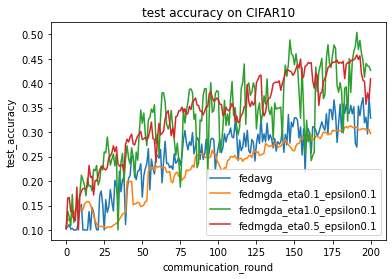

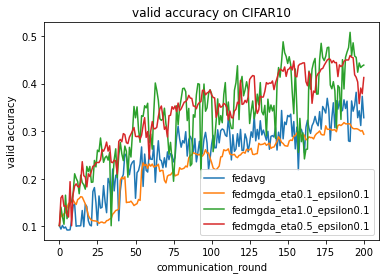

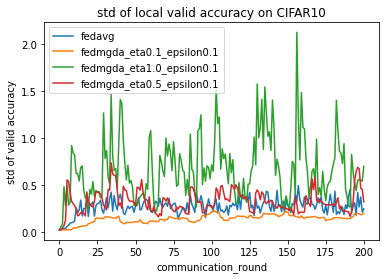

In [6]:
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg', 'fedmgda']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'test_accuracy'}, 'fig_option':{'xlabel':'communication_round', 'ylabel':'test_accuracy','title':'test accuracy on CIFAR10'}},
            {'args':{'x': 'communication_round', 'y':'valid_accuracy'},  'fig_option':{'xlabel':'communication_round', 'ylabel':'valid accuracy','title':'valid accuracy on CIFAR10'}},
            {'args':{'x': 'communication_round', 'y':'std_valid_loss'},  'fig_option':{'xlabel':'communication_round', 'ylabel':'std of valid accuracy','title':'std of local valid accuracy on CIFAR10'}},
        ],
    }
}
flgo.experiment.analyzer.show(analysis_plan)

从结果可以看到，fedmgda+的性能受到全局步长eta影响较大。维护不同用户的梯度的一致性在提升模型测试集精度上有一定作用。但由于fedmgda+调整了更新量的幅度，因此这里暂时不能确定这种提升来源于幅度的变化，还是维护了梯度一致性。